<a href="https://colab.research.google.com/github/shockless/microcirculation-solution/blob/main/Pipeline%20Notebooks/Train_LoD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка сессии

## Импорты

In [4]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!gdown 16OObQ8_WdEWM97BlMOVnlVSorOp1gU3N -O /content/train/
!gdown 12hNXcrHr0v48m9VRr-GLj5eq3pnYU7Im
!N | unzip -q /content/train/train_dataset_mc.zip -d /content/train
!gdown 1dTi50FWqeYUDY27V2ufVe6wB5SEyBgdG

Downloading...
From: https://drive.google.com/uc?id=16OObQ8_WdEWM97BlMOVnlVSorOp1gU3N
To: /content/train/train_dataset_mc.zip
100% 1.99G/1.99G [00:19<00:00, 101MB/s] 
Downloading...
From: https://drive.google.com/uc?id=12hNXcrHr0v48m9VRr-GLj5eq3pnYU7Im
To: /content/requirements.txt
100% 225/225 [00:00<00:00, 307kB/s]
/bin/bash: N: command not found
Downloading...
From: https://drive.google.com/uc?id=1dTi50FWqeYUDY27V2ufVe6wB5SEyBgdG
To: /content/dataset.txt
100% 13.6k/13.6k [00:00<00:00, 21.5MB/s]


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
drive_location = '/content/drive/MyDrive'

In [8]:
!pip install -r /content/requirements.txt -q

     |████████████████████████████████| 97 kB 4.4 MB/s 
     |████████████████████████████████| 376 kB 43.5 MB/s 
     |████████████████████████████████| 58 kB 5.7 MB/s 
     |████████████████████████████████| 1.6 MB 65.5 MB/s 


In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pandas as pd 
import numpy as np
import glob
import multiprocessing
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.utils import draw_segmentation_masks

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")
import json
from GPUtil import showUtilization as gpu_usage
import GPUtil

# Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

## Класс датасета

In [10]:
class EyeDataset(Dataset):
    """
    Класс датасета, организующий загрузку и получение изображений и соответствующих разметок
    """

    def __init__(self, data_folder: str, mode: str = "train", transform=None):
        self.class_ids = {"vessel": 1}

        self.mode = mode.lower()

        self.data_folder = data_folder
        self.transform = transform
        self._image_files = glob.glob(f"{data_folder}/*.png")
        if self.mode == "train":
            self._mask_files = glob.glob(f"{data_folder}/*.geojson")

        image_file_ids = set([el.split(".")[0] for el in self._image_files])
        if self.mode == "train":
            mask_file_ids = set([el.split(".")[0] for el in self._mask_files])

        if self.mode == "train":
            intersecting_ids = list(image_file_ids.intersection(mask_file_ids))
            self._image_files = [el + ".png" for el in intersecting_ids]
            self._mask_files = [el + ".geojson" for el in intersecting_ids]

    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image

    @staticmethod 
    def parse_polygon(coordinates, image_size): 
        mask = np.zeros(image_size, dtype=np.float32) 
    
        if len(coordinates) == 1: 
            points = [np.int32(coordinates)] 
            cv2.fillPoly(mask, points, 1) 
        else: 
            points = [np.int32([coordinates[0]])] 
            cv2.fillPoly(mask, points, 1) 
    
            for polygon in coordinates[1:]: 
                points = [np.int32([polygon])] 
                cv2.fillPoly(mask, points, 0) 
    
        return mask

    @staticmethod
    def parse_mask(shape: dict, image_size: tuple) -> np.ndarray:
        """
        Метод для парсинга фигур из geojson файла
        """
        mask = np.zeros(image_size, dtype=np.float32)
        coordinates = shape['coordinates']
        if shape['type'] == 'MultiPolygon':
            for polygon in coordinates:
                mask += EyeDataset.parse_polygon(polygon, image_size)
        else:
            mask += EyeDataset.parse_polygon(coordinates, image_size)
        return mask

    def read_layout(self, path: str, image_size: tuple) -> np.ndarray:
        """
        Метод для чтения geojson разметки и перевода в numpy маску
        """
        with open(path, 'r', encoding='cp1251') as f:  # some files contain cyrillic letters, thus cp1251
            json_contents = json.load(f)

        num_channels = 1 + max(self.class_ids.values())
        mask_channels = [np.zeros(image_size, dtype=np.float32) for _ in range(num_channels)]
        mask = np.zeros(image_size, dtype=np.float32)

        if type(json_contents) == dict and json_contents['type'] == 'FeatureCollection':
            features = json_contents['features']
        elif type(json_contents) == list:
            features = json_contents
        else:
            features = [json_contents]

        for shape in features:
            channel_id = self.class_ids["vessel"]
            mask = self.parse_mask(shape['geometry'], image_size)
            mask_channels[channel_id] = np.maximum(mask_channels[channel_id], mask)

        mask_channels[0] = 1 - np.max(mask_channels[1:], axis=0)

        return np.stack(mask_channels, axis=-1)


    def __getitem__(self, idx: int) -> dict:
        # Достаём имя файла по индексу
        image_path = self._image_files[idx]

        # Получаем соответствующий файл разметки
        if self.mode == "train":
            json_path = image_path.replace("png", "geojson")

        image = self.read_image(image_path)

        if self.mode == "train":
            mask = self.read_layout(json_path, image.shape[:2])

        if self.mode == "train":
            sample = {'image': image,
                      'mask': mask}
        else:
            sample = {"image": image}

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self):
        return len(self._image_files)

    # Метод для проверки состояния датасета
    def make_report(self):
      reports = []
      if (not self.data_folder):
        reports.append("Путь к датасету не указан")
      if (len(self._image_files) == 0):
        reports.append("Изображения для распознавания не найдены")
      else:
        reports.append(f"Найдено {len(self._image_files)} изображений")
      cnt_images_without_masks = sum([1 - len(glob.glob(filepath.replace("png", "geojson"))) for filepath in self._image_files])
      if cnt_images_without_masks > 0:
        reports.append(f"Найдено {cnt_images_without_masks} изображений без разметки")
      else:
        reports.append(f"Для всех изображений есть файл разметки")
      return reports


class DatasetPart(Dataset):
    """
    Обертка над классом датасета для его разбиения на части
    """
    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.Compose = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self) -> int:
        return len(self.indices)


## Преобразование

In [11]:
# Задаем преобразование изображений
size = 1024
train_list = [A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
              A.PadIfNeeded(size, size),
              ToTensorV2(transpose_mask=True),
              ]
eval_list = [A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
              A.PadIfNeeded(size, size),
              ToTensorV2(transpose_mask=True)]

transforms = {'train': A.Compose(train_list), 'test': A.Compose(eval_list)}


In [12]:
# Инициализируем датасет
dataset = EyeDataset("/content/train")

In [13]:
for j in range(2):
    try:
        for i in range(len(dataset)):
            if glob.glob(dataset._image_files[i].replace("png", "geojson"))==[]:
                dataset._image_files.pop(i)
    except:
        j-=1

In [14]:
with open('dataset.txt') as f:
    dat_str = f.readlines()
for i in range(len(dat_str)):
  dat_str[i] = dat_str[i].replace('\n','')
dataset._image_files = list(dat_str)

In [15]:
for msg in dataset.make_report():
  print(msg)

Найдено 596 изображений
Для всех изображений есть файл разметки


## Визуализация

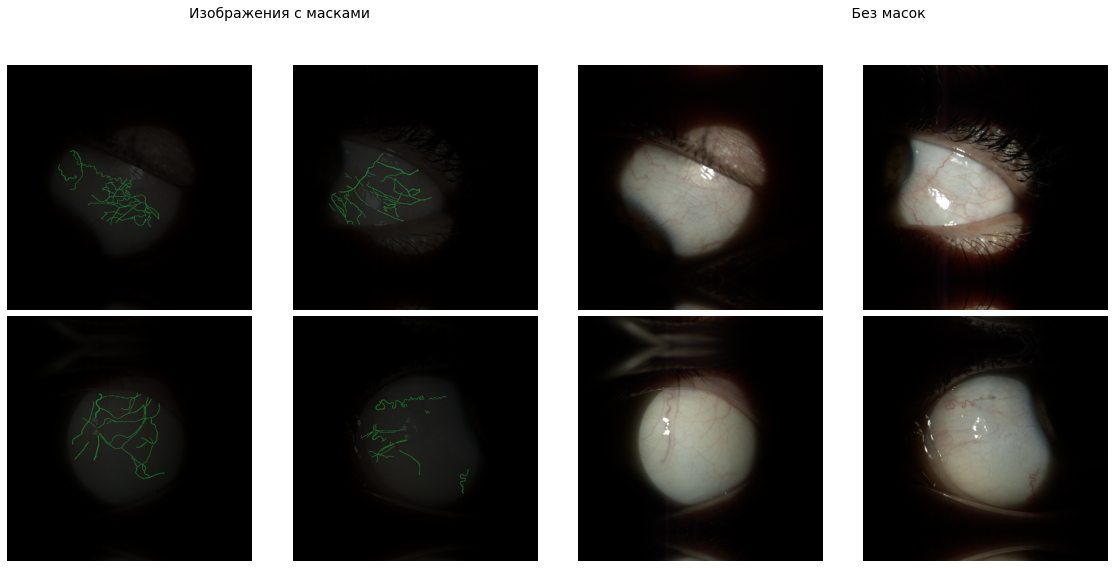

In [16]:
# Посмотрим на картинки из датасета

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Изображения с масками {" "*105} Без масок', fontsize=14)

for i, sample in zip(range(4), dataset):
    transformed = transforms['test'](**sample)
    image, mask = transformed["image"], transformed["mask"]

    image_with_mask = draw_segmentation_masks((image.cpu() * 255).type(torch.uint8), mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')

    image = np.moveaxis(image.cpu().numpy(), 0, -1)    
    axs[i // 2, (i % 2)+2].imshow(image)
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

## Вспомогательные функции

In [17]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

# Класс тренировщика модели

In [39]:
from typing import Tuple, List, Callable, Iterator, Optional, Dict, Any
from collections import defaultdict

class UnetTrainer:
    """
    Класс, реализующий обучение модели
    """

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                 criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
                 device: str, metric_functions: List[Tuple[str, Callable]] = [],
                 epoch_number: int = 0,
                 lr_scheduler: Optional[Any] = None):
        self.model = model
        self.optimizer = optimizer  
        self.criterion = criterion
        self.lr_scheduler = lr_scheduler

        self.device = device

        self.metric_functions = metric_functions

        self.epoch_number = epoch_number

    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[Dict[str, float]]:     
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(eval_on_n_batches):
            try:
                batch = next(val_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break
            ys_pred = self.model.eval()(xs)
            loss = self.criterion(ys_pred, ys_true)

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader, eval_on_n_batches: int = 1) -> Dict[str, float]:
        """
        Вычисление метрик для эпохи
        """
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[Dict[str, float]]:
        """
        Тренировка модели на одном батче
        """
        self.model.train()
    
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(update_every_n_batches):
            self.optimizer.zero_grad()
            try:
                batch = next(train_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.train()(xs)
            loss = self.criterion(ys_pred, ys_true)

            (loss / update_every_n_batches).backward()

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        self.optimizer.step()
        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()
        print(metrics)
        return metrics

    def fit_epoch(self, train_loader, update_every_n_batches: int = 1) -> Dict[str, float]:
        """
        Одна эпоха тренировки модели
        """

        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)
        n_batches = len(train_loader)
        with tqdm(total=n_batches) as pbar:
            while True:
                batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

                if batch_metrics is None:
                    break

                for metric_name in batch_metrics:
                    metrics_sum[metric_name] += batch_metrics[metric_name]

                pbar.update(1)
                num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit(self, train_loader, num_epochs: int,
            val_loader = None, update_every_n_batches: int = 1,
            ) -> Dict[str, np.ndarray]:
        """
        Метод, тренирующий модель и вычисляющий метрики для каждой эпохи
        """

        summary = defaultdict(list)

        def save_metrics(metrics: Dict[str, float], postfix: str = '') -> None:
          # Сохранение метрик в summary
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]

                summary[metric_name].append(metric_value)

        for _ in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs):
            self.epoch_number += 1

            train_metrics = self.fit_epoch(train_loader, update_every_n_batches)

            with torch.no_grad():
                save_metrics(train_metrics, postfix='_train')

                if val_loader is not None:
                    test_metrics = self.evaluate(val_loader)
                    print('epoch metrics:')
                    print(f"train: {train_metrics} \n test: {test_metrics}")
                    save_metrics(test_metrics, postfix='_test')

            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

        summary = {metric: np.array(summary[metric]) for metric in summary}

        return summary


# Метрики

In [19]:
# F1-мера
class SoftDice:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(2 * predictions * targets)
        denominator = torch.sum(predictions + targets)
        return numerator / (denominator + self.epsilon)

# Метрика полноты
class Recall:
    def __init__(self, epsilon=1e-70):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(targets)

        return numerator / (denominator + self.epsilon)

# Метрика точности
class Accuracy:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: list, targets: list) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(predictions)

        return numerator / (denominator + self.epsilon)

def make_metrics():
    soft_dice = SoftDice()
    recall = Recall()
    accuracy = Accuracy()

    def exp_dice(pred, target):
        return soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_accuracy(pred, target):
        return accuracy(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_recall(pred, target):
        return recall(torch.exp(pred[:, 1:]), target[:, 1:])

    return [('dice', exp_dice),
            ('accuracy', exp_accuracy),
            ('recall', exp_recall),
            ]

# Cross-Validation

In [20]:
from sklearn.model_selection import StratifiedKFold
from copy import deepcopy
import random

In [21]:
def density(dataset: list=Any):
    densities=[]
    for i in tqdm(range(len(dataset))):
        mask = dataset[i]['mask'][:,:,1]
        densities.append(mask.sum()/(mask.shape[0] * mask.shape[1]))
    return densities

In [22]:
!mkdir {drive_location}/Competitions/LeadersOfDigital/models/cv

mkdir: cannot create directory ‘/content/drive/MyDrive/Competitions/LeadersOfDigital/models/cv’: File exists


In [23]:
def cv(base_model,
       dataset,
       device: str,
       loss_function: Any,
       lr: float = 1e-6,
       eps: float = 1e-8,
       random_state: int = 69,
       shuffle: bool = True,
       n_folds: int = 4,
       epochs: int = 10,
       batch_size: int = 1,
       metric_functions: list = [],
       transform: Dict = None,
       lr_scheduler: Any = None, 
       importances: list = [],
       optimizer: Any = None,
       start_fold: int = 0) -> List[Dict]:
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)

    #loss_function.to(device)

    kfold = StratifiedKFold(n_folds, shuffle=shuffle)
    summaries = []

    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, importances)):
        if(fold>=start_fold):
            print(f'FOLD {fold}')
            print('--------------------------------')

            model = deepcopy(base_model)


            trainer = UnetTrainer(
                model=model,
                optimizer=optimizer,
                criterion=loss_function,
                device=device,
                metric_functions=metric_functions,
                lr_scheduler=lr_scheduler
            )

            train_subset = DatasetPart(dataset, indices=train_ids, transform=transform["train"] if transform else None)
            train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,shuffle=True)
            
            test_subset = DatasetPart(dataset, indices=test_ids, transform=transform["test"] if transform else None)
            val_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size,shuffle=True)
            
            summary = trainer.fit(train_loader, epochs, val_loader=val_loader)

            summaries.append(summary)
        

    return summaries

# Модель

In [24]:
def make_criterion():
    soft_dice = SoftDice()
    def exp_dice(pred, target):
        return 1 - soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    return exp_dice

In [25]:
torch.cuda.empty_cache()

In [26]:
denses=density(dataset)

100%|██████████| 596/596 [03:08<00:00,  3.15it/s]


In [27]:
values, threshes = np.histogram(denses, bins=15)

In [28]:
def bining(value):
    for bin, thresh in enumerate(threshes[1:]):
        if value < thresh:
            return bin
    return bin + 1

In [29]:
binary_denses = list(map(bining, denses))

In [30]:
!pip install madgrad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import madgrad

In [3]:
!pip install inplace_abn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 7.7 MB/s 
  Created wheel for inplace-abn: filename=inplace_abn-1.1.0-cp37-cp37m-linux_x86_64.whl size=2320936 sha256=ef808c3aa4a803172c819d56466061d8c728c6939a959bc3e8f17b522740098a
  Stored in directory: /root/.cache/pip/wheels/5c/31/e8/d5dff7ea17e9c2932b54ffd79682355274dd9a86a7e461c1b2
Successfully built inplace-abn


In [32]:
from inplace_abn import InPlaceABN

In [40]:
cores = multiprocessing.cpu_count()
batch_size=3
lr_e =  1e-5
lr_d = 1e-3
encoder_pretrain='timm-regnety_064'

#model = torch.load(f"{drive_location}/Competitions/LeadersOfDigital/models/model_pretrain.pt")

model_pretrain = smp.UnetPlusPlus(encoder_pretrain, activation='logsoftmax', classes=2, decoder_use_batchnorm=InPlaceABN).cuda()

def make_criterion():
    soft_dice = SoftDice()
    def exp_dice(pred, target):
        return 1 - soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    return exp_dice

criterion = make_criterion()
optimizer = madgrad.MADGRAD(model_pretrain.parameters(), 1e-4)
trainer_pretrain = UnetTrainer(model_pretrain, optimizer, criterion, 'cuda', metric_functions=make_metrics())

#cv(model, dataset, 'cuda',loss_function=criterion, batch_size=1, metric_functions=make_metrics(), transform=transforms, importances=binary_denses, optimizer=optimizer, start_fold=0)

# Процесс обучения

In [41]:
# разделим датасет на тренировочный и валидационный, чтобы смотреть на качество
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.25)

In [42]:
# Разбиваем объект датасета на тренировачный и валидационный
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])


In [43]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size,
                                           num_workers=cores,
                                   shuffle=True, drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size,
                                           num_workers=cores,
                                   shuffle=True, drop_last=True)

In [44]:
trainer = UnetTrainer(model_pretrain, optimizer, criterion, 'cuda', metric_functions=make_metrics())
summary = trainer.fit(train_loader, 6, val_loader=valid_loader)

  0%|          | 1/447 [00:01<14:14,  1.92s/it]

{'loss': 0.9725310802459717, 'dice': 0.027468889951705933, 'accuracy': 0.014042423106729984, 'recall': 0.6262298226356506}



  0%|          | 2/447 [00:02<10:08,  1.37s/it]

{'loss': 0.9795893430709839, 'dice': 0.020410651341080666, 'accuracy': 0.010373508557677269, 'recall': 0.62946617603302}



  1%|          | 3/447 [00:03<08:52,  1.20s/it]

{'loss': 0.9741305112838745, 'dice': 0.025869499891996384, 'accuracy': 0.013196409679949284, 'recall': 0.6523476839065552}



  1%|          | 4/447 [00:04<08:26,  1.14s/it]

{'loss': 0.9821686744689941, 'dice': 0.01783129945397377, 'accuracy': 0.009038536809384823, 'recall': 0.655759871006012}



  1%|          | 5/447 [00:05<08:02,  1.09s/it]

{'loss': 0.9530236721038818, 'dice': 0.046976327896118164, 'accuracy': 0.024278780445456505, 'recall': 0.7212913036346436}



  1%|▏         | 6/447 [00:06<07:42,  1.05s/it]

{'loss': 0.9839093089103699, 'dice': 0.016090720891952515, 'accuracy': 0.008131853304803371, 'recall': 0.7564076781272888}



  2%|▏         | 7/447 [00:07<07:27,  1.02s/it]

{'loss': 0.9715588092803955, 'dice': 0.028441207483410835, 'accuracy': 0.01448609959334135, 'recall': 0.775912344455719}



  2%|▏         | 8/447 [00:08<07:17,  1.00it/s]

{'loss': 0.9697126746177673, 'dice': 0.030287345871329308, 'accuracy': 0.015434803441166878, 'recall': 0.802868664264679}



  2%|▏         | 9/447 [00:09<07:10,  1.02it/s]

{'loss': 0.9545775055885315, 'dice': 0.0454225055873394, 'accuracy': 0.02339129149913788, 'recall': 0.7811999917030334}



  2%|▏         | 10/447 [00:10<07:07,  1.02it/s]

{'loss': 0.9718325138092041, 'dice': 0.028167476877570152, 'accuracy': 0.014313380233943462, 'recall': 0.8778278231620789}



  2%|▏         | 11/447 [00:11<07:04,  1.03it/s]

{'loss': 0.9752914309501648, 'dice': 0.024708544835448265, 'accuracy': 0.012562158517539501, 'recall': 0.7465449571609497}



  3%|▎         | 12/447 [00:12<07:02,  1.03it/s]

{'loss': 0.9505090713500977, 'dice': 0.04949089139699936, 'accuracy': 0.025460833683609962, 'recall': 0.8806968927383423}



  3%|▎         | 13/447 [00:13<07:00,  1.03it/s]

{'loss': 0.9655608534812927, 'dice': 0.034439150243997574, 'accuracy': 0.017561472952365875, 'recall': 0.8844799995422363}



  3%|▎         | 14/447 [00:14<06:59,  1.03it/s]

{'loss': 0.9649462699890137, 'dice': 0.03505371883511543, 'accuracy': 0.017867855727672577, 'recall': 0.9183900356292725}



  3%|▎         | 15/447 [00:15<06:59,  1.03it/s]

{'loss': 0.9586436152458191, 'dice': 0.04135637357831001, 'accuracy': 0.02115539088845253, 'recall': 0.9167031049728394}



  4%|▎         | 16/447 [00:16<06:58,  1.03it/s]

{'loss': 0.97386634349823, 'dice': 0.02613367699086666, 'accuracy': 0.013248797506093979, 'recall': 0.9514250159263611}



  4%|▍         | 17/447 [00:17<06:57,  1.03it/s]

{'loss': 0.987254798412323, 'dice': 0.01274521928280592, 'accuracy': 0.0064145238138735294, 'recall': 0.9752671122550964}



  4%|▍         | 18/447 [00:18<07:00,  1.02it/s]

{'loss': 0.9614540338516235, 'dice': 0.03854594752192497, 'accuracy': 0.01967238448560238, 'recall': 0.9492625594139099}



  4%|▍         | 19/447 [00:19<07:12,  1.01s/it]

{'loss': 0.9498261213302612, 'dice': 0.05017387494444847, 'accuracy': 0.02578614093363285, 'recall': 0.9251888394355774}



  4%|▍         | 20/447 [00:20<07:11,  1.01s/it]

{'loss': 0.9725280404090881, 'dice': 0.027471957728266716, 'accuracy': 0.013931341469287872, 'recall': 0.9795118570327759}



  5%|▍         | 21/447 [00:21<07:10,  1.01s/it]

{'loss': 0.9868211150169373, 'dice': 0.01317890826612711, 'accuracy': 0.006634978577494621, 'recall': 0.96036696434021}



  5%|▍         | 22/447 [00:22<07:06,  1.00s/it]

{'loss': 0.9820233583450317, 'dice': 0.017976636067032814, 'accuracy': 0.009070487692952156, 'recall': 0.9922025203704834}



  5%|▌         | 23/447 [00:23<07:05,  1.00s/it]

{'loss': 0.9452852010726929, 'dice': 0.05471477657556534, 'accuracy': 0.028161846101284027, 'recall': 0.9577077031135559}



  5%|▌         | 24/447 [00:24<07:02,  1.00it/s]

{'loss': 0.9817434549331665, 'dice': 0.01825656369328499, 'accuracy': 0.009213217534124851, 'recall': 0.9901687502861023}



  6%|▌         | 25/447 [00:25<07:00,  1.00it/s]

{'loss': 0.9846815466880798, 'dice': 0.015318481251597404, 'accuracy': 0.007718820124864578, 'recall': 0.9922937154769897}



  6%|▌         | 26/447 [00:26<06:58,  1.01it/s]

{'loss': 0.9664694666862488, 'dice': 0.03353051468729973, 'accuracy': 0.017072027549147606, 'recall': 0.9329997897148132}



  6%|▌         | 27/447 [00:27<06:57,  1.01it/s]

{'loss': 0.970755398273468, 'dice': 0.029244596138596535, 'accuracy': 0.014842737466096878, 'recall': 0.984557032585144}



  6%|▋         | 28/447 [00:28<06:55,  1.01it/s]

{'loss': 0.9743116497993469, 'dice': 0.025688372552394867, 'accuracy': 0.01301411259919405, 'recall': 0.9836962223052979}



  6%|▋         | 29/447 [00:29<06:53,  1.01it/s]

{'loss': 0.9446142911911011, 'dice': 0.055385734885931015, 'accuracy': 0.028495822101831436, 'recall': 0.9827852845191956}



  7%|▋         | 30/447 [00:30<06:51,  1.01it/s]

{'loss': 0.983049750328064, 'dice': 0.01695023477077484, 'accuracy': 0.008556636050343513, 'recall': 0.8895970582962036}



  7%|▋         | 31/447 [00:31<06:51,  1.01it/s]

{'loss': 0.9700226783752441, 'dice': 0.029977355152368546, 'accuracy': 0.0152274826541543, 'recall': 0.9557554721832275}



  7%|▋         | 32/447 [00:32<06:51,  1.01it/s]

{'loss': 0.9861796498298645, 'dice': 0.013820363208651543, 'accuracy': 0.006958468351513147, 'recall': 0.9958035349845886}



  7%|▋         | 33/447 [00:33<06:50,  1.01it/s]

{'loss': 0.9764940738677979, 'dice': 0.02350592240691185, 'accuracy': 0.011893530376255512, 'recall': 0.9944144487380981}



  8%|▊         | 34/447 [00:34<06:50,  1.01it/s]

{'loss': 0.9664570093154907, 'dice': 0.03354300558567047, 'accuracy': 0.017059829086065292, 'recall': 0.9923502802848816}



  8%|▊         | 35/447 [00:35<06:49,  1.01it/s]

{'loss': 0.958646297454834, 'dice': 0.041353724896907806, 'accuracy': 0.02112109586596489, 'recall': 0.9830838441848755}



  8%|▊         | 36/447 [00:36<06:48,  1.01it/s]

{'loss': 0.9414568543434143, 'dice': 0.05854316055774689, 'accuracy': 0.030282676219940186, 'recall': 0.8766946196556091}



  8%|▊         | 37/447 [00:37<06:47,  1.01it/s]

{'loss': 0.9840042591094971, 'dice': 0.01599571667611599, 'accuracy': 0.008062394335865974, 'recall': 0.9991580247879028}



  9%|▊         | 38/447 [00:38<06:46,  1.01it/s]

{'loss': 0.9679149985313416, 'dice': 0.032084982842206955, 'accuracy': 0.0163047444075346, 'recall': 0.9973846077919006}



  9%|▊         | 39/447 [00:39<06:45,  1.01it/s]

{'loss': 0.9689622521400452, 'dice': 0.03103776089847088, 'accuracy': 0.015768058598041534, 'recall': 0.9820351004600525}



  9%|▉         | 40/447 [00:40<06:48,  1.00s/it]

{'loss': 0.9633582234382629, 'dice': 0.036641765385866165, 'accuracy': 0.018671732395887375, 'recall': 0.9750106334686279}



  9%|▉         | 41/447 [00:41<06:48,  1.01s/it]

{'loss': 0.9530758261680603, 'dice': 0.04692419245839119, 'accuracy': 0.024033820256590843, 'recall': 0.9862869381904602}



  9%|▉         | 42/447 [00:42<06:46,  1.00s/it]

{'loss': 0.9631598591804504, 'dice': 0.03684014454483986, 'accuracy': 0.018777765333652496, 'recall': 0.9669961333274841}



 10%|▉         | 43/447 [00:43<06:43,  1.00it/s]

{'loss': 0.9841589331626892, 'dice': 0.015841087326407433, 'accuracy': 0.007983924821019173, 'recall': 0.9977197051048279}



 10%|▉         | 44/447 [00:44<06:45,  1.01s/it]

{'loss': 0.9326741695404053, 'dice': 0.06732584536075592, 'accuracy': 0.03490644693374634, 'recall': 0.944936215877533}



 10%|█         | 45/447 [00:45<06:48,  1.02s/it]

{'loss': 0.9848782420158386, 'dice': 0.015121754258871078, 'accuracy': 0.007619762327522039, 'recall': 0.9783819317817688}



 10%|█         | 46/447 [00:46<06:46,  1.01s/it]

{'loss': 0.9376784563064575, 'dice': 0.06232156977057457, 'accuracy': 0.032193344086408615, 'recall': 0.9715365767478943}



 11%|█         | 47/447 [00:47<06:45,  1.01s/it]

{'loss': 0.893933892250061, 'dice': 0.10606609284877777, 'accuracy': 0.05619830638170242, 'recall': 0.9415863752365112}



 11%|█         | 48/447 [00:48<06:43,  1.01s/it]

{'loss': 0.9056984782218933, 'dice': 0.0943015068769455, 'accuracy': 0.04955773428082466, 'recall': 0.9707955718040466}



 11%|█         | 49/447 [00:49<06:38,  1.00s/it]

{'loss': 0.9697427749633789, 'dice': 0.030257191509008408, 'accuracy': 0.015362661331892014, 'recall': 0.9929509162902832}



 11%|█         | 50/447 [00:50<06:35,  1.00it/s]

{'loss': 0.9095292091369629, 'dice': 0.0904708206653595, 'accuracy': 0.0474761538207531, 'recall': 0.9584347009658813}



 11%|█▏        | 51/447 [00:51<06:33,  1.01it/s]

{'loss': 0.915658175945282, 'dice': 0.08434180170297623, 'accuracy': 0.044383782893419266, 'recall': 0.8458214998245239}



 12%|█▏        | 52/447 [00:52<06:29,  1.01it/s]

{'loss': 0.966023325920105, 'dice': 0.03397670015692711, 'accuracy': 0.017283184453845024, 'recall': 0.9958581328392029}



 12%|█▏        | 53/447 [00:53<06:31,  1.01it/s]

{'loss': 0.930488109588623, 'dice': 0.06951188296079636, 'accuracy': 0.03604200854897499, 'recall': 0.974033534526825}



 12%|█▏        | 54/447 [00:54<06:28,  1.01it/s]

{'loss': 0.9273115992546082, 'dice': 0.07268841564655304, 'accuracy': 0.03773849084973335, 'recall': 0.9837151765823364}



 12%|█▏        | 55/447 [00:55<06:26,  1.01it/s]

{'loss': 0.9667370915412903, 'dice': 0.03326292335987091, 'accuracy': 0.01691666804254055, 'recall': 0.9864786863327026}



 13%|█▎        | 56/447 [00:56<06:23,  1.02it/s]

{'loss': 0.9732862114906311, 'dice': 0.026713777333498, 'accuracy': 0.013543347828090191, 'recall': 0.9701721668243408}



 13%|█▎        | 57/447 [00:57<06:21,  1.02it/s]

{'loss': 0.9227004051208496, 'dice': 0.0772995725274086, 'accuracy': 0.04027007147669792, 'recall': 0.9605904221534729}



 13%|█▎        | 58/447 [00:58<06:20,  1.02it/s]

{'loss': 0.9382315278053284, 'dice': 0.06176846846938133, 'accuracy': 0.03190131485462189, 'recall': 0.9687009453773499}



 13%|█▎        | 59/447 [00:59<06:18,  1.03it/s]

{'loss': 0.9034648537635803, 'dice': 0.09653514623641968, 'accuracy': 0.050793372094631195, 'recall': 0.9706529378890991}



 13%|█▎        | 60/447 [01:00<06:21,  1.01it/s]

{'loss': 0.820377767086029, 'dice': 0.17962223291397095, 'accuracy': 0.10023360699415207, 'recall': 0.8637179136276245}



 14%|█▎        | 61/447 [01:01<06:21,  1.01it/s]

{'loss': 0.9497358202934265, 'dice': 0.050264157354831696, 'accuracy': 0.025798168033361435, 'recall': 0.9733840823173523}



 14%|█▍        | 62/447 [01:02<06:17,  1.02it/s]

{'loss': 0.9863551259040833, 'dice': 0.013644878752529621, 'accuracy': 0.006869318429380655, 'recall': 0.9997056722640991}



 14%|█▍        | 63/447 [01:03<06:15,  1.02it/s]

{'loss': 0.9085081815719604, 'dice': 0.09149183332920074, 'accuracy': 0.04813080653548241, 'recall': 0.9232240915298462}



 14%|█▍        | 64/447 [01:04<06:14,  1.02it/s]

{'loss': 0.8940126895904541, 'dice': 0.10598734021186829, 'accuracy': 0.05612414330244064, 'recall': 0.950089156627655}



 15%|█▍        | 65/447 [01:05<06:12,  1.02it/s]

{'loss': 0.9069470167160034, 'dice': 0.09305302053689957, 'accuracy': 0.048887260258197784, 'recall': 0.9634855389595032}



 15%|█▍        | 66/447 [01:06<06:14,  1.02it/s]

{'loss': 0.9615975022315979, 'dice': 0.03840252384543419, 'accuracy': 0.01957864500582218, 'recall': 0.9961698055267334}



 15%|█▍        | 67/447 [01:07<06:13,  1.02it/s]

{'loss': 0.9193638563156128, 'dice': 0.08063613623380661, 'accuracy': 0.042102161794900894, 'recall': 0.9514526724815369}



 15%|█▌        | 68/447 [01:08<06:17,  1.00it/s]

{'loss': 0.9734667539596558, 'dice': 0.02653321623802185, 'accuracy': 0.013446656055748463, 'recall': 0.9907959699630737}



 15%|█▌        | 69/447 [01:09<06:15,  1.01it/s]

{'loss': 0.9449095129966736, 'dice': 0.05509047955274582, 'accuracy': 0.028347643092274666, 'recall': 0.9731335043907166}



 16%|█▌        | 70/447 [01:10<06:10,  1.02it/s]

{'loss': 0.8961138725280762, 'dice': 0.10388609766960144, 'accuracy': 0.05498882010579109, 'recall': 0.937788724899292}



 16%|█▌        | 71/447 [01:11<06:08,  1.02it/s]

{'loss': 0.918312132358551, 'dice': 0.08168786019086838, 'accuracy': 0.04262973740696907, 'recall': 0.9750014543533325}



 16%|█▌        | 72/447 [01:12<06:06,  1.02it/s]

{'loss': 0.8813443183898926, 'dice': 0.11865569651126862, 'accuracy': 0.06342413276433945, 'recall': 0.9185931086540222}



 16%|█▋        | 73/447 [01:13<06:07,  1.02it/s]

{'loss': 0.9738707542419434, 'dice': 0.026129234582185745, 'accuracy': 0.013237743638455868, 'recall': 0.9989594221115112}



 17%|█▋        | 74/447 [01:14<06:10,  1.01it/s]

{'loss': 0.8785501718521118, 'dice': 0.12144985049962997, 'accuracy': 0.06474699825048447, 'recall': 0.977544903755188}



 17%|█▋        | 75/447 [01:15<06:07,  1.01it/s]

{'loss': 0.9665048122406006, 'dice': 0.033495210111141205, 'accuracy': 0.01703304797410965, 'recall': 0.9993610382080078}



 17%|█▋        | 76/447 [01:16<06:03,  1.02it/s]

{'loss': 0.9536756277084351, 'dice': 0.04632440581917763, 'accuracy': 0.023711925372481346, 'recall': 0.9990869164466858}



 17%|█▋        | 77/447 [01:17<06:00,  1.03it/s]

{'loss': 0.8503811359405518, 'dice': 0.14961886405944824, 'accuracy': 0.08147864788770676, 'recall': 0.9139547944068909}



 17%|█▋        | 78/447 [01:18<05:57,  1.03it/s]

{'loss': 0.9442188143730164, 'dice': 0.05578119307756424, 'accuracy': 0.02870231680572033, 'recall': 0.9862069487571716}



 18%|█▊        | 79/447 [01:19<05:56,  1.03it/s]

{'loss': 0.9680607318878174, 'dice': 0.031939245760440826, 'accuracy': 0.016240570694208145, 'recall': 0.9572184085845947}



 18%|█▊        | 80/447 [01:19<05:54,  1.04it/s]

{'loss': 0.909609317779541, 'dice': 0.09039066731929779, 'accuracy': 0.04762773960828781, 'recall': 0.8849475383758545}



 18%|█▊        | 81/447 [01:20<05:51,  1.04it/s]

{'loss': 0.9183510541915894, 'dice': 0.08164897561073303, 'accuracy': 0.04281889647245407, 'recall': 0.8764802813529968}



 18%|█▊        | 82/447 [01:21<05:52,  1.04it/s]

{'loss': 0.9182944297790527, 'dice': 0.08170560747385025, 'accuracy': 0.04274040460586548, 'recall': 0.925018846988678}



 19%|█▊        | 83/447 [01:22<05:50,  1.04it/s]

{'loss': 0.9365090131759644, 'dice': 0.06349101662635803, 'accuracy': 0.032904062420129776, 'recall': 0.9016020894050598}



 19%|█▉        | 84/447 [01:23<05:50,  1.04it/s]

{'loss': 0.8514480590820312, 'dice': 0.14855197072029114, 'accuracy': 0.08077827841043472, 'recall': 0.9227330684661865}



 19%|█▉        | 85/447 [01:24<05:52,  1.03it/s]

{'loss': 0.857334315776825, 'dice': 0.14266569912433624, 'accuracy': 0.07739871740341187, 'recall': 0.9101857542991638}



 19%|█▉        | 86/447 [01:25<05:52,  1.02it/s]

{'loss': 0.8089814186096191, 'dice': 0.19101856648921967, 'accuracy': 0.10646015405654907, 'recall': 0.9285043478012085}



 19%|█▉        | 87/447 [01:26<05:50,  1.03it/s]

{'loss': 0.8978815078735352, 'dice': 0.10211851447820663, 'accuracy': 0.05397113412618637, 'recall': 0.9463744759559631}



 20%|█▉        | 88/447 [01:27<05:52,  1.02it/s]

{'loss': 0.9609740972518921, 'dice': 0.03902590274810791, 'accuracy': 0.019903462380170822, 'recall': 0.9945321679115295}



 20%|█▉        | 89/447 [01:28<05:53,  1.01it/s]

{'loss': 0.8250898122787476, 'dice': 0.17491023242473602, 'accuracy': 0.0970713421702385, 'recall': 0.882818341255188}



 20%|██        | 90/447 [01:29<05:49,  1.02it/s]

{'loss': 0.96636563539505, 'dice': 0.03363434597849846, 'accuracy': 0.017105676233768463, 'recall': 0.9971120953559875}



 20%|██        | 91/447 [01:30<05:47,  1.03it/s]

{'loss': 0.945430338382721, 'dice': 0.05456968769431114, 'accuracy': 0.028070863336324692, 'recall': 0.9744147658348083}



 21%|██        | 92/447 [01:31<05:56,  1.00s/it]

{'loss': 0.8033331632614136, 'dice': 0.19666677713394165, 'accuracy': 0.11304299533367157, 'recall': 0.7556898593902588}



 21%|██        | 93/447 [01:32<06:03,  1.03s/it]

{'loss': 0.8560064435005188, 'dice': 0.1439935863018036, 'accuracy': 0.0784631073474884, 'recall': 0.8736187219619751}



 21%|██        | 94/447 [01:33<06:00,  1.02s/it]

{'loss': 0.9441065192222595, 'dice': 0.05589345842599869, 'accuracy': 0.028750494122505188, 'recall': 0.999646782875061}



 21%|██▏       | 95/447 [01:34<05:56,  1.01s/it]

{'loss': 0.8764234781265259, 'dice': 0.12357649952173233, 'accuracy': 0.06596016138792038, 'recall': 0.9769059419631958}



 21%|██▏       | 96/447 [01:35<05:51,  1.00s/it]

{'loss': 0.9368669986724854, 'dice': 0.06313299387693405, 'accuracy': 0.032604657113552094, 'recall': 0.9913856983184814}



 22%|██▏       | 97/447 [01:36<05:46,  1.01it/s]

{'loss': 0.7684516310691833, 'dice': 0.23154836893081665, 'accuracy': 0.13387830555438995, 'recall': 0.8561394810676575}



 22%|██▏       | 98/447 [01:37<05:43,  1.02it/s]

{'loss': 0.7847891449928284, 'dice': 0.21521086990833282, 'accuracy': 0.1269737035036087, 'recall': 0.7054349780082703}



 22%|██▏       | 99/447 [01:38<05:40,  1.02it/s]

{'loss': 0.8079544305801392, 'dice': 0.19204558432102203, 'accuracy': 0.10720406472682953, 'recall': 0.920648992061615}



 22%|██▏       | 100/447 [01:39<05:38,  1.02it/s]

{'loss': 0.921868622303009, 'dice': 0.07813140004873276, 'accuracy': 0.04070175066590309, 'recall': 0.9718784093856812}



 23%|██▎       | 101/447 [01:40<05:36,  1.03it/s]

{'loss': 0.8266613483428955, 'dice': 0.1733386516571045, 'accuracy': 0.0965554267168045, 'recall': 0.8464809060096741}



 23%|██▎       | 102/447 [01:41<05:49,  1.01s/it]

{'loss': 0.8574589490890503, 'dice': 0.1425410807132721, 'accuracy': 0.07703796774148941, 'recall': 0.9519906640052795}



 23%|██▎       | 103/447 [01:42<05:54,  1.03s/it]

{'loss': 0.788145124912262, 'dice': 0.21185484528541565, 'accuracy': 0.12087496370077133, 'recall': 0.8565937876701355}



 23%|██▎       | 104/447 [01:43<05:48,  1.02s/it]

{'loss': 0.903006911277771, 'dice': 0.0969931036233902, 'accuracy': 0.05104152858257294, 'recall': 0.9726330637931824}



 23%|██▎       | 105/447 [01:44<05:42,  1.00s/it]

{'loss': 0.9041112661361694, 'dice': 0.09588871151208878, 'accuracy': 0.05345890671014786, 'recall': 0.4647800922393799}



 24%|██▎       | 106/447 [01:45<05:38,  1.01it/s]

{'loss': 0.8493627309799194, 'dice': 0.15063728392124176, 'accuracy': 0.08245871961116791, 'recall': 0.8698335886001587}



 24%|██▍       | 107/447 [01:46<05:35,  1.01it/s]

{'loss': 0.8998632431030273, 'dice': 0.10013676434755325, 'accuracy': 0.052807971835136414, 'recall': 0.9651106595993042}



 24%|██▍       | 108/447 [01:47<05:32,  1.02it/s]

{'loss': 0.8945656418800354, 'dice': 0.10543439537286758, 'accuracy': 0.05571478232741356, 'recall': 0.9798303246498108}



 24%|██▍       | 109/447 [01:48<05:30,  1.02it/s]

{'loss': 0.9772279858589172, 'dice': 0.022772012278437614, 'accuracy': 0.012233199551701546, 'recall': 0.1644102782011032}



 25%|██▍       | 110/447 [01:49<05:28,  1.02it/s]

{'loss': 0.914307177066803, 'dice': 0.08569280803203583, 'accuracy': 0.04541909322142601, 'recall': 0.7564239501953125}



 25%|██▍       | 111/447 [01:50<05:27,  1.03it/s]

{'loss': 0.9722099304199219, 'dice': 0.02779008448123932, 'accuracy': 0.01409152615815401, 'recall': 0.9965300559997559}



 25%|██▌       | 112/447 [01:51<05:26,  1.03it/s]

{'loss': 0.7610015869140625, 'dice': 0.23899835348129272, 'accuracy': 0.14411745965480804, 'recall': 0.6995583772659302}



 25%|██▌       | 113/447 [01:52<05:25,  1.02it/s]

{'loss': 0.9090210199356079, 'dice': 0.09097898751497269, 'accuracy': 0.047741036862134933, 'recall': 0.9645456671714783}



 26%|██▌       | 114/447 [01:53<05:25,  1.02it/s]

{'loss': 0.8689648509025574, 'dice': 0.13103514909744263, 'accuracy': 0.07025226950645447, 'recall': 0.9721353054046631}



 26%|██▌       | 115/447 [01:54<05:23,  1.03it/s]

{'loss': 0.9468370079994202, 'dice': 0.05316299572587013, 'accuracy': 0.027903957292437553, 'recall': 0.5608708262443542}



 26%|██▌       | 116/447 [01:55<05:22,  1.03it/s]

{'loss': 0.7692321538925171, 'dice': 0.2307678610086441, 'accuracy': 0.13517500460147858, 'recall': 0.7880833148956299}



 26%|██▌       | 117/447 [01:56<05:21,  1.03it/s]

{'loss': 0.957814633846283, 'dice': 0.04218534752726555, 'accuracy': 0.023664992302656174, 'recall': 0.19404973089694977}



 26%|██▋       | 118/447 [01:57<05:21,  1.02it/s]

{'loss': 0.8673673868179321, 'dice': 0.13263264298439026, 'accuracy': 0.07121694833040237, 'recall': 0.9637225270271301}



 27%|██▋       | 119/447 [01:58<05:19,  1.03it/s]

{'loss': 0.7956251502037048, 'dice': 0.2043747901916504, 'accuracy': 0.11455000191926956, 'recall': 0.9468529224395752}



 27%|██▋       | 120/447 [01:59<05:20,  1.02it/s]

{'loss': 0.7076221108436584, 'dice': 0.29237785935401917, 'accuracy': 0.17930114269256592, 'recall': 0.7916069030761719}



 27%|██▋       | 121/447 [02:00<05:18,  1.02it/s]

{'loss': 0.6099178791046143, 'dice': 0.39008206129074097, 'accuracy': 0.2723863422870636, 'recall': 0.6868744492530823}



 27%|██▋       | 122/447 [02:01<05:17,  1.02it/s]

{'loss': 0.8925836682319641, 'dice': 0.10741633921861649, 'accuracy': 0.057058751583099365, 'recall': 0.9146229028701782}



 28%|██▊       | 123/447 [02:02<05:16,  1.02it/s]

{'loss': 0.7219551801681519, 'dice': 0.27804479002952576, 'accuracy': 0.16731660068035126, 'recall': 0.8221035003662109}



 28%|██▊       | 124/447 [02:03<05:15,  1.02it/s]

{'loss': 0.8733823299407959, 'dice': 0.1266176551580429, 'accuracy': 0.06858270615339279, 'recall': 0.8232825398445129}



 28%|██▊       | 125/447 [02:04<05:13,  1.03it/s]

{'loss': 0.7868958711624146, 'dice': 0.21310411393642426, 'accuracy': 0.1219630092382431, 'recall': 0.8432579636573792}



 28%|██▊       | 126/447 [02:05<05:13,  1.02it/s]

{'loss': 0.7355737090110779, 'dice': 0.26442623138427734, 'accuracy': 0.15881910920143127, 'recall': 0.7892199754714966}



 28%|██▊       | 127/447 [02:06<05:11,  1.03it/s]

{'loss': 0.6675971746444702, 'dice': 0.3324028253555298, 'accuracy': 0.2261514812707901, 'recall': 0.6269667148590088}



 29%|██▊       | 128/447 [02:07<05:11,  1.02it/s]

{'loss': 0.751915454864502, 'dice': 0.24808454513549805, 'accuracy': 0.1463424116373062, 'recall': 0.8140148520469666}



 29%|██▉       | 129/447 [02:08<05:10,  1.03it/s]

{'loss': 0.7000893354415894, 'dice': 0.2999107539653778, 'accuracy': 0.17970293760299683, 'recall': 0.9058697819709778}



 29%|██▉       | 130/447 [02:09<05:09,  1.03it/s]

{'loss': 0.7418845891952515, 'dice': 0.2581154704093933, 'accuracy': 0.15097856521606445, 'recall': 0.8888773322105408}



 29%|██▉       | 131/447 [02:10<05:10,  1.02it/s]

{'loss': 0.7691900730133057, 'dice': 0.23080994188785553, 'accuracy': 0.136565700173378, 'recall': 0.7447930574417114}



 30%|██▉       | 132/447 [02:11<05:09,  1.02it/s]

{'loss': 0.6644300222396851, 'dice': 0.33556997776031494, 'accuracy': 0.2475028932094574, 'recall': 0.5209277868270874}



 30%|██▉       | 133/447 [02:12<05:07,  1.02it/s]

{'loss': 0.7708925008773804, 'dice': 0.22910749912261963, 'accuracy': 0.1318625807762146, 'recall': 0.8726955652236938}



 30%|██▉       | 134/447 [02:13<05:07,  1.02it/s]

{'loss': 0.7007208466529846, 'dice': 0.299279123544693, 'accuracy': 0.19459237158298492, 'recall': 0.6477619409561157}



 30%|███       | 135/447 [02:14<05:05,  1.02it/s]

{'loss': 0.6268374919891357, 'dice': 0.37316256761550903, 'accuracy': 0.3338364362716675, 'recall': 0.4229910671710968}



 30%|███       | 136/447 [02:15<05:04,  1.02it/s]

{'loss': 0.6742773056030273, 'dice': 0.32572272419929504, 'accuracy': 0.1999453753232956, 'recall': 0.878097653388977}



 31%|███       | 137/447 [02:16<05:02,  1.02it/s]

{'loss': 0.5434008240699768, 'dice': 0.4565991461277008, 'accuracy': 0.3370780348777771, 'recall': 0.7074450254440308}



 31%|███       | 138/447 [02:16<05:02,  1.02it/s]

{'loss': 0.7910704016685486, 'dice': 0.20892959833145142, 'accuracy': 0.11702115833759308, 'recall': 0.973577082157135}



 31%|███       | 139/447 [02:17<05:00,  1.03it/s]

{'loss': 0.6925830841064453, 'dice': 0.3074169158935547, 'accuracy': 0.18439799547195435, 'recall': 0.9235568642616272}



 31%|███▏      | 140/447 [02:18<05:03,  1.01it/s]

{'loss': 0.5856355428695679, 'dice': 0.41436445713043213, 'accuracy': 0.27789583802223206, 'recall': 0.8142006397247314}



 32%|███▏      | 141/447 [02:19<05:05,  1.00it/s]

{'loss': 0.7718523740768433, 'dice': 0.22814759612083435, 'accuracy': 0.16294433176517487, 'recall': 0.38034528493881226}



 32%|███▏      | 142/447 [02:20<05:02,  1.01it/s]

{'loss': 0.5862306356430054, 'dice': 0.41376936435699463, 'accuracy': 0.33167776465415955, 'recall': 0.549862802028656}



 32%|███▏      | 143/447 [02:21<04:59,  1.02it/s]

{'loss': 0.7073389291763306, 'dice': 0.2926611304283142, 'accuracy': 0.17600710690021515, 'recall': 0.8678645491600037}



 32%|███▏      | 144/447 [02:22<04:58,  1.02it/s]

{'loss': 0.6037102341651917, 'dice': 0.39628976583480835, 'accuracy': 0.44069400429725647, 'recall': 0.36001476645469666}



 32%|███▏      | 145/447 [02:23<04:57,  1.01it/s]

{'loss': 0.6964691877365112, 'dice': 0.3035307824611664, 'accuracy': 0.18501146137714386, 'recall': 0.8445616364479065}



 33%|███▎      | 146/447 [02:24<04:57,  1.01it/s]

{'loss': 0.6575706005096436, 'dice': 0.3424294590950012, 'accuracy': 0.21361449360847473, 'recall': 0.8625978231430054}



 33%|███▎      | 147/447 [02:25<05:02,  1.01s/it]

{'loss': 0.49743205308914185, 'dice': 0.5025678873062134, 'accuracy': 0.382144957780838, 'recall': 0.7338085770606995}



 33%|███▎      | 148/447 [02:27<05:12,  1.05s/it]

{'loss': 0.5876830816268921, 'dice': 0.4123170077800751, 'accuracy': 0.27619630098342896, 'recall': 0.8129923343658447}



 33%|███▎      | 149/447 [02:28<05:16,  1.06s/it]

{'loss': 0.49202024936676025, 'dice': 0.5079798102378845, 'accuracy': 0.4758644700050354, 'recall': 0.5447436571121216}



 34%|███▎      | 150/447 [02:29<05:12,  1.05s/it]

{'loss': 0.4638081192970276, 'dice': 0.5361918807029724, 'accuracy': 0.43987011909484863, 'recall': 0.6865259408950806}



 34%|███▍      | 151/447 [02:30<05:04,  1.03s/it]

{'loss': 0.45979195833206177, 'dice': 0.540208101272583, 'accuracy': 0.4772801399230957, 'recall': 0.6222499012947083}



 34%|███▍      | 152/447 [02:31<05:01,  1.02s/it]

{'loss': 0.43003714084625244, 'dice': 0.5699628591537476, 'accuracy': 0.5501212477684021, 'recall': 0.591289222240448}



 34%|███▍      | 153/447 [02:32<04:56,  1.01s/it]

{'loss': 0.435394287109375, 'dice': 0.564605712890625, 'accuracy': 0.5134949088096619, 'recall': 0.6270157694816589}



 34%|███▍      | 154/447 [02:33<04:51,  1.00it/s]

{'loss': 0.4774754047393799, 'dice': 0.5225246548652649, 'accuracy': 0.39708349108695984, 'recall': 0.763820230960846}



 35%|███▍      | 155/447 [02:34<04:51,  1.00it/s]

{'loss': 0.5046571493148804, 'dice': 0.4953429400920868, 'accuracy': 0.35241737961769104, 'recall': 0.8332901000976562}



 35%|███▍      | 156/447 [02:35<04:53,  1.01s/it]

{'loss': 0.42031633853912354, 'dice': 0.5796836614608765, 'accuracy': 0.5236982703208923, 'recall': 0.6490718722343445}



 35%|███▌      | 157/447 [02:36<04:49,  1.00it/s]

{'loss': 0.7892976403236389, 'dice': 0.21070235967636108, 'accuracy': 0.11816190928220749, 'recall': 0.9717244505882263}



 35%|███▌      | 158/447 [02:37<04:47,  1.00it/s]

{'loss': 0.60090571641922, 'dice': 0.39909428358078003, 'accuracy': 0.2578202486038208, 'recall': 0.8828652501106262}



 36%|███▌      | 159/447 [02:38<04:50,  1.01s/it]

{'loss': 0.4962906837463379, 'dice': 0.5037093162536621, 'accuracy': 0.5050632953643799, 'recall': 0.5023626089096069}



 36%|███▌      | 160/447 [02:39<04:47,  1.00s/it]

{'loss': 0.5061030983924866, 'dice': 0.4938969016075134, 'accuracy': 0.39728108048439026, 'recall': 0.6526058316230774}



 36%|███▌      | 161/447 [02:40<04:43,  1.01it/s]

{'loss': 0.6479908227920532, 'dice': 0.352009117603302, 'accuracy': 0.2971930503845215, 'recall': 0.43161967396736145}



 36%|███▌      | 162/447 [02:41<04:40,  1.02it/s]

{'loss': 0.529174268245697, 'dice': 0.470825731754303, 'accuracy': 0.6654008626937866, 'recall': 0.3642983138561249}



 36%|███▋      | 163/447 [02:42<04:37,  1.02it/s]

{'loss': 0.6426942348480225, 'dice': 0.35730576515197754, 'accuracy': 0.23121286928653717, 'recall': 0.7858988642692566}



 37%|███▋      | 164/447 [02:43<04:36,  1.03it/s]

{'loss': 0.4813463091850281, 'dice': 0.5186536312103271, 'accuracy': 0.4297458827495575, 'recall': 0.6539445519447327}



 37%|███▋      | 165/447 [02:44<04:39,  1.01it/s]

{'loss': 0.3917756676673889, 'dice': 0.6082243919372559, 'accuracy': 0.4947407841682434, 'recall': 0.7892659902572632}



 37%|███▋      | 166/447 [02:45<04:40,  1.00it/s]

{'loss': 0.5506762266159058, 'dice': 0.449323832988739, 'accuracy': 0.407918244600296, 'recall': 0.5000846982002258}



 37%|███▋      | 167/447 [02:46<04:36,  1.01it/s]

{'loss': 0.4109058976173401, 'dice': 0.5890941023826599, 'accuracy': 0.5278393030166626, 'recall': 0.6664323210716248}



 38%|███▊      | 168/447 [02:47<04:34,  1.02it/s]

{'loss': 0.7038891315460205, 'dice': 0.29611092805862427, 'accuracy': 0.22706621885299683, 'recall': 0.4254913926124573}



 38%|███▊      | 169/447 [02:47<04:32,  1.02it/s]

{'loss': 0.5272418856620789, 'dice': 0.4727582037448883, 'accuracy': 0.3411896526813507, 'recall': 0.7694845795631409}



 38%|███▊      | 170/447 [02:48<04:30,  1.03it/s]

{'loss': 0.5010683536529541, 'dice': 0.4989317059516907, 'accuracy': 0.3554004728794098, 'recall': 0.836933970451355}



 38%|███▊      | 171/447 [02:49<04:27,  1.03it/s]

{'loss': 0.6908982992172241, 'dice': 0.3091017007827759, 'accuracy': 0.19362793862819672, 'recall': 0.7658034563064575}



 38%|███▊      | 172/447 [02:50<04:26,  1.03it/s]

{'loss': 0.38703811168670654, 'dice': 0.6129618287086487, 'accuracy': 0.6694155931472778, 'recall': 0.5652893781661987}



 39%|███▊      | 173/447 [02:51<04:26,  1.03it/s]

{'loss': 0.4534364342689514, 'dice': 0.5465635061264038, 'accuracy': 0.44594448804855347, 'recall': 0.7058183550834656}



 39%|███▉      | 174/447 [02:52<04:24,  1.03it/s]

{'loss': 0.33955585956573486, 'dice': 0.6604441404342651, 'accuracy': 0.640630841255188, 'recall': 0.6815220713615417}



 39%|███▉      | 175/447 [02:53<04:24,  1.03it/s]

{'loss': 0.3441082835197449, 'dice': 0.6558917164802551, 'accuracy': 0.7222974300384521, 'recall': 0.6006681323051453}



 39%|███▉      | 176/447 [02:54<04:23,  1.03it/s]

{'loss': 0.44433438777923584, 'dice': 0.5556655526161194, 'accuracy': 0.5696377754211426, 'recall': 0.5423623323440552}



 40%|███▉      | 177/447 [02:55<04:21,  1.03it/s]

{'loss': 0.40892231464385986, 'dice': 0.5910776853561401, 'accuracy': 0.47412750124931335, 'recall': 0.7846137881278992}



 40%|███▉      | 178/447 [02:56<04:20,  1.03it/s]

{'loss': 0.4960898160934448, 'dice': 0.5039101839065552, 'accuracy': 0.4768052101135254, 'recall': 0.5342825651168823}



 40%|████      | 179/447 [02:57<04:19,  1.03it/s]

{'loss': 0.4337095022201538, 'dice': 0.5662904977798462, 'accuracy': 0.5448970794677734, 'recall': 0.5894323587417603}



 40%|████      | 180/447 [02:58<04:18,  1.03it/s]

{'loss': 0.3547622561454773, 'dice': 0.645237922668457, 'accuracy': 0.565514862537384, 'recall': 0.7511274814605713}



 40%|████      | 181/447 [02:59<04:17,  1.03it/s]

{'loss': 0.39254969358444214, 'dice': 0.6074503064155579, 'accuracy': 0.5576711893081665, 'recall': 0.6669872403144836}



 41%|████      | 182/447 [03:00<04:17,  1.03it/s]

{'loss': 0.4702625870704651, 'dice': 0.5297374129295349, 'accuracy': 0.40146395564079285, 'recall': 0.7784693241119385}



 41%|████      | 183/447 [03:01<04:15,  1.03it/s]

{'loss': 0.4545140266418457, 'dice': 0.5454859733581543, 'accuracy': 0.618873655796051, 'recall': 0.48765817284584045}



 41%|████      | 184/447 [03:02<04:14,  1.03it/s]

{'loss': 0.32433539628982544, 'dice': 0.6756646037101746, 'accuracy': 0.5834606885910034, 'recall': 0.8024799823760986}



 41%|████▏     | 185/447 [03:03<04:15,  1.02it/s]

{'loss': 0.3545723557472229, 'dice': 0.6454275846481323, 'accuracy': 0.5521407723426819, 'recall': 0.7766453623771667}



 42%|████▏     | 186/447 [03:04<04:16,  1.02it/s]

{'loss': 0.3653606176376343, 'dice': 0.634639322757721, 'accuracy': 0.5638123750686646, 'recall': 0.7258177399635315}



 42%|████▏     | 187/447 [03:05<04:15,  1.02it/s]

{'loss': 0.3140064477920532, 'dice': 0.6859935522079468, 'accuracy': 0.6516254544258118, 'recall': 0.7241887450218201}



 42%|████▏     | 188/447 [03:06<04:13,  1.02it/s]

{'loss': 0.4482606053352356, 'dice': 0.5517393946647644, 'accuracy': 0.5403990745544434, 'recall': 0.5635659694671631}



 42%|████▏     | 189/447 [03:07<04:11,  1.03it/s]

{'loss': 0.48672497272491455, 'dice': 0.5132750272750854, 'accuracy': 0.7157579064369202, 'recall': 0.4000917971134186}



 43%|████▎     | 190/447 [03:08<04:09,  1.03it/s]

{'loss': 0.3915972113609314, 'dice': 0.6084027886390686, 'accuracy': 0.7386291027069092, 'recall': 0.5172138214111328}



 43%|████▎     | 191/447 [03:09<04:08,  1.03it/s]

{'loss': 0.7050546407699585, 'dice': 0.29494529962539673, 'accuracy': 0.17608053982257843, 'recall': 0.9076888561248779}



 43%|████▎     | 192/447 [03:10<04:07,  1.03it/s]

{'loss': 0.3868923783302307, 'dice': 0.6131075620651245, 'accuracy': 0.5654751658439636, 'recall': 0.6695025563240051}



 43%|████▎     | 193/447 [03:11<04:06,  1.03it/s]

{'loss': 0.3668672442436218, 'dice': 0.6331327557563782, 'accuracy': 0.5840746760368347, 'recall': 0.6911874413490295}



 43%|████▎     | 194/447 [03:12<04:06,  1.03it/s]

{'loss': 0.6566321849822998, 'dice': 0.3433678448200226, 'accuracy': 0.20841443538665771, 'recall': 0.9741601347923279}



 44%|████▎     | 195/447 [03:13<04:05,  1.03it/s]

{'loss': 0.47711044549942017, 'dice': 0.5228894948959351, 'accuracy': 0.43748876452445984, 'recall': 0.6497189998626709}



 44%|████▍     | 196/447 [03:14<04:03,  1.03it/s]

{'loss': 0.3546867370605469, 'dice': 0.6453132629394531, 'accuracy': 0.569209098815918, 'recall': 0.7449087500572205}



 44%|████▍     | 197/447 [03:15<04:03,  1.03it/s]

{'loss': 0.5041934251785278, 'dice': 0.4958065450191498, 'accuracy': 0.3538258969783783, 'recall': 0.8281006813049316}



 44%|████▍     | 198/447 [03:16<04:02,  1.03it/s]

{'loss': 0.5444725155830383, 'dice': 0.4555274248123169, 'accuracy': 0.6948725581169128, 'recall': 0.33882206678390503}



 45%|████▍     | 199/447 [03:17<04:00,  1.03it/s]

{'loss': 0.41224485635757446, 'dice': 0.5877552032470703, 'accuracy': 0.5796859860420227, 'recall': 0.5960522294044495}



 45%|████▍     | 200/447 [03:18<04:00,  1.03it/s]

{'loss': 0.5522958040237427, 'dice': 0.4477041959762573, 'accuracy': 0.5067362189292908, 'recall': 0.40099087357521057}



 45%|████▍     | 201/447 [03:19<03:59,  1.03it/s]

{'loss': 0.38180869817733765, 'dice': 0.6181912422180176, 'accuracy': 0.6699458360671997, 'recall': 0.5738595128059387}



 45%|████▌     | 202/447 [03:20<03:58,  1.03it/s]

{'loss': 0.39689189195632935, 'dice': 0.6031080484390259, 'accuracy': 0.5209596753120422, 'recall': 0.71601402759552}



 45%|████▌     | 203/447 [03:21<03:57,  1.03it/s]

{'loss': 0.41042232513427734, 'dice': 0.5895776152610779, 'accuracy': 0.512511134147644, 'recall': 0.6939229369163513}



 46%|████▌     | 204/447 [03:22<03:56,  1.03it/s]

{'loss': 0.47615712881088257, 'dice': 0.523842990398407, 'accuracy': 0.38006311655044556, 'recall': 0.8426048755645752}



 46%|████▌     | 205/447 [03:22<03:55,  1.03it/s]

{'loss': 0.4658491611480713, 'dice': 0.5341508388519287, 'accuracy': 0.4005950391292572, 'recall': 0.8012983202934265}



 46%|████▌     | 206/447 [03:23<03:54,  1.03it/s]

{'loss': 0.4515262246131897, 'dice': 0.5484737753868103, 'accuracy': 0.754869282245636, 'recall': 0.4307096302509308}



 46%|████▋     | 207/447 [03:24<03:53,  1.03it/s]

{'loss': 0.47777652740478516, 'dice': 0.5222234725952148, 'accuracy': 0.5727601647377014, 'recall': 0.4798816442489624}



 47%|████▋     | 208/447 [03:25<03:52,  1.03it/s]

{'loss': 0.4473375082015991, 'dice': 0.5526624917984009, 'accuracy': 0.4328368902206421, 'recall': 0.7642300724983215}



 47%|████▋     | 209/447 [03:26<03:52,  1.02it/s]

{'loss': 0.4602912664413452, 'dice': 0.53970867395401, 'accuracy': 0.414668470621109, 'recall': 0.7727153897285461}



 47%|████▋     | 210/447 [03:27<03:51,  1.03it/s]

{'loss': 0.45547300577163696, 'dice': 0.5445269346237183, 'accuracy': 0.5918225646018982, 'recall': 0.5042312145233154}



 47%|████▋     | 211/447 [03:28<03:49,  1.03it/s]

{'loss': 0.5082314014434814, 'dice': 0.49176859855651855, 'accuracy': 0.45008617639541626, 'recall': 0.5419594049453735}



 47%|████▋     | 212/447 [03:29<03:49,  1.03it/s]

{'loss': 0.41580963134765625, 'dice': 0.5841904282569885, 'accuracy': 0.5336311459541321, 'recall': 0.6453328728675842}



 48%|████▊     | 213/447 [03:30<03:48,  1.03it/s]

{'loss': 0.7131513953208923, 'dice': 0.28684860467910767, 'accuracy': 0.1717829406261444, 'recall': 0.8687949180603027}



 48%|████▊     | 214/447 [03:31<03:46,  1.03it/s]

{'loss': 0.32787013053894043, 'dice': 0.6721298694610596, 'accuracy': 0.6833151578903198, 'recall': 0.6613048315048218}



 48%|████▊     | 215/447 [03:32<03:45,  1.03it/s]

{'loss': 0.38268035650253296, 'dice': 0.6173197031021118, 'accuracy': 0.6025232672691345, 'recall': 0.6328611373901367}



 48%|████▊     | 216/447 [03:33<03:44,  1.03it/s]

{'loss': 0.5693302154541016, 'dice': 0.43066975474357605, 'accuracy': 0.30927765369415283, 'recall': 0.708923876285553}



 49%|████▊     | 217/447 [03:34<03:44,  1.03it/s]

{'loss': 0.3590381145477295, 'dice': 0.6409618258476257, 'accuracy': 0.6064199209213257, 'recall': 0.6796764731407166}



 49%|████▉     | 218/447 [03:35<03:45,  1.02it/s]

{'loss': 0.30601954460144043, 'dice': 0.6939805150032043, 'accuracy': 0.75030517578125, 'recall': 0.6455218195915222}



 49%|████▉     | 219/447 [03:36<03:45,  1.01it/s]

{'loss': 0.4216614365577698, 'dice': 0.5783385634422302, 'accuracy': 0.6369770765304565, 'recall': 0.529586136341095}



 49%|████▉     | 220/447 [03:37<03:45,  1.01it/s]

{'loss': 0.44885921478271484, 'dice': 0.5511408448219299, 'accuracy': 0.4399650990962982, 'recall': 0.7375017404556274}



 49%|████▉     | 221/447 [03:38<03:43,  1.01it/s]

{'loss': 0.3660818934440613, 'dice': 0.6339183449745178, 'accuracy': 0.7969608902931213, 'recall': 0.5262563824653625}



 50%|████▉     | 222/447 [03:39<03:41,  1.02it/s]

{'loss': 0.3976704478263855, 'dice': 0.602329671382904, 'accuracy': 0.6889474987983704, 'recall': 0.5350593328475952}



 50%|████▉     | 223/447 [03:40<03:39,  1.02it/s]

{'loss': 0.3063068985939026, 'dice': 0.693693220615387, 'accuracy': 0.630859375, 'recall': 0.7704281210899353}



 50%|█████     | 224/447 [03:41<03:38,  1.02it/s]

{'loss': 0.4395480751991272, 'dice': 0.5604519248008728, 'accuracy': 0.6733427047729492, 'recall': 0.47997987270355225}



 50%|█████     | 225/447 [03:42<03:37,  1.02it/s]

{'loss': 0.4037669897079468, 'dice': 0.5962330102920532, 'accuracy': 0.4588669240474701, 'recall': 0.8509824872016907}



 51%|█████     | 226/447 [03:43<03:35,  1.02it/s]

{'loss': 0.46965813636779785, 'dice': 0.5303418636322021, 'accuracy': 0.3869127035140991, 'recall': 0.8427512049674988}



 51%|█████     | 227/447 [03:44<03:34,  1.02it/s]

{'loss': 0.5247030854225159, 'dice': 0.4752969443798065, 'accuracy': 0.41898679733276367, 'recall': 0.5490925908088684}



 51%|█████     | 228/447 [03:45<03:33,  1.03it/s]

{'loss': 0.42989736795425415, 'dice': 0.5701026320457458, 'accuracy': 0.4618772566318512, 'recall': 0.7445665597915649}



 51%|█████     | 229/447 [03:46<03:32,  1.02it/s]

{'loss': 0.38020390272140503, 'dice': 0.619796097278595, 'accuracy': 0.7732659578323364, 'recall': 0.5171562433242798}



 51%|█████▏    | 230/447 [03:47<03:31,  1.02it/s]

{'loss': 0.7355954647064209, 'dice': 0.2644045352935791, 'accuracy': 0.15672169625759125, 'recall': 0.8450013995170593}



 52%|█████▏    | 231/447 [03:48<03:30,  1.02it/s]

{'loss': 0.40770822763442993, 'dice': 0.5922918319702148, 'accuracy': 0.7289090752601624, 'recall': 0.49880263209342957}



 52%|█████▏    | 232/447 [03:49<03:29,  1.02it/s]

{'loss': 0.301303505897522, 'dice': 0.6986966729164124, 'accuracy': 0.6128718256950378, 'recall': 0.8124728202819824}



 52%|█████▏    | 233/447 [03:50<03:28,  1.03it/s]

{'loss': 0.8098892569541931, 'dice': 0.19011075794696808, 'accuracy': 0.1149083748459816, 'recall': 0.5501771569252014}



 52%|█████▏    | 234/447 [03:51<03:28,  1.02it/s]

{'loss': 0.5299021005630493, 'dice': 0.4700978994369507, 'accuracy': 0.3813013434410095, 'recall': 0.612807035446167}



 53%|█████▎    | 235/447 [03:52<03:27,  1.02it/s]

{'loss': 0.34393805265426636, 'dice': 0.6560619473457336, 'accuracy': 0.6581325531005859, 'recall': 0.6540043354034424}



 53%|█████▎    | 236/447 [03:53<03:27,  1.02it/s]

{'loss': 0.5930157899856567, 'dice': 0.40698426961898804, 'accuracy': 0.27380606532096863, 'recall': 0.7924087047576904}



 53%|█████▎    | 237/447 [03:54<03:28,  1.01it/s]

{'loss': 0.6020587682723999, 'dice': 0.3979412019252777, 'accuracy': 0.30578896403312683, 'recall': 0.5695931911468506}



 53%|█████▎    | 238/447 [03:55<03:26,  1.01it/s]

{'loss': 0.4144032597541809, 'dice': 0.5855967998504639, 'accuracy': 0.6687378287315369, 'recall': 0.5208428502082825}



 53%|█████▎    | 239/447 [03:56<03:25,  1.01it/s]

{'loss': 0.37192094326019287, 'dice': 0.6280790567398071, 'accuracy': 0.796146810054779, 'recall': 0.5186014771461487}



 54%|█████▎    | 240/447 [03:57<03:24,  1.01it/s]

{'loss': 0.40209656953811646, 'dice': 0.5979033708572388, 'accuracy': 0.8222491145133972, 'recall': 0.4697382152080536}



 54%|█████▍    | 241/447 [03:58<03:24,  1.01it/s]

{'loss': 0.4953297972679138, 'dice': 0.5046701431274414, 'accuracy': 0.406714528799057, 'recall': 0.6647799015045166}



 54%|█████▍    | 242/447 [03:59<03:25,  1.00s/it]

{'loss': 0.4272744655609131, 'dice': 0.5727255940437317, 'accuracy': 0.7210544347763062, 'recall': 0.47501063346862793}



 54%|█████▍    | 243/447 [04:00<03:26,  1.01s/it]

{'loss': 0.5084278583526611, 'dice': 0.49157217144966125, 'accuracy': 0.3521067798137665, 'recall': 0.8139804005622864}



 55%|█████▍    | 244/447 [04:01<03:24,  1.01s/it]

{'loss': 0.39952778816223145, 'dice': 0.6004722714424133, 'accuracy': 0.45959529280662537, 'recall': 0.8658874034881592}



 55%|█████▍    | 245/447 [04:02<03:23,  1.01s/it]

{'loss': 0.4324895143508911, 'dice': 0.5675104856491089, 'accuracy': 0.6398350596427917, 'recall': 0.5098759531974792}



 55%|█████▌    | 246/447 [04:03<03:19,  1.01it/s]

{'loss': 0.3416115641593933, 'dice': 0.6583883762359619, 'accuracy': 0.6389061808586121, 'recall': 0.6790960431098938}



 55%|█████▌    | 247/447 [04:04<03:19,  1.00it/s]

{'loss': 0.329677939414978, 'dice': 0.670322060585022, 'accuracy': 0.558895468711853, 'recall': 0.8372424840927124}



 55%|█████▌    | 248/447 [04:05<03:18,  1.00it/s]

{'loss': 0.45012444257736206, 'dice': 0.5498754382133484, 'accuracy': 0.7278788685798645, 'recall': 0.4418264627456665}



 56%|█████▌    | 249/447 [04:06<03:15,  1.01it/s]

{'loss': 0.6998022198677063, 'dice': 0.3001977801322937, 'accuracy': 0.17808596789836884, 'recall': 0.9551016688346863}



 56%|█████▌    | 250/447 [04:07<03:13,  1.02it/s]

{'loss': 0.3852936625480652, 'dice': 0.6147063374519348, 'accuracy': 0.5210067629814148, 'recall': 0.7494986653327942}



 56%|█████▌    | 251/447 [04:08<03:11,  1.02it/s]

{'loss': 0.40495961904525757, 'dice': 0.5950403809547424, 'accuracy': 0.7573950290679932, 'recall': 0.4900035560131073}



 56%|█████▋    | 252/447 [04:09<03:12,  1.01it/s]

{'loss': 0.5331717133522034, 'dice': 0.466828316450119, 'accuracy': 0.3573518693447113, 'recall': 0.6730072498321533}



 57%|█████▋    | 253/447 [04:10<03:13,  1.00it/s]

{'loss': 0.4679998755455017, 'dice': 0.5320001244544983, 'accuracy': 0.4060424268245697, 'recall': 0.7712476849555969}



 57%|█████▋    | 254/447 [04:11<03:12,  1.00it/s]

{'loss': 0.3552752137184143, 'dice': 0.6447246670722961, 'accuracy': 0.6256731748580933, 'recall': 0.6649730205535889}



 57%|█████▋    | 255/447 [04:12<03:09,  1.01it/s]

{'loss': 0.5009994506835938, 'dice': 0.49900054931640625, 'accuracy': 0.36273661255836487, 'recall': 0.7992387413978577}



 57%|█████▋    | 256/447 [04:13<03:08,  1.01it/s]

{'loss': 0.4523141384124756, 'dice': 0.5476858615875244, 'accuracy': 0.8536396026611328, 'recall': 0.4031812846660614}



 57%|█████▋    | 257/447 [04:14<03:05,  1.02it/s]

{'loss': 0.42703771591186523, 'dice': 0.5729622840881348, 'accuracy': 0.6543039679527283, 'recall': 0.509608805179596}



 58%|█████▊    | 258/447 [04:15<03:06,  1.02it/s]

{'loss': 0.4982541799545288, 'dice': 0.501745879650116, 'accuracy': 0.35504478216171265, 'recall': 0.8550400137901306}



 58%|█████▊    | 259/447 [04:16<03:04,  1.02it/s]

{'loss': 0.3507465124130249, 'dice': 0.6492534279823303, 'accuracy': 0.7454434037208557, 'recall': 0.5750505328178406}



 58%|█████▊    | 260/447 [04:17<03:03,  1.02it/s]

{'loss': 0.2968047261238098, 'dice': 0.7031951546669006, 'accuracy': 0.7432050108909607, 'recall': 0.6672731041908264}



 58%|█████▊    | 261/447 [04:18<03:03,  1.01it/s]

{'loss': 0.4125897288322449, 'dice': 0.5874103307723999, 'accuracy': 0.49217894673347473, 'recall': 0.7283353805541992}



 59%|█████▊    | 262/447 [04:19<03:04,  1.00it/s]

{'loss': 0.4790145754814148, 'dice': 0.5209854245185852, 'accuracy': 0.8812392354011536, 'recall': 0.3698069751262665}



 59%|█████▉    | 263/447 [04:20<03:02,  1.01it/s]

{'loss': 0.6074849367141724, 'dice': 0.39251509308815, 'accuracy': 0.313930481672287, 'recall': 0.5235801339149475}



 59%|█████▉    | 264/447 [04:21<03:00,  1.01it/s]

{'loss': 0.42566967010498047, 'dice': 0.5743303298950195, 'accuracy': 0.5591821670532227, 'recall': 0.5903220176696777}



 59%|█████▉    | 265/447 [04:22<03:00,  1.01it/s]

{'loss': 0.47140347957611084, 'dice': 0.5285965204238892, 'accuracy': 0.6811373829841614, 'recall': 0.4318774938583374}



 60%|█████▉    | 266/447 [04:23<02:59,  1.01it/s]

{'loss': 0.5078417062759399, 'dice': 0.49215829372406006, 'accuracy': 0.34859591722488403, 'recall': 0.8367627859115601}



 60%|█████▉    | 267/447 [04:24<02:58,  1.01it/s]

{'loss': 0.5481384992599487, 'dice': 0.45186156034469604, 'accuracy': 0.3023165762424469, 'recall': 0.8941797614097595}



 60%|█████▉    | 268/447 [04:25<02:56,  1.02it/s]

{'loss': 0.5596917867660522, 'dice': 0.44030827283859253, 'accuracy': 0.2875666618347168, 'recall': 0.9391279220581055}



 60%|██████    | 269/447 [04:26<02:54,  1.02it/s]

{'loss': 0.4367404580116272, 'dice': 0.563259482383728, 'accuracy': 0.8437350988388062, 'recall': 0.42273372411727905}



 60%|██████    | 270/447 [04:26<02:53,  1.02it/s]

{'loss': 0.34453946352005005, 'dice': 0.6554606556892395, 'accuracy': 0.5743913650512695, 'recall': 0.7631747126579285}



 61%|██████    | 271/447 [04:27<02:51,  1.03it/s]

{'loss': 0.4903191328048706, 'dice': 0.5096808671951294, 'accuracy': 0.3630252778530121, 'recall': 0.8551432490348816}



 61%|██████    | 272/447 [04:28<02:50,  1.03it/s]

{'loss': 0.4094111919403076, 'dice': 0.5905887484550476, 'accuracy': 0.4473780691623688, 'recall': 0.8686544895172119}



 61%|██████    | 273/447 [04:29<02:49,  1.03it/s]

{'loss': 0.38125139474868774, 'dice': 0.6187485456466675, 'accuracy': 0.7505069375038147, 'recall': 0.5263439416885376}



 61%|██████▏   | 274/447 [04:30<02:48,  1.02it/s]

{'loss': 0.496121883392334, 'dice': 0.503878116607666, 'accuracy': 0.7776256203651428, 'recall': 0.3726826310157776}



 62%|██████▏   | 275/447 [04:31<02:52,  1.00s/it]

{'loss': 0.3773486614227295, 'dice': 0.6226512789726257, 'accuracy': 0.8198496699333191, 'recall': 0.5019236207008362}



 62%|██████▏   | 276/447 [04:32<02:51,  1.00s/it]

{'loss': 0.6609269380569458, 'dice': 0.3390730023384094, 'accuracy': 0.2643522620201111, 'recall': 0.4726783037185669}



 62%|██████▏   | 277/447 [04:34<02:54,  1.03s/it]

{'loss': 0.42082279920578003, 'dice': 0.57917720079422, 'accuracy': 0.5250114798545837, 'recall': 0.6458052396774292}



 62%|██████▏   | 278/447 [04:35<02:57,  1.05s/it]

{'loss': 0.3940385580062866, 'dice': 0.6059614419937134, 'accuracy': 0.4623197317123413, 'recall': 0.879094123840332}



 62%|██████▏   | 279/447 [04:36<02:53,  1.03s/it]

{'loss': 0.32264262437820435, 'dice': 0.6773573756217957, 'accuracy': 0.6771370768547058, 'recall': 0.677577793598175}



 63%|██████▎   | 280/447 [04:37<02:49,  1.01s/it]

{'loss': 0.34224653244018555, 'dice': 0.6577534675598145, 'accuracy': 0.6740062832832336, 'recall': 0.6422659754753113}



 63%|██████▎   | 281/447 [04:38<02:46,  1.00s/it]

{'loss': 0.492239773273468, 'dice': 0.507760226726532, 'accuracy': 0.5512077808380127, 'recall': 0.47066155076026917}



 63%|██████▎   | 282/447 [04:39<02:43,  1.01it/s]

{'loss': 0.4233804941177368, 'dice': 0.5766195058822632, 'accuracy': 0.8567472100257874, 'recall': 0.4345395565032959}



 63%|██████▎   | 283/447 [04:40<02:41,  1.01it/s]

{'loss': 0.41457700729370117, 'dice': 0.585422933101654, 'accuracy': 0.5103490352630615, 'recall': 0.686393678188324}



 64%|██████▎   | 284/447 [04:40<02:40,  1.02it/s]

{'loss': 0.34196293354034424, 'dice': 0.6580370664596558, 'accuracy': 0.627140462398529, 'recall': 0.6921356320381165}



 64%|██████▍   | 285/447 [04:41<02:40,  1.01it/s]

{'loss': 0.30396872758865356, 'dice': 0.6960312724113464, 'accuracy': 0.7199506759643555, 'recall': 0.6736501455307007}



 64%|██████▍   | 286/447 [04:42<02:38,  1.01it/s]

{'loss': 0.2466406226158142, 'dice': 0.753359317779541, 'accuracy': 0.8532469868659973, 'recall': 0.6744078397750854}



 64%|██████▍   | 287/447 [04:43<02:37,  1.02it/s]

{'loss': 0.3813890218734741, 'dice': 0.6186110973358154, 'accuracy': 0.5052750706672668, 'recall': 0.7974931597709656}



 64%|██████▍   | 288/447 [04:44<02:36,  1.01it/s]

{'loss': 0.5793514847755432, 'dice': 0.4206485152244568, 'accuracy': 0.274574339389801, 'recall': 0.8988260626792908}



 65%|██████▍   | 289/447 [04:45<02:37,  1.00it/s]

{'loss': 0.33886390924453735, 'dice': 0.6611361503601074, 'accuracy': 0.6868345141410828, 'recall': 0.6372913718223572}



 65%|██████▍   | 290/447 [04:46<02:35,  1.01it/s]

{'loss': 0.5034210681915283, 'dice': 0.49657896161079407, 'accuracy': 0.35130178928375244, 'recall': 0.8467389941215515}



 65%|██████▌   | 291/447 [04:47<02:33,  1.01it/s]

{'loss': 0.34017980098724365, 'dice': 0.6598201990127563, 'accuracy': 0.63720703125, 'recall': 0.6840973496437073}



 65%|██████▌   | 292/447 [04:48<02:32,  1.02it/s]

{'loss': 0.39834219217300415, 'dice': 0.6016578674316406, 'accuracy': 0.7485585808753967, 'recall': 0.5029554963111877}



 66%|██████▌   | 293/447 [04:49<02:30,  1.02it/s]

{'loss': 0.4107511639595032, 'dice': 0.5892486572265625, 'accuracy': 0.44753578305244446, 'recall': 0.8622962832450867}



 66%|██████▌   | 294/447 [04:50<02:29,  1.02it/s]

{'loss': 0.5401598215103149, 'dice': 0.45984023809432983, 'accuracy': 0.35749125480651855, 'recall': 0.644302487373352}



 66%|██████▌   | 295/447 [04:51<02:28,  1.02it/s]

{'loss': 0.29612618684768677, 'dice': 0.7038738131523132, 'accuracy': 0.7781451940536499, 'recall': 0.6425448656082153}



 66%|██████▌   | 296/447 [04:52<02:27,  1.02it/s]

{'loss': 0.3604545593261719, 'dice': 0.6395455598831177, 'accuracy': 0.5190160274505615, 'recall': 0.8329875469207764}



 66%|██████▋   | 297/447 [04:53<02:26,  1.02it/s]

{'loss': 0.4459887146949768, 'dice': 0.5540112853050232, 'accuracy': 0.40323007106781006, 'recall': 0.8849080801010132}



 67%|██████▋   | 298/447 [04:54<02:26,  1.02it/s]

{'loss': 0.44056105613708496, 'dice': 0.5594388842582703, 'accuracy': 0.8589541912078857, 'recall': 0.4147993326187134}



 67%|██████▋   | 299/447 [04:55<02:25,  1.01it/s]

{'loss': 0.36291074752807617, 'dice': 0.637089192867279, 'accuracy': 0.6404251456260681, 'recall': 0.6337877511978149}



 67%|██████▋   | 300/447 [04:56<02:24,  1.02it/s]

{'loss': 0.45649027824401855, 'dice': 0.5435097217559814, 'accuracy': 0.7327917218208313, 'recall': 0.4319387674331665}



 67%|██████▋   | 301/447 [04:57<02:23,  1.02it/s]

{'loss': 0.3364652991294861, 'dice': 0.6635346412658691, 'accuracy': 0.7688040137290955, 'recall': 0.5836215019226074}



 68%|██████▊   | 302/447 [04:58<02:22,  1.02it/s]

{'loss': 0.4694857597351074, 'dice': 0.5305142998695374, 'accuracy': 0.39012885093688965, 'recall': 0.8287264108657837}



 68%|██████▊   | 303/447 [04:59<02:20,  1.02it/s]

{'loss': 0.394172728061676, 'dice': 0.6058272123336792, 'accuracy': 0.6760077476501465, 'recall': 0.5488479733467102}



 68%|██████▊   | 304/447 [05:00<02:19,  1.02it/s]

{'loss': 0.43606454133987427, 'dice': 0.5639354586601257, 'accuracy': 0.5072919726371765, 'recall': 0.6348183751106262}



 68%|██████▊   | 305/447 [05:01<02:18,  1.02it/s]

{'loss': 0.3405267596244812, 'dice': 0.6594731211662292, 'accuracy': 0.540945291519165, 'recall': 0.8445176482200623}



 68%|██████▊   | 306/447 [05:02<02:17,  1.03it/s]

{'loss': 0.28992486000061035, 'dice': 0.7100751996040344, 'accuracy': 0.8087009191513062, 'recall': 0.6328905820846558}



 69%|██████▊   | 307/447 [05:03<02:16,  1.03it/s]

{'loss': 0.37828660011291504, 'dice': 0.621713399887085, 'accuracy': 0.5129004120826721, 'recall': 0.7891288995742798}



 69%|██████▉   | 308/447 [05:04<02:15,  1.03it/s]

{'loss': 0.7114258408546448, 'dice': 0.2885741591453552, 'accuracy': 0.1689198613166809, 'recall': 0.98945152759552}



 69%|██████▉   | 309/447 [05:05<02:14,  1.03it/s]

{'loss': 0.3697039484977722, 'dice': 0.6302960515022278, 'accuracy': 0.5726407170295715, 'recall': 0.7008609771728516}



 69%|██████▉   | 310/447 [05:06<02:14,  1.02it/s]

{'loss': 0.31068193912506104, 'dice': 0.6893181204795837, 'accuracy': 0.6396241188049316, 'recall': 0.747384250164032}



 70%|██████▉   | 311/447 [05:07<02:14,  1.01it/s]

{'loss': 0.31698739528656006, 'dice': 0.6830126047134399, 'accuracy': 0.6758553385734558, 'recall': 0.6903231739997864}



 70%|██████▉   | 312/447 [05:08<02:13,  1.01it/s]

{'loss': 0.3593573570251465, 'dice': 0.6406426429748535, 'accuracy': 0.5528061389923096, 'recall': 0.7616652250289917}



 70%|███████   | 313/447 [05:09<02:12,  1.01it/s]

{'loss': 0.3310256004333496, 'dice': 0.6689744591712952, 'accuracy': 0.5282396078109741, 'recall': 0.9119340777397156}



 70%|███████   | 314/447 [05:10<02:10,  1.02it/s]

{'loss': 0.6145918369293213, 'dice': 0.3854082226753235, 'accuracy': 0.7922843098640442, 'recall': 0.2546388506889343}



 70%|███████   | 315/447 [05:11<02:09,  1.02it/s]

{'loss': 0.415746808052063, 'dice': 0.584253191947937, 'accuracy': 0.8144252896308899, 'recall': 0.45551571249961853}



 71%|███████   | 316/447 [05:12<02:09,  1.01it/s]

{'loss': 0.3371118903160095, 'dice': 0.6628880500793457, 'accuracy': 0.6409853100776672, 'recall': 0.6863406896591187}



 71%|███████   | 317/447 [05:13<02:08,  1.01it/s]

{'loss': 0.30079811811447144, 'dice': 0.6992019414901733, 'accuracy': 0.6094881892204285, 'recall': 0.8198851943016052}



 71%|███████   | 318/447 [05:14<02:07,  1.01it/s]

{'loss': 0.4085162878036499, 'dice': 0.5914837121963501, 'accuracy': 0.767026960849762, 'recall': 0.4813264012336731}



 71%|███████▏  | 319/447 [05:15<02:06,  1.01it/s]

{'loss': 0.358432412147522, 'dice': 0.641567587852478, 'accuracy': 0.578772783279419, 'recall': 0.7196468710899353}



 72%|███████▏  | 320/447 [05:16<02:04,  1.02it/s]

{'loss': 0.5243450999259949, 'dice': 0.47565487027168274, 'accuracy': 0.7899013757705688, 'recall': 0.3402809500694275}



 72%|███████▏  | 321/447 [05:17<02:03,  1.02it/s]

{'loss': 0.4479336142539978, 'dice': 0.552066445350647, 'accuracy': 0.5864340662956238, 'recall': 0.5215039253234863}



 72%|███████▏  | 322/447 [05:18<02:02,  1.02it/s]

{'loss': 0.33764153718948364, 'dice': 0.6623585820198059, 'accuracy': 0.6420997381210327, 'recall': 0.683937132358551}



 72%|███████▏  | 323/447 [05:19<02:02,  1.01it/s]

{'loss': 0.6358650922775269, 'dice': 0.36413490772247314, 'accuracy': 0.26922720670700073, 'recall': 0.5623870491981506}



 72%|███████▏  | 324/447 [05:20<02:02,  1.00it/s]

{'loss': 0.3112829327583313, 'dice': 0.6887170672416687, 'accuracy': 0.5812531113624573, 'recall': 0.8449304699897766}



 73%|███████▎  | 325/447 [05:21<02:00,  1.01it/s]

{'loss': 0.4229494333267212, 'dice': 0.5770504474639893, 'accuracy': 0.4731306731700897, 'recall': 0.7394698262214661}



 73%|███████▎  | 326/447 [05:22<01:59,  1.01it/s]

{'loss': 0.472977876663208, 'dice': 0.5270220637321472, 'accuracy': 0.3947729766368866, 'recall': 0.792515218257904}



 73%|███████▎  | 327/447 [05:23<01:57,  1.02it/s]

{'loss': 0.364361047744751, 'dice': 0.6356388926506042, 'accuracy': 0.7171432971954346, 'recall': 0.5707700848579407}



 73%|███████▎  | 328/447 [05:24<01:56,  1.02it/s]

{'loss': 0.3205068111419678, 'dice': 0.679493248462677, 'accuracy': 0.6779912710189819, 'recall': 0.6810018420219421}



 74%|███████▎  | 329/447 [05:25<01:55,  1.02it/s]

{'loss': 0.44451993703842163, 'dice': 0.5554801225662231, 'accuracy': 0.45074862241744995, 'recall': 0.7236113548278809}



 74%|███████▍  | 330/447 [05:26<01:54,  1.02it/s]

{'loss': 0.31508296728134155, 'dice': 0.6849170327186584, 'accuracy': 0.7383597493171692, 'recall': 0.6386884450912476}



 74%|███████▍  | 331/447 [05:27<01:53,  1.02it/s]

{'loss': 0.3869117498397827, 'dice': 0.6130882501602173, 'accuracy': 0.8053669333457947, 'recall': 0.49492624402046204}



 74%|███████▍  | 332/447 [05:28<01:52,  1.02it/s]

{'loss': 0.374534547328949, 'dice': 0.625465452671051, 'accuracy': 0.7011460661888123, 'recall': 0.5645307898521423}



 74%|███████▍  | 333/447 [05:29<01:51,  1.02it/s]

{'loss': 0.41873711347579956, 'dice': 0.5812628865242004, 'accuracy': 0.6832294464111328, 'recall': 0.5057793855667114}



 75%|███████▍  | 334/447 [05:30<01:51,  1.01it/s]

{'loss': 0.4083443880081177, 'dice': 0.5916555523872375, 'accuracy': 0.48541349172592163, 'recall': 0.7574349045753479}



 75%|███████▍  | 335/447 [05:31<01:52,  1.01s/it]

{'loss': 0.37852972745895386, 'dice': 0.6214703917503357, 'accuracy': 0.5529670119285583, 'recall': 0.7093465924263}



 75%|███████▌  | 336/447 [05:32<01:51,  1.01s/it]

{'loss': 0.3385390639305115, 'dice': 0.6614609360694885, 'accuracy': 0.6772711277008057, 'recall': 0.6463720798492432}



 75%|███████▌  | 337/447 [05:33<01:50,  1.00s/it]

{'loss': 0.3371870517730713, 'dice': 0.6628127694129944, 'accuracy': 0.6382436156272888, 'recall': 0.689349353313446}



 76%|███████▌  | 338/447 [05:34<01:48,  1.01it/s]

{'loss': 0.36615967750549316, 'dice': 0.6338403224945068, 'accuracy': 0.7944797873497009, 'recall': 0.5272361040115356}



 76%|███████▌  | 339/447 [05:35<01:46,  1.01it/s]

{'loss': 0.32559120655059814, 'dice': 0.6744089126586914, 'accuracy': 0.831807553768158, 'recall': 0.5670995116233826}



 76%|███████▌  | 340/447 [05:36<01:45,  1.02it/s]

{'loss': 0.5114769339561462, 'dice': 0.48852306604385376, 'accuracy': 0.34858664870262146, 'recall': 0.8161630630493164}



 76%|███████▋  | 341/447 [05:37<01:44,  1.02it/s]

{'loss': 0.40043485164642334, 'dice': 0.5995651483535767, 'accuracy': 0.484209805727005, 'recall': 0.7870729565620422}



 77%|███████▋  | 342/447 [05:38<01:43,  1.02it/s]

{'loss': 0.38434702157974243, 'dice': 0.6156529784202576, 'accuracy': 0.5135541558265686, 'recall': 0.768421471118927}



 77%|███████▋  | 343/447 [05:39<01:42,  1.02it/s]

{'loss': 0.27634382247924805, 'dice': 0.723656177520752, 'accuracy': 0.7161592245101929, 'recall': 0.7313116788864136}



 77%|███████▋  | 344/447 [05:40<01:40,  1.02it/s]

{'loss': 0.3338918089866638, 'dice': 0.6661081910133362, 'accuracy': 0.7830265164375305, 'recall': 0.5795692801475525}



 77%|███████▋  | 345/447 [05:40<01:39,  1.02it/s]

{'loss': 0.40918785333633423, 'dice': 0.590812087059021, 'accuracy': 0.4700987935066223, 'recall': 0.794938862323761}



 77%|███████▋  | 346/447 [05:41<01:38,  1.03it/s]

{'loss': 0.5330382585525513, 'dice': 0.46696165204048157, 'accuracy': 0.322287380695343, 'recall': 0.8473243117332458}



 78%|███████▊  | 347/447 [05:42<01:37,  1.03it/s]

{'loss': 0.39424753189086914, 'dice': 0.6057524085044861, 'accuracy': 0.6582810878753662, 'recall': 0.5609874725341797}



 78%|███████▊  | 348/447 [05:43<01:36,  1.03it/s]

{'loss': 0.5150105953216553, 'dice': 0.4849894940853119, 'accuracy': 0.4552527368068695, 'recall': 0.5188824534416199}



 78%|███████▊  | 349/447 [05:44<01:35,  1.03it/s]

{'loss': 0.3613497018814087, 'dice': 0.6386501789093018, 'accuracy': 0.8096657991409302, 'recall': 0.5272794961929321}



 78%|███████▊  | 350/447 [05:45<01:34,  1.02it/s]

{'loss': 0.2998698949813843, 'dice': 0.7001301050186157, 'accuracy': 0.6174830198287964, 'recall': 0.8083198666572571}



 79%|███████▊  | 351/447 [05:46<01:33,  1.02it/s]

{'loss': 0.3331613540649414, 'dice': 0.6668386459350586, 'accuracy': 0.7686607241630554, 'recall': 0.5888371467590332}



 79%|███████▊  | 352/447 [05:47<01:32,  1.03it/s]

{'loss': 0.31572043895721436, 'dice': 0.6842795610427856, 'accuracy': 0.6828417778015137, 'recall': 0.6857233047485352}



 79%|███████▉  | 353/447 [05:48<01:32,  1.02it/s]

{'loss': 0.3544970154762268, 'dice': 0.6455029845237732, 'accuracy': 0.6699069738388062, 'recall': 0.6228144764900208}



 79%|███████▉  | 354/447 [05:49<01:30,  1.02it/s]

{'loss': 0.3156503438949585, 'dice': 0.6843494772911072, 'accuracy': 0.6813725233078003, 'recall': 0.6873526573181152}



 79%|███████▉  | 355/447 [05:50<01:29,  1.02it/s]

{'loss': 0.8590540885925293, 'dice': 0.1409459412097931, 'accuracy': 0.1368846893310547, 'recall': 0.14525555074214935}



 80%|███████▉  | 356/447 [05:51<01:28,  1.02it/s]

{'loss': 0.35740405321121216, 'dice': 0.6425960063934326, 'accuracy': 0.7917281985282898, 'recall': 0.5407405495643616}



 80%|███████▉  | 357/447 [05:52<01:27,  1.03it/s]

{'loss': 0.3334552049636841, 'dice': 0.6665447354316711, 'accuracy': 0.6386447548866272, 'recall': 0.6969938278198242}



 80%|████████  | 358/447 [05:53<01:26,  1.03it/s]

{'loss': 0.30878746509552, 'dice': 0.69121253490448, 'accuracy': 0.6197501420974731, 'recall': 0.7813034057617188}



 80%|████████  | 359/447 [05:54<01:25,  1.03it/s]

{'loss': 0.4932447075843811, 'dice': 0.5067553520202637, 'accuracy': 0.35182878375053406, 'recall': 0.9054803252220154}



 81%|████████  | 360/447 [05:55<01:24,  1.03it/s]

{'loss': 0.5689454078674316, 'dice': 0.43105456233024597, 'accuracy': 0.28321003913879395, 'recall': 0.9018471240997314}



 81%|████████  | 361/447 [05:56<01:24,  1.01it/s]

{'loss': 0.43158048391342163, 'dice': 0.5684195756912231, 'accuracy': 0.4158126711845398, 'recall': 0.8979895710945129}



 81%|████████  | 362/447 [05:57<01:24,  1.01it/s]

{'loss': 0.7384077310562134, 'dice': 0.2615922689437866, 'accuracy': 0.1521037220954895, 'recall': 0.9336851239204407}



 81%|████████  | 363/447 [05:58<01:23,  1.00it/s]

{'loss': 0.40675508975982666, 'dice': 0.5932449698448181, 'accuracy': 0.650856614112854, 'recall': 0.5450030565261841}



 81%|████████▏ | 364/447 [05:59<01:23,  1.01s/it]

{'loss': 0.4697999358177185, 'dice': 0.5302001237869263, 'accuracy': 0.5680719614028931, 'recall': 0.49706217646598816}



 82%|████████▏ | 365/447 [06:00<01:23,  1.01s/it]

{'loss': 0.5466665029525757, 'dice': 0.45333346724510193, 'accuracy': 0.8080406188964844, 'recall': 0.31503981351852417}



 82%|████████▏ | 366/447 [06:01<01:21,  1.00s/it]

{'loss': 0.5279467105865479, 'dice': 0.47205328941345215, 'accuracy': 0.3287141025066376, 'recall': 0.837063193321228}



 82%|████████▏ | 367/447 [06:02<01:19,  1.00it/s]

{'loss': 0.639012336730957, 'dice': 0.36098766326904297, 'accuracy': 0.5630548596382141, 'recall': 0.26565149426460266}



 82%|████████▏ | 368/447 [06:03<01:18,  1.01it/s]

{'loss': 0.33920419216156006, 'dice': 0.6607957482337952, 'accuracy': 0.7139341831207275, 'recall': 0.615019679069519}



 83%|████████▎ | 369/447 [06:04<01:16,  1.01it/s]

{'loss': 0.4345196485519409, 'dice': 0.5654803514480591, 'accuracy': 0.7490249872207642, 'recall': 0.45418471097946167}



 83%|████████▎ | 370/447 [06:05<01:16,  1.01it/s]

{'loss': 0.4238971471786499, 'dice': 0.5761027932167053, 'accuracy': 0.41115087270736694, 'recall': 0.9620884656906128}



 83%|████████▎ | 371/447 [06:06<01:15,  1.00it/s]

{'loss': 0.3394134044647217, 'dice': 0.6605865359306335, 'accuracy': 0.8766852021217346, 'recall': 0.5299551486968994}



 83%|████████▎ | 372/447 [06:07<01:14,  1.01it/s]

{'loss': 0.5000724196434021, 'dice': 0.4999275505542755, 'accuracy': 0.4614913761615753, 'recall': 0.5453478693962097}



 83%|████████▎ | 373/447 [06:08<01:13,  1.01it/s]

{'loss': 0.35164356231689453, 'dice': 0.6483564376831055, 'accuracy': 0.7000833749771118, 'recall': 0.6037474274635315}



 84%|████████▎ | 374/447 [06:09<01:12,  1.01it/s]

{'loss': 0.4365643858909607, 'dice': 0.5634356141090393, 'accuracy': 0.561385452747345, 'recall': 0.565500795841217}



 84%|████████▍ | 375/447 [06:10<01:11,  1.00it/s]

{'loss': 0.4416157007217407, 'dice': 0.5583844184875488, 'accuracy': 0.4422864019870758, 'recall': 0.7571262717247009}



 84%|████████▍ | 376/447 [06:11<01:10,  1.01it/s]

{'loss': 0.41079461574554443, 'dice': 0.5892053246498108, 'accuracy': 0.6066871285438538, 'recall': 0.5727027654647827}



 84%|████████▍ | 377/447 [06:12<01:08,  1.02it/s]

{'loss': 0.42603856325149536, 'dice': 0.5739613771438599, 'accuracy': 0.6234999895095825, 'recall': 0.5317153930664062}



 85%|████████▍ | 378/447 [06:13<01:07,  1.02it/s]

{'loss': 0.4368976950645447, 'dice': 0.5631022453308105, 'accuracy': 0.9095194935798645, 'recall': 0.40778523683547974}



 85%|████████▍ | 379/447 [06:14<01:06,  1.02it/s]

{'loss': 0.3523443341255188, 'dice': 0.647655725479126, 'accuracy': 0.6337467432022095, 'recall': 0.6621888279914856}



 85%|████████▌ | 380/447 [06:15<01:05,  1.03it/s]

{'loss': 0.3545312285423279, 'dice': 0.6454687714576721, 'accuracy': 0.5393435955047607, 'recall': 0.8035886883735657}



 85%|████████▌ | 381/447 [06:16<01:04,  1.03it/s]

{'loss': 0.5222848057746887, 'dice': 0.4777151942253113, 'accuracy': 0.3212994635105133, 'recall': 0.9308961033821106}



 85%|████████▌ | 382/447 [06:17<01:03,  1.03it/s]

{'loss': 0.4058595895767212, 'dice': 0.5941404104232788, 'accuracy': 0.6726076006889343, 'recall': 0.53206866979599}



 86%|████████▌ | 383/447 [06:18<01:02,  1.02it/s]

{'loss': 0.3732648491859436, 'dice': 0.6267351508140564, 'accuracy': 0.5095096230506897, 'recall': 0.8140213489532471}



 86%|████████▌ | 384/447 [06:19<01:02,  1.01it/s]

{'loss': 0.34793204069137573, 'dice': 0.6520678997039795, 'accuracy': 0.6447330117225647, 'recall': 0.659571647644043}



 86%|████████▌ | 385/447 [06:20<01:01,  1.01it/s]

{'loss': 0.8781331777572632, 'dice': 0.12186682969331741, 'accuracy': 0.1320534348487854, 'recall': 0.11313925683498383}



 86%|████████▋ | 386/447 [06:21<01:00,  1.01it/s]

{'loss': 0.3865206241607666, 'dice': 0.6134793758392334, 'accuracy': 0.4871104955673218, 'recall': 0.8283829689025879}



 87%|████████▋ | 387/447 [06:22<00:58,  1.02it/s]

{'loss': 0.4275634288787842, 'dice': 0.5724365711212158, 'accuracy': 0.6944431662559509, 'recall': 0.4868941903114319}



 87%|████████▋ | 388/447 [06:23<00:58,  1.01it/s]

{'loss': 0.3192642331123352, 'dice': 0.6807358860969543, 'accuracy': 0.6329123973846436, 'recall': 0.7363771200180054}



 87%|████████▋ | 389/447 [06:24<00:57,  1.00it/s]

{'loss': 0.29053670167922974, 'dice': 0.7094632983207703, 'accuracy': 0.6515559554100037, 'recall': 0.7786675691604614}



 87%|████████▋ | 390/447 [06:25<00:57,  1.00s/it]

{'loss': 0.6355905532836914, 'dice': 0.3644094467163086, 'accuracy': 0.22458522021770477, 'recall': 0.9655500054359436}



 87%|████████▋ | 391/447 [06:26<00:57,  1.03s/it]

{'loss': 0.2978805899620056, 'dice': 0.7021194100379944, 'accuracy': 0.7255660891532898, 'recall': 0.6801406145095825}



 88%|████████▊ | 392/447 [06:27<01:03,  1.16s/it]

{'loss': 0.45365774631500244, 'dice': 0.5463421940803528, 'accuracy': 0.8275153040885925, 'recall': 0.4077850580215454}



 88%|████████▊ | 393/447 [06:28<00:59,  1.11s/it]

{'loss': 0.4237072467803955, 'dice': 0.5762928128242493, 'accuracy': 0.7835372090339661, 'recall': 0.4557481110095978}



 88%|████████▊ | 394/447 [06:29<00:56,  1.07s/it]

{'loss': 0.4816511869430542, 'dice': 0.5183488726615906, 'accuracy': 0.370913028717041, 'recall': 0.860322117805481}



 88%|████████▊ | 395/447 [06:30<00:54,  1.04s/it]

{'loss': 0.412841260433197, 'dice': 0.5871586799621582, 'accuracy': 0.6927800178527832, 'recall': 0.5094828605651855}



 89%|████████▊ | 396/447 [06:31<00:52,  1.02s/it]

{'loss': 0.3557581305503845, 'dice': 0.6442418694496155, 'accuracy': 0.6376782655715942, 'recall': 0.6509421467781067}



 89%|████████▉ | 397/447 [06:32<00:50,  1.01s/it]

{'loss': 0.3326125741004944, 'dice': 0.6673873066902161, 'accuracy': 0.5792152881622314, 'recall': 0.7872238755226135}



 89%|████████▉ | 398/447 [06:33<00:49,  1.01s/it]

{'loss': 0.3943323493003845, 'dice': 0.6056676506996155, 'accuracy': 0.7508561611175537, 'recall': 0.5075297355651855}



 89%|████████▉ | 399/447 [06:34<00:48,  1.01s/it]

{'loss': 0.4901161193847656, 'dice': 0.5098838806152344, 'accuracy': 0.36395737528800964, 'recall': 0.8511456847190857}



 89%|████████▉ | 400/447 [06:35<00:46,  1.00it/s]

{'loss': 0.6819477081298828, 'dice': 0.3180523216724396, 'accuracy': 0.19448833167552948, 'recall': 0.8721613883972168}



 90%|████████▉ | 401/447 [06:36<00:45,  1.00it/s]

{'loss': 0.464294970035553, 'dice': 0.5357049703598022, 'accuracy': 0.7174239158630371, 'recall': 0.42743775248527527}



 90%|████████▉ | 402/447 [06:37<00:45,  1.00s/it]

{'loss': 0.40076375007629395, 'dice': 0.5992361903190613, 'accuracy': 0.7988702654838562, 'recall': 0.47942906618118286}



 90%|█████████ | 403/447 [06:38<00:45,  1.04s/it]

{'loss': 0.39578717947006226, 'dice': 0.6042128801345825, 'accuracy': 0.5359212160110474, 'recall': 0.6924508810043335}



 90%|█████████ | 404/447 [06:40<00:45,  1.06s/it]

{'loss': 0.5067453384399414, 'dice': 0.49325472116470337, 'accuracy': 0.5642187595367432, 'recall': 0.43814709782600403}



 91%|█████████ | 405/447 [06:41<00:45,  1.07s/it]

{'loss': 0.37691301107406616, 'dice': 0.6230869293212891, 'accuracy': 0.7229702472686768, 'recall': 0.5474525690078735}



 91%|█████████ | 406/447 [06:42<00:44,  1.08s/it]

{'loss': 0.9457982182502747, 'dice': 0.054201770573854446, 'accuracy': 0.027910174801945686, 'recall': 0.9346352815628052}



 91%|█████████ | 407/447 [06:43<00:42,  1.06s/it]

{'loss': 0.3738061785697937, 'dice': 0.6261938214302063, 'accuracy': 0.6475757360458374, 'recall': 0.6061787605285645}



 91%|█████████▏| 408/447 [06:44<00:40,  1.03s/it]

{'loss': 0.30504781007766724, 'dice': 0.6949521899223328, 'accuracy': 0.715509831905365, 'recall': 0.6755428314208984}



 91%|█████████▏| 409/447 [06:45<00:38,  1.01s/it]

{'loss': 0.525155246257782, 'dice': 0.4748448133468628, 'accuracy': 0.31632107496261597, 'recall': 0.9518750905990601}



 92%|█████████▏| 410/447 [06:46<00:37,  1.00s/it]

{'loss': 0.5446430444717407, 'dice': 0.4553569555282593, 'accuracy': 0.302995890378952, 'recall': 0.9159318208694458}



 92%|█████████▏| 411/447 [06:47<00:35,  1.01it/s]

{'loss': 0.5102190375328064, 'dice': 0.4897809624671936, 'accuracy': 0.3935590088367462, 'recall': 0.6482803225517273}



 92%|█████████▏| 412/447 [06:48<00:34,  1.01it/s]

{'loss': 0.3035709857940674, 'dice': 0.6964290738105774, 'accuracy': 0.618230938911438, 'recall': 0.7972738146781921}



 92%|█████████▏| 413/447 [06:49<00:33,  1.01it/s]

{'loss': 0.31163763999938965, 'dice': 0.6883624196052551, 'accuracy': 0.6741518378257751, 'recall': 0.7031850218772888}



 93%|█████████▎| 414/447 [06:50<00:32,  1.01it/s]

{'loss': 0.42944735288619995, 'dice': 0.5705527067184448, 'accuracy': 0.5169907808303833, 'recall': 0.6364957690238953}



 93%|█████████▎| 415/447 [06:51<00:31,  1.01it/s]

{'loss': 0.28020888566970825, 'dice': 0.7197911143302917, 'accuracy': 0.747553288936615, 'recall': 0.6940171718597412}



 93%|█████████▎| 416/447 [06:52<00:30,  1.01it/s]

{'loss': 0.31324881315231323, 'dice': 0.6867512464523315, 'accuracy': 0.5520322918891907, 'recall': 0.9084510207176208}



 93%|█████████▎| 417/447 [06:53<00:29,  1.01it/s]

{'loss': 0.4125409722328186, 'dice': 0.5874590873718262, 'accuracy': 0.5913110971450806, 'recall': 0.5836568474769592}



 94%|█████████▎| 418/447 [06:54<00:28,  1.02it/s]

{'loss': 0.39602959156036377, 'dice': 0.6039704084396362, 'accuracy': 0.7492210268974304, 'recall': 0.5058934688568115}



 94%|█████████▎| 419/447 [06:55<00:27,  1.02it/s]

{'loss': 0.559657633304596, 'dice': 0.4403423070907593, 'accuracy': 0.3031873106956482, 'recall': 0.8040980696678162}



 94%|█████████▍| 420/447 [06:55<00:26,  1.02it/s]

{'loss': 0.29324185848236084, 'dice': 0.7067580223083496, 'accuracy': 0.7775774598121643, 'recall': 0.647761881351471}



 94%|█████████▍| 421/447 [06:56<00:25,  1.02it/s]

{'loss': 0.3594997525215149, 'dice': 0.6405001878738403, 'accuracy': 0.7833594083786011, 'recall': 0.5417100191116333}



 94%|█████████▍| 422/447 [06:57<00:24,  1.01it/s]

{'loss': 0.32465827465057373, 'dice': 0.6753418445587158, 'accuracy': 0.5594019293785095, 'recall': 0.8519049286842346}



 95%|█████████▍| 423/447 [06:58<00:23,  1.01it/s]

{'loss': 0.16559791564941406, 'dice': 0.8344020843505859, 'accuracy': 0.7627117037773132, 'recall': 0.920967698097229}



 95%|█████████▍| 424/447 [06:59<00:22,  1.02it/s]

{'loss': 0.40343528985977173, 'dice': 0.5965646505355835, 'accuracy': 0.8193337321281433, 'recall': 0.4690377712249756}



 95%|█████████▌| 425/447 [07:00<00:21,  1.02it/s]

{'loss': 0.3415888547897339, 'dice': 0.6584111452102661, 'accuracy': 0.5235462784767151, 'recall': 0.8868668675422668}



 95%|█████████▌| 426/447 [07:01<00:20,  1.02it/s]

{'loss': 0.48556625843048096, 'dice': 0.514433741569519, 'accuracy': 0.8660416603088379, 'recall': 0.3658861219882965}



 96%|█████████▌| 427/447 [07:02<00:19,  1.02it/s]

{'loss': 0.5656762719154358, 'dice': 0.4343237280845642, 'accuracy': 0.5855748057365417, 'recall': 0.34516844153404236}



 96%|█████████▌| 428/447 [07:03<00:18,  1.01it/s]

{'loss': 0.28558439016342163, 'dice': 0.7144156098365784, 'accuracy': 0.6848233938217163, 'recall': 0.7466807961463928}



 96%|█████████▌| 429/447 [07:04<00:18,  1.00s/it]

{'loss': 0.3027006983757019, 'dice': 0.6972993016242981, 'accuracy': 0.8577238321304321, 'recall': 0.5874293446540833}



 96%|█████████▌| 430/447 [07:05<00:16,  1.01it/s]

{'loss': 0.3479449152946472, 'dice': 0.652055025100708, 'accuracy': 0.6010904312133789, 'recall': 0.7124624848365784}



 96%|█████████▋| 431/447 [07:06<00:15,  1.01it/s]

{'loss': 0.40725022554397583, 'dice': 0.5927497744560242, 'accuracy': 0.4611900746822357, 'recall': 0.829323947429657}



 97%|█████████▋| 432/447 [07:07<00:14,  1.02it/s]

{'loss': 0.3712695240974426, 'dice': 0.6287304162979126, 'accuracy': 0.7346527576446533, 'recall': 0.549502968788147}



 97%|█████████▋| 433/447 [07:08<00:13,  1.02it/s]

{'loss': 0.37363678216934204, 'dice': 0.626363217830658, 'accuracy': 0.6047756671905518, 'recall': 0.6495490074157715}



 97%|█████████▋| 434/447 [07:09<00:12,  1.02it/s]

{'loss': 0.4628599286079407, 'dice': 0.5371400117874146, 'accuracy': 0.5016512870788574, 'recall': 0.578032374382019}



 97%|█████████▋| 435/447 [07:10<00:11,  1.02it/s]

{'loss': 0.3432590365409851, 'dice': 0.6567409634590149, 'accuracy': 0.6424084305763245, 'recall': 0.6717276573181152}



 98%|█████████▊| 436/447 [07:11<00:10,  1.02it/s]

{'loss': 0.38040363788604736, 'dice': 0.6195963621139526, 'accuracy': 0.501396894454956, 'recall': 0.8107143640518188}



 98%|█████████▊| 437/447 [07:12<00:09,  1.02it/s]

{'loss': 0.45509666204452515, 'dice': 0.5449033379554749, 'accuracy': 0.388082891702652, 'recall': 0.9144055843353271}



 98%|█████████▊| 438/447 [07:13<00:08,  1.02it/s]

{'loss': 0.40770286321640015, 'dice': 0.5922970771789551, 'accuracy': 0.46124589443206787, 'recall': 0.8273741602897644}



 98%|█████████▊| 439/447 [07:14<00:07,  1.02it/s]

{'loss': 0.3013142943382263, 'dice': 0.6986857056617737, 'accuracy': 0.7127879858016968, 'recall': 0.6851307153701782}



 98%|█████████▊| 440/447 [07:15<00:06,  1.02it/s]

{'loss': 0.34532517194747925, 'dice': 0.6546748876571655, 'accuracy': 0.6291191577911377, 'recall': 0.6823946237564087}



 99%|█████████▊| 441/447 [07:16<00:05,  1.02it/s]

{'loss': 0.3309153914451599, 'dice': 0.6690847277641296, 'accuracy': 0.6860820055007935, 'recall': 0.6529091596603394}



 99%|█████████▉| 442/447 [07:17<00:04,  1.02it/s]

{'loss': 0.6297035217285156, 'dice': 0.370296448469162, 'accuracy': 0.23970982432365417, 'recall': 0.8134263753890991}



 99%|█████████▉| 443/447 [07:18<00:03,  1.02it/s]

{'loss': 0.5484989881515503, 'dice': 0.45150095224380493, 'accuracy': 0.4125000834465027, 'recall': 0.4986468255519867}



 99%|█████████▉| 444/447 [07:19<00:02,  1.02it/s]

{'loss': 0.35320764780044556, 'dice': 0.6467924118041992, 'accuracy': 0.7378339171409607, 'recall': 0.5757504105567932}



100%|█████████▉| 445/447 [07:20<00:01,  1.02it/s]

{'loss': 0.31572389602661133, 'dice': 0.6842761635780334, 'accuracy': 0.81917804479599, 'recall': 0.5875230431556702}



100%|█████████▉| 446/447 [07:21<00:00,  1.02it/s]

{'loss': 0.5386841297149658, 'dice': 0.4613158106803894, 'accuracy': 0.6394184827804565, 'recall': 0.3608149588108063}



100%|██████████| 447/447 [07:22<00:00,  1.01it/s]

{'loss': 0.3864516019821167, 'dice': 0.6135482788085938, 'accuracy': 0.8021285533905029, 'recall': 0.49676012992858887}



 12%|█▎        | 1/8 [08:27<59:12, 507.50s/it]

epoch metrics:
train: {'loss': 0.5825631523825712, 'dice': 0.41743684901545447, 'accuracy': 0.3977173279795871, 'recall': 0.7296473593253151} 
 test: {'loss': 0.4653734652788047, 'dice': 0.5346265327210394, 'accuracy': 0.7084677212390323, 'recall': 0.4819457452406719}



  0%|          | 1/447 [00:01<12:26,  1.67s/it]

{'loss': 0.43104153871536255, 'dice': 0.5689585208892822, 'accuracy': 0.8107270002365112, 'recall': 0.4382631480693817}



  0%|          | 2/447 [00:02<09:21,  1.26s/it]

{'loss': 0.5750333070755005, 'dice': 0.4249667525291443, 'accuracy': 0.27639007568359375, 'recall': 0.9189693331718445}



  1%|          | 3/447 [00:03<08:23,  1.13s/it]

{'loss': 0.36963123083114624, 'dice': 0.6303688287734985, 'accuracy': 0.7673620581626892, 'recall': 0.5348794460296631}



  1%|          | 4/447 [00:04<07:55,  1.07s/it]

{'loss': 0.4460957646369934, 'dice': 0.5539042353630066, 'accuracy': 0.4800851345062256, 'recall': 0.6545493006706238}



  1%|          | 5/447 [00:05<07:38,  1.04s/it]

{'loss': 0.31928473711013794, 'dice': 0.6807153224945068, 'accuracy': 0.6614669561386108, 'recall': 0.7011175751686096}



  1%|▏         | 6/447 [00:06<07:28,  1.02s/it]

{'loss': 0.4057392477989197, 'dice': 0.5942607522010803, 'accuracy': 0.5619491934776306, 'recall': 0.6305146813392639}



  2%|▏         | 7/447 [00:07<07:20,  1.00s/it]

{'loss': 0.34492868185043335, 'dice': 0.6550712585449219, 'accuracy': 0.5398949980735779, 'recall': 0.8327150344848633}



  2%|▏         | 8/447 [00:08<07:15,  1.01it/s]

{'loss': 0.33261507749557495, 'dice': 0.667384922504425, 'accuracy': 0.7199385762214661, 'recall': 0.6219818592071533}



  2%|▏         | 9/447 [00:09<07:12,  1.01it/s]

{'loss': 0.483776330947876, 'dice': 0.516223669052124, 'accuracy': 0.7631574273109436, 'recall': 0.39002418518066406}



  2%|▏         | 10/447 [00:10<07:10,  1.02it/s]

{'loss': 0.445009708404541, 'dice': 0.554990291595459, 'accuracy': 0.7365074157714844, 'recall': 0.445254385471344}



  2%|▏         | 11/447 [00:11<07:08,  1.02it/s]

{'loss': 0.6413639783859253, 'dice': 0.3586359918117523, 'accuracy': 0.22399884462356567, 'recall': 0.8989760279655457}



  3%|▎         | 12/447 [00:12<07:06,  1.02it/s]

{'loss': 0.5200898051261902, 'dice': 0.4799101948738098, 'accuracy': 0.33325332403182983, 'recall': 0.8570990562438965}



  3%|▎         | 13/447 [00:13<07:05,  1.02it/s]

{'loss': 0.2984701991081238, 'dice': 0.7015297412872314, 'accuracy': 0.8048128485679626, 'recall': 0.6217406392097473}



  3%|▎         | 14/447 [00:14<07:08,  1.01it/s]

{'loss': 0.45054107904434204, 'dice': 0.549458920955658, 'accuracy': 0.40629005432128906, 'recall': 0.848429262638092}



  3%|▎         | 15/447 [00:15<07:42,  1.07s/it]

{'loss': 0.31429731845855713, 'dice': 0.6857026815414429, 'accuracy': 0.5750797986984253, 'recall': 0.8490211367607117}



  4%|▎         | 16/447 [00:16<07:55,  1.10s/it]

{'loss': 0.3534170389175415, 'dice': 0.6465829610824585, 'accuracy': 0.7276880145072937, 'recall': 0.5817441940307617}



  4%|▍         | 17/447 [00:17<07:57,  1.11s/it]

{'loss': 0.47767341136932373, 'dice': 0.5223265886306763, 'accuracy': 0.4403013288974762, 'recall': 0.6419100761413574}



  4%|▍         | 18/447 [00:19<07:58,  1.11s/it]

{'loss': 0.5120294094085693, 'dice': 0.48797062039375305, 'accuracy': 0.6889608502388, 'recall': 0.3777652680873871}



  4%|▍         | 19/447 [00:20<08:00,  1.12s/it]

{'loss': 0.5449609756469727, 'dice': 0.4550389349460602, 'accuracy': 0.7023693323135376, 'recall': 0.3365331292152405}



  4%|▍         | 20/447 [00:21<07:56,  1.11s/it]

{'loss': 0.3649466037750244, 'dice': 0.6350534558296204, 'accuracy': 0.5193514227867126, 'recall': 0.8170850276947021}



  5%|▍         | 21/447 [00:22<07:41,  1.08s/it]

{'loss': 0.3439320921897888, 'dice': 0.6560679078102112, 'accuracy': 0.5363184213638306, 'recall': 0.8446653485298157}



  5%|▍         | 22/447 [00:23<07:26,  1.05s/it]

{'loss': 0.47676408290863037, 'dice': 0.5232359170913696, 'accuracy': 0.6917747855186462, 'recall': 0.42073190212249756}



  5%|▌         | 23/447 [00:24<07:16,  1.03s/it]

{'loss': 0.4962009787559509, 'dice': 0.5037989616394043, 'accuracy': 0.758837103843689, 'recall': 0.37706947326660156}



  5%|▌         | 24/447 [00:25<07:08,  1.01s/it]

{'loss': 0.6044973731040955, 'dice': 0.39550262689590454, 'accuracy': 0.4694395065307617, 'recall': 0.34168681502342224}



  6%|▌         | 25/447 [00:26<07:03,  1.00s/it]

{'loss': 0.41772592067718506, 'dice': 0.5822741389274597, 'accuracy': 0.4333080053329468, 'recall': 0.8873263597488403}



  6%|▌         | 26/447 [00:27<07:00,  1.00it/s]

{'loss': 0.4328049421310425, 'dice': 0.5671951174736023, 'accuracy': 0.42983198165893555, 'recall': 0.8335880041122437}



  6%|▌         | 27/447 [00:28<07:00,  1.00s/it]

{'loss': 0.30354201793670654, 'dice': 0.6964579224586487, 'accuracy': 0.7552792429924011, 'recall': 0.6461367011070251}



  6%|▋         | 28/447 [00:29<07:03,  1.01s/it]

{'loss': 0.3709060549736023, 'dice': 0.6290940046310425, 'accuracy': 0.7202141880989075, 'recall': 0.5584409832954407}



  6%|▋         | 29/447 [00:30<06:59,  1.00s/it]

{'loss': 0.4068000316619873, 'dice': 0.5932000279426575, 'accuracy': 0.5006146430969238, 'recall': 0.7278021574020386}



  7%|▋         | 30/447 [00:31<06:56,  1.00it/s]

{'loss': 0.32372570037841797, 'dice': 0.676274299621582, 'accuracy': 0.7439190745353699, 'recall': 0.6199060082435608}



  7%|▋         | 31/447 [00:32<06:53,  1.01it/s]

{'loss': 0.44678837060928345, 'dice': 0.553211510181427, 'accuracy': 0.638065755367279, 'recall': 0.4882771968841553}



  7%|▋         | 32/447 [00:33<06:50,  1.01it/s]

{'loss': 0.4085846543312073, 'dice': 0.5914154052734375, 'accuracy': 0.4318467974662781, 'recall': 0.9380143284797668}



  7%|▋         | 33/447 [00:34<06:48,  1.01it/s]

{'loss': 0.5193183422088623, 'dice': 0.4806816875934601, 'accuracy': 0.33247050642967224, 'recall': 0.867323637008667}



  8%|▊         | 34/447 [00:35<06:46,  1.02it/s]

{'loss': 0.2775075435638428, 'dice': 0.722492516040802, 'accuracy': 0.7545152902603149, 'recall': 0.6930771470069885}



  8%|▊         | 35/447 [00:36<06:43,  1.02it/s]

{'loss': 0.43463408946990967, 'dice': 0.5653658509254456, 'accuracy': 0.4410640299320221, 'recall': 0.7872233986854553}



  8%|▊         | 36/447 [00:37<06:41,  1.02it/s]

{'loss': 0.614715576171875, 'dice': 0.3852843642234802, 'accuracy': 0.2485869973897934, 'recall': 0.85599285364151}



  8%|▊         | 37/447 [00:38<06:40,  1.02it/s]

{'loss': 0.3682181239128113, 'dice': 0.6317819952964783, 'accuracy': 0.5546857714653015, 'recall': 0.7337690591812134}



  9%|▊         | 38/447 [00:39<06:46,  1.01it/s]

{'loss': 0.5279472470283508, 'dice': 0.47205275297164917, 'accuracy': 0.3599041700363159, 'recall': 0.685731053352356}



  9%|▊         | 39/447 [00:40<06:52,  1.01s/it]

{'loss': 0.43509000539779663, 'dice': 0.5649099946022034, 'accuracy': 0.7660814523696899, 'recall': 0.4474186599254608}



  9%|▉         | 40/447 [00:41<06:49,  1.01s/it]

{'loss': 0.3476988673210144, 'dice': 0.6523011326789856, 'accuracy': 0.7244071364402771, 'recall': 0.5932502150535583}



  9%|▉         | 41/447 [00:42<06:51,  1.01s/it]

{'loss': 0.46969521045684814, 'dice': 0.5303047299385071, 'accuracy': 0.6960103511810303, 'recall': 0.42832860350608826}



  9%|▉         | 42/447 [00:43<06:50,  1.01s/it]

{'loss': 0.633455753326416, 'dice': 0.36654427647590637, 'accuracy': 0.8651057481765747, 'recall': 0.23253442347049713}



 10%|▉         | 43/447 [00:44<06:43,  1.00it/s]

{'loss': 0.48858916759490967, 'dice': 0.5114108920097351, 'accuracy': 0.945408821105957, 'recall': 0.3505074679851532}



 10%|▉         | 44/447 [00:45<06:41,  1.00it/s]

{'loss': 0.4574154019355774, 'dice': 0.5425845980644226, 'accuracy': 0.40496572852134705, 'recall': 0.8218842148780823}



 10%|█         | 45/447 [00:46<06:37,  1.01it/s]

{'loss': 0.447112500667572, 'dice': 0.5528873801231384, 'accuracy': 0.7903397083282471, 'recall': 0.42515304684638977}



 10%|█         | 46/447 [00:47<06:34,  1.02it/s]

{'loss': 0.31657570600509644, 'dice': 0.6834242343902588, 'accuracy': 0.6312670111656189, 'recall': 0.7449766397476196}



 11%|█         | 47/447 [00:48<06:33,  1.02it/s]

{'loss': 0.34562385082244873, 'dice': 0.6543761491775513, 'accuracy': 0.5994709730148315, 'recall': 0.7203527688980103}



 11%|█         | 48/447 [00:49<06:32,  1.02it/s]

{'loss': 0.27678072452545166, 'dice': 0.7232192754745483, 'accuracy': 0.6298210620880127, 'recall': 0.8491412997245789}



 11%|█         | 49/447 [00:50<06:30,  1.02it/s]

{'loss': 0.49895358085632324, 'dice': 0.5010464787483215, 'accuracy': 0.4822184443473816, 'recall': 0.5214044451713562}



 11%|█         | 50/447 [00:51<06:29,  1.02it/s]

{'loss': 0.3707294464111328, 'dice': 0.6292706727981567, 'accuracy': 0.5632229447364807, 'recall': 0.7128666639328003}



 11%|█▏        | 51/447 [00:52<06:28,  1.02it/s]

{'loss': 0.3634863495826721, 'dice': 0.6365137100219727, 'accuracy': 0.5365597605705261, 'recall': 0.7822333574295044}



 12%|█▏        | 52/447 [00:52<06:27,  1.02it/s]

{'loss': 0.37687402963638306, 'dice': 0.6231259703636169, 'accuracy': 0.5192118883132935, 'recall': 0.7790418267250061}



 12%|█▏        | 53/447 [00:53<06:25,  1.02it/s]

{'loss': 0.3028697967529297, 'dice': 0.6971302032470703, 'accuracy': 0.7082304954528809, 'recall': 0.6863723397254944}



 12%|█▏        | 54/447 [00:54<06:24,  1.02it/s]

{'loss': 0.37888163328170776, 'dice': 0.621118426322937, 'accuracy': 0.5420911908149719, 'recall': 0.7271192073822021}



 12%|█▏        | 55/447 [00:55<06:22,  1.02it/s]

{'loss': 0.37692123651504517, 'dice': 0.6230787634849548, 'accuracy': 0.546124279499054, 'recall': 0.725277841091156}



 13%|█▎        | 56/447 [00:56<06:21,  1.03it/s]

{'loss': 0.33084172010421753, 'dice': 0.6691582798957825, 'accuracy': 0.7638319134712219, 'recall': 0.5953654050827026}



 13%|█▎        | 57/447 [00:57<06:20,  1.03it/s]

{'loss': 0.33186477422714233, 'dice': 0.6681352853775024, 'accuracy': 0.86259925365448, 'recall': 0.5452207922935486}



 13%|█▎        | 58/447 [00:58<06:17,  1.03it/s]

{'loss': 0.3297734260559082, 'dice': 0.670226514339447, 'accuracy': 0.5832831859588623, 'recall': 0.7876296043395996}



 13%|█▎        | 59/447 [00:59<06:17,  1.03it/s]

{'loss': 0.4255266785621643, 'dice': 0.5744732618331909, 'accuracy': 0.8637819290161133, 'recall': 0.4303388297557831}



 13%|█▎        | 60/447 [01:00<06:16,  1.03it/s]

{'loss': 0.3235931396484375, 'dice': 0.6764068603515625, 'accuracy': 0.6366620063781738, 'recall': 0.7214444875717163}



 14%|█▎        | 61/447 [01:01<06:15,  1.03it/s]

{'loss': 0.44907158613204956, 'dice': 0.5509283542633057, 'accuracy': 0.838143527507782, 'recall': 0.41031986474990845}



 14%|█▍        | 62/447 [01:02<06:14,  1.03it/s]

{'loss': 0.6559631824493408, 'dice': 0.3440367579460144, 'accuracy': 0.2102115899324417, 'recall': 0.9467718601226807}



 14%|█▍        | 63/447 [01:03<06:12,  1.03it/s]

{'loss': 0.44116610288619995, 'dice': 0.5588340163230896, 'accuracy': 0.41654911637306213, 'recall': 0.8487502336502075}



 14%|█▍        | 64/447 [01:04<06:17,  1.01it/s]

{'loss': 0.4302908778190613, 'dice': 0.5697091221809387, 'accuracy': 0.4300388991832733, 'recall': 0.8437447547912598}



 15%|█▍        | 65/447 [01:05<06:15,  1.02it/s]

{'loss': 0.42987459897994995, 'dice': 0.57012540102005, 'accuracy': 0.4405778646469116, 'recall': 0.8075888156890869}



 15%|█▍        | 66/447 [01:06<06:15,  1.02it/s]

{'loss': 0.37204742431640625, 'dice': 0.6279525756835938, 'accuracy': 0.632906436920166, 'recall': 0.6230757236480713}



 15%|█▍        | 67/447 [01:07<06:15,  1.01it/s]

{'loss': 0.3084428310394287, 'dice': 0.6915572285652161, 'accuracy': 0.8287820219993591, 'recall': 0.5933190584182739}



 15%|█▌        | 68/447 [01:08<06:11,  1.02it/s]

{'loss': 0.41564273834228516, 'dice': 0.5843572616577148, 'accuracy': 0.7703629732131958, 'recall': 0.47070467472076416}



 15%|█▌        | 69/447 [01:09<06:11,  1.02it/s]

{'loss': 0.4870222210884094, 'dice': 0.5129778385162354, 'accuracy': 0.7166160345077515, 'recall': 0.39946362376213074}



 16%|█▌        | 70/447 [01:10<06:07,  1.03it/s]

{'loss': 0.43135756254196167, 'dice': 0.5686424374580383, 'accuracy': 0.8341138958930969, 'recall': 0.43135586380958557}



 16%|█▌        | 71/447 [01:11<06:05,  1.03it/s]

{'loss': 0.34931695461273193, 'dice': 0.6506829857826233, 'accuracy': 0.6875439286231995, 'recall': 0.6175734400749207}



 16%|█▌        | 72/447 [01:12<06:05,  1.03it/s]

{'loss': 0.40646111965179443, 'dice': 0.5935388803482056, 'accuracy': 0.4506526589393616, 'recall': 0.8691000938415527}



 16%|█▋        | 73/447 [01:13<06:03,  1.03it/s]

{'loss': 0.44841158390045166, 'dice': 0.5515884160995483, 'accuracy': 0.40782514214515686, 'recall': 0.8518899083137512}



 17%|█▋        | 74/447 [01:14<06:06,  1.02it/s]

{'loss': 0.7571092844009399, 'dice': 0.24289073050022125, 'accuracy': 0.139516219496727, 'recall': 0.9376199841499329}



 17%|█▋        | 75/447 [01:15<06:06,  1.02it/s]

{'loss': 0.3082755208015442, 'dice': 0.691724419593811, 'accuracy': 0.6810764074325562, 'recall': 0.7027108073234558}



 17%|█▋        | 76/447 [01:16<06:03,  1.02it/s]

{'loss': 0.31741559505462646, 'dice': 0.6825843453407288, 'accuracy': 0.5879417061805725, 'recall': 0.8135428428649902}



 17%|█▋        | 77/447 [01:17<06:01,  1.02it/s]

{'loss': 0.9255753755569458, 'dice': 0.0744246318936348, 'accuracy': 0.06800681352615356, 'recall': 0.0821799710392952}



 17%|█▋        | 78/447 [01:18<06:00,  1.02it/s]

{'loss': 0.43357032537460327, 'dice': 0.566429615020752, 'accuracy': 0.5925450325012207, 'recall': 0.5425191521644592}



 18%|█▊        | 79/447 [01:19<05:58,  1.03it/s]

{'loss': 0.4242320656776428, 'dice': 0.575767993927002, 'accuracy': 0.4479507505893707, 'recall': 0.8056503534317017}



 18%|█▊        | 80/447 [01:20<05:56,  1.03it/s]

{'loss': 0.32964301109313965, 'dice': 0.6703570485115051, 'accuracy': 0.555788516998291, 'recall': 0.8444240689277649}



 18%|█▊        | 81/447 [01:21<05:57,  1.02it/s]

{'loss': 0.26996469497680664, 'dice': 0.7300352454185486, 'accuracy': 0.737082839012146, 'recall': 0.7231212854385376}



 18%|█▊        | 82/447 [01:22<05:59,  1.02it/s]

{'loss': 0.48960936069488525, 'dice': 0.5103906393051147, 'accuracy': 0.8423945903778076, 'recall': 0.36610251665115356}



 19%|█▊        | 83/447 [01:23<06:01,  1.01it/s]

{'loss': 0.5174371004104614, 'dice': 0.4825628995895386, 'accuracy': 0.6122887134552002, 'recall': 0.398196816444397}



 19%|█▉        | 84/447 [01:24<05:57,  1.01it/s]

{'loss': 0.34088385105133057, 'dice': 0.6591160893440247, 'accuracy': 0.5176942944526672, 'recall': 0.906844437122345}



 19%|█▉        | 85/447 [01:25<05:55,  1.02it/s]

{'loss': 0.4237675070762634, 'dice': 0.5762325525283813, 'accuracy': 0.6425226330757141, 'recall': 0.522341787815094}



 19%|█▉        | 86/447 [01:26<05:55,  1.02it/s]

{'loss': 0.4365960955619812, 'dice': 0.5634039044380188, 'accuracy': 0.8627133369445801, 'recall': 0.41828447580337524}



 19%|█▉        | 87/447 [01:27<05:54,  1.01it/s]

{'loss': 0.34698379039764404, 'dice': 0.6530162692070007, 'accuracy': 0.6310933232307434, 'recall': 0.6765170097351074}



 20%|█▉        | 88/447 [01:28<05:51,  1.02it/s]

{'loss': 0.3090091943740845, 'dice': 0.6909908056259155, 'accuracy': 0.6744171977043152, 'recall': 0.7083996534347534}



 20%|█▉        | 89/447 [01:29<05:50,  1.02it/s]

{'loss': 0.32763952016830444, 'dice': 0.6723604798316956, 'accuracy': 0.737462043762207, 'recall': 0.6178205609321594}



 20%|██        | 90/447 [01:30<05:49,  1.02it/s]

{'loss': 0.3105430006980896, 'dice': 0.6894569993019104, 'accuracy': 0.7571144104003906, 'recall': 0.6328997015953064}



 20%|██        | 91/447 [01:31<05:50,  1.02it/s]

{'loss': 0.43372511863708496, 'dice': 0.566274881362915, 'accuracy': 0.49011677503585815, 'recall': 0.6704553365707397}



 21%|██        | 92/447 [01:32<05:53,  1.01it/s]

{'loss': 0.36897265911102295, 'dice': 0.631027340888977, 'accuracy': 0.5155394077301025, 'recall': 0.8131939172744751}



 21%|██        | 93/447 [01:33<05:50,  1.01it/s]

{'loss': 0.2880612015724182, 'dice': 0.711938738822937, 'accuracy': 0.6655547618865967, 'recall': 0.765272319316864}



 21%|██        | 94/447 [01:34<05:47,  1.02it/s]

{'loss': 0.28342145681381226, 'dice': 0.7165786623954773, 'accuracy': 0.6485582590103149, 'recall': 0.8005387187004089}



 21%|██▏       | 95/447 [01:35<05:46,  1.02it/s]

{'loss': 0.38370972871780396, 'dice': 0.6162902116775513, 'accuracy': 0.49862197041511536, 'recall': 0.8066487908363342}



 21%|██▏       | 96/447 [01:36<05:45,  1.02it/s]

{'loss': 0.38370317220687866, 'dice': 0.6162968277931213, 'accuracy': 0.5604276061058044, 'recall': 0.6845386624336243}



 22%|██▏       | 97/447 [01:37<05:43,  1.02it/s]

{'loss': 0.31663691997528076, 'dice': 0.6833630800247192, 'accuracy': 0.6215234398841858, 'recall': 0.7588682174682617}



 22%|██▏       | 98/447 [01:38<05:42,  1.02it/s]

{'loss': 0.25738346576690674, 'dice': 0.7426165342330933, 'accuracy': 0.6804320216178894, 'recall': 0.8173102140426636}



 22%|██▏       | 99/447 [01:39<05:40,  1.02it/s]

{'loss': 0.3478074073791504, 'dice': 0.6521925926208496, 'accuracy': 0.7669080495834351, 'recall': 0.5673303604125977}



 22%|██▏       | 100/447 [01:40<05:37,  1.03it/s]

{'loss': 0.3343513011932373, 'dice': 0.6656486392021179, 'accuracy': 0.8020180463790894, 'recall': 0.568914532661438}



 23%|██▎       | 101/447 [01:40<05:36,  1.03it/s]

{'loss': 0.34269100427627563, 'dice': 0.6573089957237244, 'accuracy': 0.8725866079330444, 'recall': 0.5272339582443237}



 23%|██▎       | 102/447 [01:41<05:35,  1.03it/s]

{'loss': 0.30895745754241943, 'dice': 0.6910424828529358, 'accuracy': 0.6174696087837219, 'recall': 0.7845197319984436}



 23%|██▎       | 103/447 [01:42<05:34,  1.03it/s]

{'loss': 0.5236142873764038, 'dice': 0.4763856530189514, 'accuracy': 0.33330026268959045, 'recall': 0.8347373604774475}



 23%|██▎       | 104/447 [01:43<05:33,  1.03it/s]

{'loss': 0.45124882459640503, 'dice': 0.548751175403595, 'accuracy': 0.3937026560306549, 'recall': 0.9052632451057434}



 23%|██▎       | 105/447 [01:44<05:32,  1.03it/s]

{'loss': 0.354978084564209, 'dice': 0.645021915435791, 'accuracy': 0.7144045233726501, 'recall': 0.5879231691360474}



 24%|██▎       | 106/447 [01:45<05:32,  1.03it/s]

{'loss': 0.39926183223724365, 'dice': 0.6007381677627563, 'accuracy': 0.6455464363098145, 'recall': 0.5617464780807495}



 24%|██▍       | 107/447 [01:46<05:31,  1.03it/s]

{'loss': 0.3742470145225525, 'dice': 0.6257529258728027, 'accuracy': 0.7218406796455383, 'recall': 0.5522414445877075}



 24%|██▍       | 108/447 [01:47<05:34,  1.01it/s]

{'loss': 0.313856840133667, 'dice': 0.686143159866333, 'accuracy': 0.6513562202453613, 'recall': 0.724855363368988}



 24%|██▍       | 109/447 [01:48<05:35,  1.01it/s]

{'loss': 0.3417781591415405, 'dice': 0.6582218408584595, 'accuracy': 0.5921378135681152, 'recall': 0.7409091591835022}



 25%|██▍       | 110/447 [01:49<05:33,  1.01it/s]

{'loss': 0.37814921140670776, 'dice': 0.6218506693840027, 'accuracy': 0.5366520881652832, 'recall': 0.7392067313194275}



 25%|██▍       | 111/447 [01:50<05:30,  1.02it/s]

{'loss': 0.430894136428833, 'dice': 0.5691057443618774, 'accuracy': 0.7847405672073364, 'recall': 0.4464327394962311}



 25%|██▌       | 112/447 [01:51<05:28,  1.02it/s]

{'loss': 0.3938736915588379, 'dice': 0.6061262488365173, 'accuracy': 0.9168230891227722, 'recall': 0.45271003246307373}



 25%|██▌       | 113/447 [01:52<05:27,  1.02it/s]

{'loss': 0.34033524990081787, 'dice': 0.6596648097038269, 'accuracy': 0.6474177837371826, 'recall': 0.6723839640617371}



 26%|██▌       | 114/447 [01:53<05:25,  1.02it/s]

{'loss': 0.2695614695549011, 'dice': 0.7304384708404541, 'accuracy': 0.728049635887146, 'recall': 0.7328431010246277}



 26%|██▌       | 115/447 [01:54<05:24,  1.02it/s]

{'loss': 0.415536105632782, 'dice': 0.584463894367218, 'accuracy': 0.44764888286590576, 'recall': 0.8417186141014099}



 26%|██▌       | 116/447 [01:55<05:22,  1.03it/s]

{'loss': 0.31517094373703003, 'dice': 0.68482905626297, 'accuracy': 0.6906833052635193, 'recall': 0.6790732145309448}



 26%|██▌       | 117/447 [01:56<05:21,  1.03it/s]

{'loss': 0.5077430009841919, 'dice': 0.4922570288181305, 'accuracy': 0.3424096703529358, 'recall': 0.8753193616867065}



 26%|██▋       | 118/447 [01:57<05:20,  1.02it/s]

{'loss': 0.2874094247817993, 'dice': 0.7125906348228455, 'accuracy': 0.7124043703079224, 'recall': 0.7127769589424133}



 27%|██▋       | 119/447 [01:58<05:20,  1.02it/s]

{'loss': 0.3711259961128235, 'dice': 0.6288739442825317, 'accuracy': 0.6745734810829163, 'recall': 0.5889734029769897}



 27%|██▋       | 120/447 [01:59<05:19,  1.02it/s]

{'loss': 0.31525909900665283, 'dice': 0.6847409605979919, 'accuracy': 0.7613064050674438, 'recall': 0.6221687197685242}



 27%|██▋       | 121/447 [02:00<05:19,  1.02it/s]

{'loss': 0.286576509475708, 'dice': 0.7134235501289368, 'accuracy': 0.5726653933525085, 'recall': 0.9459276795387268}



 27%|██▋       | 122/447 [02:01<05:16,  1.03it/s]

{'loss': 0.30555248260498047, 'dice': 0.6944475173950195, 'accuracy': 0.6631432771682739, 'recall': 0.7288535833358765}



 28%|██▊       | 123/447 [02:02<05:15,  1.03it/s]

{'loss': 0.27222734689712524, 'dice': 0.7277726531028748, 'accuracy': 0.8980674147605896, 'recall': 0.6117672324180603}



 28%|██▊       | 124/447 [02:03<05:13,  1.03it/s]

{'loss': 0.4281514883041382, 'dice': 0.5718485116958618, 'accuracy': 0.5835487842559814, 'recall': 0.5606083273887634}



 28%|██▊       | 125/447 [02:04<05:12,  1.03it/s]

{'loss': 0.2934643626213074, 'dice': 0.7065356969833374, 'accuracy': 0.6722707152366638, 'recall': 0.7444812655448914}



 28%|██▊       | 126/447 [02:05<05:11,  1.03it/s]

{'loss': 0.3129170536994934, 'dice': 0.6870830059051514, 'accuracy': 0.6658327579498291, 'recall': 0.709734320640564}



 28%|██▊       | 127/447 [02:06<05:12,  1.02it/s]

{'loss': 0.5272202491760254, 'dice': 0.4727798402309418, 'accuracy': 0.3290630578994751, 'recall': 0.8393712043762207}



 29%|██▊       | 128/447 [02:07<05:12,  1.02it/s]

{'loss': 0.3825187087059021, 'dice': 0.6174813508987427, 'accuracy': 0.4798301160335541, 'recall': 0.86588054895401}



 29%|██▉       | 129/447 [02:08<05:11,  1.02it/s]

{'loss': 0.2783871293067932, 'dice': 0.7216127514839172, 'accuracy': 0.7104942798614502, 'recall': 0.7330848574638367}



 29%|██▉       | 130/447 [02:09<05:11,  1.02it/s]

{'loss': 0.42467379570007324, 'dice': 0.575326144695282, 'accuracy': 0.5773325562477112, 'recall': 0.573333740234375}



 29%|██▉       | 131/447 [02:10<05:10,  1.02it/s]

{'loss': 0.6192985773086548, 'dice': 0.3807014226913452, 'accuracy': 0.5774449706077576, 'recall': 0.2839542627334595}



 30%|██▉       | 132/447 [02:11<05:09,  1.02it/s]

{'loss': 0.38414984941482544, 'dice': 0.6158501505851746, 'accuracy': 0.4682808518409729, 'recall': 0.899221658706665}



 30%|██▉       | 133/447 [02:12<05:08,  1.02it/s]

{'loss': 0.2666592597961426, 'dice': 0.733340859413147, 'accuracy': 0.8020179867744446, 'recall': 0.6754976511001587}



 30%|██▉       | 134/447 [02:13<05:06,  1.02it/s]

{'loss': 0.5203286409378052, 'dice': 0.4796714186668396, 'accuracy': 0.7377144694328308, 'recall': 0.35536813735961914}



 30%|███       | 135/447 [02:14<05:07,  1.01it/s]

{'loss': 0.40240609645843506, 'dice': 0.5975939631462097, 'accuracy': 0.4774424135684967, 'recall': 0.7985559105873108}



 30%|███       | 136/447 [02:15<05:05,  1.02it/s]

{'loss': 0.3433550000190735, 'dice': 0.6566449999809265, 'accuracy': 0.667206883430481, 'recall': 0.6464122533798218}



 31%|███       | 137/447 [02:16<05:04,  1.02it/s]

{'loss': 0.6032780408859253, 'dice': 0.3967219591140747, 'accuracy': 0.32435107231140137, 'recall': 0.5106639266014099}



 31%|███       | 138/447 [02:17<05:02,  1.02it/s]

{'loss': 0.42962920665740967, 'dice': 0.5703707933425903, 'accuracy': 0.6868805289268494, 'recall': 0.4876541197299957}



 31%|███       | 139/447 [02:18<05:00,  1.03it/s]

{'loss': 0.3166637420654297, 'dice': 0.6833361983299255, 'accuracy': 0.7259551882743835, 'recall': 0.6454439163208008}



 31%|███▏      | 140/447 [02:19<04:58,  1.03it/s]

{'loss': 0.3141559362411499, 'dice': 0.6858440637588501, 'accuracy': 0.6449679732322693, 'recall': 0.7322520017623901}



 32%|███▏      | 141/447 [02:20<04:57,  1.03it/s]

{'loss': 0.5237419009208679, 'dice': 0.47625797986984253, 'accuracy': 0.330982506275177, 'recall': 0.84882652759552}



 32%|███▏      | 142/447 [02:21<04:59,  1.02it/s]

{'loss': 0.7501083612442017, 'dice': 0.24989165365695953, 'accuracy': 0.1525019407272339, 'recall': 0.6914797425270081}



 32%|███▏      | 143/447 [02:22<05:11,  1.02s/it]

{'loss': 0.41875529289245605, 'dice': 0.581244707107544, 'accuracy': 0.4632531702518463, 'recall': 0.7798823118209839}



 32%|███▏      | 144/447 [02:23<05:18,  1.05s/it]

{'loss': 0.43946486711502075, 'dice': 0.5605351328849792, 'accuracy': 0.4264048635959625, 'recall': 0.8177750706672668}



 32%|███▏      | 145/447 [02:24<05:20,  1.06s/it]

{'loss': 0.3491520881652832, 'dice': 0.6508479118347168, 'accuracy': 0.5618427395820618, 'recall': 0.7733612060546875}



 33%|███▎      | 146/447 [02:25<05:17,  1.05s/it]

{'loss': 0.3399915099143982, 'dice': 0.6600084900856018, 'accuracy': 0.8112196326255798, 'recall': 0.5563121438026428}



 33%|███▎      | 147/447 [02:26<05:10,  1.04s/it]

{'loss': 0.4284335970878601, 'dice': 0.5715663433074951, 'accuracy': 0.7835474610328674, 'recall': 0.44986090064048767}



 33%|███▎      | 148/447 [02:27<05:05,  1.02s/it]

{'loss': 0.33014804124832153, 'dice': 0.669852077960968, 'accuracy': 0.6247328519821167, 'recall': 0.7219955921173096}



 33%|███▎      | 149/447 [02:28<05:00,  1.01s/it]

{'loss': 0.6014981269836426, 'dice': 0.39850184321403503, 'accuracy': 0.41433748602867126, 'recall': 0.3838321566581726}



 34%|███▎      | 150/447 [02:29<04:58,  1.00s/it]

{'loss': 0.4126471281051636, 'dice': 0.5873529314994812, 'accuracy': 0.7935367822647095, 'recall': 0.46621638536453247}



 34%|███▍      | 151/447 [02:30<04:55,  1.00it/s]

{'loss': 0.5125320553779602, 'dice': 0.48746800422668457, 'accuracy': 0.8866380453109741, 'recall': 0.33613699674606323}



 34%|███▍      | 152/447 [02:31<04:52,  1.01it/s]

{'loss': 0.3352961540222168, 'dice': 0.6647039651870728, 'accuracy': 0.8140263557434082, 'recall': 0.5616724491119385}



 34%|███▍      | 153/447 [02:32<04:52,  1.01it/s]

{'loss': 0.447404682636261, 'dice': 0.552595317363739, 'accuracy': 0.46006834506988525, 'recall': 0.6917088031768799}



 34%|███▍      | 154/447 [02:33<04:53,  1.00s/it]

{'loss': 0.27833908796310425, 'dice': 0.7216607928276062, 'accuracy': 0.7004896402359009, 'recall': 0.7441515326499939}



 35%|███▍      | 155/447 [02:34<04:51,  1.00it/s]

{'loss': 0.2633122205734253, 'dice': 0.7366877198219299, 'accuracy': 0.7392480373382568, 'recall': 0.7341451644897461}



 35%|███▍      | 156/447 [02:35<04:51,  1.00s/it]

{'loss': 0.381791889667511, 'dice': 0.6182081699371338, 'accuracy': 0.5657044053077698, 'recall': 0.6814548373222351}



 35%|███▌      | 157/447 [02:36<04:50,  1.00s/it]

{'loss': 0.36792778968811035, 'dice': 0.6320721507072449, 'accuracy': 0.7134179472923279, 'recall': 0.5673782229423523}



 35%|███▌      | 158/447 [02:37<04:48,  1.00it/s]

{'loss': 0.4589298963546753, 'dice': 0.5410701036453247, 'accuracy': 0.40996232628822327, 'recall': 0.7954623103141785}



 36%|███▌      | 159/447 [02:38<04:45,  1.01it/s]

{'loss': 0.44371497631073, 'dice': 0.5562849640846252, 'accuracy': 0.4339023232460022, 'recall': 0.7748254537582397}



 36%|███▌      | 160/447 [02:39<04:43,  1.01it/s]

{'loss': 0.301566481590271, 'dice': 0.698433518409729, 'accuracy': 0.7441035509109497, 'recall': 0.6580454111099243}



 36%|███▌      | 161/447 [02:40<04:40,  1.02it/s]

{'loss': 0.3763313293457031, 'dice': 0.6236686110496521, 'accuracy': 0.5669899582862854, 'recall': 0.692937433719635}



 36%|███▌      | 162/447 [02:41<04:42,  1.01it/s]

{'loss': 0.3711674213409424, 'dice': 0.6288325190544128, 'accuracy': 0.5524896383285522, 'recall': 0.7296562194824219}



 36%|███▋      | 163/447 [02:42<04:45,  1.01s/it]

{'loss': 0.3499569296836853, 'dice': 0.6500430703163147, 'accuracy': 0.5507107973098755, 'recall': 0.7930942177772522}



 37%|███▋      | 164/447 [02:43<04:45,  1.01s/it]

{'loss': 0.4234437942504883, 'dice': 0.5765562653541565, 'accuracy': 0.4369373321533203, 'recall': 0.8473036885261536}



 37%|███▋      | 165/447 [02:44<04:44,  1.01s/it]

{'loss': 0.41592007875442505, 'dice': 0.5840798616409302, 'accuracy': 0.5678213238716125, 'recall': 0.6012969613075256}



 37%|███▋      | 166/447 [02:45<04:42,  1.01s/it]

{'loss': 0.4292600750923157, 'dice': 0.5707399249076843, 'accuracy': 0.8410379886627197, 'recall': 0.43192511796951294}



 37%|███▋      | 167/447 [02:46<04:39,  1.00it/s]

{'loss': 0.35405904054641724, 'dice': 0.6459410190582275, 'accuracy': 0.6898937225341797, 'recall': 0.6072531938552856}



 38%|███▊      | 168/447 [02:47<04:38,  1.00it/s]

{'loss': 0.5535417199134827, 'dice': 0.44645825028419495, 'accuracy': 0.3087800145149231, 'recall': 0.8057039380073547}



 38%|███▊      | 169/447 [02:48<04:35,  1.01it/s]

{'loss': 0.4283224940299988, 'dice': 0.5716775059700012, 'accuracy': 0.541396975517273, 'recall': 0.6055458188056946}



 38%|███▊      | 170/447 [02:49<04:33,  1.01it/s]

{'loss': 0.3334754705429077, 'dice': 0.6665245890617371, 'accuracy': 0.6639971733093262, 'recall': 0.6690713167190552}



 38%|███▊      | 171/447 [02:50<04:32,  1.01it/s]

{'loss': 0.37070566415786743, 'dice': 0.6292943954467773, 'accuracy': 0.6377645134925842, 'recall': 0.6210463643074036}



 38%|███▊      | 172/447 [02:51<04:30,  1.02it/s]

{'loss': 0.4928710460662842, 'dice': 0.5071290135383606, 'accuracy': 0.40107887983322144, 'recall': 0.6894199848175049}



 39%|███▊      | 173/447 [02:52<04:29,  1.02it/s]

{'loss': 0.4093361496925354, 'dice': 0.5906638503074646, 'accuracy': 0.4527048170566559, 'recall': 0.84956294298172}



 39%|███▉      | 174/447 [02:53<04:29,  1.01it/s]

{'loss': 0.37299859523773193, 'dice': 0.6270014643669128, 'accuracy': 0.5979542136192322, 'recall': 0.6590147614479065}



 39%|███▉      | 175/447 [02:54<04:29,  1.01it/s]

{'loss': 0.35029274225234985, 'dice': 0.6497072577476501, 'accuracy': 0.6581746339797974, 'recall': 0.6414549946784973}



 39%|███▉      | 176/447 [02:55<04:29,  1.01it/s]

{'loss': 0.3332067131996155, 'dice': 0.6667933464050293, 'accuracy': 0.5634872913360596, 'recall': 0.8164817690849304}



 40%|███▉      | 177/447 [02:56<04:27,  1.01it/s]

{'loss': 0.2368229627609253, 'dice': 0.7631770968437195, 'accuracy': 0.770362138748169, 'recall': 0.7561246752738953}



 40%|███▉      | 178/447 [02:57<04:27,  1.01it/s]

{'loss': 0.6553019285202026, 'dice': 0.344698041677475, 'accuracy': 0.3356129229068756, 'recall': 0.3542887270450592}



 40%|████      | 179/447 [02:58<04:25,  1.01it/s]

{'loss': 0.5149259567260742, 'dice': 0.48507407307624817, 'accuracy': 0.8196144700050354, 'recall': 0.3444717228412628}



 40%|████      | 180/447 [02:59<04:22,  1.02it/s]

{'loss': 0.31125229597091675, 'dice': 0.6887477040290833, 'accuracy': 0.7177248001098633, 'recall': 0.6620196104049683}



 40%|████      | 181/447 [03:00<04:20,  1.02it/s]

{'loss': 0.5304367542266846, 'dice': 0.46956324577331543, 'accuracy': 0.4396251440048218, 'recall': 0.5038767457008362}



 41%|████      | 182/447 [03:01<04:19,  1.02it/s]

{'loss': 0.36071741580963135, 'dice': 0.6392825245857239, 'accuracy': 0.5426730513572693, 'recall': 0.7777397036552429}



 41%|████      | 183/447 [03:02<04:18,  1.02it/s]

{'loss': 0.5215224027633667, 'dice': 0.4784776568412781, 'accuracy': 0.46155065298080444, 'recall': 0.49669337272644043}



 41%|████      | 184/447 [03:03<04:17,  1.02it/s]

{'loss': 0.35580968856811523, 'dice': 0.6441904306411743, 'accuracy': 0.49259305000305176, 'recall': 0.9305799603462219}



 41%|████▏     | 185/447 [03:04<04:15,  1.02it/s]

{'loss': 0.4446229934692383, 'dice': 0.5553769469261169, 'accuracy': 0.7376686930656433, 'recall': 0.44532808661460876}



 42%|████▏     | 186/447 [03:05<04:15,  1.02it/s]

{'loss': 0.25446420907974243, 'dice': 0.7455359101295471, 'accuracy': 0.7694364786148071, 'recall': 0.7230754494667053}



 42%|████▏     | 187/447 [03:06<04:13,  1.02it/s]

{'loss': 0.38870006799697876, 'dice': 0.6113000512123108, 'accuracy': 0.45718514919281006, 'recall': 0.9221534132957458}



 42%|████▏     | 188/447 [03:07<04:13,  1.02it/s]

{'loss': 0.3402424454689026, 'dice': 0.6597576141357422, 'accuracy': 0.8433797359466553, 'recall': 0.5417966246604919}



 42%|████▏     | 189/447 [03:07<04:12,  1.02it/s]

{'loss': 0.37525415420532227, 'dice': 0.624745786190033, 'accuracy': 0.6985840797424316, 'recall': 0.5650244355201721}



 43%|████▎     | 190/447 [03:08<04:11,  1.02it/s]

{'loss': 0.3678126931190491, 'dice': 0.6321873068809509, 'accuracy': 0.6595304012298584, 'recall': 0.6070210933685303}



 43%|████▎     | 191/447 [03:09<04:10,  1.02it/s]

{'loss': 0.643431544303894, 'dice': 0.35656842589378357, 'accuracy': 0.23757527768611908, 'recall': 0.7143728137016296}



 43%|████▎     | 192/447 [03:10<04:09,  1.02it/s]

{'loss': 0.30270999670028687, 'dice': 0.6972900629043579, 'accuracy': 0.7067719101905823, 'recall': 0.6880591511726379}



 43%|████▎     | 193/447 [03:11<04:09,  1.02it/s]

{'loss': 0.31075114011764526, 'dice': 0.6892488598823547, 'accuracy': 0.7095418572425842, 'recall': 0.6700843572616577}



 43%|████▎     | 194/447 [03:12<04:07,  1.02it/s]

{'loss': 0.3319178819656372, 'dice': 0.6680821180343628, 'accuracy': 0.5849946737289429, 'recall': 0.7786787748336792}



 44%|████▎     | 195/447 [03:13<04:06,  1.02it/s]

{'loss': 0.37263184785842896, 'dice': 0.627368152141571, 'accuracy': 0.8252179026603699, 'recall': 0.5060422420501709}



 44%|████▍     | 196/447 [03:14<04:04,  1.02it/s]

{'loss': 0.40131253004074097, 'dice': 0.598687469959259, 'accuracy': 0.4435374438762665, 'recall': 0.9207761287689209}



 44%|████▍     | 197/447 [03:15<04:03,  1.02it/s]

{'loss': 0.48556089401245117, 'dice': 0.5144391655921936, 'accuracy': 0.3618004024028778, 'recall': 0.8898585438728333}



 44%|████▍     | 198/447 [03:16<04:02,  1.03it/s]

{'loss': 0.3171367645263672, 'dice': 0.6828632354736328, 'accuracy': 0.634954035282135, 'recall': 0.7385923266410828}



 45%|████▍     | 199/447 [03:17<04:02,  1.02it/s]

{'loss': 0.23379117250442505, 'dice': 0.7662087082862854, 'accuracy': 0.645266056060791, 'recall': 0.9429458379745483}



 45%|████▍     | 200/447 [03:18<04:02,  1.02it/s]

{'loss': 0.33009833097457886, 'dice': 0.6699016690254211, 'accuracy': 0.8305240869522095, 'recall': 0.561339259147644}



 45%|████▍     | 201/447 [03:19<04:04,  1.01it/s]

{'loss': 0.41319942474365234, 'dice': 0.5868005752563477, 'accuracy': 0.5438264608383179, 'recall': 0.6371492147445679}



 45%|████▌     | 202/447 [03:20<04:02,  1.01it/s]

{'loss': 0.4508250951766968, 'dice': 0.5491749048233032, 'accuracy': 0.8271520137786865, 'recall': 0.41103899478912354}



 45%|████▌     | 203/447 [03:21<04:00,  1.01it/s]

{'loss': 0.44388145208358765, 'dice': 0.5561185479164124, 'accuracy': 0.8924416899681091, 'recall': 0.4039042592048645}



 46%|████▌     | 204/447 [03:22<03:59,  1.02it/s]

{'loss': 0.5362019538879395, 'dice': 0.46379804611206055, 'accuracy': 0.9547110795974731, 'recall': 0.30629897117614746}



 46%|████▌     | 205/447 [03:23<03:58,  1.01it/s]

{'loss': 0.38033777475357056, 'dice': 0.6196622848510742, 'accuracy': 0.6710834503173828, 'recall': 0.575560450553894}



 46%|████▌     | 206/447 [03:24<03:59,  1.01it/s]

{'loss': 0.3855227828025818, 'dice': 0.6144770979881287, 'accuracy': 0.6294044256210327, 'recall': 0.6002416014671326}



 46%|████▋     | 207/447 [03:25<03:59,  1.00it/s]

{'loss': 0.35185664892196655, 'dice': 0.6481434106826782, 'accuracy': 0.8134164214134216, 'recall': 0.5386903285980225}



 47%|████▋     | 208/447 [03:26<03:56,  1.01it/s]

{'loss': 0.3031454086303711, 'dice': 0.6968546509742737, 'accuracy': 0.6314215660095215, 'recall': 0.7774170637130737}



 47%|████▋     | 209/447 [03:27<03:54,  1.02it/s]

{'loss': 0.3262181878089905, 'dice': 0.67378169298172, 'accuracy': 0.7879952192306519, 'recall': 0.588485598564148}



 47%|████▋     | 210/447 [03:28<03:53,  1.02it/s]

{'loss': 0.38485419750213623, 'dice': 0.6151459813117981, 'accuracy': 0.8280717134475708, 'recall': 0.4893239438533783}



 47%|████▋     | 211/447 [03:29<03:52,  1.02it/s]

{'loss': 0.5199921727180481, 'dice': 0.4800078272819519, 'accuracy': 0.35333091020584106, 'recall': 0.7482841610908508}



 47%|████▋     | 212/447 [03:30<03:51,  1.02it/s]

{'loss': 0.5967510938644409, 'dice': 0.4032489061355591, 'accuracy': 0.2535525858402252, 'recall': 0.9844837188720703}



 48%|████▊     | 213/447 [03:31<03:48,  1.02it/s]

{'loss': 0.8340567946434021, 'dice': 0.1659431755542755, 'accuracy': 0.09057522565126419, 'recall': 0.9883657097816467}



 48%|████▊     | 214/447 [03:32<03:47,  1.02it/s]

{'loss': 0.45404988527297974, 'dice': 0.5459501147270203, 'accuracy': 0.4173445701599121, 'recall': 0.7891185879707336}



 48%|████▊     | 215/447 [03:33<03:46,  1.02it/s]

{'loss': 0.8004151582717896, 'dice': 0.19958484172821045, 'accuracy': 0.11948751658201218, 'recall': 0.6054274439811707}



 48%|████▊     | 216/447 [03:34<03:45,  1.02it/s]

{'loss': 0.35606634616851807, 'dice': 0.6439335346221924, 'accuracy': 0.5178061127662659, 'recall': 0.8512917160987854}



 49%|████▊     | 217/447 [03:35<03:45,  1.02it/s]

{'loss': 0.49009108543395996, 'dice': 0.50990891456604, 'accuracy': 0.35332828760147095, 'recall': 0.9157174229621887}



 49%|████▉     | 218/447 [03:36<03:48,  1.00it/s]

{'loss': 0.3283146023750305, 'dice': 0.6716854572296143, 'accuracy': 0.7446184158325195, 'recall': 0.6117649674415588}



 49%|████▉     | 219/447 [03:37<03:46,  1.01it/s]

{'loss': 0.4553161859512329, 'dice': 0.5446838140487671, 'accuracy': 0.38672763109207153, 'recall': 0.9207628965377808}



 49%|████▉     | 220/447 [03:38<03:44,  1.01it/s]

{'loss': 0.4263083338737488, 'dice': 0.5736916661262512, 'accuracy': 0.4226436913013458, 'recall': 0.8927503228187561}



 49%|████▉     | 221/447 [03:39<03:43,  1.01it/s]

{'loss': 0.38936251401901245, 'dice': 0.6106374859809875, 'accuracy': 0.7306510210037231, 'recall': 0.5244874954223633}



 50%|████▉     | 222/447 [03:40<03:40,  1.02it/s]

{'loss': 0.2878187894821167, 'dice': 0.7121810913085938, 'accuracy': 0.8742831945419312, 'recall': 0.6007880568504333}



 50%|████▉     | 223/447 [03:41<03:39,  1.02it/s]

{'loss': 0.42109787464141846, 'dice': 0.5789021253585815, 'accuracy': 0.4291226267814636, 'recall': 0.8893005847930908}



 50%|█████     | 224/447 [03:42<03:38,  1.02it/s]

{'loss': 0.5063501596450806, 'dice': 0.49364984035491943, 'accuracy': 0.3598061203956604, 'recall': 0.7860517501831055}



 50%|█████     | 225/447 [03:43<03:36,  1.03it/s]

{'loss': 0.5322570204734802, 'dice': 0.46774303913116455, 'accuracy': 0.6490011215209961, 'recall': 0.3656276762485504}



 51%|█████     | 226/447 [03:44<03:35,  1.03it/s]

{'loss': 0.3602319359779358, 'dice': 0.6397680640220642, 'accuracy': 0.8022319078445435, 'recall': 0.5320250391960144}



 51%|█████     | 227/447 [03:45<03:33,  1.03it/s]

{'loss': 0.4480915069580078, 'dice': 0.5519084930419922, 'accuracy': 0.7158017158508301, 'recall': 0.4490841031074524}



 51%|█████     | 228/447 [03:46<03:32,  1.03it/s]

{'loss': 0.36116117238998413, 'dice': 0.6388388276100159, 'accuracy': 0.8168002367019653, 'recall': 0.524551510810852}



 51%|█████     | 229/447 [03:47<03:31,  1.03it/s]

{'loss': 0.3985389471054077, 'dice': 0.6014610528945923, 'accuracy': 0.7654359936714172, 'recall': 0.4953458309173584}



 51%|█████▏    | 230/447 [03:48<03:31,  1.03it/s]

{'loss': 0.47469186782836914, 'dice': 0.5253081321716309, 'accuracy': 0.7340856790542603, 'recall': 0.4089895188808441}



 52%|█████▏    | 231/447 [03:49<03:31,  1.02it/s]

{'loss': 0.4792139530181885, 'dice': 0.5207860469818115, 'accuracy': 0.557487964630127, 'recall': 0.4886181354522705}



 52%|█████▏    | 232/447 [03:50<03:29,  1.03it/s]

{'loss': 0.2873818874359131, 'dice': 0.7126181125640869, 'accuracy': 0.7879717350006104, 'recall': 0.6504186987876892}



 52%|█████▏    | 233/447 [03:51<03:27,  1.03it/s]

{'loss': 0.28589916229248047, 'dice': 0.7141006588935852, 'accuracy': 0.5881295204162598, 'recall': 0.9087443947792053}



 52%|█████▏    | 234/447 [03:52<03:29,  1.01it/s]

{'loss': 0.5219569206237793, 'dice': 0.4780431389808655, 'accuracy': 0.3223743140697479, 'recall': 0.9244377017021179}



 53%|█████▎    | 235/447 [03:53<03:32,  1.00s/it]

{'loss': 0.42282772064208984, 'dice': 0.5771723389625549, 'accuracy': 0.5490096807479858, 'recall': 0.6083806157112122}



 53%|█████▎    | 236/447 [03:54<03:29,  1.01it/s]

{'loss': 0.4143674373626709, 'dice': 0.5856325626373291, 'accuracy': 0.7506846189498901, 'recall': 0.48007839918136597}



 53%|█████▎    | 237/447 [03:55<03:27,  1.01it/s]

{'loss': 0.2728111147880554, 'dice': 0.7271888256072998, 'accuracy': 0.7502308487892151, 'recall': 0.7055200338363647}



 53%|█████▎    | 238/447 [03:56<03:25,  1.02it/s]

{'loss': 0.43749678134918213, 'dice': 0.5625032186508179, 'accuracy': 0.8280952572822571, 'recall': 0.42590442299842834}



 53%|█████▎    | 239/447 [03:57<03:24,  1.02it/s]

{'loss': 0.4300626516342163, 'dice': 0.5699374079704285, 'accuracy': 0.4293026030063629, 'recall': 0.8476023077964783}



 54%|█████▎    | 240/447 [03:58<03:24,  1.01it/s]

{'loss': 0.3428165316581726, 'dice': 0.6571834683418274, 'accuracy': 0.6683197021484375, 'recall': 0.6464122533798218}



 54%|█████▍    | 241/447 [03:59<03:23,  1.01it/s]

{'loss': 0.4025394320487976, 'dice': 0.5974605083465576, 'accuracy': 0.4993399679660797, 'recall': 0.743573009967804}



 54%|█████▍    | 242/447 [04:00<03:23,  1.01it/s]

{'loss': 0.3175068497657776, 'dice': 0.6824930906295776, 'accuracy': 0.6734501123428345, 'recall': 0.6917822360992432}



 54%|█████▍    | 243/447 [04:01<03:22,  1.01it/s]

{'loss': 0.6359212398529053, 'dice': 0.3640787899494171, 'accuracy': 0.22524283826351166, 'recall': 0.9490691423416138}



 55%|█████▍    | 244/447 [04:02<03:20,  1.01it/s]

{'loss': 0.38016825914382935, 'dice': 0.6198316216468811, 'accuracy': 0.5846426486968994, 'recall': 0.6595280766487122}



 55%|█████▍    | 245/447 [04:03<03:18,  1.02it/s]

{'loss': 0.4261290431022644, 'dice': 0.5738708972930908, 'accuracy': 0.42854905128479004, 'recall': 0.8683199286460876}



 55%|█████▌    | 246/447 [04:04<03:18,  1.01it/s]

{'loss': 0.32660335302352905, 'dice': 0.6733967065811157, 'accuracy': 0.717545747756958, 'recall': 0.6343654990196228}



 55%|█████▌    | 247/447 [04:05<03:21,  1.01s/it]

{'loss': 0.5062433481216431, 'dice': 0.49375665187835693, 'accuracy': 0.6027681231498718, 'recall': 0.4181360900402069}



 55%|█████▌    | 248/447 [04:06<03:20,  1.01s/it]

{'loss': 0.3850206136703491, 'dice': 0.6149793863296509, 'accuracy': 0.5008015036582947, 'recall': 0.7965953350067139}



 56%|█████▌    | 249/447 [04:07<03:17,  1.00it/s]

{'loss': 0.3141377568244934, 'dice': 0.6858621835708618, 'accuracy': 0.6526247262954712, 'recall': 0.7226667404174805}



 56%|█████▌    | 250/447 [04:08<03:16,  1.00it/s]

{'loss': 0.4721648097038269, 'dice': 0.5278351902961731, 'accuracy': 0.6604334712028503, 'recall': 0.4395788609981537}



 56%|█████▌    | 251/447 [04:09<03:15,  1.00it/s]

{'loss': 0.6385225653648376, 'dice': 0.36147740483283997, 'accuracy': 0.2229027897119522, 'recall': 0.9554852843284607}



 56%|█████▋    | 252/447 [04:10<03:15,  1.00s/it]

{'loss': 0.41090869903564453, 'dice': 0.5890913605690002, 'accuracy': 0.5173243880271912, 'recall': 0.6839776635169983}



 57%|█████▋    | 253/447 [04:11<03:15,  1.01s/it]

{'loss': 0.4838557839393616, 'dice': 0.5161442160606384, 'accuracy': 0.3726777136325836, 'recall': 0.839206337928772}



 57%|█████▋    | 254/447 [04:12<03:13,  1.00s/it]

{'loss': 0.487446665763855, 'dice': 0.5125533938407898, 'accuracy': 0.3782513439655304, 'recall': 0.7947307825088501}



 57%|█████▋    | 255/447 [04:13<03:11,  1.00it/s]

{'loss': 0.4912787079811096, 'dice': 0.5087212324142456, 'accuracy': 0.8220869898796082, 'recall': 0.36832281947135925}



 57%|█████▋    | 256/447 [04:14<03:08,  1.01it/s]

{'loss': 0.32140058279037476, 'dice': 0.6785993576049805, 'accuracy': 0.5734445452690125, 'recall': 0.8309794068336487}



 57%|█████▋    | 257/447 [04:14<03:06,  1.02it/s]

{'loss': 0.3830344080924988, 'dice': 0.616965651512146, 'accuracy': 0.84611576795578, 'recall': 0.4854840338230133}



 58%|█████▊    | 258/447 [04:15<03:05,  1.02it/s]

{'loss': 0.28147369623184204, 'dice': 0.718526303768158, 'accuracy': 0.6783469915390015, 'recall': 0.7637650370597839}



 58%|█████▊    | 259/447 [04:16<03:04,  1.02it/s]

{'loss': 0.4101797342300415, 'dice': 0.5898203253746033, 'accuracy': 0.7508000731468201, 'recall': 0.4856843054294586}



 58%|█████▊    | 260/447 [04:17<03:02,  1.02it/s]

{'loss': 0.38734060525894165, 'dice': 0.6126593947410583, 'accuracy': 0.7212784886360168, 'recall': 0.532473087310791}



 58%|█████▊    | 261/447 [04:18<03:02,  1.02it/s]

{'loss': 0.3202418088912964, 'dice': 0.6797581911087036, 'accuracy': 0.7109100818634033, 'recall': 0.6512218117713928}



 59%|█████▊    | 262/447 [04:19<03:00,  1.02it/s]

{'loss': 0.30485934019088745, 'dice': 0.6951406598091125, 'accuracy': 0.6932035088539124, 'recall': 0.6970885992050171}



 59%|█████▉    | 263/447 [04:20<03:00,  1.02it/s]

{'loss': 0.3121846318244934, 'dice': 0.6878154277801514, 'accuracy': 0.6868223547935486, 'recall': 0.688811182975769}



 59%|█████▉    | 264/447 [04:21<02:58,  1.02it/s]

{'loss': 0.27491164207458496, 'dice': 0.7250882387161255, 'accuracy': 0.8432786464691162, 'recall': 0.6359555125236511}



 59%|█████▉    | 265/447 [04:22<02:58,  1.02it/s]

{'loss': 0.4179718494415283, 'dice': 0.5820281505584717, 'accuracy': 0.7700831890106201, 'recall': 0.4677927494049072}



 60%|█████▉    | 266/447 [04:23<02:57,  1.02it/s]

{'loss': 0.3752242922782898, 'dice': 0.624775767326355, 'accuracy': 0.6102729439735413, 'recall': 0.639984667301178}



 60%|█████▉    | 267/447 [04:24<02:55,  1.02it/s]

{'loss': 0.3068486452102661, 'dice': 0.6931513547897339, 'accuracy': 0.6608838438987732, 'recall': 0.7287315130233765}



 60%|█████▉    | 268/447 [04:25<02:54,  1.02it/s]

{'loss': 0.3145720362663269, 'dice': 0.6854279041290283, 'accuracy': 0.6199417114257812, 'recall': 0.7663830518722534}



 60%|██████    | 269/447 [04:26<02:54,  1.02it/s]

{'loss': 0.4653933048248291, 'dice': 0.5346066951751709, 'accuracy': 0.4476926326751709, 'recall': 0.6633973121643066}



 60%|██████    | 270/447 [04:27<02:59,  1.01s/it]

{'loss': 0.33777886629104614, 'dice': 0.6622210741043091, 'accuracy': 0.6205072999000549, 'recall': 0.7099472880363464}



 61%|██████    | 271/447 [04:28<03:04,  1.05s/it]

{'loss': 0.5557036399841309, 'dice': 0.444296270608902, 'accuracy': 0.2911631762981415, 'recall': 0.9372068643569946}



 61%|██████    | 272/447 [04:30<03:04,  1.05s/it]

{'loss': 0.37434691190719604, 'dice': 0.625653088092804, 'accuracy': 0.573636531829834, 'recall': 0.6880437731742859}



 61%|██████    | 273/447 [04:31<03:02,  1.05s/it]

{'loss': 0.2504466772079468, 'dice': 0.7495533227920532, 'accuracy': 0.7545068860054016, 'recall': 0.7446643114089966}



 61%|██████▏   | 274/447 [04:32<03:08,  1.09s/it]

{'loss': 0.4127187728881836, 'dice': 0.5872811675071716, 'accuracy': 0.7017917037010193, 'recall': 0.5048976540565491}



 62%|██████▏   | 275/447 [04:33<03:02,  1.06s/it]

{'loss': 0.4439619779586792, 'dice': 0.556037962436676, 'accuracy': 0.4053812623023987, 'recall': 0.8849064111709595}



 62%|██████▏   | 276/447 [04:34<02:58,  1.04s/it]

{'loss': 0.3148009777069092, 'dice': 0.6851990222930908, 'accuracy': 0.8594080209732056, 'recall': 0.5697134733200073}



 62%|██████▏   | 277/447 [04:35<02:53,  1.02s/it]

{'loss': 0.40313833951950073, 'dice': 0.5968616604804993, 'accuracy': 0.49983519315719604, 'recall': 0.7406305074691772}



 62%|██████▏   | 278/447 [04:36<02:49,  1.00s/it]

{'loss': 0.23378467559814453, 'dice': 0.766215443611145, 'accuracy': 0.6975050568580627, 'recall': 0.8499419689178467}



 62%|██████▏   | 279/447 [04:37<02:47,  1.00it/s]

{'loss': 0.26810556650161743, 'dice': 0.7318943738937378, 'accuracy': 0.6786081194877625, 'recall': 0.7942619919776917}



 63%|██████▎   | 280/447 [04:38<02:45,  1.01it/s]

{'loss': 0.4879196882247925, 'dice': 0.5120802521705627, 'accuracy': 0.817409098148346, 'recall': 0.3728199303150177}



 63%|██████▎   | 281/447 [04:39<02:43,  1.01it/s]

{'loss': 0.435729444026947, 'dice': 0.5642704367637634, 'accuracy': 0.5170205235481262, 'recall': 0.6210252642631531}



 63%|██████▎   | 282/447 [04:40<02:43,  1.01it/s]

{'loss': 0.26313096284866333, 'dice': 0.7368690967559814, 'accuracy': 0.6816808581352234, 'recall': 0.8017804622650146}



 63%|██████▎   | 283/447 [04:41<02:44,  1.00s/it]

{'loss': 0.37008148431777954, 'dice': 0.6299185752868652, 'accuracy': 0.5223014950752258, 'recall': 0.7933922410011292}



 64%|██████▎   | 284/447 [04:42<02:42,  1.00it/s]

{'loss': 0.6074246764183044, 'dice': 0.39257532358169556, 'accuracy': 0.2505388855934143, 'recall': 0.9064804315567017}



 64%|██████▍   | 285/447 [04:43<02:40,  1.01it/s]

{'loss': 0.3444947600364685, 'dice': 0.6555052995681763, 'accuracy': 0.7603245973587036, 'recall': 0.5760853886604309}



 64%|██████▍   | 286/447 [04:44<02:38,  1.02it/s]

{'loss': 0.3950629234313965, 'dice': 0.6049370765686035, 'accuracy': 0.8723796010017395, 'recall': 0.4629974365234375}



 64%|██████▍   | 287/447 [04:45<02:36,  1.02it/s]

{'loss': 0.35557109117507935, 'dice': 0.6444289088249207, 'accuracy': 0.8266839385032654, 'recall': 0.52801913022995}



 64%|██████▍   | 288/447 [04:46<02:35,  1.02it/s]

{'loss': 0.3625320792198181, 'dice': 0.6374678611755371, 'accuracy': 0.5186111927032471, 'recall': 0.8270024061203003}



 65%|██████▍   | 289/447 [04:46<02:34,  1.02it/s]

{'loss': 0.5117676258087158, 'dice': 0.4882323741912842, 'accuracy': 0.4369206428527832, 'recall': 0.5531998872756958}



 65%|██████▍   | 290/447 [04:47<02:33,  1.02it/s]

{'loss': 0.3130849003791809, 'dice': 0.6869150996208191, 'accuracy': 0.6958373785018921, 'recall': 0.6782187819480896}



 65%|██████▌   | 291/447 [04:48<02:32,  1.02it/s]

{'loss': 0.3786391615867615, 'dice': 0.6213607788085938, 'accuracy': 0.5000993013381958, 'recall': 0.8202511072158813}



 65%|██████▌   | 292/447 [04:49<02:32,  1.02it/s]

{'loss': 0.379192590713501, 'dice': 0.620807409286499, 'accuracy': 0.7600658535957336, 'recall': 0.5246766805648804}



 66%|██████▌   | 293/447 [04:50<02:30,  1.02it/s]

{'loss': 0.40380263328552246, 'dice': 0.5961973071098328, 'accuracy': 0.43856409192085266, 'recall': 0.9307295083999634}



 66%|██████▌   | 294/447 [04:51<02:30,  1.02it/s]

{'loss': 0.3852347731590271, 'dice': 0.6147652268409729, 'accuracy': 0.6736971139907837, 'recall': 0.5653141140937805}



 66%|██████▌   | 295/447 [04:52<02:29,  1.01it/s]

{'loss': 0.33564478158950806, 'dice': 0.6643552184104919, 'accuracy': 0.6171154379844666, 'recall': 0.7194269299507141}



 66%|██████▌   | 296/447 [04:53<02:28,  1.02it/s]

{'loss': 0.38526278734207153, 'dice': 0.614737331867218, 'accuracy': 0.7408681511878967, 'recall': 0.5253053903579712}



 66%|██████▋   | 297/447 [04:54<02:26,  1.02it/s]

{'loss': 0.37625759840011597, 'dice': 0.6237422823905945, 'accuracy': 0.4879342019557953, 'recall': 0.8643074631690979}



 67%|██████▋   | 298/447 [04:55<02:25,  1.02it/s]

{'loss': 0.8793683648109436, 'dice': 0.120631642639637, 'accuracy': 0.14904358983039856, 'recall': 0.1013176292181015}



 67%|██████▋   | 299/447 [04:56<02:24,  1.03it/s]

{'loss': 0.29047197103500366, 'dice': 0.7095279693603516, 'accuracy': 0.6591299772262573, 'recall': 0.7682710886001587}



 67%|██████▋   | 300/447 [04:57<02:23,  1.02it/s]

{'loss': 0.46419626474380493, 'dice': 0.5358037948608398, 'accuracy': 0.5213855504989624, 'recall': 0.5510420799255371}



 67%|██████▋   | 301/447 [04:58<02:22,  1.02it/s]

{'loss': 0.43824613094329834, 'dice': 0.5617538690567017, 'accuracy': 0.41139018535614014, 'recall': 0.8853507041931152}



 68%|██████▊   | 302/447 [04:59<02:21,  1.02it/s]

{'loss': 0.3665417432785034, 'dice': 0.6334582567214966, 'accuracy': 0.507394015789032, 'recall': 0.8428741097450256}



 68%|██████▊   | 303/447 [05:00<02:20,  1.02it/s]

{'loss': 0.27152079343795776, 'dice': 0.728479266166687, 'accuracy': 0.7418880462646484, 'recall': 0.7155464291572571}



 68%|██████▊   | 304/447 [05:01<02:21,  1.01it/s]

{'loss': 0.6363131999969482, 'dice': 0.36368682980537415, 'accuracy': 0.3064149022102356, 'recall': 0.44728967547416687}



 68%|██████▊   | 305/447 [05:02<02:20,  1.01it/s]

{'loss': 0.24302852153778076, 'dice': 0.7569714784622192, 'accuracy': 0.7754213213920593, 'recall': 0.7393791675567627}



 68%|██████▊   | 306/447 [05:03<02:18,  1.02it/s]

{'loss': 0.3605228662490845, 'dice': 0.6394771337509155, 'accuracy': 0.5750165581703186, 'recall': 0.7202147245407104}



 69%|██████▊   | 307/447 [05:04<02:17,  1.02it/s]

{'loss': 0.2869641184806824, 'dice': 0.7130359411239624, 'accuracy': 0.6834979057312012, 'recall': 0.7452422380447388}



 69%|██████▉   | 308/447 [05:05<02:16,  1.02it/s]

{'loss': 0.445817768573761, 'dice': 0.554182231426239, 'accuracy': 0.8827356696128845, 'recall': 0.403864324092865}



 69%|██████▉   | 309/447 [05:06<02:14,  1.02it/s]

{'loss': 0.2789844870567322, 'dice': 0.721015453338623, 'accuracy': 0.7617600560188293, 'recall': 0.6844081878662109}



 69%|██████▉   | 310/447 [05:07<02:14,  1.02it/s]

{'loss': 0.43555527925491333, 'dice': 0.5644446611404419, 'accuracy': 0.7473118901252747, 'recall': 0.45347845554351807}



 70%|██████▉   | 311/447 [05:08<02:13,  1.02it/s]

{'loss': 0.4189263582229614, 'dice': 0.5810736417770386, 'accuracy': 0.6544100642204285, 'recall': 0.522517740726471}



 70%|██████▉   | 312/447 [05:09<02:12,  1.02it/s]

{'loss': 0.3053872585296631, 'dice': 0.6946128606796265, 'accuracy': 0.7852624654769897, 'recall': 0.6227261424064636}



 70%|███████   | 313/447 [05:10<02:10,  1.03it/s]

{'loss': 0.37618786096572876, 'dice': 0.623812198638916, 'accuracy': 0.8730679750442505, 'recall': 0.4852703809738159}



 70%|███████   | 314/447 [05:11<02:09,  1.03it/s]

{'loss': 0.44608086347579956, 'dice': 0.55391925573349, 'accuracy': 0.6122521162033081, 'recall': 0.5057348012924194}



 70%|███████   | 315/447 [05:12<02:09,  1.02it/s]

{'loss': 0.36430633068084717, 'dice': 0.6356937289237976, 'accuracy': 0.6412757039070129, 'recall': 0.6302080750465393}



 71%|███████   | 316/447 [05:13<02:08,  1.02it/s]

{'loss': 0.2898203134536743, 'dice': 0.7101796269416809, 'accuracy': 0.7900550365447998, 'recall': 0.6449721455574036}



 71%|███████   | 317/447 [05:14<02:07,  1.02it/s]

{'loss': 0.32348841428756714, 'dice': 0.6765115857124329, 'accuracy': 0.5796260833740234, 'recall': 0.8122867941856384}



 71%|███████   | 318/447 [05:15<02:06,  1.02it/s]

{'loss': 0.3395066261291504, 'dice': 0.6604933142662048, 'accuracy': 0.5517685413360596, 'recall': 0.8225811123847961}



 71%|███████▏  | 319/447 [05:16<02:05,  1.02it/s]

{'loss': 0.2810354232788086, 'dice': 0.7189645767211914, 'accuracy': 0.6209567189216614, 'recall': 0.8537083864212036}



 72%|███████▏  | 320/447 [05:17<02:04,  1.02it/s]

{'loss': 0.9377162456512451, 'dice': 0.06228373944759369, 'accuracy': 0.057302460074424744, 'recall': 0.06821350008249283}



 72%|███████▏  | 321/447 [05:18<02:03,  1.02it/s]

{'loss': 0.31762588024139404, 'dice': 0.682374119758606, 'accuracy': 0.5976964235305786, 'recall': 0.795005202293396}



 72%|███████▏  | 322/447 [05:19<02:02,  1.02it/s]

{'loss': 0.3487354516983032, 'dice': 0.6512645483016968, 'accuracy': 0.5218967199325562, 'recall': 0.865905225276947}



 72%|███████▏  | 323/447 [05:20<02:02,  1.02it/s]

{'loss': 0.41591447591781616, 'dice': 0.5840854048728943, 'accuracy': 0.4452594518661499, 'recall': 0.8486985564231873}



 72%|███████▏  | 324/447 [05:21<02:00,  1.02it/s]

{'loss': 0.36756813526153564, 'dice': 0.6324318647384644, 'accuracy': 0.6925438642501831, 'recall': 0.5819218158721924}



 73%|███████▎  | 325/447 [05:22<02:00,  1.01it/s]

{'loss': 0.331814706325531, 'dice': 0.6681852340698242, 'accuracy': 0.6682800054550171, 'recall': 0.6680905222892761}



 73%|███████▎  | 326/447 [05:23<02:02,  1.01s/it]

{'loss': 0.34769773483276367, 'dice': 0.6523021459579468, 'accuracy': 0.7595873475074768, 'recall': 0.571572482585907}



 73%|███████▎  | 327/447 [05:24<02:00,  1.00s/it]

{'loss': 0.35386258363723755, 'dice': 0.6461374163627625, 'accuracy': 0.5363309383392334, 'recall': 0.8124819993972778}



 73%|███████▎  | 328/447 [05:25<01:59,  1.00s/it]

{'loss': 0.45234185457229614, 'dice': 0.5476582050323486, 'accuracy': 0.4025469422340393, 'recall': 0.8563621044158936}



 74%|███████▎  | 329/447 [05:26<01:57,  1.01it/s]

{'loss': 0.46628934144973755, 'dice': 0.5337106585502625, 'accuracy': 0.8236077427864075, 'recall': 0.39476093649864197}



 74%|███████▍  | 330/447 [05:27<01:55,  1.02it/s]

{'loss': 0.38150590658187866, 'dice': 0.6184941530227661, 'accuracy': 0.610040545463562, 'recall': 0.6271852254867554}



 74%|███████▍  | 331/447 [05:28<01:53,  1.02it/s]

{'loss': 0.3481752872467041, 'dice': 0.6518246531486511, 'accuracy': 0.8208163380622864, 'recall': 0.5405374765396118}



 74%|███████▍  | 332/447 [05:29<01:52,  1.02it/s]

{'loss': 0.4002474546432495, 'dice': 0.5997525453567505, 'accuracy': 0.7724118232727051, 'recall': 0.4901810586452484}



 74%|███████▍  | 333/447 [05:30<01:52,  1.02it/s]

{'loss': 0.2940361499786377, 'dice': 0.7059637904167175, 'accuracy': 0.7492656111717224, 'recall': 0.6673935651779175}



 75%|███████▍  | 334/447 [05:31<01:51,  1.01it/s]

{'loss': 0.6103944778442383, 'dice': 0.3896055519580841, 'accuracy': 0.24720825254917145, 'recall': 0.9189277291297913}



 75%|███████▍  | 335/447 [05:32<01:50,  1.01it/s]

{'loss': 0.3511260747909546, 'dice': 0.6488739252090454, 'accuracy': 0.5559068322181702, 'recall': 0.779180109500885}



 75%|███████▌  | 336/447 [05:33<01:49,  1.02it/s]

{'loss': 0.3159778118133545, 'dice': 0.6840221881866455, 'accuracy': 0.7045657634735107, 'recall': 0.6646426320075989}



 75%|███████▌  | 337/447 [05:34<01:48,  1.02it/s]

{'loss': 0.3596118092536926, 'dice': 0.6403881907463074, 'accuracy': 0.7523072361946106, 'recall': 0.5574566721916199}



 76%|███████▌  | 338/447 [05:35<01:48,  1.00it/s]

{'loss': 0.2366045117378235, 'dice': 0.7633954286575317, 'accuracy': 0.7950641512870789, 'recall': 0.7341530323028564}



 76%|███████▌  | 339/447 [05:36<01:47,  1.00it/s]

{'loss': 0.27696019411087036, 'dice': 0.7230398058891296, 'accuracy': 0.5973015427589417, 'recall': 0.9158322215080261}



 76%|███████▌  | 340/447 [05:37<01:45,  1.01it/s]

{'loss': 0.43256497383117676, 'dice': 0.5674349665641785, 'accuracy': 0.5823436379432678, 'recall': 0.5532707571983337}



 76%|███████▋  | 341/447 [05:38<01:44,  1.01it/s]

{'loss': 0.28760045766830444, 'dice': 0.712399423122406, 'accuracy': 0.6300255656242371, 'recall': 0.819553554058075}



 77%|███████▋  | 342/447 [05:39<01:43,  1.01it/s]

{'loss': 0.37805092334747314, 'dice': 0.6219490766525269, 'accuracy': 0.8544732928276062, 'recall': 0.4889053404331207}



 77%|███████▋  | 343/447 [05:40<01:42,  1.01it/s]

{'loss': 0.3806810975074768, 'dice': 0.619318962097168, 'accuracy': 0.6991337537765503, 'recall': 0.5558605194091797}



 77%|███████▋  | 344/447 [05:41<01:41,  1.02it/s]

{'loss': 0.28970181941986084, 'dice': 0.7102981805801392, 'accuracy': 0.7583119869232178, 'recall': 0.6680024266242981}



 77%|███████▋  | 345/447 [05:42<01:40,  1.02it/s]

{'loss': 0.3687741160392761, 'dice': 0.6312259435653687, 'accuracy': 0.6287523508071899, 'recall': 0.6337190270423889}



 77%|███████▋  | 346/447 [05:43<01:39,  1.01it/s]

{'loss': 0.30257946252822876, 'dice': 0.6974205374717712, 'accuracy': 0.7175197601318359, 'recall': 0.6784166097640991}



 78%|███████▊  | 347/447 [05:44<01:38,  1.02it/s]

{'loss': 0.43309855461120605, 'dice': 0.5669013261795044, 'accuracy': 0.40514397621154785, 'recall': 0.9436703324317932}



 78%|███████▊  | 348/447 [05:45<01:36,  1.02it/s]

{'loss': 0.2351834774017334, 'dice': 0.7648165225982666, 'accuracy': 0.72129225730896, 'recall': 0.8139308094978333}



 78%|███████▊  | 349/447 [05:45<01:35,  1.02it/s]

{'loss': 0.3189833164215088, 'dice': 0.681016743183136, 'accuracy': 0.5450347661972046, 'recall': 0.9074079394340515}



 78%|███████▊  | 350/447 [05:46<01:34,  1.03it/s]

{'loss': 0.2572929859161377, 'dice': 0.7427070140838623, 'accuracy': 0.6715117692947388, 'recall': 0.8307892680168152}



 79%|███████▊  | 351/447 [05:47<01:33,  1.03it/s]

{'loss': 0.6408795714378357, 'dice': 0.3591203987598419, 'accuracy': 0.21977262198925018, 'recall': 0.9813494086265564}



 79%|███████▊  | 352/447 [05:48<01:33,  1.02it/s]

{'loss': 0.2820436954498291, 'dice': 0.7179562449455261, 'accuracy': 0.7293731570243835, 'recall': 0.7068912982940674}



 79%|███████▉  | 353/447 [05:49<01:32,  1.02it/s]

{'loss': 0.26894575357437134, 'dice': 0.7310543060302734, 'accuracy': 0.7886341214179993, 'recall': 0.6813104748725891}



 79%|███████▉  | 354/447 [05:50<01:31,  1.02it/s]

{'loss': 0.331794798374176, 'dice': 0.668205201625824, 'accuracy': 0.8383070230484009, 'recall': 0.5554900765419006}



 79%|███████▉  | 355/447 [05:51<01:30,  1.02it/s]

{'loss': 0.30201297998428345, 'dice': 0.6979869604110718, 'accuracy': 0.7534363865852356, 'recall': 0.6501397490501404}



 80%|███████▉  | 356/447 [05:52<01:29,  1.02it/s]

{'loss': 0.5321545600891113, 'dice': 0.46784543991088867, 'accuracy': 0.32050883769989014, 'recall': 0.8658930659294128}



 80%|███████▉  | 357/447 [05:53<01:28,  1.02it/s]

{'loss': 0.34209322929382324, 'dice': 0.6579068303108215, 'accuracy': 0.7645348906517029, 'recall': 0.5773807168006897}



 80%|████████  | 358/447 [05:54<01:26,  1.02it/s]

{'loss': 0.47107839584350586, 'dice': 0.5289216637611389, 'accuracy': 0.7601526379585266, 'recall': 0.4055555760860443}



 80%|████████  | 359/447 [05:55<01:26,  1.02it/s]

{'loss': 0.3471488356590271, 'dice': 0.6528511643409729, 'accuracy': 0.720317006111145, 'recall': 0.5969409346580505}



 81%|████████  | 360/447 [05:56<01:24,  1.02it/s]

{'loss': 0.382465660572052, 'dice': 0.617534339427948, 'accuracy': 0.6803380846977234, 'recall': 0.5653457641601562}



 81%|████████  | 361/447 [05:57<01:23,  1.03it/s]

{'loss': 0.5820073485374451, 'dice': 0.41799265146255493, 'accuracy': 0.3131505250930786, 'recall': 0.6283693909645081}



 81%|████████  | 362/447 [05:58<01:23,  1.02it/s]

{'loss': 0.4102723002433777, 'dice': 0.5897276401519775, 'accuracy': 0.4541867971420288, 'recall': 0.8405771851539612}



 81%|████████  | 363/447 [05:59<01:22,  1.02it/s]

{'loss': 0.3364325761795044, 'dice': 0.6635673642158508, 'accuracy': 0.7022899985313416, 'recall': 0.6288918256759644}



 81%|████████▏ | 364/447 [06:00<01:21,  1.02it/s]

{'loss': 0.3668610453605652, 'dice': 0.6331389546394348, 'accuracy': 0.6006396412849426, 'recall': 0.6693562269210815}



 82%|████████▏ | 365/447 [06:01<01:20,  1.02it/s]

{'loss': 0.4590594172477722, 'dice': 0.5409405827522278, 'accuracy': 0.4052450954914093, 'recall': 0.813258707523346}



 82%|████████▏ | 366/447 [06:02<01:19,  1.02it/s]

{'loss': 0.31997066736221313, 'dice': 0.6800293326377869, 'accuracy': 0.590099573135376, 'recall': 0.8022974133491516}



 82%|████████▏ | 367/447 [06:03<01:18,  1.02it/s]

{'loss': 0.3271452784538269, 'dice': 0.6728547215461731, 'accuracy': 0.6412309408187866, 'recall': 0.707759439945221}



 82%|████████▏ | 368/447 [06:04<01:17,  1.02it/s]

{'loss': 0.3560493588447571, 'dice': 0.6439506411552429, 'accuracy': 0.5382331609725952, 'recall': 0.8013479113578796}



 83%|████████▎ | 369/447 [06:05<01:16,  1.02it/s]

{'loss': 0.6168535947799683, 'dice': 0.3831464648246765, 'accuracy': 0.23984169960021973, 'recall': 0.9519104361534119}



 83%|████████▎ | 370/447 [06:06<01:15,  1.02it/s]

{'loss': 0.332344114780426, 'dice': 0.667655885219574, 'accuracy': 0.5615766048431396, 'recall': 0.8231440186500549}



 83%|████████▎ | 371/447 [06:07<01:15,  1.01it/s]

{'loss': 0.4577038288116455, 'dice': 0.5422962307929993, 'accuracy': 0.38799718022346497, 'recall': 0.9003464579582214}



 83%|████████▎ | 372/447 [06:08<01:14,  1.01it/s]

{'loss': 0.34682339429855347, 'dice': 0.6531766653060913, 'accuracy': 0.5739562511444092, 'recall': 0.7577676773071289}



 83%|████████▎ | 373/447 [06:09<01:13,  1.01it/s]

{'loss': 0.38300246000289917, 'dice': 0.6169975399971008, 'accuracy': 0.5334203243255615, 'recall': 0.7316306233406067}



 84%|████████▎ | 374/447 [06:10<01:12,  1.01it/s]

{'loss': 0.6206192970275879, 'dice': 0.3793807029724121, 'accuracy': 0.800956666469574, 'recall': 0.24855570495128632}



 84%|████████▍ | 375/447 [06:11<01:10,  1.02it/s]

{'loss': 0.4367944598197937, 'dice': 0.5632054209709167, 'accuracy': 0.8741139769554138, 'recall': 0.41544005274772644}



 84%|████████▍ | 376/447 [06:12<01:09,  1.01it/s]

{'loss': 0.30410993099212646, 'dice': 0.6958900690078735, 'accuracy': 0.5584433078765869, 'recall': 0.9230843186378479}



 84%|████████▍ | 377/447 [06:13<01:08,  1.02it/s]

{'loss': 0.4280496835708618, 'dice': 0.5719504356384277, 'accuracy': 0.8929896354675293, 'recall': 0.4207031726837158}



 85%|████████▍ | 378/447 [06:14<01:07,  1.02it/s]

{'loss': 0.3914083242416382, 'dice': 0.6085916757583618, 'accuracy': 0.8285665512084961, 'recall': 0.480914443731308}



 85%|████████▍ | 379/447 [06:15<01:06,  1.02it/s]

{'loss': 0.7081611156463623, 'dice': 0.2918388545513153, 'accuracy': 0.292427659034729, 'recall': 0.2912524342536926}



 85%|████████▌ | 380/447 [06:16<01:06,  1.01it/s]

{'loss': 0.5935612320899963, 'dice': 0.40643879771232605, 'accuracy': 0.6343090534210205, 'recall': 0.29901883006095886}



 85%|████████▌ | 381/447 [06:17<01:05,  1.01it/s]

{'loss': 0.3293708562850952, 'dice': 0.6706291437149048, 'accuracy': 0.6139033436775208, 'recall': 0.7389053702354431}



 85%|████████▌ | 382/447 [06:18<01:05,  1.01s/it]

{'loss': 0.2698102593421936, 'dice': 0.7301897406578064, 'accuracy': 0.6958027482032776, 'recall': 0.7681522965431213}



 86%|████████▌ | 383/447 [06:19<01:04,  1.01s/it]

{'loss': 0.5545628070831299, 'dice': 0.44543716311454773, 'accuracy': 0.29381975531578064, 'recall': 0.9203662276268005}



 86%|████████▌ | 384/447 [06:20<01:05,  1.04s/it]

{'loss': 0.5203194618225098, 'dice': 0.4796805679798126, 'accuracy': 0.3334260582923889, 'recall': 0.8544993996620178}



 86%|████████▌ | 385/447 [06:21<01:04,  1.04s/it]

{'loss': 0.46147263050079346, 'dice': 0.5385273694992065, 'accuracy': 0.6927340030670166, 'recall': 0.4404750168323517}



 86%|████████▋ | 386/447 [06:22<01:04,  1.06s/it]

{'loss': 0.32011502981185913, 'dice': 0.6798849105834961, 'accuracy': 0.7119691967964172, 'recall': 0.6505676507949829}



 87%|████████▋ | 387/447 [06:23<01:02,  1.05s/it]

{'loss': 0.5091943740844727, 'dice': 0.4908056855201721, 'accuracy': 0.9084059596061707, 'recall': 0.33623579144477844}



 87%|████████▋ | 388/447 [06:24<01:00,  1.02s/it]

{'loss': 0.31181585788726807, 'dice': 0.6881840825080872, 'accuracy': 0.6949984431266785, 'recall': 0.6815020442008972}



 87%|████████▋ | 389/447 [06:25<00:58,  1.01s/it]

{'loss': 0.4313090443611145, 'dice': 0.5686910152435303, 'accuracy': 0.7032511830329895, 'recall': 0.4773540198802948}



 87%|████████▋ | 390/447 [06:26<00:57,  1.01s/it]

{'loss': 0.3554232716560364, 'dice': 0.6445767283439636, 'accuracy': 0.7228657007217407, 'recall': 0.5815885663032532}



 87%|████████▋ | 391/447 [06:27<00:56,  1.01s/it]

{'loss': 0.2789134383201599, 'dice': 0.7210866808891296, 'accuracy': 0.6342891454696655, 'recall': 0.8354054093360901}



 88%|████████▊ | 392/447 [06:28<00:54,  1.00it/s]

{'loss': 0.3510831594467163, 'dice': 0.6489169597625732, 'accuracy': 0.5215345025062561, 'recall': 0.8586342334747314}



 88%|████████▊ | 393/447 [06:29<00:53,  1.01it/s]

{'loss': 0.46116602420806885, 'dice': 0.5388339757919312, 'accuracy': 0.39036089181900024, 'recall': 0.8695755004882812}



 88%|████████▊ | 394/447 [06:30<00:52,  1.00it/s]

{'loss': 0.4249855875968933, 'dice': 0.5750144124031067, 'accuracy': 0.7760469913482666, 'recall': 0.45670610666275024}



 88%|████████▊ | 395/447 [06:31<00:51,  1.00it/s]

{'loss': 0.3108235001564026, 'dice': 0.6891766786575317, 'accuracy': 0.674610435962677, 'recall': 0.7043858170509338}



 89%|████████▊ | 396/447 [06:32<00:51,  1.00s/it]

{'loss': 0.4466778635978699, 'dice': 0.5533222556114197, 'accuracy': 0.5616016387939453, 'recall': 0.5452834367752075}



 89%|████████▉ | 397/447 [06:33<00:51,  1.02s/it]

{'loss': 0.24622148275375366, 'dice': 0.7537785768508911, 'accuracy': 0.7920880317687988, 'recall': 0.7190036773681641}



 89%|████████▉ | 398/447 [06:34<00:51,  1.04s/it]

{'loss': 0.5675094127655029, 'dice': 0.43249061703681946, 'accuracy': 0.29800498485565186, 'recall': 0.7881901860237122}



 89%|████████▉ | 399/447 [06:35<00:49,  1.03s/it]

{'loss': 0.29429948329925537, 'dice': 0.7057004570960999, 'accuracy': 0.6462497115135193, 'recall': 0.7771976590156555}



 89%|████████▉ | 400/447 [06:36<00:47,  1.01s/it]

{'loss': 0.345683217048645, 'dice': 0.6543168425559998, 'accuracy': 0.7004523873329163, 'recall': 0.6138831377029419}



 90%|████████▉ | 401/447 [06:37<00:46,  1.02s/it]

{'loss': 0.34492433071136475, 'dice': 0.6550756692886353, 'accuracy': 0.7774211168289185, 'recall': 0.5660019516944885}



 90%|████████▉ | 402/447 [06:38<00:46,  1.03s/it]

{'loss': 0.28762054443359375, 'dice': 0.7123794555664062, 'accuracy': 0.796783983707428, 'recall': 0.6441443562507629}



 90%|█████████ | 403/447 [06:39<00:44,  1.01s/it]

{'loss': 0.28351891040802, 'dice': 0.7164811491966248, 'accuracy': 0.6932592391967773, 'recall': 0.7413126826286316}



 90%|█████████ | 404/447 [06:40<00:43,  1.00s/it]

{'loss': 0.33780038356781006, 'dice': 0.6621996760368347, 'accuracy': 0.5052966475486755, 'recall': 0.9604288935661316}



 91%|█████████ | 405/447 [06:41<00:41,  1.01it/s]

{'loss': 0.5260576605796814, 'dice': 0.4739423394203186, 'accuracy': 0.596828818321228, 'recall': 0.3930198550224304}



 91%|█████████ | 406/447 [06:42<00:40,  1.01it/s]

{'loss': 0.3756846785545349, 'dice': 0.6243152618408203, 'accuracy': 0.5694039463996887, 'recall': 0.690947949886322}



 91%|█████████ | 407/447 [06:43<00:39,  1.01it/s]

{'loss': 0.37092292308807373, 'dice': 0.629077136516571, 'accuracy': 0.5639321804046631, 'recall': 0.7112388610839844}



 91%|█████████▏| 408/447 [06:44<00:38,  1.02it/s]

{'loss': 0.5035206079483032, 'dice': 0.4964793622493744, 'accuracy': 0.35188406705856323, 'recall': 0.8428009152412415}



 91%|█████████▏| 409/447 [06:45<00:37,  1.02it/s]

{'loss': 0.28508293628692627, 'dice': 0.7149170637130737, 'accuracy': 0.7715557217597961, 'recall': 0.6660252809524536}



 92%|█████████▏| 410/447 [06:46<00:36,  1.02it/s]

{'loss': 0.28554874658584595, 'dice': 0.714451253414154, 'accuracy': 0.7904428243637085, 'recall': 0.6517896056175232}



 92%|█████████▏| 411/447 [06:47<00:35,  1.01it/s]

{'loss': 0.31578201055526733, 'dice': 0.6842180490493774, 'accuracy': 0.7677915692329407, 'recall': 0.6170523166656494}



 92%|█████████▏| 412/447 [06:48<00:34,  1.00it/s]

{'loss': 0.49431324005126953, 'dice': 0.5056867599487305, 'accuracy': 0.653170645236969, 'recall': 0.412537157535553}



 92%|█████████▏| 413/447 [06:49<00:33,  1.00it/s]

{'loss': 0.5547022819519043, 'dice': 0.4452977478504181, 'accuracy': 0.29988619685173035, 'recall': 0.8644698858261108}



 93%|█████████▎| 414/447 [06:50<00:33,  1.00s/it]

{'loss': 0.9349092841148376, 'dice': 0.06509070098400116, 'accuracy': 0.03371303528547287, 'recall': 0.9396411180496216}



 93%|█████████▎| 415/447 [06:51<00:32,  1.01s/it]

{'loss': 0.35774868726730347, 'dice': 0.6422513127326965, 'accuracy': 0.762600302696228, 'recall': 0.5547102689743042}



 93%|█████████▎| 416/447 [06:52<00:31,  1.00s/it]

{'loss': 0.23629915714263916, 'dice': 0.7637009024620056, 'accuracy': 0.7434520721435547, 'recall': 0.7850836515426636}



 93%|█████████▎| 417/447 [06:53<00:30,  1.01s/it]

{'loss': 0.39101868867874146, 'dice': 0.6089813709259033, 'accuracy': 0.8072064518928528, 'recall': 0.48891812562942505}



 94%|█████████▎| 418/447 [06:54<00:29,  1.00s/it]

{'loss': 0.2878897190093994, 'dice': 0.7121102809906006, 'accuracy': 0.7286674380302429, 'recall': 0.6962887644767761}



 94%|█████████▎| 419/447 [06:55<00:27,  1.01it/s]

{'loss': 0.2817157506942749, 'dice': 0.7182843089103699, 'accuracy': 0.6839083433151245, 'recall': 0.7562988996505737}



 94%|█████████▍| 420/447 [06:56<00:26,  1.01it/s]

{'loss': 0.5037171244621277, 'dice': 0.4962828755378723, 'accuracy': 0.7248397469520569, 'recall': 0.37730950117111206}



 94%|█████████▍| 421/447 [06:57<00:25,  1.00it/s]

{'loss': 0.3039587736129761, 'dice': 0.6960411071777344, 'accuracy': 0.6806044578552246, 'recall': 0.7121945023536682}



 94%|█████████▍| 422/447 [06:58<00:25,  1.00s/it]

{'loss': 0.458651065826416, 'dice': 0.5413490533828735, 'accuracy': 0.48978909850120544, 'recall': 0.6050414443016052}



 95%|█████████▍| 423/447 [06:59<00:24,  1.00s/it]

{'loss': 0.5271818041801453, 'dice': 0.47281813621520996, 'accuracy': 0.31647026538848877, 'recall': 0.934490978717804}



 95%|█████████▍| 424/447 [07:00<00:22,  1.00it/s]

{'loss': 0.28487831354141235, 'dice': 0.7151216864585876, 'accuracy': 0.6789551973342896, 'recall': 0.7553579807281494}



 95%|█████████▌| 425/447 [07:01<00:22,  1.01s/it]

{'loss': 0.3621710538864136, 'dice': 0.6378288865089417, 'accuracy': 0.752924382686615, 'recall': 0.5532557368278503}



 95%|█████████▌| 426/447 [07:02<00:20,  1.01it/s]

{'loss': 0.4615703821182251, 'dice': 0.5384296178817749, 'accuracy': 0.38451114296913147, 'recall': 0.897826075553894}



 96%|█████████▌| 427/447 [07:03<00:19,  1.01it/s]

{'loss': 0.31099390983581543, 'dice': 0.6890060901641846, 'accuracy': 0.586852490901947, 'recall': 0.8342187404632568}



 96%|█████████▌| 428/447 [07:04<00:18,  1.01it/s]

{'loss': 0.3689868450164795, 'dice': 0.6310131549835205, 'accuracy': 0.77997887134552, 'recall': 0.5298236608505249}



 96%|█████████▌| 429/447 [07:05<00:17,  1.01it/s]

{'loss': 0.2982792854309082, 'dice': 0.7017207741737366, 'accuracy': 0.6800074577331543, 'recall': 0.7248664498329163}



 96%|█████████▌| 430/447 [07:06<00:16,  1.01it/s]

{'loss': 0.4837767481803894, 'dice': 0.5162231922149658, 'accuracy': 0.4138629734516144, 'recall': 0.6858549118041992}



 96%|█████████▋| 431/447 [07:07<00:15,  1.02it/s]

{'loss': 0.3763297200202942, 'dice': 0.6236701607704163, 'accuracy': 0.5204953551292419, 'recall': 0.7778613567352295}



 97%|█████████▋| 432/447 [07:08<00:14,  1.02it/s]

{'loss': 0.27750974893569946, 'dice': 0.7224902510643005, 'accuracy': 0.6083723306655884, 'recall': 0.8893052339553833}



 97%|█████████▋| 433/447 [07:09<00:13,  1.02it/s]

{'loss': 0.26410579681396484, 'dice': 0.7358942031860352, 'accuracy': 0.711709201335907, 'recall': 0.7617807984352112}



 97%|█████████▋| 434/447 [07:10<00:12,  1.02it/s]

{'loss': 0.34234219789505005, 'dice': 0.6576578617095947, 'accuracy': 0.549720048904419, 'recall': 0.818338930606842}



 97%|█████████▋| 435/447 [07:11<00:11,  1.01it/s]

{'loss': 0.41348201036453247, 'dice': 0.5865181088447571, 'accuracy': 0.7118256688117981, 'recall': 0.49872422218322754}



 98%|█████████▊| 436/447 [07:12<00:10,  1.01it/s]

{'loss': 0.35849517583847046, 'dice': 0.6415047645568848, 'accuracy': 0.8528330326080322, 'recall': 0.5141104459762573}



 98%|█████████▊| 437/447 [07:13<00:09,  1.01it/s]

{'loss': 0.3284904360771179, 'dice': 0.6715096235275269, 'accuracy': 0.8481613397598267, 'recall': 0.5557584166526794}



 98%|█████████▊| 438/447 [07:14<00:09,  1.01s/it]

{'loss': 0.583951473236084, 'dice': 0.416048526763916, 'accuracy': 0.2758238911628723, 'recall': 0.846288800239563}



 98%|█████████▊| 439/447 [07:15<00:08,  1.01s/it]

{'loss': 0.46521663665771484, 'dice': 0.5347833633422852, 'accuracy': 0.8889747262001038, 'recall': 0.3824178874492645}



 98%|█████████▊| 440/447 [07:16<00:07,  1.01s/it]

{'loss': 0.39070379734039307, 'dice': 0.6092962026596069, 'accuracy': 0.6501865983009338, 'recall': 0.5732446908950806}



 99%|█████████▊| 441/447 [07:17<00:06,  1.04s/it]

{'loss': 0.4986501932144165, 'dice': 0.5013498067855835, 'accuracy': 0.8182122111320496, 'recall': 0.3613952100276947}



 99%|█████████▉| 442/447 [07:18<00:05,  1.04s/it]

{'loss': 0.9540281891822815, 'dice': 0.045971792191267014, 'accuracy': 0.053939782083034515, 'recall': 0.04005487635731697}



 99%|█████████▉| 443/447 [07:19<00:04,  1.02s/it]

{'loss': 0.36718887090682983, 'dice': 0.6328111290931702, 'accuracy': 0.6024428606033325, 'recall': 0.6664035320281982}



 99%|█████████▉| 444/447 [07:20<00:03,  1.01s/it]

{'loss': 0.40053677558898926, 'dice': 0.5994632840156555, 'accuracy': 0.4703013002872467, 'recall': 0.8264316320419312}



100%|█████████▉| 445/447 [07:21<00:01,  1.00it/s]

{'loss': 0.5054972171783447, 'dice': 0.49450281262397766, 'accuracy': 0.7513810396194458, 'recall': 0.36851635575294495}



100%|█████████▉| 446/447 [07:22<00:00,  1.01it/s]

{'loss': 0.4509521722793579, 'dice': 0.5490477085113525, 'accuracy': 0.5252679586410522, 'recall': 0.5750828981399536}



100%|██████████| 447/447 [07:23<00:00,  1.01it/s]

{'loss': 0.39241528511047363, 'dice': 0.6075847744941711, 'accuracy': 0.5800526142120361, 'recall': 0.6378607153892517}



 25%|██▌       | 2/8 [16:55<50:48, 508.09s/it]

epoch metrics:
train: {'loss': 0.4025938365550116, 'dice': 0.5974061652367947, 'accuracy': 0.608914111084586, 'recall': 0.6642055868585771} 
 test: {'loss': 0.4199218970017145, 'dice': 0.5800781056984959, 'accuracy': 0.5028012803436925, 'recall': 0.7725275305893597}



  0%|          | 1/447 [00:01<11:05,  1.49s/it]

{'loss': 0.5185688734054565, 'dice': 0.48143109679222107, 'accuracy': 0.3202960789203644, 'recall': 0.968833327293396}



  0%|          | 2/447 [00:02<10:26,  1.41s/it]

{'loss': 0.3621680736541748, 'dice': 0.6378318667411804, 'accuracy': 0.8142128586769104, 'recall': 0.5242621898651123}



  1%|          | 3/447 [00:03<09:00,  1.22s/it]

{'loss': 0.33452779054641724, 'dice': 0.6654723286628723, 'accuracy': 0.7251530885696411, 'recall': 0.6148681044578552}



  1%|          | 4/447 [00:04<08:17,  1.12s/it]

{'loss': 0.44733983278274536, 'dice': 0.5526601076126099, 'accuracy': 0.40034914016723633, 'recall': 0.8920279741287231}



  1%|          | 5/447 [00:05<07:55,  1.08s/it]

{'loss': 0.6599390506744385, 'dice': 0.34006091952323914, 'accuracy': 0.2054229974746704, 'recall': 0.9868797063827515}



  1%|▏         | 6/447 [00:06<07:42,  1.05s/it]

{'loss': 0.39264243841171265, 'dice': 0.6073575615882874, 'accuracy': 0.4746530055999756, 'recall': 0.8430629968643188}



  2%|▏         | 7/447 [00:07<07:37,  1.04s/it]

{'loss': 0.313992977142334, 'dice': 0.6860069632530212, 'accuracy': 0.5981426239013672, 'recall': 0.804129958152771}



  2%|▏         | 8/447 [00:08<07:32,  1.03s/it]

{'loss': 0.3431839942932129, 'dice': 0.6568159461021423, 'accuracy': 0.5812525153160095, 'recall': 0.7549618482589722}



  2%|▏         | 9/447 [00:09<07:39,  1.05s/it]

{'loss': 0.36091887950897217, 'dice': 0.6390811204910278, 'accuracy': 0.4888419508934021, 'recall': 0.9226435422897339}



  2%|▏         | 10/447 [00:10<07:38,  1.05s/it]

{'loss': 0.2955141067504883, 'dice': 0.7044859528541565, 'accuracy': 0.6933507919311523, 'recall': 0.7159844636917114}



  2%|▏         | 11/447 [00:11<07:30,  1.03s/it]

{'loss': 0.29639798402786255, 'dice': 0.7036018967628479, 'accuracy': 0.7468907237052917, 'recall': 0.6650562286376953}



  3%|▎         | 12/447 [00:12<07:23,  1.02s/it]

{'loss': 0.38668835163116455, 'dice': 0.6133116483688354, 'accuracy': 0.5036409497261047, 'recall': 0.7840411067008972}



  3%|▎         | 13/447 [00:13<07:19,  1.01s/it]

{'loss': 0.3319956064224243, 'dice': 0.6680043935775757, 'accuracy': 0.8313741683959961, 'recall': 0.5582959651947021}



  3%|▎         | 14/447 [00:14<07:13,  1.00s/it]

{'loss': 0.3543027639389038, 'dice': 0.6456972360610962, 'accuracy': 0.6782534122467041, 'recall': 0.6161231994628906}



  3%|▎         | 15/447 [00:15<07:10,  1.00it/s]

{'loss': 0.37461400032043457, 'dice': 0.6253858804702759, 'accuracy': 0.7287806272506714, 'recall': 0.5476840734481812}



  4%|▎         | 16/447 [00:16<07:07,  1.01it/s]

{'loss': 0.40028852224349976, 'dice': 0.5997114777565002, 'accuracy': 0.445326566696167, 'recall': 0.9179414510726929}



  4%|▍         | 17/447 [00:17<07:07,  1.01it/s]

{'loss': 0.4266543984413147, 'dice': 0.5733456611633301, 'accuracy': 0.8621973991394043, 'recall': 0.42946651577949524}



  4%|▍         | 18/447 [00:18<07:05,  1.01it/s]

{'loss': 0.5547912120819092, 'dice': 0.4452087879180908, 'accuracy': 0.8875102400779724, 'recall': 0.2971303462982178}



  4%|▍         | 19/447 [00:19<07:02,  1.01it/s]

{'loss': 0.3628242015838623, 'dice': 0.6371756792068481, 'accuracy': 0.6740610003471375, 'recall': 0.604117751121521}



  4%|▍         | 20/447 [00:20<06:59,  1.02it/s]

{'loss': 0.29875344038009644, 'dice': 0.7012466788291931, 'accuracy': 0.7806406617164612, 'recall': 0.6365112066268921}



  5%|▍         | 21/447 [00:21<06:58,  1.02it/s]

{'loss': 0.5201684236526489, 'dice': 0.4798315763473511, 'accuracy': 0.8191421627998352, 'recall': 0.33928900957107544}



  5%|▍         | 22/447 [00:22<06:57,  1.02it/s]

{'loss': 0.4575478434562683, 'dice': 0.5424521565437317, 'accuracy': 0.4040895700454712, 'recall': 0.8249039053916931}



  5%|▌         | 23/447 [00:23<06:59,  1.01it/s]

{'loss': 0.4560203552246094, 'dice': 0.5439795851707458, 'accuracy': 0.5425888895988464, 'recall': 0.5453774333000183}



  5%|▌         | 24/447 [00:24<07:03,  1.00s/it]

{'loss': 0.48144620656967163, 'dice': 0.518553614616394, 'accuracy': 0.5154349207878113, 'recall': 0.5217105150222778}



  6%|▌         | 25/447 [00:25<07:01,  1.00it/s]

{'loss': 0.41995954513549805, 'dice': 0.5800403952598572, 'accuracy': 0.4938335716724396, 'recall': 0.7027100920677185}



  6%|▌         | 26/447 [00:26<06:57,  1.01it/s]

{'loss': 0.3130553364753723, 'dice': 0.6869447827339172, 'accuracy': 0.648232638835907, 'recall': 0.7305740118026733}



  6%|▌         | 27/447 [00:27<06:59,  1.00it/s]

{'loss': 0.4100891947746277, 'dice': 0.5899108052253723, 'accuracy': 0.8606911897659302, 'recall': 0.4487350881099701}



  6%|▋         | 28/447 [00:28<06:56,  1.01it/s]

{'loss': 0.2687475085258484, 'dice': 0.7312523126602173, 'accuracy': 0.6753106117248535, 'recall': 0.7972996234893799}



  6%|▋         | 29/447 [00:29<06:53,  1.01it/s]

{'loss': 0.7581436038017273, 'dice': 0.2418564110994339, 'accuracy': 0.1382037103176117, 'recall': 0.9674222469329834}



  7%|▋         | 30/447 [00:30<06:52,  1.01it/s]

{'loss': 0.23222333192825317, 'dice': 0.7677767276763916, 'accuracy': 0.746722936630249, 'recall': 0.7900522947311401}



  7%|▋         | 31/447 [00:31<06:49,  1.02it/s]

{'loss': 0.3073556423187256, 'dice': 0.6926442980766296, 'accuracy': 0.7944621443748474, 'recall': 0.613959550857544}



  7%|▋         | 32/447 [00:32<06:50,  1.01it/s]

{'loss': 0.38018226623535156, 'dice': 0.6198176741600037, 'accuracy': 0.7082135081291199, 'recall': 0.5510395169258118}



  7%|▋         | 33/447 [00:33<06:49,  1.01it/s]

{'loss': 0.6452150344848633, 'dice': 0.3547849953174591, 'accuracy': 0.21727705001831055, 'recall': 0.9663720726966858}



  8%|▊         | 34/447 [00:34<06:53,  1.00s/it]

{'loss': 0.5175089240074158, 'dice': 0.48249107599258423, 'accuracy': 0.3323497474193573, 'recall': 0.8800680637359619}



  8%|▊         | 35/447 [00:35<06:53,  1.00s/it]

{'loss': 0.41388529539108276, 'dice': 0.5861147046089172, 'accuracy': 0.4612380266189575, 'recall': 0.8037145733833313}



  8%|▊         | 36/447 [00:36<06:53,  1.01s/it]

{'loss': 0.4197324514389038, 'dice': 0.5802675485610962, 'accuracy': 0.619269073009491, 'recall': 0.5458875894546509}



  8%|▊         | 37/447 [00:37<06:52,  1.01s/it]

{'loss': 0.4087274670600891, 'dice': 0.5912724733352661, 'accuracy': 0.4434926509857178, 'recall': 0.8867557644844055}



  9%|▊         | 38/447 [00:38<06:49,  1.00s/it]

{'loss': 0.49383920431137085, 'dice': 0.5061607360839844, 'accuracy': 0.8119025230407715, 'recall': 0.3676958978176117}



  9%|▊         | 39/447 [00:39<06:45,  1.01it/s]

{'loss': 0.4207659959793091, 'dice': 0.5792339444160461, 'accuracy': 0.769997775554657, 'recall': 0.46422433853149414}



  9%|▉         | 40/447 [00:40<06:42,  1.01it/s]

{'loss': 0.3591327667236328, 'dice': 0.6408672332763672, 'accuracy': 0.5958920121192932, 'recall': 0.6931857466697693}



  9%|▉         | 41/447 [00:41<06:39,  1.02it/s]

{'loss': 0.3471229076385498, 'dice': 0.652877151966095, 'accuracy': 0.7176052331924438, 'recall': 0.5988600254058838}



  9%|▉         | 42/447 [00:42<06:38,  1.02it/s]

{'loss': 0.30005908012390137, 'dice': 0.6999409794807434, 'accuracy': 0.6830655932426453, 'recall': 0.717671275138855}



 10%|▉         | 43/447 [00:43<06:36,  1.02it/s]

{'loss': 0.2931520342826843, 'dice': 0.7068479061126709, 'accuracy': 0.6373593211174011, 'recall': 0.793342649936676}



 10%|▉         | 44/447 [00:44<06:37,  1.02it/s]

{'loss': 0.35169410705566406, 'dice': 0.6483059525489807, 'accuracy': 0.6587902903556824, 'recall': 0.6381500959396362}



 10%|█         | 45/447 [00:45<06:36,  1.02it/s]

{'loss': 0.2726592421531677, 'dice': 0.727340817451477, 'accuracy': 0.7589946389198303, 'recall': 0.6982215046882629}



 10%|█         | 46/447 [00:46<06:32,  1.02it/s]

{'loss': 0.5307619571685791, 'dice': 0.4692379832267761, 'accuracy': 0.31490692496299744, 'recall': 0.92022705078125}



 11%|█         | 47/447 [00:47<06:32,  1.02it/s]

{'loss': 0.3399689197540283, 'dice': 0.6600311398506165, 'accuracy': 0.7649911046028137, 'recall': 0.5803980827331543}



 11%|█         | 48/447 [00:48<06:29,  1.02it/s]

{'loss': 0.29958575963974, 'dice': 0.7004143595695496, 'accuracy': 0.7156091332435608, 'recall': 0.6858513355255127}



 11%|█         | 49/447 [00:49<06:28,  1.02it/s]

{'loss': 0.32208001613616943, 'dice': 0.6779199242591858, 'accuracy': 0.7521007061004639, 'recall': 0.6170585751533508}



 11%|█         | 50/447 [00:50<06:26,  1.03it/s]

{'loss': 0.3591771721839905, 'dice': 0.6408228874206543, 'accuracy': 0.6752802729606628, 'recall': 0.609711229801178}



 11%|█▏        | 51/447 [00:51<06:26,  1.03it/s]

{'loss': 0.4127002954483032, 'dice': 0.5872998237609863, 'accuracy': 0.868581235408783, 'recall': 0.44363346695899963}



 12%|█▏        | 52/447 [00:52<06:23,  1.03it/s]

{'loss': 0.262836754322052, 'dice': 0.7371633052825928, 'accuracy': 0.7975325584411621, 'recall': 0.6852902770042419}



 12%|█▏        | 53/447 [00:53<06:25,  1.02it/s]

{'loss': 0.23478752374649048, 'dice': 0.7652124762535095, 'accuracy': 0.8412183523178101, 'recall': 0.7018030881881714}



 12%|█▏        | 54/447 [00:54<06:23,  1.03it/s]

{'loss': 0.2990120053291321, 'dice': 0.7009879946708679, 'accuracy': 0.6640318632125854, 'recall': 0.7423000931739807}



 12%|█▏        | 55/447 [00:55<06:23,  1.02it/s]

{'loss': 0.29073941707611084, 'dice': 0.7092605829238892, 'accuracy': 0.6592186689376831, 'recall': 0.7675241231918335}



 13%|█▎        | 56/447 [00:56<06:21,  1.02it/s]

{'loss': 0.630111575126648, 'dice': 0.36988842487335205, 'accuracy': 0.26139551401138306, 'recall': 0.6323449611663818}



 13%|█▎        | 57/447 [00:57<06:20,  1.03it/s]

{'loss': 0.6558035612106323, 'dice': 0.3441964089870453, 'accuracy': 0.28123876452445984, 'recall': 0.44347113370895386}



 13%|█▎        | 58/447 [00:58<06:19,  1.02it/s]

{'loss': 0.6070164442062378, 'dice': 0.39298346638679504, 'accuracy': 0.2501859962940216, 'recall': 0.9155449271202087}



 13%|█▎        | 59/447 [00:59<06:17,  1.03it/s]

{'loss': 0.26765209436416626, 'dice': 0.7323477864265442, 'accuracy': 0.6253827810287476, 'recall': 0.883452832698822}



 13%|█▎        | 60/447 [01:00<06:15,  1.03it/s]

{'loss': 0.3338499665260315, 'dice': 0.6661499738693237, 'accuracy': 0.66568523645401, 'recall': 0.66661536693573}



 14%|█▎        | 61/447 [01:01<06:14,  1.03it/s]

{'loss': 0.27317994832992554, 'dice': 0.7268200516700745, 'accuracy': 0.6503133177757263, 'recall': 0.8237282633781433}



 14%|█▍        | 62/447 [01:02<06:12,  1.03it/s]

{'loss': 0.28438907861709595, 'dice': 0.715610921382904, 'accuracy': 0.711700975894928, 'recall': 0.7195640802383423}



 14%|█▍        | 63/447 [01:03<06:11,  1.03it/s]

{'loss': 0.34982991218566895, 'dice': 0.6501702070236206, 'accuracy': 0.6235993504524231, 'recall': 0.6791059374809265}



 14%|█▍        | 64/447 [01:04<06:11,  1.03it/s]

{'loss': 0.40603160858154297, 'dice': 0.593968391418457, 'accuracy': 0.43335211277008057, 'recall': 0.9437612891197205}



 15%|█▍        | 65/447 [01:05<06:11,  1.03it/s]

{'loss': 0.34716731309890747, 'dice': 0.6528328061103821, 'accuracy': 0.5330221652984619, 'recall': 0.8421213030815125}



 15%|█▍        | 66/447 [01:06<06:09,  1.03it/s]

{'loss': 0.33704066276550293, 'dice': 0.6629592776298523, 'accuracy': 0.769953191280365, 'recall': 0.582073450088501}



 15%|█▍        | 67/447 [01:07<06:11,  1.02it/s]

{'loss': 0.3292463421821594, 'dice': 0.6707536578178406, 'accuracy': 0.5370959639549255, 'recall': 0.8929721117019653}



 15%|█▌        | 68/447 [01:08<06:08,  1.03it/s]

{'loss': 0.45900607109069824, 'dice': 0.540993869304657, 'accuracy': 0.668692946434021, 'recall': 0.4542471170425415}



 15%|█▌        | 69/447 [01:08<06:08,  1.03it/s]

{'loss': 0.29923802614212036, 'dice': 0.7007619738578796, 'accuracy': 0.6280698180198669, 'recall': 0.7924832701683044}



 16%|█▌        | 70/447 [01:09<06:07,  1.02it/s]

{'loss': 0.3831973075866699, 'dice': 0.6168026924133301, 'accuracy': 0.9003479480743408, 'recall': 0.4690770208835602}



 16%|█▌        | 71/447 [01:10<06:05,  1.03it/s]

{'loss': 0.39811229705810547, 'dice': 0.6018877029418945, 'accuracy': 0.4627350866794586, 'recall': 0.860722005367279}



 16%|█▌        | 72/447 [01:11<06:09,  1.02it/s]

{'loss': 0.4114493727684021, 'dice': 0.5885505676269531, 'accuracy': 0.4677526652812958, 'recall': 0.7934640645980835}



 16%|█▋        | 73/447 [01:12<06:06,  1.02it/s]

{'loss': 0.4550750255584717, 'dice': 0.5449249744415283, 'accuracy': 0.8669048547744751, 'recall': 0.39734554290771484}



 17%|█▋        | 74/447 [01:13<06:03,  1.03it/s]

{'loss': 0.5350654125213623, 'dice': 0.4649346172809601, 'accuracy': 0.5000467896461487, 'recall': 0.43442997336387634}



 17%|█▋        | 75/447 [01:14<06:03,  1.02it/s]

{'loss': 0.24909847974777222, 'dice': 0.7509015202522278, 'accuracy': 0.6609684228897095, 'recall': 0.8691619038581848}



 17%|█▋        | 76/447 [01:15<06:03,  1.02it/s]

{'loss': 0.4035646915435791, 'dice': 0.5964353084564209, 'accuracy': 0.8119407892227173, 'recall': 0.4713338017463684}



 17%|█▋        | 77/447 [01:16<06:03,  1.02it/s]

{'loss': 0.5262447595596313, 'dice': 0.4737551212310791, 'accuracy': 0.34815168380737305, 'recall': 0.7411365509033203}



 17%|█▋        | 78/447 [01:17<06:01,  1.02it/s]

{'loss': 0.29750198125839233, 'dice': 0.7024980783462524, 'accuracy': 0.6596921682357788, 'recall': 0.7512446045875549}



 18%|█▊        | 79/447 [01:18<06:00,  1.02it/s]

{'loss': 0.3802279233932495, 'dice': 0.6197719573974609, 'accuracy': 0.547722578048706, 'recall': 0.7136479020118713}



 18%|█▊        | 80/447 [01:19<06:01,  1.01it/s]

{'loss': 0.3003939986228943, 'dice': 0.6996060013771057, 'accuracy': 0.6779595613479614, 'recall': 0.722680389881134}



 18%|█▊        | 81/447 [01:20<06:11,  1.01s/it]

{'loss': 0.3057279586791992, 'dice': 0.6942720413208008, 'accuracy': 0.7968518137931824, 'recall': 0.615090548992157}



 18%|█▊        | 82/447 [01:21<06:07,  1.01s/it]

{'loss': 0.3357080817222595, 'dice': 0.6642919778823853, 'accuracy': 0.6633917093276978, 'recall': 0.6651946902275085}



 19%|█▊        | 83/447 [01:22<06:05,  1.00s/it]

{'loss': 0.444138765335083, 'dice': 0.555861234664917, 'accuracy': 0.4164876937866211, 'recall': 0.8354294896125793}



 19%|█▉        | 84/447 [01:23<06:02,  1.00it/s]

{'loss': 0.5064457654953003, 'dice': 0.4935542643070221, 'accuracy': 0.8281861543655396, 'recall': 0.3515208661556244}



 19%|█▉        | 85/447 [01:24<05:59,  1.01it/s]

{'loss': 0.41868239641189575, 'dice': 0.5813175439834595, 'accuracy': 0.9322288632392883, 'recall': 0.42233970761299133}



 19%|█▉        | 86/447 [01:25<05:56,  1.01it/s]

{'loss': 0.33326369524002075, 'dice': 0.6667361855506897, 'accuracy': 0.5695471167564392, 'recall': 0.80391925573349}



 19%|█▉        | 87/447 [01:26<05:52,  1.02it/s]

{'loss': 0.3332352638244629, 'dice': 0.6667647361755371, 'accuracy': 0.8633488416671753, 'recall': 0.5431009531021118}



 20%|█▉        | 88/447 [01:27<05:49,  1.03it/s]

{'loss': 0.40574294328689575, 'dice': 0.5942570567131042, 'accuracy': 0.44195231795310974, 'recall': 0.906734049320221}



 20%|█▉        | 89/447 [01:28<05:48,  1.03it/s]

{'loss': 0.4349867105484009, 'dice': 0.5650132894515991, 'accuracy': 0.5211820006370544, 'recall': 0.6168938279151917}



 20%|██        | 90/447 [01:29<05:49,  1.02it/s]

{'loss': 0.38872742652893066, 'dice': 0.6112725734710693, 'accuracy': 0.464984267950058, 'recall': 0.8918598890304565}



 20%|██        | 91/447 [01:30<05:48,  1.02it/s]

{'loss': 0.27879178524017334, 'dice': 0.7212082743644714, 'accuracy': 0.7783287167549133, 'recall': 0.6718984842300415}



 21%|██        | 92/447 [01:31<05:50,  1.01it/s]

{'loss': 0.2737762928009033, 'dice': 0.7262237668037415, 'accuracy': 0.8018784523010254, 'recall': 0.6636139154434204}



 21%|██        | 93/447 [01:32<05:52,  1.00it/s]

{'loss': 0.4831767678260803, 'dice': 0.5168232321739197, 'accuracy': 0.370768666267395, 'recall': 0.852736234664917}



 21%|██        | 94/447 [01:33<05:52,  1.00it/s]

{'loss': 0.3730735778808594, 'dice': 0.6269265413284302, 'accuracy': 0.535118579864502, 'recall': 0.7567605972290039}



 21%|██▏       | 95/447 [01:34<05:54,  1.01s/it]

{'loss': 0.43561220169067383, 'dice': 0.5643877983093262, 'accuracy': 0.6051563024520874, 'recall': 0.5287656784057617}



 21%|██▏       | 96/447 [01:35<05:50,  1.00it/s]

{'loss': 0.43423646688461304, 'dice': 0.565763533115387, 'accuracy': 0.9352284073829651, 'recall': 0.4055498242378235}



 22%|██▏       | 97/447 [01:36<05:46,  1.01it/s]

{'loss': 0.3458266854286194, 'dice': 0.6541732549667358, 'accuracy': 0.6410639882087708, 'recall': 0.6678298115730286}



 22%|██▏       | 98/447 [01:37<05:43,  1.02it/s]

{'loss': 0.3639630079269409, 'dice': 0.6360370516777039, 'accuracy': 0.7401928305625916, 'recall': 0.5575777292251587}



 22%|██▏       | 99/447 [01:38<05:40,  1.02it/s]

{'loss': 0.5001845359802246, 'dice': 0.499815434217453, 'accuracy': 0.34437164664268494, 'recall': 0.9110473394393921}



 22%|██▏       | 100/447 [01:39<05:40,  1.02it/s]

{'loss': 0.5991150140762329, 'dice': 0.4008850157260895, 'accuracy': 0.2544357478618622, 'recall': 0.9445574879646301}



 23%|██▎       | 101/447 [01:40<05:37,  1.02it/s]

{'loss': 0.28133082389831543, 'dice': 0.7186691164970398, 'accuracy': 0.7782946825027466, 'recall': 0.6675293445587158}



 23%|██▎       | 102/447 [01:41<05:38,  1.02it/s]

{'loss': 0.3232346773147583, 'dice': 0.6767653822898865, 'accuracy': 0.5679373741149902, 'recall': 0.8371869921684265}



 23%|██▎       | 103/447 [01:42<05:36,  1.02it/s]

{'loss': 0.5173200368881226, 'dice': 0.4826798737049103, 'accuracy': 0.44961413741111755, 'recall': 0.5209951400756836}



 23%|██▎       | 104/447 [01:43<05:36,  1.02it/s]

{'loss': 0.9224522113800049, 'dice': 0.07754774391651154, 'accuracy': 0.07284150272607803, 'recall': 0.0829041376709938}



 23%|██▎       | 105/447 [01:44<05:36,  1.02it/s]

{'loss': 0.4957950711250305, 'dice': 0.5042049288749695, 'accuracy': 0.6069363355636597, 'recall': 0.431216299533844}



 24%|██▎       | 106/447 [01:45<05:33,  1.02it/s]

{'loss': 0.2778186798095703, 'dice': 0.7221813201904297, 'accuracy': 0.7979647517204285, 'recall': 0.6595438122749329}



 24%|██▍       | 107/447 [01:46<05:37,  1.01it/s]

{'loss': 0.3359723687171936, 'dice': 0.6640275716781616, 'accuracy': 0.5624428987503052, 'recall': 0.8103958964347839}



 24%|██▍       | 108/447 [01:47<05:43,  1.01s/it]

{'loss': 0.4270133972167969, 'dice': 0.5729866027832031, 'accuracy': 0.6522634029388428, 'recall': 0.5108922719955444}



 24%|██▍       | 109/447 [01:48<05:44,  1.02s/it]

{'loss': 0.31977468729019165, 'dice': 0.6802253127098083, 'accuracy': 0.5915231108665466, 'recall': 0.8002234101295471}



 25%|██▍       | 110/447 [01:49<05:39,  1.01s/it]

{'loss': 0.24074631929397583, 'dice': 0.7592536807060242, 'accuracy': 0.7481367588043213, 'recall': 0.7707059383392334}



 25%|██▍       | 111/447 [01:50<05:36,  1.00s/it]

{'loss': 0.5453265905380249, 'dice': 0.45467329025268555, 'accuracy': 0.7794009447097778, 'recall': 0.32095247507095337}



 25%|██▌       | 112/447 [01:51<05:32,  1.01it/s]

{'loss': 0.26209235191345215, 'dice': 0.7379076480865479, 'accuracy': 0.7860220670700073, 'recall': 0.6953437328338623}



 25%|██▌       | 113/447 [01:52<05:29,  1.01it/s]

{'loss': 0.4114210605621338, 'dice': 0.5885789394378662, 'accuracy': 0.7252278923988342, 'recall': 0.4952608644962311}



 26%|██▌       | 114/447 [01:53<05:27,  1.02it/s]

{'loss': 0.38536298274993896, 'dice': 0.614637017250061, 'accuracy': 0.8353040218353271, 'recall': 0.48619595170021057}



 26%|██▌       | 115/447 [01:54<05:27,  1.02it/s]

{'loss': 0.32095474004745483, 'dice': 0.6790453195571899, 'accuracy': 0.6735314726829529, 'recall': 0.6846501231193542}



 26%|██▌       | 116/447 [01:55<05:37,  1.02s/it]

{'loss': 0.35894256830215454, 'dice': 0.6410574913024902, 'accuracy': 0.6884053945541382, 'recall': 0.5998035669326782}



 26%|██▌       | 117/447 [01:56<05:35,  1.02s/it]

{'loss': 0.3613588213920593, 'dice': 0.6386412978172302, 'accuracy': 0.5361377000808716, 'recall': 0.7896050214767456}



 26%|██▋       | 118/447 [01:57<05:31,  1.01s/it]

{'loss': 0.3287844657897949, 'dice': 0.6712155938148499, 'accuracy': 0.6356267333030701, 'recall': 0.7110260128974915}



 27%|██▋       | 119/447 [01:58<05:29,  1.00s/it]

{'loss': 0.3996410369873047, 'dice': 0.6003590226173401, 'accuracy': 0.8225009441375732, 'recall': 0.47269344329833984}



 27%|██▋       | 120/447 [01:59<05:24,  1.01it/s]

{'loss': 0.322307825088501, 'dice': 0.677692174911499, 'accuracy': 0.6473526954650879, 'recall': 0.7110152840614319}



 27%|██▋       | 121/447 [02:00<05:21,  1.01it/s]

{'loss': 0.251737117767334, 'dice': 0.748262882232666, 'accuracy': 0.7417043447494507, 'recall': 0.7549384236335754}



 27%|██▋       | 122/447 [02:01<05:20,  1.01it/s]

{'loss': 0.4140741229057312, 'dice': 0.5859257578849792, 'accuracy': 0.4321727454662323, 'recall': 0.9094946384429932}



 28%|██▊       | 123/447 [02:02<05:17,  1.02it/s]

{'loss': 0.3352242708206177, 'dice': 0.6647757291793823, 'accuracy': 0.5360603928565979, 'recall': 0.8748357892036438}



 28%|██▊       | 124/447 [02:03<05:15,  1.02it/s]

{'loss': 0.3496083617210388, 'dice': 0.6503918170928955, 'accuracy': 0.5664257407188416, 'recall': 0.7635840177536011}



 28%|██▊       | 125/447 [02:04<05:14,  1.02it/s]

{'loss': 0.25669997930526733, 'dice': 0.7433000206947327, 'accuracy': 0.7659924030303955, 'recall': 0.7219135761260986}



 28%|██▊       | 126/447 [02:05<05:12,  1.03it/s]

{'loss': 0.4067227244377136, 'dice': 0.5932772755622864, 'accuracy': 0.44620150327682495, 'recall': 0.8849828839302063}



 28%|██▊       | 127/447 [02:06<05:10,  1.03it/s]

{'loss': 0.34762144088745117, 'dice': 0.6523785591125488, 'accuracy': 0.6057004928588867, 'recall': 0.7068517804145813}



 29%|██▊       | 128/447 [02:07<05:09,  1.03it/s]

{'loss': 0.379711389541626, 'dice': 0.6202885508537292, 'accuracy': 0.8185552954673767, 'recall': 0.49934059381484985}



 29%|██▉       | 129/447 [02:08<05:08,  1.03it/s]

{'loss': 0.4015727639198303, 'dice': 0.5984272360801697, 'accuracy': 0.659390926361084, 'recall': 0.5477822422981262}



 29%|██▉       | 130/447 [02:09<05:07,  1.03it/s]

{'loss': 0.279030978679657, 'dice': 0.720969021320343, 'accuracy': 0.8578545451164246, 'recall': 0.6217570304870605}



 29%|██▉       | 131/447 [02:10<05:09,  1.02it/s]

{'loss': 0.2471291422843933, 'dice': 0.7528709173202515, 'accuracy': 0.7415037751197815, 'recall': 0.7645918130874634}



 30%|██▉       | 132/447 [02:11<05:13,  1.01it/s]

{'loss': 0.39603447914123535, 'dice': 0.6039655208587646, 'accuracy': 0.5725952386856079, 'recall': 0.6389724016189575}



 30%|██▉       | 133/447 [02:12<05:13,  1.00it/s]

{'loss': 0.32312941551208496, 'dice': 0.6768707036972046, 'accuracy': 0.5898830890655518, 'recall': 0.7939513325691223}



 30%|██▉       | 134/447 [02:13<05:15,  1.01s/it]

{'loss': 0.2923312783241272, 'dice': 0.7076685428619385, 'accuracy': 0.8143934011459351, 'recall': 0.6256750226020813}



 30%|███       | 135/447 [02:14<05:25,  1.04s/it]

{'loss': 0.3520718216896057, 'dice': 0.6479281783103943, 'accuracy': 0.7648178935050964, 'recall': 0.5620311498641968}



 30%|███       | 136/447 [02:15<05:22,  1.04s/it]

{'loss': 0.30294138193130493, 'dice': 0.6970586180686951, 'accuracy': 0.6066707968711853, 'recall': 0.8190954923629761}



 31%|███       | 137/447 [02:16<05:17,  1.02s/it]

{'loss': 0.40201324224472046, 'dice': 0.5979868173599243, 'accuracy': 0.6819034218788147, 'recall': 0.5324608683586121}



 31%|███       | 138/447 [02:17<05:15,  1.02s/it]

{'loss': 0.3140125870704651, 'dice': 0.6859873533248901, 'accuracy': 0.8101513981819153, 'recall': 0.594824492931366}



 31%|███       | 139/447 [02:18<05:11,  1.01s/it]

{'loss': 0.23792266845703125, 'dice': 0.7620773315429688, 'accuracy': 0.796305239200592, 'recall': 0.7306706309318542}



 31%|███▏      | 140/447 [02:19<05:07,  1.00s/it]

{'loss': 0.48668092489242554, 'dice': 0.513319194316864, 'accuracy': 0.40136420726776123, 'recall': 0.7118914127349854}



 32%|███▏      | 141/447 [02:20<05:05,  1.00it/s]

{'loss': 0.9426963329315186, 'dice': 0.05730366334319115, 'accuracy': 0.029530925676226616, 'recall': 0.962485134601593}



 32%|███▏      | 142/447 [02:21<05:02,  1.01it/s]

{'loss': 0.3184821605682373, 'dice': 0.6815178394317627, 'accuracy': 0.7090421915054321, 'recall': 0.6560503840446472}



 32%|███▏      | 143/447 [02:22<05:00,  1.01it/s]

{'loss': 0.28774774074554443, 'dice': 0.7122520804405212, 'accuracy': 0.6656918525695801, 'recall': 0.7658154368400574}



 32%|███▏      | 144/447 [02:23<04:58,  1.02it/s]

{'loss': 0.5688399076461792, 'dice': 0.4311601221561432, 'accuracy': 0.3071289360523224, 'recall': 0.7232298851013184}



 32%|███▏      | 145/447 [02:24<04:58,  1.01it/s]

{'loss': 0.36817216873168945, 'dice': 0.6318278908729553, 'accuracy': 0.5689989328384399, 'recall': 0.7102541327476501}



 33%|███▎      | 146/447 [02:25<04:56,  1.02it/s]

{'loss': 0.3032882809638977, 'dice': 0.6967117190361023, 'accuracy': 0.7699589729309082, 'recall': 0.6361900568008423}



 33%|███▎      | 147/447 [02:26<04:54,  1.02it/s]

{'loss': 0.38424503803253174, 'dice': 0.6157550811767578, 'accuracy': 0.48384973406791687, 'recall': 0.8465339541435242}



 33%|███▎      | 148/447 [02:27<04:52,  1.02it/s]

{'loss': 0.30830055475234985, 'dice': 0.6916993856430054, 'accuracy': 0.5929874777793884, 'recall': 0.8298388719558716}



 33%|███▎      | 149/447 [02:28<04:51,  1.02it/s]

{'loss': 0.47266197204589844, 'dice': 0.5273379683494568, 'accuracy': 0.3935092091560364, 'recall': 0.7991066575050354}



 34%|███▎      | 150/447 [02:29<04:49,  1.03it/s]

{'loss': 0.27618408203125, 'dice': 0.7238158583641052, 'accuracy': 0.7568327188491821, 'recall': 0.6935591697692871}



 34%|███▍      | 151/447 [02:30<04:48,  1.03it/s]

{'loss': 0.3159196972846985, 'dice': 0.6840802431106567, 'accuracy': 0.766194224357605, 'recall': 0.617863118648529}



 34%|███▍      | 152/447 [02:31<04:47,  1.03it/s]

{'loss': 0.35678964853286743, 'dice': 0.643210232257843, 'accuracy': 0.5735743641853333, 'recall': 0.7320911288261414}



 34%|███▍      | 153/447 [02:32<04:46,  1.03it/s]

{'loss': 0.22820508480072021, 'dice': 0.7717949151992798, 'accuracy': 0.7183663249015808, 'recall': 0.833809494972229}



 34%|███▍      | 154/447 [02:33<04:46,  1.02it/s]

{'loss': 0.20807164907455444, 'dice': 0.791928231716156, 'accuracy': 0.7404606938362122, 'recall': 0.8510849475860596}



 35%|███▍      | 155/447 [02:34<04:46,  1.02it/s]

{'loss': 0.2917386293411255, 'dice': 0.7082614302635193, 'accuracy': 0.9330394864082336, 'recall': 0.5707599520683289}



 35%|███▍      | 156/447 [02:35<04:46,  1.01it/s]

{'loss': 0.35614603757858276, 'dice': 0.6438539028167725, 'accuracy': 0.5514645576477051, 'recall': 0.773430347442627}



 35%|███▌      | 157/447 [02:36<04:46,  1.01it/s]

{'loss': 0.3132578730583191, 'dice': 0.6867421269416809, 'accuracy': 0.5886544585227966, 'recall': 0.8240546584129333}



 35%|███▌      | 158/447 [02:37<04:44,  1.02it/s]

{'loss': 0.6223940253257751, 'dice': 0.37760597467422485, 'accuracy': 0.23956242203712463, 'recall': 0.8910675048828125}



 36%|███▌      | 159/447 [02:38<04:43,  1.02it/s]

{'loss': 0.5052957534790039, 'dice': 0.4947042465209961, 'accuracy': 0.43406152725219727, 'recall': 0.5750434398651123}



 36%|███▌      | 160/447 [02:39<04:43,  1.01it/s]

{'loss': 0.4474995732307434, 'dice': 0.5525004863739014, 'accuracy': 0.7714505791664124, 'recall': 0.43035802245140076}



 36%|███▌      | 161/447 [02:40<04:41,  1.02it/s]

{'loss': 0.3250209093093872, 'dice': 0.6749790906906128, 'accuracy': 0.6114450097084045, 'recall': 0.7532475590705872}



 36%|███▌      | 162/447 [02:40<04:40,  1.02it/s]

{'loss': 0.29684269428253174, 'dice': 0.703157365322113, 'accuracy': 0.6677553653717041, 'recall': 0.742523193359375}



 36%|███▋      | 163/447 [02:41<04:39,  1.02it/s]

{'loss': 0.25067251920700073, 'dice': 0.7493274211883545, 'accuracy': 0.7237350940704346, 'recall': 0.7767961025238037}



 37%|███▋      | 164/447 [02:43<04:42,  1.00it/s]

{'loss': 0.3724591135978699, 'dice': 0.6275409460067749, 'accuracy': 0.7921472787857056, 'recall': 0.5195745229721069}



 37%|███▋      | 165/447 [02:44<04:44,  1.01s/it]

{'loss': 0.2612608075141907, 'dice': 0.7387391924858093, 'accuracy': 0.7355205416679382, 'recall': 0.7419861555099487}



 37%|███▋      | 166/447 [02:45<04:42,  1.00s/it]

{'loss': 0.4067912697792053, 'dice': 0.5932086706161499, 'accuracy': 0.6090408563613892, 'recall': 0.578178882598877}



 37%|███▋      | 167/447 [02:46<04:38,  1.00it/s]

{'loss': 0.33065807819366455, 'dice': 0.6693419218063354, 'accuracy': 0.7818390727043152, 'recall': 0.585146427154541}



 38%|███▊      | 168/447 [02:47<04:37,  1.00it/s]

{'loss': 0.5035955905914307, 'dice': 0.4964044988155365, 'accuracy': 0.6969296932220459, 'recall': 0.38548898696899414}



 38%|███▊      | 169/447 [02:48<04:39,  1.00s/it]

{'loss': 0.5616017580032349, 'dice': 0.43839824199676514, 'accuracy': 0.2934323847293854, 'recall': 0.8664594888687134}



 38%|███▊      | 170/447 [02:49<04:38,  1.00s/it]

{'loss': 0.4604472517967224, 'dice': 0.5395528078079224, 'accuracy': 0.38534942269325256, 'recall': 0.8995020389556885}



 38%|███▊      | 171/447 [02:50<04:35,  1.00it/s]

{'loss': 0.39389246702194214, 'dice': 0.6061075329780579, 'accuracy': 0.7319296598434448, 'recall': 0.5171986818313599}



 38%|███▊      | 172/447 [02:50<04:32,  1.01it/s]

{'loss': 0.3244701623916626, 'dice': 0.6755298972129822, 'accuracy': 0.8206692337989807, 'recall': 0.574012815952301}



 39%|███▊      | 173/447 [02:51<04:29,  1.02it/s]

{'loss': 0.2983853220939636, 'dice': 0.7016145586967468, 'accuracy': 0.6616839170455933, 'recall': 0.7466742992401123}



 39%|███▉      | 174/447 [02:52<04:28,  1.02it/s]

{'loss': 0.3736152648925781, 'dice': 0.6263847351074219, 'accuracy': 0.5406257510185242, 'recall': 0.7444809675216675}



 39%|███▉      | 175/447 [02:53<04:27,  1.02it/s]

{'loss': 0.3425360918045044, 'dice': 0.6574639081954956, 'accuracy': 0.5241995453834534, 'recall': 0.8815842866897583}



 39%|███▉      | 176/447 [02:54<04:26,  1.02it/s]

{'loss': 0.9446439146995544, 'dice': 0.05535608530044556, 'accuracy': 0.05763958767056465, 'recall': 0.053246624767780304}



 40%|███▉      | 177/447 [02:55<04:25,  1.02it/s]

{'loss': 0.2912898063659668, 'dice': 0.708710253238678, 'accuracy': 0.6076496243476868, 'recall': 0.850092351436615}



 40%|███▉      | 178/447 [02:56<04:23,  1.02it/s]

{'loss': 0.38516026735305786, 'dice': 0.6148397922515869, 'accuracy': 0.46949854493141174, 'recall': 0.8905131220817566}



 40%|████      | 179/447 [02:57<04:22,  1.02it/s]

{'loss': 0.37853384017944336, 'dice': 0.6214660406112671, 'accuracy': 0.4601840078830719, 'recall': 0.9567979574203491}



 40%|████      | 180/447 [02:58<04:21,  1.02it/s]

{'loss': 0.3081079125404358, 'dice': 0.6918920874595642, 'accuracy': 0.7464262843132019, 'recall': 0.6447838544845581}



 40%|████      | 181/447 [02:59<04:20,  1.02it/s]

{'loss': 0.3945960998535156, 'dice': 0.6054039001464844, 'accuracy': 0.625477135181427, 'recall': 0.5865789651870728}



 41%|████      | 182/447 [03:00<04:20,  1.02it/s]

{'loss': 0.46496158838272095, 'dice': 0.5350383520126343, 'accuracy': 0.5173541307449341, 'recall': 0.5539743900299072}



 41%|████      | 183/447 [03:01<04:19,  1.02it/s]

{'loss': 0.39878934621810913, 'dice': 0.6012106537818909, 'accuracy': 0.8640974164009094, 'recall': 0.46096882224082947}



 41%|████      | 184/447 [03:02<04:20,  1.01it/s]

{'loss': 0.31571048498153687, 'dice': 0.6842894554138184, 'accuracy': 0.7468516826629639, 'recall': 0.6313984990119934}



 41%|████▏     | 185/447 [03:03<04:21,  1.00it/s]

{'loss': 0.3579510450363159, 'dice': 0.6420488953590393, 'accuracy': 0.8329715132713318, 'recall': 0.5223278403282166}



 42%|████▏     | 186/447 [03:04<04:18,  1.01it/s]

{'loss': 0.3559190630912781, 'dice': 0.6440810561180115, 'accuracy': 0.701111912727356, 'recall': 0.5956303477287292}



 42%|████▏     | 187/447 [03:05<04:16,  1.01it/s]

{'loss': 0.3210739493370056, 'dice': 0.6789260506629944, 'accuracy': 0.59806889295578, 'recall': 0.7850645184516907}



 42%|████▏     | 188/447 [03:06<04:14,  1.02it/s]

{'loss': 0.3740360736846924, 'dice': 0.6259638667106628, 'accuracy': 0.6096193194389343, 'recall': 0.6432091593742371}



 42%|████▏     | 189/447 [03:07<04:13,  1.02it/s]

{'loss': 0.2975426912307739, 'dice': 0.7024573087692261, 'accuracy': 0.6363679766654968, 'recall': 0.7838647961616516}



 43%|████▎     | 190/447 [03:08<04:12,  1.02it/s]

{'loss': 0.2563290596008301, 'dice': 0.7436708807945251, 'accuracy': 0.7038455605506897, 'recall': 0.7882735729217529}



 43%|████▎     | 191/447 [03:09<04:12,  1.01it/s]

{'loss': 0.9374092817306519, 'dice': 0.06259072571992874, 'accuracy': 0.06378940492868423, 'recall': 0.06143626570701599}



 43%|████▎     | 192/447 [03:10<04:11,  1.01it/s]

{'loss': 0.2901497483253479, 'dice': 0.7098503112792969, 'accuracy': 0.737812876701355, 'recall': 0.6839297413825989}



 43%|████▎     | 193/447 [03:11<04:10,  1.02it/s]

{'loss': 0.39118826389312744, 'dice': 0.6088117361068726, 'accuracy': 0.5907859206199646, 'recall': 0.6279721856117249}



 43%|████▎     | 194/447 [03:12<04:08,  1.02it/s]

{'loss': 0.3532719612121582, 'dice': 0.6467280983924866, 'accuracy': 0.8092299103736877, 'recall': 0.5385764241218567}



 44%|████▎     | 195/447 [03:13<04:08,  1.01it/s]

{'loss': 0.32245928049087524, 'dice': 0.6775408387184143, 'accuracy': 0.6881754398345947, 'recall': 0.667229950428009}



 44%|████▍     | 196/447 [03:14<04:07,  1.01it/s]

{'loss': 0.3867984414100647, 'dice': 0.6132015585899353, 'accuracy': 0.47485634684562683, 'recall': 0.8652987480163574}



 44%|████▍     | 197/447 [03:15<04:08,  1.01it/s]

{'loss': 0.3652697205543518, 'dice': 0.6347302198410034, 'accuracy': 0.5296878814697266, 'recall': 0.7917400002479553}



 44%|████▍     | 198/447 [03:16<04:06,  1.01it/s]

{'loss': 0.31901752948760986, 'dice': 0.6809824109077454, 'accuracy': 0.6481494307518005, 'recall': 0.7173192501068115}



 45%|████▍     | 199/447 [03:17<04:04,  1.02it/s]

{'loss': 0.540891170501709, 'dice': 0.45910874009132385, 'accuracy': 0.29904329776763916, 'recall': 0.9878798127174377}



 45%|████▍     | 200/447 [03:18<04:02,  1.02it/s]

{'loss': 0.4852735996246338, 'dice': 0.5147264003753662, 'accuracy': 0.6760479807853699, 'recall': 0.4155629277229309}



 45%|████▍     | 201/447 [03:19<04:00,  1.02it/s]

{'loss': 0.2998960614204407, 'dice': 0.7001039981842041, 'accuracy': 0.7847868204116821, 'recall': 0.6319166421890259}



 45%|████▌     | 202/447 [03:20<03:59,  1.02it/s]

{'loss': 0.3362594246864319, 'dice': 0.6637405753135681, 'accuracy': 0.746179461479187, 'recall': 0.5977053642272949}



 45%|████▌     | 203/447 [03:21<03:58,  1.02it/s]

{'loss': 0.3228614926338196, 'dice': 0.6771384477615356, 'accuracy': 0.5946292281150818, 'recall': 0.7862342000007629}



 46%|████▌     | 204/447 [03:22<03:58,  1.02it/s]

{'loss': 0.3780779242515564, 'dice': 0.6219220757484436, 'accuracy': 0.6702364087104797, 'recall': 0.5801048874855042}



 46%|████▌     | 205/447 [03:23<03:57,  1.02it/s]

{'loss': 0.2489601969718933, 'dice': 0.7510398030281067, 'accuracy': 0.7137218713760376, 'recall': 0.7924754619598389}



 46%|████▌     | 206/447 [03:24<03:56,  1.02it/s]

{'loss': 0.43098586797714233, 'dice': 0.5690140724182129, 'accuracy': 0.4325558841228485, 'recall': 0.8312475681304932}



 46%|████▋     | 207/447 [03:25<03:54,  1.02it/s]

{'loss': 0.4146994352340698, 'dice': 0.585300624370575, 'accuracy': 0.43666961789131165, 'recall': 0.8873218894004822}



 47%|████▋     | 208/447 [03:26<03:53,  1.02it/s]

{'loss': 0.3181192874908447, 'dice': 0.6818807125091553, 'accuracy': 0.6631321310997009, 'recall': 0.7017202973365784}



 47%|████▋     | 209/447 [03:27<03:52,  1.02it/s]

{'loss': 0.48211216926574707, 'dice': 0.5178878903388977, 'accuracy': 0.6688020825386047, 'recall': 0.422542005777359}



 47%|████▋     | 210/447 [03:28<03:52,  1.02it/s]

{'loss': 0.29822731018066406, 'dice': 0.7017728090286255, 'accuracy': 0.7857375144958496, 'recall': 0.6340206265449524}



 47%|████▋     | 211/447 [03:29<03:51,  1.02it/s]

{'loss': 0.2934470772743225, 'dice': 0.7065528035163879, 'accuracy': 0.6852566599845886, 'recall': 0.7292150259017944}



 47%|████▋     | 212/447 [03:30<03:50,  1.02it/s]

{'loss': 0.38129425048828125, 'dice': 0.6187056303024292, 'accuracy': 0.6517637372016907, 'recall': 0.5888392329216003}



 48%|████▊     | 213/447 [03:31<03:49,  1.02it/s]

{'loss': 0.302343487739563, 'dice': 0.6976566314697266, 'accuracy': 0.6695294976234436, 'recall': 0.7282506227493286}



 48%|████▊     | 214/447 [03:32<03:47,  1.02it/s]

{'loss': 0.2482319474220276, 'dice': 0.7517679929733276, 'accuracy': 0.7997157573699951, 'recall': 0.7092446088790894}



 48%|████▊     | 215/447 [03:33<03:47,  1.02it/s]

{'loss': 0.6386183500289917, 'dice': 0.3613816499710083, 'accuracy': 0.22432656586170197, 'recall': 0.9289115071296692}



 48%|████▊     | 216/447 [03:34<03:46,  1.02it/s]

{'loss': 0.26792311668395996, 'dice': 0.7320768237113953, 'accuracy': 0.7850098609924316, 'recall': 0.6858314275741577}



 49%|████▊     | 217/447 [03:35<03:44,  1.02it/s]

{'loss': 0.24252474308013916, 'dice': 0.7574753165245056, 'accuracy': 0.7137468457221985, 'recall': 0.8069114089012146}



 49%|████▉     | 218/447 [03:36<03:45,  1.01it/s]

{'loss': 0.43369245529174805, 'dice': 0.5663076043128967, 'accuracy': 0.5994024872779846, 'recall': 0.5366760492324829}



 49%|████▉     | 219/447 [03:37<03:43,  1.02it/s]

{'loss': 0.46094590425491333, 'dice': 0.5390540957450867, 'accuracy': 0.49211278557777405, 'recall': 0.5958949327468872}



 49%|████▉     | 220/447 [03:38<03:42,  1.02it/s]

{'loss': 0.32171064615249634, 'dice': 0.6782892942428589, 'accuracy': 0.6249713897705078, 'recall': 0.7415532469749451}



 49%|████▉     | 221/447 [03:39<03:41,  1.02it/s]

{'loss': 0.27027297019958496, 'dice': 0.7297270894050598, 'accuracy': 0.8134931921958923, 'recall': 0.6616014242172241}



 50%|████▉     | 222/447 [03:40<03:40,  1.02it/s]

{'loss': 0.3938019871711731, 'dice': 0.6061978936195374, 'accuracy': 0.8673035502433777, 'recall': 0.4659281373023987}



 50%|████▉     | 223/447 [03:41<03:38,  1.02it/s]

{'loss': 0.2527098059654236, 'dice': 0.7472901940345764, 'accuracy': 0.7675408720970154, 'recall': 0.7280805706977844}



 50%|█████     | 224/447 [03:42<03:37,  1.03it/s]

{'loss': 0.34311145544052124, 'dice': 0.6568885445594788, 'accuracy': 0.6050594449043274, 'recall': 0.7184287309646606}



 50%|█████     | 225/447 [03:43<03:37,  1.02it/s]

{'loss': 0.3704664707183838, 'dice': 0.6295334696769714, 'accuracy': 0.7212466597557068, 'recall': 0.558513343334198}



 51%|█████     | 226/447 [03:44<03:36,  1.02it/s]

{'loss': 0.4068618416786194, 'dice': 0.5931380391120911, 'accuracy': 0.4604472815990448, 'recall': 0.8332673907279968}



 51%|█████     | 227/447 [03:44<03:35,  1.02it/s]

{'loss': 0.35228484869003296, 'dice': 0.647715151309967, 'accuracy': 0.5301920175552368, 'recall': 0.8321767449378967}



 51%|█████     | 228/447 [03:45<03:34,  1.02it/s]

{'loss': 0.32293128967285156, 'dice': 0.6770687103271484, 'accuracy': 0.5610553622245789, 'recall': 0.8535666465759277}



 51%|█████     | 229/447 [03:46<03:32,  1.03it/s]

{'loss': 0.3828062415122986, 'dice': 0.6171937584877014, 'accuracy': 0.6128512024879456, 'recall': 0.6215982437133789}



 51%|█████▏    | 230/447 [03:47<03:30,  1.03it/s]

{'loss': 0.39661258459091187, 'dice': 0.6033874154090881, 'accuracy': 0.536352276802063, 'recall': 0.6895725727081299}



 52%|█████▏    | 231/447 [03:48<03:32,  1.02it/s]

{'loss': 0.30711907148361206, 'dice': 0.6928808689117432, 'accuracy': 0.5852271914482117, 'recall': 0.8490686416625977}



 52%|█████▏    | 232/447 [03:49<03:32,  1.01it/s]

{'loss': 0.4749773144721985, 'dice': 0.5250226855278015, 'accuracy': 0.6173093914985657, 'recall': 0.45674070715904236}



 52%|█████▏    | 233/447 [03:50<03:30,  1.02it/s]

{'loss': 0.3031822443008423, 'dice': 0.6968176960945129, 'accuracy': 0.7232801914215088, 'recall': 0.6722232699394226}



 52%|█████▏    | 234/447 [03:51<03:30,  1.01it/s]

{'loss': 0.3638129234313965, 'dice': 0.6361870169639587, 'accuracy': 0.5172231793403625, 'recall': 0.8262221217155457}



 53%|█████▎    | 235/447 [03:52<03:31,  1.00it/s]

{'loss': 0.3514629602432251, 'dice': 0.6485371589660645, 'accuracy': 0.8692535758018494, 'recall': 0.5172098278999329}



 53%|█████▎    | 236/447 [03:53<03:31,  1.00s/it]

{'loss': 0.2834154963493347, 'dice': 0.7165845632553101, 'accuracy': 0.7111883163452148, 'recall': 0.722063422203064}



 53%|█████▎    | 237/447 [03:54<03:32,  1.01s/it]

{'loss': 0.3210502862930298, 'dice': 0.6789496541023254, 'accuracy': 0.6502158045768738, 'recall': 0.7103404402732849}



 53%|█████▎    | 238/447 [03:55<03:30,  1.01s/it]

{'loss': 0.36744242906570435, 'dice': 0.6325575113296509, 'accuracy': 0.626694917678833, 'recall': 0.6385309100151062}



 53%|█████▎    | 239/447 [03:56<03:28,  1.00s/it]

{'loss': 0.46115821599960327, 'dice': 0.5388416647911072, 'accuracy': 0.7036214470863342, 'recall': 0.4365960657596588}



 54%|█████▎    | 240/447 [03:57<03:26,  1.00it/s]

{'loss': 0.4137324094772339, 'dice': 0.5862676501274109, 'accuracy': 0.6249816417694092, 'recall': 0.5520700216293335}



 54%|█████▍    | 241/447 [03:58<03:24,  1.00it/s]

{'loss': 0.2616644501686096, 'dice': 0.7383354902267456, 'accuracy': 0.8424041867256165, 'recall': 0.6571524143218994}



 54%|█████▍    | 242/447 [03:59<03:22,  1.01it/s]

{'loss': 0.322979211807251, 'dice': 0.6770209074020386, 'accuracy': 0.5448265671730042, 'recall': 0.8939167857170105}



 54%|█████▍    | 243/447 [04:00<03:21,  1.01it/s]

{'loss': 0.4067836403846741, 'dice': 0.5932163596153259, 'accuracy': 0.8582646250724792, 'recall': 0.45324552059173584}



 55%|█████▍    | 244/447 [04:01<03:19,  1.02it/s]

{'loss': 0.34022027254104614, 'dice': 0.6597795486450195, 'accuracy': 0.6185879111289978, 'recall': 0.7068485617637634}



 55%|█████▍    | 245/447 [04:02<03:18,  1.02it/s]

{'loss': 0.35992586612701416, 'dice': 0.6400741934776306, 'accuracy': 0.647286057472229, 'recall': 0.6330211162567139}



 55%|█████▌    | 246/447 [04:03<03:16,  1.02it/s]

{'loss': 0.3721221685409546, 'dice': 0.6278778314590454, 'accuracy': 0.7587836384773254, 'recall': 0.5354940891265869}



 55%|█████▌    | 247/447 [04:04<03:15,  1.02it/s]

{'loss': 0.513211727142334, 'dice': 0.486788272857666, 'accuracy': 0.3377304673194885, 'recall': 0.8713675141334534}



 55%|█████▌    | 248/447 [04:05<03:14,  1.03it/s]

{'loss': 0.4109012484550476, 'dice': 0.5890987515449524, 'accuracy': 0.4431460201740265, 'recall': 0.87840735912323}



 56%|█████▌    | 249/447 [04:06<03:12,  1.03it/s]

{'loss': 0.3580167293548584, 'dice': 0.6419833302497864, 'accuracy': 0.7208327054977417, 'recall': 0.5786831378936768}



 56%|█████▌    | 250/447 [04:07<03:11,  1.03it/s]

{'loss': 0.3721160292625427, 'dice': 0.627884030342102, 'accuracy': 0.4963277280330658, 'recall': 0.8543329238891602}



 56%|█████▌    | 251/447 [04:08<03:11,  1.02it/s]

{'loss': 0.2802419662475586, 'dice': 0.7197579741477966, 'accuracy': 0.6646206378936768, 'recall': 0.7848713994026184}



 56%|█████▋    | 252/447 [04:09<03:12,  1.01it/s]

{'loss': 0.27231651544570923, 'dice': 0.727683424949646, 'accuracy': 0.7566770911216736, 'recall': 0.7008296251296997}



 57%|█████▋    | 253/447 [04:10<03:12,  1.01it/s]

{'loss': 0.49500179290771484, 'dice': 0.5049982666969299, 'accuracy': 0.3533206582069397, 'recall': 0.884861946105957}



 57%|█████▋    | 254/447 [04:11<03:10,  1.02it/s]

{'loss': 0.22976332902908325, 'dice': 0.7702367305755615, 'accuracy': 0.8710241317749023, 'recall': 0.6903547644615173}



 57%|█████▋    | 255/447 [04:12<03:10,  1.01it/s]

{'loss': 0.25482314825057983, 'dice': 0.7451769113540649, 'accuracy': 0.7358844876289368, 'recall': 0.7547070384025574}



 57%|█████▋    | 256/447 [04:13<03:13,  1.01s/it]

{'loss': 0.38209569454193115, 'dice': 0.6179043650627136, 'accuracy': 0.8421396017074585, 'recall': 0.48797255754470825}



 57%|█████▋    | 257/447 [04:14<03:16,  1.04s/it]

{'loss': 0.3292512893676758, 'dice': 0.6707486510276794, 'accuracy': 0.6773260235786438, 'recall': 0.6642978191375732}



 58%|█████▊    | 258/447 [04:15<03:21,  1.07s/it]

{'loss': 0.2881796956062317, 'dice': 0.7118203043937683, 'accuracy': 0.8262633085250854, 'recall': 0.6252228021621704}



 58%|█████▊    | 259/447 [04:18<04:19,  1.38s/it]

{'loss': 0.4003875255584717, 'dice': 0.5996124744415283, 'accuracy': 0.8052142858505249, 'recall': 0.4776502251625061}



 58%|█████▊    | 260/447 [04:19<03:58,  1.28s/it]

{'loss': 0.4063150882720947, 'dice': 0.59368497133255, 'accuracy': 0.44919031858444214, 'recall': 0.8752260804176331}



 58%|█████▊    | 261/447 [04:20<03:40,  1.18s/it]

{'loss': 0.27931004762649536, 'dice': 0.7206899523735046, 'accuracy': 0.6662330627441406, 'recall': 0.784841775894165}



 59%|█████▊    | 262/447 [04:21<03:26,  1.12s/it]

{'loss': 0.38758718967437744, 'dice': 0.6124128699302673, 'accuracy': 0.5895721316337585, 'recall': 0.6370947360992432}



 59%|█████▉    | 263/447 [04:22<03:19,  1.08s/it]

{'loss': 0.2961009740829468, 'dice': 0.703899085521698, 'accuracy': 0.795947790145874, 'recall': 0.6309338212013245}



 59%|█████▉    | 264/447 [04:23<03:14,  1.06s/it]

{'loss': 0.24949926137924194, 'dice': 0.7505007386207581, 'accuracy': 0.8488729000091553, 'recall': 0.6725608110427856}



 59%|█████▉    | 265/447 [04:24<03:08,  1.04s/it]

{'loss': 0.41717976331710815, 'dice': 0.5828202962875366, 'accuracy': 0.5441516637802124, 'recall': 0.6274051070213318}



 60%|█████▉    | 266/447 [04:24<03:04,  1.02s/it]

{'loss': 0.2656194567680359, 'dice': 0.7343804836273193, 'accuracy': 0.7735838890075684, 'recall': 0.6989590525627136}



 60%|█████▉    | 267/447 [04:26<03:03,  1.02s/it]

{'loss': 0.2968060374259949, 'dice': 0.7031939029693604, 'accuracy': 0.7136749625205994, 'recall': 0.6930164098739624}



 60%|█████▉    | 268/447 [04:26<02:59,  1.00s/it]

{'loss': 0.33150172233581543, 'dice': 0.6684982776641846, 'accuracy': 0.5382561087608337, 'recall': 0.881889820098877}



 60%|██████    | 269/447 [04:27<02:58,  1.00s/it]

{'loss': 0.4290996789932251, 'dice': 0.5709003210067749, 'accuracy': 0.40608668327331543, 'recall': 0.9608824849128723}



 60%|██████    | 270/447 [04:28<02:57,  1.00s/it]

{'loss': 0.2581861615180969, 'dice': 0.7418138384819031, 'accuracy': 0.6937201619148254, 'recall': 0.79707270860672}



 61%|██████    | 271/447 [04:29<02:55,  1.00it/s]

{'loss': 0.42099547386169434, 'dice': 0.5790045261383057, 'accuracy': 0.5395236015319824, 'recall': 0.6247197389602661}



 61%|██████    | 272/447 [04:30<02:53,  1.01it/s]

{'loss': 0.4226405620574951, 'dice': 0.5773593783378601, 'accuracy': 0.4297148883342743, 'recall': 0.879567563533783}



 61%|██████    | 273/447 [04:31<02:50,  1.02it/s]

{'loss': 0.34018319845199585, 'dice': 0.6598168015480042, 'accuracy': 0.5609244704246521, 'recall': 0.8010426163673401}



 61%|██████▏   | 274/447 [04:32<02:52,  1.01it/s]

{'loss': 0.5248565673828125, 'dice': 0.47514352202415466, 'accuracy': 0.5123066902160645, 'recall': 0.44300732016563416}



 62%|██████▏   | 275/447 [04:33<02:53,  1.01s/it]

{'loss': 0.37820398807525635, 'dice': 0.6217960119247437, 'accuracy': 0.6262786388397217, 'recall': 0.6173771023750305}



 62%|██████▏   | 276/447 [04:34<02:52,  1.01s/it]

{'loss': 0.32199347019195557, 'dice': 0.6780065894126892, 'accuracy': 0.7538659572601318, 'recall': 0.6160184144973755}



 62%|██████▏   | 277/447 [04:35<02:49,  1.00it/s]

{'loss': 0.47433871030807495, 'dice': 0.525661289691925, 'accuracy': 0.7365155220031738, 'recall': 0.40866586565971375}



 62%|██████▏   | 278/447 [04:36<02:47,  1.01it/s]

{'loss': 0.3032159209251404, 'dice': 0.6967840790748596, 'accuracy': 0.7994316816329956, 'recall': 0.617496907711029}



 62%|██████▏   | 279/447 [04:37<02:45,  1.02it/s]

{'loss': 0.38763195276260376, 'dice': 0.6123680472373962, 'accuracy': 0.8835242390632629, 'recall': 0.4685642719268799}



 63%|██████▎   | 280/447 [04:38<02:45,  1.01it/s]

{'loss': 0.39446479082107544, 'dice': 0.6055350303649902, 'accuracy': 0.4603458046913147, 'recall': 0.8844988942146301}



 63%|██████▎   | 281/447 [04:39<02:44,  1.01it/s]

{'loss': 0.44808536767959595, 'dice': 0.5519145131111145, 'accuracy': 0.40257102251052856, 'recall': 0.8774118423461914}



 63%|██████▎   | 282/447 [04:40<02:42,  1.02it/s]

{'loss': 0.406096875667572, 'dice': 0.593903124332428, 'accuracy': 0.5089654922485352, 'recall': 0.7128686308860779}



 63%|██████▎   | 283/447 [04:41<02:41,  1.02it/s]

{'loss': 0.44538629055023193, 'dice': 0.5546137094497681, 'accuracy': 0.41281184554100037, 'recall': 0.8448070287704468}



 64%|██████▎   | 284/447 [04:42<02:40,  1.01it/s]

{'loss': 0.38221168518066406, 'dice': 0.6177882552146912, 'accuracy': 0.8212921619415283, 'recall': 0.4951079487800598}



 64%|██████▍   | 285/447 [04:43<02:39,  1.02it/s]

{'loss': 0.4073561429977417, 'dice': 0.5926437973976135, 'accuracy': 0.45727723836898804, 'recall': 0.8418564200401306}



 64%|██████▍   | 286/447 [04:44<02:38,  1.02it/s]

{'loss': 0.3777903914451599, 'dice': 0.6222095489501953, 'accuracy': 0.6127336025238037, 'recall': 0.63198322057724}



 64%|██████▍   | 287/447 [04:45<02:37,  1.01it/s]

{'loss': 0.4701119661331177, 'dice': 0.5298881530761719, 'accuracy': 0.44088226556777954, 'recall': 0.6639212965965271}



 64%|██████▍   | 288/447 [04:46<02:37,  1.01it/s]

{'loss': 0.28040242195129395, 'dice': 0.7195976376533508, 'accuracy': 0.6408302783966064, 'recall': 0.8204419612884521}



 65%|██████▍   | 289/447 [04:47<02:36,  1.01it/s]

{'loss': 0.5469651222229004, 'dice': 0.453034907579422, 'accuracy': 0.3660745322704315, 'recall': 0.5941815972328186}



 65%|██████▍   | 290/447 [04:48<02:35,  1.01it/s]

{'loss': 0.27372997999191284, 'dice': 0.7262700200080872, 'accuracy': 0.7767804265022278, 'recall': 0.6819275617599487}



 65%|██████▌   | 291/447 [04:49<02:34,  1.01it/s]

{'loss': 0.3399016857147217, 'dice': 0.6600984334945679, 'accuracy': 0.7896437048912048, 'recall': 0.5670678615570068}



 65%|██████▌   | 292/447 [04:50<02:32,  1.02it/s]

{'loss': 0.33168327808380127, 'dice': 0.6683168411254883, 'accuracy': 0.5457541346549988, 'recall': 0.8618716597557068}



 66%|██████▌   | 293/447 [04:51<02:30,  1.02it/s]

{'loss': 0.40243810415267944, 'dice': 0.5975618958473206, 'accuracy': 0.8387755155563354, 'recall': 0.4640975296497345}



 66%|██████▌   | 294/447 [04:52<02:29,  1.02it/s]

{'loss': 0.4503856897354126, 'dice': 0.5496142506599426, 'accuracy': 0.40077123045921326, 'recall': 0.8743346333503723}



 66%|██████▌   | 295/447 [04:53<02:28,  1.02it/s]

{'loss': 0.5870873928070068, 'dice': 0.4129125475883484, 'accuracy': 0.26847338676452637, 'recall': 0.8937537670135498}



 66%|██████▌   | 296/447 [04:54<02:27,  1.02it/s]

{'loss': 0.2908174395561218, 'dice': 0.7091825008392334, 'accuracy': 0.6936332583427429, 'recall': 0.7254448533058167}



 66%|██████▋   | 297/447 [04:55<02:29,  1.00it/s]

{'loss': 0.345797061920166, 'dice': 0.654202938079834, 'accuracy': 0.52968430519104, 'recall': 0.8552575707435608}



 67%|██████▋   | 298/447 [04:56<02:27,  1.01it/s]

{'loss': 0.4438316226005554, 'dice': 0.5561684370040894, 'accuracy': 0.6417548656463623, 'recall': 0.49072393774986267}



 67%|██████▋   | 299/447 [04:57<02:25,  1.02it/s]

{'loss': 0.39261579513549805, 'dice': 0.6073842644691467, 'accuracy': 0.5240818858146667, 'recall': 0.7221727967262268}



 67%|██████▋   | 300/447 [04:58<02:25,  1.01it/s]

{'loss': 0.33135610818862915, 'dice': 0.6686439514160156, 'accuracy': 0.7449177503585815, 'recall': 0.6065390706062317}



 67%|██████▋   | 301/447 [04:59<02:24,  1.01it/s]

{'loss': 0.5215927362442017, 'dice': 0.4784073233604431, 'accuracy': 0.8429530262947083, 'recall': 0.3339754045009613}



 68%|██████▊   | 302/447 [05:00<02:24,  1.01it/s]

{'loss': 0.5089095830917358, 'dice': 0.4910903573036194, 'accuracy': 0.8340945243835449, 'recall': 0.34798765182495117}



 68%|██████▊   | 303/447 [05:01<02:25,  1.01s/it]

{'loss': 0.588151752948761, 'dice': 0.411848247051239, 'accuracy': 0.6402557492256165, 'recall': 0.30355632305145264}



 68%|██████▊   | 304/447 [05:02<02:24,  1.01s/it]

{'loss': 0.37212932109832764, 'dice': 0.6278707385063171, 'accuracy': 0.804561972618103, 'recall': 0.5148118734359741}



 68%|██████▊   | 305/447 [05:03<02:24,  1.02s/it]

{'loss': 0.2824521064758301, 'dice': 0.7175479531288147, 'accuracy': 0.722234845161438, 'recall': 0.7129215002059937}



 68%|██████▊   | 306/447 [05:04<02:22,  1.01s/it]

{'loss': 0.39190560579299927, 'dice': 0.6080943942070007, 'accuracy': 0.7025610208511353, 'recall': 0.536020815372467}



 69%|██████▊   | 307/447 [05:05<02:20,  1.00s/it]

{'loss': 0.4299720525741577, 'dice': 0.5700279474258423, 'accuracy': 0.4085417687892914, 'recall': 0.9426229000091553}



 69%|██████▉   | 308/447 [05:06<02:20,  1.01s/it]

{'loss': 0.3814616799354553, 'dice': 0.6185382008552551, 'accuracy': 0.7365996241569519, 'recall': 0.5330944061279297}



 69%|██████▉   | 309/447 [05:07<02:18,  1.01s/it]

{'loss': 0.46168971061706543, 'dice': 0.5383104085922241, 'accuracy': 0.38812780380249023, 'recall': 0.8780730366706848}



 69%|██████▉   | 310/447 [05:08<02:16,  1.00it/s]

{'loss': 0.3571696877479553, 'dice': 0.6428303122520447, 'accuracy': 0.5054571032524109, 'recall': 0.8827417492866516}



 70%|██████▉   | 311/447 [05:09<02:14,  1.01it/s]

{'loss': 0.3920685052871704, 'dice': 0.6079314947128296, 'accuracy': 0.531365156173706, 'recall': 0.7102779150009155}



 70%|██████▉   | 312/447 [05:10<02:13,  1.01it/s]

{'loss': 0.3985997438430786, 'dice': 0.6014003157615662, 'accuracy': 0.8320913910865784, 'recall': 0.4708583354949951}



 70%|███████   | 313/447 [05:11<02:12,  1.01it/s]

{'loss': 0.29925864934921265, 'dice': 0.7007414102554321, 'accuracy': 0.6850385665893555, 'recall': 0.7171809673309326}



 70%|███████   | 314/447 [05:12<02:11,  1.01it/s]

{'loss': 0.3356359601020813, 'dice': 0.6643639802932739, 'accuracy': 0.606513500213623, 'recall': 0.7344140410423279}



 70%|███████   | 315/447 [05:13<02:10,  1.01it/s]

{'loss': 0.4668564796447754, 'dice': 0.5331435203552246, 'accuracy': 0.4044124186038971, 'recall': 0.7820983529090881}



 71%|███████   | 316/447 [05:14<02:08,  1.02it/s]

{'loss': 0.3292806148529053, 'dice': 0.67071932554245, 'accuracy': 0.7500849366188049, 'recall': 0.6065419912338257}



 71%|███████   | 317/447 [05:15<02:09,  1.01it/s]

{'loss': 0.3773491382598877, 'dice': 0.6226508617401123, 'accuracy': 0.4835037589073181, 'recall': 0.8742510676383972}



 71%|███████   | 318/447 [05:16<02:08,  1.00it/s]

{'loss': 0.28886961936950684, 'dice': 0.7111303806304932, 'accuracy': 0.7819000482559204, 'recall': 0.6521082520484924}



 71%|███████▏  | 319/447 [05:17<02:06,  1.01it/s]

{'loss': 0.6942943334579468, 'dice': 0.3057056665420532, 'accuracy': 0.18430794775485992, 'recall': 0.895625650882721}



 72%|███████▏  | 320/447 [05:18<02:04,  1.02it/s]

{'loss': 0.31673485040664673, 'dice': 0.6832651495933533, 'accuracy': 0.5360851287841797, 'recall': 0.9418447613716125}



 72%|███████▏  | 321/447 [05:19<02:03,  1.02it/s]

{'loss': 0.47153598070144653, 'dice': 0.5284640192985535, 'accuracy': 0.8058872222900391, 'recall': 0.3931305408477783}



 72%|███████▏  | 322/447 [05:20<02:03,  1.01it/s]

{'loss': 0.24161934852600098, 'dice': 0.758380651473999, 'accuracy': 0.7326664328575134, 'recall': 0.7859656810760498}



 72%|███████▏  | 323/447 [05:21<02:01,  1.02it/s]

{'loss': 0.6202388405799866, 'dice': 0.3797611594200134, 'accuracy': 0.2424255609512329, 'recall': 0.8760477304458618}



 72%|███████▏  | 324/447 [05:22<02:00,  1.02it/s]

{'loss': 0.2870219945907593, 'dice': 0.7129780650138855, 'accuracy': 0.6933088898658752, 'recall': 0.7337958216667175}



 73%|███████▎  | 325/447 [05:23<01:59,  1.02it/s]

{'loss': 0.3297516703605652, 'dice': 0.6702483296394348, 'accuracy': 0.7153838276863098, 'recall': 0.6304701566696167}



 73%|███████▎  | 326/447 [05:24<01:58,  1.02it/s]

{'loss': 0.3223150968551636, 'dice': 0.6776849627494812, 'accuracy': 0.6323099136352539, 'recall': 0.7300756573677063}



 73%|███████▎  | 327/447 [05:25<01:57,  1.02it/s]

{'loss': 0.32840901613235474, 'dice': 0.6715909242630005, 'accuracy': 0.5436904430389404, 'recall': 0.8781778216362}



 73%|███████▎  | 328/447 [05:26<01:58,  1.00it/s]

{'loss': 0.31284910440444946, 'dice': 0.6871508359909058, 'accuracy': 0.7979114651679993, 'recall': 0.6033921241760254}



 74%|███████▎  | 329/447 [05:27<01:59,  1.01s/it]

{'loss': 0.28967249393463135, 'dice': 0.7103273868560791, 'accuracy': 0.8435471057891846, 'recall': 0.6134468913078308}



 74%|███████▍  | 330/447 [05:28<01:59,  1.02s/it]

{'loss': 0.280633807182312, 'dice': 0.719366192817688, 'accuracy': 0.7727270126342773, 'recall': 0.6728991270065308}



 74%|███████▍  | 331/447 [05:29<01:56,  1.00s/it]

{'loss': 0.3802643418312073, 'dice': 0.6197356581687927, 'accuracy': 0.8228415846824646, 'recall': 0.49704718589782715}



 74%|███████▍  | 332/447 [05:30<01:54,  1.01it/s]

{'loss': 0.4961676597595215, 'dice': 0.5038322806358337, 'accuracy': 0.8480589389801025, 'recall': 0.3583701252937317}



 74%|███████▍  | 333/447 [05:31<01:53,  1.01it/s]

{'loss': 0.394895076751709, 'dice': 0.6051048636436462, 'accuracy': 0.8055195212364197, 'recall': 0.48454833030700684}



 75%|███████▍  | 334/447 [05:32<01:51,  1.01it/s]

{'loss': 0.37537509202957153, 'dice': 0.6246249079704285, 'accuracy': 0.66994708776474, 'recall': 0.5850463509559631}



 75%|███████▍  | 335/447 [05:33<01:50,  1.01it/s]

{'loss': 0.4969497323036194, 'dice': 0.5030502080917358, 'accuracy': 0.3523942232131958, 'recall': 0.8787229657173157}



 75%|███████▌  | 336/447 [05:34<01:49,  1.01it/s]

{'loss': 0.22296613454818726, 'dice': 0.7770338654518127, 'accuracy': 0.7617678642272949, 'recall': 0.7929244041442871}



 75%|███████▌  | 337/447 [05:35<01:48,  1.02it/s]

{'loss': 0.29715144634246826, 'dice': 0.7028486132621765, 'accuracy': 0.6279540657997131, 'recall': 0.7980273365974426}



 76%|███████▌  | 338/447 [05:36<01:46,  1.02it/s]

{'loss': 0.3887760043144226, 'dice': 0.6112239360809326, 'accuracy': 0.46540188789367676, 'recall': 0.8901212215423584}



 76%|███████▌  | 339/447 [05:37<01:45,  1.02it/s]

{'loss': 0.5756481885910034, 'dice': 0.42435184121131897, 'accuracy': 0.2726326882839203, 'recall': 0.9568176865577698}



 76%|███████▌  | 340/447 [05:38<01:44,  1.02it/s]

{'loss': 0.3000103235244751, 'dice': 0.6999897956848145, 'accuracy': 0.6807166934013367, 'recall': 0.7203860878944397}



 76%|███████▋  | 341/447 [05:39<01:44,  1.01it/s]

{'loss': 0.38977885246276855, 'dice': 0.6102211475372314, 'accuracy': 0.46971017122268677, 'recall': 0.8706799149513245}



 77%|███████▋  | 342/447 [05:40<01:45,  1.00s/it]

{'loss': 0.49494051933288574, 'dice': 0.5050594806671143, 'accuracy': 0.34299153089523315, 'recall': 0.957482635974884}



 77%|███████▋  | 343/447 [05:41<01:43,  1.01it/s]

{'loss': 0.2905151844024658, 'dice': 0.7094849348068237, 'accuracy': 0.8495524525642395, 'recall': 0.6090666651725769}



 77%|███████▋  | 344/447 [05:42<01:42,  1.01it/s]

{'loss': 0.3042669892311096, 'dice': 0.6957330107688904, 'accuracy': 0.7053013443946838, 'recall': 0.6864207983016968}



 77%|███████▋  | 345/447 [05:43<01:40,  1.02it/s]

{'loss': 0.47225677967071533, 'dice': 0.5277432203292847, 'accuracy': 0.9244197607040405, 'recall': 0.3692813813686371}



 77%|███████▋  | 346/447 [05:44<01:39,  1.02it/s]

{'loss': 0.4414282441139221, 'dice': 0.5585716962814331, 'accuracy': 0.7797909379005432, 'recall': 0.4351296126842499}



 78%|███████▊  | 347/447 [05:45<01:37,  1.02it/s]

{'loss': 0.42780500650405884, 'dice': 0.5721950531005859, 'accuracy': 0.7988747954368591, 'recall': 0.44572195410728455}



 78%|███████▊  | 348/447 [05:46<01:36,  1.03it/s]

{'loss': 0.29696375131607056, 'dice': 0.703036367893219, 'accuracy': 0.6669013500213623, 'recall': 0.7433115839958191}



 78%|███████▊  | 349/447 [05:47<01:35,  1.02it/s]

{'loss': 0.32688260078430176, 'dice': 0.6731173992156982, 'accuracy': 0.7221737504005432, 'recall': 0.630301833152771}



 78%|███████▊  | 350/447 [05:48<01:34,  1.03it/s]

{'loss': 0.3285636901855469, 'dice': 0.6714363694190979, 'accuracy': 0.7763839960098267, 'recall': 0.5914826393127441}



 79%|███████▊  | 351/447 [05:49<01:33,  1.03it/s]

{'loss': 0.37998658418655396, 'dice': 0.620013415813446, 'accuracy': 0.4832494556903839, 'recall': 0.864743709564209}



 79%|███████▊  | 352/447 [05:50<01:32,  1.03it/s]

{'loss': 0.3011431097984314, 'dice': 0.698856770992279, 'accuracy': 0.5871866345405579, 'recall': 0.8629761338233948}



 79%|███████▉  | 353/447 [05:51<01:31,  1.03it/s]

{'loss': 0.2791951894760132, 'dice': 0.7208048701286316, 'accuracy': 0.8006162643432617, 'recall': 0.6554633975028992}



 79%|███████▉  | 354/447 [05:52<01:30,  1.03it/s]

{'loss': 0.24684900045394897, 'dice': 0.753150999546051, 'accuracy': 0.7050484418869019, 'recall': 0.8082978129386902}



 79%|███████▉  | 355/447 [05:53<01:29,  1.02it/s]

{'loss': 0.15793073177337646, 'dice': 0.8420693278312683, 'accuracy': 0.8064677119255066, 'recall': 0.8809594511985779}



 80%|███████▉  | 356/447 [05:53<01:28,  1.03it/s]

{'loss': 0.39378613233566284, 'dice': 0.6062137484550476, 'accuracy': 0.6803746223449707, 'recall': 0.5466310977935791}



 80%|███████▉  | 357/447 [05:54<01:27,  1.03it/s]

{'loss': 0.30900245904922485, 'dice': 0.6909975409507751, 'accuracy': 0.6002116203308105, 'recall': 0.8141417503356934}



 80%|████████  | 358/447 [05:55<01:26,  1.03it/s]

{'loss': 0.4199203848838806, 'dice': 0.5800794959068298, 'accuracy': 0.7575984597206116, 'recall': 0.469959557056427}



 80%|████████  | 359/447 [05:56<01:25,  1.03it/s]

{'loss': 0.3594801425933838, 'dice': 0.6405197978019714, 'accuracy': 0.5921401977539062, 'recall': 0.6975082159042358}



 81%|████████  | 360/447 [05:57<01:24,  1.03it/s]

{'loss': 0.4051269292831421, 'dice': 0.5948730707168579, 'accuracy': 0.7771608233451843, 'recall': 0.4818517863750458}



 81%|████████  | 361/447 [05:58<01:24,  1.01it/s]

{'loss': 0.4511116147041321, 'dice': 0.5488884449005127, 'accuracy': 0.6906531453132629, 'recall': 0.45541006326675415}



 81%|████████  | 362/447 [05:59<01:25,  1.00s/it]

{'loss': 0.38466089963912964, 'dice': 0.6153390407562256, 'accuracy': 0.7374057173728943, 'recall': 0.5279453992843628}



 81%|████████  | 363/447 [06:00<01:24,  1.01s/it]

{'loss': 0.3486437201499939, 'dice': 0.6513562798500061, 'accuracy': 0.5573103427886963, 'recall': 0.7835862040519714}



 81%|████████▏ | 364/447 [06:01<01:22,  1.00it/s]

{'loss': 0.47489672899246216, 'dice': 0.5251032710075378, 'accuracy': 0.6016702651977539, 'recall': 0.4658237099647522}



 82%|████████▏ | 365/447 [06:02<01:21,  1.01it/s]

{'loss': 0.4860530495643616, 'dice': 0.5139469504356384, 'accuracy': 0.8044589757919312, 'recall': 0.3775891959667206}



 82%|████████▏ | 366/447 [06:03<01:19,  1.02it/s]

{'loss': 0.40746361017227173, 'dice': 0.5925363898277283, 'accuracy': 0.8023253083229065, 'recall': 0.4697166383266449}



 82%|████████▏ | 367/447 [06:04<01:18,  1.02it/s]

{'loss': 0.3016401529312134, 'dice': 0.698360025882721, 'accuracy': 0.6489565968513489, 'recall': 0.7559051513671875}



 82%|████████▏ | 368/447 [06:05<01:17,  1.02it/s]

{'loss': 0.26751673221588135, 'dice': 0.7324832081794739, 'accuracy': 0.7045008540153503, 'recall': 0.7627804279327393}



 83%|████████▎ | 369/447 [06:06<01:16,  1.02it/s]

{'loss': 0.3854649066925049, 'dice': 0.6145351529121399, 'accuracy': 0.47125810384750366, 'recall': 0.8829920887947083}



 83%|████████▎ | 370/447 [06:07<01:15,  1.02it/s]

{'loss': 0.2951064109802246, 'dice': 0.7048935294151306, 'accuracy': 0.6322617530822754, 'recall': 0.7963784337043762}



 83%|████████▎ | 371/447 [06:08<01:14,  1.02it/s]

{'loss': 0.4164372682571411, 'dice': 0.5835627913475037, 'accuracy': 0.4921947419643402, 'recall': 0.7165852189064026}



 83%|████████▎ | 372/447 [06:09<01:13,  1.03it/s]

{'loss': 0.3531401753425598, 'dice': 0.6468598246574402, 'accuracy': 0.4928281605243683, 'recall': 0.9409501552581787}



 83%|████████▎ | 373/447 [06:10<01:11,  1.03it/s]

{'loss': 0.27243345975875854, 'dice': 0.7275663614273071, 'accuracy': 0.6505157947540283, 'recall': 0.8253220319747925}



 84%|████████▎ | 374/447 [06:11<01:11,  1.02it/s]

{'loss': 0.3545747399330139, 'dice': 0.6454252004623413, 'accuracy': 0.708031177520752, 'recall': 0.5929913520812988}



 84%|████████▍ | 375/447 [06:12<01:10,  1.03it/s]

{'loss': 0.3201195001602173, 'dice': 0.6798805594444275, 'accuracy': 0.7613168954849243, 'recall': 0.614182710647583}



 84%|████████▍ | 376/447 [06:13<01:09,  1.03it/s]

{'loss': 0.37531089782714844, 'dice': 0.6246891021728516, 'accuracy': 0.5713419318199158, 'recall': 0.6890244483947754}



 84%|████████▍ | 377/447 [06:14<01:08,  1.02it/s]

{'loss': 0.4591491222381592, 'dice': 0.5408509969711304, 'accuracy': 0.3794991374015808, 'recall': 0.9408893585205078}



 85%|████████▍ | 378/447 [06:15<01:08,  1.01it/s]

{'loss': 0.3225587010383606, 'dice': 0.6774413585662842, 'accuracy': 0.6176263689994812, 'recall': 0.750084400177002}



 85%|████████▍ | 379/447 [06:16<01:09,  1.02s/it]

{'loss': 0.31455880403518677, 'dice': 0.685441255569458, 'accuracy': 0.5847316384315491, 'recall': 0.8280597925186157}



 85%|████████▌ | 380/447 [06:17<01:07,  1.01s/it]

{'loss': 0.2997244596481323, 'dice': 0.7002754211425781, 'accuracy': 0.6597859859466553, 'recall': 0.746059238910675}



 85%|████████▌ | 381/447 [06:18<01:07,  1.02s/it]

{'loss': 0.42237424850463867, 'dice': 0.5776258707046509, 'accuracy': 0.7268014550209045, 'recall': 0.47925835847854614}



 85%|████████▌ | 382/447 [06:19<01:06,  1.03s/it]

{'loss': 0.5241953134536743, 'dice': 0.4758045971393585, 'accuracy': 0.6005251407623291, 'recall': 0.393980473279953}



 86%|████████▌ | 383/447 [06:20<01:08,  1.07s/it]

{'loss': 0.24185621738433838, 'dice': 0.7581437230110168, 'accuracy': 0.7055872678756714, 'recall': 0.819159746170044}



 86%|████████▌ | 384/447 [06:21<01:06,  1.06s/it]

{'loss': 0.33640527725219727, 'dice': 0.6635947823524475, 'accuracy': 0.5451799631118774, 'recall': 0.8477229475975037}



 86%|████████▌ | 385/447 [06:22<01:04,  1.03s/it]

{'loss': 0.3209567070007324, 'dice': 0.6790432929992676, 'accuracy': 0.654541015625, 'recall': 0.7054514288902283}



 86%|████████▋ | 386/447 [06:23<01:02,  1.02s/it]

{'loss': 0.4705694317817688, 'dice': 0.5294305086135864, 'accuracy': 0.8374974727630615, 'recall': 0.38705527782440186}



 87%|████████▋ | 387/447 [06:24<01:00,  1.00s/it]

{'loss': 0.2763621211051941, 'dice': 0.7236379384994507, 'accuracy': 0.7286896705627441, 'recall': 0.7186557054519653}



 87%|████████▋ | 388/447 [06:25<00:58,  1.00it/s]

{'loss': 0.39366060495376587, 'dice': 0.6063392758369446, 'accuracy': 0.4974832832813263, 'recall': 0.7761772274971008}



 87%|████████▋ | 389/447 [06:26<00:57,  1.01it/s]

{'loss': 0.3654713034629822, 'dice': 0.6345288157463074, 'accuracy': 0.7435868382453918, 'recall': 0.5533689856529236}



 87%|████████▋ | 390/447 [06:27<00:56,  1.01it/s]

{'loss': 0.2699020504951477, 'dice': 0.7300979495048523, 'accuracy': 0.8947052955627441, 'recall': 0.6166475415229797}



 87%|████████▋ | 391/447 [06:28<00:55,  1.01it/s]

{'loss': 0.48079174757003784, 'dice': 0.5192083120346069, 'accuracy': 0.7523193955421448, 'recall': 0.39638563990592957}



 88%|████████▊ | 392/447 [06:29<00:54,  1.01it/s]

{'loss': 0.43729567527770996, 'dice': 0.56270432472229, 'accuracy': 0.4368206858634949, 'recall': 0.79051673412323}



 88%|████████▊ | 393/447 [06:30<00:53,  1.00it/s]

{'loss': 0.3816806674003601, 'dice': 0.6183193325996399, 'accuracy': 0.4867951571941376, 'recall': 0.8472261428833008}



 88%|████████▊ | 394/447 [06:31<00:52,  1.00it/s]

{'loss': 0.3047676086425781, 'dice': 0.6952323317527771, 'accuracy': 0.6441923379898071, 'recall': 0.7550561428070068}



 88%|████████▊ | 395/447 [06:32<00:51,  1.01it/s]

{'loss': 0.2953949570655823, 'dice': 0.7046050429344177, 'accuracy': 0.8790426850318909, 'recall': 0.5879349708557129}



 89%|████████▊ | 396/447 [06:33<00:50,  1.01it/s]

{'loss': 0.48481351137161255, 'dice': 0.5151864886283875, 'accuracy': 0.8585559725761414, 'recall': 0.36800655722618103}



 89%|████████▉ | 397/447 [06:34<00:49,  1.02it/s]

{'loss': 0.6218791007995605, 'dice': 0.37812086939811707, 'accuracy': 0.313018262386322, 'recall': 0.47741541266441345}



 89%|████████▉ | 398/447 [06:35<00:48,  1.01it/s]

{'loss': 0.33076488971710205, 'dice': 0.669235110282898, 'accuracy': 0.7488037347793579, 'recall': 0.6049522757530212}



 89%|████████▉ | 399/447 [06:36<00:47,  1.01it/s]

{'loss': 0.4538036584854126, 'dice': 0.546196460723877, 'accuracy': 0.3985311686992645, 'recall': 0.8677000403404236}



 89%|████████▉ | 400/447 [06:37<00:46,  1.01it/s]

{'loss': 0.3830617070198059, 'dice': 0.6169382929801941, 'accuracy': 0.6767765283584595, 'recall': 0.5668219327926636}



 90%|████████▉ | 401/447 [06:38<00:45,  1.02it/s]

{'loss': 0.32313406467437744, 'dice': 0.6768659353256226, 'accuracy': 0.5901524424552917, 'recall': 0.7934508919715881}



 90%|████████▉ | 402/447 [06:39<00:44,  1.01it/s]

{'loss': 0.4390856623649597, 'dice': 0.5609143972396851, 'accuracy': 0.7169314026832581, 'recall': 0.46066537499427795}



 90%|█████████ | 403/447 [06:40<00:43,  1.01it/s]

{'loss': 0.595869779586792, 'dice': 0.4041301906108856, 'accuracy': 0.31095215678215027, 'recall': 0.5770434737205505}



 90%|█████████ | 404/447 [06:41<00:42,  1.01it/s]

{'loss': 0.6427304744720459, 'dice': 0.3572695255279541, 'accuracy': 0.23079678416252136, 'recall': 0.7903897762298584}



 91%|█████████ | 405/447 [06:42<00:41,  1.01it/s]

{'loss': 0.2790033221244812, 'dice': 0.720996618270874, 'accuracy': 0.6924030780792236, 'recall': 0.752053439617157}



 91%|█████████ | 406/447 [06:43<00:40,  1.02it/s]

{'loss': 0.3540371060371399, 'dice': 0.6459628939628601, 'accuracy': 0.48615220189094543, 'recall': 0.9622934460639954}



 91%|█████████ | 407/447 [06:44<00:39,  1.02it/s]

{'loss': 0.2805267572402954, 'dice': 0.7194732427597046, 'accuracy': 0.8005732297897339, 'recall': 0.6532930731773376}



 91%|█████████▏| 408/447 [06:45<00:38,  1.00it/s]

{'loss': 0.5912612080574036, 'dice': 0.40873879194259644, 'accuracy': 0.2708917558193207, 'recall': 0.8322312831878662}



 91%|█████████▏| 409/447 [06:46<00:38,  1.01s/it]

{'loss': 0.8092367053031921, 'dice': 0.19076326489448547, 'accuracy': 0.11335285007953644, 'recall': 0.6016168594360352}



 92%|█████████▏| 410/447 [06:47<00:37,  1.02s/it]

{'loss': 0.2931585907936096, 'dice': 0.7068414092063904, 'accuracy': 0.6622762084007263, 'recall': 0.7578369975090027}



 92%|█████████▏| 411/447 [06:48<00:36,  1.02s/it]

{'loss': 0.26914745569229126, 'dice': 0.7308526635169983, 'accuracy': 0.79647296667099, 'recall': 0.6752220392227173}



 92%|█████████▏| 412/447 [06:49<00:35,  1.01s/it]

{'loss': 0.41605138778686523, 'dice': 0.58394855260849, 'accuracy': 0.8218600153923035, 'recall': 0.4528561234474182}



 92%|█████████▏| 413/447 [06:50<00:33,  1.00it/s]

{'loss': 0.34075039625167847, 'dice': 0.6592496037483215, 'accuracy': 0.8876520395278931, 'recall': 0.5243330597877502}



 93%|█████████▎| 414/447 [06:51<00:32,  1.00it/s]

{'loss': 0.28515249490737915, 'dice': 0.7148474454879761, 'accuracy': 0.6957634687423706, 'recall': 0.7350080013275146}



 93%|█████████▎| 415/447 [06:52<00:31,  1.01it/s]

{'loss': 0.3264474868774414, 'dice': 0.6735525131225586, 'accuracy': 0.609523355960846, 'recall': 0.7526129484176636}



 93%|█████████▎| 416/447 [06:53<00:30,  1.02it/s]

{'loss': 0.5607556104660034, 'dice': 0.4392443597316742, 'accuracy': 0.2963170111179352, 'recall': 0.8485289812088013}



 93%|█████████▎| 417/447 [06:54<00:29,  1.02it/s]

{'loss': 0.40383124351501465, 'dice': 0.5961686968803406, 'accuracy': 0.46929264068603516, 'recall': 0.8170678615570068}



 94%|█████████▎| 418/447 [06:55<00:28,  1.01it/s]

{'loss': 0.40521711111068726, 'dice': 0.5947827696800232, 'accuracy': 0.4814160466194153, 'recall': 0.7779881954193115}



 94%|█████████▎| 419/447 [06:56<00:27,  1.01it/s]

{'loss': 0.2890963554382324, 'dice': 0.7109037041664124, 'accuracy': 0.6238933205604553, 'recall': 0.8261169195175171}



 94%|█████████▍| 420/447 [06:57<00:26,  1.02it/s]

{'loss': 0.4668760299682617, 'dice': 0.5331239700317383, 'accuracy': 0.384956032037735, 'recall': 0.8667212128639221}



 94%|█████████▍| 421/447 [06:58<00:25,  1.00it/s]

{'loss': 0.3016788959503174, 'dice': 0.6983210444450378, 'accuracy': 0.7491665482521057, 'recall': 0.6539386510848999}



 94%|█████████▍| 422/447 [06:59<00:25,  1.01s/it]

{'loss': 0.4787029027938843, 'dice': 0.5212970972061157, 'accuracy': 0.7320978045463562, 'recall': 0.4047524333000183}



 95%|█████████▍| 423/447 [07:00<00:24,  1.01s/it]

{'loss': 0.30855047702789307, 'dice': 0.6914495229721069, 'accuracy': 0.7385699152946472, 'recall': 0.6499810218811035}



 95%|█████████▍| 424/447 [07:01<00:23,  1.01s/it]

{'loss': 0.4297642707824707, 'dice': 0.5702357292175293, 'accuracy': 0.4283115863800049, 'recall': 0.8528255224227905}



 95%|█████████▌| 425/447 [07:02<00:22,  1.00s/it]

{'loss': 0.43785011768341064, 'dice': 0.5621499419212341, 'accuracy': 0.7423034906387329, 'recall': 0.452363520860672}



 95%|█████████▌| 426/447 [07:03<00:20,  1.00it/s]

{'loss': 0.3507999777793884, 'dice': 0.6492000222206116, 'accuracy': 0.5702511668205261, 'recall': 0.7535219192504883}



 96%|█████████▌| 427/447 [07:04<00:19,  1.00it/s]

{'loss': 0.4045493006706238, 'dice': 0.595450758934021, 'accuracy': 0.44474756717681885, 'recall': 0.9006303548812866}



 96%|█████████▌| 428/447 [07:05<00:18,  1.01it/s]

{'loss': 0.5714976787567139, 'dice': 0.42850232124328613, 'accuracy': 0.6561587452888489, 'recall': 0.3181270956993103}



 96%|█████████▌| 429/447 [07:06<00:17,  1.02it/s]

{'loss': 0.4736204743385315, 'dice': 0.5263795256614685, 'accuracy': 0.3974110782146454, 'recall': 0.7792693376541138}



 96%|█████████▌| 430/447 [07:07<00:16,  1.02it/s]

{'loss': 0.5058473944664001, 'dice': 0.49415260553359985, 'accuracy': 0.6702985167503357, 'recall': 0.39131900668144226}



 96%|█████████▋| 431/447 [07:08<00:15,  1.02it/s]

{'loss': 0.4190639853477478, 'dice': 0.580936074256897, 'accuracy': 0.5618869066238403, 'recall': 0.6013221740722656}



 97%|█████████▋| 432/447 [07:09<00:14,  1.02it/s]

{'loss': 0.9040132761001587, 'dice': 0.0959867537021637, 'accuracy': 0.1268344670534134, 'recall': 0.07720864564180374}



 97%|█████████▋| 433/447 [07:10<00:13,  1.01it/s]

{'loss': 0.29910600185394287, 'dice': 0.7008939981460571, 'accuracy': 0.620684802532196, 'recall': 0.8049101233482361}



 97%|█████████▋| 434/447 [07:11<00:12,  1.00it/s]

{'loss': 0.35126161575317383, 'dice': 0.6487382650375366, 'accuracy': 0.8656575679779053, 'recall': 0.5187485218048096}



 97%|█████████▋| 435/447 [07:12<00:11,  1.01it/s]

{'loss': 0.43860799074172974, 'dice': 0.561392068862915, 'accuracy': 0.4390162527561188, 'recall': 0.7783598899841309}



 98%|█████████▊| 436/447 [07:13<00:10,  1.01it/s]

{'loss': 0.28393614292144775, 'dice': 0.7160637974739075, 'accuracy': 0.6752398610115051, 'recall': 0.7621417045593262}



 98%|█████████▊| 437/447 [07:14<00:09,  1.01it/s]

{'loss': 0.49935489892959595, 'dice': 0.5006451606750488, 'accuracy': 0.8565454483032227, 'recall': 0.3536861836910248}



 98%|█████████▊| 438/447 [07:15<00:08,  1.02it/s]

{'loss': 0.3523252010345459, 'dice': 0.6476747989654541, 'accuracy': 0.6403257250785828, 'recall': 0.6551944613456726}



 98%|█████████▊| 439/447 [07:16<00:07,  1.02it/s]

{'loss': 0.3381994366645813, 'dice': 0.661800742149353, 'accuracy': 0.8218972682952881, 'recall': 0.5539059042930603}



 98%|█████████▊| 440/447 [07:17<00:06,  1.02it/s]

{'loss': 0.3196811079978943, 'dice': 0.6803188920021057, 'accuracy': 0.7649554014205933, 'recall': 0.6125454306602478}



 99%|█████████▊| 441/447 [07:18<00:05,  1.02it/s]

{'loss': 0.4003080725669861, 'dice': 0.5996919274330139, 'accuracy': 0.7265610694885254, 'recall': 0.5105429291725159}



 99%|█████████▉| 442/447 [07:19<00:04,  1.01it/s]

{'loss': 0.33336442708969116, 'dice': 0.6666355133056641, 'accuracy': 0.6037310361862183, 'recall': 0.7441731691360474}



 99%|█████████▉| 443/447 [07:20<00:03,  1.01it/s]

{'loss': 0.23466050624847412, 'dice': 0.7653396129608154, 'accuracy': 0.7306700348854065, 'recall': 0.8034632205963135}



 99%|█████████▉| 444/447 [07:21<00:02,  1.01it/s]

{'loss': 0.5219708681106567, 'dice': 0.4780291020870209, 'accuracy': 0.32782918214797974, 'recall': 0.8822413682937622}



100%|█████████▉| 445/447 [07:22<00:01,  1.01it/s]

{'loss': 0.331975519657135, 'dice': 0.6680243611335754, 'accuracy': 0.7271254658699036, 'recall': 0.6178086400032043}



100%|█████████▉| 446/447 [07:23<00:00,  1.02it/s]

{'loss': 0.4327281713485718, 'dice': 0.567271888256073, 'accuracy': 0.7538657188415527, 'recall': 0.454721063375473}



100%|██████████| 447/447 [07:24<00:00,  1.01it/s]

{'loss': 0.4480099678039551, 'dice': 0.5519899725914001, 'accuracy': 0.47584763169288635, 'recall': 0.6571419835090637}



 38%|███▊      | 3/8 [25:27<42:28, 509.62s/it]

epoch metrics:
train: {'loss': 0.38315510496463817, 'dice': 0.6168448931768836, 'accuracy': 0.6259456582625774, 'recall': 0.6789399798651137} 
 test: {'loss': 0.39929040966417967, 'dice': 0.6007095957362412, 'accuracy': 0.6364466519963822, 'recall': 0.6404363796014914}



  0%|          | 1/447 [00:01<10:34,  1.42s/it]

{'loss': 0.3890945315361023, 'dice': 0.6109054088592529, 'accuracy': 0.4818744361400604, 'recall': 0.834307074546814}



  0%|          | 2/447 [00:02<08:38,  1.16s/it]

{'loss': 0.37631654739379883, 'dice': 0.6236833930015564, 'accuracy': 0.5007381439208984, 'recall': 0.8266488313674927}



  1%|          | 3/447 [00:03<07:59,  1.08s/it]

{'loss': 0.4262400269508362, 'dice': 0.5737599730491638, 'accuracy': 0.45521995425224304, 'recall': 0.7757723927497864}



  1%|          | 4/447 [00:04<07:40,  1.04s/it]

{'loss': 0.32340872287750244, 'dice': 0.6765912771224976, 'accuracy': 0.7678072452545166, 'recall': 0.6047469973564148}



  1%|          | 5/447 [00:05<07:30,  1.02s/it]

{'loss': 0.351044237613678, 'dice': 0.648955762386322, 'accuracy': 0.7816972136497498, 'recall': 0.5547522306442261}



  1%|▏         | 6/447 [00:06<07:22,  1.00s/it]

{'loss': 0.32342857122421265, 'dice': 0.6765713095664978, 'accuracy': 0.6308820247650146, 'recall': 0.7293949723243713}



  2%|▏         | 7/447 [00:07<07:17,  1.01it/s]

{'loss': 0.36880236864089966, 'dice': 0.6311975717544556, 'accuracy': 0.6016126275062561, 'recall': 0.6638426780700684}



  2%|▏         | 8/447 [00:08<07:16,  1.00it/s]

{'loss': 0.48159360885620117, 'dice': 0.5184064507484436, 'accuracy': 0.39683669805526733, 'recall': 0.7473570108413696}



  2%|▏         | 9/447 [00:09<07:15,  1.01it/s]

{'loss': 0.36291003227233887, 'dice': 0.6370899677276611, 'accuracy': 0.8299733996391296, 'recall': 0.5169519186019897}



  2%|▏         | 10/447 [00:10<07:13,  1.01it/s]

{'loss': 0.30434268712997437, 'dice': 0.6956573128700256, 'accuracy': 0.7836047410964966, 'recall': 0.6254591941833496}



  2%|▏         | 11/447 [00:11<07:11,  1.01it/s]

{'loss': 0.3191317319869995, 'dice': 0.6808682084083557, 'accuracy': 0.7331741452217102, 'recall': 0.6355285048484802}



  3%|▎         | 12/447 [00:12<07:07,  1.02it/s]

{'loss': 0.29104793071746826, 'dice': 0.7089519500732422, 'accuracy': 0.615952730178833, 'recall': 0.8350281119346619}



  3%|▎         | 13/447 [00:13<07:07,  1.02it/s]

{'loss': 0.38760727643966675, 'dice': 0.6123926639556885, 'accuracy': 0.5997799038887024, 'recall': 0.6255473494529724}



  3%|▎         | 14/447 [00:14<07:11,  1.00it/s]

{'loss': 0.32001930475234985, 'dice': 0.6799808144569397, 'accuracy': 0.6565886735916138, 'recall': 0.7051012516021729}



  3%|▎         | 15/447 [00:15<07:07,  1.01it/s]

{'loss': 0.6176940202713013, 'dice': 0.38230592012405396, 'accuracy': 0.334992915391922, 'recall': 0.44518154859542847}



  4%|▎         | 16/447 [00:16<07:07,  1.01it/s]

{'loss': 0.2937386631965637, 'dice': 0.7062613368034363, 'accuracy': 0.6053026914596558, 'recall': 0.8476395606994629}



  4%|▍         | 17/447 [00:17<07:03,  1.02it/s]

{'loss': 0.3988443613052368, 'dice': 0.6011556386947632, 'accuracy': 0.4707288444042206, 'recall': 0.8315592408180237}



  4%|▍         | 18/447 [00:18<07:01,  1.02it/s]

{'loss': 0.43204230070114136, 'dice': 0.5679576992988586, 'accuracy': 0.7402029037475586, 'recall': 0.4607428312301636}



  4%|▍         | 19/447 [00:19<07:00,  1.02it/s]

{'loss': 0.2528994679450989, 'dice': 0.7471004724502563, 'accuracy': 0.7813501358032227, 'recall': 0.7157273292541504}



  4%|▍         | 20/447 [00:20<06:58,  1.02it/s]

{'loss': 0.3446916341781616, 'dice': 0.6553084254264832, 'accuracy': 0.5740735530853271, 'recall': 0.7633231282234192}



  5%|▍         | 21/447 [00:21<07:00,  1.01it/s]

{'loss': 0.5193567276000977, 'dice': 0.48064321279525757, 'accuracy': 0.32415351271629333, 'recall': 0.9292533993721008}



  5%|▍         | 22/447 [00:22<07:04,  1.00it/s]

{'loss': 0.2813849449157715, 'dice': 0.7186151146888733, 'accuracy': 0.6693465113639832, 'recall': 0.7757129669189453}



  5%|▌         | 23/447 [00:23<07:02,  1.00it/s]

{'loss': 0.3329731225967407, 'dice': 0.667026937007904, 'accuracy': 0.8736898303031921, 'recall': 0.5394299030303955}



  5%|▌         | 24/447 [00:24<07:02,  1.00it/s]

{'loss': 0.3694465756416321, 'dice': 0.6305534243583679, 'accuracy': 0.8799476623535156, 'recall': 0.4913073480129242}



  6%|▌         | 25/447 [00:25<07:00,  1.00it/s]

{'loss': 0.519457221031189, 'dice': 0.48054274916648865, 'accuracy': 0.9491033554077148, 'recall': 0.32171568274497986}



  6%|▌         | 26/447 [00:26<06:57,  1.01it/s]

{'loss': 0.24373024702072144, 'dice': 0.7562698125839233, 'accuracy': 0.7667043805122375, 'recall': 0.7461154460906982}



  6%|▌         | 27/447 [00:27<06:55,  1.01it/s]

{'loss': 0.31865835189819336, 'dice': 0.6813415884971619, 'accuracy': 0.8106926083564758, 'recall': 0.5875883102416992}



  6%|▋         | 28/447 [00:28<06:52,  1.01it/s]

{'loss': 0.24996459484100342, 'dice': 0.7500355243682861, 'accuracy': 0.6721924543380737, 'recall': 0.8482691049575806}



  6%|▋         | 29/447 [00:29<06:50,  1.02it/s]

{'loss': 0.34670865535736084, 'dice': 0.6532913446426392, 'accuracy': 0.5134004950523376, 'recall': 0.8979687690734863}



  7%|▋         | 30/447 [00:30<06:50,  1.02it/s]

{'loss': 0.26643937826156616, 'dice': 0.7335606217384338, 'accuracy': 0.6788021922111511, 'recall': 0.7979288101196289}



  7%|▋         | 31/447 [00:31<06:48,  1.02it/s]

{'loss': 0.2869739532470703, 'dice': 0.7130260467529297, 'accuracy': 0.7400780320167542, 'recall': 0.6878818869590759}



  7%|▋         | 32/447 [00:31<06:48,  1.02it/s]

{'loss': 0.29240018129348755, 'dice': 0.7075997591018677, 'accuracy': 0.6495869159698486, 'recall': 0.7769907712936401}



  7%|▋         | 33/447 [00:32<06:46,  1.02it/s]

{'loss': 0.4111635088920593, 'dice': 0.5888365507125854, 'accuracy': 0.43730780482292175, 'recall': 0.9010553359985352}



  8%|▊         | 34/447 [00:33<06:46,  1.01it/s]

{'loss': 0.26413989067077637, 'dice': 0.7358600497245789, 'accuracy': 0.7204786539077759, 'recall': 0.7519125938415527}



  8%|▊         | 35/447 [00:34<06:44,  1.02it/s]

{'loss': 0.2697453498840332, 'dice': 0.7302544713020325, 'accuracy': 0.7763897776603699, 'recall': 0.689294695854187}



  8%|▊         | 36/447 [00:35<06:45,  1.01it/s]

{'loss': 0.30240392684936523, 'dice': 0.6975960731506348, 'accuracy': 0.7197685837745667, 'recall': 0.6767486929893494}



  8%|▊         | 37/447 [00:36<06:45,  1.01it/s]

{'loss': 0.2187824845314026, 'dice': 0.7812174558639526, 'accuracy': 0.6807880401611328, 'recall': 0.9164048433303833}



  9%|▊         | 38/447 [00:37<06:44,  1.01it/s]

{'loss': 0.24044495820999146, 'dice': 0.7595550417900085, 'accuracy': 0.8040676116943359, 'recall': 0.7197122573852539}



  9%|▊         | 39/447 [00:38<06:41,  1.02it/s]

{'loss': 0.36771130561828613, 'dice': 0.6322887539863586, 'accuracy': 0.5133427381515503, 'recall': 0.8229805827140808}



  9%|▉         | 40/447 [00:39<06:40,  1.02it/s]

{'loss': 0.31383806467056274, 'dice': 0.6861618757247925, 'accuracy': 0.7870959639549255, 'recall': 0.6081722378730774}



  9%|▉         | 41/447 [00:40<06:40,  1.01it/s]

{'loss': 0.25948619842529297, 'dice': 0.740513801574707, 'accuracy': 0.7765941619873047, 'recall': 0.7076371312141418}



  9%|▉         | 42/447 [00:41<06:37,  1.02it/s]

{'loss': 0.6469367146492004, 'dice': 0.35306328535079956, 'accuracy': 0.26802071928977966, 'recall': 0.5171562433242798}



 10%|▉         | 43/447 [00:42<06:36,  1.02it/s]

{'loss': 0.27831053733825684, 'dice': 0.7216894626617432, 'accuracy': 0.7338171005249023, 'recall': 0.7099561095237732}



 10%|▉         | 44/447 [00:43<06:34,  1.02it/s]

{'loss': 0.46715617179870605, 'dice': 0.5328437685966492, 'accuracy': 0.3744639456272125, 'recall': 0.9233942627906799}



 10%|█         | 45/447 [00:44<06:32,  1.02it/s]

{'loss': 0.36851322650909424, 'dice': 0.631486713886261, 'accuracy': 0.47096049785614014, 'recall': 0.9580301642417908}



 10%|█         | 46/447 [00:45<06:30,  1.03it/s]

{'loss': 0.28250497579574585, 'dice': 0.7174949645996094, 'accuracy': 0.8023721575737, 'recall': 0.6488571166992188}



 11%|█         | 47/447 [00:46<06:28,  1.03it/s]

{'loss': 0.5481662750244141, 'dice': 0.4518338143825531, 'accuracy': 0.3091460168361664, 'recall': 0.8391452431678772}



 11%|█         | 48/447 [00:47<06:26,  1.03it/s]

{'loss': 0.3363742232322693, 'dice': 0.6636258363723755, 'accuracy': 0.8166698813438416, 'recall': 0.5588896870613098}



 11%|█         | 49/447 [00:48<06:28,  1.03it/s]

{'loss': 0.379666805267334, 'dice': 0.6203331351280212, 'accuracy': 0.8602562546730042, 'recall': 0.485053151845932}



 11%|█         | 50/447 [00:49<06:30,  1.02it/s]

{'loss': 0.3634321093559265, 'dice': 0.6365678310394287, 'accuracy': 0.7428430318832397, 'recall': 0.5568952560424805}



 11%|█▏        | 51/447 [00:50<06:28,  1.02it/s]

{'loss': 0.33370840549468994, 'dice': 0.6662915349006653, 'accuracy': 0.756263256072998, 'recall': 0.5954514145851135}



 12%|█▏        | 52/447 [00:51<06:26,  1.02it/s]

{'loss': 0.3380722999572754, 'dice': 0.6619277000427246, 'accuracy': 0.8223246335983276, 'recall': 0.5538897514343262}



 12%|█▏        | 53/447 [00:52<06:25,  1.02it/s]

{'loss': 0.9119441509246826, 'dice': 0.08805584907531738, 'accuracy': 0.11963260173797607, 'recall': 0.06966733187437057}



 12%|█▏        | 54/447 [00:53<06:26,  1.02it/s]

{'loss': 0.37170225381851196, 'dice': 0.6282978057861328, 'accuracy': 0.6702804565429688, 'recall': 0.5912643074989319}



 12%|█▏        | 55/447 [00:54<06:26,  1.01it/s]

{'loss': 0.29609882831573486, 'dice': 0.7039011716842651, 'accuracy': 0.8170658349990845, 'recall': 0.6182700395584106}



 13%|█▎        | 56/447 [00:55<06:23,  1.02it/s]

{'loss': 0.3293495178222656, 'dice': 0.6706504821777344, 'accuracy': 0.6623227000236511, 'recall': 0.6791903376579285}



 13%|█▎        | 57/447 [00:56<06:22,  1.02it/s]

{'loss': 0.3788890242576599, 'dice': 0.6211110353469849, 'accuracy': 0.4788196384906769, 'recall': 0.8837302327156067}



 13%|█▎        | 58/447 [00:57<06:20,  1.02it/s]

{'loss': 0.36371999979019165, 'dice': 0.6362800002098083, 'accuracy': 0.682075560092926, 'recall': 0.5962470769882202}



 13%|█▎        | 59/447 [00:58<06:24,  1.01it/s]

{'loss': 0.5302038192749023, 'dice': 0.46979615092277527, 'accuracy': 0.30865854024887085, 'recall': 0.9829562902450562}



 13%|█▎        | 60/447 [00:59<06:23,  1.01it/s]

{'loss': 0.37018102407455444, 'dice': 0.6298190355300903, 'accuracy': 0.484588623046875, 'recall': 0.8993538022041321}



 14%|█▎        | 61/447 [01:00<06:23,  1.01it/s]

{'loss': 0.24670708179473877, 'dice': 0.7532929182052612, 'accuracy': 0.8922513127326965, 'recall': 0.6517844200134277}



 14%|█▍        | 62/447 [01:01<06:26,  1.00s/it]

{'loss': 0.45811575651168823, 'dice': 0.5418843030929565, 'accuracy': 0.47480618953704834, 'recall': 0.6310332417488098}



 14%|█▍        | 63/447 [01:02<06:22,  1.00it/s]

{'loss': 0.3746773600578308, 'dice': 0.6253226399421692, 'accuracy': 0.7049833536148071, 'recall': 0.5618369579315186}



 14%|█▍        | 64/447 [01:03<06:18,  1.01it/s]

{'loss': 0.324715256690979, 'dice': 0.6752846240997314, 'accuracy': 0.6943506598472595, 'recall': 0.657237708568573}



 15%|█▍        | 65/447 [01:04<06:15,  1.02it/s]

{'loss': 0.3328492045402527, 'dice': 0.6671506762504578, 'accuracy': 0.82975834608078, 'recall': 0.5578323602676392}



 15%|█▍        | 66/447 [01:05<06:10,  1.03it/s]

{'loss': 0.30097609758377075, 'dice': 0.6990238428115845, 'accuracy': 0.665259599685669, 'recall': 0.7363986968994141}



 15%|█▍        | 67/447 [01:06<06:11,  1.02it/s]

{'loss': 0.3023279905319214, 'dice': 0.6976719498634338, 'accuracy': 0.7061678171157837, 'recall': 0.6893780827522278}



 15%|█▌        | 68/447 [01:07<06:12,  1.02it/s]

{'loss': 0.3292509913444519, 'dice': 0.6707488894462585, 'accuracy': 0.569301187992096, 'recall': 0.8161916732788086}



 15%|█▌        | 69/447 [01:08<06:14,  1.01it/s]

{'loss': 0.3827008008956909, 'dice': 0.6172991991043091, 'accuracy': 0.519869327545166, 'recall': 0.7596708536148071}



 16%|█▌        | 70/447 [01:09<06:10,  1.02it/s]

{'loss': 0.28430771827697754, 'dice': 0.7156922817230225, 'accuracy': 0.7473517060279846, 'recall': 0.6866063475608826}



 16%|█▌        | 71/447 [01:10<06:08,  1.02it/s]

{'loss': 0.45015400648117065, 'dice': 0.5498459935188293, 'accuracy': 0.3840807378292084, 'recall': 0.9673398733139038}



 16%|█▌        | 72/447 [01:11<06:08,  1.02it/s]

{'loss': 0.36986786127090454, 'dice': 0.6301320791244507, 'accuracy': 0.786424994468689, 'recall': 0.5256626605987549}



 16%|█▋        | 73/447 [01:12<06:05,  1.02it/s]

{'loss': 0.3593318462371826, 'dice': 0.6406682729721069, 'accuracy': 0.5874224901199341, 'recall': 0.7045289278030396}



 17%|█▋        | 74/447 [01:13<06:02,  1.03it/s]

{'loss': 0.3305974006652832, 'dice': 0.6694026589393616, 'accuracy': 0.6159482598304749, 'recall': 0.7330167293548584}



 17%|█▋        | 75/447 [01:14<06:02,  1.03it/s]

{'loss': 0.281894326210022, 'dice': 0.7181057333946228, 'accuracy': 0.74357008934021, 'recall': 0.6943276524543762}



 17%|█▋        | 76/447 [01:15<06:01,  1.03it/s]

{'loss': 0.28130561113357544, 'dice': 0.718694269657135, 'accuracy': 0.6691030263900757, 'recall': 0.7762250304222107}



 17%|█▋        | 77/447 [01:16<05:59,  1.03it/s]

{'loss': 0.3531741499900818, 'dice': 0.6468258500099182, 'accuracy': 0.6715758442878723, 'recall': 0.6238352060317993}



 17%|█▋        | 78/447 [01:17<05:58,  1.03it/s]

{'loss': 0.346183717250824, 'dice': 0.6538163423538208, 'accuracy': 0.6986513733863831, 'recall': 0.6143887042999268}



 18%|█▊        | 79/447 [01:18<05:56,  1.03it/s]

{'loss': 0.30111628770828247, 'dice': 0.6988837718963623, 'accuracy': 0.5652714967727661, 'recall': 0.9152105450630188}



 18%|█▊        | 80/447 [01:19<05:55,  1.03it/s]

{'loss': 0.33334487676620483, 'dice': 0.6666550636291504, 'accuracy': 0.6868358254432678, 'recall': 0.6476263403892517}



 18%|█▊        | 81/447 [01:20<05:55,  1.03it/s]

{'loss': 0.2581230401992798, 'dice': 0.7418769001960754, 'accuracy': 0.7825194597244263, 'recall': 0.7052477598190308}



 18%|█▊        | 82/447 [01:21<05:54,  1.03it/s]

{'loss': 0.3679831624031067, 'dice': 0.6320168972015381, 'accuracy': 0.6587182283401489, 'recall': 0.6073958873748779}



 19%|█▊        | 83/447 [01:22<05:57,  1.02it/s]

{'loss': 0.2613489031791687, 'dice': 0.7386511564254761, 'accuracy': 0.7464708089828491, 'recall': 0.7309936285018921}



 19%|█▉        | 84/447 [01:23<05:59,  1.01it/s]

{'loss': 0.3811728358268738, 'dice': 0.6188271641731262, 'accuracy': 0.5996004343032837, 'recall': 0.6393277645111084}



 19%|█▉        | 85/447 [01:23<05:56,  1.02it/s]

{'loss': 0.27437156438827515, 'dice': 0.7256284952163696, 'accuracy': 0.8227522373199463, 'recall': 0.6490139961242676}



 19%|█▉        | 86/447 [01:24<05:55,  1.02it/s]

{'loss': 0.5195555686950684, 'dice': 0.48044446110725403, 'accuracy': 0.6288569569587708, 'recall': 0.3887079954147339}



 19%|█▉        | 87/447 [01:25<05:54,  1.01it/s]

{'loss': 0.5096427202224731, 'dice': 0.49035724997520447, 'accuracy': 0.8582029938697815, 'recall': 0.34323763847351074}



 20%|█▉        | 88/447 [01:26<05:52,  1.02it/s]

{'loss': 0.32815253734588623, 'dice': 0.6718474626541138, 'accuracy': 0.561582624912262, 'recall': 0.835991621017456}



 20%|█▉        | 89/447 [01:27<05:50,  1.02it/s]

{'loss': 0.3427216410636902, 'dice': 0.6572783589363098, 'accuracy': 0.5286696553230286, 'recall': 0.8685752749443054}



 20%|██        | 90/447 [01:28<05:50,  1.02it/s]

{'loss': 0.2937072515487671, 'dice': 0.7062926888465881, 'accuracy': 0.6477373838424683, 'recall': 0.7764870524406433}



 20%|██        | 91/447 [01:29<05:48,  1.02it/s]

{'loss': 0.41046595573425293, 'dice': 0.5895339846611023, 'accuracy': 0.4551730453968048, 'recall': 0.8364396691322327}



 21%|██        | 92/447 [01:30<05:46,  1.02it/s]

{'loss': 0.41789865493774414, 'dice': 0.5821013450622559, 'accuracy': 0.6588801741600037, 'recall': 0.5213488340377808}



 21%|██        | 93/447 [01:31<05:44,  1.03it/s]

{'loss': 0.31467652320861816, 'dice': 0.6853234767913818, 'accuracy': 0.587489664554596, 'recall': 0.8222520351409912}



 21%|██        | 94/447 [01:32<05:43,  1.03it/s]

{'loss': 0.37323445081710815, 'dice': 0.6267655491828918, 'accuracy': 0.5122873783111572, 'recall': 0.807130753993988}



 21%|██▏       | 95/447 [01:33<05:42,  1.03it/s]

{'loss': 0.6357846856117249, 'dice': 0.36421531438827515, 'accuracy': 0.33907046914100647, 'recall': 0.3933882415294647}



 21%|██▏       | 96/447 [01:34<05:41,  1.03it/s]

{'loss': 0.25405222177505493, 'dice': 0.7459478378295898, 'accuracy': 0.8326548337936401, 'recall': 0.6755958795547485}



 22%|██▏       | 97/447 [01:35<05:44,  1.02it/s]

{'loss': 0.44419920444488525, 'dice': 0.5558008551597595, 'accuracy': 0.4191332757472992, 'recall': 0.8247183561325073}



 22%|██▏       | 98/447 [01:36<05:43,  1.02it/s]

{'loss': 0.2559911608695984, 'dice': 0.7440088987350464, 'accuracy': 0.738577127456665, 'recall': 0.7495211958885193}



 22%|██▏       | 99/447 [01:37<05:41,  1.02it/s]

{'loss': 0.29483336210250854, 'dice': 0.7051666975021362, 'accuracy': 0.5946742296218872, 'recall': 0.8660891652107239}



 22%|██▏       | 100/447 [01:38<05:39,  1.02it/s]

{'loss': 0.34102094173431396, 'dice': 0.6589789986610413, 'accuracy': 0.8273823261260986, 'recall': 0.5475351214408875}



 23%|██▎       | 101/447 [01:39<05:37,  1.02it/s]

{'loss': 0.3583773970603943, 'dice': 0.6416225433349609, 'accuracy': 0.8416653275489807, 'recall': 0.5184095501899719}



 23%|██▎       | 102/447 [01:40<05:37,  1.02it/s]

{'loss': 0.2939932942390442, 'dice': 0.7060067057609558, 'accuracy': 0.8471490740776062, 'recall': 0.6051785945892334}



 23%|██▎       | 103/447 [01:41<05:40,  1.01it/s]

{'loss': 0.2936558723449707, 'dice': 0.7063441276550293, 'accuracy': 0.7408170104026794, 'recall': 0.6749369502067566}



 23%|██▎       | 104/447 [01:42<05:42,  1.00it/s]

{'loss': 0.2800315022468567, 'dice': 0.7199683785438538, 'accuracy': 0.6935415267944336, 'recall': 0.7484892010688782}



 23%|██▎       | 105/447 [01:43<05:47,  1.02s/it]

{'loss': 0.6197792887687683, 'dice': 0.3802206814289093, 'accuracy': 0.24334248900413513, 'recall': 0.8690599203109741}



 24%|██▎       | 106/447 [01:44<05:42,  1.00s/it]

{'loss': 0.31421393156051636, 'dice': 0.6857860684394836, 'accuracy': 0.6552432179450989, 'recall': 0.7193155884742737}



 24%|██▍       | 107/447 [01:45<05:37,  1.01it/s]

{'loss': 0.5414994955062866, 'dice': 0.4585004448890686, 'accuracy': 0.6553120017051697, 'recall': 0.3526025116443634}



 24%|██▍       | 108/447 [01:46<05:34,  1.01it/s]

{'loss': 0.3261144757270813, 'dice': 0.6738855242729187, 'accuracy': 0.5469025373458862, 'recall': 0.8776673674583435}



 24%|██▍       | 109/447 [01:47<05:31,  1.02it/s]

{'loss': 0.4733923673629761, 'dice': 0.5266076326370239, 'accuracy': 0.3871573805809021, 'recall': 0.8230690360069275}



 25%|██▍       | 110/447 [01:48<05:33,  1.01it/s]

{'loss': 0.28911536931991577, 'dice': 0.7108846306800842, 'accuracy': 0.71906977891922, 'recall': 0.7028837203979492}



 25%|██▍       | 111/447 [01:49<05:32,  1.01it/s]

{'loss': 0.25285661220550537, 'dice': 0.7471433877944946, 'accuracy': 0.8505294322967529, 'recall': 0.6661674380302429}



 25%|██▌       | 112/447 [01:50<05:33,  1.00it/s]

{'loss': 0.3166988492012024, 'dice': 0.6833010315895081, 'accuracy': 0.6013897657394409, 'recall': 0.7910439372062683}



 25%|██▌       | 113/447 [01:51<05:34,  1.00s/it]

{'loss': 0.246518075466156, 'dice': 0.753481924533844, 'accuracy': 0.7554305195808411, 'recall': 0.7515433430671692}



 26%|██▌       | 114/447 [01:52<05:39,  1.02s/it]

{'loss': 0.3335422873497009, 'dice': 0.6664577722549438, 'accuracy': 0.7693938612937927, 'recall': 0.5878148674964905}



 26%|██▌       | 115/447 [01:53<05:48,  1.05s/it]

{'loss': 0.32749396562576294, 'dice': 0.6725059747695923, 'accuracy': 0.8380454182624817, 'recall': 0.561577320098877}



 26%|██▌       | 116/447 [01:54<05:59,  1.09s/it]

{'loss': 0.3170583248138428, 'dice': 0.6829416155815125, 'accuracy': 0.8554716110229492, 'recall': 0.5683231949806213}



 26%|██▌       | 117/447 [01:55<05:51,  1.06s/it]

{'loss': 0.3117104172706604, 'dice': 0.6882896423339844, 'accuracy': 0.6152373552322388, 'recall': 0.7810274362564087}



 26%|██▋       | 118/447 [01:57<05:44,  1.05s/it]

{'loss': 0.28293442726135254, 'dice': 0.7170655727386475, 'accuracy': 0.6984976530075073, 'recall': 0.7366477251052856}



 27%|██▋       | 119/447 [01:57<05:35,  1.02s/it]

{'loss': 0.3856751322746277, 'dice': 0.6143248677253723, 'accuracy': 0.727735161781311, 'recall': 0.5314964056015015}



 27%|██▋       | 120/447 [01:58<05:29,  1.01s/it]

{'loss': 0.2730880379676819, 'dice': 0.7269120216369629, 'accuracy': 0.638638973236084, 'recall': 0.843501091003418}



 27%|██▋       | 121/447 [01:59<05:27,  1.00s/it]

{'loss': 0.45948559045791626, 'dice': 0.5405144691467285, 'accuracy': 0.4738444983959198, 'recall': 0.6290172934532166}



 27%|██▋       | 122/447 [02:00<05:24,  1.00it/s]

{'loss': 0.3212760090827942, 'dice': 0.6787240505218506, 'accuracy': 0.7839415669441223, 'recall': 0.598408043384552}



 28%|██▊       | 123/447 [02:01<05:22,  1.00it/s]

{'loss': 0.5121473073959351, 'dice': 0.48785272240638733, 'accuracy': 0.38218992948532104, 'recall': 0.6742644309997559}



 28%|██▊       | 124/447 [02:02<05:21,  1.00it/s]

{'loss': 0.41758525371551514, 'dice': 0.5824147462844849, 'accuracy': 0.4311210513114929, 'recall': 0.8973078727722168}



 28%|██▊       | 125/447 [02:03<05:22,  1.00s/it]

{'loss': 0.3772827982902527, 'dice': 0.6227172017097473, 'accuracy': 0.7581854462623596, 'recall': 0.5283200144767761}



 28%|██▊       | 126/447 [02:05<05:28,  1.02s/it]

{'loss': 0.39051806926727295, 'dice': 0.609481930732727, 'accuracy': 0.659284770488739, 'recall': 0.5666748285293579}



 28%|██▊       | 127/447 [02:06<05:34,  1.05s/it]

{'loss': 0.49986976385116577, 'dice': 0.5001301765441895, 'accuracy': 0.3440938889980316, 'recall': 0.9151014685630798}



 29%|██▊       | 128/447 [02:07<05:26,  1.02s/it]

{'loss': 0.43820202350616455, 'dice': 0.5617980360984802, 'accuracy': 0.4022819995880127, 'recall': 0.930942952632904}



 29%|██▉       | 129/447 [02:08<05:20,  1.01s/it]

{'loss': 0.37181317806243896, 'dice': 0.628186821937561, 'accuracy': 0.7303565740585327, 'recall': 0.5510941743850708}



 29%|██▉       | 130/447 [02:09<05:16,  1.00it/s]

{'loss': 0.29339224100112915, 'dice': 0.7066077589988708, 'accuracy': 0.7050373554229736, 'recall': 0.708185076713562}



 29%|██▉       | 131/447 [02:09<05:13,  1.01it/s]

{'loss': 0.24194812774658203, 'dice': 0.758051872253418, 'accuracy': 0.6780844926834106, 'recall': 0.8594024181365967}



 30%|██▉       | 132/447 [02:10<05:10,  1.02it/s]

{'loss': 0.38948899507522583, 'dice': 0.610511064529419, 'accuracy': 0.5637533068656921, 'recall': 0.6657264828681946}



 30%|██▉       | 133/447 [02:11<05:09,  1.02it/s]

{'loss': 0.3648912310600281, 'dice': 0.6351087689399719, 'accuracy': 0.6699733138084412, 'recall': 0.6036934852600098}



 30%|██▉       | 134/447 [02:12<05:06,  1.02it/s]

{'loss': 0.46101903915405273, 'dice': 0.5389809608459473, 'accuracy': 0.38435566425323486, 'recall': 0.9017543792724609}



 30%|███       | 135/447 [02:13<05:07,  1.01it/s]

{'loss': 0.28813058137893677, 'dice': 0.7118694186210632, 'accuracy': 0.6308920979499817, 'recall': 0.8166952133178711}



 30%|███       | 136/447 [02:14<05:07,  1.01it/s]

{'loss': 0.24959629774093628, 'dice': 0.7504037022590637, 'accuracy': 0.7025300860404968, 'recall': 0.8052790760993958}



 31%|███       | 137/447 [02:15<05:05,  1.02it/s]

{'loss': 0.33196038007736206, 'dice': 0.6680395603179932, 'accuracy': 0.5832458138465881, 'recall': 0.7816824913024902}



 31%|███       | 138/447 [02:16<05:03,  1.02it/s]

{'loss': 0.3568347096443176, 'dice': 0.6431653499603271, 'accuracy': 0.5847570896148682, 'recall': 0.7145364880561829}



 31%|███       | 139/447 [02:17<05:00,  1.02it/s]

{'loss': 0.769416332244873, 'dice': 0.23058368265628815, 'accuracy': 0.13956113159656525, 'recall': 0.6629883050918579}



 31%|███▏      | 140/447 [02:18<05:00,  1.02it/s]

{'loss': 0.46207505464553833, 'dice': 0.5379250049591064, 'accuracy': 0.8485389947891235, 'recall': 0.3937792181968689}



 32%|███▏      | 141/447 [02:19<05:00,  1.02it/s]

{'loss': 0.3999518156051636, 'dice': 0.6000481843948364, 'accuracy': 0.8906357884407043, 'recall': 0.45243293046951294}



 32%|███▏      | 142/447 [02:20<04:58,  1.02it/s]

{'loss': 0.31390810012817383, 'dice': 0.686091959476471, 'accuracy': 0.9183847904205322, 'recall': 0.5475872755050659}



 32%|███▏      | 143/447 [02:21<04:59,  1.02it/s]

{'loss': 0.4792438745498657, 'dice': 0.520756185054779, 'accuracy': 0.6966652870178223, 'recall': 0.41577282547950745}



 32%|███▏      | 144/447 [02:22<04:59,  1.01it/s]

{'loss': 0.6569229364395142, 'dice': 0.34307703375816345, 'accuracy': 0.21347390115261078, 'recall': 0.8732240796089172}



 32%|███▏      | 145/447 [02:23<04:59,  1.01it/s]

{'loss': 0.14376991987228394, 'dice': 0.8562300801277161, 'accuracy': 0.8370823860168457, 'recall': 0.8762742877006531}



 33%|███▎      | 146/447 [02:24<04:58,  1.01it/s]

{'loss': 0.24511480331420898, 'dice': 0.7548851370811462, 'accuracy': 0.7083115577697754, 'recall': 0.808014452457428}



 33%|███▎      | 147/447 [02:25<04:56,  1.01it/s]

{'loss': 0.5372713804244995, 'dice': 0.46272873878479004, 'accuracy': 0.6538983583450317, 'recall': 0.3580511510372162}



 33%|███▎      | 148/447 [02:26<04:56,  1.01it/s]

{'loss': 0.36649954319000244, 'dice': 0.6335005760192871, 'accuracy': 0.5034187436103821, 'recall': 0.8542309999465942}



 33%|███▎      | 149/447 [02:27<04:59,  1.01s/it]

{'loss': 0.334855318069458, 'dice': 0.665144681930542, 'accuracy': 0.5940302610397339, 'recall': 0.7556015849113464}



 34%|███▎      | 150/447 [02:28<04:58,  1.00s/it]

{'loss': 0.3683103919029236, 'dice': 0.6316894888877869, 'accuracy': 0.4992787837982178, 'recall': 0.8596802353858948}



 34%|███▍      | 151/447 [02:29<04:54,  1.00it/s]

{'loss': 0.48063522577285767, 'dice': 0.5193648934364319, 'accuracy': 0.4198412299156189, 'recall': 0.6807329058647156}



 34%|███▍      | 152/447 [02:30<04:52,  1.01it/s]

{'loss': 0.4388718008995056, 'dice': 0.5611282587051392, 'accuracy': 0.839209258556366, 'recall': 0.42146968841552734}



 34%|███▍      | 153/447 [02:31<04:49,  1.01it/s]

{'loss': 0.4628341794013977, 'dice': 0.5371658205986023, 'accuracy': 0.386245459318161, 'recall': 0.8816645741462708}



 34%|███▍      | 154/447 [02:32<04:47,  1.02it/s]

{'loss': 0.25824522972106934, 'dice': 0.7417547702789307, 'accuracy': 0.6526821255683899, 'recall': 0.8589816093444824}



 35%|███▍      | 155/447 [02:33<04:45,  1.02it/s]

{'loss': 0.3138503432273865, 'dice': 0.6861496567726135, 'accuracy': 0.645473301410675, 'recall': 0.7322973608970642}



 35%|███▍      | 156/447 [02:34<04:44,  1.02it/s]

{'loss': 0.4544324278831482, 'dice': 0.5455675721168518, 'accuracy': 0.40321454405784607, 'recall': 0.8432856202125549}



 35%|███▌      | 157/447 [02:35<04:44,  1.02it/s]

{'loss': 0.46056127548217773, 'dice': 0.5394386649131775, 'accuracy': 0.733858585357666, 'recall': 0.426457941532135}



 35%|███▌      | 158/447 [02:36<04:42,  1.02it/s]

{'loss': 0.4532434940338135, 'dice': 0.5467564463615417, 'accuracy': 0.533356785774231, 'recall': 0.5608468055725098}



 36%|███▌      | 159/447 [02:37<04:41,  1.02it/s]

{'loss': 0.3399084806442261, 'dice': 0.6600914597511292, 'accuracy': 0.7885553240776062, 'recall': 0.5676202774047852}



 36%|███▌      | 160/447 [02:38<04:43,  1.01it/s]

{'loss': 0.3220096230506897, 'dice': 0.6779903173446655, 'accuracy': 0.6295732855796814, 'recall': 0.7344748973846436}



 36%|███▌      | 161/447 [02:39<04:41,  1.02it/s]

{'loss': 0.2859232425689697, 'dice': 0.7140767574310303, 'accuracy': 0.6810450553894043, 'recall': 0.7504759430885315}



 36%|███▌      | 162/447 [02:40<04:38,  1.02it/s]

{'loss': 0.3252888321876526, 'dice': 0.6747111678123474, 'accuracy': 0.609341025352478, 'recall': 0.7557925581932068}



 36%|███▋      | 163/447 [02:41<04:38,  1.02it/s]

{'loss': 0.31156623363494873, 'dice': 0.688433825969696, 'accuracy': 0.8332260847091675, 'recall': 0.5865135788917542}



 37%|███▋      | 164/447 [02:42<04:36,  1.02it/s]

{'loss': 0.37997114658355713, 'dice': 0.6200289130210876, 'accuracy': 0.6402946710586548, 'recall': 0.6010066866874695}



 37%|███▋      | 165/447 [02:43<04:35,  1.02it/s]

{'loss': 0.3332880735397339, 'dice': 0.6667120456695557, 'accuracy': 0.8209015727043152, 'recall': 0.5612859725952148}



 37%|███▋      | 166/447 [02:44<04:34,  1.03it/s]

{'loss': 0.30330437421798706, 'dice': 0.6966956257820129, 'accuracy': 0.5964632034301758, 'recall': 0.837419331073761}



 37%|███▋      | 167/447 [02:45<04:33,  1.03it/s]

{'loss': 0.4168022871017456, 'dice': 0.5831977128982544, 'accuracy': 0.42877480387687683, 'recall': 0.9114591479301453}



 38%|███▊      | 168/447 [02:46<04:31,  1.03it/s]

{'loss': 0.9277309775352478, 'dice': 0.072269007563591, 'accuracy': 0.06868938356637955, 'recall': 0.07624221593141556}



 38%|███▊      | 169/447 [02:47<04:30,  1.03it/s]

{'loss': 0.9470229744911194, 'dice': 0.05297703295946121, 'accuracy': 0.0595046803355217, 'recall': 0.047739967703819275}



 38%|███▊      | 170/447 [02:48<04:31,  1.02it/s]

{'loss': 0.6128748655319214, 'dice': 0.3871251046657562, 'accuracy': 0.24454070627689362, 'recall': 0.9285138249397278}



 38%|███▊      | 171/447 [02:49<04:31,  1.02it/s]

{'loss': 0.3639124631881714, 'dice': 0.6360875368118286, 'accuracy': 0.9326538443565369, 'recall': 0.4826226830482483}



 38%|███▊      | 172/447 [02:50<04:30,  1.02it/s]

{'loss': 0.30266135931015015, 'dice': 0.6973387598991394, 'accuracy': 0.8063305616378784, 'recall': 0.6143032908439636}



 39%|███▊      | 173/447 [02:51<04:30,  1.01it/s]

{'loss': 0.3188873529434204, 'dice': 0.6811126470565796, 'accuracy': 0.5952532887458801, 'recall': 0.7959154844284058}



 39%|███▉      | 174/447 [02:52<04:30,  1.01it/s]

{'loss': 0.33247601985931396, 'dice': 0.6675239205360413, 'accuracy': 0.6914770007133484, 'recall': 0.6451748013496399}



 39%|███▉      | 175/447 [02:53<04:28,  1.01it/s]

{'loss': 0.3992730975151062, 'dice': 0.600726842880249, 'accuracy': 0.7826400995254517, 'recall': 0.4874306619167328}



 39%|███▉      | 176/447 [02:54<04:27,  1.01it/s]

{'loss': 0.3745321035385132, 'dice': 0.625467836856842, 'accuracy': 0.8553909659385681, 'recall': 0.49296289682388306}



 40%|███▉      | 177/447 [02:55<04:24,  1.02it/s]

{'loss': 0.33419620990753174, 'dice': 0.665803849697113, 'accuracy': 0.7578840851783752, 'recall': 0.5936744809150696}



 40%|███▉      | 178/447 [02:56<04:24,  1.02it/s]

{'loss': 0.3801114559173584, 'dice': 0.6198885440826416, 'accuracy': 0.4857140779495239, 'recall': 0.856485903263092}



 40%|████      | 179/447 [02:57<04:23,  1.02it/s]

{'loss': 0.400473415851593, 'dice': 0.599526584148407, 'accuracy': 0.4434823989868164, 'recall': 0.9249969720840454}



 40%|████      | 180/447 [02:58<04:25,  1.01it/s]

{'loss': 0.26867109537124634, 'dice': 0.731329083442688, 'accuracy': 0.7557525038719177, 'recall': 0.7084347009658813}



 40%|████      | 181/447 [02:59<04:28,  1.01s/it]

{'loss': 0.34027099609375, 'dice': 0.65972900390625, 'accuracy': 0.7826269865036011, 'recall': 0.5701904892921448}



 41%|████      | 182/447 [03:00<04:28,  1.01s/it]

{'loss': 0.41588354110717773, 'dice': 0.584116518497467, 'accuracy': 0.4231691360473633, 'recall': 0.9426378011703491}



 41%|████      | 183/447 [03:01<04:29,  1.02s/it]

{'loss': 0.2806054949760437, 'dice': 0.7193946242332458, 'accuracy': 0.7676065564155579, 'recall': 0.6768810153007507}



 41%|████      | 184/447 [03:02<04:27,  1.02s/it]

{'loss': 0.3667880892753601, 'dice': 0.6332118511199951, 'accuracy': 0.512121319770813, 'recall': 0.8292988538742065}



 41%|████▏     | 185/447 [03:03<04:22,  1.00s/it]

{'loss': 0.4095657467842102, 'dice': 0.5904343128204346, 'accuracy': 0.8557116389274597, 'recall': 0.4507104754447937}



 42%|████▏     | 186/447 [03:04<04:20,  1.00it/s]

{'loss': 0.25659090280532837, 'dice': 0.7434090375900269, 'accuracy': 0.8088662624359131, 'recall': 0.687752902507782}



 42%|████▏     | 187/447 [03:05<04:18,  1.00it/s]

{'loss': 0.3915686011314392, 'dice': 0.6084313988685608, 'accuracy': 0.7952240109443665, 'recall': 0.49269968271255493}



 42%|████▏     | 188/447 [03:06<04:15,  1.01it/s]

{'loss': 0.48452770709991455, 'dice': 0.5154722929000854, 'accuracy': 0.35608333349227905, 'recall': 0.9331793785095215}



 42%|████▏     | 189/447 [03:07<04:13,  1.02it/s]

{'loss': 0.27410954236984253, 'dice': 0.7258903980255127, 'accuracy': 0.7982576489448547, 'recall': 0.665553629398346}



 43%|████▎     | 190/447 [03:08<04:11,  1.02it/s]

{'loss': 0.42198848724365234, 'dice': 0.5780115127563477, 'accuracy': 0.5786778926849365, 'recall': 0.5773468017578125}



 43%|████▎     | 191/447 [03:09<04:10,  1.02it/s]

{'loss': 0.4173346757888794, 'dice': 0.5826653242111206, 'accuracy': 0.5295253396034241, 'recall': 0.6476605534553528}



 43%|████▎     | 192/447 [03:10<04:09,  1.02it/s]

{'loss': 0.3570621609687805, 'dice': 0.6429377794265747, 'accuracy': 0.4849390983581543, 'recall': 0.9536467790603638}



 43%|████▎     | 193/447 [03:11<04:10,  1.01it/s]

{'loss': 0.6543582677841187, 'dice': 0.34564170241355896, 'accuracy': 0.210903599858284, 'recall': 0.9570873379707336}



 43%|████▎     | 194/447 [03:12<04:13,  1.00s/it]

{'loss': 0.5891115069389343, 'dice': 0.41088855266571045, 'accuracy': 0.2699832618236542, 'recall': 0.8594264388084412}



 44%|████▎     | 195/447 [03:13<04:15,  1.01s/it]

{'loss': 0.37499910593032837, 'dice': 0.6250008940696716, 'accuracy': 0.6381633281707764, 'recall': 0.612370491027832}



 44%|████▍     | 196/447 [03:14<04:12,  1.01s/it]

{'loss': 0.29009151458740234, 'dice': 0.7099084854125977, 'accuracy': 0.7806604504585266, 'recall': 0.6509154438972473}



 44%|████▍     | 197/447 [03:15<04:09,  1.00it/s]

{'loss': 0.3381621241569519, 'dice': 0.6618378758430481, 'accuracy': 0.7349628210067749, 'recall': 0.6019474267959595}



 44%|████▍     | 198/447 [03:16<04:06,  1.01it/s]

{'loss': 0.3793357014656067, 'dice': 0.6206642389297485, 'accuracy': 0.8790428042411804, 'recall': 0.4796731173992157}



 45%|████▍     | 199/447 [03:17<04:04,  1.02it/s]

{'loss': 0.4113606810569763, 'dice': 0.5886394381523132, 'accuracy': 0.8078230023384094, 'recall': 0.4630120098590851}



 45%|████▍     | 200/447 [03:18<04:02,  1.02it/s]

{'loss': 0.28867286443710327, 'dice': 0.7113271355628967, 'accuracy': 0.628259003162384, 'recall': 0.8197087049484253}



 45%|████▍     | 201/447 [03:19<04:01,  1.02it/s]

{'loss': 0.5023937225341797, 'dice': 0.4976063370704651, 'accuracy': 0.3435894250869751, 'recall': 0.9018831849098206}



 45%|████▌     | 202/447 [03:20<03:59,  1.02it/s]

{'loss': 0.4608175754547119, 'dice': 0.5391823649406433, 'accuracy': 0.425470232963562, 'recall': 0.7358463406562805}



 45%|████▌     | 203/447 [03:21<03:59,  1.02it/s]

{'loss': 0.4830334186553955, 'dice': 0.5169665813446045, 'accuracy': 0.399757444858551, 'recall': 0.7314193248748779}



 46%|████▌     | 204/447 [03:22<04:05,  1.01s/it]

{'loss': 0.3812846541404724, 'dice': 0.6187153458595276, 'accuracy': 0.5908811092376709, 'recall': 0.6493015885353088}



 46%|████▌     | 205/447 [03:23<04:08,  1.03s/it]

{'loss': 0.45904141664505005, 'dice': 0.54095858335495, 'accuracy': 0.4066215455532074, 'recall': 0.807851254940033}



 46%|████▌     | 206/447 [03:24<04:15,  1.06s/it]

{'loss': 0.3835420608520508, 'dice': 0.6164578795433044, 'accuracy': 0.7113587856292725, 'recall': 0.5438976883888245}



 46%|████▋     | 207/447 [03:25<04:50,  1.21s/it]

{'loss': 0.42192620038986206, 'dice': 0.5780737996101379, 'accuracy': 0.8209145665168762, 'recall': 0.44610750675201416}



 47%|████▋     | 208/447 [03:26<04:31,  1.14s/it]

{'loss': 0.2489708662033081, 'dice': 0.7510291337966919, 'accuracy': 0.7132456302642822, 'recall': 0.7930394411087036}



 47%|████▋     | 209/447 [03:27<04:18,  1.09s/it]

{'loss': 0.7024481296539307, 'dice': 0.29755187034606934, 'accuracy': 0.17636854946613312, 'recall': 0.9509573578834534}



 47%|████▋     | 210/447 [03:28<04:09,  1.05s/it]

{'loss': 0.3250327706336975, 'dice': 0.6749672889709473, 'accuracy': 0.7135671973228455, 'recall': 0.640329122543335}



 47%|████▋     | 211/447 [03:29<04:03,  1.03s/it]

{'loss': 0.3051987290382385, 'dice': 0.6948011517524719, 'accuracy': 0.6351927518844604, 'recall': 0.7667561769485474}



 47%|████▋     | 212/447 [03:30<03:57,  1.01s/it]

{'loss': 0.2839397192001343, 'dice': 0.7160602807998657, 'accuracy': 0.8977246284484863, 'recall': 0.59554523229599}



 48%|████▊     | 213/447 [03:31<03:55,  1.01s/it]

{'loss': 0.47807711362838745, 'dice': 0.5219228863716125, 'accuracy': 0.49044865369796753, 'recall': 0.5577138662338257}



 48%|████▊     | 214/447 [03:32<03:52,  1.00it/s]

{'loss': 0.9529897570610046, 'dice': 0.04701025038957596, 'accuracy': 0.06405985355377197, 'recall': 0.03712846338748932}



 48%|████▊     | 215/447 [03:33<03:50,  1.01it/s]

{'loss': 0.31645917892456055, 'dice': 0.683540940284729, 'accuracy': 0.6835775971412659, 'recall': 0.6835042238235474}



 48%|████▊     | 216/447 [03:34<03:48,  1.01it/s]

{'loss': 0.3751830458641052, 'dice': 0.6248170733451843, 'accuracy': 0.5309886336326599, 'recall': 0.7589226365089417}



 49%|████▊     | 217/447 [03:35<03:46,  1.01it/s]

{'loss': 0.3013033866882324, 'dice': 0.6986965537071228, 'accuracy': 0.6970520615577698, 'recall': 0.7003489136695862}



 49%|████▉     | 218/447 [03:36<03:45,  1.01it/s]

{'loss': 0.28688234090805054, 'dice': 0.7131177186965942, 'accuracy': 0.7665290832519531, 'recall': 0.6666648387908936}



 49%|████▉     | 219/447 [03:37<03:44,  1.02it/s]

{'loss': 0.4000193476676941, 'dice': 0.5999806523323059, 'accuracy': 0.4484459459781647, 'recall': 0.9061930775642395}



 49%|████▉     | 220/447 [03:38<03:41,  1.02it/s]

{'loss': 0.4039226174354553, 'dice': 0.5960773825645447, 'accuracy': 0.5696535706520081, 'recall': 0.6250718235969543}



 49%|████▉     | 221/447 [03:39<03:42,  1.02it/s]

{'loss': 0.5126501321792603, 'dice': 0.48734983801841736, 'accuracy': 0.3248523473739624, 'recall': 0.9751278758049011}



 50%|████▉     | 222/447 [03:40<03:40,  1.02it/s]

{'loss': 0.28588205575942993, 'dice': 0.7141178846359253, 'accuracy': 0.7817770838737488, 'recall': 0.6572370529174805}



 50%|████▉     | 223/447 [03:41<03:39,  1.02it/s]

{'loss': 0.34732985496520996, 'dice': 0.6526702046394348, 'accuracy': 0.5097219944000244, 'recall': 0.9070450663566589}



 50%|█████     | 224/447 [03:42<03:38,  1.02it/s]

{'loss': 0.34183818101882935, 'dice': 0.6581618189811707, 'accuracy': 0.5908057689666748, 'recall': 0.7428522706031799}



 50%|█████     | 225/447 [03:43<03:37,  1.02it/s]

{'loss': 0.4893345236778259, 'dice': 0.5106654763221741, 'accuracy': 0.38205602765083313, 'recall': 0.7697985172271729}



 51%|█████     | 226/447 [03:44<03:36,  1.02it/s]

{'loss': 0.40804874897003174, 'dice': 0.5919511914253235, 'accuracy': 0.5217177271842957, 'recall': 0.6840359568595886}



 51%|█████     | 227/447 [03:45<03:37,  1.01it/s]

{'loss': 0.39686477184295654, 'dice': 0.6031351685523987, 'accuracy': 0.49378669261932373, 'recall': 0.7746888399124146}



 51%|█████     | 228/447 [03:46<03:39,  1.00s/it]

{'loss': 0.427986741065979, 'dice': 0.572013258934021, 'accuracy': 0.8933880925178528, 'recall': 0.42068272829055786}



 51%|█████     | 229/447 [03:47<03:38,  1.00s/it]

{'loss': 0.3741791248321533, 'dice': 0.6258208155632019, 'accuracy': 0.5763882994651794, 'recall': 0.6845276355743408}



 51%|█████▏    | 230/447 [03:48<03:35,  1.01it/s]

{'loss': 0.29667598009109497, 'dice': 0.703324019908905, 'accuracy': 0.8060275316238403, 'recall': 0.6238352656364441}



 52%|█████▏    | 231/447 [03:49<03:32,  1.01it/s]

{'loss': 0.5542467832565308, 'dice': 0.4457532465457916, 'accuracy': 0.6058513522148132, 'recall': 0.3525822162628174}



 52%|█████▏    | 232/447 [03:50<03:32,  1.01it/s]

{'loss': 0.3892645239830017, 'dice': 0.6107354164123535, 'accuracy': 0.8448271751403809, 'recall': 0.4782249331474304}



 52%|█████▏    | 233/447 [03:51<03:30,  1.02it/s]

{'loss': 0.4599173069000244, 'dice': 0.540082573890686, 'accuracy': 0.5497808456420898, 'recall': 0.5307206511497498}



 52%|█████▏    | 234/447 [03:52<03:28,  1.02it/s]

{'loss': 0.32792675495147705, 'dice': 0.6720731854438782, 'accuracy': 0.7795844078063965, 'recall': 0.5906215906143188}



 53%|█████▎    | 235/447 [03:53<03:28,  1.02it/s]

{'loss': 0.34841519594192505, 'dice': 0.651584804058075, 'accuracy': 0.820726215839386, 'recall': 0.5402466654777527}



 53%|█████▎    | 236/447 [03:54<03:30,  1.00it/s]

{'loss': 0.3111925721168518, 'dice': 0.6888073682785034, 'accuracy': 0.5723344683647156, 'recall': 0.8647978901863098}



 53%|█████▎    | 237/447 [03:55<03:43,  1.06s/it]

{'loss': 0.34929734468460083, 'dice': 0.650702714920044, 'accuracy': 0.6654669046401978, 'recall': 0.6365793943405151}



 53%|█████▎    | 238/447 [03:56<03:47,  1.09s/it]

{'loss': 0.29554688930511475, 'dice': 0.7044532299041748, 'accuracy': 0.7066695094108582, 'recall': 0.7022508978843689}



 53%|█████▎    | 239/447 [03:57<03:45,  1.08s/it]

{'loss': 0.3101159334182739, 'dice': 0.6898838877677917, 'accuracy': 0.5486348271369934, 'recall': 0.9290812015533447}



 54%|█████▎    | 240/447 [03:58<03:41,  1.07s/it]

{'loss': 0.5150315761566162, 'dice': 0.4849684238433838, 'accuracy': 0.793968677520752, 'recall': 0.3491029739379883}



 54%|█████▍    | 241/447 [03:59<03:36,  1.05s/it]

{'loss': 0.4805881381034851, 'dice': 0.5194118022918701, 'accuracy': 0.6229149699211121, 'recall': 0.4454037547111511}



 54%|█████▍    | 242/447 [04:00<03:34,  1.04s/it]

{'loss': 0.26018720865249634, 'dice': 0.7398128509521484, 'accuracy': 0.8619940280914307, 'recall': 0.6479681730270386}



 54%|█████▍    | 243/447 [04:01<03:28,  1.02s/it]

{'loss': 0.4001951217651367, 'dice': 0.5998048186302185, 'accuracy': 0.8597311973571777, 'recall': 0.46056124567985535}



 55%|█████▍    | 244/447 [04:02<03:25,  1.01s/it]

{'loss': 0.31361138820648193, 'dice': 0.6863885521888733, 'accuracy': 0.6810697317123413, 'recall': 0.6917911767959595}



 55%|█████▍    | 245/447 [04:03<03:21,  1.00it/s]

{'loss': 0.4030455946922302, 'dice': 0.5969544053077698, 'accuracy': 0.8327646851539612, 'recall': 0.46522006392478943}



 55%|█████▌    | 246/447 [04:04<03:20,  1.00it/s]

{'loss': 0.2958531379699707, 'dice': 0.7041468024253845, 'accuracy': 0.5680763125419617, 'recall': 0.9259346723556519}



 55%|█████▌    | 247/447 [04:05<03:18,  1.01it/s]

{'loss': 0.4807567596435547, 'dice': 0.5192432999610901, 'accuracy': 0.5805503129959106, 'recall': 0.4696477949619293}



 55%|█████▌    | 248/447 [04:06<03:17,  1.01it/s]

{'loss': 0.3483206629753113, 'dice': 0.6516794562339783, 'accuracy': 0.5297340154647827, 'recall': 0.8465578556060791}



 56%|█████▌    | 249/447 [04:07<03:16,  1.01it/s]

{'loss': 0.3772541880607605, 'dice': 0.6227458715438843, 'accuracy': 0.5260202288627625, 'recall': 0.7630585432052612}



 56%|█████▌    | 250/447 [04:08<03:14,  1.01it/s]

{'loss': 0.6657456755638123, 'dice': 0.33425435423851013, 'accuracy': 0.20233313739299774, 'recall': 0.960500955581665}



 56%|█████▌    | 251/447 [04:09<03:12,  1.02it/s]

{'loss': 0.44349944591522217, 'dice': 0.5565006136894226, 'accuracy': 0.39483627676963806, 'recall': 0.9423372745513916}



 56%|█████▋    | 252/447 [04:10<03:12,  1.01it/s]

{'loss': 0.41340792179107666, 'dice': 0.5865920782089233, 'accuracy': 0.45057570934295654, 'recall': 0.840236246585846}



 57%|█████▋    | 253/447 [04:11<03:14,  1.00s/it]

{'loss': 0.3651312589645386, 'dice': 0.6348688006401062, 'accuracy': 0.6383102536201477, 'recall': 0.6314641237258911}



 57%|█████▋    | 254/447 [04:12<03:11,  1.01it/s]

{'loss': 0.3414648175239563, 'dice': 0.6585351228713989, 'accuracy': 0.5788841247558594, 'recall': 0.7636021971702576}



 57%|█████▋    | 255/447 [04:13<03:09,  1.01it/s]

{'loss': 0.34612512588500977, 'dice': 0.6538748741149902, 'accuracy': 0.6105668544769287, 'recall': 0.7037957906723022}



 57%|█████▋    | 256/447 [04:14<03:07,  1.02it/s]

{'loss': 0.40237903594970703, 'dice': 0.5976209044456482, 'accuracy': 0.7087019085884094, 'recall': 0.5166429281234741}



 57%|█████▋    | 257/447 [04:15<03:05,  1.02it/s]

{'loss': 0.4281572699546814, 'dice': 0.5718427300453186, 'accuracy': 0.43205273151397705, 'recall': 0.8453564643859863}



 58%|█████▊    | 258/447 [04:16<03:05,  1.02it/s]

{'loss': 0.37704187631607056, 'dice': 0.6229581832885742, 'accuracy': 0.8103330135345459, 'recall': 0.5059633851051331}



 58%|█████▊    | 259/447 [04:17<03:03,  1.02it/s]

{'loss': 0.32091206312179565, 'dice': 0.6790879964828491, 'accuracy': 0.8541852831840515, 'recall': 0.5635643005371094}



 58%|█████▊    | 260/447 [04:18<03:02,  1.02it/s]

{'loss': 0.41314923763275146, 'dice': 0.5868507027626038, 'accuracy': 0.7863947749137878, 'recall': 0.4680781066417694}



 58%|█████▊    | 261/447 [04:19<03:01,  1.03it/s]

{'loss': 0.30470705032348633, 'dice': 0.6952928900718689, 'accuracy': 0.7246114611625671, 'recall': 0.668254554271698}



 59%|█████▊    | 262/447 [04:20<03:01,  1.02it/s]

{'loss': 0.3987177610397339, 'dice': 0.6012823581695557, 'accuracy': 0.8172856569290161, 'recall': 0.4755875766277313}



 59%|█████▉    | 263/447 [04:21<03:00,  1.02it/s]

{'loss': 0.33033841848373413, 'dice': 0.6696615219116211, 'accuracy': 0.5705437064170837, 'recall': 0.810458779335022}



 59%|█████▉    | 264/447 [04:22<02:58,  1.02it/s]

{'loss': 0.35829663276672363, 'dice': 0.6417033076286316, 'accuracy': 0.654327392578125, 'recall': 0.6295570731163025}



 59%|█████▉    | 265/447 [04:23<02:58,  1.02it/s]

{'loss': 0.2531796097755432, 'dice': 0.7468205690383911, 'accuracy': 0.7272005677223206, 'recall': 0.7675284147262573}



 60%|█████▉    | 266/447 [04:24<02:58,  1.01it/s]

{'loss': 0.5627015829086304, 'dice': 0.43729841709136963, 'accuracy': 0.283827543258667, 'recall': 0.9521363973617554}



 60%|█████▉    | 267/447 [04:25<02:58,  1.01it/s]

{'loss': 0.22953402996063232, 'dice': 0.7704660296440125, 'accuracy': 0.653643012046814, 'recall': 0.938135027885437}



 60%|█████▉    | 268/447 [04:26<02:56,  1.01it/s]

{'loss': 0.2962436079978943, 'dice': 0.7037563323974609, 'accuracy': 0.6902462244033813, 'recall': 0.7178060412406921}



 60%|██████    | 269/447 [04:27<02:55,  1.02it/s]

{'loss': 0.38529473543167114, 'dice': 0.6147052049636841, 'accuracy': 0.5699294209480286, 'recall': 0.6671162843704224}



 60%|██████    | 270/447 [04:28<02:53,  1.02it/s]

{'loss': 0.5162399411201477, 'dice': 0.48376011848449707, 'accuracy': 0.8436678647994995, 'recall': 0.33910033106803894}



 61%|██████    | 271/447 [04:29<02:52,  1.02it/s]

{'loss': 0.29568731784820557, 'dice': 0.7043126225471497, 'accuracy': 0.6374611258506775, 'recall': 0.7868286371231079}



 61%|██████    | 272/447 [04:30<02:51,  1.02it/s]

{'loss': 0.35759836435317993, 'dice': 0.6424015760421753, 'accuracy': 0.6393507719039917, 'recall': 0.6454816460609436}



 61%|██████    | 273/447 [04:31<02:52,  1.01it/s]

{'loss': 0.3105764389038086, 'dice': 0.6894234418869019, 'accuracy': 0.896317183971405, 'recall': 0.5601305961608887}



 61%|██████▏   | 274/447 [04:32<02:52,  1.00it/s]

{'loss': 0.3062453866004944, 'dice': 0.6937546730041504, 'accuracy': 0.6160317659378052, 'recall': 0.7939215302467346}



 62%|██████▏   | 275/447 [04:33<02:52,  1.00s/it]

{'loss': 0.36420321464538574, 'dice': 0.6357967853546143, 'accuracy': 0.7715108394622803, 'recall': 0.540686309337616}



 62%|██████▏   | 276/447 [04:34<02:51,  1.00s/it]

{'loss': 0.43860721588134766, 'dice': 0.5613927841186523, 'accuracy': 0.5063178539276123, 'recall': 0.6299116611480713}



 62%|██████▏   | 277/447 [04:35<02:50,  1.00s/it]

{'loss': 0.44142186641693115, 'dice': 0.5585780739784241, 'accuracy': 0.7457788586616516, 'recall': 0.4465002417564392}



 62%|██████▏   | 278/447 [04:36<02:47,  1.01it/s]

{'loss': 0.9319307804107666, 'dice': 0.06806924194097519, 'accuracy': 0.03531035780906677, 'recall': 0.9420231580734253}



 62%|██████▏   | 279/447 [04:37<02:47,  1.00it/s]

{'loss': 0.4237196445465088, 'dice': 0.5762803554534912, 'accuracy': 0.42266273498535156, 'recall': 0.9053211808204651}



 63%|██████▎   | 280/447 [04:38<02:50,  1.02s/it]

{'loss': 0.357907772064209, 'dice': 0.642092227935791, 'accuracy': 0.8535070419311523, 'recall': 0.5146201252937317}



 63%|██████▎   | 281/447 [04:39<02:49,  1.02s/it]

{'loss': 0.3812769651412964, 'dice': 0.6187229752540588, 'accuracy': 0.5488657355308533, 'recall': 0.7089560627937317}



 63%|██████▎   | 282/447 [04:40<02:45,  1.00s/it]

{'loss': 0.5277520418167114, 'dice': 0.47224798798561096, 'accuracy': 0.3234320282936096, 'recall': 0.8747197389602661}



 63%|██████▎   | 283/447 [04:41<02:44,  1.00s/it]

{'loss': 0.3887416124343872, 'dice': 0.6112584471702576, 'accuracy': 0.754555881023407, 'recall': 0.5137015581130981}



 64%|██████▎   | 284/447 [04:42<02:40,  1.01it/s]

{'loss': 0.27862340211868286, 'dice': 0.7213765978813171, 'accuracy': 0.6897521615028381, 'recall': 0.7560402154922485}



 64%|██████▍   | 285/447 [04:43<02:39,  1.01it/s]

{'loss': 0.35733866691589355, 'dice': 0.6426613330841064, 'accuracy': 0.5204310417175293, 'recall': 0.8399303555488586}



 64%|██████▍   | 286/447 [04:44<02:38,  1.02it/s]

{'loss': 0.5017975568771362, 'dice': 0.4982024133205414, 'accuracy': 0.3412066698074341, 'recall': 0.9228008389472961}



 64%|██████▍   | 287/447 [04:45<02:37,  1.02it/s]

{'loss': 0.31997936964035034, 'dice': 0.6800206303596497, 'accuracy': 0.8081028461456299, 'recall': 0.5869849324226379}



 64%|██████▍   | 288/447 [04:46<02:36,  1.01it/s]

{'loss': 0.3433643579483032, 'dice': 0.656635582447052, 'accuracy': 0.7128707766532898, 'recall': 0.6086240410804749}



 65%|██████▍   | 289/447 [04:47<02:34,  1.02it/s]

{'loss': 0.3385946750640869, 'dice': 0.6614053249359131, 'accuracy': 0.5491358637809753, 'recall': 0.8313784599304199}



 65%|██████▍   | 290/447 [04:48<02:33,  1.02it/s]

{'loss': 0.3550798296928406, 'dice': 0.6449201107025146, 'accuracy': 0.6223652362823486, 'recall': 0.6691712141036987}



 65%|██████▌   | 291/447 [04:49<02:33,  1.01it/s]

{'loss': 0.25299304723739624, 'dice': 0.7470069527626038, 'accuracy': 0.7005181312561035, 'recall': 0.8001046776771545}



 65%|██████▌   | 292/447 [04:50<02:31,  1.02it/s]

{'loss': 0.2472233772277832, 'dice': 0.7527766227722168, 'accuracy': 0.7315652370452881, 'recall': 0.7752547860145569}



 66%|██████▌   | 293/447 [04:51<02:30,  1.02it/s]

{'loss': 0.2598518133163452, 'dice': 0.7401481866836548, 'accuracy': 0.6208086013793945, 'recall': 0.916288435459137}



 66%|██████▌   | 294/447 [04:52<02:30,  1.02it/s]

{'loss': 0.42049354314804077, 'dice': 0.5795063972473145, 'accuracy': 0.505090594291687, 'recall': 0.679638683795929}



 66%|██████▌   | 295/447 [04:53<02:29,  1.02it/s]

{'loss': 0.37166881561279297, 'dice': 0.628331184387207, 'accuracy': 0.6775346994400024, 'recall': 0.58579021692276}



 66%|██████▌   | 296/447 [04:54<02:28,  1.02it/s]

{'loss': 0.32724320888519287, 'dice': 0.6727566719055176, 'accuracy': 0.6003760695457458, 'recall': 0.7649821043014526}



 66%|██████▋   | 297/447 [04:55<02:27,  1.02it/s]

{'loss': 0.2956714630126953, 'dice': 0.7043286561965942, 'accuracy': 0.7753357291221619, 'recall': 0.6452363729476929}



 67%|██████▋   | 298/447 [04:56<02:26,  1.02it/s]

{'loss': 0.27464359998703003, 'dice': 0.72535640001297, 'accuracy': 0.6304890513420105, 'recall': 0.8538289070129395}



 67%|██████▋   | 299/447 [04:57<02:26,  1.01it/s]

{'loss': 0.30272364616394043, 'dice': 0.6972765922546387, 'accuracy': 0.8810515403747559, 'recall': 0.5769357681274414}



 67%|██████▋   | 300/447 [04:58<02:24,  1.02it/s]

{'loss': 0.21839821338653564, 'dice': 0.7816017270088196, 'accuracy': 0.8508026003837585, 'recall': 0.7228111624717712}



 67%|██████▋   | 301/447 [04:59<02:24,  1.01it/s]

{'loss': 0.36429721117019653, 'dice': 0.6357027292251587, 'accuracy': 0.8324825167655945, 'recall': 0.5141658186912537}



 68%|██████▊   | 302/447 [05:00<02:24,  1.00it/s]

{'loss': 0.45480453968048096, 'dice': 0.545195460319519, 'accuracy': 0.7785645127296448, 'recall': 0.4194641709327698}



 68%|██████▊   | 303/447 [05:01<02:23,  1.00it/s]

{'loss': 0.3302261233329773, 'dice': 0.6697739362716675, 'accuracy': 0.6172419786453247, 'recall': 0.7320793867111206}



 68%|██████▊   | 304/447 [05:02<02:21,  1.01it/s]

{'loss': 0.30068790912628174, 'dice': 0.6993120312690735, 'accuracy': 0.7154241800308228, 'recall': 0.6839096546173096}



 68%|██████▊   | 305/447 [05:03<02:20,  1.01it/s]

{'loss': 0.42953312397003174, 'dice': 0.5704668164253235, 'accuracy': 0.8966804146766663, 'recall': 0.41829177737236023}



 68%|██████▊   | 306/447 [05:04<02:19,  1.01it/s]

{'loss': 0.3686884045600891, 'dice': 0.6313115954399109, 'accuracy': 0.5423442721366882, 'recall': 0.755195677280426}



 69%|██████▊   | 307/447 [05:05<02:18,  1.01it/s]

{'loss': 0.6753513813018799, 'dice': 0.3246486783027649, 'accuracy': 0.19653716683387756, 'recall': 0.932479202747345}



 69%|██████▉   | 308/447 [05:06<02:18,  1.00it/s]

{'loss': 0.22663342952728271, 'dice': 0.7733665704727173, 'accuracy': 0.6793436408042908, 'recall': 0.8975962400436401}



 69%|██████▉   | 309/447 [05:07<02:16,  1.01it/s]

{'loss': 0.4635486602783203, 'dice': 0.5364512205123901, 'accuracy': 0.4684746563434601, 'recall': 0.6275032162666321}



 69%|██████▉   | 310/447 [05:08<02:15,  1.01it/s]

{'loss': 0.35335731506347656, 'dice': 0.6466426253318787, 'accuracy': 0.7882460355758667, 'recall': 0.5481678247451782}



 70%|██████▉   | 311/447 [05:09<02:16,  1.00s/it]

{'loss': 0.30674833059310913, 'dice': 0.6932516694068909, 'accuracy': 0.782033383846283, 'recall': 0.6225730776786804}



 70%|██████▉   | 312/447 [05:10<02:14,  1.01it/s]

{'loss': 0.3450469374656677, 'dice': 0.6549529433250427, 'accuracy': 0.5116570591926575, 'recall': 0.9097358584403992}



 70%|███████   | 313/447 [05:11<02:12,  1.01it/s]

{'loss': 0.6017009615898132, 'dice': 0.39829903841018677, 'accuracy': 0.257398396730423, 'recall': 0.8800303339958191}



 70%|███████   | 314/447 [05:12<02:12,  1.01it/s]

{'loss': 0.38478922843933105, 'dice': 0.615210771560669, 'accuracy': 0.6600784063339233, 'recall': 0.576054573059082}



 70%|███████   | 315/447 [05:13<02:09,  1.02it/s]

{'loss': 0.34657227993011475, 'dice': 0.6534277200698853, 'accuracy': 0.592876672744751, 'recall': 0.7277538776397705}



 71%|███████   | 316/447 [05:14<02:08,  1.02it/s]

{'loss': 0.3117280602455139, 'dice': 0.6882718801498413, 'accuracy': 0.6761494278907776, 'recall': 0.7008369565010071}



 71%|███████   | 317/447 [05:15<02:08,  1.01it/s]

{'loss': 0.41453683376312256, 'dice': 0.585463285446167, 'accuracy': 0.533122718334198, 'recall': 0.649199903011322}



 71%|███████   | 318/447 [05:15<02:07,  1.01it/s]

{'loss': 0.2308146357536316, 'dice': 0.7691854238510132, 'accuracy': 0.73618084192276, 'recall': 0.8052880764007568}



 71%|███████▏  | 319/447 [05:17<02:07,  1.01it/s]

{'loss': 0.37499988079071045, 'dice': 0.6250000596046448, 'accuracy': 0.5106105804443359, 'recall': 0.8054382801055908}



 72%|███████▏  | 320/447 [05:17<02:05,  1.01it/s]

{'loss': 0.441841185092926, 'dice': 0.558158814907074, 'accuracy': 0.5958748459815979, 'recall': 0.5249330401420593}



 72%|███████▏  | 321/447 [05:18<02:04,  1.01it/s]

{'loss': 0.36046290397644043, 'dice': 0.63953697681427, 'accuracy': 0.6668288111686707, 'recall': 0.6143913865089417}



 72%|███████▏  | 322/447 [05:19<02:02,  1.02it/s]

{'loss': 0.2800096869468689, 'dice': 0.7199903130531311, 'accuracy': 0.6267269849777222, 'recall': 0.845863401889801}



 72%|███████▏  | 323/447 [05:20<02:02,  1.01it/s]

{'loss': 0.3369600772857666, 'dice': 0.6630399227142334, 'accuracy': 0.718480110168457, 'recall': 0.6155426502227783}



 72%|███████▏  | 324/447 [05:21<02:01,  1.01it/s]

{'loss': 0.43273645639419556, 'dice': 0.5672636032104492, 'accuracy': 0.41983601450920105, 'recall': 0.874266505241394}



 73%|███████▎  | 325/447 [05:22<02:01,  1.01it/s]

{'loss': 0.4603099822998047, 'dice': 0.5396900177001953, 'accuracy': 0.3950282633304596, 'recall': 0.8515231013298035}



 73%|███████▎  | 326/447 [05:23<02:00,  1.01it/s]

{'loss': 0.3306020498275757, 'dice': 0.6693979501724243, 'accuracy': 0.5754688382148743, 'recall': 0.7999706864356995}



 73%|███████▎  | 327/447 [05:24<01:58,  1.01it/s]

{'loss': 0.3817574977874756, 'dice': 0.6182425618171692, 'accuracy': 0.7972968220710754, 'recall': 0.5048622488975525}



 73%|███████▎  | 328/447 [05:25<01:57,  1.01it/s]

{'loss': 0.3275083899497986, 'dice': 0.6724915504455566, 'accuracy': 0.6128601431846619, 'recall': 0.744978129863739}



 74%|███████▎  | 329/447 [05:26<01:56,  1.01it/s]

{'loss': 0.4245460629463196, 'dice': 0.5754538774490356, 'accuracy': 0.840192973613739, 'recall': 0.4375765025615692}



 74%|███████▍  | 330/447 [05:27<01:55,  1.01it/s]

{'loss': 0.41026949882507324, 'dice': 0.5897305607795715, 'accuracy': 0.6145285964012146, 'recall': 0.5668562650680542}



 74%|███████▍  | 331/447 [05:28<01:54,  1.01it/s]

{'loss': 0.3469322919845581, 'dice': 0.6530677676200867, 'accuracy': 0.5650496482849121, 'recall': 0.773566722869873}



 74%|███████▍  | 332/447 [05:29<01:53,  1.01it/s]

{'loss': 0.3840212821960449, 'dice': 0.6159787178039551, 'accuracy': 0.5017889738082886, 'recall': 0.7974507212638855}



 74%|███████▍  | 333/447 [05:30<01:52,  1.02it/s]

{'loss': 0.38619959354400635, 'dice': 0.6138003468513489, 'accuracy': 0.6591490507125854, 'recall': 0.574289858341217}



 75%|███████▍  | 334/447 [05:31<01:50,  1.02it/s]

{'loss': 0.41154801845550537, 'dice': 0.5884521007537842, 'accuracy': 0.45149657130241394, 'recall': 0.8446723222732544}



 75%|███████▍  | 335/447 [05:32<01:50,  1.02it/s]

{'loss': 0.3041788339614868, 'dice': 0.6958211660385132, 'accuracy': 0.8418428897857666, 'recall': 0.5929681062698364}



 75%|███████▌  | 336/447 [05:33<01:50,  1.01it/s]

{'loss': 0.4096975326538086, 'dice': 0.590302586555481, 'accuracy': 0.7449974417686462, 'recall': 0.48880472779273987}



 75%|███████▌  | 337/447 [05:34<01:50,  1.00s/it]

{'loss': 0.28206807374954224, 'dice': 0.7179319858551025, 'accuracy': 0.8123751878738403, 'recall': 0.6431609392166138}



 76%|███████▌  | 338/447 [05:35<01:49,  1.00s/it]

{'loss': 0.29751819372177124, 'dice': 0.7024818062782288, 'accuracy': 0.7899237275123596, 'recall': 0.6324695348739624}



 76%|███████▌  | 339/447 [05:36<01:47,  1.01it/s]

{'loss': 0.5222146511077881, 'dice': 0.4777853190898895, 'accuracy': 0.8105980753898621, 'recall': 0.3387162983417511}



 76%|███████▌  | 340/447 [05:37<01:45,  1.01it/s]

{'loss': 0.46378910541534424, 'dice': 0.5362108945846558, 'accuracy': 0.80202716588974, 'recall': 0.4027329385280609}



 76%|███████▋  | 341/447 [05:38<01:45,  1.01it/s]

{'loss': 0.48051780462265015, 'dice': 0.5194821953773499, 'accuracy': 0.6579007506370544, 'recall': 0.42918428778648376}



 77%|███████▋  | 342/447 [05:39<01:43,  1.01it/s]

{'loss': 0.3561229705810547, 'dice': 0.6438770294189453, 'accuracy': 0.6337378025054932, 'recall': 0.6543460488319397}



 77%|███████▋  | 343/447 [05:40<01:42,  1.01it/s]

{'loss': 0.28852003812789917, 'dice': 0.7114800214767456, 'accuracy': 0.5964771509170532, 'recall': 0.881420910358429}



 77%|███████▋  | 344/447 [05:41<01:42,  1.01it/s]

{'loss': 0.3557944893836975, 'dice': 0.6442055106163025, 'accuracy': 0.6761975288391113, 'recall': 0.6151039600372314}



 77%|███████▋  | 345/447 [05:42<01:40,  1.02it/s]

{'loss': 0.23153823614120483, 'dice': 0.7684617638587952, 'accuracy': 0.704455554485321, 'recall': 0.8452615141868591}



 77%|███████▋  | 346/447 [05:43<01:40,  1.00it/s]

{'loss': 0.6453886032104492, 'dice': 0.35461142659187317, 'accuracy': 0.22367064654827118, 'recall': 0.8553460240364075}



 78%|███████▊  | 347/447 [05:44<01:39,  1.01it/s]

{'loss': 0.3995819687843323, 'dice': 0.600417971611023, 'accuracy': 0.4903147518634796, 'recall': 0.7742897868156433}



 78%|███████▊  | 348/447 [05:45<01:37,  1.01it/s]

{'loss': 0.37965404987335205, 'dice': 0.6203460097312927, 'accuracy': 0.4876942038536072, 'recall': 0.8521209955215454}



 78%|███████▊  | 349/447 [05:46<01:36,  1.01it/s]

{'loss': 0.5769631862640381, 'dice': 0.4230368137359619, 'accuracy': 0.2727592885494232, 'recall': 0.9420768022537231}



 78%|███████▊  | 350/447 [05:47<01:36,  1.01it/s]

{'loss': 0.2815280556678772, 'dice': 0.7184720039367676, 'accuracy': 0.8062986731529236, 'recall': 0.6478989720344543}



 79%|███████▊  | 351/447 [05:48<01:35,  1.00it/s]

{'loss': 0.2857546806335449, 'dice': 0.7142453789710999, 'accuracy': 0.6093913912773132, 'recall': 0.8626813888549805}



 79%|███████▊  | 352/447 [05:49<01:34,  1.00it/s]

{'loss': 0.3729802966117859, 'dice': 0.6270197033882141, 'accuracy': 0.4825756549835205, 'recall': 0.894871711730957}



 79%|███████▉  | 353/447 [05:50<01:34,  1.00s/it]

{'loss': 0.24551790952682495, 'dice': 0.754482090473175, 'accuracy': 0.6959766149520874, 'recall': 0.8237267136573792}



 79%|███████▉  | 354/447 [05:51<01:33,  1.01s/it]

{'loss': 0.49169760942459106, 'dice': 0.5083023905754089, 'accuracy': 0.7153034806251526, 'recall': 0.3942194879055023}



 79%|███████▉  | 355/447 [05:52<01:32,  1.01s/it]

{'loss': 0.3896206021308899, 'dice': 0.6103793978691101, 'accuracy': 0.6845598816871643, 'recall': 0.5507038831710815}



 80%|███████▉  | 356/447 [05:53<01:32,  1.02s/it]

{'loss': 0.3507730960845947, 'dice': 0.64922696352005, 'accuracy': 0.6767931580543518, 'recall': 0.6238185167312622}



 80%|███████▉  | 357/447 [05:54<01:30,  1.01s/it]

{'loss': 0.359272837638855, 'dice': 0.640727162361145, 'accuracy': 0.8655227422714233, 'recall': 0.5086256265640259}



 80%|████████  | 358/447 [05:55<01:29,  1.01s/it]

{'loss': 0.34082430601119995, 'dice': 0.6591756343841553, 'accuracy': 0.8025645613670349, 'recall': 0.5592569708824158}



 80%|████████  | 359/447 [05:56<01:28,  1.00s/it]

{'loss': 0.364601194858551, 'dice': 0.6353988647460938, 'accuracy': 0.7492474317550659, 'recall': 0.5515851378440857}



 81%|████████  | 360/447 [05:57<01:26,  1.00it/s]

{'loss': 0.35722780227661133, 'dice': 0.6427721977233887, 'accuracy': 0.49083057045936584, 'recall': 0.9309607148170471}



 81%|████████  | 361/447 [05:58<01:25,  1.01it/s]

{'loss': 0.28895634412765503, 'dice': 0.7110437154769897, 'accuracy': 0.6464405655860901, 'recall': 0.7899929285049438}



 81%|████████  | 362/447 [05:59<01:24,  1.01it/s]

{'loss': 0.30681949853897095, 'dice': 0.6931804418563843, 'accuracy': 0.7597330808639526, 'recall': 0.6373486518859863}



 81%|████████  | 363/447 [06:00<01:23,  1.01it/s]

{'loss': 0.32201898097991943, 'dice': 0.6779809594154358, 'accuracy': 0.6643919348716736, 'recall': 0.6921375393867493}



 81%|████████▏ | 364/447 [06:01<01:21,  1.01it/s]

{'loss': 0.36881130933761597, 'dice': 0.6311887502670288, 'accuracy': 0.5478019118309021, 'recall': 0.7445201873779297}



 82%|████████▏ | 365/447 [06:02<01:20,  1.02it/s]

{'loss': 0.26637017726898193, 'dice': 0.7336297631263733, 'accuracy': 0.6158362627029419, 'recall': 0.9071425199508667}



 82%|████████▏ | 366/447 [06:03<01:19,  1.02it/s]

{'loss': 0.37277477979660034, 'dice': 0.6272252202033997, 'accuracy': 0.7986984848976135, 'recall': 0.5163661241531372}



 82%|████████▏ | 367/447 [06:04<01:18,  1.02it/s]

{'loss': 0.3948395848274231, 'dice': 0.6051603555679321, 'accuracy': 0.8311156630516052, 'recall': 0.4758036732673645}



 82%|████████▏ | 368/447 [06:05<01:17,  1.02it/s]

{'loss': 0.313726007938385, 'dice': 0.686273992061615, 'accuracy': 0.6946760416030884, 'recall': 0.6780727505683899}



 83%|████████▎ | 369/447 [06:06<01:16,  1.02it/s]

{'loss': 0.27268970012664795, 'dice': 0.7273101806640625, 'accuracy': 0.8505145311355591, 'recall': 0.635283887386322}



 83%|████████▎ | 370/447 [06:07<01:15,  1.02it/s]

{'loss': 0.4189913868904114, 'dice': 0.5810086727142334, 'accuracy': 0.4178372919559479, 'recall': 0.9532765746116638}



 83%|████████▎ | 371/447 [06:08<01:14,  1.02it/s]

{'loss': 0.2651796340942383, 'dice': 0.7348203063011169, 'accuracy': 0.7763504385948181, 'recall': 0.6975077390670776}



 83%|████████▎ | 372/447 [06:09<01:13,  1.02it/s]

{'loss': 0.30552536249160767, 'dice': 0.6944746375083923, 'accuracy': 0.739732563495636, 'recall': 0.6544352769851685}



 83%|████████▎ | 373/447 [06:10<01:12,  1.02it/s]

{'loss': 0.47247546911239624, 'dice': 0.5275244116783142, 'accuracy': 0.37581512331962585, 'recall': 0.8846340179443359}



 84%|████████▎ | 374/447 [06:11<01:11,  1.02it/s]

{'loss': 0.3759942650794983, 'dice': 0.6240057349205017, 'accuracy': 0.46794360876083374, 'recall': 0.9362515211105347}



 84%|████████▍ | 375/447 [06:12<01:10,  1.02it/s]

{'loss': 0.2632102370262146, 'dice': 0.7367897033691406, 'accuracy': 0.7309922575950623, 'recall': 0.7426797747612}



 84%|████████▍ | 376/447 [06:13<01:09,  1.02it/s]

{'loss': 0.46724289655685425, 'dice': 0.5327571034431458, 'accuracy': 0.6197933554649353, 'recall': 0.4671555757522583}



 84%|████████▍ | 377/447 [06:14<01:09,  1.01it/s]

{'loss': 0.3501684069633484, 'dice': 0.6498314738273621, 'accuracy': 0.5470717549324036, 'recall': 0.8001235723495483}



 85%|████████▍ | 378/447 [06:15<01:07,  1.02it/s]

{'loss': 0.34609633684158325, 'dice': 0.6539036631584167, 'accuracy': 0.7410498261451721, 'recall': 0.5850971937179565}



 85%|████████▍ | 379/447 [06:16<01:06,  1.02it/s]

{'loss': 0.39200013875961304, 'dice': 0.6079998016357422, 'accuracy': 0.8530452847480774, 'recall': 0.47232112288475037}



 85%|████████▌ | 380/447 [06:17<01:05,  1.02it/s]

{'loss': 0.41417205333709717, 'dice': 0.5858280658721924, 'accuracy': 0.4664115011692047, 'recall': 0.7874376177787781}



 85%|████████▌ | 381/447 [06:18<01:04,  1.02it/s]

{'loss': 0.43894529342651367, 'dice': 0.5610547065734863, 'accuracy': 0.7384295463562012, 'recall': 0.4523884356021881}



 85%|████████▌ | 382/447 [06:19<01:03,  1.03it/s]

{'loss': 0.2549731135368347, 'dice': 0.7450269460678101, 'accuracy': 0.648661732673645, 'recall': 0.8750199675559998}



 86%|████████▌ | 383/447 [06:20<01:02,  1.03it/s]

{'loss': 0.45711976289749146, 'dice': 0.5428802967071533, 'accuracy': 0.3987550437450409, 'recall': 0.8501605987548828}



 86%|████████▌ | 384/447 [06:21<01:01,  1.03it/s]

{'loss': 0.2758866548538208, 'dice': 0.724113404750824, 'accuracy': 0.858535885810852, 'recall': 0.6260859966278076}



 86%|████████▌ | 385/447 [06:22<01:00,  1.02it/s]

{'loss': 0.33823513984680176, 'dice': 0.6617648601531982, 'accuracy': 0.692863404750824, 'recall': 0.6333380341529846}



 86%|████████▋ | 386/447 [06:23<01:00,  1.02it/s]

{'loss': 0.38435858488082886, 'dice': 0.6156414151191711, 'accuracy': 0.8359635472297668, 'recall': 0.48722967505455017}



 87%|████████▋ | 387/447 [06:24<00:58,  1.02it/s]

{'loss': 0.24205416440963745, 'dice': 0.7579458355903625, 'accuracy': 0.7418340444564819, 'recall': 0.7747730016708374}



 87%|████████▋ | 388/447 [06:25<00:58,  1.01it/s]

{'loss': 0.3484917879104614, 'dice': 0.6515082120895386, 'accuracy': 0.528205931186676, 'recall': 0.8499072790145874}



 87%|████████▋ | 389/447 [06:26<00:57,  1.01it/s]

{'loss': 0.4991855025291443, 'dice': 0.5008145570755005, 'accuracy': 0.750438392162323, 'recall': 0.3758070766925812}



 87%|████████▋ | 390/447 [06:27<00:56,  1.00it/s]

{'loss': 0.2843700051307678, 'dice': 0.715630054473877, 'accuracy': 0.708182692527771, 'recall': 0.7232356667518616}



 87%|████████▋ | 391/447 [06:28<00:55,  1.01it/s]

{'loss': 0.34660762548446655, 'dice': 0.6533922553062439, 'accuracy': 0.5470545887947083, 'recall': 0.8110448718070984}



 88%|████████▊ | 392/447 [06:29<00:54,  1.00it/s]

{'loss': 0.3740112781524658, 'dice': 0.6259886622428894, 'accuracy': 0.5493445992469788, 'recall': 0.7274870276451111}



 88%|████████▊ | 393/447 [06:30<00:54,  1.01s/it]

{'loss': 0.4269998073577881, 'dice': 0.5730001926422119, 'accuracy': 0.7167267203330994, 'recall': 0.47728854417800903}



 88%|████████▊ | 394/447 [06:31<00:52,  1.00it/s]

{'loss': 0.375327467918396, 'dice': 0.6246724724769592, 'accuracy': 0.4899488687515259, 'recall': 0.8615875244140625}



 88%|████████▊ | 395/447 [06:32<00:51,  1.01it/s]

{'loss': 0.341916561126709, 'dice': 0.658083438873291, 'accuracy': 0.6529513001441956, 'recall': 0.6632969379425049}



 89%|████████▊ | 396/447 [06:33<00:50,  1.01it/s]

{'loss': 0.32924938201904297, 'dice': 0.670750617980957, 'accuracy': 0.7737844586372375, 'recall': 0.5919315218925476}



 89%|████████▉ | 397/447 [06:34<00:49,  1.01it/s]

{'loss': 0.24265873432159424, 'dice': 0.7573411464691162, 'accuracy': 0.8178468942642212, 'recall': 0.7051714658737183}



 89%|████████▉ | 398/447 [06:35<00:48,  1.01it/s]

{'loss': 0.36650776863098145, 'dice': 0.6334921717643738, 'accuracy': 0.5257301330566406, 'recall': 0.7968212962150574}



 89%|████████▉ | 399/447 [06:36<00:47,  1.00it/s]

{'loss': 0.37889087200164795, 'dice': 0.6211090683937073, 'accuracy': 0.6433289647102356, 'recall': 0.600372850894928}



 89%|████████▉ | 400/447 [06:37<00:46,  1.01it/s]

{'loss': 0.37048131227493286, 'dice': 0.6295187473297119, 'accuracy': 0.5694330930709839, 'recall': 0.7037804126739502}



 90%|████████▉ | 401/447 [06:38<00:45,  1.01it/s]

{'loss': 0.4421120285987854, 'dice': 0.5578879714012146, 'accuracy': 0.41614776849746704, 'recall': 0.8460546135902405}



 90%|████████▉ | 402/447 [06:39<00:44,  1.02it/s]

{'loss': 0.2771419882774353, 'dice': 0.7228579521179199, 'accuracy': 0.7138077020645142, 'recall': 0.732140839099884}



 90%|█████████ | 403/447 [06:40<00:43,  1.02it/s]

{'loss': 0.2811407446861267, 'dice': 0.7188593149185181, 'accuracy': 0.7245820760726929, 'recall': 0.7132261395454407}



 90%|█████████ | 404/447 [06:41<00:42,  1.02it/s]

{'loss': 0.41053372621536255, 'dice': 0.5894662737846375, 'accuracy': 0.47169503569602966, 'recall': 0.7856162786483765}



 91%|█████████ | 405/447 [06:42<00:41,  1.01it/s]

{'loss': 0.5701051950454712, 'dice': 0.42989474534988403, 'accuracy': 0.3669883906841278, 'recall': 0.5188284516334534}



 91%|█████████ | 406/447 [06:43<00:41,  1.00s/it]

{'loss': 0.46434086561203003, 'dice': 0.53565913438797, 'accuracy': 0.4262896776199341, 'recall': 0.7205157279968262}



 91%|█████████ | 407/447 [06:44<00:39,  1.01it/s]

{'loss': 0.3057946562767029, 'dice': 0.6942053437232971, 'accuracy': 0.7426624894142151, 'recall': 0.6516842842102051}



 91%|█████████▏| 408/447 [06:45<00:38,  1.00it/s]

{'loss': 0.32480382919311523, 'dice': 0.67519611120224, 'accuracy': 0.7172567248344421, 'recall': 0.6377952098846436}



 91%|█████████▏| 409/447 [06:46<00:38,  1.00s/it]

{'loss': 0.34946584701538086, 'dice': 0.6505340933799744, 'accuracy': 0.7761866450309753, 'recall': 0.5598956942558289}



 92%|█████████▏| 410/447 [06:47<00:36,  1.01it/s]

{'loss': 0.27459007501602173, 'dice': 0.7254099249839783, 'accuracy': 0.7007279396057129, 'recall': 0.7518941164016724}



 92%|█████████▏| 411/447 [06:48<00:35,  1.02it/s]

{'loss': 0.30091285705566406, 'dice': 0.6990870833396912, 'accuracy': 0.7340988516807556, 'recall': 0.6672630310058594}



 92%|█████████▏| 412/447 [06:49<00:34,  1.02it/s]

{'loss': 0.37218236923217773, 'dice': 0.6278175711631775, 'accuracy': 0.8836572766304016, 'recall': 0.486860066652298}



 92%|█████████▏| 413/447 [06:49<00:33,  1.02it/s]

{'loss': 0.4319072365760803, 'dice': 0.5680928230285645, 'accuracy': 0.4093096852302551, 'recall': 0.9281486868858337}



 93%|█████████▎| 414/447 [06:50<00:32,  1.02it/s]

{'loss': 0.3326576352119446, 'dice': 0.6673423647880554, 'accuracy': 0.8790255784988403, 'recall': 0.5378254652023315}



 93%|█████████▎| 415/447 [06:52<00:31,  1.01it/s]

{'loss': 0.2954897880554199, 'dice': 0.7045100927352905, 'accuracy': 0.6099013686180115, 'recall': 0.8338598608970642}



 93%|█████████▎| 416/447 [06:53<00:31,  1.00s/it]

{'loss': 0.3358978033065796, 'dice': 0.6641021370887756, 'accuracy': 0.5101543664932251, 'recall': 0.951117992401123}



 93%|█████████▎| 417/447 [06:53<00:29,  1.01it/s]

{'loss': 0.32819080352783203, 'dice': 0.671809196472168, 'accuracy': 0.7010350227355957, 'recall': 0.6449227333068848}



 94%|█████████▎| 418/447 [06:54<00:28,  1.01it/s]

{'loss': 0.47594040632247925, 'dice': 0.524059534072876, 'accuracy': 0.48326224088668823, 'recall': 0.5723801851272583}



 94%|█████████▎| 419/447 [06:55<00:27,  1.02it/s]

{'loss': 0.4912627339363098, 'dice': 0.5087372660636902, 'accuracy': 0.8779067397117615, 'recall': 0.35813677310943604}



 94%|█████████▍| 420/447 [06:56<00:26,  1.01it/s]

{'loss': 0.347683310508728, 'dice': 0.652316689491272, 'accuracy': 0.7730818390846252, 'recall': 0.5641840696334839}



 94%|█████████▍| 421/447 [06:57<00:26,  1.01s/it]

{'loss': 0.3662693500518799, 'dice': 0.6337306499481201, 'accuracy': 0.7383015751838684, 'recall': 0.5551069974899292}



 94%|█████████▍| 422/447 [06:59<00:25,  1.04s/it]

{'loss': 0.23770928382873535, 'dice': 0.7622905969619751, 'accuracy': 0.8389891982078552, 'recall': 0.698440670967102}



 95%|█████████▍| 423/447 [07:00<00:25,  1.07s/it]

{'loss': 0.29630833864212036, 'dice': 0.7036916613578796, 'accuracy': 0.7553104758262634, 'recall': 0.6586769223213196}



 95%|█████████▍| 424/447 [07:01<00:24,  1.06s/it]

{'loss': 0.40641647577285767, 'dice': 0.5935835242271423, 'accuracy': 0.5826464891433716, 'recall': 0.6049389243125916}



 95%|█████████▌| 425/447 [07:02<00:22,  1.03s/it]

{'loss': 0.39525824785232544, 'dice': 0.6047417521476746, 'accuracy': 0.8313013911247253, 'recall': 0.47522562742233276}



 95%|█████████▌| 426/447 [07:03<00:21,  1.01s/it]

{'loss': 0.39966827630996704, 'dice': 0.6003317832946777, 'accuracy': 0.8068230748176575, 'recall': 0.4779972434043884}



 96%|█████████▌| 427/447 [07:04<00:20,  1.00s/it]

{'loss': 0.3195783495903015, 'dice': 0.6804217100143433, 'accuracy': 0.635079562664032, 'recall': 0.7327361702919006}



 96%|█████████▌| 428/447 [07:05<00:18,  1.00it/s]

{'loss': 0.3917120099067688, 'dice': 0.608288049697876, 'accuracy': 0.4769921600818634, 'recall': 0.8393165469169617}



 96%|█████████▌| 429/447 [07:06<00:17,  1.00it/s]

{'loss': 0.4026491641998291, 'dice': 0.5973508358001709, 'accuracy': 0.5588909983634949, 'recall': 0.6414951682090759}



 96%|█████████▌| 430/447 [07:07<00:16,  1.01it/s]

{'loss': 0.4480254650115967, 'dice': 0.5519745945930481, 'accuracy': 0.5457921028137207, 'recall': 0.5582987070083618}



 96%|█████████▋| 431/447 [07:08<00:15,  1.01it/s]

{'loss': 0.3242449164390564, 'dice': 0.6757550239562988, 'accuracy': 0.6882608532905579, 'recall': 0.6636956334114075}



 97%|█████████▋| 432/447 [07:09<00:14,  1.02it/s]

{'loss': 0.41255950927734375, 'dice': 0.5874404907226562, 'accuracy': 0.6251928806304932, 'recall': 0.5539878010749817}



 97%|█████████▋| 433/447 [07:10<00:13,  1.01it/s]

{'loss': 0.30294281244277954, 'dice': 0.6970571875572205, 'accuracy': 0.6760533452033997, 'recall': 0.7194079160690308}



 97%|█████████▋| 434/447 [07:11<00:12,  1.02it/s]

{'loss': 0.3292214870452881, 'dice': 0.6707785725593567, 'accuracy': 0.5575739741325378, 'recall': 0.8416615128517151}



 97%|█████████▋| 435/447 [07:12<00:11,  1.02it/s]

{'loss': 0.5238410830497742, 'dice': 0.4761589765548706, 'accuracy': 0.32260560989379883, 'recall': 0.9086625576019287}



 98%|█████████▊| 436/447 [07:13<00:10,  1.02it/s]

{'loss': 0.2721283435821533, 'dice': 0.7278717160224915, 'accuracy': 0.6553393602371216, 'recall': 0.8184579014778137}



 98%|█████████▊| 437/447 [07:14<00:09,  1.02it/s]

{'loss': 0.25582635402679443, 'dice': 0.7441735863685608, 'accuracy': 0.7244309186935425, 'recall': 0.7650226950645447}



 98%|█████████▊| 438/447 [07:14<00:08,  1.02it/s]

{'loss': 0.29398369789123535, 'dice': 0.7060161828994751, 'accuracy': 0.7776018381118774, 'recall': 0.6464998126029968}



 98%|█████████▊| 439/447 [07:15<00:07,  1.02it/s]

{'loss': 0.275701642036438, 'dice': 0.7242984175682068, 'accuracy': 0.6568779349327087, 'recall': 0.8071414232254028}



 98%|█████████▊| 440/447 [07:16<00:06,  1.02it/s]

{'loss': 0.3382251262664795, 'dice': 0.6617749333381653, 'accuracy': 0.579865574836731, 'recall': 0.7706308364868164}



 99%|█████████▊| 441/447 [07:17<00:05,  1.02it/s]

{'loss': 0.24350506067276, 'dice': 0.7564948797225952, 'accuracy': 0.7400243282318115, 'recall': 0.7737153768539429}



 99%|█████████▉| 442/447 [07:18<00:04,  1.02it/s]

{'loss': 0.27861011028289795, 'dice': 0.721389889717102, 'accuracy': 0.6944128274917603, 'recall': 0.7505475878715515}



 99%|█████████▉| 443/447 [07:19<00:03,  1.03it/s]

{'loss': 0.3242170810699463, 'dice': 0.6757829785346985, 'accuracy': 0.555252730846405, 'recall': 0.8631490468978882}



 99%|█████████▉| 444/447 [07:20<00:02,  1.02it/s]

{'loss': 0.40457475185394287, 'dice': 0.5954252481460571, 'accuracy': 0.44036224484443665, 'recall': 0.9190451502799988}



100%|█████████▉| 445/447 [07:21<00:01,  1.02it/s]

{'loss': 0.3689846992492676, 'dice': 0.6310152411460876, 'accuracy': 0.7575802206993103, 'recall': 0.5406857132911682}



100%|█████████▉| 446/447 [07:22<00:00,  1.03it/s]

{'loss': 0.32131487131118774, 'dice': 0.6786851286888123, 'accuracy': 0.7995372414588928, 'recall': 0.5895701050758362}



100%|██████████| 447/447 [07:23<00:00,  1.01it/s]

{'loss': 0.3620203733444214, 'dice': 0.6379795670509338, 'accuracy': 0.5088123083114624, 'recall': 0.8550403118133545}



 50%|█████     | 4/8 [33:58<34:00, 510.00s/it]

epoch metrics:
train: {'loss': 0.3735946272843636, 'dice': 0.6264053696653987, 'accuracy': 0.6337905895856669, 'recall': 0.6860019077924008} 
 test: {'loss': 0.39546434711289885, 'dice': 0.6045356670882078, 'accuracy': 0.6733392583043784, 'recall': 0.614090604570088}



  0%|          | 1/447 [00:01<12:22,  1.67s/it]

{'loss': 0.3424120545387268, 'dice': 0.6575878262519836, 'accuracy': 0.5631667971611023, 'recall': 0.7900480628013611}



  0%|          | 2/447 [00:03<10:57,  1.48s/it]

{'loss': 0.35155433416366577, 'dice': 0.6484456658363342, 'accuracy': 0.6685078144073486, 'recall': 0.6295525431632996}



  1%|          | 3/447 [00:04<09:29,  1.28s/it]

{'loss': 0.3357807993888855, 'dice': 0.6642192602157593, 'accuracy': 0.8193295001983643, 'recall': 0.5584895610809326}



  1%|          | 4/447 [00:05<08:34,  1.16s/it]

{'loss': 0.33279871940612793, 'dice': 0.6672012209892273, 'accuracy': 0.5479450821876526, 'recall': 0.8528087139129639}



  1%|          | 5/447 [00:06<08:04,  1.10s/it]

{'loss': 0.42520344257354736, 'dice': 0.5747965574264526, 'accuracy': 0.41637006402015686, 'recall': 0.9278308749198914}



  1%|▏         | 6/447 [00:07<07:48,  1.06s/it]

{'loss': 0.2632179856300354, 'dice': 0.7367819547653198, 'accuracy': 0.7801200151443481, 'recall': 0.6980056762695312}



  2%|▏         | 7/447 [00:08<07:37,  1.04s/it]

{'loss': 0.3593381643295288, 'dice': 0.6406618356704712, 'accuracy': 0.719887375831604, 'recall': 0.5771453976631165}



  2%|▏         | 8/447 [00:09<07:32,  1.03s/it]

{'loss': 0.25406181812286377, 'dice': 0.7459381818771362, 'accuracy': 0.8076117634773254, 'recall': 0.6930159330368042}



  2%|▏         | 9/447 [00:10<07:30,  1.03s/it]

{'loss': 0.4864967465400696, 'dice': 0.5135032534599304, 'accuracy': 0.6380073428153992, 'recall': 0.42965754866600037}



  2%|▏         | 10/447 [00:11<07:25,  1.02s/it]

{'loss': 0.32553231716156006, 'dice': 0.6744675636291504, 'accuracy': 0.8827144503593445, 'recall': 0.5457226634025574}



  2%|▏         | 11/447 [00:12<07:18,  1.01s/it]

{'loss': 0.20402181148529053, 'dice': 0.7959780693054199, 'accuracy': 0.8119906783103943, 'recall': 0.7805848717689514}



  3%|▎         | 12/447 [00:13<07:17,  1.00s/it]

{'loss': 0.3491476774215698, 'dice': 0.650852382183075, 'accuracy': 0.6761109828948975, 'recall': 0.6274131536483765}



  3%|▎         | 13/447 [00:14<07:16,  1.01s/it]

{'loss': 0.4405548572540283, 'dice': 0.5594451427459717, 'accuracy': 0.8086276650428772, 'recall': 0.4276597201824188}



  3%|▎         | 14/447 [00:15<07:21,  1.02s/it]

{'loss': 0.2057756781578064, 'dice': 0.7942243218421936, 'accuracy': 0.7989754676818848, 'recall': 0.7895294427871704}



  3%|▎         | 15/447 [00:16<07:17,  1.01s/it]

{'loss': 0.2937365174293518, 'dice': 0.706263542175293, 'accuracy': 0.7892225980758667, 'recall': 0.6390860080718994}



  4%|▎         | 16/447 [00:17<07:11,  1.00s/it]

{'loss': 0.37333208322525024, 'dice': 0.6266679167747498, 'accuracy': 0.631424605846405, 'recall': 0.6219823956489563}



  4%|▍         | 17/447 [00:18<07:07,  1.01it/s]

{'loss': 0.37571948766708374, 'dice': 0.6242805123329163, 'accuracy': 0.7637237906455994, 'recall': 0.5278955101966858}



  4%|▍         | 18/447 [00:19<07:05,  1.01it/s]

{'loss': 0.2456110715866089, 'dice': 0.7543889880180359, 'accuracy': 0.6976495385169983, 'recall': 0.8211746215820312}



  4%|▍         | 19/447 [00:19<07:02,  1.01it/s]

{'loss': 0.34060829877853394, 'dice': 0.6593917608261108, 'accuracy': 0.5762093663215637, 'recall': 0.7706428170204163}



  4%|▍         | 20/447 [00:20<07:02,  1.01it/s]

{'loss': 0.3184353709220886, 'dice': 0.6815646886825562, 'accuracy': 0.657260000705719, 'recall': 0.7077358961105347}



  5%|▍         | 21/447 [00:21<07:00,  1.01it/s]

{'loss': 0.5987861156463623, 'dice': 0.4012138843536377, 'accuracy': 0.2534645199775696, 'recall': 0.961957573890686}



  5%|▍         | 22/447 [00:22<07:00,  1.01it/s]

{'loss': 0.4308242201805115, 'dice': 0.5691757798194885, 'accuracy': 0.41498082876205444, 'recall': 0.9057125449180603}



  5%|▌         | 23/447 [00:23<07:00,  1.01it/s]

{'loss': 0.31574881076812744, 'dice': 0.6842512488365173, 'accuracy': 0.5709325671195984, 'recall': 0.8536921143531799}



  5%|▌         | 24/447 [00:24<06:58,  1.01it/s]

{'loss': 0.31689465045928955, 'dice': 0.6831054091453552, 'accuracy': 0.6277369260787964, 'recall': 0.7491861581802368}



  6%|▌         | 25/447 [00:25<06:56,  1.01it/s]

{'loss': 0.26432710886001587, 'dice': 0.7356728911399841, 'accuracy': 0.6176806092262268, 'recall': 0.9093887805938721}



  6%|▌         | 26/447 [00:26<06:54,  1.02it/s]

{'loss': 0.2552754878997803, 'dice': 0.7447245121002197, 'accuracy': 0.7753445506095886, 'recall': 0.7164309024810791}



  6%|▌         | 27/447 [00:27<06:53,  1.01it/s]

{'loss': 0.6399612426757812, 'dice': 0.36003875732421875, 'accuracy': 0.2221117913722992, 'recall': 0.9499198794364929}



  6%|▋         | 28/447 [00:28<06:51,  1.02it/s]

{'loss': 0.6313310861587524, 'dice': 0.36866897344589233, 'accuracy': 0.23005908727645874, 'recall': 0.9274616837501526}



  6%|▋         | 29/447 [00:29<06:50,  1.02it/s]

{'loss': 0.597881019115448, 'dice': 0.4021190106868744, 'accuracy': 0.2810196876525879, 'recall': 0.7066226601600647}



  7%|▋         | 30/447 [00:30<06:50,  1.02it/s]

{'loss': 0.4496011734008789, 'dice': 0.5503988862037659, 'accuracy': 0.4877395033836365, 'recall': 0.6315309405326843}



  7%|▋         | 31/447 [00:31<06:49,  1.02it/s]

{'loss': 0.2969224452972412, 'dice': 0.7030776143074036, 'accuracy': 0.8350757956504822, 'recall': 0.6071130037307739}



  7%|▋         | 32/447 [00:32<06:52,  1.01it/s]

{'loss': 0.2895408868789673, 'dice': 0.7104591131210327, 'accuracy': 0.6122233271598816, 'recall': 0.8462454080581665}



  7%|▋         | 33/447 [00:33<06:57,  1.01s/it]

{'loss': 0.2822710871696472, 'dice': 0.717728853225708, 'accuracy': 0.8736628293991089, 'recall': 0.6090277433395386}



  8%|▊         | 34/447 [00:34<06:56,  1.01s/it]

{'loss': 0.9269099235534668, 'dice': 0.07309006154537201, 'accuracy': 0.08190414309501648, 'recall': 0.06598871946334839}



  8%|▊         | 35/447 [00:35<06:50,  1.00it/s]

{'loss': 0.2825095057487488, 'dice': 0.717490553855896, 'accuracy': 0.8342210054397583, 'recall': 0.6294176578521729}



  8%|▊         | 36/447 [00:36<06:47,  1.01it/s]

{'loss': 0.48550379276275635, 'dice': 0.5144962072372437, 'accuracy': 0.8791655898094177, 'recall': 0.3636554479598999}



  8%|▊         | 37/447 [00:37<06:45,  1.01it/s]

{'loss': 0.3091092109680176, 'dice': 0.6908907890319824, 'accuracy': 0.8890842795372009, 'recall': 0.5649523735046387}



  9%|▊         | 38/447 [00:38<06:44,  1.01it/s]

{'loss': 0.2707977890968323, 'dice': 0.7292022109031677, 'accuracy': 0.7203688621520996, 'recall': 0.738254964351654}



  9%|▊         | 39/447 [00:39<06:43,  1.01it/s]

{'loss': 0.3310377597808838, 'dice': 0.6689621806144714, 'accuracy': 0.8238076567649841, 'recall': 0.5631169676780701}



  9%|▉         | 40/447 [00:40<06:41,  1.01it/s]

{'loss': 0.20406562089920044, 'dice': 0.79593425989151, 'accuracy': 0.8717079758644104, 'recall': 0.732280433177948}



  9%|▉         | 41/447 [00:41<06:38,  1.02it/s]

{'loss': 0.30496853590011597, 'dice': 0.695031464099884, 'accuracy': 0.6622113585472107, 'recall': 0.7312743663787842}



  9%|▉         | 42/447 [00:42<06:36,  1.02it/s]

{'loss': 0.35984110832214355, 'dice': 0.6401589512825012, 'accuracy': 0.8459076285362244, 'recall': 0.5149166584014893}



 10%|▉         | 43/447 [00:43<06:36,  1.02it/s]

{'loss': 0.3794819712638855, 'dice': 0.6205180287361145, 'accuracy': 0.7707852721214294, 'recall': 0.5192822217941284}



 10%|▉         | 44/447 [00:44<06:40,  1.01it/s]

{'loss': 0.3874542713165283, 'dice': 0.6125456690788269, 'accuracy': 0.5660610795021057, 'recall': 0.6673480272293091}



 10%|█         | 45/447 [00:45<06:48,  1.02s/it]

{'loss': 0.463309109210968, 'dice': 0.5366908311843872, 'accuracy': 0.37767162919044495, 'recall': 0.9270098209381104}



 10%|█         | 46/447 [00:46<06:56,  1.04s/it]

{'loss': 0.4560319781303406, 'dice': 0.5439680814743042, 'accuracy': 0.3786197602748871, 'recall': 0.965703547000885}



 11%|█         | 47/447 [00:47<06:57,  1.04s/it]

{'loss': 0.4214128851890564, 'dice': 0.5785871148109436, 'accuracy': 0.46981281042099, 'recall': 0.7529049515724182}



 11%|█         | 48/447 [00:48<06:53,  1.04s/it]

{'loss': 0.3470689654350281, 'dice': 0.6529310941696167, 'accuracy': 0.7197701334953308, 'recall': 0.5974507331848145}



 11%|█         | 49/447 [00:50<08:14,  1.24s/it]

{'loss': 0.37580037117004395, 'dice': 0.624199628829956, 'accuracy': 0.7766134142875671, 'recall': 0.5217950940132141}



 11%|█         | 50/447 [00:51<07:40,  1.16s/it]

{'loss': 0.3220537304878235, 'dice': 0.6779462695121765, 'accuracy': 0.5661401748657227, 'recall': 0.8447805047035217}



 11%|█▏        | 51/447 [00:52<07:16,  1.10s/it]

{'loss': 0.32407402992248535, 'dice': 0.6759259700775146, 'accuracy': 0.5214962959289551, 'recall': 0.9602968692779541}



 12%|█▏        | 52/447 [00:53<06:58,  1.06s/it]

{'loss': 0.3299258351325989, 'dice': 0.6700740456581116, 'accuracy': 0.5403873324394226, 'recall': 0.8816633820533752}



 12%|█▏        | 53/447 [00:54<06:48,  1.04s/it]

{'loss': 0.3687549829483032, 'dice': 0.6312450766563416, 'accuracy': 0.5726727843284607, 'recall': 0.7031638026237488}



 12%|█▏        | 54/447 [00:55<06:41,  1.02s/it]

{'loss': 0.3680911064147949, 'dice': 0.6319090127944946, 'accuracy': 0.534667432308197, 'recall': 0.7723847031593323}



 12%|█▏        | 55/447 [00:56<06:33,  1.00s/it]

{'loss': 0.13543683290481567, 'dice': 0.8645631074905396, 'accuracy': 0.7931391596794128, 'recall': 0.9501239061355591}



 13%|█▎        | 56/447 [00:57<06:30,  1.00it/s]

{'loss': 0.40384435653686523, 'dice': 0.5961557030677795, 'accuracy': 0.4667356610298157, 'recall': 0.8248865604400635}



 13%|█▎        | 57/447 [00:58<06:25,  1.01it/s]

{'loss': 0.6431248188018799, 'dice': 0.3568752706050873, 'accuracy': 0.22230719029903412, 'recall': 0.9042249917984009}



 13%|█▎        | 58/447 [00:59<06:24,  1.01it/s]

{'loss': 0.3792160749435425, 'dice': 0.6207839846611023, 'accuracy': 0.7679864764213562, 'recall': 0.5209347605705261}



 13%|█▎        | 59/447 [01:00<06:24,  1.01it/s]

{'loss': 0.2760920524597168, 'dice': 0.7239079475402832, 'accuracy': 0.8011337518692017, 'recall': 0.6602616906166077}



 13%|█▎        | 60/447 [01:01<06:28,  1.00s/it]

{'loss': 0.3010575771331787, 'dice': 0.6989425420761108, 'accuracy': 0.8342512249946594, 'recall': 0.6014003157615662}



 14%|█▎        | 61/447 [01:02<06:30,  1.01s/it]

{'loss': 0.2673812508583069, 'dice': 0.7326187491416931, 'accuracy': 0.8569002151489258, 'recall': 0.639821469783783}



 14%|█▍        | 62/447 [01:03<06:25,  1.00s/it]

{'loss': 0.32692962884902954, 'dice': 0.6730702519416809, 'accuracy': 0.6319878697395325, 'recall': 0.719865083694458}



 14%|█▍        | 63/447 [01:04<06:22,  1.00it/s]

{'loss': 0.5141659379005432, 'dice': 0.485834002494812, 'accuracy': 0.8711696863174438, 'recall': 0.33684206008911133}



 14%|█▍        | 64/447 [01:05<06:18,  1.01it/s]

{'loss': 0.4009714126586914, 'dice': 0.5990285873413086, 'accuracy': 0.8812727332115173, 'recall': 0.4537171423435211}



 15%|█▍        | 65/447 [01:06<06:14,  1.02it/s]

{'loss': 0.3542943000793457, 'dice': 0.6457056999206543, 'accuracy': 0.7449350357055664, 'recall': 0.5698047280311584}



 15%|█▍        | 66/447 [01:07<06:12,  1.02it/s]

{'loss': 0.28174513578414917, 'dice': 0.7182549238204956, 'accuracy': 0.6925318241119385, 'recall': 0.7459626197814941}



 15%|█▍        | 67/447 [01:08<06:10,  1.03it/s]

{'loss': 0.3011159896850586, 'dice': 0.6988840103149414, 'accuracy': 0.6895357966423035, 'recall': 0.708489179611206}



 15%|█▌        | 68/447 [01:09<06:14,  1.01it/s]

{'loss': 0.3862234354019165, 'dice': 0.6137766242027283, 'accuracy': 0.45491093397140503, 'recall': 0.9431452751159668}



 15%|█▌        | 69/447 [01:10<06:25,  1.02s/it]

{'loss': 0.2490575909614563, 'dice': 0.7509423494338989, 'accuracy': 0.8439236879348755, 'recall': 0.6764165163040161}



 16%|█▌        | 70/447 [01:11<06:19,  1.01s/it]

{'loss': 0.2777387499809265, 'dice': 0.7222613096237183, 'accuracy': 0.6966468095779419, 'recall': 0.7498313188552856}



 16%|█▌        | 71/447 [01:12<06:15,  1.00it/s]

{'loss': 0.4242898225784302, 'dice': 0.5757101774215698, 'accuracy': 0.6049056649208069, 'recall': 0.5492031574249268}



 16%|█▌        | 72/447 [01:13<06:10,  1.01it/s]

{'loss': 0.297116219997406, 'dice': 0.7028838396072388, 'accuracy': 0.7813645601272583, 'recall': 0.638729453086853}



 16%|█▋        | 73/447 [01:14<06:06,  1.02it/s]

{'loss': 0.4078912138938904, 'dice': 0.5921087861061096, 'accuracy': 0.6759006977081299, 'recall': 0.5268008708953857}



 17%|█▋        | 74/447 [01:15<06:04,  1.02it/s]

{'loss': 0.3006741404533386, 'dice': 0.6993258595466614, 'accuracy': 0.6758918166160583, 'recall': 0.724443256855011}



 17%|█▋        | 75/447 [01:16<06:04,  1.02it/s]

{'loss': 0.27925950288772583, 'dice': 0.720740556716919, 'accuracy': 0.7403476238250732, 'recall': 0.7021450400352478}



 17%|█▋        | 76/447 [01:17<06:02,  1.02it/s]

{'loss': 0.3653368353843689, 'dice': 0.6346632242202759, 'accuracy': 0.49500471353530884, 'recall': 0.8840990662574768}



 17%|█▋        | 77/447 [01:18<06:04,  1.02it/s]

{'loss': 0.3529999256134033, 'dice': 0.6470001339912415, 'accuracy': 0.536841094493866, 'recall': 0.8140400052070618}



 17%|█▋        | 78/447 [01:19<06:14,  1.02s/it]

{'loss': 0.3947926163673401, 'dice': 0.6052073836326599, 'accuracy': 0.47139108180999756, 'recall': 0.845114529132843}



 18%|█▊        | 79/447 [01:20<06:12,  1.01s/it]

{'loss': 0.9238197803497314, 'dice': 0.07618023455142975, 'accuracy': 0.08413943648338318, 'recall': 0.06959670782089233}



 18%|█▊        | 80/447 [01:21<06:07,  1.00s/it]

{'loss': 0.3943132758140564, 'dice': 0.6056867241859436, 'accuracy': 0.4679282009601593, 'recall': 0.8584009408950806}



 18%|█▊        | 81/447 [01:22<06:05,  1.00it/s]

{'loss': 0.4204893112182617, 'dice': 0.5795106291770935, 'accuracy': 0.6809292435646057, 'recall': 0.5043866038322449}



 18%|█▊        | 82/447 [01:23<06:01,  1.01it/s]

{'loss': 0.2844994068145752, 'dice': 0.7155006527900696, 'accuracy': 0.6919431686401367, 'recall': 0.7407187223434448}



 19%|█▊        | 83/447 [01:24<06:04,  1.00s/it]

{'loss': 0.30404436588287354, 'dice': 0.6959556937217712, 'accuracy': 0.6470053195953369, 'recall': 0.7529191374778748}



 19%|█▉        | 84/447 [01:25<06:03,  1.00s/it]

{'loss': 0.27595144510269165, 'dice': 0.7240485548973083, 'accuracy': 0.6158682703971863, 'recall': 0.8783318996429443}



 19%|█▉        | 85/447 [01:26<06:15,  1.04s/it]

{'loss': 0.37446773052215576, 'dice': 0.6255322694778442, 'accuracy': 0.6329119205474854, 'recall': 0.6183229088783264}



 19%|█▉        | 86/447 [01:27<06:23,  1.06s/it]

{'loss': 0.38905763626098633, 'dice': 0.6109424829483032, 'accuracy': 0.5151761770248413, 'recall': 0.7504424452781677}



 19%|█▉        | 87/447 [01:28<06:23,  1.07s/it]

{'loss': 0.3110894560813904, 'dice': 0.6889106035232544, 'accuracy': 0.7775265574455261, 'recall': 0.6184273958206177}



 20%|█▉        | 88/447 [01:29<06:17,  1.05s/it]

{'loss': 0.1439538598060608, 'dice': 0.8560460209846497, 'accuracy': 0.8200587630271912, 'recall': 0.8953366279602051}



 20%|█▉        | 89/447 [01:30<06:07,  1.03s/it]

{'loss': 0.3522822856903076, 'dice': 0.6477177739143372, 'accuracy': 0.7797253131866455, 'recall': 0.5539361834526062}



 20%|██        | 90/447 [01:31<06:00,  1.01s/it]

{'loss': 0.3093651533126831, 'dice': 0.6906347870826721, 'accuracy': 0.6670299172401428, 'recall': 0.7159715890884399}



 20%|██        | 91/447 [01:32<05:58,  1.01s/it]

{'loss': 0.404457151889801, 'dice': 0.5955427289009094, 'accuracy': 0.8368765711784363, 'recall': 0.46224352717399597}



 21%|██        | 92/447 [01:33<05:59,  1.01s/it]

{'loss': 0.29821789264678955, 'dice': 0.7017821073532104, 'accuracy': 0.7009626030921936, 'recall': 0.7026036381721497}



 21%|██        | 93/447 [01:34<05:55,  1.00s/it]

{'loss': 0.30803465843200684, 'dice': 0.6919652819633484, 'accuracy': 0.6355074048042297, 'recall': 0.7594326138496399}



 21%|██        | 94/447 [01:35<05:51,  1.00it/s]

{'loss': 0.31584805250167847, 'dice': 0.6841518878936768, 'accuracy': 0.6928772926330566, 'recall': 0.6756435632705688}



 21%|██▏       | 95/447 [01:36<05:47,  1.01it/s]

{'loss': 0.3097207546234131, 'dice': 0.6902791261672974, 'accuracy': 0.6134628653526306, 'recall': 0.7890865802764893}



 21%|██▏       | 96/447 [01:37<05:49,  1.00it/s]

{'loss': 0.2913395166397095, 'dice': 0.7086604833602905, 'accuracy': 0.6855971217155457, 'recall': 0.7333294749259949}



 22%|██▏       | 97/447 [01:38<05:47,  1.01it/s]

{'loss': 0.3237863779067993, 'dice': 0.6762135624885559, 'accuracy': 0.5682527422904968, 'recall': 0.8348186016082764}



 22%|██▏       | 98/447 [01:39<05:47,  1.01it/s]

{'loss': 0.2539726495742798, 'dice': 0.746027410030365, 'accuracy': 0.8705329298973083, 'recall': 0.6526796817779541}



 22%|██▏       | 99/447 [01:40<05:45,  1.01it/s]

{'loss': 0.2964487671852112, 'dice': 0.7035512924194336, 'accuracy': 0.5708933472633362, 'recall': 0.9165225028991699}



 22%|██▏       | 100/447 [01:41<05:47,  1.00s/it]

{'loss': 0.46258699893951416, 'dice': 0.5374129414558411, 'accuracy': 0.7720018625259399, 'recall': 0.41216734051704407}



 23%|██▎       | 101/447 [01:42<05:43,  1.01it/s]

{'loss': 0.144162118434906, 'dice': 0.855837881565094, 'accuracy': 0.815794050693512, 'recall': 0.9000157117843628}



 23%|██▎       | 102/447 [01:43<05:41,  1.01it/s]

{'loss': 0.352270245552063, 'dice': 0.6477296352386475, 'accuracy': 0.6143748164176941, 'recall': 0.6849141716957092}



 23%|██▎       | 103/447 [01:44<05:40,  1.01it/s]

{'loss': 0.2737267017364502, 'dice': 0.726273238658905, 'accuracy': 0.721092700958252, 'recall': 0.7315287590026855}



 23%|██▎       | 104/447 [01:45<05:40,  1.01it/s]

{'loss': 0.3255610466003418, 'dice': 0.6744388341903687, 'accuracy': 0.7748669385910034, 'recall': 0.5970562696456909}



 23%|██▎       | 105/447 [01:46<05:37,  1.01it/s]

{'loss': 0.3880161643028259, 'dice': 0.6119838953018188, 'accuracy': 0.8751452565193176, 'recall': 0.4705013632774353}



 24%|██▎       | 106/447 [01:47<05:34,  1.02it/s]

{'loss': 0.24846899509429932, 'dice': 0.7515310049057007, 'accuracy': 0.6939661502838135, 'recall': 0.8195096254348755}



 24%|██▍       | 107/447 [01:48<05:37,  1.01it/s]

{'loss': 0.23251265287399292, 'dice': 0.7674872875213623, 'accuracy': 0.7909098863601685, 'recall': 0.7454120516777039}



 24%|██▍       | 108/447 [01:49<05:36,  1.01it/s]

{'loss': 0.34113603830337524, 'dice': 0.6588639616966248, 'accuracy': 0.5311211943626404, 'recall': 0.8675146102905273}



 24%|██▍       | 109/447 [01:50<05:32,  1.02it/s]

{'loss': 0.24732494354248047, 'dice': 0.7526750564575195, 'accuracy': 0.7094275951385498, 'recall': 0.8015376925468445}



 25%|██▍       | 110/447 [01:51<05:30,  1.02it/s]

{'loss': 0.4070042371749878, 'dice': 0.5929957628250122, 'accuracy': 0.46443358063697815, 'recall': 0.8199779391288757}



 25%|██▍       | 111/447 [01:52<05:34,  1.00it/s]

{'loss': 0.3349793553352356, 'dice': 0.6650206446647644, 'accuracy': 0.8288209438323975, 'recall': 0.5552802681922913}



 25%|██▌       | 112/447 [01:53<05:36,  1.00s/it]

{'loss': 0.3119473457336426, 'dice': 0.6880528330802917, 'accuracy': 0.6453089714050293, 'recall': 0.7368606925010681}



 25%|██▌       | 113/447 [01:54<05:37,  1.01s/it]

{'loss': 0.3068642020225525, 'dice': 0.6931359171867371, 'accuracy': 0.8162302374839783, 'recall': 0.6023035049438477}



 26%|██▌       | 114/447 [01:55<05:34,  1.00s/it]

{'loss': 0.33341509103775024, 'dice': 0.6665850281715393, 'accuracy': 0.7761703729629517, 'recall': 0.5841153860092163}



 26%|██▌       | 115/447 [01:56<05:30,  1.01it/s]

{'loss': 0.35437893867492676, 'dice': 0.6456210017204285, 'accuracy': 0.8600423336029053, 'recall': 0.5167800188064575}



 26%|██▌       | 116/447 [01:57<05:29,  1.01it/s]

{'loss': 0.424011766910553, 'dice': 0.5759882926940918, 'accuracy': 0.8627688884735107, 'recall': 0.43229520320892334}



 26%|██▌       | 117/447 [01:58<05:28,  1.01it/s]

{'loss': 0.23236221075057983, 'dice': 0.7676377892494202, 'accuracy': 0.7615070343017578, 'recall': 0.7738679647445679}



 26%|██▋       | 118/447 [01:59<05:26,  1.01it/s]

{'loss': 0.7328810095787048, 'dice': 0.26711899042129517, 'accuracy': 0.15447357296943665, 'recall': 0.986484169960022}



 27%|██▋       | 119/447 [02:00<05:23,  1.01it/s]

{'loss': 0.33388751745224, 'dice': 0.66611248254776, 'accuracy': 0.700493574142456, 'recall': 0.6349483728408813}



 27%|██▋       | 120/447 [02:01<05:21,  1.02it/s]

{'loss': 0.32208406925201416, 'dice': 0.6779157519340515, 'accuracy': 0.6449162364006042, 'recall': 0.7144745588302612}



 27%|██▋       | 121/447 [02:02<05:19,  1.02it/s]

{'loss': 0.23179137706756592, 'dice': 0.7682086229324341, 'accuracy': 0.8160575032234192, 'recall': 0.7256602048873901}



 27%|██▋       | 122/447 [02:03<05:18,  1.02it/s]

{'loss': 0.39183157682418823, 'dice': 0.6081684827804565, 'accuracy': 0.5012003183364868, 'recall': 0.7731847167015076}



 28%|██▊       | 123/447 [02:04<05:17,  1.02it/s]

{'loss': 0.33005791902542114, 'dice': 0.6699420213699341, 'accuracy': 0.6036602258682251, 'recall': 0.7525745630264282}



 28%|██▊       | 124/447 [02:05<05:17,  1.02it/s]

{'loss': 0.6170147657394409, 'dice': 0.3829852342605591, 'accuracy': 0.2919173836708069, 'recall': 0.5566357970237732}



 28%|██▊       | 125/447 [02:06<05:17,  1.01it/s]

{'loss': 0.23888826370239258, 'dice': 0.7611117362976074, 'accuracy': 0.690318763256073, 'recall': 0.8480837345123291}



 28%|██▊       | 126/447 [02:07<05:14,  1.02it/s]

{'loss': 0.24929028749465942, 'dice': 0.7507096529006958, 'accuracy': 0.7192921042442322, 'recall': 0.7849971652030945}



 28%|██▊       | 127/447 [02:08<05:13,  1.02it/s]

{'loss': 0.5669124126434326, 'dice': 0.43308761715888977, 'accuracy': 0.27906590700149536, 'recall': 0.9665377140045166}



 29%|██▊       | 128/447 [02:09<05:13,  1.02it/s]

{'loss': 0.46335846185684204, 'dice': 0.5366414785385132, 'accuracy': 0.49926143884658813, 'recall': 0.580071747303009}



 29%|██▉       | 129/447 [02:10<05:16,  1.00it/s]

{'loss': 0.35363608598709106, 'dice': 0.6463639140129089, 'accuracy': 0.6726515293121338, 'recall': 0.6220537424087524}



 29%|██▉       | 130/447 [02:11<05:14,  1.01it/s]

{'loss': 0.680992841720581, 'dice': 0.31900715827941895, 'accuracy': 0.19356971979141235, 'recall': 0.9063270688056946}



 29%|██▉       | 131/447 [02:12<05:15,  1.00it/s]

{'loss': 0.333770751953125, 'dice': 0.666229248046875, 'accuracy': 0.5664002895355225, 'recall': 0.8087775707244873}



 30%|██▉       | 132/447 [02:13<05:28,  1.04s/it]

{'loss': 0.22766435146331787, 'dice': 0.7723355889320374, 'accuracy': 0.7453181147575378, 'recall': 0.8013854622840881}



 30%|██▉       | 133/447 [02:14<05:30,  1.05s/it]

{'loss': 0.47498130798339844, 'dice': 0.5250186920166016, 'accuracy': 0.7888627648353577, 'recall': 0.3934311866760254}



 30%|██▉       | 134/447 [02:15<05:24,  1.04s/it]

{'loss': 0.3597409129142761, 'dice': 0.6402591466903687, 'accuracy': 0.5552086234092712, 'recall': 0.7560806274414062}



 30%|███       | 135/447 [02:16<05:22,  1.03s/it]

{'loss': 0.5165678262710571, 'dice': 0.4834321439266205, 'accuracy': 0.7423365116119385, 'recall': 0.358424574136734}



 30%|███       | 136/447 [02:17<05:17,  1.02s/it]

{'loss': 0.4040415287017822, 'dice': 0.5959584712982178, 'accuracy': 0.8397083282470703, 'recall': 0.4618833661079407}



 31%|███       | 137/447 [02:18<05:11,  1.00s/it]

{'loss': 0.23985731601715088, 'dice': 0.7601426243782043, 'accuracy': 0.8276824951171875, 'recall': 0.7027938961982727}



 31%|███       | 138/447 [02:19<05:08,  1.00it/s]

{'loss': 0.3648573160171509, 'dice': 0.6351426243782043, 'accuracy': 0.48530906438827515, 'recall': 0.9188166260719299}



 31%|███       | 139/447 [02:20<05:04,  1.01it/s]

{'loss': 0.3605637550354004, 'dice': 0.6394362449645996, 'accuracy': 0.8899992108345032, 'recall': 0.49896249175071716}



 31%|███▏      | 140/447 [02:21<05:02,  1.02it/s]

{'loss': 0.29135918617248535, 'dice': 0.7086408138275146, 'accuracy': 0.7079529762268066, 'recall': 0.7093300223350525}



 32%|███▏      | 141/447 [02:22<05:02,  1.01it/s]

{'loss': 0.26755082607269287, 'dice': 0.7324491739273071, 'accuracy': 0.6722939014434814, 'recall': 0.8044273257255554}



 32%|███▏      | 142/447 [02:23<04:59,  1.02it/s]

{'loss': 0.28238725662231445, 'dice': 0.7176126837730408, 'accuracy': 0.7680975198745728, 'recall': 0.673354983329773}



 32%|███▏      | 143/447 [02:24<04:58,  1.02it/s]

{'loss': 0.2494678497314453, 'dice': 0.7505321502685547, 'accuracy': 0.7291871309280396, 'recall': 0.7731645107269287}



 32%|███▏      | 144/447 [02:25<04:56,  1.02it/s]

{'loss': 0.5769518613815308, 'dice': 0.423048198223114, 'accuracy': 0.2881547510623932, 'recall': 0.7953952550888062}



 32%|███▏      | 145/447 [02:26<04:55,  1.02it/s]

{'loss': 0.24085140228271484, 'dice': 0.7591485381126404, 'accuracy': 0.7935338020324707, 'recall': 0.7276193499565125}



 33%|███▎      | 146/447 [02:27<04:53,  1.02it/s]

{'loss': 0.3086397051811218, 'dice': 0.6913604140281677, 'accuracy': 0.7836365699768066, 'recall': 0.6185263991355896}



 33%|███▎      | 147/447 [02:28<04:52,  1.03it/s]

{'loss': 0.48951786756515503, 'dice': 0.5104821920394897, 'accuracy': 0.36178484559059143, 'recall': 0.8667083978652954}



 33%|███▎      | 148/447 [02:29<04:52,  1.02it/s]

{'loss': 0.4787929654121399, 'dice': 0.5212070345878601, 'accuracy': 0.41266950964927673, 'recall': 0.7072135806083679}



 33%|███▎      | 149/447 [02:30<04:55,  1.01it/s]

{'loss': 0.22190803289413452, 'dice': 0.7780919075012207, 'accuracy': 0.8853799700737, 'recall': 0.6939955353736877}



 34%|███▎      | 150/447 [02:31<04:54,  1.01it/s]

{'loss': 0.27884936332702637, 'dice': 0.7211506962776184, 'accuracy': 0.725215494632721, 'recall': 0.7171310782432556}



 34%|███▍      | 151/447 [02:32<04:53,  1.01it/s]

{'loss': 0.49155712127685547, 'dice': 0.508442759513855, 'accuracy': 0.3637199103832245, 'recall': 0.8444438576698303}



 34%|███▍      | 152/447 [02:33<04:57,  1.01s/it]

{'loss': 0.3886960744857788, 'dice': 0.6113039255142212, 'accuracy': 0.45188355445861816, 'recall': 0.9445229768753052}



 34%|███▍      | 153/447 [02:34<04:53,  1.00it/s]

{'loss': 0.37464457750320435, 'dice': 0.6253554224967957, 'accuracy': 0.8463286757469177, 'recall': 0.49588239192962646}



 34%|███▍      | 154/447 [02:35<04:50,  1.01it/s]

{'loss': 0.31734371185302734, 'dice': 0.6826562285423279, 'accuracy': 0.6052934527397156, 'recall': 0.7826924920082092}



 35%|███▍      | 155/447 [02:36<04:49,  1.01it/s]

{'loss': 0.4411804676055908, 'dice': 0.5588194727897644, 'accuracy': 0.828208863735199, 'recall': 0.4216654300689697}



 35%|███▍      | 156/447 [02:37<04:48,  1.01it/s]

{'loss': 0.9205942749977112, 'dice': 0.07940571755170822, 'accuracy': 0.041405562311410904, 'recall': 0.9654740691184998}



 35%|███▌      | 157/447 [02:38<04:47,  1.01it/s]

{'loss': 0.28435951471328735, 'dice': 0.7156404256820679, 'accuracy': 0.7630977630615234, 'recall': 0.6737403273582458}



 35%|███▌      | 158/447 [02:39<04:44,  1.01it/s]

{'loss': 0.3089122772216797, 'dice': 0.6910877227783203, 'accuracy': 0.5667821764945984, 'recall': 0.8852360248565674}



 36%|███▌      | 159/447 [02:40<04:42,  1.02it/s]

{'loss': 0.4812837839126587, 'dice': 0.5187162160873413, 'accuracy': 0.8055073022842407, 'recall': 0.38252341747283936}



 36%|███▌      | 160/447 [02:41<04:43,  1.01it/s]

{'loss': 0.30150002241134644, 'dice': 0.6984999179840088, 'accuracy': 0.8286569118499756, 'recall': 0.6036800742149353}



 36%|███▌      | 161/447 [02:42<04:40,  1.02it/s]

{'loss': 0.28601813316345215, 'dice': 0.7139819264411926, 'accuracy': 0.6208614706993103, 'recall': 0.8399646282196045}



 36%|███▌      | 162/447 [02:43<04:39,  1.02it/s]

{'loss': 0.37481802701950073, 'dice': 0.625182032585144, 'accuracy': 0.6096344590187073, 'recall': 0.6415433287620544}



 36%|███▋      | 163/447 [02:44<04:38,  1.02it/s]

{'loss': 0.2581501603126526, 'dice': 0.7418498396873474, 'accuracy': 0.7275695204734802, 'recall': 0.7567019462585449}



 37%|███▋      | 164/447 [02:45<04:37,  1.02it/s]

{'loss': 0.7318208813667297, 'dice': 0.26817911863327026, 'accuracy': 0.16302475333213806, 'recall': 0.7554786801338196}



 37%|███▋      | 165/447 [02:46<04:37,  1.02it/s]

{'loss': 0.3924775719642639, 'dice': 0.6075225472450256, 'accuracy': 0.4878541827201843, 'recall': 0.8049803972244263}



 37%|███▋      | 166/447 [02:47<04:38,  1.01it/s]

{'loss': 0.4565542936325073, 'dice': 0.5434457063674927, 'accuracy': 0.3769829273223877, 'recall': 0.973159909248352}



 37%|███▋      | 167/447 [02:48<04:35,  1.02it/s]

{'loss': 0.39258575439453125, 'dice': 0.6074143052101135, 'accuracy': 0.6782402396202087, 'recall': 0.5499818325042725}



 38%|███▊      | 168/447 [02:48<04:34,  1.02it/s]

{'loss': 0.276292085647583, 'dice': 0.723707914352417, 'accuracy': 0.6536505222320557, 'recall': 0.8105852603912354}



 38%|███▊      | 169/447 [02:49<04:32,  1.02it/s]

{'loss': 0.3175179362297058, 'dice': 0.6824820637702942, 'accuracy': 0.5950884222984314, 'recall': 0.7999631762504578}



 38%|███▊      | 170/447 [02:50<04:31,  1.02it/s]

{'loss': 0.4406287670135498, 'dice': 0.5593712329864502, 'accuracy': 0.6371362209320068, 'recall': 0.49852442741394043}



 38%|███▊      | 171/447 [02:51<04:30,  1.02it/s]

{'loss': 0.275146484375, 'dice': 0.724853515625, 'accuracy': 0.8662294149398804, 'recall': 0.6231501698493958}



 38%|███▊      | 172/447 [02:52<04:28,  1.02it/s]

{'loss': 0.294467568397522, 'dice': 0.705532431602478, 'accuracy': 0.7527367472648621, 'recall': 0.6638991832733154}



 39%|███▊      | 173/447 [02:53<04:27,  1.02it/s]

{'loss': 0.33590203523635864, 'dice': 0.6640979647636414, 'accuracy': 0.5892139077186584, 'recall': 0.7607874870300293}



 39%|███▉      | 174/447 [02:54<04:26,  1.03it/s]

{'loss': 0.30441737174987793, 'dice': 0.6955825686454773, 'accuracy': 0.6737378239631653, 'recall': 0.7188913822174072}



 39%|███▉      | 175/447 [02:55<04:25,  1.03it/s]

{'loss': 0.3260359764099121, 'dice': 0.6739640831947327, 'accuracy': 0.760592520236969, 'recall': 0.6050510406494141}



 39%|███▉      | 176/447 [02:56<04:24,  1.03it/s]

{'loss': 0.3478938937187195, 'dice': 0.6521061062812805, 'accuracy': 0.5604554414749146, 'recall': 0.7795920372009277}



 40%|███▉      | 177/447 [02:57<04:22,  1.03it/s]

{'loss': 0.31239551305770874, 'dice': 0.6876044273376465, 'accuracy': 0.9192126989364624, 'recall': 0.5492207407951355}



 40%|███▉      | 178/447 [02:58<04:21,  1.03it/s]

{'loss': 0.2582480311393738, 'dice': 0.7417521476745605, 'accuracy': 0.6776816844940186, 'recall': 0.8192023038864136}



 40%|████      | 179/447 [02:59<04:20,  1.03it/s]

{'loss': 0.508033812046051, 'dice': 0.49196624755859375, 'accuracy': 0.7468584775924683, 'recall': 0.36678701639175415}



 40%|████      | 180/447 [03:00<04:19,  1.03it/s]

{'loss': 0.27892225980758667, 'dice': 0.7210777401924133, 'accuracy': 0.8212289214134216, 'recall': 0.6426988244056702}



 40%|████      | 181/447 [03:01<04:18,  1.03it/s]

{'loss': 0.28963613510131836, 'dice': 0.7103638648986816, 'accuracy': 0.7550235390663147, 'recall': 0.6706924438476562}



 41%|████      | 182/447 [03:02<04:18,  1.02it/s]

{'loss': 0.2909420132637024, 'dice': 0.7090578675270081, 'accuracy': 0.7840190529823303, 'recall': 0.6471800804138184}



 41%|████      | 183/447 [03:03<04:17,  1.02it/s]

{'loss': 0.33274078369140625, 'dice': 0.6672590374946594, 'accuracy': 0.5440120697021484, 'recall': 0.8627070784568787}



 41%|████      | 184/447 [03:04<04:16,  1.03it/s]

{'loss': 0.2905037999153137, 'dice': 0.709496259689331, 'accuracy': 0.6397092342376709, 'recall': 0.7963740229606628}



 41%|████▏     | 185/447 [03:05<04:15,  1.03it/s]

{'loss': 0.3639869689941406, 'dice': 0.6360130906105042, 'accuracy': 0.8036757111549377, 'recall': 0.5262308716773987}



 42%|████▏     | 186/447 [03:06<04:14,  1.02it/s]

{'loss': 0.34909582138061523, 'dice': 0.6509042382240295, 'accuracy': 0.5409813523292542, 'recall': 0.8168891668319702}



 42%|████▏     | 187/447 [03:07<04:16,  1.01it/s]

{'loss': 0.32995378971099854, 'dice': 0.6700461506843567, 'accuracy': 0.5892058610916138, 'recall': 0.7765972018241882}



 42%|████▏     | 188/447 [03:08<04:19,  1.00s/it]

{'loss': 0.4412333369255066, 'dice': 0.5587666630744934, 'accuracy': 0.4149031937122345, 'recall': 0.8553508520126343}



 42%|████▏     | 189/447 [03:09<04:18,  1.00s/it]

{'loss': 0.6351035833358765, 'dice': 0.3648965060710907, 'accuracy': 0.22559040784835815, 'recall': 0.9540221095085144}



 43%|████▎     | 190/447 [03:10<04:19,  1.01s/it]

{'loss': 0.3740796446800232, 'dice': 0.6259203553199768, 'accuracy': 0.6108900904655457, 'recall': 0.6417087912559509}



 43%|████▎     | 191/447 [03:11<04:16,  1.00s/it]

{'loss': 0.41194045543670654, 'dice': 0.5880595445632935, 'accuracy': 0.8858634829521179, 'recall': 0.4401071071624756}



 43%|████▎     | 192/447 [03:12<04:12,  1.01it/s]

{'loss': 0.26258063316345215, 'dice': 0.7374194264411926, 'accuracy': 0.6447834372520447, 'recall': 0.8611392974853516}



 43%|████▎     | 193/447 [03:13<04:09,  1.02it/s]

{'loss': 0.42185115814208984, 'dice': 0.5781488418579102, 'accuracy': 0.8942059278488159, 'recall': 0.42716673016548157}



 43%|████▎     | 194/447 [03:14<04:08,  1.02it/s]

{'loss': 0.2910633087158203, 'dice': 0.7089366912841797, 'accuracy': 0.7153428792953491, 'recall': 0.7026443481445312}



 44%|████▎     | 195/447 [03:15<04:06,  1.02it/s]

{'loss': 0.35854917764663696, 'dice': 0.6414507031440735, 'accuracy': 0.6227712035179138, 'recall': 0.6612854599952698}



 44%|████▍     | 196/447 [03:16<04:06,  1.02it/s]

{'loss': 0.4200286865234375, 'dice': 0.5799713134765625, 'accuracy': 0.44629165530204773, 'recall': 0.8279797434806824}



 44%|████▍     | 197/447 [03:17<04:06,  1.01it/s]

{'loss': 0.3589843511581421, 'dice': 0.6410155892372131, 'accuracy': 0.6532624363899231, 'recall': 0.6292194128036499}



 44%|████▍     | 198/447 [03:18<04:05,  1.01it/s]

{'loss': 0.3739813566207886, 'dice': 0.6260186433792114, 'accuracy': 0.813635528087616, 'recall': 0.5087138414382935}



 45%|████▍     | 199/447 [03:19<04:04,  1.01it/s]

{'loss': 0.30303794145584106, 'dice': 0.6969619989395142, 'accuracy': 0.6248345375061035, 'recall': 0.787914514541626}



 45%|████▍     | 200/447 [03:20<04:02,  1.02it/s]

{'loss': 0.33190906047821045, 'dice': 0.6680909395217896, 'accuracy': 0.5911967158317566, 'recall': 0.767978310585022}



 45%|████▍     | 201/447 [03:21<04:02,  1.01it/s]

{'loss': 0.3435426354408264, 'dice': 0.6564574241638184, 'accuracy': 0.6880136132240295, 'recall': 0.6276689767837524}



 45%|████▌     | 202/447 [03:22<04:00,  1.02it/s]

{'loss': 0.30168771743774414, 'dice': 0.6983122825622559, 'accuracy': 0.7604025602340698, 'recall': 0.645596444606781}



 45%|████▌     | 203/447 [03:23<03:59,  1.02it/s]

{'loss': 0.525908350944519, 'dice': 0.47409161925315857, 'accuracy': 0.3193221986293793, 'recall': 0.9199967384338379}



 46%|████▌     | 204/447 [03:24<03:57,  1.02it/s]

{'loss': 0.23960459232330322, 'dice': 0.760395348072052, 'accuracy': 0.802513599395752, 'recall': 0.7224776744842529}



 46%|████▌     | 205/447 [03:25<04:00,  1.01it/s]

{'loss': 0.5875512361526489, 'dice': 0.4124487340450287, 'accuracy': 0.3925049602985382, 'recall': 0.4345276951789856}



 46%|████▌     | 206/447 [03:26<04:00,  1.00it/s]

{'loss': 0.3325813412666321, 'dice': 0.6674185395240784, 'accuracy': 0.5786297917366028, 'recall': 0.7883951663970947}



 46%|████▋     | 207/447 [03:27<03:58,  1.01it/s]

{'loss': 0.3922954797744751, 'dice': 0.6077045202255249, 'accuracy': 0.7151161432266235, 'recall': 0.528346061706543}



 47%|████▋     | 208/447 [03:28<03:59,  1.00s/it]

{'loss': 0.3237568736076355, 'dice': 0.676243245601654, 'accuracy': 0.6890645027160645, 'recall': 0.6638903021812439}



 47%|████▋     | 209/447 [03:29<03:59,  1.00s/it]

{'loss': 0.3624804615974426, 'dice': 0.6375195384025574, 'accuracy': 0.6875033974647522, 'recall': 0.5943111181259155}



 47%|████▋     | 210/447 [03:30<04:00,  1.02s/it]

{'loss': 0.4261170029640198, 'dice': 0.573883056640625, 'accuracy': 0.556571900844574, 'recall': 0.592305600643158}



 47%|████▋     | 211/447 [03:31<04:02,  1.03s/it]

{'loss': 0.4934425354003906, 'dice': 0.5065574645996094, 'accuracy': 0.6092602610588074, 'recall': 0.4334850311279297}



 47%|████▋     | 212/447 [03:32<03:58,  1.02s/it]

{'loss': 0.28600645065307617, 'dice': 0.713993489742279, 'accuracy': 0.862637460231781, 'recall': 0.6090466380119324}



 48%|████▊     | 213/447 [03:33<03:55,  1.01s/it]

{'loss': 0.429496169090271, 'dice': 0.5705038905143738, 'accuracy': 0.821870744228363, 'recall': 0.4368840456008911}



 48%|████▊     | 214/447 [03:34<03:52,  1.00it/s]

{'loss': 0.31400102376937866, 'dice': 0.6859990358352661, 'accuracy': 0.6900021433830261, 'recall': 0.6820421814918518}



 48%|████▊     | 215/447 [03:35<03:51,  1.00it/s]

{'loss': 0.3100161552429199, 'dice': 0.6899837851524353, 'accuracy': 0.7281661033630371, 'recall': 0.6556061506271362}



 48%|████▊     | 216/447 [03:36<03:49,  1.01it/s]

{'loss': 0.2942723035812378, 'dice': 0.7057276964187622, 'accuracy': 0.7394929528236389, 'recall': 0.6749113202095032}



 49%|████▊     | 217/447 [03:37<03:47,  1.01it/s]

{'loss': 0.5083864331245422, 'dice': 0.4916134774684906, 'accuracy': 0.32754597067832947, 'recall': 0.9849984645843506}



 49%|████▉     | 218/447 [03:38<03:46,  1.01it/s]

{'loss': 0.5211218595504761, 'dice': 0.47887808084487915, 'accuracy': 0.3192327916622162, 'recall': 0.9579296708106995}



 49%|████▉     | 219/447 [03:39<03:44,  1.02it/s]

{'loss': 0.3277316689491272, 'dice': 0.6722683310508728, 'accuracy': 0.7733606696128845, 'recall': 0.594549834728241}



 49%|████▉     | 220/447 [03:40<03:43,  1.01it/s]

{'loss': 0.29718464612960815, 'dice': 0.7028152346611023, 'accuracy': 0.605583906173706, 'recall': 0.8372411727905273}



 49%|████▉     | 221/447 [03:41<03:42,  1.01it/s]

{'loss': 0.32570892572402954, 'dice': 0.6742911338806152, 'accuracy': 0.725430428981781, 'recall': 0.6298871636390686}



 50%|████▉     | 222/447 [03:42<03:40,  1.02it/s]

{'loss': 0.3813098073005676, 'dice': 0.6186901330947876, 'accuracy': 0.8023138046264648, 'recall': 0.5034636855125427}



 50%|████▉     | 223/447 [03:43<03:39,  1.02it/s]

{'loss': 0.42930489778518677, 'dice': 0.5706950426101685, 'accuracy': 0.41338181495666504, 'recall': 0.921296238899231}



 50%|█████     | 224/447 [03:44<03:38,  1.02it/s]

{'loss': 0.4557805061340332, 'dice': 0.5442195534706116, 'accuracy': 0.39337632060050964, 'recall': 0.8826961517333984}



 50%|█████     | 225/447 [03:45<03:39,  1.01it/s]

{'loss': 0.38369011878967285, 'dice': 0.6163098216056824, 'accuracy': 0.8753131031990051, 'recall': 0.4755852222442627}



 51%|█████     | 226/447 [03:46<03:43,  1.01s/it]

{'loss': 0.3493344187736511, 'dice': 0.6506656408309937, 'accuracy': 0.5438351631164551, 'recall': 0.8097277283668518}



 51%|█████     | 227/447 [03:47<03:43,  1.01s/it]

{'loss': 0.5689231753349304, 'dice': 0.43107688426971436, 'accuracy': 0.391524076461792, 'recall': 0.479519248008728}



 51%|█████     | 228/447 [03:48<03:40,  1.01s/it]

{'loss': 0.42235076427459717, 'dice': 0.5776492357254028, 'accuracy': 0.7774426341056824, 'recall': 0.4595503509044647}



 51%|█████     | 229/447 [03:49<03:39,  1.01s/it]

{'loss': 0.39279550313949585, 'dice': 0.6072044372558594, 'accuracy': 0.8552060127258301, 'recall': 0.4707046449184418}



 51%|█████▏    | 230/447 [03:50<03:38,  1.01s/it]

{'loss': 0.3319668173789978, 'dice': 0.6680331826210022, 'accuracy': 0.822708249092102, 'recall': 0.5623140335083008}



 52%|█████▏    | 231/447 [03:51<03:36,  1.00s/it]

{'loss': 0.2586252689361572, 'dice': 0.7413747310638428, 'accuracy': 0.7991764545440674, 'recall': 0.6913703083992004}



 52%|█████▏    | 232/447 [03:52<03:34,  1.00it/s]

{'loss': 0.5113508701324463, 'dice': 0.48864907026290894, 'accuracy': 0.33220240473747253, 'recall': 0.9236136674880981}



 52%|█████▏    | 233/447 [03:53<03:31,  1.01it/s]

{'loss': 0.4553041458129883, 'dice': 0.5446958541870117, 'accuracy': 0.8614378571510315, 'recall': 0.3982597589492798}



 52%|█████▏    | 234/447 [03:54<03:32,  1.00it/s]

{'loss': 0.3034278154373169, 'dice': 0.6965721845626831, 'accuracy': 0.8070064187049866, 'recall': 0.6127243638038635}



 53%|█████▎    | 235/447 [03:55<03:33,  1.01s/it]

{'loss': 0.2981719970703125, 'dice': 0.701828122138977, 'accuracy': 0.8497017621994019, 'recall': 0.5977939367294312}



 53%|█████▎    | 236/447 [03:56<03:31,  1.00s/it]

{'loss': 0.4458157420158386, 'dice': 0.5541841983795166, 'accuracy': 0.5642068982124329, 'recall': 0.5445114374160767}



 53%|█████▎    | 237/447 [03:57<03:28,  1.01it/s]

{'loss': 0.3909304141998291, 'dice': 0.6090696454048157, 'accuracy': 0.47947075963020325, 'recall': 0.8346800208091736}



 53%|█████▎    | 238/447 [03:58<03:30,  1.01s/it]

{'loss': 0.34885984659194946, 'dice': 0.6511402130126953, 'accuracy': 0.8114216327667236, 'recall': 0.5437352657318115}



 53%|█████▎    | 239/447 [03:59<03:33,  1.03s/it]

{'loss': 0.570175051689148, 'dice': 0.42982497811317444, 'accuracy': 0.27755606174468994, 'recall': 0.9522169828414917}



 54%|█████▎    | 240/447 [04:00<03:29,  1.01s/it]

{'loss': 0.6219542026519775, 'dice': 0.3780458867549896, 'accuracy': 0.2390870749950409, 'recall': 0.9027010202407837}



 54%|█████▍    | 241/447 [04:01<03:25,  1.00it/s]

{'loss': 0.26315194368362427, 'dice': 0.7368480563163757, 'accuracy': 0.7152286767959595, 'recall': 0.7598151564598083}



 54%|█████▍    | 242/447 [04:02<03:24,  1.00it/s]

{'loss': 0.43383514881134033, 'dice': 0.5661648511886597, 'accuracy': 0.573457658290863, 'recall': 0.5590552091598511}



 54%|█████▍    | 243/447 [04:03<03:22,  1.01it/s]

{'loss': 0.4213952422142029, 'dice': 0.5786047577857971, 'accuracy': 0.6377154588699341, 'recall': 0.5295225977897644}



 55%|█████▍    | 244/447 [04:04<03:20,  1.01it/s]

{'loss': 0.43161582946777344, 'dice': 0.5683841109275818, 'accuracy': 0.4235222637653351, 'recall': 0.8638588786125183}



 55%|█████▍    | 245/447 [04:05<03:20,  1.01it/s]

{'loss': 0.3144453763961792, 'dice': 0.6855546832084656, 'accuracy': 0.7558143138885498, 'recall': 0.6272464394569397}



 55%|█████▌    | 246/447 [04:06<03:29,  1.04s/it]

{'loss': 0.3237453103065491, 'dice': 0.6762547492980957, 'accuracy': 0.6458204388618469, 'recall': 0.709699273109436}



 55%|█████▌    | 247/447 [04:07<03:27,  1.04s/it]

{'loss': 0.3964005708694458, 'dice': 0.6035994291305542, 'accuracy': 0.4661800265312195, 'recall': 0.8558993339538574}



 55%|█████▌    | 248/447 [04:08<03:22,  1.02s/it]

{'loss': 0.27120643854141235, 'dice': 0.7287935614585876, 'accuracy': 0.7779664993286133, 'recall': 0.6854673624038696}



 56%|█████▌    | 249/447 [04:09<03:19,  1.01s/it]

{'loss': 0.37482917308807373, 'dice': 0.6251707673072815, 'accuracy': 0.7818984985351562, 'recall': 0.5207825303077698}



 56%|█████▌    | 250/447 [04:10<03:16,  1.00it/s]

{'loss': 0.3048877716064453, 'dice': 0.6951122283935547, 'accuracy': 0.804854691028595, 'recall': 0.6117056608200073}



 56%|█████▌    | 251/447 [04:11<03:14,  1.01it/s]

{'loss': 0.5498913526535034, 'dice': 0.45010873675346375, 'accuracy': 0.3355025351047516, 'recall': 0.6836354732513428}



 56%|█████▋    | 252/447 [04:12<03:13,  1.01it/s]

{'loss': 0.37407225370407104, 'dice': 0.625927746295929, 'accuracy': 0.5321331024169922, 'recall': 0.7598622441291809}



 57%|█████▋    | 253/447 [04:13<03:12,  1.01it/s]

{'loss': 0.2752506732940674, 'dice': 0.7247493267059326, 'accuracy': 0.6430427432060242, 'recall': 0.8302419185638428}



 57%|█████▋    | 254/447 [04:14<03:11,  1.01it/s]

{'loss': 0.3544536232948303, 'dice': 0.6455463767051697, 'accuracy': 0.8285433650016785, 'recall': 0.5287610292434692}



 57%|█████▋    | 255/447 [04:15<03:10,  1.01it/s]

{'loss': 0.298842191696167, 'dice': 0.701157808303833, 'accuracy': 0.8203538656234741, 'recall': 0.6122053861618042}



 57%|█████▋    | 256/447 [04:16<03:08,  1.02it/s]

{'loss': 0.2435767650604248, 'dice': 0.7564232349395752, 'accuracy': 0.684897243976593, 'recall': 0.8446306586265564}



 57%|█████▋    | 257/447 [04:17<03:06,  1.02it/s]

{'loss': 0.40859705209732056, 'dice': 0.5914029479026794, 'accuracy': 0.4531487226486206, 'recall': 0.8510580658912659}



 58%|█████▊    | 258/447 [04:18<03:05,  1.02it/s]

{'loss': 0.3259437680244446, 'dice': 0.6740562915802002, 'accuracy': 0.5350077152252197, 'recall': 0.9107639789581299}



 58%|█████▊    | 259/447 [04:19<03:04,  1.02it/s]

{'loss': 0.21846133470535278, 'dice': 0.7815386056900024, 'accuracy': 0.7740853428840637, 'recall': 0.7891370058059692}



 58%|█████▊    | 260/447 [04:20<03:05,  1.01it/s]

{'loss': 0.35220611095428467, 'dice': 0.6477938890457153, 'accuracy': 0.513134241104126, 'recall': 0.8782760500907898}



 58%|█████▊    | 261/447 [04:21<03:06,  1.00s/it]

{'loss': 0.30476683378219604, 'dice': 0.695233166217804, 'accuracy': 0.8014395833015442, 'recall': 0.6138819456100464}



 59%|█████▊    | 262/447 [04:22<03:04,  1.01it/s]

{'loss': 0.3117396831512451, 'dice': 0.6882602572441101, 'accuracy': 0.703500509262085, 'recall': 0.6736664772033691}



 59%|█████▉    | 263/447 [04:23<03:02,  1.01it/s]

{'loss': 0.3226528763771057, 'dice': 0.6773471236228943, 'accuracy': 0.7392140030860901, 'recall': 0.6250361204147339}



 59%|█████▉    | 264/447 [04:24<03:01,  1.01it/s]

{'loss': 0.3900519013404846, 'dice': 0.6099480390548706, 'accuracy': 0.7103824615478516, 'recall': 0.5343948602676392}



 59%|█████▉    | 265/447 [04:25<03:01,  1.01it/s]

{'loss': 0.5011069774627686, 'dice': 0.49889299273490906, 'accuracy': 0.6138125061988831, 'recall': 0.4202185869216919}



 60%|█████▉    | 266/447 [04:26<02:58,  1.01it/s]

{'loss': 0.42479920387268066, 'dice': 0.5752007961273193, 'accuracy': 0.4191424250602722, 'recall': 0.9164029955863953}



 60%|█████▉    | 267/447 [04:27<02:57,  1.01it/s]

{'loss': 0.394397497177124, 'dice': 0.6056025624275208, 'accuracy': 0.6633389592170715, 'recall': 0.5571120381355286}



 60%|█████▉    | 268/447 [04:28<02:55,  1.02it/s]

{'loss': 0.33706897497177124, 'dice': 0.6629310250282288, 'accuracy': 0.5683596730232239, 'recall': 0.795256495475769}



 60%|██████    | 269/447 [04:29<02:56,  1.01it/s]

{'loss': 0.31423455476760864, 'dice': 0.6857654452323914, 'accuracy': 0.603754460811615, 'recall': 0.7935583591461182}



 60%|██████    | 270/447 [04:30<02:53,  1.02it/s]

{'loss': 0.4553888440132141, 'dice': 0.5446111559867859, 'accuracy': 0.5027289986610413, 'recall': 0.5941057801246643}



 61%|██████    | 271/447 [04:31<02:53,  1.01it/s]

{'loss': 0.26153987646102905, 'dice': 0.738460123538971, 'accuracy': 0.688744306564331, 'recall': 0.7959116101264954}



 61%|██████    | 272/447 [04:32<02:55,  1.00s/it]

{'loss': 0.3400980830192566, 'dice': 0.6599017977714539, 'accuracy': 0.6731215119361877, 'recall': 0.6471914649009705}



 61%|██████    | 273/447 [04:33<02:52,  1.01it/s]

{'loss': 0.3510536551475525, 'dice': 0.6489463448524475, 'accuracy': 0.668778657913208, 'recall': 0.6302565336227417}



 61%|██████▏   | 274/447 [04:34<02:51,  1.01it/s]

{'loss': 0.3927139639854431, 'dice': 0.6072859764099121, 'accuracy': 0.4989582598209381, 'recall': 0.7756955623626709}



 62%|██████▏   | 275/447 [04:35<02:52,  1.00s/it]

{'loss': 0.4451143145561218, 'dice': 0.5548856854438782, 'accuracy': 0.7895899415016174, 'recall': 0.42774057388305664}



 62%|██████▏   | 276/447 [04:36<02:51,  1.00s/it]

{'loss': 0.3074305057525635, 'dice': 0.6925696134567261, 'accuracy': 0.6874045729637146, 'recall': 0.6978127360343933}



 62%|██████▏   | 277/447 [04:37<02:50,  1.00s/it]

{'loss': 0.3387628197669983, 'dice': 0.6612371206283569, 'accuracy': 0.8192043900489807, 'recall': 0.5543431639671326}



 62%|██████▏   | 278/447 [04:38<02:48,  1.00it/s]

{'loss': 0.2724824547767639, 'dice': 0.7275174856185913, 'accuracy': 0.7637001872062683, 'recall': 0.694608211517334}



 62%|██████▏   | 279/447 [04:39<02:46,  1.01it/s]

{'loss': 0.45554375648498535, 'dice': 0.5444561839103699, 'accuracy': 0.7158474922180176, 'recall': 0.43928152322769165}



 63%|██████▎   | 280/447 [04:40<02:45,  1.01it/s]

{'loss': 0.35428565740585327, 'dice': 0.6457143425941467, 'accuracy': 0.5223463773727417, 'recall': 0.8453753590583801}



 63%|██████▎   | 281/447 [04:41<02:43,  1.02it/s]

{'loss': 0.35740435123443604, 'dice': 0.6425957083702087, 'accuracy': 0.5102709531784058, 'recall': 0.8675781488418579}



 63%|██████▎   | 282/447 [04:42<02:42,  1.01it/s]

{'loss': 0.3887516260147095, 'dice': 0.6112484335899353, 'accuracy': 0.5051474571228027, 'recall': 0.7737709879875183}



 63%|██████▎   | 283/447 [04:43<02:42,  1.01it/s]

{'loss': 0.25740188360214233, 'dice': 0.7425980567932129, 'accuracy': 0.7759386897087097, 'recall': 0.712004542350769}



 64%|██████▎   | 284/447 [04:44<02:41,  1.01it/s]

{'loss': 0.28248220682144165, 'dice': 0.7175177931785583, 'accuracy': 0.6153199672698975, 'recall': 0.8604246973991394}



 64%|██████▍   | 285/447 [04:45<02:42,  1.00s/it]

{'loss': 0.41753488779067993, 'dice': 0.5824651122093201, 'accuracy': 0.443404883146286, 'recall': 0.8486032485961914}



 64%|██████▍   | 286/447 [04:46<02:41,  1.00s/it]

{'loss': 0.360748291015625, 'dice': 0.6392516493797302, 'accuracy': 0.7070906162261963, 'recall': 0.5832902193069458}



 64%|██████▍   | 287/447 [04:47<02:40,  1.00s/it]

{'loss': 0.3086608052253723, 'dice': 0.6913391351699829, 'accuracy': 0.7811785340309143, 'recall': 0.6200324296951294}



 64%|██████▍   | 288/447 [04:48<02:39,  1.00s/it]

{'loss': 0.39497441053390503, 'dice': 0.6050255298614502, 'accuracy': 0.7578496932983398, 'recall': 0.5034935474395752}



 65%|██████▍   | 289/447 [04:49<02:36,  1.01it/s]

{'loss': 0.2556881904602051, 'dice': 0.7443118095397949, 'accuracy': 0.6656296253204346, 'recall': 0.8440892696380615}



 65%|██████▍   | 290/447 [04:50<02:34,  1.01it/s]

{'loss': 0.3118269443511963, 'dice': 0.6881730556488037, 'accuracy': 0.6064431071281433, 'recall': 0.7953637838363647}



 65%|██████▌   | 291/447 [04:51<02:34,  1.01it/s]

{'loss': 0.45008623600006104, 'dice': 0.549913763999939, 'accuracy': 0.9230217337608337, 'recall': 0.3916138708591461}



 65%|██████▌   | 292/447 [04:52<02:32,  1.02it/s]

{'loss': 0.3948022723197937, 'dice': 0.6051977276802063, 'accuracy': 0.4766637980937958, 'recall': 0.8286442756652832}



 66%|██████▌   | 293/447 [04:53<02:30,  1.02it/s]

{'loss': 0.25772494077682495, 'dice': 0.742275059223175, 'accuracy': 0.9064304828643799, 'recall': 0.628460168838501}



 66%|██████▌   | 294/447 [04:54<02:29,  1.02it/s]

{'loss': 0.38054221868515015, 'dice': 0.6194577217102051, 'accuracy': 0.5375704169273376, 'recall': 0.7307758927345276}



 66%|██████▌   | 295/447 [04:54<02:28,  1.02it/s]

{'loss': 0.31509578227996826, 'dice': 0.684904158115387, 'accuracy': 0.851789116859436, 'recall': 0.5726994276046753}



 66%|██████▌   | 296/447 [04:55<02:27,  1.03it/s]

{'loss': 0.36707985401153564, 'dice': 0.6329202055931091, 'accuracy': 0.9305874705314636, 'recall': 0.4795321822166443}



 66%|██████▋   | 297/447 [04:56<02:25,  1.03it/s]

{'loss': 0.39486128091812134, 'dice': 0.6051385402679443, 'accuracy': 0.4821949899196625, 'recall': 0.8122301697731018}



 67%|██████▋   | 298/447 [04:57<02:26,  1.02it/s]

{'loss': 0.29285430908203125, 'dice': 0.7071456909179688, 'accuracy': 0.6842579245567322, 'recall': 0.7316176295280457}



 67%|██████▋   | 299/447 [04:58<02:27,  1.01it/s]

{'loss': 0.6105735301971436, 'dice': 0.38942649960517883, 'accuracy': 0.24557039141654968, 'recall': 0.940198540687561}



 67%|██████▋   | 300/447 [04:59<02:24,  1.01it/s]

{'loss': 0.26568925380706787, 'dice': 0.7343106865882874, 'accuracy': 0.7438682913780212, 'recall': 0.7249956130981445}



 67%|██████▋   | 301/447 [05:00<02:23,  1.02it/s]

{'loss': 0.3297596573829651, 'dice': 0.6702404022216797, 'accuracy': 0.588897705078125, 'recall': 0.7776554822921753}



 68%|██████▊   | 302/447 [05:01<02:22,  1.02it/s]

{'loss': 0.39256608486175537, 'dice': 0.6074339151382446, 'accuracy': 0.895891010761261, 'recall': 0.4594886600971222}



 68%|██████▊   | 303/447 [05:02<02:21,  1.02it/s]

{'loss': 0.3122255206108093, 'dice': 0.6877745985984802, 'accuracy': 0.6898207068443298, 'recall': 0.6857404112815857}



 68%|██████▊   | 304/447 [05:03<02:19,  1.02it/s]

{'loss': 0.3849099278450012, 'dice': 0.6150901317596436, 'accuracy': 0.4514017403125763, 'recall': 0.9650325775146484}



 68%|██████▊   | 305/447 [05:04<02:19,  1.02it/s]

{'loss': 0.37727898359298706, 'dice': 0.6227210164070129, 'accuracy': 0.5585411787033081, 'recall': 0.7035648822784424}



 68%|██████▊   | 306/447 [05:05<02:22,  1.01s/it]

{'loss': 0.25636106729507446, 'dice': 0.7436390519142151, 'accuracy': 0.7441332340240479, 'recall': 0.7431455254554749}



 69%|██████▊   | 307/447 [05:06<02:22,  1.02s/it]

{'loss': 0.2891572117805481, 'dice': 0.7108427286148071, 'accuracy': 0.6757581830024719, 'recall': 0.7497699856758118}



 69%|██████▉   | 308/447 [05:08<02:25,  1.05s/it]

{'loss': 0.3216521143913269, 'dice': 0.6783479452133179, 'accuracy': 0.8229603171348572, 'recall': 0.5769627690315247}



 69%|██████▉   | 309/447 [05:09<02:23,  1.04s/it]

{'loss': 0.47195154428482056, 'dice': 0.5280484557151794, 'accuracy': 0.6957347989082336, 'recall': 0.4254953861236572}



 69%|██████▉   | 310/447 [05:10<02:19,  1.02s/it]

{'loss': 0.4162120223045349, 'dice': 0.5837879776954651, 'accuracy': 0.5607420802116394, 'recall': 0.6088092923164368}



 70%|██████▉   | 311/447 [05:11<02:16,  1.00s/it]

{'loss': 0.3064953088760376, 'dice': 0.6935046315193176, 'accuracy': 0.721103310585022, 'recall': 0.6679406762123108}



 70%|██████▉   | 312/447 [05:12<02:15,  1.00s/it]

{'loss': 0.34736913442611694, 'dice': 0.6526308655738831, 'accuracy': 0.615214467048645, 'recall': 0.6948931217193604}



 70%|███████   | 313/447 [05:12<02:13,  1.00it/s]

{'loss': 0.5077540874481201, 'dice': 0.4922459125518799, 'accuracy': 0.4105382263660431, 'recall': 0.6145590543746948}



 70%|███████   | 314/447 [05:13<02:11,  1.01it/s]

{'loss': 0.32135576009750366, 'dice': 0.6786442399024963, 'accuracy': 0.5736249685287476, 'recall': 0.8307350277900696}



 70%|███████   | 315/447 [05:14<02:10,  1.01it/s]

{'loss': 0.29982101917266846, 'dice': 0.7001790404319763, 'accuracy': 0.6249890923500061, 'recall': 0.7959345579147339}



 71%|███████   | 316/447 [05:15<02:09,  1.01it/s]

{'loss': 0.31163936853408813, 'dice': 0.6883605122566223, 'accuracy': 0.7310961484909058, 'recall': 0.6503452062606812}



 71%|███████   | 317/447 [05:16<02:08,  1.01it/s]

{'loss': 0.390536904335022, 'dice': 0.6094632148742676, 'accuracy': 0.4804283082485199, 'recall': 0.833263635635376}



 71%|███████   | 318/447 [05:17<02:06,  1.02it/s]

{'loss': 0.27260100841522217, 'dice': 0.7273990511894226, 'accuracy': 0.6442556977272034, 'recall': 0.8351821303367615}



 71%|███████▏  | 319/447 [05:18<02:05,  1.02it/s]

{'loss': 0.5319231152534485, 'dice': 0.4680769145488739, 'accuracy': 0.3260593116283417, 'recall': 0.8292729258537292}



 72%|███████▏  | 320/447 [05:19<02:04,  1.02it/s]

{'loss': 0.2872399687767029, 'dice': 0.7127601504325867, 'accuracy': 0.6709630489349365, 'recall': 0.7601106762886047}



 72%|███████▏  | 321/447 [05:20<02:02,  1.03it/s]

{'loss': 0.2833364009857178, 'dice': 0.7166635394096375, 'accuracy': 0.6268569231033325, 'recall': 0.8365054726600647}



 72%|███████▏  | 322/447 [05:21<02:01,  1.03it/s]

{'loss': 0.29687607288360596, 'dice': 0.7031238675117493, 'accuracy': 0.7297425866127014, 'recall': 0.6783788204193115}



 72%|███████▏  | 323/447 [05:22<02:00,  1.02it/s]

{'loss': 0.44924038648605347, 'dice': 0.550759494304657, 'accuracy': 0.6261287331581116, 'recall': 0.49158579111099243}



 72%|███████▏  | 324/447 [05:23<02:00,  1.02it/s]

{'loss': 0.339572548866272, 'dice': 0.6604273915290833, 'accuracy': 0.5588002800941467, 'recall': 0.8072370886802673}



 73%|███████▎  | 325/447 [05:24<02:01,  1.00it/s]

{'loss': 0.25634390115737915, 'dice': 0.7436560392379761, 'accuracy': 0.7903008460998535, 'recall': 0.702210545539856}



 73%|███████▎  | 326/447 [05:25<02:01,  1.00s/it]

{'loss': 0.9508515000343323, 'dice': 0.049148499965667725, 'accuracy': 0.05958717316389084, 'recall': 0.04182198643684387}



 73%|███████▎  | 327/447 [05:26<02:01,  1.02s/it]

{'loss': 0.9017912149429321, 'dice': 0.09820875525474548, 'accuracy': 0.12698951363563538, 'recall': 0.08006329834461212}



 73%|███████▎  | 328/447 [05:27<02:03,  1.04s/it]

{'loss': 0.32683783769607544, 'dice': 0.673162043094635, 'accuracy': 0.7370999455451965, 'recall': 0.6194310784339905}



 74%|███████▎  | 329/447 [05:28<02:02,  1.04s/it]

{'loss': 0.3137391209602356, 'dice': 0.6862608790397644, 'accuracy': 0.7699553966522217, 'recall': 0.6189777255058289}



 74%|███████▍  | 330/447 [05:29<01:58,  1.01s/it]

{'loss': 0.2543720602989197, 'dice': 0.7456279397010803, 'accuracy': 0.6728423237800598, 'recall': 0.8360710144042969}



 74%|███████▍  | 331/447 [05:30<01:56,  1.00s/it]

{'loss': 0.3171517848968506, 'dice': 0.6828482747077942, 'accuracy': 0.7531026601791382, 'recall': 0.6245830059051514}



 74%|███████▍  | 332/447 [05:31<01:54,  1.00it/s]

{'loss': 0.3465709686279297, 'dice': 0.6534290909767151, 'accuracy': 0.52928626537323, 'recall': 0.8536509871482849}



 74%|███████▍  | 333/447 [05:32<01:53,  1.01it/s]

{'loss': 0.46922165155410767, 'dice': 0.5307783484458923, 'accuracy': 0.3875396251678467, 'recall': 0.8419846892356873}



 75%|███████▍  | 334/447 [05:33<01:51,  1.02it/s]

{'loss': 0.35445767641067505, 'dice': 0.645542323589325, 'accuracy': 0.6830568313598633, 'recall': 0.6119339466094971}



 75%|███████▍  | 335/447 [05:34<01:50,  1.01it/s]

{'loss': 0.2091999053955078, 'dice': 0.790800154209137, 'accuracy': 0.7765600681304932, 'recall': 0.8055720925331116}



 75%|███████▌  | 336/447 [05:35<01:52,  1.02s/it]

{'loss': 0.33761340379714966, 'dice': 0.6623866558074951, 'accuracy': 0.6608802676200867, 'recall': 0.6638999581336975}



 75%|███████▌  | 337/447 [05:36<01:51,  1.01s/it]

{'loss': 0.23205381631851196, 'dice': 0.767946183681488, 'accuracy': 0.7512147426605225, 'recall': 0.7854399681091309}



 76%|███████▌  | 338/447 [05:37<01:49,  1.00s/it]

{'loss': 0.3202097415924072, 'dice': 0.6797903180122375, 'accuracy': 0.851029634475708, 'recall': 0.5659192800521851}



 76%|███████▌  | 339/447 [05:38<01:47,  1.00it/s]

{'loss': 0.4302653670310974, 'dice': 0.5697345733642578, 'accuracy': 0.791527509689331, 'recall': 0.4450325071811676}



 76%|███████▌  | 340/447 [05:39<01:45,  1.01it/s]

{'loss': 0.27377140522003174, 'dice': 0.7262285351753235, 'accuracy': 0.8104762434959412, 'recall': 0.6578465700149536}



 76%|███████▋  | 341/447 [05:40<01:43,  1.02it/s]

{'loss': 0.34450483322143555, 'dice': 0.6554951667785645, 'accuracy': 0.7031314969062805, 'recall': 0.613903820514679}



 77%|███████▋  | 342/447 [05:41<01:42,  1.02it/s]

{'loss': 0.3134767413139343, 'dice': 0.6865232586860657, 'accuracy': 0.5814140439033508, 'recall': 0.8380226492881775}



 77%|███████▋  | 343/447 [05:42<01:41,  1.03it/s]

{'loss': 0.4902399778366089, 'dice': 0.5097600221633911, 'accuracy': 0.36019688844680786, 'recall': 0.8717215657234192}



 77%|███████▋  | 344/447 [05:43<01:40,  1.03it/s]

{'loss': 0.2706485390663147, 'dice': 0.7293516397476196, 'accuracy': 0.7773597240447998, 'recall': 0.6869283318519592}



 77%|███████▋  | 345/447 [05:44<01:39,  1.03it/s]

{'loss': 0.30824726819992065, 'dice': 0.6917527914047241, 'accuracy': 0.7271953225135803, 'recall': 0.6596044898033142}



 77%|███████▋  | 346/447 [05:45<01:38,  1.03it/s]

{'loss': 0.3372434377670288, 'dice': 0.6627565622329712, 'accuracy': 0.5663062334060669, 'recall': 0.798804759979248}



 78%|███████▊  | 347/447 [05:46<01:37,  1.03it/s]

{'loss': 0.29993492364883423, 'dice': 0.7000650763511658, 'accuracy': 0.7055100202560425, 'recall': 0.6947036385536194}



 78%|███████▊  | 348/447 [05:47<01:36,  1.03it/s]

{'loss': 0.3857465982437134, 'dice': 0.6142535209655762, 'accuracy': 0.473135381937027, 'recall': 0.8753311634063721}



 78%|███████▊  | 349/447 [05:48<01:35,  1.03it/s]

{'loss': 0.33815211057662964, 'dice': 0.6618478894233704, 'accuracy': 0.8128007054328918, 'recall': 0.5581825971603394}



 78%|███████▊  | 350/447 [05:49<01:34,  1.02it/s]

{'loss': 0.443332314491272, 'dice': 0.5566676259040833, 'accuracy': 0.40287289023399353, 'recall': 0.9003852605819702}



 79%|███████▊  | 351/447 [05:50<01:35,  1.01it/s]

{'loss': 0.3462907671928406, 'dice': 0.6537091732025146, 'accuracy': 0.5842505097389221, 'recall': 0.7419114708900452}



 79%|███████▊  | 352/447 [05:51<01:35,  1.01s/it]

{'loss': 0.3419516086578369, 'dice': 0.6580482721328735, 'accuracy': 0.5865916609764099, 'recall': 0.7493292093276978}



 79%|███████▉  | 353/447 [05:52<01:34,  1.00s/it]

{'loss': 0.2071990966796875, 'dice': 0.7928009033203125, 'accuracy': 0.8167792558670044, 'recall': 0.7701902389526367}



 79%|███████▉  | 354/447 [05:53<01:32,  1.00it/s]

{'loss': 0.3008824586868286, 'dice': 0.6991174817085266, 'accuracy': 0.8001806735992432, 'recall': 0.6207202076911926}



 79%|███████▉  | 355/447 [05:54<01:31,  1.01it/s]

{'loss': 0.41457897424697876, 'dice': 0.5854209661483765, 'accuracy': 0.8594679832458496, 'recall': 0.44388526678085327}



 80%|███████▉  | 356/447 [05:55<01:30,  1.01it/s]

{'loss': 0.3625856637954712, 'dice': 0.6374143362045288, 'accuracy': 0.5274637341499329, 'recall': 0.8052752614021301}



 80%|███████▉  | 357/447 [05:56<01:29,  1.00it/s]

{'loss': 0.40223437547683716, 'dice': 0.5977656245231628, 'accuracy': 0.817404568195343, 'recall': 0.4711628556251526}



 80%|████████  | 358/447 [05:57<01:29,  1.00s/it]

{'loss': 0.3547400236129761, 'dice': 0.6452599167823792, 'accuracy': 0.5436378121376038, 'recall': 0.7936092615127563}



 80%|████████  | 359/447 [05:58<01:27,  1.00it/s]

{'loss': 0.3607807755470276, 'dice': 0.6392191648483276, 'accuracy': 0.5606048107147217, 'recall': 0.7434781193733215}



 81%|████████  | 360/447 [05:59<01:27,  1.01s/it]

{'loss': 0.4302908778190613, 'dice': 0.5697091221809387, 'accuracy': 0.6867878437042236, 'recall': 0.4867340922355652}



 81%|████████  | 361/447 [06:00<01:25,  1.00it/s]

{'loss': 0.3917442560195923, 'dice': 0.6082556247711182, 'accuracy': 0.781806230545044, 'recall': 0.4977596700191498}



 81%|████████  | 362/447 [06:01<01:24,  1.01it/s]

{'loss': 0.4282214641571045, 'dice': 0.5717785954475403, 'accuracy': 0.47555238008499146, 'recall': 0.7168256640434265}



 81%|████████  | 363/447 [06:02<01:24,  1.00s/it]

{'loss': 0.28202003240585327, 'dice': 0.7179798483848572, 'accuracy': 0.7464284300804138, 'recall': 0.6916202306747437}



 81%|████████▏ | 364/447 [06:03<01:25,  1.03s/it]

{'loss': 0.3286951780319214, 'dice': 0.6713048219680786, 'accuracy': 0.8433530926704407, 'recall': 0.5575599074363708}



 82%|████████▏ | 365/447 [06:04<01:24,  1.04s/it]

{'loss': 0.35910874605178833, 'dice': 0.6408912539482117, 'accuracy': 0.49087536334991455, 'recall': 0.9229544401168823}



 82%|████████▏ | 366/447 [06:05<01:23,  1.03s/it]

{'loss': 0.30385851860046387, 'dice': 0.6961414217948914, 'accuracy': 0.5555024147033691, 'recall': 0.9321337938308716}



 82%|████████▏ | 367/447 [06:06<01:21,  1.01s/it]

{'loss': 0.3282496929168701, 'dice': 0.6717503666877747, 'accuracy': 0.8786628246307373, 'recall': 0.5437135696411133}



 82%|████████▏ | 368/447 [06:07<01:19,  1.00s/it]

{'loss': 0.27373582124710083, 'dice': 0.7262641787528992, 'accuracy': 0.7064290642738342, 'recall': 0.7472453713417053}



 83%|████████▎ | 369/447 [06:08<01:17,  1.01it/s]

{'loss': 0.27502739429473877, 'dice': 0.724972665309906, 'accuracy': 0.9078693389892578, 'recall': 0.6034111976623535}



 83%|████████▎ | 370/447 [06:09<01:15,  1.01it/s]

{'loss': 0.30385369062423706, 'dice': 0.6961463093757629, 'accuracy': 0.6337903738021851, 'recall': 0.7721110582351685}



 83%|████████▎ | 371/447 [06:10<01:14,  1.02it/s]

{'loss': 0.2882559895515442, 'dice': 0.7117440104484558, 'accuracy': 0.6236913204193115, 'recall': 0.828746497631073}



 83%|████████▎ | 372/447 [06:11<01:13,  1.02it/s]

{'loss': 0.404715895652771, 'dice': 0.5952842235565186, 'accuracy': 0.43653303384780884, 'recall': 0.9354864954948425}



 83%|████████▎ | 373/447 [06:12<01:13,  1.01it/s]

{'loss': 0.2898840308189392, 'dice': 0.7101160287857056, 'accuracy': 0.6736794114112854, 'recall': 0.7507194876670837}



 84%|████████▎ | 374/447 [06:13<01:12,  1.01it/s]

{'loss': 0.38903510570526123, 'dice': 0.6109648942947388, 'accuracy': 0.8505164980888367, 'recall': 0.47670021653175354}



 84%|████████▍ | 375/447 [06:14<01:11,  1.01it/s]

{'loss': 0.40377217531204224, 'dice': 0.596227765083313, 'accuracy': 0.44909149408340454, 'recall': 0.8867570161819458}



 84%|████████▍ | 376/447 [06:15<01:11,  1.00s/it]

{'loss': 0.31368201971054077, 'dice': 0.686318039894104, 'accuracy': 0.5611124038696289, 'recall': 0.8834491968154907}



 84%|████████▍ | 377/447 [06:16<01:10,  1.00s/it]

{'loss': 0.3930708169937134, 'dice': 0.6069292426109314, 'accuracy': 0.6139062643051147, 'recall': 0.6001088619232178}



 85%|████████▍ | 378/447 [06:17<01:09,  1.01s/it]

{'loss': 0.49417513608932495, 'dice': 0.5058248043060303, 'accuracy': 0.3498658835887909, 'recall': 0.9126588702201843}



 85%|████████▍ | 379/447 [06:18<01:08,  1.00s/it]

{'loss': 0.3151191473007202, 'dice': 0.6848808526992798, 'accuracy': 0.7399169206619263, 'recall': 0.6374652981758118}



 85%|████████▌ | 380/447 [06:19<01:06,  1.01it/s]

{'loss': 0.39708733558654785, 'dice': 0.6029126644134521, 'accuracy': 0.7179770469665527, 'recall': 0.5196349620819092}



 85%|████████▌ | 381/447 [06:20<01:05,  1.01it/s]

{'loss': 0.3695811629295349, 'dice': 0.6304188370704651, 'accuracy': 0.4893936216831207, 'recall': 0.8856227397918701}



 85%|████████▌ | 382/447 [06:21<01:03,  1.02it/s]

{'loss': 0.46847009658813477, 'dice': 0.5315299034118652, 'accuracy': 0.3908695578575134, 'recall': 0.8303403258323669}



 86%|████████▌ | 383/447 [06:22<01:02,  1.02it/s]

{'loss': 0.43995988368988037, 'dice': 0.5600400567054749, 'accuracy': 0.5893319845199585, 'recall': 0.5335220694541931}



 86%|████████▌ | 384/447 [06:23<01:01,  1.02it/s]

{'loss': 0.627709150314331, 'dice': 0.37229081988334656, 'accuracy': 0.2950596213340759, 'recall': 0.5042868256568909}



 86%|████████▌ | 385/447 [06:24<01:00,  1.02it/s]

{'loss': 0.4361400604248047, 'dice': 0.5638599395751953, 'accuracy': 0.6794084906578064, 'recall': 0.48190176486968994}



 86%|████████▋ | 386/447 [06:25<00:59,  1.02it/s]

{'loss': 0.30257827043533325, 'dice': 0.697421669960022, 'accuracy': 0.585578441619873, 'recall': 0.8620746731758118}



 87%|████████▋ | 387/447 [06:26<00:58,  1.02it/s]

{'loss': 0.3681412935256958, 'dice': 0.631858766078949, 'accuracy': 0.6495839953422546, 'recall': 0.6150750517845154}



 87%|████████▋ | 388/447 [06:27<00:57,  1.03it/s]

{'loss': 0.5117873549461365, 'dice': 0.48821258544921875, 'accuracy': 0.7816473841667175, 'recall': 0.35495898127555847}



 87%|████████▋ | 389/447 [06:28<00:56,  1.03it/s]

{'loss': 0.2349262237548828, 'dice': 0.7650738954544067, 'accuracy': 0.7374297380447388, 'recall': 0.7948712706565857}



 87%|████████▋ | 390/447 [06:29<00:56,  1.02it/s]

{'loss': 0.32725846767425537, 'dice': 0.6727414727210999, 'accuracy': 0.7115591168403625, 'recall': 0.637939989566803}



 87%|████████▋ | 391/447 [06:30<00:54,  1.02it/s]

{'loss': 0.35087043046951294, 'dice': 0.6491295695304871, 'accuracy': 0.6750614643096924, 'recall': 0.6251162886619568}



 88%|████████▊ | 392/447 [06:31<00:53,  1.02it/s]

{'loss': 0.4143599271774292, 'dice': 0.5856400728225708, 'accuracy': 0.502305269241333, 'recall': 0.7021259069442749}



 88%|████████▊ | 393/447 [06:32<00:53,  1.01it/s]

{'loss': 0.404843270778656, 'dice': 0.595156729221344, 'accuracy': 0.6639470458030701, 'recall': 0.5392825603485107}



 88%|████████▊ | 394/447 [06:33<00:52,  1.01it/s]

{'loss': 0.36529743671417236, 'dice': 0.6347026228904724, 'accuracy': 0.5538976788520813, 'recall': 0.7431106567382812}



 88%|████████▊ | 395/447 [06:34<00:51,  1.02it/s]

{'loss': 0.3385505676269531, 'dice': 0.6614493727684021, 'accuracy': 0.6565037369728088, 'recall': 0.6664701104164124}



 89%|████████▊ | 396/447 [06:35<00:50,  1.02it/s]

{'loss': 0.44156378507614136, 'dice': 0.5584363341331482, 'accuracy': 0.6432870030403137, 'recall': 0.49336114525794983}



 89%|████████▉ | 397/447 [06:36<00:48,  1.02it/s]

{'loss': 0.33031392097473145, 'dice': 0.669685959815979, 'accuracy': 0.6242218613624573, 'recall': 0.7222928404808044}



 89%|████████▉ | 398/447 [06:37<00:48,  1.02it/s]

{'loss': 0.3459596037864685, 'dice': 0.6540403366088867, 'accuracy': 0.6452184319496155, 'recall': 0.6631069183349609}



 89%|████████▉ | 399/447 [06:38<00:47,  1.01it/s]

{'loss': 0.2734977602958679, 'dice': 0.7265022397041321, 'accuracy': 0.7026075124740601, 'recall': 0.7520793080329895}



 89%|████████▉ | 400/447 [06:39<00:46,  1.02it/s]

{'loss': 0.36551231145858765, 'dice': 0.6344876885414124, 'accuracy': 0.5911873579025269, 'recall': 0.6846322417259216}



 90%|████████▉ | 401/447 [06:40<00:45,  1.02it/s]

{'loss': 0.27911365032196045, 'dice': 0.7208862900733948, 'accuracy': 0.728728175163269, 'recall': 0.7132114768028259}



 90%|████████▉ | 402/447 [06:41<00:44,  1.02it/s]

{'loss': 0.3976407051086426, 'dice': 0.6023592948913574, 'accuracy': 0.5369612574577332, 'recall': 0.6858965158462524}



 90%|█████████ | 403/447 [06:42<00:43,  1.02it/s]

{'loss': 0.29736053943634033, 'dice': 0.7026394009590149, 'accuracy': 0.7106537818908691, 'recall': 0.6948038339614868}



 90%|█████████ | 404/447 [06:43<00:42,  1.01it/s]

{'loss': 0.27048999071121216, 'dice': 0.7295100688934326, 'accuracy': 0.7175700068473816, 'recall': 0.7418541312217712}



 91%|█████████ | 405/447 [06:44<00:41,  1.02it/s]

{'loss': 0.36282265186309814, 'dice': 0.6371772289276123, 'accuracy': 0.817004382610321, 'recall': 0.5222312808036804}



 91%|█████████ | 406/447 [06:45<00:40,  1.02it/s]

{'loss': 0.3827946186065674, 'dice': 0.6172053813934326, 'accuracy': 0.5430245399475098, 'recall': 0.7148603200912476}



 91%|█████████ | 407/447 [06:46<00:39,  1.01it/s]

{'loss': 0.5520811676979065, 'dice': 0.4479188621044159, 'accuracy': 0.29743894934654236, 'recall': 0.9065688848495483}



 91%|█████████▏| 408/447 [06:47<00:39,  1.00s/it]

{'loss': 0.37920016050338745, 'dice': 0.6207997798919678, 'accuracy': 0.4764525592327118, 'recall': 0.8906259536743164}



 91%|█████████▏| 409/447 [06:48<00:38,  1.00s/it]

{'loss': 0.33406639099121094, 'dice': 0.6659335494041443, 'accuracy': 0.5820620656013489, 'recall': 0.7780449986457825}



 92%|█████████▏| 410/447 [06:49<00:36,  1.01it/s]

{'loss': 0.3111117482185364, 'dice': 0.6888883113861084, 'accuracy': 0.7081787586212158, 'recall': 0.6706209778785706}



 92%|█████████▏| 411/447 [06:50<00:35,  1.01it/s]

{'loss': 0.4158743619918823, 'dice': 0.5841256380081177, 'accuracy': 0.8337851762771606, 'recall': 0.449524849653244}



 92%|█████████▏| 412/447 [06:51<00:34,  1.01it/s]

{'loss': 0.29434990882873535, 'dice': 0.7056501507759094, 'accuracy': 0.5588352084159851, 'recall': 0.9570942521095276}



 92%|█████████▏| 413/447 [06:52<00:33,  1.02it/s]

{'loss': 0.2766253352165222, 'dice': 0.7233745455741882, 'accuracy': 0.7906818389892578, 'recall': 0.6666275858879089}



 93%|█████████▎| 414/447 [06:53<00:32,  1.01it/s]

{'loss': 0.28789931535720825, 'dice': 0.712100625038147, 'accuracy': 0.6808183789253235, 'recall': 0.7463959455490112}



 93%|█████████▎| 415/447 [06:54<00:31,  1.00it/s]

{'loss': 0.2936883568763733, 'dice': 0.7063116431236267, 'accuracy': 0.6258145570755005, 'recall': 0.8105738759040833}



 93%|█████████▎| 416/447 [06:55<00:30,  1.01it/s]

{'loss': 0.26809388399124146, 'dice': 0.7319061756134033, 'accuracy': 0.6254203915596008, 'recall': 0.8820937275886536}



 93%|█████████▎| 417/447 [06:56<00:29,  1.01it/s]

{'loss': 0.31841784715652466, 'dice': 0.6815820932388306, 'accuracy': 0.9106717705726624, 'recall': 0.5445855259895325}



 94%|█████████▎| 418/447 [06:57<00:28,  1.02it/s]

{'loss': 0.5111416578292847, 'dice': 0.48885828256607056, 'accuracy': 0.7454311847686768, 'recall': 0.3636813759803772}



 94%|█████████▎| 419/447 [06:58<00:27,  1.01it/s]

{'loss': 0.5633294582366943, 'dice': 0.4366705119609833, 'accuracy': 0.8055802583694458, 'recall': 0.2995114028453827}



 94%|█████████▍| 420/447 [06:59<00:26,  1.02it/s]

{'loss': 0.35206955671310425, 'dice': 0.647930383682251, 'accuracy': 0.829955518245697, 'recall': 0.5313870310783386}



 94%|█████████▍| 421/447 [06:59<00:25,  1.02it/s]

{'loss': 0.30923783779144287, 'dice': 0.6907621622085571, 'accuracy': 0.6955655217170715, 'recall': 0.6860246062278748}



 94%|█████████▍| 422/447 [07:00<00:24,  1.02it/s]

{'loss': 0.3313724398612976, 'dice': 0.6686275005340576, 'accuracy': 0.7784553170204163, 'recall': 0.5859580039978027}



 95%|█████████▍| 423/447 [07:01<00:23,  1.03it/s]

{'loss': 0.3358845114707947, 'dice': 0.6641155481338501, 'accuracy': 0.5972498059272766, 'recall': 0.7478408217430115}



 95%|█████████▍| 424/447 [07:02<00:22,  1.02it/s]

{'loss': 0.35534828901290894, 'dice': 0.6446517109870911, 'accuracy': 0.7485782504081726, 'recall': 0.5660638809204102}



 95%|█████████▌| 425/447 [07:03<00:21,  1.01it/s]

{'loss': 0.27982401847839355, 'dice': 0.7201759815216064, 'accuracy': 0.6580444574356079, 'recall': 0.7952634692192078}



 95%|█████████▌| 426/447 [07:04<00:20,  1.01it/s]

{'loss': 0.24217557907104492, 'dice': 0.7578244805335999, 'accuracy': 0.7756837010383606, 'recall': 0.7407690286636353}



 96%|█████████▌| 427/447 [07:05<00:19,  1.02it/s]

{'loss': 0.4738951325416565, 'dice': 0.5261048674583435, 'accuracy': 0.37153035402297974, 'recall': 0.9009389281272888}



 96%|█████████▌| 428/447 [07:06<00:18,  1.01it/s]

{'loss': 0.36709195375442505, 'dice': 0.6329081058502197, 'accuracy': 0.7737767696380615, 'recall': 0.5354310274124146}



 96%|█████████▌| 429/447 [07:07<00:17,  1.02it/s]

{'loss': 0.38063836097717285, 'dice': 0.6193616986274719, 'accuracy': 0.5297861695289612, 'recall': 0.745391309261322}



 96%|█████████▌| 430/447 [07:08<00:16,  1.02it/s]

{'loss': 0.32675647735595703, 'dice': 0.673243522644043, 'accuracy': 0.5836971998214722, 'recall': 0.7952436804771423}



 96%|█████████▋| 431/447 [07:09<00:15,  1.02it/s]

{'loss': 0.6368165612220764, 'dice': 0.36318346858024597, 'accuracy': 0.22520211338996887, 'recall': 0.9377316832542419}



 97%|█████████▋| 432/447 [07:10<00:14,  1.03it/s]

{'loss': 0.3402642011642456, 'dice': 0.6597358584403992, 'accuracy': 0.5543025732040405, 'recall': 0.8146988153457642}



 97%|█████████▋| 433/447 [07:11<00:13,  1.03it/s]

{'loss': 0.3392956256866455, 'dice': 0.6607043743133545, 'accuracy': 0.6640601754188538, 'recall': 0.6573821902275085}



 97%|█████████▋| 434/447 [07:12<00:12,  1.03it/s]

{'loss': 0.5321507453918457, 'dice': 0.4678492844104767, 'accuracy': 0.3089990019798279, 'recall': 0.9628114104270935}



 97%|█████████▋| 435/447 [07:13<00:11,  1.03it/s]

{'loss': 0.4463319778442383, 'dice': 0.5536679625511169, 'accuracy': 0.4077722728252411, 'recall': 0.8621252775192261}



 98%|█████████▊| 436/447 [07:14<00:10,  1.03it/s]

{'loss': 0.3541218042373657, 'dice': 0.6458780765533447, 'accuracy': 0.7222237586975098, 'recall': 0.5841302871704102}



 98%|█████████▊| 437/447 [07:15<00:09,  1.03it/s]

{'loss': 0.31945735216140747, 'dice': 0.6805427670478821, 'accuracy': 0.820190966129303, 'recall': 0.5815295577049255}



 98%|█████████▊| 438/447 [07:16<00:08,  1.01it/s]

{'loss': 0.25859957933425903, 'dice': 0.7414005398750305, 'accuracy': 0.7937125563621521, 'recall': 0.6955575942993164}



 98%|█████████▊| 439/447 [07:17<00:07,  1.02it/s]

{'loss': 0.3851025700569153, 'dice': 0.6148974299430847, 'accuracy': 0.8994737267494202, 'recall': 0.46711215376853943}



 98%|█████████▊| 440/447 [07:18<00:06,  1.02it/s]

{'loss': 0.4416150450706482, 'dice': 0.5583850145339966, 'accuracy': 0.8652001023292542, 'recall': 0.412208616733551}



 99%|█████████▊| 441/447 [07:19<00:05,  1.02it/s]

{'loss': 0.4657999277114868, 'dice': 0.5342000722885132, 'accuracy': 0.8192788362503052, 'recall': 0.3963017463684082}



 99%|█████████▉| 442/447 [07:20<00:04,  1.02it/s]

{'loss': 0.6116011142730713, 'dice': 0.3883988857269287, 'accuracy': 0.6933027505874634, 'recall': 0.2697618007659912}



 99%|█████████▉| 443/447 [07:21<00:03,  1.01it/s]

{'loss': 0.3045770525932312, 'dice': 0.6954230070114136, 'accuracy': 0.8076769709587097, 'recall': 0.6105644106864929}



 99%|█████████▉| 444/447 [07:22<00:02,  1.01it/s]

{'loss': 0.3929331302642822, 'dice': 0.6070667505264282, 'accuracy': 0.4819006025791168, 'recall': 0.8200663924217224}



100%|█████████▉| 445/447 [07:23<00:01,  1.01it/s]

{'loss': 0.3109111189842224, 'dice': 0.6890888214111328, 'accuracy': 0.5593094229698181, 'recall': 0.8972921967506409}



100%|█████████▉| 446/447 [07:24<00:00,  1.01it/s]

{'loss': 0.3822518587112427, 'dice': 0.6177482008934021, 'accuracy': 0.7894836664199829, 'recall': 0.5073786377906799}



100%|██████████| 447/447 [07:25<00:00,  1.00it/s]

{'loss': 0.4930000901222229, 'dice': 0.5069999694824219, 'accuracy': 0.6539705991744995, 'recall': 0.4139667749404907}



 62%|██████▎   | 5/8 [42:29<25:31, 510.59s/it]

epoch metrics:
train: {'loss': 0.36635144364913835, 'dice': 0.6336485548674127, 'accuracy': 0.6447107996166552, 'recall': 0.6891202362258428} 
 test: {'loss': 0.39613645388776025, 'dice': 0.6038635448121384, 'accuracy': 0.6103436874863285, 'recall': 0.6729461287692089}



  0%|          | 1/447 [00:01<12:32,  1.69s/it]

{'loss': 0.26781487464904785, 'dice': 0.7321850657463074, 'accuracy': 0.7709761261940002, 'recall': 0.6971104741096497}



  0%|          | 2/447 [00:02<09:30,  1.28s/it]

{'loss': 0.6611855030059814, 'dice': 0.33881452679634094, 'accuracy': 0.2064407914876938, 'recall': 0.9443488717079163}



  1%|          | 3/447 [00:03<08:30,  1.15s/it]

{'loss': 0.29814356565475464, 'dice': 0.7018564939498901, 'accuracy': 0.73766028881073, 'recall': 0.6693673729896545}



  1%|          | 4/447 [00:04<08:00,  1.09s/it]

{'loss': 0.2930412292480469, 'dice': 0.7069587707519531, 'accuracy': 0.831610381603241, 'recall': 0.6148045659065247}



  1%|          | 5/447 [00:05<07:44,  1.05s/it]

{'loss': 0.31597185134887695, 'dice': 0.6840282082557678, 'accuracy': 0.6190261244773865, 'recall': 0.764283299446106}



  1%|▏         | 6/447 [00:06<07:36,  1.03s/it]

{'loss': 0.2886276841163635, 'dice': 0.7113723754882812, 'accuracy': 0.6182584166526794, 'recall': 0.8375065326690674}



  2%|▏         | 7/447 [00:07<07:29,  1.02s/it]

{'loss': 0.4350348114967346, 'dice': 0.5649651288986206, 'accuracy': 0.5797404050827026, 'recall': 0.5509243011474609}



  2%|▏         | 8/447 [00:08<07:25,  1.02s/it]

{'loss': 0.3526917099952698, 'dice': 0.6473082900047302, 'accuracy': 0.5227416157722473, 'recall': 0.8498147130012512}



  2%|▏         | 9/447 [00:09<07:22,  1.01s/it]

{'loss': 0.5448235273361206, 'dice': 0.455176442861557, 'accuracy': 0.2992549240589142, 'recall': 0.9503282308578491}



  2%|▏         | 10/447 [00:10<07:17,  1.00s/it]

{'loss': 0.3090999126434326, 'dice': 0.6909001469612122, 'accuracy': 0.6819192171096802, 'recall': 0.7001206874847412}



  2%|▏         | 11/447 [00:11<07:16,  1.00s/it]

{'loss': 0.3853444457054138, 'dice': 0.614655613899231, 'accuracy': 0.47442397475242615, 'recall': 0.8725734949111938}



  3%|▎         | 12/447 [00:12<07:13,  1.00it/s]

{'loss': 0.29838085174560547, 'dice': 0.7016192078590393, 'accuracy': 0.7616826295852661, 'recall': 0.6503360867500305}



  3%|▎         | 13/447 [00:13<07:11,  1.01it/s]

{'loss': 0.4246782660484314, 'dice': 0.575321614742279, 'accuracy': 0.4142344295978546, 'recall': 0.9414210915565491}



  3%|▎         | 14/447 [00:14<07:16,  1.01s/it]

{'loss': 0.37847083806991577, 'dice': 0.6215291619300842, 'accuracy': 0.4994035065174103, 'recall': 0.8227197527885437}



  3%|▎         | 15/447 [00:15<07:22,  1.03s/it]

{'loss': 0.27994757890701294, 'dice': 0.7200524806976318, 'accuracy': 0.8025941848754883, 'recall': 0.6529051661491394}



  4%|▎         | 16/447 [00:16<07:16,  1.01s/it]

{'loss': 0.5139362812042236, 'dice': 0.4860636591911316, 'accuracy': 0.7364310026168823, 'recall': 0.3627411723136902}



  4%|▍         | 17/447 [00:17<07:12,  1.01s/it]

{'loss': 0.3028895854949951, 'dice': 0.6971104145050049, 'accuracy': 0.7445416450500488, 'recall': 0.6553605198860168}



  4%|▍         | 18/447 [00:18<07:07,  1.00it/s]

{'loss': 0.44884759187698364, 'dice': 0.5511524081230164, 'accuracy': 0.882078230381012, 'recall': 0.40078967809677124}



  4%|▍         | 19/447 [00:19<07:04,  1.01it/s]

{'loss': 0.4866120219230652, 'dice': 0.5133879780769348, 'accuracy': 0.9373528957366943, 'recall': 0.3534998595714569}



  4%|▍         | 20/447 [00:20<07:03,  1.01it/s]

{'loss': 0.3440678119659424, 'dice': 0.6559321880340576, 'accuracy': 0.953112006187439, 'recall': 0.5000247359275818}



  5%|▍         | 21/447 [00:21<07:02,  1.01it/s]

{'loss': 0.3873339295387268, 'dice': 0.612666130065918, 'accuracy': 0.5320331454277039, 'recall': 0.7221057415008545}



  5%|▍         | 22/447 [00:22<07:04,  1.00it/s]

{'loss': 0.21310502290725708, 'dice': 0.7868950963020325, 'accuracy': 0.8148176074028015, 'recall': 0.7608228921890259}



  5%|▌         | 23/447 [00:23<07:03,  1.00it/s]

{'loss': 0.38785386085510254, 'dice': 0.6121461987495422, 'accuracy': 0.47196242213249207, 'recall': 0.8707914352416992}



  5%|▌         | 24/447 [00:24<06:59,  1.01it/s]

{'loss': 0.23001492023468018, 'dice': 0.7699851393699646, 'accuracy': 0.7207516431808472, 'recall': 0.8264378309249878}



  6%|▌         | 25/447 [00:25<06:58,  1.01it/s]

{'loss': 0.3678889274597168, 'dice': 0.6321110129356384, 'accuracy': 0.7362642884254456, 'recall': 0.5537733435630798}



  6%|▌         | 26/447 [00:26<06:55,  1.01it/s]

{'loss': 0.47345107793807983, 'dice': 0.5265489220619202, 'accuracy': 0.7288526296615601, 'recall': 0.41215047240257263}



  6%|▌         | 27/447 [00:27<06:55,  1.01it/s]

{'loss': 0.2863836884498596, 'dice': 0.7136163115501404, 'accuracy': 0.675623893737793, 'recall': 0.7561361789703369}



  6%|▋         | 28/447 [00:28<06:52,  1.02it/s]

{'loss': 0.2766419053077698, 'dice': 0.7233580946922302, 'accuracy': 0.6220690011978149, 'recall': 0.8640475273132324}



  6%|▋         | 29/447 [00:29<06:50,  1.02it/s]

{'loss': 0.3484680652618408, 'dice': 0.651531994342804, 'accuracy': 0.501878023147583, 'recall': 0.9283566474914551}



  7%|▋         | 30/447 [00:30<06:49,  1.02it/s]

{'loss': 0.31939417123794556, 'dice': 0.6806058287620544, 'accuracy': 0.5775862336158752, 'recall': 0.8283525705337524}



  7%|▋         | 31/447 [00:31<06:47,  1.02it/s]

{'loss': 0.24141716957092285, 'dice': 0.7585828304290771, 'accuracy': 0.7252386808395386, 'recall': 0.7951409220695496}



  7%|▋         | 32/447 [00:32<06:48,  1.02it/s]

{'loss': 0.3723295331001282, 'dice': 0.6276704668998718, 'accuracy': 0.5264708995819092, 'recall': 0.7770335674285889}



  7%|▋         | 33/447 [00:33<06:52,  1.00it/s]

{'loss': 0.31330186128616333, 'dice': 0.6866980791091919, 'accuracy': 0.7037666440010071, 'recall': 0.6704378724098206}



  8%|▊         | 34/447 [00:34<06:53,  1.00s/it]

{'loss': 0.29913413524627686, 'dice': 0.7008658051490784, 'accuracy': 0.8138027191162109, 'recall': 0.6154550313949585}



  8%|▊         | 35/447 [00:35<06:51,  1.00it/s]

{'loss': 0.26176851987838745, 'dice': 0.7382315397262573, 'accuracy': 0.7120549082756042, 'recall': 0.766406238079071}



  8%|▊         | 36/447 [00:36<06:49,  1.00it/s]

{'loss': 0.316806435585022, 'dice': 0.6831935048103333, 'accuracy': 0.6143434047698975, 'recall': 0.7694236636161804}



  8%|▊         | 37/447 [00:37<06:45,  1.01it/s]

{'loss': 0.515701174736023, 'dice': 0.4842987656593323, 'accuracy': 0.8143494725227356, 'recall': 0.3446246087551117}



  9%|▊         | 38/447 [00:38<06:45,  1.01it/s]

{'loss': 0.28791242837905884, 'dice': 0.7120873928070068, 'accuracy': 0.7448384761810303, 'recall': 0.6820952892303467}



  9%|▊         | 39/447 [00:39<06:40,  1.02it/s]

{'loss': 0.26309043169021606, 'dice': 0.7369095683097839, 'accuracy': 0.738111138343811, 'recall': 0.7357118725776672}



  9%|▉         | 40/447 [00:40<06:38,  1.02it/s]

{'loss': 0.4482555389404297, 'dice': 0.5517444610595703, 'accuracy': 0.4121233820915222, 'recall': 0.8344399929046631}



  9%|▉         | 41/447 [00:41<06:37,  1.02it/s]

{'loss': 0.25444555282592773, 'dice': 0.7455543875694275, 'accuracy': 0.6525627970695496, 'recall': 0.8694531917572021}



  9%|▉         | 42/447 [00:42<06:40,  1.01it/s]

{'loss': 0.6038774251937866, 'dice': 0.39612260460853577, 'accuracy': 0.25013601779937744, 'recall': 0.9513686299324036}



 10%|▉         | 43/447 [00:43<06:48,  1.01s/it]

{'loss': 0.4521394371986389, 'dice': 0.5478605628013611, 'accuracy': 0.5063182711601257, 'recall': 0.5968289971351624}



 10%|▉         | 44/447 [00:44<06:49,  1.02s/it]

{'loss': 0.3465781807899475, 'dice': 0.6534218192100525, 'accuracy': 0.5353085398674011, 'recall': 0.8384141325950623}



 10%|█         | 45/447 [00:45<06:48,  1.02s/it]

{'loss': 0.31076866388320923, 'dice': 0.6892313361167908, 'accuracy': 0.6503579616546631, 'recall': 0.7330472469329834}



 10%|█         | 46/447 [00:46<06:45,  1.01s/it]

{'loss': 0.44235193729400635, 'dice': 0.5576480627059937, 'accuracy': 0.765572190284729, 'recall': 0.43854284286499023}



 11%|█         | 47/447 [00:47<06:41,  1.00s/it]

{'loss': 0.3135073781013489, 'dice': 0.6864925622940063, 'accuracy': 0.7957703471183777, 'recall': 0.6036037802696228}



 11%|█         | 48/447 [00:48<06:36,  1.01it/s]

{'loss': 0.35356301069259644, 'dice': 0.6464371085166931, 'accuracy': 0.5054240822792053, 'recall': 0.8965833187103271}



 11%|█         | 49/447 [00:49<06:35,  1.01it/s]

{'loss': 0.378098726272583, 'dice': 0.6219012141227722, 'accuracy': 0.523963987827301, 'recall': 0.7648671269416809}



 11%|█         | 50/447 [00:50<06:32,  1.01it/s]

{'loss': 0.30097252130508423, 'dice': 0.6990275382995605, 'accuracy': 0.745000958442688, 'recall': 0.6583982706069946}



 11%|█▏        | 51/447 [00:51<06:39,  1.01s/it]

{'loss': 0.3657718300819397, 'dice': 0.6342281699180603, 'accuracy': 0.8368990421295166, 'recall': 0.5105813145637512}



 12%|█▏        | 52/447 [00:52<06:36,  1.00s/it]

{'loss': 0.31618762016296387, 'dice': 0.6838123202323914, 'accuracy': 0.7732747197151184, 'recall': 0.6129037141799927}



 12%|█▏        | 53/447 [00:53<06:35,  1.00s/it]

{'loss': 0.901396632194519, 'dice': 0.09860336035490036, 'accuracy': 0.13323703408241272, 'recall': 0.07826033979654312}



 12%|█▏        | 54/447 [00:54<06:31,  1.00it/s]

{'loss': 0.3505834937095642, 'dice': 0.649416446685791, 'accuracy': 0.551513135433197, 'recall': 0.789581298828125}



 12%|█▏        | 55/447 [00:55<06:29,  1.01it/s]

{'loss': 0.35958075523376465, 'dice': 0.6404193043708801, 'accuracy': 0.6032737493515015, 'recall': 0.6824392676353455}



 13%|█▎        | 56/447 [00:56<06:32,  1.00s/it]

{'loss': 0.7239344120025635, 'dice': 0.2760656177997589, 'accuracy': 0.17024964094161987, 'recall': 0.7294337749481201}



 13%|█▎        | 57/447 [00:57<06:27,  1.01it/s]

{'loss': 0.4526260495185852, 'dice': 0.54737389087677, 'accuracy': 0.386153906583786, 'recall': 0.939700722694397}



 13%|█▎        | 58/447 [00:58<06:28,  1.00it/s]

{'loss': 0.20558840036392212, 'dice': 0.7944115996360779, 'accuracy': 0.7526597380638123, 'recall': 0.8410674929618835}



 13%|█▎        | 59/447 [00:59<06:29,  1.00s/it]

{'loss': 0.35931527614593506, 'dice': 0.6406847238540649, 'accuracy': 0.7683495283126831, 'recall': 0.5493994951248169}



 13%|█▎        | 60/447 [01:00<06:28,  1.00s/it]

{'loss': 0.20732229948043823, 'dice': 0.7926777601242065, 'accuracy': 0.7470296621322632, 'recall': 0.844267725944519}



 14%|█▎        | 61/447 [01:01<06:33,  1.02s/it]

{'loss': 0.48086249828338623, 'dice': 0.5191375613212585, 'accuracy': 0.503858208656311, 'recall': 0.5353726744651794}



 14%|█▍        | 62/447 [01:02<06:27,  1.01s/it]

{'loss': 0.38091951608657837, 'dice': 0.6190804839134216, 'accuracy': 0.6986448764801025, 'recall': 0.5557854771614075}



 14%|█▍        | 63/447 [01:03<06:23,  1.00it/s]

{'loss': 0.3775935769081116, 'dice': 0.6224063634872437, 'accuracy': 0.6719361543655396, 'recall': 0.579677164554596}



 14%|█▍        | 64/447 [01:04<06:21,  1.00it/s]

{'loss': 0.4537767767906189, 'dice': 0.5462231636047363, 'accuracy': 0.8758074641227722, 'recall': 0.39687207341194153}



 15%|█▍        | 65/447 [01:05<06:22,  1.00s/it]

{'loss': 0.4012826681137085, 'dice': 0.5987173318862915, 'accuracy': 0.8415845036506653, 'recall': 0.4646323025226593}



 15%|█▍        | 66/447 [01:06<06:23,  1.01s/it]

{'loss': 0.23486864566802979, 'dice': 0.7651312947273254, 'accuracy': 0.7036051154136658, 'recall': 0.8384488224983215}



 15%|█▍        | 67/447 [01:07<06:24,  1.01s/it]

{'loss': 0.3902038335800171, 'dice': 0.6097961664199829, 'accuracy': 0.7145277261734009, 'recall': 0.5318417549133301}



 15%|█▌        | 68/447 [01:08<06:21,  1.01s/it]

{'loss': 0.3510209321975708, 'dice': 0.6489790678024292, 'accuracy': 0.5924792289733887, 'recall': 0.717390775680542}



 15%|█▌        | 69/447 [01:09<06:15,  1.01it/s]

{'loss': 0.40543216466903687, 'dice': 0.5945678949356079, 'accuracy': 0.7928793430328369, 'recall': 0.47561028599739075}



 16%|█▌        | 70/447 [01:10<06:11,  1.02it/s]

{'loss': 0.912273645401001, 'dice': 0.0877263993024826, 'accuracy': 0.07509852200746536, 'recall': 0.10545947402715683}



 16%|█▌        | 71/447 [01:11<06:08,  1.02it/s]

{'loss': 0.30493223667144775, 'dice': 0.6950677037239075, 'accuracy': 0.7880962491035461, 'recall': 0.6216829419136047}



 16%|█▌        | 72/447 [01:12<06:05,  1.03it/s]

{'loss': 0.2498774528503418, 'dice': 0.7501225471496582, 'accuracy': 0.7084606885910034, 'recall': 0.7969904541969299}



 16%|█▋        | 73/447 [01:13<06:04,  1.03it/s]

{'loss': 0.2692375183105469, 'dice': 0.7307624816894531, 'accuracy': 0.7278293371200562, 'recall': 0.7337193489074707}



 17%|█▋        | 74/447 [01:14<06:05,  1.02it/s]

{'loss': 0.33631259202957153, 'dice': 0.6636874675750732, 'accuracy': 0.58432936668396, 'recall': 0.7679886221885681}



 17%|█▋        | 75/447 [01:15<06:04,  1.02it/s]

{'loss': 0.3673723340034485, 'dice': 0.6326276659965515, 'accuracy': 0.5243126749992371, 'recall': 0.7973474860191345}



 17%|█▋        | 76/447 [01:16<06:01,  1.03it/s]

{'loss': 0.23641884326934814, 'dice': 0.7635810375213623, 'accuracy': 0.7012195587158203, 'recall': 0.8381173014640808}



 17%|█▋        | 77/447 [01:17<06:00,  1.03it/s]

{'loss': 0.47108620405197144, 'dice': 0.5289137363433838, 'accuracy': 0.3906928598880768, 'recall': 0.8184782862663269}



 17%|█▋        | 78/447 [01:18<05:59,  1.03it/s]

{'loss': 0.3968238830566406, 'dice': 0.6031761765480042, 'accuracy': 0.6032640337944031, 'recall': 0.6030883193016052}



 18%|█▊        | 79/447 [01:19<06:00,  1.02it/s]

{'loss': 0.3111085891723633, 'dice': 0.6888914108276367, 'accuracy': 0.5771448612213135, 'recall': 0.8543006777763367}



 18%|█▊        | 80/447 [01:20<06:04,  1.01it/s]

{'loss': 0.4366254210472107, 'dice': 0.5633745193481445, 'accuracy': 0.41766855120658875, 'recall': 0.8652068376541138}



 18%|█▊        | 81/447 [01:21<06:00,  1.01it/s]

{'loss': 0.4338415265083313, 'dice': 0.5661585330963135, 'accuracy': 0.41657668352127075, 'recall': 0.8833447098731995}



 18%|█▊        | 82/447 [01:22<06:00,  1.01it/s]

{'loss': 0.300783634185791, 'dice': 0.6992164850234985, 'accuracy': 0.857553243637085, 'recall': 0.590236485004425}



 19%|█▊        | 83/447 [01:23<05:59,  1.01it/s]

{'loss': 0.48471325635910034, 'dice': 0.5152866840362549, 'accuracy': 0.8906477093696594, 'recall': 0.36250850558280945}



 19%|█▉        | 84/447 [01:24<05:58,  1.01it/s]

{'loss': 0.2979305386543274, 'dice': 0.7020694613456726, 'accuracy': 0.8204078674316406, 'recall': 0.613566517829895}



 19%|█▉        | 85/447 [01:25<05:58,  1.01it/s]

{'loss': 0.4309399127960205, 'dice': 0.5690600872039795, 'accuracy': 0.4109681248664856, 'recall': 0.9248225688934326}



 19%|█▉        | 86/447 [01:26<05:55,  1.01it/s]

{'loss': 0.29854172468185425, 'dice': 0.7014582753181458, 'accuracy': 0.8217311501502991, 'recall': 0.6118976473808289}



 19%|█▉        | 87/447 [01:27<05:54,  1.01it/s]

{'loss': 0.3260229229927063, 'dice': 0.6739770174026489, 'accuracy': 0.8467574119567871, 'recall': 0.5597585439682007}



 20%|█▉        | 88/447 [01:28<05:57,  1.00it/s]

{'loss': 0.24670112133026123, 'dice': 0.753298819065094, 'accuracy': 0.8569535613059998, 'recall': 0.6720139980316162}



 20%|█▉        | 89/447 [01:29<06:01,  1.01s/it]

{'loss': 0.29299962520599365, 'dice': 0.7070002555847168, 'accuracy': 0.7776680588722229, 'recall': 0.6481061577796936}



 20%|██        | 90/447 [01:30<05:55,  1.00it/s]

{'loss': 0.28485023975372314, 'dice': 0.7151497006416321, 'accuracy': 0.6756145358085632, 'recall': 0.759599506855011}



 20%|██        | 91/447 [01:31<05:52,  1.01it/s]

{'loss': 0.32976871728897095, 'dice': 0.670231282711029, 'accuracy': 0.769178032875061, 'recall': 0.5938400030136108}



 21%|██        | 92/447 [01:32<05:52,  1.01it/s]

{'loss': 0.3922259211540222, 'dice': 0.6077741980552673, 'accuracy': 0.8399342894554138, 'recall': 0.47616180777549744}



 21%|██        | 93/447 [01:33<05:53,  1.00it/s]

{'loss': 0.5105891227722168, 'dice': 0.4894109070301056, 'accuracy': 0.3382677733898163, 'recall': 0.8847147822380066}



 21%|██        | 94/447 [01:34<05:52,  1.00it/s]

{'loss': 0.4110082983970642, 'dice': 0.588991641998291, 'accuracy': 0.4278203547000885, 'recall': 0.9449969530105591}



 21%|██▏       | 95/447 [01:35<05:47,  1.01it/s]

{'loss': 0.37018752098083496, 'dice': 0.629812479019165, 'accuracy': 0.8157564401626587, 'recall': 0.5129014253616333}



 21%|██▏       | 96/447 [01:36<05:44,  1.02it/s]

{'loss': 0.383929967880249, 'dice': 0.6160699725151062, 'accuracy': 0.824847400188446, 'recall': 0.4916326701641083}



 22%|██▏       | 97/447 [01:37<05:43,  1.02it/s]

{'loss': 0.2969505786895752, 'dice': 0.7030494213104248, 'accuracy': 0.7229534983634949, 'recall': 0.6842119097709656}



 22%|██▏       | 98/447 [01:38<05:42,  1.02it/s]

{'loss': 0.2589312791824341, 'dice': 0.7410686612129211, 'accuracy': 0.7062251567840576, 'recall': 0.7795287370681763}



 22%|██▏       | 99/447 [01:39<05:40,  1.02it/s]

{'loss': 0.44640570878982544, 'dice': 0.5535943508148193, 'accuracy': 0.5140091776847839, 'recall': 0.5997852683067322}



 22%|██▏       | 100/447 [01:40<05:41,  1.02it/s]

{'loss': 0.6081539392471313, 'dice': 0.39184603095054626, 'accuracy': 0.2507355809211731, 'recall': 0.8962340354919434}



 23%|██▎       | 101/447 [01:41<05:41,  1.01it/s]

{'loss': 0.28873568773269653, 'dice': 0.7112643122673035, 'accuracy': 0.5992269515991211, 'recall': 0.87483149766922}



 23%|██▎       | 102/447 [01:42<05:39,  1.01it/s]

{'loss': 0.3758277893066406, 'dice': 0.6241721510887146, 'accuracy': 0.53913813829422, 'recall': 0.7410526275634766}



 23%|██▎       | 103/447 [01:43<05:42,  1.00it/s]

{'loss': 0.27788418531417847, 'dice': 0.7221157550811768, 'accuracy': 0.735607922077179, 'recall': 0.7091096043586731}



 23%|██▎       | 104/447 [01:44<05:44,  1.00s/it]

{'loss': 0.3634020686149597, 'dice': 0.6365979313850403, 'accuracy': 0.4762727916240692, 'recall': 0.9596347808837891}



 23%|██▎       | 105/447 [01:45<05:43,  1.00s/it]

{'loss': 0.36425334215164185, 'dice': 0.6357465386390686, 'accuracy': 0.6019704937934875, 'recall': 0.6735382676124573}



 24%|██▎       | 106/447 [01:46<05:39,  1.00it/s]

{'loss': 0.27392375469207764, 'dice': 0.7260762453079224, 'accuracy': 0.7592845559120178, 'recall': 0.6956509351730347}



 24%|██▍       | 107/447 [01:46<05:36,  1.01it/s]

{'loss': 0.3834250569343567, 'dice': 0.6165749430656433, 'accuracy': 0.8261091113090515, 'recall': 0.4918278455734253}



 24%|██▍       | 108/447 [01:47<05:35,  1.01it/s]

{'loss': 0.45215582847595215, 'dice': 0.5478441715240479, 'accuracy': 0.39623644948005676, 'recall': 0.8873685002326965}



 24%|██▍       | 109/447 [01:48<05:33,  1.01it/s]

{'loss': 0.3911241292953491, 'dice': 0.6088758707046509, 'accuracy': 0.612050473690033, 'recall': 0.6057339906692505}



 25%|██▍       | 110/447 [01:49<05:32,  1.01it/s]

{'loss': 0.2624160051345825, 'dice': 0.7375839352607727, 'accuracy': 0.7122372388839722, 'recall': 0.7648013830184937}



 25%|██▍       | 111/447 [01:50<05:30,  1.02it/s]

{'loss': 0.3207131624221802, 'dice': 0.6792867183685303, 'accuracy': 0.6196489930152893, 'recall': 0.7516265511512756}



 25%|██▌       | 112/447 [01:51<05:28,  1.02it/s]

{'loss': 0.40698105096817017, 'dice': 0.5930190086364746, 'accuracy': 0.5547553300857544, 'recall': 0.6369519829750061}



 25%|██▌       | 113/447 [01:52<05:27,  1.02it/s]

{'loss': 0.3761829733848572, 'dice': 0.6238171458244324, 'accuracy': 0.4910721182823181, 'recall': 0.8549147844314575}



 26%|██▌       | 114/447 [01:53<05:28,  1.01it/s]

{'loss': 0.3385409116744995, 'dice': 0.6614590883255005, 'accuracy': 0.7033040523529053, 'recall': 0.6243138909339905}



 26%|██▌       | 115/447 [01:54<05:27,  1.01it/s]

{'loss': 0.3298887014389038, 'dice': 0.6701112985610962, 'accuracy': 0.536410391330719, 'recall': 0.8925905823707581}



 26%|██▌       | 116/447 [01:55<05:25,  1.02it/s]

{'loss': 0.349658727645874, 'dice': 0.6503413319587708, 'accuracy': 0.5650553107261658, 'recall': 0.7659489512443542}



 26%|██▌       | 117/447 [01:56<05:23,  1.02it/s]

{'loss': 0.26606231927871704, 'dice': 0.7339377403259277, 'accuracy': 0.6502065658569336, 'recall': 0.8424216508865356}



 26%|██▋       | 118/447 [01:57<05:22,  1.02it/s]

{'loss': 0.2699688673019409, 'dice': 0.7300310730934143, 'accuracy': 0.6348394155502319, 'recall': 0.8588055372238159}



 27%|██▋       | 119/447 [01:58<05:20,  1.02it/s]

{'loss': 0.32005560398101807, 'dice': 0.6799443960189819, 'accuracy': 0.6174268126487732, 'recall': 0.7565488219261169}



 27%|██▋       | 120/447 [01:59<05:17,  1.03it/s]

{'loss': 0.4349040985107422, 'dice': 0.5650959014892578, 'accuracy': 0.8187423944473267, 'recall': 0.4314367473125458}



 27%|██▋       | 121/447 [02:00<05:17,  1.03it/s]

{'loss': 0.45250439643859863, 'dice': 0.5474956035614014, 'accuracy': 0.884674608707428, 'recall': 0.39641037583351135}



 27%|██▋       | 122/447 [02:01<05:16,  1.03it/s]

{'loss': 0.21845746040344238, 'dice': 0.7815425395965576, 'accuracy': 0.8600702881813049, 'recall': 0.7161548733711243}



 28%|██▊       | 123/447 [02:02<05:18,  1.02it/s]

{'loss': 0.2798321843147278, 'dice': 0.720167875289917, 'accuracy': 0.6779031157493591, 'recall': 0.7680531144142151}



 28%|██▊       | 124/447 [02:03<05:15,  1.02it/s]

{'loss': 0.3522668480873108, 'dice': 0.647733211517334, 'accuracy': 0.8541372418403625, 'recall': 0.5216703414916992}



 28%|██▊       | 125/447 [02:04<05:16,  1.02it/s]

{'loss': 0.9592448472976685, 'dice': 0.040755148977041245, 'accuracy': 0.05582549795508385, 'recall': 0.032091811299324036}



 28%|██▊       | 126/447 [02:05<05:13,  1.02it/s]

{'loss': 0.3124583959579468, 'dice': 0.6875416040420532, 'accuracy': 0.8697688579559326, 'recall': 0.5684452652931213}



 28%|██▊       | 127/447 [02:06<05:12,  1.02it/s]

{'loss': 0.5354262590408325, 'dice': 0.4645736813545227, 'accuracy': 0.655271053314209, 'recall': 0.3598499596118927}



 29%|██▊       | 128/447 [02:07<05:12,  1.02it/s]

{'loss': 0.3092835545539856, 'dice': 0.6907163262367249, 'accuracy': 0.570475697517395, 'recall': 0.8751806616783142}



 29%|██▉       | 129/447 [02:08<05:12,  1.02it/s]

{'loss': 0.3218771815299988, 'dice': 0.6781228184700012, 'accuracy': 0.7296206951141357, 'recall': 0.6334153413772583}



 29%|██▉       | 130/447 [02:09<05:12,  1.01it/s]

{'loss': 0.23597019910812378, 'dice': 0.7640298008918762, 'accuracy': 0.7178813815116882, 'recall': 0.8165192008018494}



 29%|██▉       | 131/447 [02:10<05:10,  1.02it/s]

{'loss': 0.3983786702156067, 'dice': 0.6016213297843933, 'accuracy': 0.7769554257392883, 'recall': 0.4908517301082611}



 30%|██▉       | 132/447 [02:11<05:08,  1.02it/s]

{'loss': 0.4112757444381714, 'dice': 0.5887242555618286, 'accuracy': 0.4447694718837738, 'recall': 0.8704580664634705}



 30%|██▉       | 133/447 [02:12<05:10,  1.01it/s]

{'loss': 0.2404874563217163, 'dice': 0.7595125436782837, 'accuracy': 0.7625012397766113, 'recall': 0.756547212600708}



 30%|██▉       | 134/447 [02:13<05:14,  1.00s/it]

{'loss': 0.3521099090576172, 'dice': 0.6478900909423828, 'accuracy': 0.7285183072090149, 'recall': 0.5833303928375244}



 30%|███       | 135/447 [02:14<05:22,  1.03s/it]

{'loss': 0.35628217458724976, 'dice': 0.6437177658081055, 'accuracy': 0.7622414827346802, 'recall': 0.5570934414863586}



 30%|███       | 136/447 [02:15<05:20,  1.03s/it]

{'loss': 0.22523480653762817, 'dice': 0.7747650742530823, 'accuracy': 0.7228556275367737, 'recall': 0.8347068428993225}



 31%|███       | 137/447 [02:16<05:14,  1.02s/it]

{'loss': 0.4646208882331848, 'dice': 0.5353790521621704, 'accuracy': 0.731185793876648, 'recall': 0.4222920835018158}



 31%|███       | 138/447 [02:17<05:09,  1.00s/it]

{'loss': 0.31076157093048096, 'dice': 0.6892383694648743, 'accuracy': 0.6761258840560913, 'recall': 0.7028695344924927}



 31%|███       | 139/447 [02:18<05:07,  1.00it/s]

{'loss': 0.3336220383644104, 'dice': 0.6663779616355896, 'accuracy': 0.5542816519737244, 'recall': 0.8353081941604614}



 31%|███▏      | 140/447 [02:19<05:05,  1.00it/s]

{'loss': 0.2863249182701111, 'dice': 0.7136752009391785, 'accuracy': 0.5999490022659302, 'recall': 0.8806018233299255}



 32%|███▏      | 141/447 [02:20<05:03,  1.01it/s]

{'loss': 0.3492773175239563, 'dice': 0.6507226228713989, 'accuracy': 0.8251286149024963, 'recall': 0.5371798276901245}



 32%|███▏      | 142/447 [02:21<05:00,  1.02it/s]

{'loss': 0.355853796005249, 'dice': 0.6441461443901062, 'accuracy': 0.6704789400100708, 'recall': 0.6198037266731262}



 32%|███▏      | 143/447 [02:22<05:02,  1.00it/s]

{'loss': 0.27661919593811035, 'dice': 0.7233807444572449, 'accuracy': 0.6269914507865906, 'recall': 0.8547901511192322}



 32%|███▏      | 144/447 [02:23<05:01,  1.01it/s]

{'loss': 0.22864305973052979, 'dice': 0.7713569402694702, 'accuracy': 0.7528478503227234, 'recall': 0.790799081325531}



 32%|███▏      | 145/447 [02:24<05:02,  1.00s/it]

{'loss': 0.29251962900161743, 'dice': 0.7074803113937378, 'accuracy': 0.5996739864349365, 'recall': 0.8625442981719971}



 33%|███▎      | 146/447 [02:25<05:00,  1.00it/s]

{'loss': 0.3781599998474121, 'dice': 0.6218399405479431, 'accuracy': 0.4881969094276428, 'recall': 0.8562318682670593}



 33%|███▎      | 147/447 [02:26<04:58,  1.00it/s]

{'loss': 0.3076930046081543, 'dice': 0.6923069953918457, 'accuracy': 0.706276535987854, 'recall': 0.6788793802261353}



 33%|███▎      | 148/447 [02:27<04:55,  1.01it/s]

{'loss': 0.2530142664909363, 'dice': 0.746985673904419, 'accuracy': 0.8409259915351868, 'recall': 0.6719246506690979}



 33%|███▎      | 149/447 [02:28<04:54,  1.01it/s]

{'loss': 0.38028794527053833, 'dice': 0.6197120547294617, 'accuracy': 0.8961697220802307, 'recall': 0.4736092686653137}



 34%|███▎      | 150/447 [02:29<04:52,  1.01it/s]

{'loss': 0.30079948902130127, 'dice': 0.6992005109786987, 'accuracy': 0.6560292840003967, 'recall': 0.7484540343284607}



 34%|███▍      | 151/447 [02:30<04:55,  1.00it/s]

{'loss': 0.3278159499168396, 'dice': 0.67218416929245, 'accuracy': 0.5487430095672607, 'recall': 0.8672812581062317}



 34%|███▍      | 152/447 [02:31<04:57,  1.01s/it]

{'loss': 0.35902535915374756, 'dice': 0.6409747004508972, 'accuracy': 0.6069841980934143, 'recall': 0.6789977550506592}



 34%|███▍      | 153/447 [02:32<04:59,  1.02s/it]

{'loss': 0.2611871361732483, 'dice': 0.7388129830360413, 'accuracy': 0.8334454894065857, 'recall': 0.6634790301322937}



 34%|███▍      | 154/447 [02:33<04:56,  1.01s/it]

{'loss': 0.2573339343070984, 'dice': 0.7426661252975464, 'accuracy': 0.8232006430625916, 'recall': 0.6764848828315735}



 35%|███▍      | 155/447 [02:34<04:53,  1.01s/it]

{'loss': 0.40587329864501953, 'dice': 0.5941266417503357, 'accuracy': 0.6472349166870117, 'recall': 0.5490729808807373}



 35%|███▍      | 156/447 [02:35<04:55,  1.01s/it]

{'loss': 0.5111116170883179, 'dice': 0.48888838291168213, 'accuracy': 0.6812071204185486, 'recall': 0.38125282526016235}



 35%|███▌      | 157/447 [02:36<04:55,  1.02s/it]

{'loss': 0.6544051170349121, 'dice': 0.3455949127674103, 'accuracy': 0.2131812870502472, 'recall': 0.9121770858764648}



 35%|███▌      | 158/447 [02:37<04:52,  1.01s/it]

{'loss': 0.2981734275817871, 'dice': 0.7018265128135681, 'accuracy': 0.6177295446395874, 'recall': 0.8124297261238098}



 36%|███▌      | 159/447 [02:38<04:49,  1.01s/it]

{'loss': 0.2858389616012573, 'dice': 0.7141609787940979, 'accuracy': 0.7683093547821045, 'recall': 0.6671426296234131}



 36%|███▌      | 160/447 [02:39<04:46,  1.00it/s]

{'loss': 0.35789620876312256, 'dice': 0.6421037316322327, 'accuracy': 0.7618179321289062, 'recall': 0.554904580116272}



 36%|███▌      | 161/447 [02:40<04:45,  1.00it/s]

{'loss': 0.453707754611969, 'dice': 0.546292245388031, 'accuracy': 0.6351355910301208, 'recall': 0.4792537987232208}



 36%|███▌      | 162/447 [02:41<04:43,  1.00it/s]

{'loss': 0.33766359090805054, 'dice': 0.6623364090919495, 'accuracy': 0.5786532759666443, 'recall': 0.7743154764175415}



 36%|███▋      | 163/447 [02:42<04:41,  1.01it/s]

{'loss': 0.3306701183319092, 'dice': 0.6693298816680908, 'accuracy': 0.5616218447685242, 'recall': 0.8281533122062683}



 37%|███▋      | 164/447 [02:43<04:40,  1.01it/s]

{'loss': 0.2964092493057251, 'dice': 0.7035906910896301, 'accuracy': 0.6105854511260986, 'recall': 0.8300206065177917}



 37%|███▋      | 165/447 [02:44<04:38,  1.01it/s]

{'loss': 0.2906886339187622, 'dice': 0.7093113660812378, 'accuracy': 0.6222482919692993, 'recall': 0.824701189994812}



 37%|███▋      | 166/447 [02:45<04:35,  1.02it/s]

{'loss': 0.2937273383140564, 'dice': 0.7062726616859436, 'accuracy': 0.58187335729599, 'recall': 0.8983269929885864}



 37%|███▋      | 167/447 [02:46<04:33,  1.02it/s]

{'loss': 0.26314425468444824, 'dice': 0.7368558049201965, 'accuracy': 0.7920711040496826, 'recall': 0.6888370513916016}



 38%|███▊      | 168/447 [02:47<04:33,  1.02it/s]

{'loss': 0.32619237899780273, 'dice': 0.6738076210021973, 'accuracy': 0.8334780335426331, 'recall': 0.5654782652854919}



 38%|███▊      | 169/447 [02:48<04:34,  1.01it/s]

{'loss': 0.432015061378479, 'dice': 0.567984938621521, 'accuracy': 0.4183512032032013, 'recall': 0.8842642307281494}



 38%|███▊      | 170/447 [02:49<04:35,  1.01it/s]

{'loss': 0.39622896909713745, 'dice': 0.6037709712982178, 'accuracy': 0.7259455323219299, 'recall': 0.5167956948280334}



 38%|███▊      | 171/447 [02:50<04:35,  1.00it/s]

{'loss': 0.4039970636367798, 'dice': 0.596002995967865, 'accuracy': 0.47089993953704834, 'recall': 0.8116258978843689}



 38%|███▊      | 172/447 [02:51<04:36,  1.00s/it]

{'loss': 0.3091585636138916, 'dice': 0.6908414363861084, 'accuracy': 0.8725141286849976, 'recall': 0.5717856884002686}



 39%|███▊      | 173/447 [02:52<04:42,  1.03s/it]

{'loss': 0.3681942820549011, 'dice': 0.6318057775497437, 'accuracy': 0.5061114430427551, 'recall': 0.8405618071556091}



 39%|███▉      | 174/447 [02:53<04:40,  1.03s/it]

{'loss': 0.28575265407562256, 'dice': 0.7142472267150879, 'accuracy': 0.7281491160392761, 'recall': 0.7008664011955261}



 39%|███▉      | 175/447 [02:54<04:37,  1.02s/it]

{'loss': 0.48043525218963623, 'dice': 0.5195648074150085, 'accuracy': 0.6263603568077087, 'recall': 0.4438820779323578}



 39%|███▉      | 176/447 [02:55<04:34,  1.01s/it]

{'loss': 0.33845263719558716, 'dice': 0.6615473628044128, 'accuracy': 0.7939423322677612, 'recall': 0.5669970512390137}



 40%|███▉      | 177/447 [02:56<04:29,  1.00it/s]

{'loss': 0.376112699508667, 'dice': 0.6238872408866882, 'accuracy': 0.8351538777351379, 'recall': 0.49792781472206116}



 40%|███▉      | 178/447 [02:57<04:26,  1.01it/s]

{'loss': 0.3770396113395691, 'dice': 0.6229604482650757, 'accuracy': 0.7073414325714111, 'recall': 0.5565658807754517}



 40%|████      | 179/447 [02:58<04:26,  1.01it/s]

{'loss': 0.2575775384902954, 'dice': 0.7424224615097046, 'accuracy': 0.7271484136581421, 'recall': 0.7583519816398621}



 40%|████      | 180/447 [02:59<04:27,  1.00s/it]

{'loss': 0.45185017585754395, 'dice': 0.548149824142456, 'accuracy': 0.5049889087677002, 'recall': 0.5993780493736267}



 40%|████      | 181/447 [03:00<04:28,  1.01s/it]

{'loss': 0.25423914194107056, 'dice': 0.7457608580589294, 'accuracy': 0.8539440035820007, 'recall': 0.6619063019752502}



 41%|████      | 182/447 [03:01<04:25,  1.00s/it]

{'loss': 0.4380818009376526, 'dice': 0.5619181990623474, 'accuracy': 0.41449007391929626, 'recall': 0.8721179366111755}



 41%|████      | 183/447 [03:02<04:23,  1.00it/s]

{'loss': 0.35962069034576416, 'dice': 0.6403793096542358, 'accuracy': 0.5486565828323364, 'recall': 0.7689259648323059}



 41%|████      | 184/447 [03:03<04:20,  1.01it/s]

{'loss': 0.37173157930374146, 'dice': 0.6282684206962585, 'accuracy': 0.763105034828186, 'recall': 0.5339264273643494}



 41%|████▏     | 185/447 [03:04<04:18,  1.01it/s]

{'loss': 0.3708927035331726, 'dice': 0.6291072964668274, 'accuracy': 0.5557453036308289, 'recall': 0.7247835397720337}



 42%|████▏     | 186/447 [03:05<04:16,  1.02it/s]

{'loss': 0.29054945707321167, 'dice': 0.7094505429267883, 'accuracy': 0.6838123798370361, 'recall': 0.7370861768722534}



 42%|████▏     | 187/447 [03:06<04:14,  1.02it/s]

{'loss': 0.3652874827384949, 'dice': 0.6347125172615051, 'accuracy': 0.46983394026756287, 'recall': 0.9778793454170227}



 42%|████▏     | 188/447 [03:07<04:13,  1.02it/s]

{'loss': 0.9263454079627991, 'dice': 0.07365459948778152, 'accuracy': 0.0717596709728241, 'recall': 0.07565231621265411}



 42%|████▏     | 189/447 [03:08<04:11,  1.03it/s]

{'loss': 0.38907814025878906, 'dice': 0.6109219789505005, 'accuracy': 0.5370883345603943, 'recall': 0.7082906365394592}



 43%|████▎     | 190/447 [03:09<04:12,  1.02it/s]

{'loss': 0.38747280836105347, 'dice': 0.6125271320343018, 'accuracy': 0.4928905963897705, 'recall': 0.8088564276695251}



 43%|████▎     | 191/447 [03:10<04:11,  1.02it/s]

{'loss': 0.2731860280036926, 'dice': 0.7268140316009521, 'accuracy': 0.6855566501617432, 'recall': 0.7733553647994995}



 43%|████▎     | 192/447 [03:11<04:09,  1.02it/s]

{'loss': 0.2787902355194092, 'dice': 0.7212096452713013, 'accuracy': 0.8043028116226196, 'recall': 0.6536778211593628}



 43%|████▎     | 193/447 [03:12<04:09,  1.02it/s]

{'loss': 0.374675989151001, 'dice': 0.625324010848999, 'accuracy': 0.480892539024353, 'recall': 0.8937546610832214}



 43%|████▎     | 194/447 [03:13<04:08,  1.02it/s]

{'loss': 0.24034881591796875, 'dice': 0.759651243686676, 'accuracy': 0.729935884475708, 'recall': 0.7918888330459595}



 44%|████▎     | 195/447 [03:14<04:06,  1.02it/s]

{'loss': 0.47640764713287354, 'dice': 0.5235924124717712, 'accuracy': 0.36308687925338745, 'recall': 0.9384354948997498}



 44%|████▍     | 196/447 [03:15<04:06,  1.02it/s]

{'loss': 0.480060338973999, 'dice': 0.5199397206306458, 'accuracy': 0.5021638870239258, 'recall': 0.5390202403068542}



 44%|████▍     | 197/447 [03:16<04:06,  1.01it/s]

{'loss': 0.28389614820480347, 'dice': 0.7161038517951965, 'accuracy': 0.6040241718292236, 'recall': 0.8792537450790405}



 44%|████▍     | 198/447 [03:17<04:06,  1.01it/s]

{'loss': 0.34719347953796387, 'dice': 0.6528065800666809, 'accuracy': 0.7548266053199768, 'recall': 0.575080394744873}



 45%|████▍     | 199/447 [03:18<04:04,  1.02it/s]

{'loss': 0.4526212215423584, 'dice': 0.5473787784576416, 'accuracy': 0.5376617908477783, 'recall': 0.5574533939361572}



 45%|████▍     | 200/447 [03:19<04:03,  1.01it/s]

{'loss': 0.4609900712966919, 'dice': 0.5390099287033081, 'accuracy': 0.8507575988769531, 'recall': 0.39446425437927246}



 45%|████▍     | 201/447 [03:20<04:02,  1.01it/s]

{'loss': 0.146209716796875, 'dice': 0.8537903428077698, 'accuracy': 0.7871520519256592, 'recall': 0.9327551126480103}



 45%|████▌     | 202/447 [03:21<04:00,  1.02it/s]

{'loss': 0.5834521055221558, 'dice': 0.4165478050708771, 'accuracy': 0.7556078433990479, 'recall': 0.2875272035598755}



 45%|████▌     | 203/447 [03:22<03:59,  1.02it/s]

{'loss': 0.3000967502593994, 'dice': 0.6999032497406006, 'accuracy': 0.7976609468460083, 'recall': 0.6234909892082214}



 46%|████▌     | 204/447 [03:23<03:58,  1.02it/s]

{'loss': 0.3708232045173645, 'dice': 0.6291768550872803, 'accuracy': 0.5437602996826172, 'recall': 0.7464298009872437}



 46%|████▌     | 205/447 [03:24<03:56,  1.02it/s]

{'loss': 0.3195722699165344, 'dice': 0.6804277300834656, 'accuracy': 0.8185929656028748, 'recall': 0.582167387008667}



 46%|████▌     | 206/447 [03:25<03:56,  1.02it/s]

{'loss': 0.3421652317047119, 'dice': 0.6578348278999329, 'accuracy': 0.8313580751419067, 'recall': 0.5442396402359009}



 46%|████▋     | 207/447 [03:26<03:54,  1.02it/s]

{'loss': 0.3116394877433777, 'dice': 0.6883604526519775, 'accuracy': 0.7253275513648987, 'recall': 0.6549789309501648}



 47%|████▋     | 208/447 [03:27<03:55,  1.01it/s]

{'loss': 0.2539874315261841, 'dice': 0.7460125088691711, 'accuracy': 0.8007635474205017, 'recall': 0.6982693672180176}



 47%|████▋     | 209/447 [03:28<03:59,  1.01s/it]

{'loss': 0.2514144778251648, 'dice': 0.7485854625701904, 'accuracy': 0.8315843939781189, 'recall': 0.6806508898735046}



 47%|████▋     | 210/447 [03:29<03:56,  1.00it/s]

{'loss': 0.9252216815948486, 'dice': 0.07477834820747375, 'accuracy': 0.03892434760928154, 'recall': 0.9480049014091492}



 47%|████▋     | 211/447 [03:30<03:53,  1.01it/s]

{'loss': 0.2225518822669983, 'dice': 0.7774480581283569, 'accuracy': 0.7673473358154297, 'recall': 0.787818193435669}



 47%|████▋     | 212/447 [03:31<03:53,  1.01it/s]

{'loss': 0.28945082426071167, 'dice': 0.7105491757392883, 'accuracy': 0.8013463020324707, 'recall': 0.6382336020469666}



 48%|████▊     | 213/447 [03:32<03:52,  1.01it/s]

{'loss': 0.3099949359893799, 'dice': 0.6900050044059753, 'accuracy': 0.8817017078399658, 'recall': 0.5667779445648193}



 48%|████▊     | 214/447 [03:33<03:49,  1.01it/s]

{'loss': 0.4927300810813904, 'dice': 0.5072698593139648, 'accuracy': 0.3546792268753052, 'recall': 0.890293300151825}



 48%|████▊     | 215/447 [03:34<03:50,  1.01it/s]

{'loss': 0.2546069622039795, 'dice': 0.745392918586731, 'accuracy': 0.7270972728729248, 'recall': 0.7646331191062927}



 48%|████▊     | 216/447 [03:35<03:49,  1.01it/s]

{'loss': 0.23965811729431152, 'dice': 0.760342001914978, 'accuracy': 0.7464224100112915, 'recall': 0.7747904658317566}



 49%|████▊     | 217/447 [03:36<03:47,  1.01it/s]

{'loss': 0.18488550186157227, 'dice': 0.8151146173477173, 'accuracy': 0.6998839378356934, 'recall': 0.9757672548294067}



 49%|████▉     | 218/447 [03:37<03:45,  1.02it/s]

{'loss': 0.32497018575668335, 'dice': 0.6750297546386719, 'accuracy': 0.6573852300643921, 'recall': 0.693647563457489}



 49%|████▉     | 219/447 [03:38<03:44,  1.01it/s]

{'loss': 0.4589533805847168, 'dice': 0.541046679019928, 'accuracy': 0.3834463953971863, 'recall': 0.91860032081604}



 49%|████▉     | 220/447 [03:39<03:44,  1.01it/s]

{'loss': 0.2597792148590088, 'dice': 0.740220844745636, 'accuracy': 0.7237405180931091, 'recall': 0.7574692368507385}



 49%|████▉     | 221/447 [03:40<03:45,  1.00it/s]

{'loss': 0.28969717025756836, 'dice': 0.7103028297424316, 'accuracy': 0.6234981417655945, 'recall': 0.8251873254776001}



 50%|████▉     | 222/447 [03:41<03:45,  1.00s/it]

{'loss': 0.33591097593307495, 'dice': 0.664089024066925, 'accuracy': 0.5192639231681824, 'recall': 0.9209447503089905}



 50%|████▉     | 223/447 [03:42<03:45,  1.01s/it]

{'loss': 0.29692137241363525, 'dice': 0.7030786275863647, 'accuracy': 0.5840364694595337, 'recall': 0.883072018623352}



 50%|█████     | 224/447 [03:43<03:42,  1.00it/s]

{'loss': 0.41882890462875366, 'dice': 0.5811710953712463, 'accuracy': 0.7730486392974854, 'recall': 0.4656040668487549}



 50%|█████     | 225/447 [03:44<03:39,  1.01it/s]

{'loss': 0.5949853658676147, 'dice': 0.40501466393470764, 'accuracy': 0.37192216515541077, 'recall': 0.4445713460445404}



 51%|█████     | 226/447 [03:45<03:37,  1.02it/s]

{'loss': 0.36678534746170044, 'dice': 0.6332146525382996, 'accuracy': 0.8950896859169006, 'recall': 0.48988866806030273}



 51%|█████     | 227/447 [03:45<03:35,  1.02it/s]

{'loss': 0.35736799240112305, 'dice': 0.642632007598877, 'accuracy': 0.6313409209251404, 'recall': 0.6543342471122742}



 51%|█████     | 228/447 [03:46<03:36,  1.01it/s]

{'loss': 0.40342140197753906, 'dice': 0.5965785384178162, 'accuracy': 0.6408580541610718, 'recall': 0.5580224394798279}



 51%|█████     | 229/447 [03:48<03:37,  1.00it/s]

{'loss': 0.26679134368896484, 'dice': 0.7332086563110352, 'accuracy': 0.6703029870986938, 'recall': 0.8091440200805664}



 51%|█████▏    | 230/447 [03:49<03:39,  1.01s/it]

{'loss': 0.4008086919784546, 'dice': 0.5991913080215454, 'accuracy': 0.6560007333755493, 'recall': 0.5514370799064636}



 52%|█████▏    | 231/447 [03:50<03:43,  1.03s/it]

{'loss': 0.35502320528030396, 'dice': 0.6449769139289856, 'accuracy': 0.7500053644180298, 'recall': 0.5657508373260498}



 52%|█████▏    | 232/447 [03:51<04:10,  1.17s/it]

{'loss': 0.41637665033340454, 'dice': 0.5836233496665955, 'accuracy': 0.8357865810394287, 'recall': 0.44835200905799866}



 52%|█████▏    | 233/447 [03:52<03:57,  1.11s/it]

{'loss': 0.2841557264328003, 'dice': 0.7158442139625549, 'accuracy': 0.6164274215698242, 'recall': 0.8534951210021973}



 52%|█████▏    | 234/447 [03:53<03:47,  1.07s/it]

{'loss': 0.39267832040786743, 'dice': 0.6073216199874878, 'accuracy': 0.45510587096214294, 'recall': 0.9125279188156128}



 53%|█████▎    | 235/447 [03:54<03:41,  1.05s/it]

{'loss': 0.2799544930458069, 'dice': 0.7200455069541931, 'accuracy': 0.858979344367981, 'recall': 0.6197977066040039}



 53%|█████▎    | 236/447 [03:55<03:35,  1.02s/it]

{'loss': 0.3574991822242737, 'dice': 0.6425007581710815, 'accuracy': 0.5298178195953369, 'recall': 0.8160630464553833}



 53%|█████▎    | 237/447 [03:56<03:32,  1.01s/it]

{'loss': 0.22134238481521606, 'dice': 0.7786576747894287, 'accuracy': 0.8125025629997253, 'recall': 0.7475196123123169}



 53%|█████▎    | 238/447 [03:57<03:28,  1.00it/s]

{'loss': 0.3427619934082031, 'dice': 0.6572380065917969, 'accuracy': 0.6032914519309998, 'recall': 0.7217797040939331}



 53%|█████▎    | 239/447 [03:58<03:25,  1.01it/s]

{'loss': 0.268254816532135, 'dice': 0.731745183467865, 'accuracy': 0.7283251881599426, 'recall': 0.7351973652839661}



 54%|█████▎    | 240/447 [03:59<03:23,  1.02it/s]

{'loss': 0.2854410409927368, 'dice': 0.714559018611908, 'accuracy': 0.7497100234031677, 'recall': 0.682556688785553}



 54%|█████▍    | 241/447 [04:00<03:21,  1.02it/s]

{'loss': 0.4781811833381653, 'dice': 0.5218188166618347, 'accuracy': 0.6480315327644348, 'recall': 0.4367550015449524}



 54%|█████▍    | 242/447 [04:01<03:22,  1.01it/s]

{'loss': 0.3432302474975586, 'dice': 0.6567696928977966, 'accuracy': 0.761945903301239, 'recall': 0.5771079659461975}



 54%|█████▍    | 243/447 [04:02<03:20,  1.02it/s]

{'loss': 0.35462820529937744, 'dice': 0.6453717947006226, 'accuracy': 0.4918869733810425, 'recall': 0.93808513879776}



 55%|█████▍    | 244/447 [04:03<03:19,  1.02it/s]

{'loss': 0.3201170563697815, 'dice': 0.6798828840255737, 'accuracy': 0.8524609804153442, 'recall': 0.5654162168502808}



 55%|█████▍    | 245/447 [04:04<03:18,  1.02it/s]

{'loss': 0.47884881496429443, 'dice': 0.5211512446403503, 'accuracy': 0.6224230527877808, 'recall': 0.44822272658348083}



 55%|█████▌    | 246/447 [04:05<03:16,  1.02it/s]

{'loss': 0.4279941916465759, 'dice': 0.5720058083534241, 'accuracy': 0.41106417775154114, 'recall': 0.9400636553764343}



 55%|█████▌    | 247/447 [04:06<03:15,  1.02it/s]

{'loss': 0.3379296064376831, 'dice': 0.6620703935623169, 'accuracy': 0.7580708265304565, 'recall': 0.5876514315605164}



 55%|█████▌    | 248/447 [04:07<03:14,  1.02it/s]

{'loss': 0.20435643196105957, 'dice': 0.7956435084342957, 'accuracy': 0.8185628652572632, 'recall': 0.7739725708961487}



 56%|█████▌    | 249/447 [04:08<03:13,  1.02it/s]

{'loss': 0.33252471685409546, 'dice': 0.6674753427505493, 'accuracy': 0.60639888048172, 'recall': 0.7422329783439636}



 56%|█████▌    | 250/447 [04:09<03:12,  1.02it/s]

{'loss': 0.22402596473693848, 'dice': 0.7759740948677063, 'accuracy': 0.8248583078384399, 'recall': 0.7325598001480103}



 56%|█████▌    | 251/447 [04:10<03:11,  1.02it/s]

{'loss': 0.32529890537261963, 'dice': 0.6747011542320251, 'accuracy': 0.7255684733390808, 'recall': 0.6304988265037537}



 56%|█████▋    | 252/447 [04:11<03:10,  1.02it/s]

{'loss': 0.3431107997894287, 'dice': 0.6568891406059265, 'accuracy': 0.6121416687965393, 'recall': 0.7086947560310364}



 57%|█████▋    | 253/447 [04:12<03:10,  1.02it/s]

{'loss': 0.304060697555542, 'dice': 0.6959393620491028, 'accuracy': 0.7646300196647644, 'recall': 0.6385729908943176}



 57%|█████▋    | 254/447 [04:13<03:08,  1.02it/s]

{'loss': 0.2642035484313965, 'dice': 0.7357965707778931, 'accuracy': 0.7210806608200073, 'recall': 0.7511255741119385}



 57%|█████▋    | 255/447 [04:14<03:08,  1.02it/s]

{'loss': 0.34994083642959595, 'dice': 0.6500592231750488, 'accuracy': 0.5583141446113586, 'recall': 0.7778854370117188}



 57%|█████▋    | 256/447 [04:15<03:09,  1.01it/s]

{'loss': 0.38080185651779175, 'dice': 0.6191981434822083, 'accuracy': 0.7967997193336487, 'recall': 0.5063384175300598}



 57%|█████▋    | 257/447 [04:16<03:09,  1.00it/s]

{'loss': 0.33934253454208374, 'dice': 0.6606574654579163, 'accuracy': 0.5625044703483582, 'recall': 0.8003049492835999}



 58%|█████▊    | 258/447 [04:17<03:07,  1.01it/s]

{'loss': 0.39801084995269775, 'dice': 0.601989209651947, 'accuracy': 0.44151195883750916, 'recall': 0.9457389712333679}



 58%|█████▊    | 259/447 [04:18<03:06,  1.01it/s]

{'loss': 0.2791418433189392, 'dice': 0.7208581566810608, 'accuracy': 0.746810257434845, 'recall': 0.6966491937637329}



 58%|█████▊    | 260/447 [04:19<03:03,  1.02it/s]

{'loss': 0.4066087603569031, 'dice': 0.5933911204338074, 'accuracy': 0.6874438524246216, 'recall': 0.5219767689704895}



 58%|█████▊    | 261/447 [04:20<03:05,  1.00it/s]

{'loss': 0.28659921884536743, 'dice': 0.7134007811546326, 'accuracy': 0.6281782388687134, 'recall': 0.8253764510154724}



 59%|█████▊    | 262/447 [04:21<03:04,  1.00it/s]

{'loss': 0.2172195315361023, 'dice': 0.7827803492546082, 'accuracy': 0.7686296701431274, 'recall': 0.7974620461463928}



 59%|█████▉    | 263/447 [04:22<03:01,  1.01it/s]

{'loss': 0.3287726640701294, 'dice': 0.6712272763252258, 'accuracy': 0.721815824508667, 'recall': 0.6272652745246887}



 59%|█████▉    | 264/447 [04:23<03:00,  1.01it/s]

{'loss': 0.3697596788406372, 'dice': 0.630240261554718, 'accuracy': 0.5181035995483398, 'recall': 0.8043257594108582}



 59%|█████▉    | 265/447 [04:24<02:58,  1.02it/s]

{'loss': 0.46464377641677856, 'dice': 0.5353562235832214, 'accuracy': 0.7630437612533569, 'recall': 0.41232195496559143}



 60%|█████▉    | 266/447 [04:24<02:56,  1.03it/s]

{'loss': 0.30073362588882446, 'dice': 0.6992663145065308, 'accuracy': 0.6630640029907227, 'recall': 0.7396502494812012}



 60%|█████▉    | 267/447 [04:25<02:54,  1.03it/s]

{'loss': 0.3470204472541809, 'dice': 0.6529795527458191, 'accuracy': 0.659356415271759, 'recall': 0.6467249393463135}



 60%|█████▉    | 268/447 [04:26<02:54,  1.03it/s]

{'loss': 0.4064558744430542, 'dice': 0.5935441851615906, 'accuracy': 0.6130288243293762, 'recall': 0.5752599239349365}



 60%|██████    | 269/447 [04:27<02:54,  1.02it/s]

{'loss': 0.4272097945213318, 'dice': 0.572790265083313, 'accuracy': 0.4685736894607544, 'recall': 0.7366246581077576}



 60%|██████    | 270/447 [04:28<02:52,  1.03it/s]

{'loss': 0.32284921407699585, 'dice': 0.6771508455276489, 'accuracy': 0.7861291170120239, 'recall': 0.5947086215019226}



 61%|██████    | 271/447 [04:29<02:52,  1.02it/s]

{'loss': 0.39467549324035645, 'dice': 0.6053245663642883, 'accuracy': 0.5887549519538879, 'recall': 0.6228537559509277}



 61%|██████    | 272/447 [04:30<02:50,  1.03it/s]

{'loss': 0.2953673005104065, 'dice': 0.7046326994895935, 'accuracy': 0.5779203176498413, 'recall': 0.9025142788887024}



 61%|██████    | 273/447 [04:31<02:49,  1.03it/s]

{'loss': 0.3582890033721924, 'dice': 0.6417110562324524, 'accuracy': 0.5353783369064331, 'recall': 0.8007498383522034}



 61%|██████▏   | 274/447 [04:32<02:49,  1.02it/s]

{'loss': 0.23325544595718384, 'dice': 0.7667446732521057, 'accuracy': 0.8130149245262146, 'recall': 0.7254573702812195}



 62%|██████▏   | 275/447 [04:33<02:48,  1.02it/s]

{'loss': 0.3334336280822754, 'dice': 0.6665663719177246, 'accuracy': 0.7811168432235718, 'recall': 0.5813165903091431}



 62%|██████▏   | 276/447 [04:34<02:47,  1.02it/s]

{'loss': 0.3267729878425598, 'dice': 0.6732271313667297, 'accuracy': 0.6130892038345337, 'recall': 0.7464460134506226}



 62%|██████▏   | 277/447 [04:35<02:47,  1.02it/s]

{'loss': 0.3632476329803467, 'dice': 0.6367524266242981, 'accuracy': 0.6539372205734253, 'recall': 0.6204477548599243}



 62%|██████▏   | 278/447 [04:36<02:45,  1.02it/s]

{'loss': 0.41081148386001587, 'dice': 0.5891885161399841, 'accuracy': 0.4376989006996155, 'recall': 0.9010440111160278}



 62%|██████▏   | 279/447 [04:37<02:44,  1.02it/s]

{'loss': 0.3240899443626404, 'dice': 0.6759100556373596, 'accuracy': 0.6100578308105469, 'recall': 0.7576992511749268}



 63%|██████▎   | 280/447 [04:38<02:43,  1.02it/s]

{'loss': 0.25377941131591797, 'dice': 0.7462206482887268, 'accuracy': 0.7140443325042725, 'recall': 0.7814337015151978}



 63%|██████▎   | 281/447 [04:39<02:42,  1.02it/s]

{'loss': 0.451194703578949, 'dice': 0.5488053560256958, 'accuracy': 0.39884549379348755, 'recall': 0.8794745206832886}



 63%|██████▎   | 282/447 [04:40<02:41,  1.02it/s]

{'loss': 0.292671799659729, 'dice': 0.7073281407356262, 'accuracy': 0.69886714220047, 'recall': 0.7159964442253113}



 63%|██████▎   | 283/447 [04:41<02:40,  1.02it/s]

{'loss': 0.2653920650482178, 'dice': 0.7346079349517822, 'accuracy': 0.7454348206520081, 'recall': 0.7240909934043884}



 64%|██████▎   | 284/447 [04:42<02:38,  1.03it/s]

{'loss': 0.295460045337677, 'dice': 0.7045400738716125, 'accuracy': 0.6280061602592468, 'recall': 0.8023168444633484}



 64%|██████▍   | 285/447 [04:43<02:38,  1.02it/s]

{'loss': 0.3060680627822876, 'dice': 0.6939319968223572, 'accuracy': 0.7407844662666321, 'recall': 0.6526535749435425}



 64%|██████▍   | 286/447 [04:44<02:37,  1.02it/s]

{'loss': 0.285403847694397, 'dice': 0.714596152305603, 'accuracy': 0.7451555728912354, 'recall': 0.6864444613456726}



 64%|██████▍   | 287/447 [04:45<02:38,  1.01it/s]

{'loss': 0.30965203046798706, 'dice': 0.6903480291366577, 'accuracy': 0.6980122327804565, 'recall': 0.682850182056427}



 64%|██████▍   | 288/447 [04:46<02:42,  1.02s/it]

{'loss': 0.27154088020324707, 'dice': 0.7284591197967529, 'accuracy': 0.7548367381095886, 'recall': 0.703862726688385}



 65%|██████▍   | 289/447 [04:47<02:41,  1.02s/it]

{'loss': 0.3100881576538086, 'dice': 0.6899119019508362, 'accuracy': 0.902510941028595, 'recall': 0.5583781003952026}



 65%|██████▍   | 290/447 [04:48<02:43,  1.04s/it]

{'loss': 0.5845476984977722, 'dice': 0.4154522716999054, 'accuracy': 0.8522427678108215, 'recall': 0.27467572689056396}



 65%|██████▌   | 291/447 [04:49<02:44,  1.06s/it]

{'loss': 0.3122965693473816, 'dice': 0.6877033710479736, 'accuracy': 0.7863330245018005, 'recall': 0.6110584735870361}



 65%|██████▌   | 292/447 [04:50<02:40,  1.04s/it]

{'loss': 0.3310468792915344, 'dice': 0.6689531207084656, 'accuracy': 0.6684495806694031, 'recall': 0.6694576740264893}



 66%|██████▌   | 293/447 [04:51<02:37,  1.02s/it]

{'loss': 0.2661855220794678, 'dice': 0.7338144183158875, 'accuracy': 0.7536666393280029, 'recall': 0.7149813771247864}



 66%|██████▌   | 294/447 [04:52<02:34,  1.01s/it]

{'loss': 0.35183411836624146, 'dice': 0.6481659412384033, 'accuracy': 0.8315566182136536, 'recall': 0.5310488939285278}



 66%|██████▌   | 295/447 [04:53<02:31,  1.00it/s]

{'loss': 0.5868638753890991, 'dice': 0.4131361246109009, 'accuracy': 0.27506789565086365, 'recall': 0.8294943571090698}



 66%|██████▌   | 296/447 [04:54<02:29,  1.01it/s]

{'loss': 0.3262993097305298, 'dice': 0.673700749874115, 'accuracy': 0.5696591734886169, 'recall': 0.8242380023002625}



 66%|██████▋   | 297/447 [04:55<02:27,  1.01it/s]

{'loss': 0.3460646867752075, 'dice': 0.6539352536201477, 'accuracy': 0.5343814492225647, 'recall': 0.8424001336097717}



 67%|██████▋   | 298/447 [04:56<02:26,  1.02it/s]

{'loss': 0.2555304169654846, 'dice': 0.7444694638252258, 'accuracy': 0.6481314301490784, 'recall': 0.8744470477104187}



 67%|██████▋   | 299/447 [04:57<02:25,  1.02it/s]

{'loss': 0.27395182847976685, 'dice': 0.7260481119155884, 'accuracy': 0.7084780931472778, 'recall': 0.7445119619369507}



 67%|██████▋   | 300/447 [04:58<02:26,  1.01it/s]

{'loss': 0.3756532073020935, 'dice': 0.6243467926979065, 'accuracy': 0.5566084980964661, 'recall': 0.7108567953109741}



 67%|██████▋   | 301/447 [04:59<02:26,  1.00s/it]

{'loss': 0.24584096670150757, 'dice': 0.7541590929031372, 'accuracy': 0.6866424083709717, 'recall': 0.8364013433456421}



 68%|██████▊   | 302/447 [05:00<02:24,  1.00it/s]

{'loss': 0.34218543767929077, 'dice': 0.6578145623207092, 'accuracy': 0.497393935918808, 'recall': 0.9709762930870056}



 68%|██████▊   | 303/447 [05:01<02:23,  1.00it/s]

{'loss': 0.2235722541809082, 'dice': 0.7764277458190918, 'accuracy': 0.888496458530426, 'recall': 0.6894636750221252}



 68%|██████▊   | 304/447 [05:02<02:23,  1.00s/it]

{'loss': 0.43348580598831177, 'dice': 0.5665141940116882, 'accuracy': 0.8396835923194885, 'recall': 0.42745333909988403}



 68%|██████▊   | 305/447 [05:03<02:27,  1.04s/it]

{'loss': 0.3217123746871948, 'dice': 0.6782875061035156, 'accuracy': 0.5389597415924072, 'recall': 0.9147658348083496}



 68%|██████▊   | 306/447 [05:04<02:26,  1.04s/it]

{'loss': 0.3567255735397339, 'dice': 0.6432744264602661, 'accuracy': 0.6907672882080078, 'recall': 0.6018920540809631}



 69%|██████▊   | 307/447 [05:05<02:22,  1.02s/it]

{'loss': 0.3427216410636902, 'dice': 0.6572784185409546, 'accuracy': 0.5861189961433411, 'recall': 0.7481040954589844}



 69%|██████▉   | 308/447 [05:06<02:20,  1.01s/it]

{'loss': 0.44167035818099976, 'dice': 0.5583295822143555, 'accuracy': 0.7006310820579529, 'recall': 0.4640740156173706}



 69%|██████▉   | 309/447 [05:07<02:17,  1.01it/s]

{'loss': 0.3654400110244751, 'dice': 0.6345600485801697, 'accuracy': 0.866231381893158, 'recall': 0.5006598234176636}



 69%|██████▉   | 310/447 [05:08<02:17,  1.01s/it]

{'loss': 0.37336820363998413, 'dice': 0.6266318559646606, 'accuracy': 0.8542867302894592, 'recall': 0.49478021264076233}



 70%|██████▉   | 311/447 [05:09<02:16,  1.01s/it]

{'loss': 0.26122599840164185, 'dice': 0.7387739419937134, 'accuracy': 0.8002139925956726, 'recall': 0.6860959529876709}



 70%|██████▉   | 312/447 [05:10<02:15,  1.01s/it]

{'loss': 0.3628096580505371, 'dice': 0.6371904015541077, 'accuracy': 0.4971289038658142, 'recall': 0.8871315717697144}



 70%|███████   | 313/447 [05:11<02:13,  1.00it/s]

{'loss': 0.29252493381500244, 'dice': 0.7074750661849976, 'accuracy': 0.6061872839927673, 'recall': 0.8494016528129578}



 70%|███████   | 314/447 [05:12<02:14,  1.01s/it]

{'loss': 0.544913649559021, 'dice': 0.45508646965026855, 'accuracy': 0.6162570714950562, 'recall': 0.3607412278652191}



 70%|███████   | 315/447 [05:13<02:12,  1.00s/it]

{'loss': 0.27248966693878174, 'dice': 0.7275103330612183, 'accuracy': 0.6510071158409119, 'recall': 0.8243885636329651}



 71%|███████   | 316/447 [05:14<02:11,  1.00s/it]

{'loss': 0.5979752540588379, 'dice': 0.4020247161388397, 'accuracy': 0.2988746762275696, 'recall': 0.6138982772827148}



 71%|███████   | 317/447 [05:15<02:08,  1.01it/s]

{'loss': 0.2943400740623474, 'dice': 0.7056599259376526, 'accuracy': 0.6319338083267212, 'recall': 0.7988609075546265}



 71%|███████   | 318/447 [05:16<02:07,  1.01it/s]

{'loss': 0.3244529962539673, 'dice': 0.6755470037460327, 'accuracy': 0.8304745554924011, 'recall': 0.5693356394767761}



 71%|███████▏  | 319/447 [05:17<02:05,  1.02it/s]

{'loss': 0.2737732529640198, 'dice': 0.7262268662452698, 'accuracy': 0.6652647852897644, 'recall': 0.7994887232780457}



 72%|███████▏  | 320/447 [05:18<02:05,  1.01it/s]

{'loss': 0.21755117177963257, 'dice': 0.7824487686157227, 'accuracy': 0.7709300518035889, 'recall': 0.7943169474601746}



 72%|███████▏  | 321/447 [05:19<02:09,  1.02s/it]

{'loss': 0.5647635459899902, 'dice': 0.4352364242076874, 'accuracy': 0.2890079915523529, 'recall': 0.8809860944747925}



 72%|███████▏  | 322/447 [05:20<02:09,  1.04s/it]

{'loss': 0.25667256116867065, 'dice': 0.7433273792266846, 'accuracy': 0.7969404458999634, 'recall': 0.6964730024337769}



 72%|███████▏  | 323/447 [05:21<02:08,  1.03s/it]

{'loss': 0.4917760491371155, 'dice': 0.5082238912582397, 'accuracy': 0.36103689670562744, 'recall': 0.8580204844474792}



 72%|███████▏  | 324/447 [05:22<02:06,  1.03s/it]

{'loss': 0.3356028199195862, 'dice': 0.6643971800804138, 'accuracy': 0.7672916054725647, 'recall': 0.5858360528945923}



 73%|███████▎  | 325/447 [05:23<02:03,  1.01s/it]

{'loss': 0.30991625785827637, 'dice': 0.6900836229324341, 'accuracy': 0.7948606610298157, 'recall': 0.6097124814987183}



 73%|███████▎  | 326/447 [05:24<02:00,  1.00it/s]

{'loss': 0.4726846218109131, 'dice': 0.5273154377937317, 'accuracy': 0.7044578790664673, 'recall': 0.42136046290397644}



 73%|███████▎  | 327/447 [05:25<01:59,  1.00it/s]

{'loss': 0.5341070890426636, 'dice': 0.46589288115501404, 'accuracy': 0.7561467885971069, 'recall': 0.33666202425956726}



 73%|███████▎  | 328/447 [05:26<01:58,  1.00it/s]

{'loss': 0.38208818435668945, 'dice': 0.617911696434021, 'accuracy': 0.4967021942138672, 'recall': 0.817374587059021}



 74%|███████▎  | 329/447 [05:27<01:56,  1.01it/s]

{'loss': 0.3507416248321533, 'dice': 0.6492583751678467, 'accuracy': 0.5083034634590149, 'recall': 0.8983843326568604}



 74%|███████▍  | 330/447 [05:28<01:54,  1.02it/s]

{'loss': 0.2551349401473999, 'dice': 0.7448650002479553, 'accuracy': 0.7720763087272644, 'recall': 0.7195065021514893}



 74%|███████▍  | 331/447 [05:29<01:53,  1.02it/s]

{'loss': 0.23121768236160278, 'dice': 0.7687824964523315, 'accuracy': 0.7531079649925232, 'recall': 0.7851232290267944}



 74%|███████▍  | 332/447 [05:30<01:52,  1.02it/s]

{'loss': 0.36308473348617554, 'dice': 0.6369153261184692, 'accuracy': 0.515756368637085, 'recall': 0.8324764370918274}



 74%|███████▍  | 333/447 [05:31<01:52,  1.02it/s]

{'loss': 0.38758140802383423, 'dice': 0.6124186515808105, 'accuracy': 0.47448062896728516, 'recall': 0.863429605960846}



 75%|███████▍  | 334/447 [05:32<01:52,  1.01it/s]

{'loss': 0.32851308584213257, 'dice': 0.6714869141578674, 'accuracy': 0.5557680130004883, 'recall': 0.8480668067932129}



 75%|███████▍  | 335/447 [05:33<01:51,  1.01it/s]

{'loss': 0.3927919864654541, 'dice': 0.6072081327438354, 'accuracy': 0.4654681384563446, 'recall': 0.8730660080909729}



 75%|███████▌  | 336/447 [05:34<01:50,  1.01it/s]

{'loss': 0.25682711601257324, 'dice': 0.7431727647781372, 'accuracy': 0.6919284462928772, 'recall': 0.802614688873291}



 75%|███████▌  | 337/447 [05:35<01:48,  1.01it/s]

{'loss': 0.40239518880844116, 'dice': 0.5976046919822693, 'accuracy': 0.79470294713974, 'recall': 0.47884419560432434}



 76%|███████▌  | 338/447 [05:36<01:46,  1.02it/s]

{'loss': 0.3602190613746643, 'dice': 0.6397809386253357, 'accuracy': 0.8435276746749878, 'recall': 0.5153118968009949}



 76%|███████▌  | 339/447 [05:37<01:45,  1.02it/s]

{'loss': 0.47013741731643677, 'dice': 0.5298625230789185, 'accuracy': 0.8600942492485046, 'recall': 0.38286295533180237}



 76%|███████▌  | 340/447 [05:38<01:44,  1.02it/s]

{'loss': 0.32804208993911743, 'dice': 0.6719579100608826, 'accuracy': 0.6350178718566895, 'recall': 0.7134611010551453}



 76%|███████▋  | 341/447 [05:39<01:43,  1.02it/s]

{'loss': 0.32007062435150146, 'dice': 0.6799293160438538, 'accuracy': 0.5827807784080505, 'recall': 0.815946102142334}



 77%|███████▋  | 342/447 [05:40<01:42,  1.02it/s]

{'loss': 0.23752695322036743, 'dice': 0.7624729871749878, 'accuracy': 0.7991424202919006, 'recall': 0.7290211319923401}



 77%|███████▋  | 343/447 [05:41<01:42,  1.01it/s]

{'loss': 0.3582844138145447, 'dice': 0.6417155861854553, 'accuracy': 0.8410587310791016, 'recall': 0.5187615156173706}



 77%|███████▋  | 344/447 [05:42<01:41,  1.01it/s]

{'loss': 0.3077012300491333, 'dice': 0.6922987103462219, 'accuracy': 0.7851149439811707, 'recall': 0.6191078424453735}



 77%|███████▋  | 345/447 [05:43<01:40,  1.01it/s]

{'loss': 0.2640115022659302, 'dice': 0.7359884977340698, 'accuracy': 0.8706985116004944, 'recall': 0.6373768448829651}



 77%|███████▋  | 346/447 [05:44<01:39,  1.01it/s]

{'loss': 0.31566739082336426, 'dice': 0.6843326091766357, 'accuracy': 0.5787279009819031, 'recall': 0.8370809555053711}



 78%|███████▊  | 347/447 [05:45<01:38,  1.02it/s]

{'loss': 0.4520221948623657, 'dice': 0.5479778051376343, 'accuracy': 0.7052605748176575, 'recall': 0.44805535674095154}



 78%|███████▊  | 348/447 [05:46<01:37,  1.02it/s]

{'loss': 0.3191642165184021, 'dice': 0.6808359026908875, 'accuracy': 0.7534091472625732, 'recall': 0.6210156083106995}



 78%|███████▊  | 349/447 [05:47<01:35,  1.02it/s]

{'loss': 0.3480358123779297, 'dice': 0.6519641876220703, 'accuracy': 0.6204863786697388, 'recall': 0.6868064999580383}



 78%|███████▊  | 350/447 [05:48<01:35,  1.01it/s]

{'loss': 0.3682365417480469, 'dice': 0.6317633986473083, 'accuracy': 0.5052416920661926, 'recall': 0.8428212404251099}



 79%|███████▊  | 351/447 [05:49<01:34,  1.01it/s]

{'loss': 0.30871063470840454, 'dice': 0.6912894248962402, 'accuracy': 0.6832242608070374, 'recall': 0.6995472311973572}



 79%|███████▊  | 352/447 [05:50<01:33,  1.01it/s]

{'loss': 0.2333158254623413, 'dice': 0.7666841149330139, 'accuracy': 0.7315881848335266, 'recall': 0.8053168654441833}



 79%|███████▉  | 353/447 [05:51<01:32,  1.02it/s]

{'loss': 0.265578031539917, 'dice': 0.7344220876693726, 'accuracy': 0.6273865699768066, 'recall': 0.8854917883872986}



 79%|███████▉  | 354/447 [05:52<01:31,  1.02it/s]

{'loss': 0.28568387031555176, 'dice': 0.7143160700798035, 'accuracy': 0.7499326467514038, 'recall': 0.6819292306900024}



 79%|███████▉  | 355/447 [05:53<01:30,  1.02it/s]

{'loss': 0.41422879695892334, 'dice': 0.5857712030410767, 'accuracy': 0.7196434140205383, 'recall': 0.4938943088054657}



 80%|███████▉  | 356/447 [05:54<01:29,  1.02it/s]

{'loss': 0.3294866681098938, 'dice': 0.6705133318901062, 'accuracy': 0.7219218015670776, 'recall': 0.6259397268295288}



 80%|███████▉  | 357/447 [05:55<01:28,  1.01it/s]

{'loss': 0.35602855682373047, 'dice': 0.6439713835716248, 'accuracy': 0.5187270641326904, 'recall': 0.8489456176757812}



 80%|████████  | 358/447 [05:56<01:28,  1.00it/s]

{'loss': 0.4618085026741028, 'dice': 0.5381914973258972, 'accuracy': 0.3882003724575043, 'recall': 0.8770696520805359}



 80%|████████  | 359/447 [05:57<01:27,  1.01it/s]

{'loss': 0.26304006576538086, 'dice': 0.7369599342346191, 'accuracy': 0.8605831265449524, 'recall': 0.6443926692008972}



 81%|████████  | 360/447 [05:58<01:25,  1.01it/s]

{'loss': 0.2415691614151001, 'dice': 0.7584308385848999, 'accuracy': 0.8265405893325806, 'recall': 0.7006914615631104}



 81%|████████  | 361/447 [05:59<01:24,  1.01it/s]

{'loss': 0.3745723366737366, 'dice': 0.6254276037216187, 'accuracy': 0.8527390956878662, 'recall': 0.49379780888557434}



 81%|████████  | 362/447 [06:00<01:23,  1.02it/s]

{'loss': 0.3603341579437256, 'dice': 0.6396657824516296, 'accuracy': 0.5427085757255554, 'recall': 0.7788022756576538}



 81%|████████  | 363/447 [06:01<01:23,  1.00it/s]

{'loss': 0.3822653293609619, 'dice': 0.6177345514297485, 'accuracy': 0.6877613067626953, 'recall': 0.560650110244751}



 81%|████████▏ | 364/447 [06:02<01:23,  1.00s/it]

{'loss': 0.28946059942245483, 'dice': 0.7105393409729004, 'accuracy': 0.6195169687271118, 'recall': 0.8329152464866638}



 82%|████████▏ | 365/447 [06:03<01:22,  1.00s/it]

{'loss': 0.2803357243537903, 'dice': 0.7196643352508545, 'accuracy': 0.6481361389160156, 'recall': 0.8089384436607361}



 82%|████████▏ | 366/447 [06:04<01:23,  1.03s/it]

{'loss': 0.2636503577232361, 'dice': 0.7363497018814087, 'accuracy': 0.7826007604598999, 'recall': 0.6952604651451111}



 82%|████████▏ | 367/447 [06:05<01:21,  1.02s/it]

{'loss': 0.4078432321548462, 'dice': 0.592156708240509, 'accuracy': 0.8162869811058044, 'recall': 0.46459221839904785}



 82%|████████▏ | 368/447 [06:06<01:19,  1.00s/it]

{'loss': 0.25509458780288696, 'dice': 0.744905412197113, 'accuracy': 0.6946436166763306, 'recall': 0.8030080795288086}



 83%|████████▎ | 369/447 [06:07<01:17,  1.01it/s]

{'loss': 0.39773398637771606, 'dice': 0.6022660136222839, 'accuracy': 0.7568210363388062, 'recall': 0.5001312494277954}



 83%|████████▎ | 370/447 [06:08<01:15,  1.01it/s]

{'loss': 0.30014026165008545, 'dice': 0.6998596787452698, 'accuracy': 0.6377572417259216, 'recall': 0.7753613591194153}



 83%|████████▎ | 371/447 [06:09<01:14,  1.02it/s]

{'loss': 0.3322840929031372, 'dice': 0.6677159667015076, 'accuracy': 0.7648994326591492, 'recall': 0.5924436450004578}



 83%|████████▎ | 372/447 [06:10<01:13,  1.02it/s]

{'loss': 0.33911240100860596, 'dice': 0.6608876585960388, 'accuracy': 0.7356725931167603, 'recall': 0.5999041199684143}



 83%|████████▎ | 373/447 [06:11<01:12,  1.02it/s]

{'loss': 0.37806379795074463, 'dice': 0.6219362020492554, 'accuracy': 0.8219292163848877, 'recall': 0.5002216100692749}



 84%|████████▎ | 374/447 [06:12<01:12,  1.01it/s]

{'loss': 0.33185404539108276, 'dice': 0.6681459546089172, 'accuracy': 0.7648882865905762, 'recall': 0.5931277275085449}



 84%|████████▍ | 375/447 [06:13<01:11,  1.00it/s]

{'loss': 0.29693931341171265, 'dice': 0.7030606865882874, 'accuracy': 0.6820535063743591, 'recall': 0.7254030108451843}



 84%|████████▍ | 376/447 [06:14<01:10,  1.00it/s]

{'loss': 0.3308132290840149, 'dice': 0.6691867709159851, 'accuracy': 0.579979658126831, 'recall': 0.7908240556716919}



 84%|████████▍ | 377/447 [06:15<01:12,  1.03s/it]

{'loss': 0.33386754989624023, 'dice': 0.666132390499115, 'accuracy': 0.5368245244026184, 'recall': 0.8775008916854858}



 85%|████████▍ | 378/447 [06:16<01:10,  1.03s/it]

{'loss': 0.31875038146972656, 'dice': 0.6812496185302734, 'accuracy': 0.776309072971344, 'recall': 0.6069306135177612}



 85%|████████▍ | 379/447 [06:17<01:08,  1.01s/it]

{'loss': 0.3201754689216614, 'dice': 0.6798245906829834, 'accuracy': 0.6084384322166443, 'recall': 0.7701883316040039}



 85%|████████▌ | 380/447 [06:18<01:07,  1.01s/it]

{'loss': 0.2694196105003357, 'dice': 0.7305802702903748, 'accuracy': 0.7072569727897644, 'recall': 0.7554942965507507}



 85%|████████▌ | 381/447 [06:19<01:06,  1.00s/it]

{'loss': 0.34879785776138306, 'dice': 0.6512021422386169, 'accuracy': 0.6270819306373596, 'recall': 0.6772520542144775}



 85%|████████▌ | 382/447 [06:20<01:04,  1.00it/s]

{'loss': 0.43862396478652954, 'dice': 0.5613760948181152, 'accuracy': 0.3995879292488098, 'recall': 0.9433104395866394}



 86%|████████▌ | 383/447 [06:21<01:03,  1.01it/s]

{'loss': 0.5809518098831177, 'dice': 0.4190482199192047, 'accuracy': 0.3092341125011444, 'recall': 0.6498043537139893}



 86%|████████▌ | 384/447 [06:22<01:02,  1.01it/s]

{'loss': 0.41163134574890137, 'dice': 0.5883685946464539, 'accuracy': 0.4350252151489258, 'recall': 0.9086676239967346}



 86%|████████▌ | 385/447 [06:23<01:01,  1.00it/s]

{'loss': 0.3682492971420288, 'dice': 0.6317506432533264, 'accuracy': 0.4777885377407074, 'recall': 0.9321140646934509}



 86%|████████▋ | 386/447 [06:24<01:00,  1.01it/s]

{'loss': 0.5922154188156128, 'dice': 0.4077846109867096, 'accuracy': 0.32905757427215576, 'recall': 0.5360296368598938}



 87%|████████▋ | 387/447 [06:25<00:59,  1.01it/s]

{'loss': 0.306784451007843, 'dice': 0.6932154893875122, 'accuracy': 0.7828248143196106, 'recall': 0.6220139861106873}



 87%|████████▋ | 388/447 [06:26<00:58,  1.02it/s]

{'loss': 0.4163013696670532, 'dice': 0.5836986303329468, 'accuracy': 0.9424158930778503, 'recall': 0.4227752089500427}



 87%|████████▋ | 389/447 [06:27<00:57,  1.01it/s]

{'loss': 0.3256462812423706, 'dice': 0.6743536591529846, 'accuracy': 0.5927577614784241, 'recall': 0.7819994688034058}



 87%|████████▋ | 390/447 [06:28<00:56,  1.00it/s]

{'loss': 0.2454494833946228, 'dice': 0.7545505166053772, 'accuracy': 0.7657865881919861, 'recall': 0.7436394095420837}



 87%|████████▋ | 391/447 [06:29<00:55,  1.01it/s]

{'loss': 0.17047393321990967, 'dice': 0.8295261263847351, 'accuracy': 0.8005965352058411, 'recall': 0.8606247901916504}



 88%|████████▊ | 392/447 [06:30<00:54,  1.01it/s]

{'loss': 0.25490695238113403, 'dice': 0.7450931668281555, 'accuracy': 0.6758595108985901, 'recall': 0.8301299214363098}



 88%|████████▊ | 393/447 [06:31<00:53,  1.02it/s]

{'loss': 0.29251593351364136, 'dice': 0.7074841260910034, 'accuracy': 0.7442381381988525, 'recall': 0.6741893887519836}



 88%|████████▊ | 394/447 [06:32<00:52,  1.02it/s]

{'loss': 0.3140586018562317, 'dice': 0.6859413385391235, 'accuracy': 0.7725673913955688, 'recall': 0.6167831420898438}



 88%|████████▊ | 395/447 [06:33<00:51,  1.02it/s]

{'loss': 0.31132835149765015, 'dice': 0.6886716485023499, 'accuracy': 0.8403328061103821, 'recall': 0.5833839178085327}



 89%|████████▊ | 396/447 [06:34<00:50,  1.01it/s]

{'loss': 0.3355075716972351, 'dice': 0.6644924283027649, 'accuracy': 0.8356927037239075, 'recall': 0.5515099763870239}



 89%|████████▉ | 397/447 [06:35<00:49,  1.01it/s]

{'loss': 0.3141036033630371, 'dice': 0.6858963370323181, 'accuracy': 0.7943687438964844, 'recall': 0.6034890413284302}



 89%|████████▉ | 398/447 [06:36<00:48,  1.01it/s]

{'loss': 0.3243168592453003, 'dice': 0.6756832003593445, 'accuracy': 0.5256600379943848, 'recall': 0.9455398917198181}



 89%|████████▉ | 399/447 [06:37<00:47,  1.01it/s]

{'loss': 0.30791932344436646, 'dice': 0.6920807361602783, 'accuracy': 0.8059271574020386, 'recall': 0.6064174771308899}



 89%|████████▉ | 400/447 [06:38<00:46,  1.02it/s]

{'loss': 0.27556800842285156, 'dice': 0.7244319915771484, 'accuracy': 0.7238921523094177, 'recall': 0.724972665309906}



 90%|████████▉ | 401/447 [06:39<00:44,  1.02it/s]

{'loss': 0.2900693416595459, 'dice': 0.7099306583404541, 'accuracy': 0.6663798093795776, 'recall': 0.7595722079277039}



 90%|████████▉ | 402/447 [06:40<00:44,  1.02it/s]

{'loss': 0.3877567648887634, 'dice': 0.6122433543205261, 'accuracy': 0.48241734504699707, 'recall': 0.8376743197441101}



 90%|█████████ | 403/447 [06:41<00:42,  1.02it/s]

{'loss': 0.661152720451355, 'dice': 0.338847279548645, 'accuracy': 0.2078816294670105, 'recall': 0.9158061146736145}



 90%|█████████ | 404/447 [06:42<00:42,  1.02it/s]

{'loss': 0.37069422006607056, 'dice': 0.6293057203292847, 'accuracy': 0.4828701317310333, 'recall': 0.9032157063484192}



 91%|█████████ | 405/447 [06:43<00:41,  1.02it/s]

{'loss': 0.47091901302337646, 'dice': 0.5290809869766235, 'accuracy': 0.4324149191379547, 'recall': 0.6814098358154297}



 91%|█████████ | 406/447 [06:44<00:40,  1.00it/s]

{'loss': 0.5281846523284912, 'dice': 0.47181540727615356, 'accuracy': 0.3233323097229004, 'recall': 0.8724837899208069}



 91%|█████████ | 407/447 [06:45<00:39,  1.00it/s]

{'loss': 0.3202700614929199, 'dice': 0.6797299385070801, 'accuracy': 0.6767759323120117, 'recall': 0.6827098727226257}



 91%|█████████▏| 408/447 [06:46<00:39,  1.01s/it]

{'loss': 0.2429105043411255, 'dice': 0.7570894956588745, 'accuracy': 0.7161180377006531, 'recall': 0.8030336499214172}



 91%|█████████▏| 409/447 [06:47<00:39,  1.05s/it]

{'loss': 0.553490161895752, 'dice': 0.4465098977088928, 'accuracy': 0.29477497935295105, 'recall': 0.9201611280441284}



 92%|█████████▏| 410/447 [06:48<00:38,  1.04s/it]

{'loss': 0.26866209506988525, 'dice': 0.7313380241394043, 'accuracy': 0.6371172666549683, 'recall': 0.8582628965377808}



 92%|█████████▏| 411/447 [06:49<00:37,  1.03s/it]

{'loss': 0.4806615114212036, 'dice': 0.5193384885787964, 'accuracy': 0.3822348415851593, 'recall': 0.8098081946372986}



 92%|█████████▏| 412/447 [06:50<00:36,  1.03s/it]

{'loss': 0.4012816548347473, 'dice': 0.5987183451652527, 'accuracy': 0.8411503434181213, 'recall': 0.4647659361362457}



 92%|█████████▏| 413/447 [06:51<00:34,  1.01s/it]

{'loss': 0.36683398485183716, 'dice': 0.6331659555435181, 'accuracy': 0.7608337998390198, 'recall': 0.5421870350837708}



 93%|█████████▎| 414/447 [06:52<00:33,  1.01s/it]

{'loss': 0.32020431756973267, 'dice': 0.6797958612442017, 'accuracy': 0.5928622484207153, 'recall': 0.7966049313545227}



 93%|█████████▎| 415/447 [06:53<00:32,  1.03s/it]

{'loss': 0.48667800426483154, 'dice': 0.5133220553398132, 'accuracy': 0.8345847129821777, 'recall': 0.3706464469432831}



 93%|█████████▎| 416/447 [06:54<00:31,  1.03s/it]

{'loss': 0.3706820607185364, 'dice': 0.6293179392814636, 'accuracy': 0.770936906337738, 'recall': 0.5316544771194458}



 93%|█████████▎| 417/447 [06:55<00:30,  1.03s/it]

{'loss': 0.31250810623168945, 'dice': 0.6874918341636658, 'accuracy': 0.598041832447052, 'recall': 0.8084062337875366}



 94%|█████████▎| 418/447 [06:56<00:29,  1.02s/it]

{'loss': 0.4894815683364868, 'dice': 0.510518491268158, 'accuracy': 0.7724061608314514, 'recall': 0.3812529742717743}



 94%|█████████▎| 419/447 [06:57<00:28,  1.00s/it]

{'loss': 0.5096946954727173, 'dice': 0.49030524492263794, 'accuracy': 0.5264884233474731, 'recall': 0.45877569913864136}



 94%|█████████▍| 420/447 [06:58<00:26,  1.01it/s]

{'loss': 0.5574034452438354, 'dice': 0.44259658455848694, 'accuracy': 0.6404181718826294, 'recall': 0.3381454050540924}



 94%|█████████▍| 421/447 [06:59<00:25,  1.01it/s]

{'loss': 0.530663013458252, 'dice': 0.4693368673324585, 'accuracy': 0.33339107036590576, 'recall': 0.792486846446991}



 94%|█████████▍| 422/447 [07:00<00:24,  1.01it/s]

{'loss': 0.2783224582672119, 'dice': 0.7216774821281433, 'accuracy': 0.7459495067596436, 'recall': 0.6989353895187378}



 95%|█████████▍| 423/447 [07:01<00:23,  1.00it/s]

{'loss': 0.4221327304840088, 'dice': 0.5778672695159912, 'accuracy': 0.4467192590236664, 'recall': 0.8180227279663086}



 95%|█████████▍| 424/447 [07:02<00:23,  1.01s/it]

{'loss': 0.5619271397590637, 'dice': 0.4380728006362915, 'accuracy': 0.7592052221298218, 'recall': 0.3078548312187195}



 95%|█████████▌| 425/447 [07:03<00:22,  1.01s/it]

{'loss': 0.4128642678260803, 'dice': 0.5871357917785645, 'accuracy': 0.9062870740890503, 'recall': 0.4342230260372162}



 95%|█████████▌| 426/447 [07:04<00:21,  1.02s/it]

{'loss': 0.5302626490592957, 'dice': 0.46973735094070435, 'accuracy': 0.8579713702201843, 'recall': 0.3233987092971802}



 96%|█████████▌| 427/447 [07:05<00:20,  1.01s/it]

{'loss': 0.3682098388671875, 'dice': 0.6317901015281677, 'accuracy': 0.7277498245239258, 'recall': 0.5581883788108826}



 96%|█████████▌| 428/447 [07:06<00:18,  1.00it/s]

{'loss': 0.4987300634384155, 'dice': 0.5012698769569397, 'accuracy': 0.881668746471405, 'recall': 0.35018250346183777}



 96%|█████████▌| 429/447 [07:07<00:17,  1.01it/s]

{'loss': 0.29716813564300537, 'dice': 0.7028319239616394, 'accuracy': 0.7353556156158447, 'recall': 0.673063337802887}



 96%|█████████▌| 430/447 [07:08<00:16,  1.02it/s]

{'loss': 0.3549705743789673, 'dice': 0.6450293064117432, 'accuracy': 0.8018510341644287, 'recall': 0.5395140647888184}



 96%|█████████▋| 431/447 [07:09<00:15,  1.02it/s]

{'loss': 0.37422341108322144, 'dice': 0.6257766485214233, 'accuracy': 0.5364985466003418, 'recall': 0.7506996393203735}



 97%|█████████▋| 432/447 [07:10<00:14,  1.02it/s]

{'loss': 0.4069727659225464, 'dice': 0.5930271744728088, 'accuracy': 0.5516148209571838, 'recall': 0.6411623954772949}



 97%|█████████▋| 433/447 [07:11<00:13,  1.01it/s]

{'loss': 0.3767637610435486, 'dice': 0.6232362985610962, 'accuracy': 0.6254916191101074, 'recall': 0.6209972500801086}



 97%|█████████▋| 434/447 [07:12<00:12,  1.01it/s]

{'loss': 0.32117247581481934, 'dice': 0.6788275241851807, 'accuracy': 0.5254011750221252, 'recall': 0.958819568157196}



 97%|█████████▋| 435/447 [07:13<00:11,  1.02it/s]

{'loss': 0.296614408493042, 'dice': 0.703385591506958, 'accuracy': 0.6126969456672668, 'recall': 0.8255849480628967}



 98%|█████████▊| 436/447 [07:14<00:10,  1.02it/s]

{'loss': 0.3058927655220032, 'dice': 0.694107174873352, 'accuracy': 0.7930553555488586, 'recall': 0.6171112656593323}



 98%|█████████▊| 437/447 [07:15<00:09,  1.02it/s]

{'loss': 0.2965801954269409, 'dice': 0.7034198045730591, 'accuracy': 0.6493635177612305, 'recall': 0.7672931551933289}



 98%|█████████▊| 438/447 [07:16<00:08,  1.01it/s]

{'loss': 0.3399171829223633, 'dice': 0.6600828170776367, 'accuracy': 0.5367209315299988, 'recall': 0.8570762872695923}



 98%|█████████▊| 439/447 [07:17<00:08,  1.02s/it]

{'loss': 0.3340940475463867, 'dice': 0.6659058928489685, 'accuracy': 0.5234000086784363, 'recall': 0.9150447249412537}



 98%|█████████▊| 440/447 [07:18<00:07,  1.03s/it]

{'loss': 0.4074706435203552, 'dice': 0.5925293564796448, 'accuracy': 0.6385831236839294, 'recall': 0.5526714324951172}



 99%|█████████▊| 441/447 [07:19<00:06,  1.01s/it]

{'loss': 0.33213919401168823, 'dice': 0.6678608059883118, 'accuracy': 0.5441961288452148, 'recall': 0.8642572164535522}



 99%|█████████▉| 442/447 [07:20<00:05,  1.01s/it]

{'loss': 0.40094733238220215, 'dice': 0.5990526676177979, 'accuracy': 0.8113375306129456, 'recall': 0.4748176038265228}



 99%|█████████▉| 443/447 [07:21<00:04,  1.01s/it]

{'loss': 0.28524553775787354, 'dice': 0.7147545218467712, 'accuracy': 0.6952807903289795, 'recall': 0.7353504300117493}



 99%|█████████▉| 444/447 [07:22<00:03,  1.03s/it]

{'loss': 0.23110312223434448, 'dice': 0.7688968777656555, 'accuracy': 0.8421670794487, 'recall': 0.7073554396629333}



100%|█████████▉| 445/447 [07:23<00:02,  1.02s/it]

{'loss': 0.2605937719345093, 'dice': 0.7394062876701355, 'accuracy': 0.8258941769599915, 'recall': 0.6693154573440552}



100%|█████████▉| 446/447 [07:24<00:01,  1.01s/it]

{'loss': 0.39174121618270874, 'dice': 0.6082586646080017, 'accuracy': 0.7825743556022644, 'recall': 0.4974529445171356}



100%|██████████| 447/447 [07:25<00:00,  1.00it/s]

{'loss': 0.3385409116744995, 'dice': 0.6614590883255005, 'accuracy': 0.766085147857666, 'recall': 0.5819770693778992}



 75%|███████▌  | 6/8 [51:00<17:01, 510.70s/it]

epoch metrics:
train: {'loss': 0.3584673078001479, 'dice': 0.6415326910247605, 'accuracy': 0.6550328378175996, 'recall': 0.6897735853723231} 
 test: {'loss': 0.3998810600914411, 'dice': 0.6001189383084342, 'accuracy': 0.6825807891636086, 'recall': 0.6025741581848804}



  0%|          | 1/447 [00:01<14:07,  1.90s/it]

{'loss': 0.308834969997406, 'dice': 0.6911649107933044, 'accuracy': 0.5975663661956787, 'recall': 0.8195304870605469}



  0%|          | 2/447 [00:02<10:13,  1.38s/it]

{'loss': 0.47662633657455444, 'dice': 0.5233736634254456, 'accuracy': 0.37108132243156433, 'recall': 0.8876784443855286}



  1%|          | 3/447 [00:03<09:02,  1.22s/it]

{'loss': 0.3060075044631958, 'dice': 0.693992555141449, 'accuracy': 0.7078483700752258, 'recall': 0.6806687116622925}



  1%|          | 4/447 [00:04<08:23,  1.14s/it]

{'loss': 0.3075442910194397, 'dice': 0.6924557089805603, 'accuracy': 0.6175934672355652, 'recall': 0.7879703640937805}



  1%|          | 5/447 [00:05<08:00,  1.09s/it]

{'loss': 0.4545471668243408, 'dice': 0.545452892780304, 'accuracy': 0.3859379291534424, 'recall': 0.929724395275116}



  1%|▏         | 6/447 [00:07<08:00,  1.09s/it]

{'loss': 0.41311901807785034, 'dice': 0.5868810415267944, 'accuracy': 0.8121367692947388, 'recall': 0.4594477713108063}



  2%|▏         | 7/447 [00:08<08:02,  1.10s/it]

{'loss': 0.4351368546485901, 'dice': 0.5648631453514099, 'accuracy': 0.6308653354644775, 'recall': 0.5113634467124939}



  2%|▏         | 8/447 [00:09<07:53,  1.08s/it]

{'loss': 0.23668670654296875, 'dice': 0.763313353061676, 'accuracy': 0.6899855732917786, 'recall': 0.854080080986023}



  2%|▏         | 9/447 [00:10<07:42,  1.06s/it]

{'loss': 0.3830726742744446, 'dice': 0.6169273257255554, 'accuracy': 0.8240475654602051, 'recall': 0.49301135540008545}



  2%|▏         | 10/447 [00:11<07:36,  1.04s/it]

{'loss': 0.2921491861343384, 'dice': 0.7078508138656616, 'accuracy': 0.6022238731384277, 'recall': 0.8584118485450745}



  2%|▏         | 11/447 [00:12<07:28,  1.03s/it]

{'loss': 0.4402647018432617, 'dice': 0.5597352981567383, 'accuracy': 0.4083900451660156, 'recall': 0.8893015384674072}



  3%|▎         | 12/447 [00:13<07:24,  1.02s/it]

{'loss': 0.2711477279663086, 'dice': 0.7288523316383362, 'accuracy': 0.6632887125015259, 'recall': 0.8087990283966064}



  3%|▎         | 13/447 [00:14<07:24,  1.02s/it]

{'loss': 0.12674343585968018, 'dice': 0.8732566237449646, 'accuracy': 0.8918219208717346, 'recall': 0.8554484844207764}



  3%|▎         | 14/447 [00:15<07:22,  1.02s/it]

{'loss': 0.3796600103378296, 'dice': 0.6203399896621704, 'accuracy': 0.5932708978652954, 'recall': 0.6499975323677063}



  3%|▎         | 15/447 [00:16<07:15,  1.01s/it]

{'loss': 0.3003948926925659, 'dice': 0.6996052265167236, 'accuracy': 0.6283875703811646, 'recall': 0.7890289425849915}



  4%|▎         | 16/447 [00:17<07:12,  1.00s/it]

{'loss': 0.2876189351081848, 'dice': 0.7123810052871704, 'accuracy': 0.6413618326187134, 'recall': 0.8010867238044739}



  4%|▍         | 17/447 [00:18<07:09,  1.00it/s]

{'loss': 0.47140026092529297, 'dice': 0.5285997986793518, 'accuracy': 0.7893344163894653, 'recall': 0.39734721183776855}



  4%|▍         | 18/447 [00:19<07:09,  1.00s/it]

{'loss': 0.36712294816970825, 'dice': 0.632876992225647, 'accuracy': 0.6659339666366577, 'recall': 0.6029467582702637}



  4%|▍         | 19/447 [00:20<07:11,  1.01s/it]

{'loss': 0.26660096645355225, 'dice': 0.7333990335464478, 'accuracy': 0.7536894083023071, 'recall': 0.7141724824905396}



  4%|▍         | 20/447 [00:21<07:11,  1.01s/it]

{'loss': 0.2856940031051636, 'dice': 0.714306116104126, 'accuracy': 0.7015950083732605, 'recall': 0.7274863123893738}



  5%|▍         | 21/447 [00:22<07:09,  1.01s/it]

{'loss': 0.2760334610939026, 'dice': 0.7239665985107422, 'accuracy': 0.7272236943244934, 'recall': 0.7207383513450623}



  5%|▍         | 22/447 [00:23<07:07,  1.01s/it]

{'loss': 0.403678834438324, 'dice': 0.5963212847709656, 'accuracy': 0.7535292506217957, 'recall': 0.49338656663894653}



  5%|▌         | 23/447 [00:24<07:04,  1.00s/it]

{'loss': 0.3529764413833618, 'dice': 0.6470235586166382, 'accuracy': 0.5360478162765503, 'recall': 0.8159452676773071}



  5%|▌         | 24/447 [00:25<07:01,  1.00it/s]

{'loss': 0.30181121826171875, 'dice': 0.6981887817382812, 'accuracy': 0.6298474073410034, 'recall': 0.7831659913063049}



  6%|▌         | 25/447 [00:26<06:56,  1.01it/s]

{'loss': 0.2563766837120056, 'dice': 0.7436231970787048, 'accuracy': 0.7711397409439087, 'recall': 0.7180027961730957}



  6%|▌         | 26/447 [00:27<06:56,  1.01it/s]

{'loss': 0.32065486907958984, 'dice': 0.6793451905250549, 'accuracy': 0.6608530282974243, 'recall': 0.6989020705223083}



  6%|▌         | 27/447 [00:28<06:53,  1.02it/s]

{'loss': 0.32291167974472046, 'dice': 0.6770883202552795, 'accuracy': 0.8497693538665771, 'recall': 0.5627352595329285}



  6%|▋         | 28/447 [00:29<06:52,  1.02it/s]

{'loss': 0.2713499069213867, 'dice': 0.7286501526832581, 'accuracy': 0.7654582262039185, 'recall': 0.6952195763587952}



  6%|▋         | 29/447 [00:30<06:52,  1.01it/s]

{'loss': 0.3095058798789978, 'dice': 0.6904940605163574, 'accuracy': 0.8003406524658203, 'recall': 0.6071613430976868}



  7%|▋         | 30/447 [00:31<06:50,  1.02it/s]

{'loss': 0.24431860446929932, 'dice': 0.7556813955307007, 'accuracy': 0.6624866127967834, 'recall': 0.879388689994812}



  7%|▋         | 31/447 [00:32<06:46,  1.02it/s]

{'loss': 0.3750224709510803, 'dice': 0.6249775290489197, 'accuracy': 0.5024915337562561, 'recall': 0.8264243602752686}



  7%|▋         | 32/447 [00:33<06:47,  1.02it/s]

{'loss': 0.3073616623878479, 'dice': 0.6926383376121521, 'accuracy': 0.5540773272514343, 'recall': 0.923610270023346}



  7%|▋         | 33/447 [00:34<06:47,  1.02it/s]

{'loss': 0.2671091556549072, 'dice': 0.7328908443450928, 'accuracy': 0.690975546836853, 'recall': 0.7802199125289917}



  8%|▊         | 34/447 [00:35<06:45,  1.02it/s]

{'loss': 0.28742730617523193, 'dice': 0.7125726938247681, 'accuracy': 0.761143684387207, 'recall': 0.6698288321495056}



  8%|▊         | 35/447 [00:36<06:43,  1.02it/s]

{'loss': 0.25035619735717773, 'dice': 0.7496438026428223, 'accuracy': 0.6695737838745117, 'recall': 0.851465106010437}



  8%|▊         | 36/447 [00:37<06:44,  1.02it/s]

{'loss': 0.25179827213287354, 'dice': 0.7482017278671265, 'accuracy': 0.8502132296562195, 'recall': 0.6680471897125244}



  8%|▊         | 37/447 [00:38<06:43,  1.02it/s]

{'loss': 0.2353922724723816, 'dice': 0.7646076679229736, 'accuracy': 0.7405005097389221, 'recall': 0.790337324142456}



  9%|▊         | 38/447 [00:38<06:41,  1.02it/s]

{'loss': 0.6106642484664917, 'dice': 0.3893356919288635, 'accuracy': 0.30023905634880066, 'recall': 0.5536254644393921}



  9%|▊         | 39/447 [00:40<06:45,  1.01it/s]

{'loss': 0.29824763536453247, 'dice': 0.7017523646354675, 'accuracy': 0.852041482925415, 'recall': 0.596531867980957}



  9%|▉         | 40/447 [00:41<06:47,  1.00s/it]

{'loss': 0.4484497904777527, 'dice': 0.5515502095222473, 'accuracy': 0.5989271998405457, 'recall': 0.5111191272735596}



  9%|▉         | 41/447 [00:42<06:44,  1.00it/s]

{'loss': 0.31986188888549805, 'dice': 0.6801382303237915, 'accuracy': 0.6808990836143494, 'recall': 0.6793790459632874}



  9%|▉         | 42/447 [00:42<06:41,  1.01it/s]

{'loss': 0.26479434967041016, 'dice': 0.7352055907249451, 'accuracy': 0.7691808342933655, 'recall': 0.7041049003601074}



 10%|▉         | 43/447 [00:43<06:41,  1.01it/s]

{'loss': 0.5176396369934082, 'dice': 0.48236048221588135, 'accuracy': 0.868895947933197, 'recall': 0.33384618163108826}



 10%|▉         | 44/447 [00:44<06:37,  1.01it/s]

{'loss': 0.6292271614074707, 'dice': 0.3707728981971741, 'accuracy': 0.23212388157844543, 'recall': 0.9207314848899841}



 10%|█         | 45/447 [00:45<06:35,  1.02it/s]

{'loss': 0.3318830132484436, 'dice': 0.668117105960846, 'accuracy': 0.5919970273971558, 'recall': 0.7667007446289062}



 10%|█         | 46/447 [00:46<06:36,  1.01it/s]

{'loss': 0.31886565685272217, 'dice': 0.6811344027519226, 'accuracy': 0.5933526158332825, 'recall': 0.7993990778923035}



 11%|█         | 47/447 [00:48<06:45,  1.01s/it]

{'loss': 0.31496119499206543, 'dice': 0.6850388050079346, 'accuracy': 0.8457236886024475, 'recall': 0.5756643414497375}



 11%|█         | 48/447 [00:49<06:41,  1.01s/it]

{'loss': 0.4002789855003357, 'dice': 0.5997208952903748, 'accuracy': 0.4562207758426666, 'recall': 0.8749191164970398}



 11%|█         | 49/447 [00:49<06:37,  1.00it/s]

{'loss': 0.3739517331123352, 'dice': 0.6260482668876648, 'accuracy': 0.7650482654571533, 'recall': 0.529791533946991}



 11%|█         | 50/447 [00:50<06:33,  1.01it/s]

{'loss': 0.37817174196243286, 'dice': 0.6218281984329224, 'accuracy': 0.8065217137336731, 'recall': 0.5059626698493958}



 11%|█▏        | 51/447 [00:51<06:32,  1.01it/s]

{'loss': 0.2948557734489441, 'dice': 0.7051442861557007, 'accuracy': 0.7709288597106934, 'recall': 0.6497040390968323}



 12%|█▏        | 52/447 [00:52<06:28,  1.02it/s]

{'loss': 0.2969393730163574, 'dice': 0.7030606865882874, 'accuracy': 0.7931113839149475, 'recall': 0.6313737630844116}



 12%|█▏        | 53/447 [00:53<06:26,  1.02it/s]

{'loss': 0.33084744215011597, 'dice': 0.6691526174545288, 'accuracy': 0.6100003123283386, 'recall': 0.7410087585449219}



 12%|█▏        | 54/447 [00:54<06:25,  1.02it/s]

{'loss': 0.5094197392463684, 'dice': 0.49058035016059875, 'accuracy': 0.33302998542785645, 'recall': 0.9310365319252014}



 12%|█▏        | 55/447 [00:55<06:25,  1.02it/s]

{'loss': 0.5320358872413635, 'dice': 0.46796414256095886, 'accuracy': 0.3160373866558075, 'recall': 0.9011853337287903}



 13%|█▎        | 56/447 [00:56<06:25,  1.01it/s]

{'loss': 0.275371789932251, 'dice': 0.7246283292770386, 'accuracy': 0.7063325047492981, 'recall': 0.743897020816803}



 13%|█▎        | 57/447 [00:57<06:25,  1.01it/s]

{'loss': 0.39452213048934937, 'dice': 0.6054777503013611, 'accuracy': 0.4721202552318573, 'recall': 0.8438302874565125}



 13%|█▎        | 58/447 [00:58<06:21,  1.02it/s]

{'loss': 0.30542904138565063, 'dice': 0.6945709586143494, 'accuracy': 0.7260246276855469, 'recall': 0.6657294034957886}



 13%|█▎        | 59/447 [00:59<06:19,  1.02it/s]

{'loss': 0.262950599193573, 'dice': 0.737049400806427, 'accuracy': 0.904735267162323, 'recall': 0.6218028664588928}



 13%|█▎        | 60/447 [01:00<06:19,  1.02it/s]

{'loss': 0.3716292381286621, 'dice': 0.6283708214759827, 'accuracy': 0.6442917585372925, 'recall': 0.6132177710533142}



 14%|█▎        | 61/447 [01:01<06:21,  1.01it/s]

{'loss': 0.3806937336921692, 'dice': 0.6193062663078308, 'accuracy': 0.49054741859436035, 'recall': 0.8397142887115479}



 14%|█▍        | 62/447 [01:02<06:19,  1.01it/s]

{'loss': 0.2867584228515625, 'dice': 0.7132415771484375, 'accuracy': 0.7492781281471252, 'recall': 0.6805123090744019}



 14%|█▍        | 63/447 [01:03<06:19,  1.01it/s]

{'loss': 0.5862221121788025, 'dice': 0.4137778878211975, 'accuracy': 0.3604552745819092, 'recall': 0.4856155216693878}



 14%|█▍        | 64/447 [01:04<06:21,  1.00it/s]

{'loss': 0.44236356019973755, 'dice': 0.5576364398002625, 'accuracy': 0.6533222794532776, 'recall': 0.4863983690738678}



 15%|█▍        | 65/447 [01:05<06:16,  1.01it/s]

{'loss': 0.3414378762245178, 'dice': 0.658562183380127, 'accuracy': 0.8476121425628662, 'recall': 0.5384640693664551}



 15%|█▍        | 66/447 [01:06<06:13,  1.02it/s]

{'loss': 0.34699857234954834, 'dice': 0.6530013084411621, 'accuracy': 0.5129188895225525, 'recall': 0.8983476161956787}



 15%|█▍        | 67/447 [01:07<06:11,  1.02it/s]

{'loss': 0.26698166131973267, 'dice': 0.7330182790756226, 'accuracy': 0.7344317436218262, 'recall': 0.7316102981567383}



 15%|█▌        | 68/447 [01:08<06:08,  1.03it/s]

{'loss': 0.4335632920265198, 'dice': 0.566436767578125, 'accuracy': 0.8343595862388611, 'recall': 0.42875757813453674}



 15%|█▌        | 69/447 [01:09<06:09,  1.02it/s]

{'loss': 0.32506245374679565, 'dice': 0.6749375462532043, 'accuracy': 0.7793883681297302, 'recall': 0.5951744318008423}



 16%|█▌        | 70/447 [01:10<06:07,  1.02it/s]

{'loss': 0.2951834797859192, 'dice': 0.704816460609436, 'accuracy': 0.5929505825042725, 'recall': 0.8687064051628113}



 16%|█▌        | 71/447 [01:11<06:07,  1.02it/s]

{'loss': 0.22915148735046387, 'dice': 0.7708486318588257, 'accuracy': 0.8215928673744202, 'recall': 0.726007878780365}



 16%|█▌        | 72/447 [01:12<06:06,  1.02it/s]

{'loss': 0.3582388162612915, 'dice': 0.6417612433433533, 'accuracy': 0.8371473550796509, 'recall': 0.5203207731246948}



 16%|█▋        | 73/447 [01:13<06:07,  1.02it/s]

{'loss': 0.3266231417655945, 'dice': 0.6733767986297607, 'accuracy': 0.5961428284645081, 'recall': 0.7736015915870667}



 17%|█▋        | 74/447 [01:14<06:05,  1.02it/s]

{'loss': 0.2355438470840454, 'dice': 0.7644562721252441, 'accuracy': 0.7268734574317932, 'recall': 0.8061372637748718}



 17%|█▋        | 75/447 [01:15<06:04,  1.02it/s]

{'loss': 0.39146876335144043, 'dice': 0.6085312366485596, 'accuracy': 0.4481179118156433, 'recall': 0.9478253722190857}



 17%|█▋        | 76/447 [01:16<06:02,  1.02it/s]

{'loss': 0.3454487919807434, 'dice': 0.6545511484146118, 'accuracy': 0.5239549279212952, 'recall': 0.8718643188476562}



 17%|█▋        | 77/447 [01:17<06:05,  1.01it/s]

{'loss': 0.32515913248062134, 'dice': 0.6748406887054443, 'accuracy': 0.6531371474266052, 'recall': 0.6980364322662354}



 17%|█▋        | 78/447 [01:18<06:10,  1.00s/it]

{'loss': 0.32652121782302856, 'dice': 0.6734787821769714, 'accuracy': 0.7279037833213806, 'recall': 0.6266261339187622}



 18%|█▊        | 79/447 [01:19<06:07,  1.00it/s]

{'loss': 0.2740866541862488, 'dice': 0.7259133458137512, 'accuracy': 0.6923894882202148, 'recall': 0.7628487348556519}



 18%|█▊        | 80/447 [01:20<06:06,  1.00it/s]

{'loss': 0.23045986890792847, 'dice': 0.7695400714874268, 'accuracy': 0.7913408279418945, 'recall': 0.7489082217216492}



 18%|█▊        | 81/447 [01:21<06:01,  1.01it/s]

{'loss': 0.38741058111190796, 'dice': 0.612589418888092, 'accuracy': 0.7972404956817627, 'recall': 0.49738797545433044}



 18%|█▊        | 82/447 [01:22<06:03,  1.01it/s]

{'loss': 0.34191304445266724, 'dice': 0.658086895942688, 'accuracy': 0.5730469226837158, 'recall': 0.7727649211883545}



 19%|█▊        | 83/447 [01:23<06:03,  1.00it/s]

{'loss': 0.30257463455200195, 'dice': 0.6974254250526428, 'accuracy': 0.6073431372642517, 'recall': 0.8188838958740234}



 19%|█▉        | 84/447 [01:24<05:59,  1.01it/s]

{'loss': 0.38645416498184204, 'dice': 0.6135457754135132, 'accuracy': 0.4665524959564209, 'recall': 0.8957691192626953}



 19%|█▉        | 85/447 [01:25<05:56,  1.01it/s]

{'loss': 0.36653226613998413, 'dice': 0.6334677338600159, 'accuracy': 0.5089091062545776, 'recall': 0.8387591242790222}



 19%|█▉        | 86/447 [01:26<05:53,  1.02it/s]

{'loss': 0.412000834941864, 'dice': 0.5879992246627808, 'accuracy': 0.7341355681419373, 'recall': 0.4903837740421295}



 19%|█▉        | 87/447 [01:27<05:56,  1.01it/s]

{'loss': 0.34327006340026855, 'dice': 0.6567299962043762, 'accuracy': 0.532722532749176, 'recall': 0.8559870719909668}



 20%|█▉        | 88/447 [01:28<05:58,  1.00it/s]

{'loss': 0.4170222878456116, 'dice': 0.5829777121543884, 'accuracy': 0.4282554090023041, 'recall': 0.9127350449562073}



 20%|█▉        | 89/447 [01:29<05:56,  1.00it/s]

{'loss': 0.3037176728248596, 'dice': 0.6962823271751404, 'accuracy': 0.747175931930542, 'recall': 0.6518798470497131}



 20%|██        | 90/447 [01:30<05:53,  1.01it/s]

{'loss': 0.4287155866622925, 'dice': 0.5712843537330627, 'accuracy': 0.7302553057670593, 'recall': 0.46915337443351746}



 20%|██        | 91/447 [01:31<05:50,  1.02it/s]

{'loss': 0.3586850166320801, 'dice': 0.6413149833679199, 'accuracy': 0.8042699694633484, 'recall': 0.5332682728767395}



 21%|██        | 92/447 [01:32<05:48,  1.02it/s]

{'loss': 0.3236083388328552, 'dice': 0.6763916015625, 'accuracy': 0.8080253601074219, 'recall': 0.5816381573677063}



 21%|██        | 93/447 [01:33<05:50,  1.01it/s]

{'loss': 0.4683040380477905, 'dice': 0.5316960215568542, 'accuracy': 0.8820074796676636, 'recall': 0.38055071234703064}



 21%|██        | 94/447 [01:34<05:54,  1.00s/it]

{'loss': 0.3377593159675598, 'dice': 0.6622406244277954, 'accuracy': 0.7002807259559631, 'recall': 0.6281202435493469}



 21%|██▏       | 95/447 [01:35<05:49,  1.01it/s]

{'loss': 0.2699759602546692, 'dice': 0.730023980140686, 'accuracy': 0.7569445371627808, 'recall': 0.704952597618103}



 21%|██▏       | 96/447 [01:36<05:47,  1.01it/s]

{'loss': 0.2821389436721802, 'dice': 0.7178612351417542, 'accuracy': 0.82026207447052, 'recall': 0.6381900906562805}



 22%|██▏       | 97/447 [01:37<05:47,  1.01it/s]

{'loss': 0.3220350742340088, 'dice': 0.6779649257659912, 'accuracy': 0.7595757246017456, 'recall': 0.6121897101402283}



 22%|██▏       | 98/447 [01:38<05:46,  1.01it/s]

{'loss': 0.314078152179718, 'dice': 0.685921847820282, 'accuracy': 0.6154411435127258, 'recall': 0.7746332883834839}



 22%|██▏       | 99/447 [01:39<05:44,  1.01it/s]

{'loss': 0.2862381935119629, 'dice': 0.7137618064880371, 'accuracy': 0.7291415929794312, 'recall': 0.699017345905304}



 22%|██▏       | 100/447 [01:40<05:42,  1.01it/s]

{'loss': 0.2608627676963806, 'dice': 0.7391372323036194, 'accuracy': 0.6567670106887817, 'recall': 0.8451316952705383}



 23%|██▎       | 101/447 [01:41<05:40,  1.02it/s]

{'loss': 0.42752987146377563, 'dice': 0.5724701881408691, 'accuracy': 0.7617161273956299, 'recall': 0.458545982837677}



 23%|██▎       | 102/447 [01:42<05:40,  1.01it/s]

{'loss': 0.2856789827346802, 'dice': 0.7143208980560303, 'accuracy': 0.6270720958709717, 'recall': 0.8297728896141052}



 23%|██▎       | 103/447 [01:43<05:43,  1.00it/s]

{'loss': 0.38768666982650757, 'dice': 0.6123133301734924, 'accuracy': 0.4556739628314972, 'recall': 0.9330535531044006}



 23%|██▎       | 104/447 [01:44<05:43,  1.00s/it]

{'loss': 0.2821558117866516, 'dice': 0.7178442478179932, 'accuracy': 0.6219453811645508, 'recall': 0.848707914352417}



 23%|██▎       | 105/447 [01:45<05:43,  1.00s/it]

{'loss': 0.23549818992614746, 'dice': 0.7645019292831421, 'accuracy': 0.6675598621368408, 'recall': 0.894382894039154}



 24%|██▎       | 106/447 [01:46<05:44,  1.01s/it]

{'loss': 0.3413434624671936, 'dice': 0.6586565375328064, 'accuracy': 0.7782148718833923, 'recall': 0.5709418058395386}



 24%|██▍       | 107/447 [01:47<05:44,  1.01s/it]

{'loss': 0.35833805799484253, 'dice': 0.6416619420051575, 'accuracy': 0.49106866121292114, 'recall': 0.9254709482192993}



 24%|██▍       | 108/447 [01:48<05:39,  1.00s/it]

{'loss': 0.2727440595626831, 'dice': 0.7272558212280273, 'accuracy': 0.7693019509315491, 'recall': 0.6895676851272583}



 24%|██▍       | 109/447 [01:49<05:34,  1.01it/s]

{'loss': 0.2770063877105713, 'dice': 0.7229936122894287, 'accuracy': 0.7366428375244141, 'recall': 0.7098410129547119}



 25%|██▍       | 110/447 [01:50<05:33,  1.01it/s]

{'loss': 0.34977036714553833, 'dice': 0.6502295732498169, 'accuracy': 0.913073718547821, 'recall': 0.5048885345458984}



 25%|██▍       | 111/447 [01:51<05:32,  1.01it/s]

{'loss': 0.26695454120635986, 'dice': 0.7330454587936401, 'accuracy': 0.6940100193023682, 'recall': 0.776733934879303}



 25%|██▌       | 112/447 [01:52<05:29,  1.02it/s]

{'loss': 0.6381945610046387, 'dice': 0.3618054986000061, 'accuracy': 0.22352129220962524, 'recall': 0.9487801194190979}



 25%|██▌       | 113/447 [01:53<05:29,  1.01it/s]

{'loss': 0.3941762447357178, 'dice': 0.605823814868927, 'accuracy': 0.45673868060112, 'recall': 0.899398684501648}



 26%|██▌       | 114/447 [01:54<05:28,  1.01it/s]

{'loss': 0.5144234895706177, 'dice': 0.4855765402317047, 'accuracy': 0.32647132873535156, 'recall': 0.9471858143806458}



 26%|██▌       | 115/447 [01:55<05:30,  1.01it/s]

{'loss': 0.3803374171257019, 'dice': 0.6196625232696533, 'accuracy': 0.4918161928653717, 'recall': 0.8373221755027771}



 26%|██▌       | 116/447 [01:56<05:29,  1.00it/s]

{'loss': 0.9488991498947144, 'dice': 0.05110084265470505, 'accuracy': 0.06059018149971962, 'recall': 0.044181372970342636}



 26%|██▌       | 117/447 [01:57<05:31,  1.01s/it]

{'loss': 0.2680940628051758, 'dice': 0.7319058775901794, 'accuracy': 0.6058586239814758, 'recall': 0.9241787195205688}



 26%|██▋       | 118/447 [01:58<05:36,  1.02s/it]

{'loss': 0.27446597814559937, 'dice': 0.7255341410636902, 'accuracy': 0.7023807168006897, 'recall': 0.7502660155296326}



 27%|██▋       | 119/447 [01:59<05:36,  1.02s/it]

{'loss': 0.49108773469924927, 'dice': 0.5089122653007507, 'accuracy': 0.879088282585144, 'recall': 0.3581138551235199}



 27%|██▋       | 120/447 [02:00<05:35,  1.03s/it]

{'loss': 0.23656564950942993, 'dice': 0.7634342312812805, 'accuracy': 0.7098631262779236, 'recall': 0.8257511258125305}



 27%|██▋       | 121/447 [02:01<05:33,  1.02s/it]

{'loss': 0.4709348678588867, 'dice': 0.5290650725364685, 'accuracy': 0.7902271151542664, 'recall': 0.39764687418937683}



 27%|██▋       | 122/447 [02:02<05:28,  1.01s/it]

{'loss': 0.25949662923812866, 'dice': 0.7405033707618713, 'accuracy': 0.7697824835777283, 'recall': 0.7133699059486389}



 28%|██▊       | 123/447 [02:03<05:23,  1.00it/s]

{'loss': 0.3016849160194397, 'dice': 0.6983150243759155, 'accuracy': 0.5896323919296265, 'recall': 0.8561167120933533}



 28%|██▊       | 124/447 [02:04<05:20,  1.01it/s]

{'loss': 0.5334537029266357, 'dice': 0.46654629707336426, 'accuracy': 0.8244439363479614, 'recall': 0.32532158493995667}



 28%|██▊       | 125/447 [02:05<05:24,  1.01s/it]

{'loss': 0.37515413761138916, 'dice': 0.6248458623886108, 'accuracy': 0.5466476678848267, 'recall': 0.7291513681411743}



 28%|██▊       | 126/447 [02:06<05:32,  1.04s/it]

{'loss': 0.40446722507476807, 'dice': 0.5955327749252319, 'accuracy': 0.46582648158073425, 'recall': 0.8253445625305176}



 28%|██▊       | 127/447 [02:07<05:41,  1.07s/it]

{'loss': 0.27265065908432007, 'dice': 0.7273492813110352, 'accuracy': 0.665240466594696, 'recall': 0.8022499084472656}



 29%|██▊       | 128/447 [02:08<05:52,  1.10s/it]

{'loss': 0.339500367641449, 'dice': 0.660499632358551, 'accuracy': 0.9691001176834106, 'recall': 0.5009704232215881}



 29%|██▉       | 129/447 [02:09<05:44,  1.08s/it]

{'loss': 0.5312256813049316, 'dice': 0.46877431869506836, 'accuracy': 0.8295905590057373, 'recall': 0.3266872763633728}



 29%|██▉       | 130/447 [02:10<05:34,  1.05s/it]

{'loss': 0.5263898372650146, 'dice': 0.47361019253730774, 'accuracy': 0.8930788040161133, 'recall': 0.32225215435028076}



 29%|██▉       | 131/447 [02:11<05:27,  1.04s/it]

{'loss': 0.3149387836456299, 'dice': 0.6850612759590149, 'accuracy': 0.7035505175590515, 'recall': 0.6675188541412354}



 30%|██▉       | 132/447 [02:12<05:19,  1.02s/it]

{'loss': 0.40351366996765137, 'dice': 0.5964863300323486, 'accuracy': 0.7807499170303345, 'recall': 0.48259082436561584}



 30%|██▉       | 133/447 [02:13<05:19,  1.02s/it]

{'loss': 0.3039509654045105, 'dice': 0.6960489153862, 'accuracy': 0.5860034227371216, 'recall': 0.8569814562797546}



 30%|██▉       | 134/447 [02:14<05:19,  1.02s/it]

{'loss': 0.3759077787399292, 'dice': 0.6240922212600708, 'accuracy': 0.8092696070671082, 'recall': 0.5078791975975037}



 30%|███       | 135/447 [02:15<05:13,  1.01s/it]

{'loss': 0.4372522234916687, 'dice': 0.5627477765083313, 'accuracy': 0.44989776611328125, 'recall': 0.7511667013168335}



 30%|███       | 136/447 [02:16<05:09,  1.00it/s]

{'loss': 0.4186742305755615, 'dice': 0.5813258290290833, 'accuracy': 0.6084577441215515, 'recall': 0.5565103888511658}



 31%|███       | 137/447 [02:17<05:07,  1.01it/s]

{'loss': 0.3818656802177429, 'dice': 0.6181344389915466, 'accuracy': 0.8037636280059814, 'recall': 0.5021604299545288}



 31%|███       | 138/447 [02:18<05:04,  1.02it/s]

{'loss': 0.38861221075057983, 'dice': 0.6113877892494202, 'accuracy': 0.6599530577659607, 'recall': 0.5694803595542908}



 31%|███       | 139/447 [02:19<05:04,  1.01it/s]

{'loss': 0.27958548069000244, 'dice': 0.7204145193099976, 'accuracy': 0.6709192991256714, 'recall': 0.7777940630912781}



 31%|███▏      | 140/447 [02:20<05:03,  1.01it/s]

{'loss': 0.4607084393501282, 'dice': 0.539291501045227, 'accuracy': 0.3841337561607361, 'recall': 0.9047238230705261}



 32%|███▏      | 141/447 [02:21<05:00,  1.02it/s]

{'loss': 0.43842005729675293, 'dice': 0.5615799427032471, 'accuracy': 0.4030825197696686, 'recall': 0.9254979491233826}



 32%|███▏      | 142/447 [02:22<04:59,  1.02it/s]

{'loss': 0.2604895234107971, 'dice': 0.7395102977752686, 'accuracy': 0.7285517454147339, 'recall': 0.7508037090301514}



 32%|███▏      | 143/447 [02:23<04:57,  1.02it/s]

{'loss': 0.5251436829566956, 'dice': 0.47485625743865967, 'accuracy': 0.4276160001754761, 'recall': 0.5338304042816162}



 32%|███▏      | 144/447 [02:24<04:57,  1.02it/s]

{'loss': 0.3164476156234741, 'dice': 0.6835523843765259, 'accuracy': 0.5466508865356445, 'recall': 0.9119342565536499}



 32%|███▏      | 145/447 [02:25<05:01,  1.00it/s]

{'loss': 0.9286558032035828, 'dice': 0.07134416699409485, 'accuracy': 0.0767408162355423, 'recall': 0.06665666401386261}



 33%|███▎      | 146/447 [02:26<04:58,  1.01it/s]

{'loss': 0.2529357075691223, 'dice': 0.7470645904541016, 'accuracy': 0.6606569290161133, 'recall': 0.8594756126403809}



 33%|███▎      | 147/447 [02:27<04:54,  1.02it/s]

{'loss': 0.2389698624610901, 'dice': 0.7610301375389099, 'accuracy': 0.7977457046508789, 'recall': 0.727545440196991}



 33%|███▎      | 148/447 [02:28<04:55,  1.01it/s]

{'loss': 0.3069312572479248, 'dice': 0.6930688619613647, 'accuracy': 0.7696101069450378, 'recall': 0.6303750872612}



 33%|███▎      | 149/447 [02:29<04:57,  1.00it/s]

{'loss': 0.41349464654922485, 'dice': 0.5865052938461304, 'accuracy': 0.6035624146461487, 'recall': 0.5703858733177185}



 34%|███▎      | 150/447 [02:30<05:07,  1.04s/it]

{'loss': 0.31798142194747925, 'dice': 0.6820185780525208, 'accuracy': 0.6388782262802124, 'recall': 0.7314069867134094}



 34%|███▍      | 151/447 [02:31<05:13,  1.06s/it]

{'loss': 0.3793138861656189, 'dice': 0.6206861138343811, 'accuracy': 0.5030553340911865, 'recall': 0.8101181387901306}



 34%|███▍      | 152/447 [02:32<05:12,  1.06s/it]

{'loss': 0.3590903878211975, 'dice': 0.640909731388092, 'accuracy': 0.6189602017402649, 'recall': 0.6644731760025024}



 34%|███▍      | 153/447 [02:33<05:04,  1.04s/it]

{'loss': 0.39380133152008057, 'dice': 0.6061986684799194, 'accuracy': 0.8115515112876892, 'recall': 0.48378342390060425}



 34%|███▍      | 154/447 [02:34<04:58,  1.02s/it]

{'loss': 0.2911257743835449, 'dice': 0.7088742852210999, 'accuracy': 0.7941257357597351, 'recall': 0.6401522755622864}



 35%|███▍      | 155/447 [02:35<04:55,  1.01s/it]

{'loss': 0.32905709743499756, 'dice': 0.6709429025650024, 'accuracy': 0.621882438659668, 'recall': 0.7284072041511536}



 35%|███▍      | 156/447 [02:36<04:52,  1.01s/it]

{'loss': 0.38444972038269043, 'dice': 0.6155503392219543, 'accuracy': 0.7146050930023193, 'recall': 0.5406132936477661}



 35%|███▌      | 157/447 [02:37<04:52,  1.01s/it]

{'loss': 0.35078704357147217, 'dice': 0.6492128968238831, 'accuracy': 0.5558338761329651, 'recall': 0.7803022861480713}



 35%|███▌      | 158/447 [02:38<04:49,  1.00s/it]

{'loss': 0.31598663330078125, 'dice': 0.684013307094574, 'accuracy': 0.6009166836738586, 'recall': 0.793779730796814}



 36%|███▌      | 159/447 [02:39<04:46,  1.01it/s]

{'loss': 0.25223928689956665, 'dice': 0.7477607727050781, 'accuracy': 0.8687670826911926, 'recall': 0.6563421487808228}



 36%|███▌      | 160/447 [02:40<04:44,  1.01it/s]

{'loss': 0.277571439743042, 'dice': 0.722428560256958, 'accuracy': 0.6961586475372314, 'recall': 0.750758707523346}



 36%|███▌      | 161/447 [02:41<04:43,  1.01it/s]

{'loss': 0.33748650550842285, 'dice': 0.6625134348869324, 'accuracy': 0.8514991402626038, 'recall': 0.5421795845031738}



 36%|███▌      | 162/447 [02:42<04:43,  1.01it/s]

{'loss': 0.23036646842956543, 'dice': 0.7696335315704346, 'accuracy': 0.7432180047035217, 'recall': 0.7979958057403564}



 36%|███▋      | 163/447 [02:43<04:40,  1.01it/s]

{'loss': 0.31966710090637207, 'dice': 0.6803328394889832, 'accuracy': 0.6444899439811707, 'recall': 0.7203972935676575}



 37%|███▋      | 164/447 [02:44<04:39,  1.01it/s]

{'loss': 0.2813955545425415, 'dice': 0.7186043858528137, 'accuracy': 0.8198077082633972, 'recall': 0.6396420001983643}



 37%|███▋      | 165/447 [02:45<04:38,  1.01it/s]

{'loss': 0.28268110752105713, 'dice': 0.7173188924789429, 'accuracy': 0.8775516152381897, 'recall': 0.6065656542778015}



 37%|███▋      | 166/447 [02:46<04:39,  1.00it/s]

{'loss': 0.3512740135192871, 'dice': 0.6487260460853577, 'accuracy': 0.7455956339836121, 'recall': 0.5741332769393921}



 37%|███▋      | 167/447 [02:47<04:36,  1.01it/s]

{'loss': 0.2374182939529419, 'dice': 0.7625817060470581, 'accuracy': 0.7301133275032043, 'recall': 0.7980721592903137}



 38%|███▊      | 168/447 [02:48<04:33,  1.02it/s]

{'loss': 0.4637502431869507, 'dice': 0.5362497568130493, 'accuracy': 0.513056755065918, 'recall': 0.5616390109062195}



 38%|███▊      | 169/447 [02:49<04:31,  1.02it/s]

{'loss': 0.2809567451477051, 'dice': 0.7190432548522949, 'accuracy': 0.6127578616142273, 'recall': 0.8699374794960022}



 38%|███▊      | 170/447 [02:50<04:30,  1.02it/s]

{'loss': 0.2989293336868286, 'dice': 0.7010708451271057, 'accuracy': 0.6496856212615967, 'recall': 0.7612825036048889}



 38%|███▊      | 171/447 [02:51<04:32,  1.01it/s]

{'loss': 0.3103119730949402, 'dice': 0.6896880269050598, 'accuracy': 0.7148833870887756, 'recall': 0.666208028793335}



 38%|███▊      | 172/447 [02:52<04:33,  1.01it/s]

{'loss': 0.5089366436004639, 'dice': 0.49106332659721375, 'accuracy': 0.3372829556465149, 'recall': 0.902588427066803}



 39%|███▊      | 173/447 [02:53<04:31,  1.01it/s]

{'loss': 0.29214948415756226, 'dice': 0.707850456237793, 'accuracy': 0.6424158215522766, 'recall': 0.7881268262863159}



 39%|███▉      | 174/447 [02:54<04:31,  1.00it/s]

{'loss': 0.27946972846984863, 'dice': 0.7205302119255066, 'accuracy': 0.6441203355789185, 'recall': 0.8175085783004761}



 39%|███▉      | 175/447 [02:55<04:29,  1.01it/s]

{'loss': 0.3565916419029236, 'dice': 0.6434084177017212, 'accuracy': 0.815585196018219, 'recall': 0.531255841255188}



 39%|███▉      | 176/447 [02:56<04:26,  1.02it/s]

{'loss': 0.3782777786254883, 'dice': 0.6217222213745117, 'accuracy': 0.5599880218505859, 'recall': 0.698754072189331}



 40%|███▉      | 177/447 [02:57<04:25,  1.02it/s]

{'loss': 0.2622573971748352, 'dice': 0.73774254322052, 'accuracy': 0.7394323348999023, 'recall': 0.7360605597496033}



 40%|███▉      | 178/447 [02:58<04:24,  1.02it/s]

{'loss': 0.45097047090530396, 'dice': 0.5490295886993408, 'accuracy': 0.42065125703811646, 'recall': 0.7901859879493713}



 40%|████      | 179/447 [02:59<04:22,  1.02it/s]

{'loss': 0.27734148502349854, 'dice': 0.7226585149765015, 'accuracy': 0.63606858253479, 'recall': 0.8365392088890076}



 40%|████      | 180/447 [03:00<04:24,  1.01it/s]

{'loss': 0.3360404968261719, 'dice': 0.6639595627784729, 'accuracy': 0.7611902952194214, 'recall': 0.5887548923492432}



 40%|████      | 181/447 [03:01<04:23,  1.01it/s]

{'loss': 0.29686444997787476, 'dice': 0.7031355500221252, 'accuracy': 0.7758836150169373, 'recall': 0.6428599953651428}



 41%|████      | 182/447 [03:02<04:21,  1.01it/s]

{'loss': 0.43221187591552734, 'dice': 0.5677880644798279, 'accuracy': 0.5118848085403442, 'recall': 0.6373987793922424}



 41%|████      | 183/447 [03:03<04:20,  1.02it/s]

{'loss': 0.3788132667541504, 'dice': 0.6211866736412048, 'accuracy': 0.8667428493499756, 'recall': 0.4840506613254547}



 41%|████      | 184/447 [03:04<04:17,  1.02it/s]

{'loss': 0.3018226623535156, 'dice': 0.6981773972511292, 'accuracy': 0.724158525466919, 'recall': 0.6739959120750427}



 41%|████▏     | 185/447 [03:05<04:17,  1.02it/s]

{'loss': 0.3136199116706848, 'dice': 0.6863799691200256, 'accuracy': 0.6593365669250488, 'recall': 0.7157368063926697}



 42%|████▏     | 186/447 [03:06<04:23,  1.01s/it]

{'loss': 0.32018208503723145, 'dice': 0.6798179745674133, 'accuracy': 0.5286473035812378, 'recall': 0.9520689249038696}



 42%|████▏     | 187/447 [03:07<04:29,  1.04s/it]

{'loss': 0.240200936794281, 'dice': 0.7597989439964294, 'accuracy': 0.6897075176239014, 'recall': 0.8457480072975159}



 42%|████▏     | 188/447 [03:08<04:26,  1.03s/it]

{'loss': 0.2975051999092102, 'dice': 0.702494740486145, 'accuracy': 0.7233162522315979, 'recall': 0.682838499546051}



 42%|████▏     | 189/447 [03:09<04:23,  1.02s/it]

{'loss': 0.40435492992401123, 'dice': 0.5956449508666992, 'accuracy': 0.8822106719017029, 'recall': 0.4496021270751953}



 43%|████▎     | 190/447 [03:10<04:20,  1.02s/it]

{'loss': 0.3241841793060303, 'dice': 0.6758158802986145, 'accuracy': 0.7409085631370544, 'recall': 0.6212368607521057}



 43%|████▎     | 191/447 [03:11<04:18,  1.01s/it]

{'loss': 0.40564167499542236, 'dice': 0.5943582057952881, 'accuracy': 0.6604905724525452, 'recall': 0.5402636528015137}



 43%|████▎     | 192/447 [03:12<04:14,  1.00it/s]

{'loss': 0.2813807725906372, 'dice': 0.718619167804718, 'accuracy': 0.6233662366867065, 'recall': 0.8482324481010437}



 43%|████▎     | 193/447 [03:13<04:13,  1.00it/s]

{'loss': 0.3280269503593445, 'dice': 0.6719729900360107, 'accuracy': 0.8141309022903442, 'recall': 0.5720803737640381}



 43%|████▎     | 194/447 [03:14<04:10,  1.01it/s]

{'loss': 0.24297118186950684, 'dice': 0.7570286393165588, 'accuracy': 0.7375665307044983, 'recall': 0.7775457501411438}



 44%|████▎     | 195/447 [03:15<04:09,  1.01it/s]

{'loss': 0.340931236743927, 'dice': 0.6590687036514282, 'accuracy': 0.511101484298706, 'recall': 0.9276212453842163}



 44%|████▍     | 196/447 [03:16<04:08,  1.01it/s]

{'loss': 0.2738152742385864, 'dice': 0.7261847257614136, 'accuracy': 0.8102261424064636, 'recall': 0.6579394340515137}



 44%|████▍     | 197/447 [03:17<04:06,  1.02it/s]

{'loss': 0.27599942684173584, 'dice': 0.7240006327629089, 'accuracy': 0.6926110982894897, 'recall': 0.7583702802658081}



 44%|████▍     | 198/447 [03:18<04:06,  1.01it/s]

{'loss': 0.3779304623603821, 'dice': 0.6220697164535522, 'accuracy': 0.47972843050956726, 'recall': 0.8845166563987732}



 45%|████▍     | 199/447 [03:19<04:07,  1.00it/s]

{'loss': 0.31201207637786865, 'dice': 0.6879879832267761, 'accuracy': 0.603539228439331, 'recall': 0.7999138832092285}



 45%|████▍     | 200/447 [03:20<04:05,  1.00it/s]

{'loss': 0.15367376804351807, 'dice': 0.8463263511657715, 'accuracy': 0.7587141394615173, 'recall': 0.9568138122558594}



 45%|████▍     | 201/447 [03:21<04:02,  1.01it/s]

{'loss': 0.3790358304977417, 'dice': 0.6209641098976135, 'accuracy': 0.4664519131183624, 'recall': 0.9285447001457214}



 45%|████▌     | 202/447 [03:22<04:01,  1.01it/s]

{'loss': 0.3024514317512512, 'dice': 0.6975486278533936, 'accuracy': 0.8552461266517639, 'recall': 0.5889526009559631}



 45%|████▌     | 203/447 [03:23<04:00,  1.01it/s]

{'loss': 0.25653886795043945, 'dice': 0.7434611320495605, 'accuracy': 0.8369230031967163, 'recall': 0.6687767505645752}



 46%|████▌     | 204/447 [03:24<03:59,  1.02it/s]

{'loss': 0.5404387712478638, 'dice': 0.4595612585544586, 'accuracy': 0.31564977765083313, 'recall': 0.844659686088562}



 46%|████▌     | 205/447 [03:25<03:59,  1.01it/s]

{'loss': 0.3923599123954773, 'dice': 0.6076401472091675, 'accuracy': 0.49218931794166565, 'recall': 0.7938501238822937}



 46%|████▌     | 206/447 [03:26<03:58,  1.01it/s]

{'loss': 0.4737122654914856, 'dice': 0.5262877941131592, 'accuracy': 0.3683171570301056, 'recall': 0.9215312004089355}



 46%|████▋     | 207/447 [03:27<03:55,  1.02it/s]

{'loss': 0.29142284393310547, 'dice': 0.7085772156715393, 'accuracy': 0.8727810382843018, 'recall': 0.5963758826255798}



 47%|████▋     | 208/447 [03:28<03:55,  1.01it/s]

{'loss': 0.37069225311279297, 'dice': 0.6293078064918518, 'accuracy': 0.7776803374290466, 'recall': 0.5284798741340637}



 47%|████▋     | 209/447 [03:29<03:56,  1.01it/s]

{'loss': 0.40046656131744385, 'dice': 0.5995334386825562, 'accuracy': 0.7881952524185181, 'recall': 0.48374462127685547}



 47%|████▋     | 210/447 [03:30<03:55,  1.01it/s]

{'loss': 0.3455849289894104, 'dice': 0.6544151306152344, 'accuracy': 0.6578435897827148, 'recall': 0.6510223150253296}



 47%|████▋     | 211/447 [03:31<03:53,  1.01it/s]

{'loss': 0.4917648434638977, 'dice': 0.5082352161407471, 'accuracy': 0.6867060661315918, 'recall': 0.40339523553848267}



 47%|████▋     | 212/447 [03:32<03:51,  1.02it/s]

{'loss': 0.5624176859855652, 'dice': 0.4375823736190796, 'accuracy': 0.9399381875991821, 'recall': 0.2851709723472595}



 48%|████▊     | 213/447 [03:33<03:52,  1.01it/s]

{'loss': 0.4303283095359802, 'dice': 0.5696717500686646, 'accuracy': 0.8232710957527161, 'recall': 0.43551599979400635}



 48%|████▊     | 214/447 [03:34<03:51,  1.00it/s]

{'loss': 0.6134858727455139, 'dice': 0.3865141272544861, 'accuracy': 0.7473329901695251, 'recall': 0.2606635093688965}



 48%|████▊     | 215/447 [03:35<03:51,  1.00it/s]

{'loss': 0.39107370376586914, 'dice': 0.6089262962341309, 'accuracy': 0.6135205626487732, 'recall': 0.6044004559516907}



 48%|████▊     | 216/447 [03:36<03:49,  1.01it/s]

{'loss': 0.3741856813430786, 'dice': 0.6258143782615662, 'accuracy': 0.6367502212524414, 'recall': 0.6152477264404297}



 49%|████▊     | 217/447 [03:37<03:48,  1.01it/s]

{'loss': 0.447035551071167, 'dice': 0.552964448928833, 'accuracy': 0.7777029871940613, 'recall': 0.42899471521377563}



 49%|████▉     | 218/447 [03:38<03:49,  1.00s/it]

{'loss': 0.3784325122833252, 'dice': 0.6215675473213196, 'accuracy': 0.47034984827041626, 'recall': 0.9160912036895752}



 49%|████▉     | 219/447 [03:39<03:46,  1.01it/s]

{'loss': 0.45992982387542725, 'dice': 0.5400701761245728, 'accuracy': 0.41598182916641235, 'recall': 0.7696623206138611}



 49%|████▉     | 220/447 [03:40<03:44,  1.01it/s]

{'loss': 0.6609866619110107, 'dice': 0.33901339769363403, 'accuracy': 0.20693272352218628, 'recall': 0.9372217655181885}



 49%|████▉     | 221/447 [03:41<03:41,  1.02it/s]

{'loss': 0.2985835075378418, 'dice': 0.7014164924621582, 'accuracy': 0.8017383217811584, 'recall': 0.6234090328216553}



 50%|████▉     | 222/447 [03:42<03:40,  1.02it/s]

{'loss': 0.42374974489212036, 'dice': 0.5762501955032349, 'accuracy': 0.43158742785453796, 'recall': 0.8667864203453064}



 50%|████▉     | 223/447 [03:43<03:39,  1.02it/s]

{'loss': 0.22961169481277466, 'dice': 0.7703883051872253, 'accuracy': 0.7716752886772156, 'recall': 0.7691055536270142}



 50%|█████     | 224/447 [03:44<03:38,  1.02it/s]

{'loss': 0.27054184675216675, 'dice': 0.729458212852478, 'accuracy': 0.6707271337509155, 'recall': 0.7994617223739624}



 50%|█████     | 225/447 [03:45<03:40,  1.01it/s]

{'loss': 0.2736150026321411, 'dice': 0.7263849377632141, 'accuracy': 0.6806308627128601, 'recall': 0.7787337303161621}



 51%|█████     | 226/447 [03:46<03:40,  1.00it/s]

{'loss': 0.42736393213272095, 'dice': 0.5726361274719238, 'accuracy': 0.6550988554954529, 'recall': 0.5086129307746887}



 51%|█████     | 227/447 [03:47<03:44,  1.02s/it]

{'loss': 0.2877143621444702, 'dice': 0.7122857570648193, 'accuracy': 0.7764208912849426, 'recall': 0.6579376459121704}



 51%|█████     | 228/447 [03:48<03:42,  1.02s/it]

{'loss': 0.28969430923461914, 'dice': 0.7103057503700256, 'accuracy': 0.8042281270027161, 'recall': 0.6360267996788025}



 51%|█████     | 229/447 [03:50<04:24,  1.21s/it]

{'loss': 0.3858169913291931, 'dice': 0.6141830682754517, 'accuracy': 0.8138567805290222, 'recall': 0.4931839406490326}



 51%|█████▏    | 230/447 [03:50<04:06,  1.14s/it]

{'loss': 0.29421764612197876, 'dice': 0.7057822346687317, 'accuracy': 0.6744387149810791, 'recall': 0.7401811480522156}



 52%|█████▏    | 231/447 [03:51<03:54,  1.08s/it]

{'loss': 0.3355245590209961, 'dice': 0.6644755005836487, 'accuracy': 0.5210860371589661, 'recall': 0.916737973690033}



 52%|█████▏    | 232/447 [03:52<03:47,  1.06s/it]

{'loss': 0.342171311378479, 'dice': 0.6578287482261658, 'accuracy': 0.6849202513694763, 'recall': 0.6327987313270569}



 52%|█████▏    | 233/447 [03:53<03:44,  1.05s/it]

{'loss': 0.28400522470474243, 'dice': 0.7159947752952576, 'accuracy': 0.6596710085868835, 'recall': 0.7828344106674194}



 52%|█████▏    | 234/447 [03:54<03:38,  1.03s/it]

{'loss': 0.30398887395858765, 'dice': 0.6960110664367676, 'accuracy': 0.6748391389846802, 'recall': 0.7185546159744263}



 53%|█████▎    | 235/447 [03:55<03:34,  1.01s/it]

{'loss': 0.3197008967399597, 'dice': 0.6802991032600403, 'accuracy': 0.8459714651107788, 'recall': 0.5688894987106323}



 53%|█████▎    | 236/447 [03:56<03:30,  1.00it/s]

{'loss': 0.39954066276550293, 'dice': 0.6004592776298523, 'accuracy': 0.6038137674331665, 'recall': 0.5971419215202332}



 53%|█████▎    | 237/447 [03:57<03:28,  1.01it/s]

{'loss': 0.4025724530220032, 'dice': 0.5974275469779968, 'accuracy': 0.4479380249977112, 'recall': 0.8966723680496216}



 53%|█████▎    | 238/447 [03:58<03:27,  1.01it/s]

{'loss': 0.21607446670532227, 'dice': 0.7839254140853882, 'accuracy': 0.8207706212997437, 'recall': 0.7502462267875671}



 53%|█████▎    | 239/447 [03:59<03:25,  1.01it/s]

{'loss': 0.3124321699142456, 'dice': 0.687567949295044, 'accuracy': 0.6678812503814697, 'recall': 0.7084503769874573}



 54%|█████▎    | 240/447 [04:00<03:24,  1.01it/s]

{'loss': 0.2371094822883606, 'dice': 0.7628904581069946, 'accuracy': 0.683326780796051, 'recall': 0.8634236454963684}



 54%|█████▍    | 241/447 [04:01<03:23,  1.01it/s]

{'loss': 0.29294633865356445, 'dice': 0.7070536613464355, 'accuracy': 0.6458635926246643, 'recall': 0.781051754951477}



 54%|█████▍    | 242/447 [04:02<03:26,  1.00s/it]

{'loss': 0.22749030590057373, 'dice': 0.7725096344947815, 'accuracy': 0.7756240367889404, 'recall': 0.7694200873374939}



 54%|█████▍    | 243/447 [04:03<03:24,  1.00s/it]

{'loss': 0.2703319191932678, 'dice': 0.7296682000160217, 'accuracy': 0.8428086638450623, 'recall': 0.6433089375495911}



 55%|█████▍    | 244/447 [04:04<03:27,  1.02s/it]

{'loss': 0.9394546151161194, 'dice': 0.0605454184114933, 'accuracy': 0.031266506761312485, 'recall': 0.9524292349815369}



 55%|█████▍    | 245/447 [04:06<03:31,  1.05s/it]

{'loss': 0.3044843077659607, 'dice': 0.6955156922340393, 'accuracy': 0.5792315006256104, 'recall': 0.8702170252799988}



 55%|█████▌    | 246/447 [04:07<03:29,  1.04s/it]

{'loss': 0.3314495086669922, 'dice': 0.6685505509376526, 'accuracy': 0.5535975694656372, 'recall': 0.8437536358833313}



 55%|█████▌    | 247/447 [04:08<03:27,  1.04s/it]

{'loss': 0.3109620213508606, 'dice': 0.6890379786491394, 'accuracy': 0.6616713404655457, 'recall': 0.718765914440155}



 55%|█████▌    | 248/447 [04:09<03:24,  1.03s/it]

{'loss': 0.4047425389289856, 'dice': 0.5952574014663696, 'accuracy': 0.8503891825675964, 'recall': 0.45788413286209106}



 56%|█████▌    | 249/447 [04:10<03:28,  1.05s/it]

{'loss': 0.3520090579986572, 'dice': 0.6479909420013428, 'accuracy': 0.646420955657959, 'recall': 0.6495685577392578}



 56%|█████▌    | 250/447 [04:11<03:24,  1.04s/it]

{'loss': 0.28925621509552, 'dice': 0.71074378490448, 'accuracy': 0.805404543876648, 'recall': 0.6359941959381104}



 56%|█████▌    | 251/447 [04:12<03:19,  1.02s/it]

{'loss': 0.3123584985733032, 'dice': 0.6876415014266968, 'accuracy': 0.5716232061386108, 'recall': 0.8627472519874573}



 56%|█████▋    | 252/447 [04:13<03:17,  1.01s/it]

{'loss': 0.30010730028152466, 'dice': 0.6998926401138306, 'accuracy': 0.8927072286605835, 'recall': 0.5755749344825745}



 57%|█████▋    | 253/447 [04:14<03:14,  1.00s/it]

{'loss': 0.2968566417694092, 'dice': 0.7031433582305908, 'accuracy': 0.7754833102226257, 'recall': 0.6431480646133423}



 57%|█████▋    | 254/447 [04:15<03:11,  1.01it/s]

{'loss': 0.19070351123809814, 'dice': 0.8092964887619019, 'accuracy': 0.7987930178642273, 'recall': 0.8200798630714417}



 57%|█████▋    | 255/447 [04:16<03:09,  1.01it/s]

{'loss': 0.4664991497993469, 'dice': 0.5335009098052979, 'accuracy': 0.3905353844165802, 'recall': 0.8415843844413757}



 57%|█████▋    | 256/447 [04:17<03:07,  1.02it/s]

{'loss': 0.921806812286377, 'dice': 0.07819317281246185, 'accuracy': 0.06773650646209717, 'recall': 0.09246766567230225}



 57%|█████▋    | 257/447 [04:18<03:05,  1.02it/s]

{'loss': 0.2578319311141968, 'dice': 0.7421680688858032, 'accuracy': 0.7878637313842773, 'recall': 0.7014826536178589}



 58%|█████▊    | 258/447 [04:19<03:05,  1.02it/s]

{'loss': 0.3683295249938965, 'dice': 0.6316704154014587, 'accuracy': 0.6857594847679138, 'recall': 0.5854901075363159}



 58%|█████▊    | 259/447 [04:20<03:04,  1.02it/s]

{'loss': 0.2279038429260254, 'dice': 0.7720961570739746, 'accuracy': 0.7251628041267395, 'recall': 0.8255249857902527}



 58%|█████▊    | 260/447 [04:20<03:03,  1.02it/s]

{'loss': 0.38722240924835205, 'dice': 0.6127774715423584, 'accuracy': 0.8294175267219543, 'recall': 0.4858703315258026}



 58%|█████▊    | 261/447 [04:21<03:01,  1.03it/s]

{'loss': 0.22594547271728516, 'dice': 0.7740544080734253, 'accuracy': 0.7257272005081177, 'recall': 0.8292772173881531}



 59%|█████▊    | 262/447 [04:22<03:00,  1.02it/s]

{'loss': 0.2615114450454712, 'dice': 0.7384886145591736, 'accuracy': 0.8202522993087769, 'recall': 0.6715479493141174}



 59%|█████▉    | 263/447 [04:23<02:58,  1.03it/s]

{'loss': 0.3988382816314697, 'dice': 0.6011617183685303, 'accuracy': 0.4626997411251068, 'recall': 0.8578808307647705}



 59%|█████▉    | 264/447 [04:24<02:59,  1.02it/s]

{'loss': 0.38550496101379395, 'dice': 0.6144949793815613, 'accuracy': 0.6908761262893677, 'recall': 0.5533214807510376}



 59%|█████▉    | 265/447 [04:25<02:58,  1.02it/s]

{'loss': 0.24515604972839355, 'dice': 0.7548438906669617, 'accuracy': 0.7415610551834106, 'recall': 0.7686111927032471}



 60%|█████▉    | 266/447 [04:26<02:57,  1.02it/s]

{'loss': 0.29775089025497437, 'dice': 0.7022491097450256, 'accuracy': 0.5729225873947144, 'recall': 0.9069837331771851}



 60%|█████▉    | 267/447 [04:27<02:57,  1.02it/s]

{'loss': 0.25992196798324585, 'dice': 0.7400779724121094, 'accuracy': 0.7279554009437561, 'recall': 0.7526112794876099}



 60%|█████▉    | 268/447 [04:28<02:56,  1.02it/s]

{'loss': 0.23479002714157104, 'dice': 0.765209972858429, 'accuracy': 0.7580413222312927, 'recall': 0.772515594959259}



 60%|██████    | 269/447 [04:29<02:56,  1.01it/s]

{'loss': 0.3173339366912842, 'dice': 0.682666003704071, 'accuracy': 0.6848618984222412, 'recall': 0.6804841160774231}



 60%|██████    | 270/447 [04:30<02:55,  1.01it/s]

{'loss': 0.38964343070983887, 'dice': 0.6103564500808716, 'accuracy': 0.46637600660324097, 'recall': 0.8829390406608582}



 61%|██████    | 271/447 [04:31<02:54,  1.01it/s]

{'loss': 0.3396173119544983, 'dice': 0.6603827476501465, 'accuracy': 0.526295006275177, 'recall': 0.8861541748046875}



 61%|██████    | 272/447 [04:32<02:52,  1.02it/s]

{'loss': 0.2890661954879761, 'dice': 0.7109336853027344, 'accuracy': 0.710665225982666, 'recall': 0.7112025618553162}



 61%|██████    | 273/447 [04:33<02:51,  1.01it/s]

{'loss': 0.3264419436454773, 'dice': 0.6735579967498779, 'accuracy': 0.659115195274353, 'recall': 0.688647985458374}



 61%|██████▏   | 274/447 [04:34<02:49,  1.02it/s]

{'loss': 0.2962556481361389, 'dice': 0.7037443518638611, 'accuracy': 0.7941670417785645, 'recall': 0.6318076848983765}



 62%|██████▏   | 275/447 [04:35<02:48,  1.02it/s]

{'loss': 0.22798103094100952, 'dice': 0.7720190286636353, 'accuracy': 0.7484108209609985, 'recall': 0.797165036201477}



 62%|██████▏   | 276/447 [04:36<02:47,  1.02it/s]

{'loss': 0.26996541023254395, 'dice': 0.7300346493721008, 'accuracy': 0.7303537130355835, 'recall': 0.729715883731842}



 62%|██████▏   | 277/447 [04:37<02:46,  1.02it/s]

{'loss': 0.5603456497192383, 'dice': 0.43965426087379456, 'accuracy': 0.38553911447525024, 'recall': 0.5114413499832153}



 62%|██████▏   | 278/447 [04:38<02:47,  1.01it/s]

{'loss': 0.5848889350891113, 'dice': 0.4151110351085663, 'accuracy': 0.40126681327819824, 'recall': 0.4299447536468506}



 62%|██████▏   | 279/447 [04:39<02:45,  1.01it/s]

{'loss': 0.33370327949523926, 'dice': 0.666296660900116, 'accuracy': 0.6801351308822632, 'recall': 0.6530100107192993}



 63%|██████▎   | 280/447 [04:40<02:43,  1.02it/s]

{'loss': 0.2494928240776062, 'dice': 0.750507116317749, 'accuracy': 0.8116596937179565, 'recall': 0.6979237198829651}



 63%|██████▎   | 281/447 [04:41<02:42,  1.02it/s]

{'loss': 0.4575504660606384, 'dice': 0.5424494743347168, 'accuracy': 0.39990028738975525, 'recall': 0.8429173231124878}



 63%|██████▎   | 282/447 [04:42<02:41,  1.02it/s]

{'loss': 0.27649474143981934, 'dice': 0.7235051989555359, 'accuracy': 0.7748030424118042, 'recall': 0.6785783171653748}



 63%|██████▎   | 283/447 [04:43<02:39,  1.03it/s]

{'loss': 0.3651958107948303, 'dice': 0.6348041296005249, 'accuracy': 0.5651389360427856, 'recall': 0.724059522151947}



 64%|██████▎   | 284/447 [04:44<02:38,  1.03it/s]

{'loss': 0.3064723014831543, 'dice': 0.6935277581214905, 'accuracy': 0.740450382232666, 'recall': 0.6521977782249451}



 64%|██████▍   | 285/447 [04:45<02:37,  1.03it/s]

{'loss': 0.37595850229263306, 'dice': 0.6240414977073669, 'accuracy': 0.8844592571258545, 'recall': 0.48209479451179504}



 64%|██████▍   | 286/447 [04:46<02:37,  1.02it/s]

{'loss': 0.3220054507255554, 'dice': 0.6779945492744446, 'accuracy': 0.6454485654830933, 'recall': 0.7139970660209656}



 64%|██████▍   | 287/447 [04:47<02:36,  1.02it/s]

{'loss': 0.29784393310546875, 'dice': 0.7021560668945312, 'accuracy': 0.7062256932258606, 'recall': 0.6981331706047058}



 64%|██████▍   | 288/447 [04:48<02:35,  1.03it/s]

{'loss': 0.5859075784683228, 'dice': 0.4140925109386444, 'accuracy': 0.2636154890060425, 'recall': 0.9648452997207642}



 65%|██████▍   | 289/447 [04:49<02:33,  1.03it/s]

{'loss': 0.22005003690719604, 'dice': 0.779949963092804, 'accuracy': 0.7618271112442017, 'recall': 0.7989561557769775}



 65%|██████▍   | 290/447 [04:50<02:33,  1.02it/s]

{'loss': 0.32387030124664307, 'dice': 0.6761296391487122, 'accuracy': 0.7991114854812622, 'recall': 0.5859525799751282}



 65%|██████▌   | 291/447 [04:51<02:33,  1.02it/s]

{'loss': 0.303619384765625, 'dice': 0.696380615234375, 'accuracy': 0.7268608212471008, 'recall': 0.6683538556098938}



 65%|██████▌   | 292/447 [04:52<02:35,  1.01s/it]

{'loss': 0.3543863892555237, 'dice': 0.6456135511398315, 'accuracy': 0.7317076325416565, 'recall': 0.5776467323303223}



 66%|██████▌   | 293/447 [04:53<02:35,  1.01s/it]

{'loss': 0.3719208836555481, 'dice': 0.6280791163444519, 'accuracy': 0.7563897967338562, 'recall': 0.5369870066642761}



 66%|██████▌   | 294/447 [04:54<02:32,  1.00it/s]

{'loss': 0.2638099789619446, 'dice': 0.7361899614334106, 'accuracy': 0.7312753796577454, 'recall': 0.74117112159729}



 66%|██████▌   | 295/447 [04:55<02:30,  1.01it/s]

{'loss': 0.36261796951293945, 'dice': 0.6373819708824158, 'accuracy': 0.8399544954299927, 'recall': 0.5135329365730286}



 66%|██████▌   | 296/447 [04:56<02:28,  1.01it/s]

{'loss': 0.31371253728866577, 'dice': 0.686287522315979, 'accuracy': 0.8071354627609253, 'recall': 0.5969147086143494}



 66%|██████▋   | 297/447 [04:57<02:28,  1.01it/s]

{'loss': 0.250826358795166, 'dice': 0.7491738200187683, 'accuracy': 0.7421127557754517, 'recall': 0.7563704252243042}



 67%|██████▋   | 298/447 [04:58<02:26,  1.02it/s]

{'loss': 0.25797325372695923, 'dice': 0.7420266270637512, 'accuracy': 0.6915432810783386, 'recall': 0.8004612922668457}



 67%|██████▋   | 299/447 [04:59<02:25,  1.02it/s]

{'loss': 0.26641422510147095, 'dice': 0.733585774898529, 'accuracy': 0.7864769697189331, 'recall': 0.6873602271080017}



 67%|██████▋   | 300/447 [05:00<02:23,  1.02it/s]

{'loss': 0.24107223749160767, 'dice': 0.7589277029037476, 'accuracy': 0.7307124733924866, 'recall': 0.7894094586372375}



 67%|██████▋   | 301/447 [05:01<02:22,  1.02it/s]

{'loss': 0.3922470211982727, 'dice': 0.6077530384063721, 'accuracy': 0.4536653459072113, 'recall': 0.9203507304191589}



 68%|██████▊   | 302/447 [05:02<02:22,  1.02it/s]

{'loss': 0.31605809926986694, 'dice': 0.6839419007301331, 'accuracy': 0.5713559985160828, 'recall': 0.8517866134643555}



 68%|██████▊   | 303/447 [05:03<02:21,  1.02it/s]

{'loss': 0.3203239440917969, 'dice': 0.6796759963035583, 'accuracy': 0.5820357203483582, 'recall': 0.8166793584823608}



 68%|██████▊   | 304/447 [05:04<02:21,  1.01it/s]

{'loss': 0.28139370679855347, 'dice': 0.7186062335968018, 'accuracy': 0.6137509942054749, 'recall': 0.8666711449623108}



 68%|██████▊   | 305/447 [05:05<02:22,  1.00s/it]

{'loss': 0.33690792322158813, 'dice': 0.6630920767784119, 'accuracy': 0.8083264827728271, 'recall': 0.5620982646942139}



 68%|██████▊   | 306/447 [05:06<02:22,  1.01s/it]

{'loss': 0.38311702013015747, 'dice': 0.616882860660553, 'accuracy': 0.4959039092063904, 'recall': 0.8159356713294983}



 69%|██████▊   | 307/447 [05:07<02:20,  1.01s/it]

{'loss': 0.2558784484863281, 'dice': 0.7441216111183167, 'accuracy': 0.8157590627670288, 'recall': 0.6840505003929138}



 69%|██████▉   | 308/447 [05:08<02:18,  1.00it/s]

{'loss': 0.3417261242866516, 'dice': 0.6582738757133484, 'accuracy': 0.5114185810089111, 'recall': 0.9234433770179749}



 69%|██████▉   | 309/447 [05:09<02:17,  1.00it/s]

{'loss': 0.29073238372802734, 'dice': 0.7092676758766174, 'accuracy': 0.7781754732131958, 'recall': 0.6515706777572632}



 69%|██████▉   | 310/447 [05:10<02:15,  1.01it/s]

{'loss': 0.281186044216156, 'dice': 0.718813955783844, 'accuracy': 0.6029740571975708, 'recall': 0.889747142791748}



 70%|██████▉   | 311/447 [05:11<02:14,  1.01it/s]

{'loss': 0.30850285291671753, 'dice': 0.6914971470832825, 'accuracy': 0.730664074420929, 'recall': 0.6563154458999634}



 70%|██████▉   | 312/447 [05:12<02:13,  1.01it/s]

{'loss': 0.22644001245498657, 'dice': 0.7735600471496582, 'accuracy': 0.7177403569221497, 'recall': 0.8387941122055054}



 70%|███████   | 313/447 [05:13<02:12,  1.01it/s]

{'loss': 0.21973323822021484, 'dice': 0.7802667617797852, 'accuracy': 0.8555505871772766, 'recall': 0.7171605229377747}



 70%|███████   | 314/447 [05:14<02:11,  1.01it/s]

{'loss': 0.27524876594543457, 'dice': 0.7247511744499207, 'accuracy': 0.7737679481506348, 'recall': 0.6815747022628784}



 70%|███████   | 315/447 [05:15<02:10,  1.01it/s]

{'loss': 0.21477991342544556, 'dice': 0.7852200865745544, 'accuracy': 0.7670321464538574, 'recall': 0.8042913675308228}



 71%|███████   | 316/447 [05:16<02:09,  1.01it/s]

{'loss': 0.3094359040260315, 'dice': 0.6905640363693237, 'accuracy': 0.6727004051208496, 'recall': 0.7094023823738098}



 71%|███████   | 317/447 [05:17<02:07,  1.02it/s]

{'loss': 0.3336084485054016, 'dice': 0.6663915514945984, 'accuracy': 0.8680766224861145, 'recall': 0.5407549738883972}



 71%|███████   | 318/447 [05:18<02:06,  1.02it/s]

{'loss': 0.3507996201515198, 'dice': 0.6492003202438354, 'accuracy': 0.5542091131210327, 'recall': 0.7834902405738831}



 71%|███████▏  | 319/447 [05:19<02:04,  1.03it/s]

{'loss': 0.4728795886039734, 'dice': 0.5271204710006714, 'accuracy': 0.6907920837402344, 'recall': 0.4261510670185089}



 72%|███████▏  | 320/447 [05:20<02:03,  1.02it/s]

{'loss': 0.11785602569580078, 'dice': 0.8821439743041992, 'accuracy': 0.9109604358673096, 'recall': 0.8550946712493896}



 72%|███████▏  | 321/447 [05:21<02:02,  1.02it/s]

{'loss': 0.3178851008415222, 'dice': 0.6821150183677673, 'accuracy': 0.5379618406295776, 'recall': 0.9318022727966309}



 72%|███████▏  | 322/447 [05:22<02:01,  1.02it/s]

{'loss': 0.4433712959289551, 'dice': 0.5566287636756897, 'accuracy': 0.7212566137313843, 'recall': 0.4531879425048828}



 72%|███████▏  | 323/447 [05:23<02:01,  1.02it/s]

{'loss': 0.35067158937454224, 'dice': 0.6493285298347473, 'accuracy': 0.7383514642715454, 'recall': 0.5794627666473389}



 72%|███████▏  | 324/447 [05:23<02:00,  1.02it/s]

{'loss': 0.2823965549468994, 'dice': 0.7176033854484558, 'accuracy': 0.7327390909194946, 'recall': 0.7030803561210632}



 73%|███████▎  | 325/447 [05:24<01:59,  1.02it/s]

{'loss': 0.13073301315307617, 'dice': 0.8692670464515686, 'accuracy': 0.8118113279342651, 'recall': 0.9354749917984009}



 73%|███████▎  | 326/447 [05:25<01:59,  1.02it/s]

{'loss': 0.3297576904296875, 'dice': 0.670242428779602, 'accuracy': 0.7898077964782715, 'recall': 0.5821180939674377}



 73%|███████▎  | 327/447 [05:26<01:59,  1.00it/s]

{'loss': 0.3475967049598694, 'dice': 0.6524032950401306, 'accuracy': 0.7076072096824646, 'recall': 0.6051894426345825}



 73%|███████▎  | 328/447 [05:27<01:58,  1.00it/s]

{'loss': 0.4591536521911621, 'dice': 0.5408464074134827, 'accuracy': 0.6610904932022095, 'recall': 0.45761245489120483}



 74%|███████▎  | 329/447 [05:28<01:56,  1.01it/s]

{'loss': 0.3115919232368469, 'dice': 0.6884081363677979, 'accuracy': 0.638840913772583, 'recall': 0.7463140487670898}



 74%|███████▍  | 330/447 [05:29<01:55,  1.01it/s]

{'loss': 0.39853161573410034, 'dice': 0.6014683842658997, 'accuracy': 0.7845718860626221, 'recall': 0.4876585304737091}



 74%|███████▍  | 331/447 [05:30<01:55,  1.00it/s]

{'loss': 0.20609724521636963, 'dice': 0.7939026951789856, 'accuracy': 0.7722138166427612, 'recall': 0.8168451189994812}



 74%|███████▍  | 332/447 [05:32<01:58,  1.03s/it]

{'loss': 0.3116340637207031, 'dice': 0.6883659362792969, 'accuracy': 0.7793086767196655, 'recall': 0.6164304614067078}



 74%|███████▍  | 333/447 [05:33<02:00,  1.05s/it]

{'loss': 0.3052385449409485, 'dice': 0.6947615146636963, 'accuracy': 0.6286960244178772, 'recall': 0.7763422131538391}



 75%|███████▍  | 334/447 [05:34<01:57,  1.04s/it]

{'loss': 0.3301049470901489, 'dice': 0.6698949933052063, 'accuracy': 0.5406790375709534, 'recall': 0.8802688717842102}



 75%|███████▍  | 335/447 [05:35<01:55,  1.03s/it]

{'loss': 0.5086526274681091, 'dice': 0.49134740233421326, 'accuracy': 0.6657371520996094, 'recall': 0.38935571908950806}



 75%|███████▌  | 336/447 [05:36<01:52,  1.01s/it]

{'loss': 0.4243575930595398, 'dice': 0.5756424069404602, 'accuracy': 0.809920608997345, 'recall': 0.4464902877807617}



 75%|███████▌  | 337/447 [05:37<01:50,  1.00s/it]

{'loss': 0.3301646113395691, 'dice': 0.6698353886604309, 'accuracy': 0.5509917736053467, 'recall': 0.8540446162223816}



 76%|███████▌  | 338/447 [05:38<01:48,  1.01it/s]

{'loss': 0.4880334138870239, 'dice': 0.5119665265083313, 'accuracy': 0.3640807867050171, 'recall': 0.8621718287467957}



 76%|███████▌  | 339/447 [05:39<01:47,  1.01it/s]

{'loss': 0.2703714370727539, 'dice': 0.7296286225318909, 'accuracy': 0.77301424741745, 'recall': 0.6908542513847351}



 76%|███████▌  | 340/447 [05:40<01:45,  1.01it/s]

{'loss': 0.4485852122306824, 'dice': 0.5514147877693176, 'accuracy': 0.39062872529029846, 'recall': 0.9371563196182251}



 76%|███████▋  | 341/447 [05:41<01:44,  1.01it/s]

{'loss': 0.30147063732147217, 'dice': 0.6985293626785278, 'accuracy': 0.6155198216438293, 'recall': 0.8074183464050293}



 77%|███████▋  | 342/447 [05:42<01:43,  1.01it/s]

{'loss': 0.22914820909500122, 'dice': 0.770851731300354, 'accuracy': 0.816787600517273, 'recall': 0.7298076748847961}



 77%|███████▋  | 343/447 [05:43<01:42,  1.01it/s]

{'loss': 0.3590817451477051, 'dice': 0.6409182548522949, 'accuracy': 0.5092716813087463, 'recall': 0.8643531799316406}



 77%|███████▋  | 344/447 [05:44<01:41,  1.02it/s]

{'loss': 0.4469376802444458, 'dice': 0.5530623197555542, 'accuracy': 0.3917939066886902, 'recall': 0.9399674534797668}



 77%|███████▋  | 345/447 [05:45<01:41,  1.01it/s]

{'loss': 0.27537429332733154, 'dice': 0.7246257066726685, 'accuracy': 0.8067295551300049, 'recall': 0.6576902270317078}



 77%|███████▋  | 346/447 [05:46<01:41,  1.01s/it]

{'loss': 0.24071550369262695, 'dice': 0.7592845559120178, 'accuracy': 0.6942775249481201, 'recall': 0.8377228379249573}



 78%|███████▊  | 347/447 [05:47<01:40,  1.01s/it]

{'loss': 0.25406110286712646, 'dice': 0.7459388971328735, 'accuracy': 0.7735888361930847, 'recall': 0.720197319984436}



 78%|███████▊  | 348/447 [05:48<01:39,  1.01s/it]

{'loss': 0.22451364994049072, 'dice': 0.7754862904548645, 'accuracy': 0.83071368932724, 'recall': 0.7271442413330078}



 78%|███████▊  | 349/447 [05:49<01:39,  1.01s/it]

{'loss': 0.39440691471099854, 'dice': 0.6055929660797119, 'accuracy': 0.7311850190162659, 'recall': 0.5168212056159973}



 78%|███████▊  | 350/447 [05:50<01:37,  1.00s/it]

{'loss': 0.3022609353065491, 'dice': 0.6977390050888062, 'accuracy': 0.7585427761077881, 'recall': 0.6459597945213318}



 79%|███████▊  | 351/447 [05:51<01:35,  1.00it/s]

{'loss': 0.4341541528701782, 'dice': 0.5658458471298218, 'accuracy': 0.6753056049346924, 'recall': 0.486921101808548}



 79%|███████▊  | 352/447 [05:52<01:34,  1.00it/s]

{'loss': 0.3306206464767456, 'dice': 0.6693792939186096, 'accuracy': 0.8121423125267029, 'recall': 0.5693038105964661}



 79%|███████▉  | 353/447 [05:53<01:33,  1.00it/s]

{'loss': 0.3640313744544983, 'dice': 0.6359686255455017, 'accuracy': 0.7954586744308472, 'recall': 0.529752790927887}



 79%|███████▉  | 354/447 [05:54<01:32,  1.01it/s]

{'loss': 0.18905210494995117, 'dice': 0.810947835445404, 'accuracy': 0.7940300703048706, 'recall': 0.8286021947860718}



 79%|███████▉  | 355/447 [05:55<01:31,  1.01it/s]

{'loss': 0.3430747985839844, 'dice': 0.6569252014160156, 'accuracy': 0.5632002949714661, 'recall': 0.7880721688270569}



 80%|███████▉  | 356/447 [05:56<01:30,  1.01it/s]

{'loss': 0.32835376262664795, 'dice': 0.671646237373352, 'accuracy': 0.8227801322937012, 'recall': 0.5674188137054443}



 80%|███████▉  | 357/447 [05:57<01:28,  1.02it/s]

{'loss': 0.48475027084350586, 'dice': 0.5152497291564941, 'accuracy': 0.47178590297698975, 'recall': 0.5675346255302429}



 80%|████████  | 358/447 [05:58<01:27,  1.01it/s]

{'loss': 0.35978448390960693, 'dice': 0.6402155160903931, 'accuracy': 0.4986781179904938, 'recall': 0.8939375281333923}



 80%|████████  | 359/447 [05:59<01:27,  1.01it/s]

{'loss': 0.29298681020736694, 'dice': 0.7070130705833435, 'accuracy': 0.6907984018325806, 'recall': 0.724007248878479}



 81%|████████  | 360/447 [06:00<01:26,  1.01it/s]

{'loss': 0.2151932716369629, 'dice': 0.7848067283630371, 'accuracy': 0.7755275368690491, 'recall': 0.7943106293678284}



 81%|████████  | 361/447 [06:01<01:25,  1.01it/s]

{'loss': 0.32922273874282837, 'dice': 0.6707773208618164, 'accuracy': 0.5458109974861145, 'recall': 0.8699591159820557}



 81%|████████  | 362/447 [06:02<01:26,  1.02s/it]

{'loss': 0.29139554500579834, 'dice': 0.7086042761802673, 'accuracy': 0.8258607983589172, 'recall': 0.6205045580863953}



 81%|████████  | 363/447 [06:03<01:25,  1.02s/it]

{'loss': 0.7612012028694153, 'dice': 0.23879878222942352, 'accuracy': 0.1415843963623047, 'recall': 0.7620052099227905}



 81%|████████▏ | 364/447 [06:04<01:23,  1.01s/it]

{'loss': 0.32567375898361206, 'dice': 0.6743261814117432, 'accuracy': 0.6068904399871826, 'recall': 0.7586219310760498}



 82%|████████▏ | 365/447 [06:05<01:22,  1.01s/it]

{'loss': 0.45139193534851074, 'dice': 0.5486080646514893, 'accuracy': 0.3950483202934265, 'recall': 0.8974612951278687}



 82%|████████▏ | 366/447 [06:06<01:21,  1.00s/it]

{'loss': 0.3285980820655823, 'dice': 0.671401858329773, 'accuracy': 0.589283287525177, 'recall': 0.780113160610199}



 82%|████████▏ | 367/447 [06:07<01:19,  1.01it/s]

{'loss': 0.5824164152145386, 'dice': 0.417583703994751, 'accuracy': 0.283748984336853, 'recall': 0.7903781533241272}



 82%|████████▏ | 368/447 [06:08<01:18,  1.01it/s]

{'loss': 0.27453893423080444, 'dice': 0.7254611849784851, 'accuracy': 0.7367928624153137, 'recall': 0.7144728899002075}



 83%|████████▎ | 369/447 [06:09<01:16,  1.02it/s]

{'loss': 0.318187952041626, 'dice': 0.6818119883537292, 'accuracy': 0.7759373188018799, 'recall': 0.6080520153045654}



 83%|████████▎ | 370/447 [06:09<01:15,  1.02it/s]

{'loss': 0.3452794551849365, 'dice': 0.6547204852104187, 'accuracy': 0.5333310961723328, 'recall': 0.8476511240005493}



 83%|████████▎ | 371/447 [06:10<01:14,  1.02it/s]

{'loss': 0.25364816188812256, 'dice': 0.7463517785072327, 'accuracy': 0.7820452451705933, 'recall': 0.7137742042541504}



 83%|████████▎ | 372/447 [06:11<01:13,  1.02it/s]

{'loss': 0.38317567110061646, 'dice': 0.6168243288993835, 'accuracy': 0.7641143202781677, 'recall': 0.5171407461166382}



 83%|████████▎ | 373/447 [06:12<01:12,  1.02it/s]

{'loss': 0.21446019411087036, 'dice': 0.7855399250984192, 'accuracy': 0.7567166686058044, 'recall': 0.8166459202766418}



 84%|████████▎ | 374/447 [06:13<01:12,  1.01it/s]

{'loss': 0.3511555790901184, 'dice': 0.6488444805145264, 'accuracy': 0.7091119885444641, 'recall': 0.5980188250541687}



 84%|████████▍ | 375/447 [06:14<01:11,  1.01it/s]

{'loss': 0.34749650955200195, 'dice': 0.6525035500526428, 'accuracy': 0.5699242353439331, 'recall': 0.7630684971809387}



 84%|████████▍ | 376/447 [06:15<01:10,  1.01it/s]

{'loss': 0.39680182933807373, 'dice': 0.6031981110572815, 'accuracy': 0.4832061231136322, 'recall': 0.802471935749054}



 84%|████████▍ | 377/447 [06:16<01:08,  1.02it/s]

{'loss': 0.28915852308273315, 'dice': 0.7108414769172668, 'accuracy': 0.8515204787254333, 'recall': 0.6100548505783081}



 85%|████████▍ | 378/447 [06:17<01:07,  1.02it/s]

{'loss': 0.36927086114883423, 'dice': 0.6307291984558105, 'accuracy': 0.6430970430374146, 'recall': 0.6188280582427979}



 85%|████████▍ | 379/447 [06:18<01:06,  1.02it/s]

{'loss': 0.31610292196273804, 'dice': 0.6838970184326172, 'accuracy': 0.7638221979141235, 'recall': 0.6191139221191406}



 85%|████████▌ | 380/447 [06:19<01:05,  1.02it/s]

{'loss': 0.41424667835235596, 'dice': 0.585753321647644, 'accuracy': 0.8183156847953796, 'recall': 0.4561243951320648}



 85%|████████▌ | 381/447 [06:20<01:04,  1.02it/s]

{'loss': 0.33627986907958984, 'dice': 0.6637199521064758, 'accuracy': 0.5311166048049927, 'recall': 0.8845698833465576}



 85%|████████▌ | 382/447 [06:21<01:03,  1.02it/s]

{'loss': 0.32281750440597534, 'dice': 0.6771825551986694, 'accuracy': 0.5526344180107117, 'recall': 0.874203085899353}



 86%|████████▌ | 383/447 [06:22<01:02,  1.03it/s]

{'loss': 0.3861154317855835, 'dice': 0.6138846278190613, 'accuracy': 0.4767805337905884, 'recall': 0.8616676926612854}



 86%|████████▌ | 384/447 [06:23<01:01,  1.03it/s]

{'loss': 0.29670315980911255, 'dice': 0.7032968401908875, 'accuracy': 0.6731496453285217, 'recall': 0.7362710237503052}



 86%|████████▌ | 385/447 [06:24<01:01,  1.01it/s]

{'loss': 0.3146110773086548, 'dice': 0.6853888630867004, 'accuracy': 0.6126344203948975, 'recall': 0.7777522206306458}



 86%|████████▋ | 386/447 [06:25<01:02,  1.02s/it]

{'loss': 0.3139920234680176, 'dice': 0.6860079765319824, 'accuracy': 0.7638257145881653, 'recall': 0.6225801706314087}



 87%|████████▋ | 387/447 [06:26<01:00,  1.00s/it]

{'loss': 0.4276353120803833, 'dice': 0.5723647475242615, 'accuracy': 0.5933743715286255, 'recall': 0.5527918934822083}



 87%|████████▋ | 388/447 [06:27<00:59,  1.00s/it]

{'loss': 0.26461464166641235, 'dice': 0.7353853583335876, 'accuracy': 0.689436137676239, 'recall': 0.7878968119621277}



 87%|████████▋ | 389/447 [06:28<00:58,  1.00s/it]

{'loss': 0.3820837736129761, 'dice': 0.6179161071777344, 'accuracy': 0.8579472303390503, 'recall': 0.48283231258392334}



 87%|████████▋ | 390/447 [06:29<00:58,  1.02s/it]

{'loss': 0.47089385986328125, 'dice': 0.5291061997413635, 'accuracy': 0.3839545249938965, 'recall': 0.8507130742073059}



 87%|████████▋ | 391/447 [06:30<00:56,  1.01s/it]

{'loss': 0.8886834383010864, 'dice': 0.11131659150123596, 'accuracy': 0.1513134390115738, 'recall': 0.08804386109113693}



 88%|████████▊ | 392/447 [06:31<00:54,  1.01it/s]

{'loss': 0.2467738389968872, 'dice': 0.7532261610031128, 'accuracy': 0.808121919631958, 'recall': 0.7053142786026001}



 88%|████████▊ | 393/447 [06:32<00:53,  1.01it/s]

{'loss': 0.45858287811279297, 'dice': 0.5414170622825623, 'accuracy': 0.7058846354484558, 'recall': 0.4391072988510132}



 88%|████████▊ | 394/447 [06:33<00:52,  1.01it/s]

{'loss': 0.11887454986572266, 'dice': 0.8811254501342773, 'accuracy': 0.8653941750526428, 'recall': 0.8974392414093018}



 88%|████████▊ | 395/447 [06:34<00:51,  1.01it/s]

{'loss': 0.28904664516448975, 'dice': 0.710953414440155, 'accuracy': 0.8639163970947266, 'recall': 0.6040089130401611}



 89%|████████▊ | 396/447 [06:35<00:50,  1.01it/s]

{'loss': 0.4620186686515808, 'dice': 0.5379812717437744, 'accuracy': 0.654792070388794, 'recall': 0.4565378427505493}



 89%|████████▉ | 397/447 [06:36<00:49,  1.02it/s]

{'loss': 0.22752875089645386, 'dice': 0.7724712491035461, 'accuracy': 0.8511501550674438, 'recall': 0.7071073055267334}



 89%|████████▉ | 398/447 [06:37<00:48,  1.01it/s]

{'loss': 0.28548532724380493, 'dice': 0.7145147323608398, 'accuracy': 0.6162447929382324, 'recall': 0.8500721454620361}



 89%|████████▉ | 399/447 [06:38<00:47,  1.02it/s]

{'loss': 0.4392120838165283, 'dice': 0.5607879757881165, 'accuracy': 0.46519845724105835, 'recall': 0.7058207988739014}



 89%|████████▉ | 400/447 [06:39<00:46,  1.01it/s]

{'loss': 0.6210231781005859, 'dice': 0.37897688150405884, 'accuracy': 0.23581711947917938, 'recall': 0.9645130038261414}



 90%|████████▉ | 401/447 [06:40<00:45,  1.01it/s]

{'loss': 0.4409671425819397, 'dice': 0.5590328574180603, 'accuracy': 0.4729956388473511, 'recall': 0.6833295822143555}



 90%|████████▉ | 402/447 [06:41<00:44,  1.00it/s]

{'loss': 0.26792293787002563, 'dice': 0.7320769429206848, 'accuracy': 0.8848292231559753, 'recall': 0.6243010759353638}



 90%|█████████ | 403/447 [06:42<00:43,  1.01it/s]

{'loss': 0.31419283151626587, 'dice': 0.6858072876930237, 'accuracy': 0.5383390784263611, 'recall': 0.9445494413375854}



 90%|█████████ | 404/447 [06:43<00:42,  1.00it/s]

{'loss': 0.3351530432701111, 'dice': 0.6648470163345337, 'accuracy': 0.6382118463516235, 'recall': 0.6938021183013916}



 91%|█████████ | 405/447 [06:44<00:41,  1.01it/s]

{'loss': 0.3778786063194275, 'dice': 0.6221213340759277, 'accuracy': 0.4744596779346466, 'recall': 0.903222918510437}



 91%|█████████ | 406/447 [06:45<00:40,  1.01it/s]

{'loss': 0.39584726095199585, 'dice': 0.6041526794433594, 'accuracy': 0.8556094765663147, 'recall': 0.4669266939163208}



 91%|█████████ | 407/447 [06:46<00:39,  1.02it/s]

{'loss': 0.269503653049469, 'dice': 0.7304962873458862, 'accuracy': 0.6077009439468384, 'recall': 0.9154838919639587}



 91%|█████████▏| 408/447 [06:47<00:38,  1.02it/s]

{'loss': 0.3872252106666565, 'dice': 0.6127747297286987, 'accuracy': 0.6058573722839355, 'recall': 0.6198518872261047}



 91%|█████████▏| 409/447 [06:48<00:37,  1.02it/s]

{'loss': 0.26144516468048096, 'dice': 0.7385547757148743, 'accuracy': 0.7253183126449585, 'recall': 0.7522832155227661}



 92%|█████████▏| 410/447 [06:49<00:36,  1.01it/s]

{'loss': 0.3366766571998596, 'dice': 0.6633233428001404, 'accuracy': 0.7079890370368958, 'recall': 0.623958945274353}



 92%|█████████▏| 411/447 [06:50<00:35,  1.02it/s]

{'loss': 0.23145341873168945, 'dice': 0.7685465812683105, 'accuracy': 0.7484431266784668, 'recall': 0.7897598147392273}



 92%|█████████▏| 412/447 [06:51<00:34,  1.02it/s]

{'loss': 0.2897723913192749, 'dice': 0.7102277278900146, 'accuracy': 0.6922557950019836, 'recall': 0.7291574478149414}



 92%|█████████▏| 413/447 [06:52<00:33,  1.02it/s]

{'loss': 0.3789758086204529, 'dice': 0.6210241913795471, 'accuracy': 0.6491991877555847, 'recall': 0.5951930284500122}



 93%|█████████▎| 414/447 [06:53<00:32,  1.02it/s]

{'loss': 0.24448710680007935, 'dice': 0.755513072013855, 'accuracy': 0.6820681095123291, 'recall': 0.8466836214065552}



 93%|█████████▎| 415/447 [06:54<00:31,  1.02it/s]

{'loss': 0.2772212624549866, 'dice': 0.7227789163589478, 'accuracy': 0.7708063125610352, 'recall': 0.680385410785675}



 93%|█████████▎| 416/447 [06:55<00:30,  1.02it/s]

{'loss': 0.31183743476867676, 'dice': 0.6881625056266785, 'accuracy': 0.6063407063484192, 'recall': 0.7955117225646973}



 93%|█████████▎| 417/447 [06:56<00:29,  1.02it/s]

{'loss': 0.3495219945907593, 'dice': 0.650477945804596, 'accuracy': 0.8348361253738403, 'recall': 0.5328155159950256}



 94%|█████████▎| 418/447 [06:57<00:28,  1.02it/s]

{'loss': 0.2421501874923706, 'dice': 0.7578496932983398, 'accuracy': 0.8013484477996826, 'recall': 0.7188301086425781}



 94%|█████████▎| 419/447 [06:58<00:27,  1.03it/s]

{'loss': 0.3491573929786682, 'dice': 0.650842547416687, 'accuracy': 0.636828601360321, 'recall': 0.6654871702194214}



 94%|█████████▍| 420/447 [06:59<00:26,  1.01it/s]

{'loss': 0.3507227301597595, 'dice': 0.6492772698402405, 'accuracy': 0.6507730484008789, 'recall': 0.6477882862091064}



 94%|█████████▍| 421/447 [07:00<00:25,  1.01it/s]

{'loss': 0.30648040771484375, 'dice': 0.6935195326805115, 'accuracy': 0.585159182548523, 'recall': 0.8511332869529724}



 94%|█████████▍| 422/447 [07:01<00:24,  1.02it/s]

{'loss': 0.23662066459655762, 'dice': 0.7633794546127319, 'accuracy': 0.8086444735527039, 'recall': 0.7229133248329163}



 95%|█████████▍| 423/447 [07:02<00:23,  1.01it/s]

{'loss': 0.2759411334991455, 'dice': 0.7240589261054993, 'accuracy': 0.7188853621482849, 'recall': 0.7293075323104858}



 95%|█████████▍| 424/447 [07:03<00:22,  1.00it/s]

{'loss': 0.3192597031593323, 'dice': 0.6807403564453125, 'accuracy': 0.7340717315673828, 'recall': 0.6346333026885986}



 95%|█████████▌| 425/447 [07:04<00:21,  1.01it/s]

{'loss': 0.23668193817138672, 'dice': 0.7633181214332581, 'accuracy': 0.6840476989746094, 'recall': 0.8633689284324646}



 95%|█████████▌| 426/447 [07:05<00:21,  1.00s/it]

{'loss': 0.25008338689804077, 'dice': 0.749916672706604, 'accuracy': 0.76321941614151, 'recall': 0.7370696067810059}



 96%|█████████▌| 427/447 [07:06<00:19,  1.01it/s]

{'loss': 0.39036035537719727, 'dice': 0.6096397042274475, 'accuracy': 0.45026594400405884, 'recall': 0.9436483979225159}



 96%|█████████▌| 428/447 [07:07<00:18,  1.02it/s]

{'loss': 0.4024134874343872, 'dice': 0.5975865125656128, 'accuracy': 0.7982801795005798, 'recall': 0.4775315225124359}



 96%|█████████▌| 429/447 [07:08<00:17,  1.00it/s]

{'loss': 0.2846300005912781, 'dice': 0.7153699398040771, 'accuracy': 0.6287541389465332, 'recall': 0.829662561416626}



 96%|█████████▌| 430/447 [07:09<00:17,  1.00s/it]

{'loss': 0.4298500418663025, 'dice': 0.5701500177383423, 'accuracy': 0.425449013710022, 'recall': 0.8640123605728149}



 96%|█████████▋| 431/447 [07:10<00:16,  1.03s/it]

{'loss': 0.25045347213745117, 'dice': 0.7495465278625488, 'accuracy': 0.7801741361618042, 'recall': 0.7212328314781189}



 97%|█████████▋| 432/447 [07:11<00:15,  1.03s/it]

{'loss': 0.37161076068878174, 'dice': 0.6283892393112183, 'accuracy': 0.4712585210800171, 'recall': 0.9427177309989929}



 97%|█████████▋| 433/447 [07:12<00:14,  1.04s/it]

{'loss': 0.4898639917373657, 'dice': 0.510136067867279, 'accuracy': 0.692749559879303, 'recall': 0.4037141799926758}



 97%|█████████▋| 434/447 [07:13<00:13,  1.03s/it]

{'loss': 0.4588269591331482, 'dice': 0.541172981262207, 'accuracy': 0.7486208081245422, 'recall': 0.4237491488456726}



 97%|█████████▋| 435/447 [07:14<00:12,  1.03s/it]

{'loss': 0.28314244747161865, 'dice': 0.7168575525283813, 'accuracy': 0.833404541015625, 'recall': 0.6289081573486328}



 98%|█████████▊| 436/447 [07:15<00:11,  1.01s/it]

{'loss': 0.3464265465736389, 'dice': 0.6535734534263611, 'accuracy': 0.778577446937561, 'recall': 0.5631561875343323}



 98%|█████████▊| 437/447 [07:16<00:10,  1.01s/it]

{'loss': 0.33994609117507935, 'dice': 0.6600539088249207, 'accuracy': 0.6268897652626038, 'recall': 0.6969230771064758}



 98%|█████████▊| 438/447 [07:17<00:09,  1.01s/it]

{'loss': 0.25753748416900635, 'dice': 0.7424625158309937, 'accuracy': 0.7650334239006042, 'recall': 0.7211852073669434}



 98%|█████████▊| 439/447 [07:18<00:07,  1.00it/s]

{'loss': 0.3429339528083801, 'dice': 0.6570660471916199, 'accuracy': 0.579957902431488, 'recall': 0.7578220367431641}



 98%|█████████▊| 440/447 [07:19<00:06,  1.01it/s]

{'loss': 0.2411629557609558, 'dice': 0.7588369846343994, 'accuracy': 0.7535545229911804, 'recall': 0.764194130897522}



 99%|█████████▊| 441/447 [07:20<00:05,  1.01it/s]

{'loss': 0.290200412273407, 'dice': 0.7097995281219482, 'accuracy': 0.777850329875946, 'recall': 0.6526978611946106}



 99%|█████████▉| 442/447 [07:21<00:04,  1.00it/s]

{'loss': 0.3542383909225464, 'dice': 0.6457616090774536, 'accuracy': 0.5154261589050293, 'recall': 0.8643221855163574}



 99%|█████████▉| 443/447 [07:22<00:03,  1.00it/s]

{'loss': 0.3746207356452942, 'dice': 0.6253792643547058, 'accuracy': 0.7040912508964539, 'recall': 0.5624966025352478}



 99%|█████████▉| 444/447 [07:23<00:02,  1.01it/s]

{'loss': 0.3036404252052307, 'dice': 0.6963595747947693, 'accuracy': 0.6803549528121948, 'recall': 0.7131356000900269}



100%|█████████▉| 445/447 [07:24<00:01,  1.01it/s]

{'loss': 0.3203052282333374, 'dice': 0.6796947717666626, 'accuracy': 0.5503963232040405, 'recall': 0.8883956670761108}



100%|█████████▉| 446/447 [07:25<00:00,  1.02it/s]

{'loss': 0.2878537178039551, 'dice': 0.7121462225914001, 'accuracy': 0.7034170627593994, 'recall': 0.7210948467254639}



100%|██████████| 447/447 [07:26<00:00,  1.00it/s]

{'loss': 0.5356991291046143, 'dice': 0.46430087089538574, 'accuracy': 0.3078256845474243, 'recall': 0.9443225860595703}



 88%|████████▊ | 7/8 [59:34<08:31, 511.61s/it]

epoch metrics:
train: {'loss': 0.34656146028697893, 'dice': 0.6534385407714369, 'accuracy': 0.6621051629050999, 'recall': 0.701032085515042} 
 test: {'loss': 0.3856099915984493, 'dice': 0.6143900093016208, 'accuracy': 0.6421441624828633, 'recall': 0.6653337627149268}



  0%|          | 1/447 [00:01<11:32,  1.55s/it]

{'loss': 0.3883623480796814, 'dice': 0.6116376519203186, 'accuracy': 0.5323989987373352, 'recall': 0.718587338924408}



  0%|          | 2/447 [00:02<09:27,  1.28s/it]

{'loss': 0.2760375142097473, 'dice': 0.7239625453948975, 'accuracy': 0.7793144583702087, 'recall': 0.675952136516571}



  1%|          | 3/447 [00:03<09:10,  1.24s/it]

{'loss': 0.4644048810005188, 'dice': 0.5355951189994812, 'accuracy': 0.690980076789856, 'recall': 0.43726471066474915}



  1%|          | 4/447 [00:04<08:22,  1.13s/it]

{'loss': 0.2988201379776001, 'dice': 0.7011798620223999, 'accuracy': 0.5829746127128601, 'recall': 0.8795116543769836}



  1%|          | 5/447 [00:05<07:57,  1.08s/it]

{'loss': 0.44357943534851074, 'dice': 0.556420624256134, 'accuracy': 0.6352338790893555, 'recall': 0.49500542879104614}



  1%|▏         | 6/447 [00:06<07:44,  1.05s/it]

{'loss': 0.25235050916671753, 'dice': 0.7476495504379272, 'accuracy': 0.803803563117981, 'recall': 0.6988290548324585}



  2%|▏         | 7/447 [00:07<07:34,  1.03s/it]

{'loss': 0.1664649248123169, 'dice': 0.8335350751876831, 'accuracy': 0.7918301224708557, 'recall': 0.8798774480819702}



  2%|▏         | 8/447 [00:08<07:25,  1.01s/it]

{'loss': 0.24429923295974731, 'dice': 0.7557007074356079, 'accuracy': 0.9193916916847229, 'recall': 0.6414883136749268}



  2%|▏         | 9/447 [00:09<07:26,  1.02s/it]

{'loss': 0.3013290762901306, 'dice': 0.6986709833145142, 'accuracy': 0.7845120429992676, 'recall': 0.629762589931488}



  2%|▏         | 10/447 [00:10<07:30,  1.03s/it]

{'loss': 0.30013036727905273, 'dice': 0.6998698115348816, 'accuracy': 0.8295466303825378, 'recall': 0.6052547693252563}



  2%|▏         | 11/447 [00:11<07:28,  1.03s/it]

{'loss': 0.4463573694229126, 'dice': 0.5536426305770874, 'accuracy': 0.3927522599697113, 'recall': 0.9378183484077454}



  3%|▎         | 12/447 [00:12<07:25,  1.02s/it]

{'loss': 0.5160323977470398, 'dice': 0.4839676022529602, 'accuracy': 0.32845842838287354, 'recall': 0.9191322922706604}



  3%|▎         | 13/447 [00:13<07:18,  1.01s/it]

{'loss': 0.40117377042770386, 'dice': 0.5988262891769409, 'accuracy': 0.8869345784187317, 'recall': 0.452000230550766}



  3%|▎         | 14/447 [00:14<07:17,  1.01s/it]

{'loss': 0.31451940536499023, 'dice': 0.6854805946350098, 'accuracy': 0.8846429586410522, 'recall': 0.5595152974128723}



  3%|▎         | 15/447 [00:15<07:11,  1.00it/s]

{'loss': 0.2686436176300049, 'dice': 0.7313563823699951, 'accuracy': 0.809796154499054, 'recall': 0.6667706370353699}



  4%|▎         | 16/447 [00:16<07:08,  1.01it/s]

{'loss': 0.4301581382751465, 'dice': 0.5698418617248535, 'accuracy': 0.5084168910980225, 'recall': 0.6481488347053528}



  4%|▍         | 17/447 [00:17<07:10,  1.00s/it]

{'loss': 0.17617934942245483, 'dice': 0.8238207101821899, 'accuracy': 0.7646589875221252, 'recall': 0.8929048776626587}



  4%|▍         | 18/447 [00:18<07:08,  1.00it/s]

{'loss': 0.30800366401672363, 'dice': 0.6919963955879211, 'accuracy': 0.636029839515686, 'recall': 0.758762538433075}



  4%|▍         | 19/447 [00:19<07:08,  1.00s/it]

{'loss': 0.26428866386413574, 'dice': 0.7357113361358643, 'accuracy': 0.8126227855682373, 'recall': 0.672099769115448}



  4%|▍         | 20/447 [00:20<07:06,  1.00it/s]

{'loss': 0.3903510570526123, 'dice': 0.6096489429473877, 'accuracy': 0.4524645507335663, 'recall': 0.9341793656349182}



  5%|▍         | 21/447 [00:21<07:04,  1.00it/s]

{'loss': 0.2856088876724243, 'dice': 0.71439129114151, 'accuracy': 0.702393651008606, 'recall': 0.7268059253692627}



  5%|▍         | 22/447 [00:22<07:03,  1.00it/s]

{'loss': 0.25231021642684937, 'dice': 0.7476898431777954, 'accuracy': 0.6891151070594788, 'recall': 0.8171473741531372}



  5%|▌         | 23/447 [00:23<07:03,  1.00it/s]

{'loss': 0.27523213624954224, 'dice': 0.7247678637504578, 'accuracy': 0.7088932991027832, 'recall': 0.7413697242736816}



  5%|▌         | 24/447 [00:24<07:03,  1.00s/it]

{'loss': 0.33776915073394775, 'dice': 0.6622308492660522, 'accuracy': 0.8272547125816345, 'recall': 0.5520964860916138}



  6%|▌         | 25/447 [00:25<07:01,  1.00it/s]

{'loss': 0.27863264083862305, 'dice': 0.721367359161377, 'accuracy': 0.6880094408988953, 'recall': 0.7581247687339783}



  6%|▌         | 26/447 [00:26<06:57,  1.01it/s]

{'loss': 0.9250493049621582, 'dice': 0.0749507024884224, 'accuracy': 0.03900405019521713, 'recall': 0.9561663866043091}



  6%|▌         | 27/447 [00:27<06:54,  1.01it/s]

{'loss': 0.3409980535507202, 'dice': 0.6590018272399902, 'accuracy': 0.5417423844337463, 'recall': 0.8410451412200928}



  6%|▋         | 28/447 [00:28<06:54,  1.01it/s]

{'loss': 0.21198546886444092, 'dice': 0.7880146503448486, 'accuracy': 0.8757869005203247, 'recall': 0.7162328958511353}



  6%|▋         | 29/447 [00:29<06:51,  1.02it/s]

{'loss': 0.2648167014122009, 'dice': 0.7351832985877991, 'accuracy': 0.6885281801223755, 'recall': 0.78862065076828}



  7%|▋         | 30/447 [00:30<06:49,  1.02it/s]

{'loss': 0.41308867931365967, 'dice': 0.5869112014770508, 'accuracy': 0.5509259700775146, 'recall': 0.6279259324073792}



  7%|▋         | 31/447 [00:31<06:48,  1.02it/s]

{'loss': 0.35613590478897095, 'dice': 0.6438640356063843, 'accuracy': 0.7821831107139587, 'recall': 0.5471139550209045}



  7%|▋         | 32/447 [00:32<06:54,  1.00it/s]

{'loss': 0.26898443698883057, 'dice': 0.7310155034065247, 'accuracy': 0.6447982788085938, 'recall': 0.8438482284545898}



  7%|▋         | 33/447 [00:33<06:54,  1.00s/it]

{'loss': 0.30267834663391113, 'dice': 0.6973217129707336, 'accuracy': 0.667330265045166, 'recall': 0.7301358580589294}



  8%|▊         | 34/447 [00:34<06:52,  1.00it/s]

{'loss': 0.3264625668525696, 'dice': 0.6735374331474304, 'accuracy': 0.7674272060394287, 'recall': 0.6001169681549072}



  8%|▊         | 35/447 [00:35<06:57,  1.01s/it]

{'loss': 0.23976409435272217, 'dice': 0.7602359652519226, 'accuracy': 0.8139453530311584, 'recall': 0.7131759524345398}



  8%|▊         | 36/447 [00:36<07:03,  1.03s/it]

{'loss': 0.44495218992233276, 'dice': 0.5550478100776672, 'accuracy': 0.8183754682540894, 'recall': 0.41992804408073425}



  8%|▊         | 37/447 [00:37<07:04,  1.03s/it]

{'loss': 0.26699185371398926, 'dice': 0.733008086681366, 'accuracy': 0.6944371461868286, 'recall': 0.7761157751083374}



  9%|▊         | 38/447 [00:38<06:57,  1.02s/it]

{'loss': 0.29403334856033325, 'dice': 0.7059665322303772, 'accuracy': 0.7398382425308228, 'recall': 0.675060510635376}



  9%|▊         | 39/447 [00:39<06:51,  1.01s/it]

{'loss': 0.43136316537857056, 'dice': 0.5686367750167847, 'accuracy': 0.8571653962135315, 'recall': 0.4254327416419983}



  9%|▉         | 40/447 [00:40<06:48,  1.00s/it]

{'loss': 0.2256847620010376, 'dice': 0.7743152976036072, 'accuracy': 0.777323842048645, 'recall': 0.771329939365387}



  9%|▉         | 41/447 [00:41<06:45,  1.00it/s]

{'loss': 0.2668263912200928, 'dice': 0.7331737279891968, 'accuracy': 0.6479079723358154, 'recall': 0.8442826271057129}



  9%|▉         | 42/447 [00:42<06:43,  1.00it/s]

{'loss': 0.2437887191772461, 'dice': 0.7562113404273987, 'accuracy': 0.7541061043739319, 'recall': 0.7583283185958862}



 10%|▉         | 43/447 [00:43<06:40,  1.01it/s]

{'loss': 0.34572309255599976, 'dice': 0.6542769074440002, 'accuracy': 0.5806548595428467, 'recall': 0.7492791414260864}



 10%|▉         | 44/447 [00:44<06:40,  1.01it/s]

{'loss': 0.3949732184410095, 'dice': 0.60502690076828, 'accuracy': 0.5930728316307068, 'recall': 0.6174728274345398}



 10%|█         | 45/447 [00:45<06:37,  1.01it/s]

{'loss': 0.2339698076248169, 'dice': 0.7660301327705383, 'accuracy': 0.6926782131195068, 'recall': 0.8567573428153992}



 10%|█         | 46/447 [00:46<06:33,  1.02it/s]

{'loss': 0.42332011461257935, 'dice': 0.5766799449920654, 'accuracy': 0.6579797267913818, 'recall': 0.5132615566253662}



 11%|█         | 47/447 [00:47<06:31,  1.02it/s]

{'loss': 0.4836357831954956, 'dice': 0.5163642168045044, 'accuracy': 0.35091355443000793, 'recall': 0.9770106077194214}



 11%|█         | 48/447 [00:48<06:32,  1.02it/s]

{'loss': 0.26129281520843506, 'dice': 0.7387071847915649, 'accuracy': 0.7311161160469055, 'recall': 0.7464574575424194}



 11%|█         | 49/447 [00:49<06:34,  1.01it/s]

{'loss': 0.26733338832855225, 'dice': 0.7326667308807373, 'accuracy': 0.6564107537269592, 'recall': 0.82896888256073}



 11%|█         | 50/447 [00:50<06:35,  1.00it/s]

{'loss': 0.2481963038444519, 'dice': 0.7518038749694824, 'accuracy': 0.7166992425918579, 'recall': 0.7905243635177612}



 11%|█▏        | 51/447 [00:51<06:37,  1.00s/it]

{'loss': 0.26465392112731934, 'dice': 0.7353460192680359, 'accuracy': 0.7678335905075073, 'recall': 0.705496072769165}



 12%|█▏        | 52/447 [00:52<06:36,  1.00s/it]

{'loss': 0.2952388525009155, 'dice': 0.7047612071037292, 'accuracy': 0.8342766761779785, 'recall': 0.610054612159729}



 12%|█▏        | 53/447 [00:53<06:32,  1.00it/s]

{'loss': 0.331073522567749, 'dice': 0.668926477432251, 'accuracy': 0.633156955242157, 'recall': 0.7089794278144836}



 12%|█▏        | 54/447 [00:54<06:32,  1.00it/s]

{'loss': 0.15429788827896118, 'dice': 0.8457021117210388, 'accuracy': 0.7692849636077881, 'recall': 0.9389759302139282}



 12%|█▏        | 55/447 [00:55<06:36,  1.01s/it]

{'loss': 0.3869733214378357, 'dice': 0.6130265593528748, 'accuracy': 0.8251156210899353, 'recall': 0.48767411708831787}



 13%|█▎        | 56/447 [00:56<06:31,  1.00s/it]

{'loss': 0.3109796643257141, 'dice': 0.6890203952789307, 'accuracy': 0.5483730435371399, 'recall': 0.9267017245292664}



 13%|█▎        | 57/447 [00:57<06:27,  1.01it/s]

{'loss': 0.29775452613830566, 'dice': 0.7022455334663391, 'accuracy': 0.7860660552978516, 'recall': 0.63457852602005}



 13%|█▎        | 58/447 [00:58<06:24,  1.01it/s]

{'loss': 0.3591192960739136, 'dice': 0.6408806443214417, 'accuracy': 0.7513088583946228, 'recall': 0.5587543845176697}



 13%|█▎        | 59/447 [00:59<06:24,  1.01it/s]

{'loss': 0.45593827962875366, 'dice': 0.5440618395805359, 'accuracy': 0.5523285269737244, 'recall': 0.5360387563705444}



 13%|█▎        | 60/447 [01:00<06:21,  1.01it/s]

{'loss': 0.24576544761657715, 'dice': 0.7542344927787781, 'accuracy': 0.6984530091285706, 'recall': 0.8196992874145508}



 14%|█▎        | 61/447 [01:01<06:20,  1.02it/s]

{'loss': 0.4006093144416809, 'dice': 0.5993906855583191, 'accuracy': 0.6745088696479797, 'recall': 0.5393273830413818}



 14%|█▍        | 62/447 [01:02<06:22,  1.01it/s]

{'loss': 0.2529626488685608, 'dice': 0.7470372915267944, 'accuracy': 0.8216766715049744, 'recall': 0.6848289966583252}



 14%|█▍        | 63/447 [01:03<06:23,  1.00it/s]

{'loss': 0.33296167850494385, 'dice': 0.6670383214950562, 'accuracy': 0.5976001024246216, 'recall': 0.7547346949577332}



 14%|█▍        | 64/447 [01:04<06:19,  1.01it/s]

{'loss': 0.26268500089645386, 'dice': 0.7373150587081909, 'accuracy': 0.7531011700630188, 'recall': 0.7221771478652954}



 15%|█▍        | 65/447 [01:05<06:16,  1.01it/s]

{'loss': 0.4497538208961487, 'dice': 0.5502462983131409, 'accuracy': 0.3970765769481659, 'recall': 0.8957923650741577}



 15%|█▍        | 66/447 [01:06<06:18,  1.01it/s]

{'loss': 0.27892547845840454, 'dice': 0.7210745215415955, 'accuracy': 0.7965909838676453, 'recall': 0.6586361527442932}



 15%|█▍        | 67/447 [01:07<06:19,  1.00it/s]

{'loss': 0.3178670406341553, 'dice': 0.6821329593658447, 'accuracy': 0.6727484464645386, 'recall': 0.69178307056427}



 15%|█▌        | 68/447 [01:08<06:16,  1.01it/s]

{'loss': 0.264629602432251, 'dice': 0.7353705167770386, 'accuracy': 0.6902304887771606, 'recall': 0.7868278622627258}



 15%|█▌        | 69/447 [01:09<06:13,  1.01it/s]

{'loss': 0.281144917011261, 'dice': 0.718855082988739, 'accuracy': 0.8206455111503601, 'recall': 0.6395297050476074}



 16%|█▌        | 70/447 [01:10<06:14,  1.01it/s]

{'loss': 0.31672465801239014, 'dice': 0.6832753419876099, 'accuracy': 0.8226466774940491, 'recall': 0.584286630153656}



 16%|█▌        | 71/447 [01:11<06:18,  1.01s/it]

{'loss': 0.25311774015426636, 'dice': 0.7468822002410889, 'accuracy': 0.7596150636672974, 'recall': 0.7345691323280334}



 16%|█▌        | 72/447 [01:12<06:14,  1.00it/s]

{'loss': 0.3421992063522339, 'dice': 0.6578007936477661, 'accuracy': 0.8353699445724487, 'recall': 0.542487621307373}



 16%|█▋        | 73/447 [01:13<06:10,  1.01it/s]

{'loss': 0.2427835464477539, 'dice': 0.7572163939476013, 'accuracy': 0.8555514812469482, 'recall': 0.6791558265686035}



 17%|█▋        | 74/447 [01:14<06:08,  1.01it/s]

{'loss': 0.31670278310775757, 'dice': 0.6832972168922424, 'accuracy': 0.8423097133636475, 'recall': 0.5747879147529602}



 17%|█▋        | 75/447 [01:15<06:07,  1.01it/s]

{'loss': 0.31164681911468506, 'dice': 0.6883531808853149, 'accuracy': 0.8056336045265198, 'recall': 0.6008797287940979}



 17%|█▋        | 76/447 [01:16<06:07,  1.01it/s]

{'loss': 0.3129902482032776, 'dice': 0.6870096921920776, 'accuracy': 0.7826727032661438, 'recall': 0.6121848225593567}



 17%|█▋        | 77/447 [01:17<06:06,  1.01it/s]

{'loss': 0.3531785011291504, 'dice': 0.6468216180801392, 'accuracy': 0.5074476599693298, 'recall': 0.8917452096939087}



 17%|█▋        | 78/447 [01:18<06:15,  1.02s/it]

{'loss': 0.4726375937461853, 'dice': 0.5273624062538147, 'accuracy': 0.3650903105735779, 'recall': 0.9492979049682617}



 18%|█▊        | 79/447 [01:19<06:25,  1.05s/it]

{'loss': 0.5217307806015015, 'dice': 0.47826921939849854, 'accuracy': 0.3200320303440094, 'recall': 0.946022093296051}



 18%|█▊        | 80/447 [01:20<06:19,  1.03s/it]

{'loss': 0.38162320852279663, 'dice': 0.6183767914772034, 'accuracy': 0.6625170111656189, 'recall': 0.5797509551048279}



 18%|█▊        | 81/447 [01:21<06:13,  1.02s/it]

{'loss': 0.3845154047012329, 'dice': 0.6154845952987671, 'accuracy': 0.4544491171836853, 'recall': 0.9532837867736816}



 18%|█▊        | 82/447 [01:22<06:09,  1.01s/it]

{'loss': 0.33946484327316284, 'dice': 0.6605351567268372, 'accuracy': 0.7896842956542969, 'recall': 0.5676918625831604}



 19%|█▊        | 83/447 [01:23<06:09,  1.02s/it]

{'loss': 0.25879836082458496, 'dice': 0.7412017583847046, 'accuracy': 0.7741930484771729, 'recall': 0.7109071612358093}



 19%|█▉        | 84/447 [01:24<06:03,  1.00s/it]

{'loss': 0.3412722945213318, 'dice': 0.6587278246879578, 'accuracy': 0.6170755624771118, 'recall': 0.7064100503921509}



 19%|█▉        | 85/447 [01:25<05:58,  1.01it/s]

{'loss': 0.27382153272628784, 'dice': 0.7261784076690674, 'accuracy': 0.6742441058158875, 'recall': 0.7867811322212219}



 19%|█▉        | 86/447 [01:26<05:56,  1.01it/s]

{'loss': 0.43847739696502686, 'dice': 0.5615226030349731, 'accuracy': 0.8207491040229797, 'recall': 0.4267403483390808}



 19%|█▉        | 87/447 [01:27<05:52,  1.02it/s]

{'loss': 0.2556455135345459, 'dice': 0.7443545460700989, 'accuracy': 0.7984720468521118, 'recall': 0.6971072554588318}



 20%|█▉        | 88/447 [01:28<05:50,  1.02it/s]

{'loss': 0.2864651083946228, 'dice': 0.7135348916053772, 'accuracy': 0.6703852415084839, 'recall': 0.762621283531189}



 20%|█▉        | 89/447 [01:29<05:54,  1.01it/s]

{'loss': 0.28586071729660034, 'dice': 0.7141393423080444, 'accuracy': 0.6314956545829773, 'recall': 0.8216714262962341}



 20%|██        | 90/447 [01:30<05:54,  1.01it/s]

{'loss': 0.4021357297897339, 'dice': 0.5978642106056213, 'accuracy': 0.49578210711479187, 'recall': 0.7528839111328125}



 20%|██        | 91/447 [01:31<05:55,  1.00it/s]

{'loss': 0.254211962223053, 'dice': 0.7457880973815918, 'accuracy': 0.7153027057647705, 'recall': 0.7789875268936157}



 21%|██        | 92/447 [01:32<05:57,  1.01s/it]

{'loss': 0.29027318954467773, 'dice': 0.709726870059967, 'accuracy': 0.5695232152938843, 'recall': 0.9415035843849182}



 21%|██        | 93/447 [01:33<05:59,  1.02s/it]

{'loss': 0.37821269035339355, 'dice': 0.6217873096466064, 'accuracy': 0.7760035395622253, 'recall': 0.5187044739723206}



 21%|██        | 94/447 [01:34<06:02,  1.03s/it]

{'loss': 0.2644752264022827, 'dice': 0.7355248332023621, 'accuracy': 0.6889633536338806, 'recall': 0.788835883140564}



 21%|██▏       | 95/447 [01:35<06:03,  1.03s/it]

{'loss': 0.23732978105545044, 'dice': 0.7626702189445496, 'accuracy': 0.7523202300071716, 'recall': 0.7733089327812195}



 21%|██▏       | 96/447 [01:36<05:55,  1.01s/it]

{'loss': 0.2972767949104309, 'dice': 0.7027232050895691, 'accuracy': 0.7356266379356384, 'recall': 0.6726372241973877}



 22%|██▏       | 97/447 [01:37<05:52,  1.01s/it]

{'loss': 0.4494873285293579, 'dice': 0.5505126714706421, 'accuracy': 0.7896793484687805, 'recall': 0.4225398600101471}



 22%|██▏       | 98/447 [01:38<05:54,  1.01s/it]

{'loss': 0.3347321152687073, 'dice': 0.6652678847312927, 'accuracy': 0.8687187433242798, 'recall': 0.539029061794281}



 22%|██▏       | 99/447 [01:39<05:50,  1.01s/it]

{'loss': 0.318000853061676, 'dice': 0.6819992661476135, 'accuracy': 0.5729652643203735, 'recall': 0.8422837853431702}



 22%|██▏       | 100/447 [01:40<05:49,  1.01s/it]

{'loss': 0.16292399168014526, 'dice': 0.8370758891105652, 'accuracy': 0.8987615704536438, 'recall': 0.7833139300346375}



 23%|██▎       | 101/447 [01:41<05:52,  1.02s/it]

{'loss': 0.34482425451278687, 'dice': 0.6551757454872131, 'accuracy': 0.49672186374664307, 'recall': 0.9620778560638428}



 23%|██▎       | 102/447 [01:42<05:53,  1.02s/it]

{'loss': 0.36258143186569214, 'dice': 0.6374185085296631, 'accuracy': 0.6310021877288818, 'recall': 0.6439666748046875}



 23%|██▎       | 103/447 [01:43<05:51,  1.02s/it]

{'loss': 0.3459430932998657, 'dice': 0.6540570259094238, 'accuracy': 0.76148921251297, 'recall': 0.5731902122497559}



 23%|██▎       | 104/447 [01:44<05:50,  1.02s/it]

{'loss': 0.3594498634338379, 'dice': 0.6405501961708069, 'accuracy': 0.7744307518005371, 'recall': 0.5461362600326538}



 23%|██▎       | 105/447 [01:45<05:50,  1.02s/it]

{'loss': 0.41299474239349365, 'dice': 0.5870052576065063, 'accuracy': 0.8154009580612183, 'recall': 0.4585612118244171}



 24%|██▎       | 106/447 [01:46<05:45,  1.01s/it]

{'loss': 0.5521690845489502, 'dice': 0.4478308856487274, 'accuracy': 0.30719420313835144, 'recall': 0.82596755027771}



 24%|██▍       | 107/447 [01:48<05:46,  1.02s/it]

{'loss': 0.39016950130462646, 'dice': 0.6098304986953735, 'accuracy': 0.4529987573623657, 'recall': 0.932759165763855}



 24%|██▍       | 108/447 [01:49<05:48,  1.03s/it]

{'loss': 0.3690528869628906, 'dice': 0.6309471726417542, 'accuracy': 0.7966132164001465, 'recall': 0.5223232507705688}



 24%|██▍       | 109/447 [01:50<05:42,  1.01s/it]

{'loss': 0.31486475467681885, 'dice': 0.6851351857185364, 'accuracy': 0.5570275187492371, 'recall': 0.8897679448127747}



 25%|██▍       | 110/447 [01:51<05:39,  1.01s/it]

{'loss': 0.41901713609695435, 'dice': 0.5809829235076904, 'accuracy': 0.7388530373573303, 'recall': 0.4786994755268097}



 25%|██▍       | 111/447 [01:51<05:35,  1.00it/s]

{'loss': 0.26154279708862305, 'dice': 0.738457202911377, 'accuracy': 0.7510334253311157, 'recall': 0.7262952923774719}



 25%|██▌       | 112/447 [01:52<05:32,  1.01it/s]

{'loss': 0.3176671862602234, 'dice': 0.6823328137397766, 'accuracy': 0.6458045840263367, 'recall': 0.7232410907745361}



 25%|██▌       | 113/447 [01:53<05:30,  1.01it/s]

{'loss': 0.2550426125526428, 'dice': 0.7449575066566467, 'accuracy': 0.7052130699157715, 'recall': 0.789449155330658}



 26%|██▌       | 114/447 [01:54<05:29,  1.01it/s]

{'loss': 0.38799649477005005, 'dice': 0.6120034456253052, 'accuracy': 0.7449544072151184, 'recall': 0.5193209648132324}



 26%|██▌       | 115/447 [01:55<05:26,  1.02it/s]

{'loss': 0.3880837559700012, 'dice': 0.611916184425354, 'accuracy': 0.48268309235572815, 'recall': 0.8356531262397766}



 26%|██▌       | 116/447 [01:56<05:25,  1.02it/s]

{'loss': 0.2156294584274292, 'dice': 0.7843706011772156, 'accuracy': 0.7698750495910645, 'recall': 0.7994223237037659}



 26%|██▌       | 117/447 [01:57<05:25,  1.01it/s]

{'loss': 0.4777613878250122, 'dice': 0.5222386121749878, 'accuracy': 0.45838555693626404, 'recall': 0.6067602038383484}



 26%|██▋       | 118/447 [01:58<05:22,  1.02it/s]

{'loss': 0.37762826681137085, 'dice': 0.6223717927932739, 'accuracy': 0.47923481464385986, 'recall': 0.8874267339706421}



 27%|██▋       | 119/447 [01:59<05:20,  1.02it/s]

{'loss': 0.23550522327423096, 'dice': 0.764494776725769, 'accuracy': 0.6813685894012451, 'recall': 0.8707217574119568}



 27%|██▋       | 120/447 [02:00<05:19,  1.02it/s]

{'loss': 0.41520941257476807, 'dice': 0.5847905874252319, 'accuracy': 0.5366904139518738, 'recall': 0.6423612833023071}



 27%|██▋       | 121/447 [02:01<05:18,  1.02it/s]

{'loss': 0.43077385425567627, 'dice': 0.5692261457443237, 'accuracy': 0.9017865061759949, 'recall': 0.4158640205860138}



 27%|██▋       | 122/447 [02:02<05:17,  1.02it/s]

{'loss': 0.3830687403678894, 'dice': 0.6169313192367554, 'accuracy': 0.49472740292549133, 'recall': 0.8193117380142212}



 28%|██▊       | 123/447 [02:03<05:15,  1.03it/s]

{'loss': 0.30703604221343994, 'dice': 0.6929638385772705, 'accuracy': 0.7257137894630432, 'recall': 0.6630423069000244}



 28%|██▊       | 124/447 [02:04<05:15,  1.02it/s]

{'loss': 0.3147672414779663, 'dice': 0.6852328777313232, 'accuracy': 0.6546056866645813, 'recall': 0.7188666462898254}



 28%|██▊       | 125/447 [02:05<05:14,  1.02it/s]

{'loss': 0.24078774452209473, 'dice': 0.75921231508255, 'accuracy': 0.8072658181190491, 'recall': 0.7165582776069641}



 28%|██▊       | 126/447 [02:06<05:13,  1.02it/s]

{'loss': 0.2566724419593811, 'dice': 0.7433274984359741, 'accuracy': 0.7360426187515259, 'recall': 0.7507579922676086}



 28%|██▊       | 127/447 [02:07<05:12,  1.02it/s]

{'loss': 0.2570708990097046, 'dice': 0.7429290413856506, 'accuracy': 0.6908428072929382, 'recall': 0.8035098314285278}



 29%|██▊       | 128/447 [02:08<05:12,  1.02it/s]

{'loss': 0.3204183578491211, 'dice': 0.6795817017555237, 'accuracy': 0.7676013112068176, 'recall': 0.6096715331077576}



 29%|██▉       | 129/447 [02:09<05:13,  1.02it/s]

{'loss': 0.2708010673522949, 'dice': 0.7291989922523499, 'accuracy': 0.7856560349464417, 'recall': 0.680311918258667}



 29%|██▉       | 130/447 [02:10<05:10,  1.02it/s]

{'loss': 0.20710152387619019, 'dice': 0.792898416519165, 'accuracy': 0.7161926031112671, 'recall': 0.8880056738853455}



 29%|██▉       | 131/447 [02:11<05:10,  1.02it/s]

{'loss': 0.29754096269607544, 'dice': 0.702458918094635, 'accuracy': 0.7384151816368103, 'recall': 0.6698418259620667}



 30%|██▉       | 132/447 [02:12<05:09,  1.02it/s]

{'loss': 0.2819211483001709, 'dice': 0.7180789113044739, 'accuracy': 0.6813563108444214, 'recall': 0.7589853405952454}



 30%|██▉       | 133/447 [02:13<05:08,  1.02it/s]

{'loss': 0.5917736291885376, 'dice': 0.4082263112068176, 'accuracy': 0.379509299993515, 'recall': 0.44164517521858215}



 30%|██▉       | 134/447 [02:14<05:11,  1.00it/s]

{'loss': 0.2922300100326538, 'dice': 0.7077701091766357, 'accuracy': 0.8708374500274658, 'recall': 0.5961406826972961}



 30%|███       | 135/447 [02:15<05:13,  1.00s/it]

{'loss': 0.34987586736679077, 'dice': 0.6501241326332092, 'accuracy': 0.7774966359138489, 'recall': 0.5586104393005371}



 30%|███       | 136/447 [02:16<05:11,  1.00s/it]

{'loss': 0.38569700717926025, 'dice': 0.6143030524253845, 'accuracy': 0.6890310049057007, 'recall': 0.5541982054710388}



 31%|███       | 137/447 [02:17<05:10,  1.00s/it]

{'loss': 0.3302815556526184, 'dice': 0.6697185039520264, 'accuracy': 0.675449788570404, 'recall': 0.6640836596488953}



 31%|███       | 138/447 [02:18<05:07,  1.01it/s]

{'loss': 0.37607425451278687, 'dice': 0.6239255666732788, 'accuracy': 0.8435626029968262, 'recall': 0.495034396648407}



 31%|███       | 139/447 [02:19<05:04,  1.01it/s]

{'loss': 0.28148752450942993, 'dice': 0.7185124754905701, 'accuracy': 0.7404646277427673, 'recall': 0.6978244185447693}



 31%|███▏      | 140/447 [02:20<05:03,  1.01it/s]

{'loss': 0.3749820590019226, 'dice': 0.6250180006027222, 'accuracy': 0.48515671491622925, 'recall': 0.8781803250312805}



 32%|███▏      | 141/447 [02:21<05:04,  1.00it/s]

{'loss': 0.3063231110572815, 'dice': 0.6936769485473633, 'accuracy': 0.7116981744766235, 'recall': 0.6765457391738892}



 32%|███▏      | 142/447 [02:22<05:07,  1.01s/it]

{'loss': 0.2831385135650635, 'dice': 0.716861367225647, 'accuracy': 0.6242126822471619, 'recall': 0.8418064713478088}



 32%|███▏      | 143/447 [02:23<05:11,  1.03s/it]

{'loss': 0.22982102632522583, 'dice': 0.770179033279419, 'accuracy': 0.6733425259590149, 'recall': 0.8995471596717834}



 32%|███▏      | 144/447 [02:24<05:06,  1.01s/it]

{'loss': 0.30438411235809326, 'dice': 0.6956159472465515, 'accuracy': 0.6367046236991882, 'recall': 0.7665402889251709}



 32%|███▏      | 145/447 [02:25<05:02,  1.00s/it]

{'loss': 0.32515037059783936, 'dice': 0.6748497486114502, 'accuracy': 0.8179503679275513, 'recall': 0.5743644833564758}



 33%|███▎      | 146/447 [02:26<05:00,  1.00it/s]

{'loss': 0.31097912788391113, 'dice': 0.6890209317207336, 'accuracy': 0.6165444850921631, 'recall': 0.7808067798614502}



 33%|███▎      | 147/447 [02:27<04:58,  1.01it/s]

{'loss': 0.30687999725341797, 'dice': 0.6931201815605164, 'accuracy': 0.8151599764823914, 'recall': 0.6028637290000916}



 33%|███▎      | 148/447 [02:28<04:55,  1.01it/s]

{'loss': 0.3878940939903259, 'dice': 0.6121060252189636, 'accuracy': 0.44614988565444946, 'recall': 0.9746504426002502}



 33%|███▎      | 149/447 [02:29<04:54,  1.01it/s]

{'loss': 0.8974487781524658, 'dice': 0.10255124419927597, 'accuracy': 0.12636980414390564, 'recall': 0.08628750592470169}



 34%|███▎      | 150/447 [02:30<04:52,  1.01it/s]

{'loss': 0.34695589542388916, 'dice': 0.6530441641807556, 'accuracy': 0.5209580063819885, 'recall': 0.8748602867126465}



 34%|███▍      | 151/447 [02:31<04:51,  1.01it/s]

{'loss': 0.2770928144454956, 'dice': 0.7229072451591492, 'accuracy': 0.8029096126556396, 'recall': 0.6574030518531799}



 34%|███▍      | 152/447 [02:32<04:51,  1.01it/s]

{'loss': 0.3071750998497009, 'dice': 0.6928249001502991, 'accuracy': 0.6391422748565674, 'recall': 0.7563521862030029}



 34%|███▍      | 153/447 [02:33<04:51,  1.01it/s]

{'loss': 0.42376673221588135, 'dice': 0.5762332677841187, 'accuracy': 0.6931383609771729, 'recall': 0.4930714964866638}



 34%|███▍      | 154/447 [02:34<04:52,  1.00it/s]

{'loss': 0.3066757321357727, 'dice': 0.6933242678642273, 'accuracy': 0.824202299118042, 'recall': 0.5983155369758606}



 35%|███▍      | 155/447 [02:35<04:54,  1.01s/it]

{'loss': 0.40215301513671875, 'dice': 0.5978469848632812, 'accuracy': 0.7146326303482056, 'recall': 0.5138700008392334}



 35%|███▍      | 156/447 [02:36<04:49,  1.00it/s]

{'loss': 0.3552072048187256, 'dice': 0.6447927355766296, 'accuracy': 0.7617017030715942, 'recall': 0.5589958429336548}



 35%|███▌      | 157/447 [02:37<04:49,  1.00it/s]

{'loss': 0.3362482786178589, 'dice': 0.6637518405914307, 'accuracy': 0.5862807035446167, 'recall': 0.7648142576217651}



 35%|███▌      | 158/447 [02:38<04:45,  1.01it/s]

{'loss': 0.4320911765098572, 'dice': 0.5679088234901428, 'accuracy': 0.877131462097168, 'recall': 0.419883668422699}



 36%|███▌      | 159/447 [02:39<04:42,  1.02it/s]

{'loss': 0.3276686668395996, 'dice': 0.6723313331604004, 'accuracy': 0.8347216844558716, 'recall': 0.5628350377082825}



 36%|███▌      | 160/447 [02:40<04:40,  1.02it/s]

{'loss': 0.4895339608192444, 'dice': 0.5104660391807556, 'accuracy': 0.3647099733352661, 'recall': 0.8502798080444336}



 36%|███▌      | 161/447 [02:41<04:39,  1.02it/s]

{'loss': 0.31182199716567993, 'dice': 0.6881780624389648, 'accuracy': 0.6583695411682129, 'recall': 0.7208138108253479}



 36%|███▌      | 162/447 [02:42<04:37,  1.03it/s]

{'loss': 0.29109323024749756, 'dice': 0.7089067101478577, 'accuracy': 0.6833531260490417, 'recall': 0.7364456653594971}



 36%|███▋      | 163/447 [02:43<04:39,  1.02it/s]

{'loss': 0.3260282874107361, 'dice': 0.6739716529846191, 'accuracy': 0.5923171043395996, 'recall': 0.7817392349243164}



 37%|███▋      | 164/447 [02:44<04:39,  1.01it/s]

{'loss': 0.23527902364730835, 'dice': 0.7647210359573364, 'accuracy': 0.798200786113739, 'recall': 0.7339369058609009}



 37%|███▋      | 165/447 [02:45<04:36,  1.02it/s]

{'loss': 0.3049495220184326, 'dice': 0.6950504183769226, 'accuracy': 0.7909546494483948, 'recall': 0.619888186454773}



 37%|███▋      | 166/447 [02:46<04:35,  1.02it/s]

{'loss': 0.2650865316390991, 'dice': 0.7349134087562561, 'accuracy': 0.7335859537124634, 'recall': 0.7362457513809204}



 37%|███▋      | 167/447 [02:47<04:34,  1.02it/s]

{'loss': 0.42503678798675537, 'dice': 0.5749633312225342, 'accuracy': 0.8098453283309937, 'recall': 0.44569650292396545}



 38%|███▊      | 168/447 [02:48<04:34,  1.02it/s]

{'loss': 0.25371253490448, 'dice': 0.7462874054908752, 'accuracy': 0.6908743381500244, 'recall': 0.8113646507263184}



 38%|███▊      | 169/447 [02:49<04:39,  1.01s/it]

{'loss': 0.3512380123138428, 'dice': 0.648762047290802, 'accuracy': 0.7740952372550964, 'recall': 0.5583586096763611}



 38%|███▊      | 170/447 [02:50<04:36,  1.00it/s]

{'loss': 0.5459192991256714, 'dice': 0.4540806710720062, 'accuracy': 0.3154423236846924, 'recall': 0.8101417422294617}



 38%|███▊      | 171/447 [02:51<04:33,  1.01it/s]

{'loss': 0.3609369993209839, 'dice': 0.6390630006790161, 'accuracy': 0.5005675554275513, 'recall': 0.8835098743438721}



 38%|███▊      | 172/447 [02:52<04:35,  1.00s/it]

{'loss': 0.4117938280105591, 'dice': 0.5882061719894409, 'accuracy': 0.8426213264465332, 'recall': 0.45179447531700134}



 39%|███▊      | 173/447 [02:53<04:36,  1.01s/it]

{'loss': 0.2538521885871887, 'dice': 0.7461479306221008, 'accuracy': 0.6540068984031677, 'recall': 0.8685096502304077}



 39%|███▉      | 174/447 [02:54<04:33,  1.00s/it]

{'loss': 0.5860313773155212, 'dice': 0.413968563079834, 'accuracy': 0.3255462348461151, 'recall': 0.5683353543281555}



 39%|███▉      | 175/447 [02:55<04:31,  1.00it/s]

{'loss': 0.2507518529891968, 'dice': 0.749248206615448, 'accuracy': 0.7259523868560791, 'recall': 0.7740886807441711}



 39%|███▉      | 176/447 [02:56<04:30,  1.00it/s]

{'loss': 0.4377911686897278, 'dice': 0.562208890914917, 'accuracy': 0.5646174550056458, 'recall': 0.5598207712173462}



 40%|███▉      | 177/447 [02:57<04:28,  1.00it/s]

{'loss': 0.313663125038147, 'dice': 0.6863368153572083, 'accuracy': 0.6435097455978394, 'recall': 0.7352707386016846}



 40%|███▉      | 178/447 [02:58<04:28,  1.00it/s]

{'loss': 0.30823516845703125, 'dice': 0.6917649507522583, 'accuracy': 0.6416627168655396, 'recall': 0.750353991985321}



 40%|████      | 179/447 [02:59<04:25,  1.01it/s]

{'loss': 0.3603537082672119, 'dice': 0.6396462917327881, 'accuracy': 0.6600661873817444, 'recall': 0.6204518675804138}



 40%|████      | 180/447 [03:00<04:23,  1.01it/s]

{'loss': 0.4087080955505371, 'dice': 0.5912919044494629, 'accuracy': 0.8324372172355652, 'recall': 0.4584774971008301}



 40%|████      | 181/447 [03:01<04:20,  1.02it/s]

{'loss': 0.2373601794242859, 'dice': 0.7626397609710693, 'accuracy': 0.7090575695037842, 'recall': 0.8249823451042175}



 41%|████      | 182/447 [03:02<04:19,  1.02it/s]

{'loss': 0.33930128812789917, 'dice': 0.6606987118721008, 'accuracy': 0.595689058303833, 'recall': 0.7416359782218933}



 41%|████      | 183/447 [03:03<04:17,  1.02it/s]

{'loss': 0.4746329188346863, 'dice': 0.5253670811653137, 'accuracy': 0.3660845160484314, 'recall': 0.9300141334533691}



 41%|████      | 184/447 [03:04<04:18,  1.02it/s]

{'loss': 0.46529167890548706, 'dice': 0.5347083210945129, 'accuracy': 0.3754347860813141, 'recall': 0.9286962747573853}



 41%|████▏     | 185/447 [03:05<04:19,  1.01it/s]

{'loss': 0.44430476427078247, 'dice': 0.5556953549385071, 'accuracy': 0.4180856943130493, 'recall': 0.8283355236053467}



 42%|████▏     | 186/447 [03:06<04:16,  1.02it/s]

{'loss': 0.39708828926086426, 'dice': 0.6029117107391357, 'accuracy': 0.47067001461982727, 'recall': 0.8385009169578552}



 42%|████▏     | 187/447 [03:07<04:14,  1.02it/s]

{'loss': 0.3224470615386963, 'dice': 0.6775528788566589, 'accuracy': 0.8457462787628174, 'recall': 0.5651596784591675}



 42%|████▏     | 188/447 [03:08<04:15,  1.02it/s]

{'loss': 0.4103245139122009, 'dice': 0.5896754264831543, 'accuracy': 0.8037179708480835, 'recall': 0.4656623899936676}



 42%|████▏     | 189/447 [03:09<04:13,  1.02it/s]

{'loss': 0.37028586864471436, 'dice': 0.6297141313552856, 'accuracy': 0.6600930690765381, 'recall': 0.6020084023475647}



 43%|████▎     | 190/447 [03:10<04:12,  1.02it/s]

{'loss': 0.2618899941444397, 'dice': 0.7381101250648499, 'accuracy': 0.7743845582008362, 'recall': 0.7050818800926208}



 43%|████▎     | 191/447 [03:11<04:14,  1.01it/s]

{'loss': 0.376461923122406, 'dice': 0.6235380172729492, 'accuracy': 0.6432905793190002, 'recall': 0.6049624085426331}



 43%|████▎     | 192/447 [03:12<04:13,  1.00it/s]

{'loss': 0.5220271348953247, 'dice': 0.4779728055000305, 'accuracy': 0.3227050304412842, 'recall': 0.9212064743041992}



 43%|████▎     | 193/447 [03:13<04:19,  1.02s/it]

{'loss': 0.37983423471450806, 'dice': 0.6201657652854919, 'accuracy': 0.7942067980766296, 'recall': 0.5086919665336609}



 43%|████▎     | 194/447 [03:14<04:27,  1.06s/it]

{'loss': 0.3499433398246765, 'dice': 0.6500564813613892, 'accuracy': 0.7559062838554382, 'recall': 0.5702099800109863}



 44%|████▎     | 195/447 [03:15<04:24,  1.05s/it]

{'loss': 0.4245187044143677, 'dice': 0.5754812955856323, 'accuracy': 0.6450743079185486, 'recall': 0.5194420218467712}



 44%|████▍     | 196/447 [03:16<04:17,  1.03s/it]

{'loss': 0.456040620803833, 'dice': 0.5439594388008118, 'accuracy': 0.6953598856925964, 'recall': 0.4466996192932129}



 44%|████▍     | 197/447 [03:17<04:11,  1.01s/it]

{'loss': 0.2999400496482849, 'dice': 0.7000600099563599, 'accuracy': 0.7851329445838928, 'recall': 0.6316207051277161}



 44%|████▍     | 198/447 [03:18<04:08,  1.00it/s]

{'loss': 0.26819002628326416, 'dice': 0.7318100929260254, 'accuracy': 0.7808528542518616, 'recall': 0.6885635256767273}



 45%|████▍     | 199/447 [03:19<04:05,  1.01it/s]

{'loss': 0.3264850378036499, 'dice': 0.6735149621963501, 'accuracy': 0.5391924381256104, 'recall': 0.8969650864601135}



 45%|████▍     | 200/447 [03:20<04:03,  1.01it/s]

{'loss': 0.29896456003189087, 'dice': 0.7010354399681091, 'accuracy': 0.6612508893013, 'recall': 0.7459136843681335}



 45%|████▍     | 201/447 [03:21<04:02,  1.01it/s]

{'loss': 0.131300687789917, 'dice': 0.8686993718147278, 'accuracy': 0.8173521161079407, 'recall': 0.9269304275512695}



 45%|████▌     | 202/447 [03:22<04:02,  1.01it/s]

{'loss': 0.3566800355911255, 'dice': 0.6433200240135193, 'accuracy': 0.4994508922100067, 'recall': 0.9036088585853577}



 45%|████▌     | 203/447 [03:23<03:59,  1.02it/s]

{'loss': 0.20307737588882446, 'dice': 0.7969226241111755, 'accuracy': 0.7396448254585266, 'recall': 0.8638161420822144}



 46%|████▌     | 204/447 [03:24<03:58,  1.02it/s]

{'loss': 0.2929283380508423, 'dice': 0.7070716619491577, 'accuracy': 0.6614256501197815, 'recall': 0.7594850063323975}



 46%|████▌     | 205/447 [03:25<03:56,  1.02it/s]

{'loss': 0.3577601909637451, 'dice': 0.6422398090362549, 'accuracy': 0.7902790904045105, 'recall': 0.5409131050109863}



 46%|████▌     | 206/447 [03:26<03:57,  1.01it/s]

{'loss': 0.29861074686050415, 'dice': 0.7013893127441406, 'accuracy': 0.6272261142730713, 'recall': 0.7954421043395996}



 46%|████▋     | 207/447 [03:27<03:57,  1.01it/s]

{'loss': 0.4376363754272461, 'dice': 0.5623636841773987, 'accuracy': 0.6556105613708496, 'recall': 0.49233874678611755}



 47%|████▋     | 208/447 [03:28<03:56,  1.01it/s]

{'loss': 0.3037145733833313, 'dice': 0.6962854266166687, 'accuracy': 0.6038467288017273, 'recall': 0.822141170501709}



 47%|████▋     | 209/447 [03:29<03:53,  1.02it/s]

{'loss': 0.2589208483695984, 'dice': 0.7410791516304016, 'accuracy': 0.799027681350708, 'recall': 0.6909675598144531}



 47%|████▋     | 210/447 [03:30<03:54,  1.01it/s]

{'loss': 0.3142421245574951, 'dice': 0.6857578754425049, 'accuracy': 0.6054102182388306, 'recall': 0.7906960248947144}



 47%|████▋     | 211/447 [03:31<03:53,  1.01it/s]

{'loss': 0.43915361166000366, 'dice': 0.5608464479446411, 'accuracy': 0.8531610369682312, 'recall': 0.417723685503006}



 47%|████▋     | 212/447 [03:32<03:52,  1.01it/s]

{'loss': 0.25014108419418335, 'dice': 0.7498589158058167, 'accuracy': 0.8637565970420837, 'recall': 0.6624995470046997}



 48%|████▊     | 213/447 [03:33<03:50,  1.02it/s]

{'loss': 0.4021648168563843, 'dice': 0.5978352427482605, 'accuracy': 0.6065374612808228, 'recall': 0.5893791913986206}



 48%|████▊     | 214/447 [03:33<03:49,  1.02it/s]

{'loss': 0.2797069549560547, 'dice': 0.7202930450439453, 'accuracy': 0.6515961289405823, 'recall': 0.8051822185516357}



 48%|████▊     | 215/447 [03:34<03:48,  1.02it/s]

{'loss': 0.3638356328010559, 'dice': 0.6361644268035889, 'accuracy': 0.5912351012229919, 'recall': 0.6884839534759521}



 48%|████▊     | 216/447 [03:35<03:46,  1.02it/s]

{'loss': 0.41330450773239136, 'dice': 0.5866956114768982, 'accuracy': 0.7764899730682373, 'recall': 0.47145876288414}



 49%|████▊     | 217/447 [03:36<03:45,  1.02it/s]

{'loss': 0.3857837915420532, 'dice': 0.6142160892486572, 'accuracy': 0.47806596755981445, 'recall': 0.858795702457428}



 49%|████▉     | 218/447 [03:37<03:43,  1.02it/s]

{'loss': 0.22951054573059082, 'dice': 0.7704894542694092, 'accuracy': 0.7190518975257874, 'recall': 0.8298531174659729}



 49%|████▉     | 219/447 [03:38<03:44,  1.02it/s]

{'loss': 0.30089831352233887, 'dice': 0.6991017460823059, 'accuracy': 0.8051095008850098, 'recall': 0.6177618503570557}



 49%|████▉     | 220/447 [03:39<03:43,  1.01it/s]

{'loss': 0.5028585195541382, 'dice': 0.497141569852829, 'accuracy': 0.353114515542984, 'recall': 0.8395906090736389}



 49%|████▉     | 221/447 [03:40<03:41,  1.02it/s]

{'loss': 0.36285096406936646, 'dice': 0.6371490955352783, 'accuracy': 0.7249037623405457, 'recall': 0.5683467388153076}



 50%|████▉     | 222/447 [03:41<03:43,  1.01it/s]

{'loss': 0.39265602827072144, 'dice': 0.6073439121246338, 'accuracy': 0.7466993927955627, 'recall': 0.5118230581283569}



 50%|████▉     | 223/447 [03:42<03:43,  1.00it/s]

{'loss': 0.43473660945892334, 'dice': 0.5652633905410767, 'accuracy': 0.4086016118526459, 'recall': 0.916756808757782}



 50%|█████     | 224/447 [03:43<03:41,  1.01it/s]

{'loss': 0.3753618001937866, 'dice': 0.6246381402015686, 'accuracy': 0.7634491324424744, 'recall': 0.5285388231277466}



 50%|█████     | 225/447 [03:44<03:41,  1.00it/s]

{'loss': 0.4105228781700134, 'dice': 0.5894770622253418, 'accuracy': 0.45308569073677063, 'recall': 0.8433483839035034}



 51%|█████     | 226/447 [03:45<03:39,  1.01it/s]

{'loss': 0.36868196725845337, 'dice': 0.6313181519508362, 'accuracy': 0.7818440794944763, 'recall': 0.5293952226638794}



 51%|█████     | 227/447 [03:46<03:37,  1.01it/s]

{'loss': 0.29912489652633667, 'dice': 0.7008751630783081, 'accuracy': 0.5964248180389404, 'recall': 0.8496770262718201}



 51%|█████     | 228/447 [03:47<03:35,  1.02it/s]

{'loss': 0.3377642035484314, 'dice': 0.6622357964515686, 'accuracy': 0.5866830945014954, 'recall': 0.7601240873336792}



 51%|█████     | 229/447 [03:48<03:33,  1.02it/s]

{'loss': 0.29950636625289917, 'dice': 0.7004936933517456, 'accuracy': 0.6116134524345398, 'recall': 0.8195987343788147}



 51%|█████▏    | 230/447 [03:49<03:32,  1.02it/s]

{'loss': 0.3327505588531494, 'dice': 0.6672493815422058, 'accuracy': 0.8443167209625244, 'recall': 0.5515748858451843}



 52%|█████▏    | 231/447 [03:50<03:30,  1.03it/s]

{'loss': 0.4134645462036133, 'dice': 0.5865354537963867, 'accuracy': 0.8002639412879944, 'recall': 0.46290600299835205}



 52%|█████▏    | 232/447 [03:51<03:29,  1.03it/s]

{'loss': 0.2876434326171875, 'dice': 0.7123566269874573, 'accuracy': 0.7846907377243042, 'recall': 0.6522327065467834}



 52%|█████▏    | 233/447 [03:52<03:28,  1.03it/s]

{'loss': 0.38794517517089844, 'dice': 0.6120548248291016, 'accuracy': 0.49227413535118103, 'recall': 0.8088700771331787}



 52%|█████▏    | 234/447 [03:53<03:27,  1.03it/s]

{'loss': 0.4037007689476013, 'dice': 0.5962992906570435, 'accuracy': 0.5033293962478638, 'recall': 0.7313951253890991}



 53%|█████▎    | 235/447 [03:54<03:26,  1.03it/s]

{'loss': 0.2936505675315857, 'dice': 0.7063495516777039, 'accuracy': 0.7029905915260315, 'recall': 0.7097406983375549}



 53%|█████▎    | 236/447 [03:55<03:25,  1.03it/s]

{'loss': 0.20402264595031738, 'dice': 0.7959773540496826, 'accuracy': 0.7661718726158142, 'recall': 0.8281955718994141}



 53%|█████▎    | 237/447 [03:56<03:26,  1.02it/s]

{'loss': 0.2869302034378052, 'dice': 0.7130698561668396, 'accuracy': 0.928084671497345, 'recall': 0.5789427757263184}



 53%|█████▎    | 238/447 [03:57<03:24,  1.02it/s]

{'loss': 0.44583243131637573, 'dice': 0.5541674494743347, 'accuracy': 0.6444321870803833, 'recall': 0.486082524061203}



 53%|█████▎    | 239/447 [03:58<03:23,  1.02it/s]

{'loss': 0.2267172932624817, 'dice': 0.7732827067375183, 'accuracy': 0.8237460851669312, 'recall': 0.7286453247070312}



 54%|█████▎    | 240/447 [03:59<03:21,  1.03it/s]

{'loss': 0.46141767501831055, 'dice': 0.5385822653770447, 'accuracy': 0.4042278230190277, 'recall': 0.8067114353179932}



 54%|█████▍    | 241/447 [04:00<03:21,  1.02it/s]

{'loss': 0.319036602973938, 'dice': 0.680963397026062, 'accuracy': 0.7989603281021118, 'recall': 0.5933347940444946}



 54%|█████▍    | 242/447 [04:01<03:19,  1.03it/s]

{'loss': 0.23941642045974731, 'dice': 0.7605835795402527, 'accuracy': 0.8498228192329407, 'recall': 0.688305139541626}



 54%|█████▍    | 243/447 [04:02<03:18,  1.03it/s]

{'loss': 0.4095773696899414, 'dice': 0.5904226899147034, 'accuracy': 0.5425935983657837, 'recall': 0.6474992036819458}



 55%|█████▍    | 244/447 [04:03<03:18,  1.02it/s]

{'loss': 0.32523345947265625, 'dice': 0.6747666001319885, 'accuracy': 0.544022798538208, 'recall': 0.8882336616516113}



 55%|█████▍    | 245/447 [04:04<03:18,  1.02it/s]

{'loss': 0.3671032786369324, 'dice': 0.6328967809677124, 'accuracy': 0.4936351776123047, 'recall': 0.8816124200820923}



 55%|█████▌    | 246/447 [04:05<03:16,  1.02it/s]

{'loss': 0.315260648727417, 'dice': 0.684739351272583, 'accuracy': 0.5385306477546692, 'recall': 0.939924955368042}



 55%|█████▌    | 247/447 [04:06<03:18,  1.01it/s]

{'loss': 0.3425654172897339, 'dice': 0.6574345231056213, 'accuracy': 0.5782620906829834, 'recall': 0.7617260217666626}



 55%|█████▌    | 248/447 [04:07<03:16,  1.01it/s]

{'loss': 0.32816100120544434, 'dice': 0.6718389391899109, 'accuracy': 0.8163387179374695, 'recall': 0.5708016157150269}



 56%|█████▌    | 249/447 [04:08<03:15,  1.01it/s]

{'loss': 0.38048607110977173, 'dice': 0.619513988494873, 'accuracy': 0.49597448110580444, 'recall': 0.8250114917755127}



 56%|█████▌    | 250/447 [04:09<03:13,  1.02it/s]

{'loss': 0.4747554659843445, 'dice': 0.5252445340156555, 'accuracy': 0.864271879196167, 'recall': 0.3772578537464142}



 56%|█████▌    | 251/447 [04:10<03:11,  1.02it/s]

{'loss': 0.38529860973358154, 'dice': 0.6147012710571289, 'accuracy': 0.8711490035057068, 'recall': 0.4749007225036621}



 56%|█████▋    | 252/447 [04:11<03:12,  1.01it/s]

{'loss': 0.3592711091041565, 'dice': 0.6407288908958435, 'accuracy': 0.539639413356781, 'recall': 0.7884222865104675}



 57%|█████▋    | 253/447 [04:12<03:10,  1.02it/s]

{'loss': 0.5489205121994019, 'dice': 0.45107948780059814, 'accuracy': 0.3074653744697571, 'recall': 0.8464465737342834}



 57%|█████▋    | 254/447 [04:13<03:09,  1.02it/s]

{'loss': 0.3251350522041321, 'dice': 0.6748650074005127, 'accuracy': 0.709617018699646, 'recall': 0.6433577537536621}



 57%|█████▋    | 255/447 [04:14<03:08,  1.02it/s]

{'loss': 0.31541794538497925, 'dice': 0.6845819354057312, 'accuracy': 0.7985915541648865, 'recall': 0.5990585088729858}



 57%|█████▋    | 256/447 [04:15<03:06,  1.02it/s]

{'loss': 0.37785476446151733, 'dice': 0.6221452951431274, 'accuracy': 0.9200544953346252, 'recall': 0.4699709713459015}



 57%|█████▋    | 257/447 [04:16<03:05,  1.03it/s]

{'loss': 0.28611427545547485, 'dice': 0.7138857245445251, 'accuracy': 0.795728325843811, 'recall': 0.6473084092140198}



 58%|█████▊    | 258/447 [04:17<03:05,  1.02it/s]

{'loss': 0.2612144351005554, 'dice': 0.7387855648994446, 'accuracy': 0.8145959377288818, 'recall': 0.6758843660354614}



 58%|█████▊    | 259/447 [04:18<03:04,  1.02it/s]

{'loss': 0.31255823373794556, 'dice': 0.6874417662620544, 'accuracy': 0.5984983444213867, 'recall': 0.8074356317520142}



 58%|█████▊    | 260/447 [04:19<03:03,  1.02it/s]

{'loss': 0.26691973209381104, 'dice': 0.7330801486968994, 'accuracy': 0.7816662192344666, 'recall': 0.6901807188987732}



 58%|█████▊    | 261/447 [04:20<03:02,  1.02it/s]

{'loss': 0.2552035450935364, 'dice': 0.7447964549064636, 'accuracy': 0.7704952359199524, 'recall': 0.7207565903663635}



 59%|█████▊    | 262/447 [04:21<03:00,  1.02it/s]

{'loss': 0.31391412019729614, 'dice': 0.6860859394073486, 'accuracy': 0.5676602125167847, 'recall': 0.8669497966766357}



 59%|█████▉    | 263/447 [04:22<02:59,  1.02it/s]

{'loss': 0.6619178652763367, 'dice': 0.33808213472366333, 'accuracy': 0.20421145856380463, 'recall': 0.981510579586029}



 59%|█████▉    | 264/447 [04:23<02:59,  1.02it/s]

{'loss': 0.33995360136032104, 'dice': 0.6600462794303894, 'accuracy': 0.6338058114051819, 'recall': 0.688553512096405}



 59%|█████▉    | 265/447 [04:24<02:58,  1.02it/s]

{'loss': 0.3697396516799927, 'dice': 0.6302603483200073, 'accuracy': 0.5095321536064148, 'recall': 0.82596355676651}



 60%|█████▉    | 266/447 [04:25<02:57,  1.02it/s]

{'loss': 0.5917357206344604, 'dice': 0.40826427936553955, 'accuracy': 0.3482184112071991, 'recall': 0.4933333694934845}



 60%|█████▉    | 267/447 [04:25<02:56,  1.02it/s]

{'loss': 0.726554811000824, 'dice': 0.273445188999176, 'accuracy': 0.16512075066566467, 'recall': 0.7949716448783875}



 60%|█████▉    | 268/447 [04:26<02:55,  1.02it/s]

{'loss': 0.3900289535522461, 'dice': 0.6099710464477539, 'accuracy': 0.4497669041156769, 'recall': 0.9474452137947083}



 60%|██████    | 269/447 [04:27<02:56,  1.01it/s]

{'loss': 0.3663891553878784, 'dice': 0.6336109638214111, 'accuracy': 0.5241055488586426, 'recall': 0.8009619116783142}



 60%|██████    | 270/447 [04:28<02:55,  1.01it/s]

{'loss': 0.35895663499832153, 'dice': 0.6410433650016785, 'accuracy': 0.7166831493377686, 'recall': 0.579845666885376}



 61%|██████    | 271/447 [04:29<02:54,  1.01it/s]

{'loss': 0.33577120304107666, 'dice': 0.6642287969589233, 'accuracy': 0.7744487524032593, 'recall': 0.581473171710968}



 61%|██████    | 272/447 [04:30<02:53,  1.01it/s]

{'loss': 0.5531513094902039, 'dice': 0.44684869050979614, 'accuracy': 0.7640951871871948, 'recall': 0.31575122475624084}



 61%|██████    | 273/447 [04:31<02:52,  1.01it/s]

{'loss': 0.3691595792770386, 'dice': 0.6308404803276062, 'accuracy': 0.8013529777526855, 'recall': 0.5201603174209595}



 61%|██████▏   | 274/447 [04:32<02:51,  1.01it/s]

{'loss': 0.26737767457962036, 'dice': 0.7326223254203796, 'accuracy': 0.8479112386703491, 'recall': 0.6449321508407593}



 62%|██████▏   | 275/447 [04:33<02:49,  1.02it/s]

{'loss': 0.4946892261505127, 'dice': 0.5053108334541321, 'accuracy': 0.8202006220817566, 'recall': 0.36513057351112366}



 62%|██████▏   | 276/447 [04:34<02:49,  1.01it/s]

{'loss': 0.2896649241447449, 'dice': 0.7103351354598999, 'accuracy': 0.7845228314399719, 'recall': 0.6489661335945129}



 62%|██████▏   | 277/447 [04:35<02:47,  1.01it/s]

{'loss': 0.33701205253601074, 'dice': 0.662988007068634, 'accuracy': 0.6785084009170532, 'recall': 0.6481617093086243}



 62%|██████▏   | 278/447 [04:36<02:47,  1.01it/s]

{'loss': 0.41347193717956543, 'dice': 0.5865280628204346, 'accuracy': 0.5079842805862427, 'recall': 0.6938026547431946}



 62%|██████▏   | 279/447 [04:37<02:47,  1.00it/s]

{'loss': 0.34617382287979126, 'dice': 0.6538262367248535, 'accuracy': 0.5075310468673706, 'recall': 0.9186162948608398}



 63%|██████▎   | 280/447 [04:38<02:47,  1.00s/it]

{'loss': 0.26923537254333496, 'dice': 0.730764627456665, 'accuracy': 0.6770012974739075, 'recall': 0.7938036918640137}



 63%|██████▎   | 281/447 [04:39<02:46,  1.00s/it]

{'loss': 0.4037896394729614, 'dice': 0.5962103009223938, 'accuracy': 0.4541994631290436, 'recall': 0.8674193024635315}



 63%|██████▎   | 282/447 [04:40<02:46,  1.01s/it]

{'loss': 0.2713293433189392, 'dice': 0.728670597076416, 'accuracy': 0.798326313495636, 'recall': 0.6701947450637817}



 63%|██████▎   | 283/447 [04:41<02:44,  1.00s/it]

{'loss': 0.2569977641105652, 'dice': 0.7430022358894348, 'accuracy': 0.7823915481567383, 'recall': 0.7073888778686523}



 64%|██████▎   | 284/447 [04:42<02:44,  1.01s/it]

{'loss': 0.27177858352661133, 'dice': 0.7282214164733887, 'accuracy': 0.6827906370162964, 'recall': 0.7801289558410645}



 64%|██████▍   | 285/447 [04:43<02:44,  1.01s/it]

{'loss': 0.2882955074310303, 'dice': 0.7117044925689697, 'accuracy': 0.6857270002365112, 'recall': 0.7397276163101196}



 64%|██████▍   | 286/447 [04:44<02:41,  1.00s/it]

{'loss': 0.2566339373588562, 'dice': 0.7433660626411438, 'accuracy': 0.6717051863670349, 'recall': 0.8321431875228882}



 64%|██████▍   | 287/447 [04:45<02:39,  1.00it/s]

{'loss': 0.285545289516449, 'dice': 0.714454710483551, 'accuracy': 0.6795781850814819, 'recall': 0.7531048059463501}



 64%|██████▍   | 288/447 [04:46<02:37,  1.01it/s]

{'loss': 0.42103278636932373, 'dice': 0.5789673328399658, 'accuracy': 0.8252130746841431, 'recall': 0.4459072947502136}



 65%|██████▍   | 289/447 [04:47<02:36,  1.01it/s]

{'loss': 0.27398425340652466, 'dice': 0.7260156869888306, 'accuracy': 0.7059728503227234, 'recall': 0.7472299337387085}



 65%|██████▍   | 290/447 [04:48<02:37,  1.00s/it]

{'loss': 0.2101513147354126, 'dice': 0.7898487448692322, 'accuracy': 0.7884060144424438, 'recall': 0.7912969589233398}



 65%|██████▌   | 291/447 [04:49<02:35,  1.01it/s]

{'loss': 0.6288560032844543, 'dice': 0.3711439371109009, 'accuracy': 0.2757546901702881, 'recall': 0.567429780960083}



 65%|██████▌   | 292/447 [04:50<02:32,  1.02it/s]

{'loss': 0.19061768054962158, 'dice': 0.8093823194503784, 'accuracy': 0.8086827993392944, 'recall': 0.8100829720497131}



 66%|██████▌   | 293/447 [04:51<02:32,  1.01it/s]

{'loss': 0.31192606687545776, 'dice': 0.6880739331245422, 'accuracy': 0.5988438129425049, 'recall': 0.8085512518882751}



 66%|██████▌   | 294/447 [04:52<02:31,  1.01it/s]

{'loss': 0.3104668855667114, 'dice': 0.6895331144332886, 'accuracy': 0.7039876580238342, 'recall': 0.6756601929664612}



 66%|██████▌   | 295/447 [04:53<02:29,  1.02it/s]

{'loss': 0.24223387241363525, 'dice': 0.7577661275863647, 'accuracy': 0.790658712387085, 'recall': 0.727500855922699}



 66%|██████▌   | 296/447 [04:54<02:28,  1.02it/s]

{'loss': 0.4694192409515381, 'dice': 0.5305807590484619, 'accuracy': 0.7178246378898621, 'recall': 0.4208122193813324}



 66%|██████▋   | 297/447 [04:55<02:26,  1.02it/s]

{'loss': 0.2970743179321289, 'dice': 0.7029256224632263, 'accuracy': 0.6887248158454895, 'recall': 0.7177244424819946}



 67%|██████▋   | 298/447 [04:56<02:25,  1.02it/s]

{'loss': 0.2941315174102783, 'dice': 0.7058686017990112, 'accuracy': 0.7053003907203674, 'recall': 0.7064375877380371}



 67%|██████▋   | 299/447 [04:57<02:24,  1.02it/s]

{'loss': 0.3435274362564087, 'dice': 0.6564725637435913, 'accuracy': 0.5824222564697266, 'recall': 0.7520955204963684}



 67%|██████▋   | 300/447 [04:58<02:23,  1.02it/s]

{'loss': 0.2146170735359192, 'dice': 0.785382866859436, 'accuracy': 0.7218815088272095, 'recall': 0.8611338138580322}



 67%|██████▋   | 301/447 [04:59<02:23,  1.02it/s]

{'loss': 0.6758502125740051, 'dice': 0.3241497874259949, 'accuracy': 0.1955392211675644, 'recall': 0.9470381140708923}



 68%|██████▊   | 302/447 [05:00<02:21,  1.02it/s]

{'loss': 0.38315659761428833, 'dice': 0.6168434619903564, 'accuracy': 0.47673022747039795, 'recall': 0.873598039150238}



 68%|██████▊   | 303/447 [05:01<02:20,  1.03it/s]

{'loss': 0.40311598777770996, 'dice': 0.59688401222229, 'accuracy': 0.7957309484481812, 'recall': 0.4775484502315521}



 68%|██████▊   | 304/447 [05:02<02:19,  1.03it/s]

{'loss': 0.2115369439125061, 'dice': 0.7884629964828491, 'accuracy': 0.7359404563903809, 'recall': 0.8490584492683411}



 68%|██████▊   | 305/447 [05:03<02:17,  1.03it/s]

{'loss': 0.32004231214523315, 'dice': 0.6799576878547668, 'accuracy': 0.8120453953742981, 'recall': 0.5848291516304016}



 68%|██████▊   | 306/447 [05:04<02:18,  1.02it/s]

{'loss': 0.2789384722709656, 'dice': 0.7210615277290344, 'accuracy': 0.7576084136962891, 'recall': 0.6878784894943237}



 69%|██████▊   | 307/447 [05:05<02:20,  1.01s/it]

{'loss': 0.351126492023468, 'dice': 0.648873507976532, 'accuracy': 0.49051016569137573, 'recall': 0.9582480788230896}



 69%|██████▉   | 308/447 [05:06<02:22,  1.02s/it]

{'loss': 0.2208424210548401, 'dice': 0.7791574597358704, 'accuracy': 0.6992132067680359, 'recall': 0.8797428011894226}



 69%|██████▉   | 309/447 [05:07<02:24,  1.05s/it]

{'loss': 0.32665276527404785, 'dice': 0.6733472347259521, 'accuracy': 0.7625627517700195, 'recall': 0.6028206944465637}



 69%|██████▉   | 310/447 [05:08<02:25,  1.06s/it]

{'loss': 0.24241501092910767, 'dice': 0.7575851082801819, 'accuracy': 0.6996791362762451, 'recall': 0.8259403705596924}



 70%|██████▉   | 311/447 [05:09<02:20,  1.03s/it]

{'loss': 0.36346060037612915, 'dice': 0.6365393400192261, 'accuracy': 0.7478338479995728, 'recall': 0.5540798902511597}



 70%|██████▉   | 312/447 [05:10<02:16,  1.01s/it]

{'loss': 0.2665712833404541, 'dice': 0.7334287166595459, 'accuracy': 0.8356328010559082, 'recall': 0.6535007357597351}



 70%|███████   | 313/447 [05:11<02:14,  1.00s/it]

{'loss': 0.4648957848548889, 'dice': 0.5351042747497559, 'accuracy': 0.7235566973686218, 'recall': 0.42453333735466003}



 70%|███████   | 314/447 [05:12<02:12,  1.00it/s]

{'loss': 0.4700615406036377, 'dice': 0.5299385190010071, 'accuracy': 0.3802081048488617, 'recall': 0.874214231967926}



 70%|███████   | 315/447 [05:13<02:12,  1.00s/it]

{'loss': 0.43799370527267456, 'dice': 0.5620061755180359, 'accuracy': 0.5291038155555725, 'recall': 0.5992720127105713}



 71%|███████   | 316/447 [05:14<02:12,  1.01s/it]

{'loss': 0.9410329461097717, 'dice': 0.05896705761551857, 'accuracy': 0.07415462285280228, 'recall': 0.048943061381578445}



 71%|███████   | 317/447 [05:15<02:10,  1.00s/it]

{'loss': 0.36637628078460693, 'dice': 0.6336237192153931, 'accuracy': 0.5008926391601562, 'recall': 0.8620601296424866}



 71%|███████   | 318/447 [05:16<02:08,  1.00it/s]

{'loss': 0.28655576705932617, 'dice': 0.7134442925453186, 'accuracy': 0.7688874006271362, 'recall': 0.665459156036377}



 71%|███████▏  | 319/447 [05:17<02:07,  1.00it/s]

{'loss': 0.4019016623497009, 'dice': 0.5980983376502991, 'accuracy': 0.8722081184387207, 'recall': 0.45507994294166565}



 72%|███████▏  | 320/447 [05:18<02:05,  1.01it/s]

{'loss': 0.38001006841659546, 'dice': 0.6199898719787598, 'accuracy': 0.9250983595848083, 'recall': 0.4662237763404846}



 72%|███████▏  | 321/447 [05:19<02:05,  1.01it/s]

{'loss': 0.32982760667800903, 'dice': 0.6701724529266357, 'accuracy': 0.5385265946388245, 'recall': 0.8870059251785278}



 72%|███████▏  | 322/447 [05:20<02:02,  1.02it/s]

{'loss': 0.234080970287323, 'dice': 0.7659190893173218, 'accuracy': 0.665856122970581, 'recall': 0.9013749957084656}



 72%|███████▏  | 323/447 [05:21<02:02,  1.01it/s]

{'loss': 0.9477404952049255, 'dice': 0.052259527146816254, 'accuracy': 0.0577654205262661, 'recall': 0.04771188646554947}



 72%|███████▏  | 324/447 [05:22<02:03,  1.00s/it]

{'loss': 0.31049472093582153, 'dice': 0.6895053386688232, 'accuracy': 0.871515154838562, 'recall': 0.5703846216201782}



 73%|███████▎  | 325/447 [05:23<02:03,  1.02s/it]

{'loss': 0.41231417655944824, 'dice': 0.587685763835907, 'accuracy': 0.6054940819740295, 'recall': 0.5708950757980347}



 73%|███████▎  | 326/447 [05:24<02:02,  1.01s/it]

{'loss': 0.4325557351112366, 'dice': 0.5674441456794739, 'accuracy': 0.4098171293735504, 'recall': 0.9221153259277344}



 73%|███████▎  | 327/447 [05:25<01:59,  1.00it/s]

{'loss': 0.350131094455719, 'dice': 0.6498690247535706, 'accuracy': 0.5270806550979614, 'recall': 0.8472418785095215}



 73%|███████▎  | 328/447 [05:26<01:58,  1.01it/s]

{'loss': 0.41685348749160767, 'dice': 0.5831465721130371, 'accuracy': 0.6752541065216064, 'recall': 0.5131506323814392}



 74%|███████▎  | 329/447 [05:27<01:56,  1.02it/s]

{'loss': 0.4066659212112427, 'dice': 0.5933340787887573, 'accuracy': 0.44314005970954895, 'recall': 0.8975377082824707}



 74%|███████▍  | 330/447 [05:28<01:54,  1.02it/s]

{'loss': 0.23899590969085693, 'dice': 0.7610042095184326, 'accuracy': 0.7596420645713806, 'recall': 0.7623711824417114}



 74%|███████▍  | 331/447 [05:29<01:53,  1.02it/s]

{'loss': 0.44270312786102295, 'dice': 0.557296872138977, 'accuracy': 0.5674241185188293, 'recall': 0.5475248098373413}



 74%|███████▍  | 332/447 [05:30<01:53,  1.02it/s]

{'loss': 0.3253639340400696, 'dice': 0.6746360063552856, 'accuracy': 0.5719251036643982, 'recall': 0.8223137855529785}



 74%|███████▍  | 333/447 [05:31<01:52,  1.01it/s]

{'loss': 0.4046287536621094, 'dice': 0.5953711867332458, 'accuracy': 0.8418744206428528, 'recall': 0.4605274796485901}



 75%|███████▍  | 334/447 [05:32<01:50,  1.02it/s]

{'loss': 0.2305886149406433, 'dice': 0.7694113254547119, 'accuracy': 0.6661030650138855, 'recall': 0.9106467962265015}



 75%|███████▍  | 335/447 [05:33<01:49,  1.02it/s]

{'loss': 0.3077312707901001, 'dice': 0.6922686696052551, 'accuracy': 0.7029480934143066, 'recall': 0.6819089651107788}



 75%|███████▌  | 336/447 [05:34<01:48,  1.02it/s]

{'loss': 0.242445707321167, 'dice': 0.7575542330741882, 'accuracy': 0.8066980838775635, 'recall': 0.71405428647995}



 75%|███████▌  | 337/447 [05:35<01:48,  1.01it/s]

{'loss': 0.3572743535041809, 'dice': 0.6427256464958191, 'accuracy': 0.819486141204834, 'recall': 0.5286890864372253}



 76%|███████▌  | 338/447 [05:36<01:50,  1.01s/it]

{'loss': 0.31492239236831665, 'dice': 0.6850776076316833, 'accuracy': 0.8564618825912476, 'recall': 0.5708469748497009}



 76%|███████▌  | 339/447 [05:37<01:49,  1.01s/it]

{'loss': 0.4337255358695984, 'dice': 0.5662744641304016, 'accuracy': 0.7591931819915771, 'recall': 0.45153486728668213}



 76%|███████▌  | 340/447 [05:38<01:48,  1.01s/it]

{'loss': 0.270723819732666, 'dice': 0.729276180267334, 'accuracy': 0.8167242407798767, 'recall': 0.6587433815002441}



 76%|███████▋  | 341/447 [05:39<01:47,  1.01s/it]

{'loss': 0.30778616666793823, 'dice': 0.6922138929367065, 'accuracy': 0.7848137617111206, 'recall': 0.6191594004631042}



 77%|███████▋  | 342/447 [05:40<01:44,  1.00it/s]

{'loss': 0.24640589952468872, 'dice': 0.7535941004753113, 'accuracy': 0.7647137641906738, 'recall': 0.7427931427955627}



 77%|███████▋  | 343/447 [05:41<01:43,  1.01it/s]

{'loss': 0.2696537375450134, 'dice': 0.730346143245697, 'accuracy': 0.7493000626564026, 'recall': 0.7123275399208069}



 77%|███████▋  | 344/447 [05:42<01:42,  1.00it/s]

{'loss': 0.29933905601501465, 'dice': 0.7006608843803406, 'accuracy': 0.7417358160018921, 'recall': 0.6638964414596558}



 77%|███████▋  | 345/447 [05:43<01:41,  1.01it/s]

{'loss': 0.38801926374435425, 'dice': 0.6119807362556458, 'accuracy': 0.46692347526550293, 'recall': 0.8877856731414795}



 77%|███████▋  | 346/447 [05:44<01:40,  1.01it/s]

{'loss': 0.2634163498878479, 'dice': 0.7365835905075073, 'accuracy': 0.6991354823112488, 'recall': 0.7782704830169678}



 78%|███████▊  | 347/447 [05:45<01:40,  1.01s/it]

{'loss': 0.43052780628204346, 'dice': 0.5694722533226013, 'accuracy': 0.4727312922477722, 'recall': 0.7159954309463501}



 78%|███████▊  | 348/447 [05:46<01:39,  1.00s/it]

{'loss': 0.26825982332229614, 'dice': 0.7317401766777039, 'accuracy': 0.6822195649147034, 'recall': 0.7890125513076782}



 78%|███████▊  | 349/447 [05:47<01:37,  1.00it/s]

{'loss': 0.2849169373512268, 'dice': 0.7150830626487732, 'accuracy': 0.6236665844917297, 'recall': 0.8379020094871521}



 78%|███████▊  | 350/447 [05:48<01:36,  1.01it/s]

{'loss': 0.33206868171691895, 'dice': 0.667931318283081, 'accuracy': 0.8030763864517212, 'recall': 0.5717199444770813}



 79%|███████▊  | 351/447 [05:49<01:34,  1.01it/s]

{'loss': 0.29561811685562134, 'dice': 0.7043818831443787, 'accuracy': 0.5714671015739441, 'recall': 0.9178633093833923}



 79%|███████▊  | 352/447 [05:50<01:33,  1.02it/s]

{'loss': 0.32162410020828247, 'dice': 0.6783758401870728, 'accuracy': 0.5479859113693237, 'recall': 0.8901917934417725}



 79%|███████▉  | 353/447 [05:51<01:32,  1.01it/s]

{'loss': 0.4027785658836365, 'dice': 0.5972214341163635, 'accuracy': 0.43721574544906616, 'recall': 0.9419375658035278}



 79%|███████▉  | 354/447 [05:52<01:31,  1.02it/s]

{'loss': 0.3422187566757202, 'dice': 0.657781183719635, 'accuracy': 0.524484395980835, 'recall': 0.8819196224212646}



 79%|███████▉  | 355/447 [05:53<01:30,  1.01it/s]

{'loss': 0.28528571128845215, 'dice': 0.7147142887115479, 'accuracy': 0.6619426608085632, 'recall': 0.7766289114952087}



 80%|███████▉  | 356/447 [05:54<01:30,  1.00it/s]

{'loss': 0.3625187873840332, 'dice': 0.6374812722206116, 'accuracy': 0.6367506980895996, 'recall': 0.638213574886322}



 80%|███████▉  | 357/447 [05:55<01:30,  1.01s/it]

{'loss': 0.2665688991546631, 'dice': 0.7334311008453369, 'accuracy': 0.830874502658844, 'recall': 0.6564444303512573}



 80%|████████  | 358/447 [05:56<01:29,  1.01s/it]

{'loss': 0.2329622507095337, 'dice': 0.7670376896858215, 'accuracy': 0.8314749002456665, 'recall': 0.7118697166442871}



 80%|████████  | 359/447 [05:57<01:28,  1.01s/it]

{'loss': 0.3564468026161194, 'dice': 0.6435532569885254, 'accuracy': 0.5241431593894958, 'recall': 0.8334234952926636}



 81%|████████  | 360/447 [05:58<01:30,  1.04s/it]

{'loss': 0.42389971017837524, 'dice': 0.5761003494262695, 'accuracy': 0.7061669230461121, 'recall': 0.48649439215660095}



 81%|████████  | 361/447 [05:59<01:29,  1.04s/it]

{'loss': 0.26034295558929443, 'dice': 0.7396569848060608, 'accuracy': 0.7081143260002136, 'recall': 0.7741408348083496}



 81%|████████  | 362/447 [06:00<01:30,  1.06s/it]

{'loss': 0.28578537702560425, 'dice': 0.7142146229743958, 'accuracy': 0.6718384027481079, 'recall': 0.7622964978218079}



 81%|████████  | 363/447 [06:02<01:43,  1.23s/it]

{'loss': 0.4127768278121948, 'dice': 0.58722323179245, 'accuracy': 0.8417518734931946, 'recall': 0.45088478922843933}



 81%|████████▏ | 364/447 [06:03<01:36,  1.16s/it]

{'loss': 0.2923775315284729, 'dice': 0.7076224684715271, 'accuracy': 0.7937617301940918, 'recall': 0.6383486390113831}



 82%|████████▏ | 365/447 [06:04<01:30,  1.11s/it]

{'loss': 0.23143059015274048, 'dice': 0.7685694098472595, 'accuracy': 0.7338240742683411, 'recall': 0.8067685961723328}



 82%|████████▏ | 366/447 [06:05<01:26,  1.06s/it]

{'loss': 0.2798837423324585, 'dice': 0.7201161980628967, 'accuracy': 0.81300288438797, 'recall': 0.6462780833244324}



 82%|████████▏ | 367/447 [06:06<01:22,  1.04s/it]

{'loss': 0.30279093980789185, 'dice': 0.6972090601921082, 'accuracy': 0.6197357773780823, 'recall': 0.7968195676803589}



 82%|████████▏ | 368/447 [06:07<01:20,  1.02s/it]

{'loss': 0.42912882566452026, 'dice': 0.5708711743354797, 'accuracy': 0.721224844455719, 'recall': 0.47239169478416443}



 83%|████████▎ | 369/447 [06:08<01:18,  1.00s/it]

{'loss': 0.3319222927093506, 'dice': 0.6680777072906494, 'accuracy': 0.5323411226272583, 'recall': 0.8967249393463135}



 83%|████████▎ | 370/447 [06:09<01:16,  1.00it/s]

{'loss': 0.5306652784347534, 'dice': 0.4693346619606018, 'accuracy': 0.3137062191963196, 'recall': 0.9313977360725403}



 83%|████████▎ | 371/447 [06:10<01:15,  1.00it/s]

{'loss': 0.3601076602935791, 'dice': 0.6398923993110657, 'accuracy': 0.5228112936019897, 'recall': 0.8245452642440796}



 83%|████████▎ | 372/447 [06:11<01:14,  1.01it/s]

{'loss': 0.3983103036880493, 'dice': 0.6016898155212402, 'accuracy': 0.7173840999603271, 'recall': 0.5181297659873962}



 83%|████████▎ | 373/447 [06:12<01:12,  1.01it/s]

{'loss': 0.40487557649612427, 'dice': 0.5951243042945862, 'accuracy': 0.7232576608657837, 'recall': 0.5055589079856873}



 84%|████████▎ | 374/447 [06:13<01:11,  1.01it/s]

{'loss': 0.30547088384628296, 'dice': 0.694529116153717, 'accuracy': 0.8609986901283264, 'recall': 0.5820019841194153}



 84%|████████▍ | 375/447 [06:14<01:10,  1.02it/s]

{'loss': 0.2100135087966919, 'dice': 0.7899864912033081, 'accuracy': 0.764010488986969, 'recall': 0.8177909255027771}



 84%|████████▍ | 376/447 [06:15<01:09,  1.02it/s]

{'loss': 0.6305992603302002, 'dice': 0.3694007396697998, 'accuracy': 0.2303869128227234, 'recall': 0.9314020276069641}



 84%|████████▍ | 377/447 [06:16<01:08,  1.02it/s]

{'loss': 0.6451481580734253, 'dice': 0.3548518717288971, 'accuracy': 0.2235756665468216, 'recall': 0.8595523834228516}



 85%|████████▍ | 378/447 [06:17<01:07,  1.02it/s]

{'loss': 0.2778428792953491, 'dice': 0.7221571207046509, 'accuracy': 0.866173505783081, 'recall': 0.6192037463188171}



 85%|████████▍ | 379/447 [06:18<01:06,  1.02it/s]

{'loss': 0.4419441819190979, 'dice': 0.5580558180809021, 'accuracy': 0.8996121287345886, 'recall': 0.40448474884033203}



 85%|████████▌ | 380/447 [06:19<01:05,  1.02it/s]

{'loss': 0.3073630928993225, 'dice': 0.6926369071006775, 'accuracy': 0.7892748117446899, 'recall': 0.6170820593833923}



 85%|████████▌ | 381/447 [06:20<01:04,  1.03it/s]

{'loss': 0.2770061492919922, 'dice': 0.722993791103363, 'accuracy': 0.6453829407691956, 'recall': 0.8218225240707397}



 85%|████████▌ | 382/447 [06:21<01:03,  1.02it/s]

{'loss': 0.40058445930480957, 'dice': 0.5994156002998352, 'accuracy': 0.4942086637020111, 'recall': 0.7615296244621277}



 86%|████████▌ | 383/447 [06:22<01:02,  1.02it/s]

{'loss': 0.29357171058654785, 'dice': 0.7064283490180969, 'accuracy': 0.7431617975234985, 'recall': 0.6731552481651306}



 86%|████████▌ | 384/447 [06:23<01:01,  1.02it/s]

{'loss': 0.22516703605651855, 'dice': 0.7748330235481262, 'accuracy': 0.6924923062324524, 'recall': 0.8793975710868835}



 86%|████████▌ | 385/447 [06:24<01:00,  1.02it/s]

{'loss': 0.3519337773323059, 'dice': 0.6480662822723389, 'accuracy': 0.6788915991783142, 'recall': 0.6199186444282532}



 86%|████████▋ | 386/447 [06:25<00:59,  1.03it/s]

{'loss': 0.41936665773391724, 'dice': 0.5806334018707275, 'accuracy': 0.6815308928489685, 'recall': 0.5057581663131714}



 87%|████████▋ | 387/447 [06:25<00:58,  1.03it/s]

{'loss': 0.2546406388282776, 'dice': 0.7453593611717224, 'accuracy': 0.7829504013061523, 'recall': 0.7112126350402832}



 87%|████████▋ | 388/447 [06:26<00:57,  1.02it/s]

{'loss': 0.5004971027374268, 'dice': 0.49950289726257324, 'accuracy': 0.3421868681907654, 'recall': 0.9245553016662598}



 87%|████████▋ | 389/447 [06:27<00:56,  1.03it/s]

{'loss': 0.38409340381622314, 'dice': 0.6159066557884216, 'accuracy': 0.8130425810813904, 'recall': 0.49571263790130615}



 87%|████████▋ | 390/447 [06:28<00:55,  1.03it/s]

{'loss': 0.32535529136657715, 'dice': 0.6746447086334229, 'accuracy': 0.7047061324119568, 'recall': 0.6470432281494141}



 87%|████████▋ | 391/447 [06:29<00:54,  1.03it/s]

{'loss': 0.2640211582183838, 'dice': 0.7359787225723267, 'accuracy': 0.691548228263855, 'recall': 0.7865104675292969}



 88%|████████▊ | 392/447 [06:30<00:53,  1.02it/s]

{'loss': 0.2013145089149475, 'dice': 0.7986854910850525, 'accuracy': 0.7815740704536438, 'recall': 0.8165629506111145}



 88%|████████▊ | 393/447 [06:31<00:52,  1.03it/s]

{'loss': 0.2374122142791748, 'dice': 0.7625877857208252, 'accuracy': 0.8989869356155396, 'recall': 0.6621265411376953}



 88%|████████▊ | 394/447 [06:32<00:51,  1.02it/s]

{'loss': 0.3684421181678772, 'dice': 0.6315579414367676, 'accuracy': 0.48681098222732544, 'recall': 0.8988063931465149}



 88%|████████▊ | 395/447 [06:33<00:50,  1.02it/s]

{'loss': 0.2679687738418579, 'dice': 0.7320311665534973, 'accuracy': 0.7618836164474487, 'recall': 0.7044299840927124}



 89%|████████▊ | 396/447 [06:34<00:49,  1.02it/s]

{'loss': 0.3006366491317749, 'dice': 0.6993632912635803, 'accuracy': 0.7126661539077759, 'recall': 0.6865479946136475}



 89%|████████▉ | 397/447 [06:35<00:49,  1.01it/s]

{'loss': 0.2921398878097534, 'dice': 0.707859992980957, 'accuracy': 0.5639606714248657, 'recall': 0.9503499865531921}



 89%|████████▉ | 398/447 [06:36<00:49,  1.00s/it]

{'loss': 0.2712050676345825, 'dice': 0.7287948727607727, 'accuracy': 0.8364038467407227, 'recall': 0.6457188129425049}



 89%|████████▉ | 399/447 [06:37<00:47,  1.00it/s]

{'loss': 0.2782856822013855, 'dice': 0.7217143177986145, 'accuracy': 0.7116134166717529, 'recall': 0.73210608959198}



 89%|████████▉ | 400/447 [06:38<00:46,  1.00it/s]

{'loss': 0.24752718210220337, 'dice': 0.7524728178977966, 'accuracy': 0.7962302565574646, 'recall': 0.7132742404937744}



 90%|████████▉ | 401/447 [06:39<00:45,  1.00it/s]

{'loss': 0.4484274387359619, 'dice': 0.5515725612640381, 'accuracy': 0.6217502355575562, 'recall': 0.4956301748752594}



 90%|████████▉ | 402/447 [06:40<00:44,  1.01it/s]

{'loss': 0.24636173248291016, 'dice': 0.7536382675170898, 'accuracy': 0.6826084852218628, 'recall': 0.841167151927948}



 90%|█████████ | 403/447 [06:41<00:43,  1.01it/s]

{'loss': 0.2569429278373718, 'dice': 0.743057131767273, 'accuracy': 0.6685307025909424, 'recall': 0.8362842202186584}



 90%|█████████ | 404/447 [06:42<00:42,  1.01it/s]

{'loss': 0.3020263910293579, 'dice': 0.6979736089706421, 'accuracy': 0.5787801742553711, 'recall': 0.8789925575256348}



 91%|█████████ | 405/447 [06:43<00:41,  1.01it/s]

{'loss': 0.3053778409957886, 'dice': 0.6946221590042114, 'accuracy': 0.5652363300323486, 'recall': 0.9008263945579529}



 91%|█████████ | 406/447 [06:44<00:40,  1.02it/s]

{'loss': 0.25879257917404175, 'dice': 0.7412074208259583, 'accuracy': 0.7819100618362427, 'recall': 0.7045326828956604}



 91%|█████████ | 407/447 [06:45<00:39,  1.02it/s]

{'loss': 0.3823516368865967, 'dice': 0.6176483631134033, 'accuracy': 0.5402384400367737, 'recall': 0.7209525108337402}



 91%|█████████▏| 408/447 [06:46<00:38,  1.02it/s]

{'loss': 0.3324524164199829, 'dice': 0.6675475239753723, 'accuracy': 0.5545412302017212, 'recall': 0.838399350643158}



 91%|█████████▏| 409/447 [06:47<00:37,  1.02it/s]

{'loss': 0.26560384035110474, 'dice': 0.7343960404396057, 'accuracy': 0.7440401911735535, 'recall': 0.7249986529350281}



 92%|█████████▏| 410/447 [06:48<00:36,  1.02it/s]

{'loss': 0.36178040504455566, 'dice': 0.6382195949554443, 'accuracy': 0.7449865937232971, 'recall': 0.5582190155982971}



 92%|█████████▏| 411/447 [06:49<00:35,  1.02it/s]

{'loss': 0.3217734098434448, 'dice': 0.6782265901565552, 'accuracy': 0.6035622358322144, 'recall': 0.7739716172218323}



 92%|█████████▏| 412/447 [06:50<00:34,  1.02it/s]

{'loss': 0.3853127956390381, 'dice': 0.6146872043609619, 'accuracy': 0.5095905661582947, 'recall': 0.774397075176239}



 92%|█████████▏| 413/447 [06:51<00:33,  1.02it/s]

{'loss': 0.4721229672431946, 'dice': 0.5278770327568054, 'accuracy': 0.37769070267677307, 'recall': 0.8763533234596252}



 93%|█████████▎| 414/447 [06:52<00:32,  1.02it/s]

{'loss': 0.27067363262176514, 'dice': 0.7293263673782349, 'accuracy': 0.7474839687347412, 'recall': 0.7120299935340881}



 93%|█████████▎| 415/447 [06:53<00:31,  1.02it/s]

{'loss': 0.2668440341949463, 'dice': 0.7331559062004089, 'accuracy': 0.77080237865448, 'recall': 0.6990155577659607}



 93%|█████████▎| 416/447 [06:54<00:30,  1.02it/s]

{'loss': 0.24047237634658813, 'dice': 0.7595276832580566, 'accuracy': 0.7393335700035095, 'recall': 0.7808559536933899}



 93%|█████████▎| 417/447 [06:55<00:29,  1.02it/s]

{'loss': 0.44776344299316406, 'dice': 0.5522365570068359, 'accuracy': 0.7550961971282959, 'recall': 0.4352932274341583}



 94%|█████████▎| 418/447 [06:56<00:28,  1.01it/s]

{'loss': 0.5271444320678711, 'dice': 0.4728555679321289, 'accuracy': 0.6991923451423645, 'recall': 0.3572194278240204}



 94%|█████████▎| 419/447 [06:57<00:27,  1.01it/s]

{'loss': 0.365963339805603, 'dice': 0.6340367794036865, 'accuracy': 0.7913786172866821, 'recall': 0.5288840532302856}



 94%|█████████▍| 420/447 [06:58<00:26,  1.00it/s]

{'loss': 0.2705429196357727, 'dice': 0.7294570803642273, 'accuracy': 0.8110491633415222, 'recall': 0.6627808809280396}



 94%|█████████▍| 421/447 [06:59<00:26,  1.00s/it]

{'loss': 0.2971726059913635, 'dice': 0.7028272747993469, 'accuracy': 0.810800313949585, 'recall': 0.6202320456504822}



 94%|█████████▍| 422/447 [07:00<00:25,  1.03s/it]

{'loss': 0.33241575956344604, 'dice': 0.667584240436554, 'accuracy': 0.6862452030181885, 'recall': 0.6499112844467163}



 95%|█████████▍| 423/447 [07:01<00:24,  1.04s/it]

{'loss': 0.3587920665740967, 'dice': 0.6412079334259033, 'accuracy': 0.6355984807014465, 'recall': 0.6469173431396484}



 95%|█████████▍| 424/447 [07:02<00:24,  1.05s/it]

{'loss': 0.22855418920516968, 'dice': 0.7714458703994751, 'accuracy': 0.6856541037559509, 'recall': 0.8817773461341858}



 95%|█████████▌| 425/447 [07:03<00:22,  1.04s/it]

{'loss': 0.4829426407814026, 'dice': 0.5170573592185974, 'accuracy': 0.3640311658382416, 'recall': 0.8920405507087708}



 95%|█████████▌| 426/447 [07:04<00:21,  1.03s/it]

{'loss': 0.37792956829071045, 'dice': 0.6220704317092896, 'accuracy': 0.6356970071792603, 'recall': 0.6090157628059387}



 96%|█████████▌| 427/447 [07:05<00:20,  1.02s/it]

{'loss': 0.23601126670837402, 'dice': 0.763988733291626, 'accuracy': 0.8356420993804932, 'recall': 0.7036529779434204}



 96%|█████████▌| 428/447 [07:06<00:19,  1.01s/it]

{'loss': 0.21478486061096191, 'dice': 0.7852151989936829, 'accuracy': 0.8145408034324646, 'recall': 0.7579277157783508}



 96%|█████████▌| 429/447 [07:07<00:18,  1.00s/it]

{'loss': 0.9246584177017212, 'dice': 0.07534159719944, 'accuracy': 0.05831471085548401, 'recall': 0.1064121201634407}



 96%|█████████▌| 430/447 [07:08<00:16,  1.00it/s]

{'loss': 0.29180842638015747, 'dice': 0.7081915140151978, 'accuracy': 0.7264629602432251, 'recall': 0.6908165812492371}



 96%|█████████▋| 431/447 [07:09<00:15,  1.01it/s]

{'loss': 0.3538494110107422, 'dice': 0.6461506485939026, 'accuracy': 0.6458976864814758, 'recall': 0.6464038491249084}



 97%|█████████▋| 432/447 [07:10<00:14,  1.02it/s]

{'loss': 0.36179208755493164, 'dice': 0.6382079124450684, 'accuracy': 0.5853572487831116, 'recall': 0.701549232006073}



 97%|█████████▋| 433/447 [07:11<00:13,  1.02it/s]

{'loss': 0.391163170337677, 'dice': 0.608836829662323, 'accuracy': 0.5002683997154236, 'recall': 0.7775896191596985}



 97%|█████████▋| 434/447 [07:12<00:12,  1.02it/s]

{'loss': 0.37026262283325195, 'dice': 0.6297374367713928, 'accuracy': 0.5021330714225769, 'recall': 0.8442928791046143}



 97%|█████████▋| 435/447 [07:13<00:11,  1.02it/s]

{'loss': 0.4303092956542969, 'dice': 0.5696907043457031, 'accuracy': 0.4095308780670166, 'recall': 0.9355774521827698}



 98%|█████████▊| 436/447 [07:14<00:10,  1.02it/s]

{'loss': 0.29528504610061646, 'dice': 0.7047150135040283, 'accuracy': 0.692150354385376, 'recall': 0.7177442908287048}



 98%|█████████▊| 437/447 [07:15<00:09,  1.02it/s]

{'loss': 0.275293231010437, 'dice': 0.7247068285942078, 'accuracy': 0.6853463053703308, 'recall': 0.76886385679245}



 98%|█████████▊| 438/447 [07:16<00:08,  1.03it/s]

{'loss': 0.2629598379135132, 'dice': 0.7370401620864868, 'accuracy': 0.8595731258392334, 'recall': 0.645082950592041}



 98%|█████████▊| 439/447 [07:17<00:07,  1.03it/s]

{'loss': 0.4451896548271179, 'dice': 0.5548103451728821, 'accuracy': 0.6038342714309692, 'recall': 0.5131489038467407}



 98%|█████████▊| 440/447 [07:18<00:06,  1.03it/s]

{'loss': 0.3309215307235718, 'dice': 0.6690784692764282, 'accuracy': 0.7013481855392456, 'recall': 0.6396477818489075}



 99%|█████████▊| 441/447 [07:19<00:05,  1.03it/s]

{'loss': 0.5140440464019775, 'dice': 0.48595595359802246, 'accuracy': 0.3359198272228241, 'recall': 0.8781956434249878}



 99%|█████████▉| 442/447 [07:20<00:04,  1.01it/s]

{'loss': 0.2613184452056885, 'dice': 0.7386816740036011, 'accuracy': 0.7443069815635681, 'recall': 0.7331405878067017}



 99%|█████████▉| 443/447 [07:21<00:04,  1.00s/it]

{'loss': 0.30774229764938354, 'dice': 0.6922577619552612, 'accuracy': 0.7802080512046814, 'recall': 0.62212735414505}



 99%|█████████▉| 444/447 [07:22<00:02,  1.00it/s]

{'loss': 0.2794035077095032, 'dice': 0.7205964922904968, 'accuracy': 0.7719478607177734, 'recall': 0.6756508946418762}



100%|█████████▉| 445/447 [07:23<00:01,  1.01it/s]

{'loss': 0.24268323183059692, 'dice': 0.7573166489601135, 'accuracy': 0.6721858978271484, 'recall': 0.8671375513076782}



100%|█████████▉| 446/447 [07:24<00:00,  1.02it/s]

{'loss': 0.5007182359695435, 'dice': 0.49928170442581177, 'accuracy': 0.7939953804016113, 'recall': 0.364126056432724}



100%|██████████| 447/447 [07:25<00:00,  1.00it/s]

{'loss': 0.23141467571258545, 'dice': 0.7685852646827698, 'accuracy': 0.6953781843185425, 'recall': 0.8590199947357178}



100%|██████████| 8/8 [1:08:08<00:00, 511.03s/it]

epoch metrics:
train: {'loss': 0.3452211981118392, 'dice': 0.6547788103138173, 'accuracy': 0.665733823398549, 'recall': 0.6991847715771838} 
 test: {'loss': 0.45185513104368374, 'dice': 0.5481448756068344, 'accuracy': 0.7454505155750569, 'recall': 0.4886188789102055}


In [45]:
model_name='model_batch.pt'
torch.save(model_pretrain, f"{drive_location}/Competitions/LeadersOfDigital/models/{model_name}")

In [ ]:
gpu_usage()

## Посмотрим метрики обученной модели на валидационном датасете

In [46]:
summary

{'loss_train': array([0.58256315, 0.40259384, 0.3831551 , 0.37359463, 0.36635144,
        0.35846731, 0.34656146, 0.3452212 ]),
 'dice_train': array([0.41743685, 0.59740617, 0.61684489, 0.62640537, 0.63364855,
        0.64153269, 0.65343854, 0.65477881]),
 'accuracy_train': array([0.39771733, 0.60891411, 0.62594566, 0.63379059, 0.6447108 ,
        0.65503284, 0.66210516, 0.66573382]),
 'recall_train': array([0.72964736, 0.66420559, 0.67893998, 0.68600191, 0.68912024,
        0.68977359, 0.70103209, 0.69918477]),
 'loss_test': array([0.46537347, 0.4199219 , 0.39929041, 0.39546435, 0.39613645,
        0.39988106, 0.38560999, 0.45185513]),
 'dice_test': array([0.53462653, 0.58007811, 0.6007096 , 0.60453567, 0.60386354,
        0.60011894, 0.61439001, 0.54814488]),
 'accuracy_test': array([0.70846772, 0.50280128, 0.63644665, 0.67333926, 0.61034369,
        0.68258079, 0.64214416, 0.74545052]),
 'recall_test': array([0.48194575, 0.77252753, 0.64043638, 0.6140906 , 0.67294613,
        0.6025

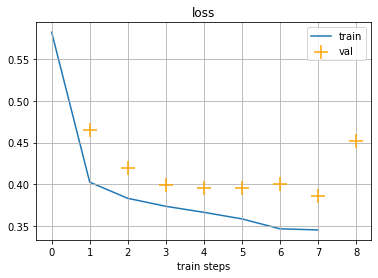

In [47]:
# Функция потерь
plot_history(summary['loss_train'], summary['loss_test'])

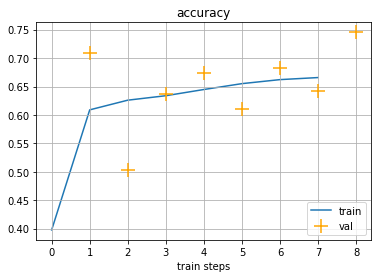

In [48]:
# Точность
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")

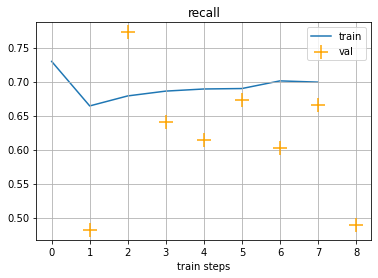

In [49]:
# Полнота
plot_history(summary['recall_train'], summary['recall_test'], "recall")

In [51]:
import gc

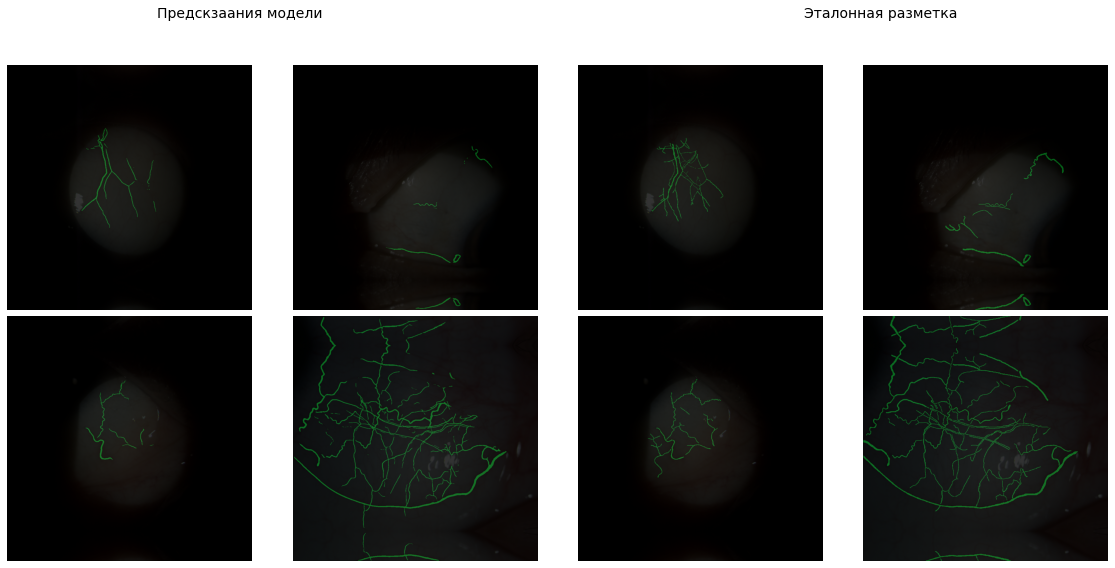

In [53]:
# Посмотрим на картинки предсказаний

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Предскзаания модели {" "*105} Эталонная разметка', fontsize=14)

for i, sample in zip(range(4), valid_dataset):
    image = sample['image'].to("cuda")
    true_mask = sample['mask'].to("cuda")

    prediction = model_pretrain.eval()(image.unsqueeze(dim=0))
    image = (image.cpu() * 255).type(torch.uint8)
    pred_ask = (torch.exp(prediction[0]) > 0.4).cpu()

    image_with_mask = draw_segmentation_masks(image, pred_ask)
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')


    image_with_mask = draw_segmentation_masks(image, true_mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
    axs[i // 2, (i % 2)+2].imshow(image_with_mask)
    axs[i // 2, (i % 2)+2].axis('off')
    del image,true_mask,prediction,pred_ask,image_with_mask
    gc.collect()

fig.tight_layout()
fig.subplots_adjust(top=0.88)